# Multilayer perceptron

This software uses cauchyturing/UCR_Time_Series_Classification_Deep_Learning_Baseline 

See MIT License in 
https://github.com/cauchyturing/UCR_Time_Series_Classification_Deep_Learning_Baseline/README.md

Wang, Z., Yan, W. and Oates, T. (2017) ‘Time series classification from scratch with deep neural networks: A strong baseline’, 2017 International Joint Conference on Neural Networks (IJCNN), pp. 1578–1585 [Online.](https://arxiv.org/abs/1611.06455 "Wang et al. (2017)")

## Formatting

Left align the tables in this Notebook.


In [137]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

## Data
Additional datasets are available in the UEA & UCT Time Series Classification Repository at http://www.timeseriesclassification.com/. 

Save additional datasets in deepscent/data. E.g. deepscent/data/Adiac/Adiac_TRAIN.txt

### GunPoint dataset
The GunPoint dataset is from the [UEA & UCR Time Series 
Classification Repository](http://www.timeseriesclassification.com/description.php?Dataset=GunPoint 
"GunPoint description"). The data is from one female and one male either drawing and pointing a gun at a target or pointing their finger at a target. The location of their hand was tracked. This data is the time series of the x-axis location.

|Training set size |Test set size |Number of classes 
|:-----------      |:--------     |:----------     
|50 |150  |2 


## Train MLP
Expected running time for various datasets when using the original training/test split. Running on a single NVIDIA GeForce GTX 1080 Ti Graphics Card -

Dataset   | Training time
:-------  | :--------
Adiac     | 18 minutes
GunPoint  | 11 minutes


### User inputs

In [138]:
from datetime import datetime

flist = ['GunPoint'] # List dataset directory names.
batch_size = 64 # Or Wang setting can be set below as int(min(x_train.shape[0]/10, 16)) 
nb_epochs = 5000
k = 10 # For k-fold cross validation. If k=1, the original test-train split is used.
m = 1 # Number of repetitions of k-fold cross validation (if k>1).
seed = 35 # seed for initialising random weights in the NN.
k_fold_seed = 87
# Directories
fdir = '../data'  
logs_dir = '../logs'
timestamp = '{:%Y-%m-%dT%H:%M}'.format(datetime.now())
logs_dir = logs_dir +'/' + timestamp

### Set up

In [139]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras import utils
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, RepeatedKFold

import os
import pathlib
import time

np.random.seed(22)#813306)

      
def readucr(filename):
    data = np.loadtxt(filename)
    Y = data[:,0]
    X = data[:,1:]
    return X, Y
  

### Visualise the data

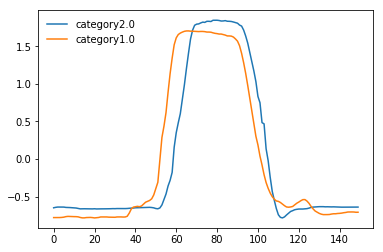

In [140]:
fname = flist[0]
data_a = 0
data_b = 2
x_train, y_train = readucr(fdir+'/'+fname+'/'+fname+'_TRAIN.txt')
plt.plot(x_train[data_a], label='category'+str(y_train[data_a]))
plt.plot(x_train[data_b], label='category'+str(y_train[data_b]))
plt.legend(loc='upper left', frameon=False)

### Function to train the MLP

In [141]:
def train_model(fname, x_train, y_train, x_test, y_test, label="0"):
    print('Running dataset', fname)
    nb_classes =len(np.unique(y_test))
    y_train = (y_train - y_train.min())/(y_train.max()-y_train.min())*(nb_classes-1)
    y_test = (y_test - y_test.min())/(y_test.max()-y_test.min())*(nb_classes-1)
    #batch_size = int(min(x_train.shape[0]/10, 16)) # Wang et al. setting.
    
    Y_train = utils.to_categorical(y_train, nb_classes)
    Y_test = utils.to_categorical(y_test, nb_classes)
     
    x_train_mean = x_train.mean()
    x_train_std = x_train.std()
    x_train = (x_train - x_train_mean)/(x_train_std)
    x_test = (x_test - x_train_mean)/(x_train_std)
     
  
    x = Input(x_train.shape[1:])
    y= Dropout(0.1)(x)
    y = Dense(500, activation='relu', kernel_initializer=RandomUniform(seed=seed))(x)
    y = Dropout(0.2)(y)
    y = Dense(500, activation='relu', kernel_initializer=RandomUniform(seed=seed))(y)
    y = Dropout(0.2)(y)
    y = Dense(500, activation = 'relu', kernel_initializer=RandomUniform(seed=seed))(y)
    y = Dropout(0.3)(y)
    out = Dense(nb_classes, activation='softmax', kernel_initializer=RandomUniform(seed=seed))(y)
     
    model = Model(x, out)
     
    optimizer = keras.optimizers.Adadelta(rho=0.95, epsilon=1e-8)  
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
     
    reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor=0.5,
                      patience=200, min_lr=0.1)
    

    start = time.time()
    hist = model.fit(x_train, Y_train, batch_size=batch_size, epochs=nb_epochs,
              verbose=2, validation_data=(x_test, Y_test), 
                #callbacks = [TestCallback((x_train, Y_train)), reduce_lr, keras.callbacks.TensorBoard(log_dir='./log'+fname, histogram_freq=1)])
                 callbacks=[reduce_lr])
    end = time.time()
    
    log = pd.DataFrame(hist.history)
    # Print results. Print the testing results which has the lowest training loss.
    print('Training complete on', fname)
    duration_minutes = str(round((end-start)/60))
    print('Training time ', end-start, 'seconds, which is about', duration_minutes, 'minutes.')    
    print('Selected the test result with the lowest training loss. Loss and validation accuracy are -')
    idx = log['loss'].idxmin()
    loss = log.loc[log['loss'].idxmin]['loss']
    val_acc = log.loc[log['loss'].idxmin]['val_acc']
    print(loss, val_acc, 'at index', str(idx), ' (epoch ', str(idx+1), ')')
    summary = '|' + label + '  |'+str(loss)+'  |'+str(val_acc)+' |'+str(idx)+' |'+ duration_minutes + 'mins  |'
    summary_csv = label+','+str(loss)+','+str(val_acc)+','+str(idx)+','+ duration_minutes 
    # Save summary file and log file.
    pathlib.Path(logs_dir+'/'+fname).mkdir(parents=True, exist_ok=True) 
    with open(logs_dir+'/'+fname+'/summary.csv', 'a+') as f:
        f.write(summary_csv)
        print('Added summary row to ', logs_dir+'/'+fname+'/summary.csv')  
    print('Saving logs to',logs_dir+'/'+fname+'/history_'+label+'.csv')
    log.to_csv(logs_dir+'/'+fname+'/history_'+label+'.csv')
    return summary
 



# Train

In [142]:
results = []
for each in flist:
    fname = each
    x_train, y_train = readucr(fdir+'/'+fname+'/'+fname+'_TRAIN.txt')
    x_test, y_test = readucr(fdir+'/'+fname+'/'+fname+'_TEST.txt')
    # k-fold cross validation setup
    if k > 1:
        x_all = np.concatenate((x_train, x_test), axis=0)
        y_all = np.concatenate((y_train, y_test), axis=0)
        #kfold = KFold(k, True, k_fold_seed)
        kfold = RepeatedKFold(n_splits=k, n_repeats=m, random_state=k_fold_seed)
        count = 0
        for train, test in kfold.split(x_all):
            x_train, y_train, x_test, y_test = x_all[train], y_all[train], x_all[test], y_all[test]
            summary = train_model(fname, x_train, y_train, x_test, y_test, str(count))
            results.append(summary)
            count = count + 1
    else:
        summary = train_model(fname, x_train, y_train, x_test, y_test)
        results.append(summary)
        
print('DONE')
print(fname, timestamp)
for each in results:
    print(each)
	

Running dataset GunPoint
Train on 180 samples, validate on 20 samples
Epoch 1/5000
 - 1s - loss: 0.6926 - acc: 0.5000 - val_loss: 0.6646 - val_acc: 0.8500
Epoch 2/5000
 - 0s - loss: 0.6647 - acc: 0.6833 - val_loss: 0.6254 - val_acc: 0.8000
Epoch 3/5000
 - 0s - loss: 0.6495 - acc: 0.6278 - val_loss: 0.5901 - val_acc: 0.8000
Epoch 4/5000
 - 0s - loss: 0.6174 - acc: 0.6611 - val_loss: 0.5993 - val_acc: 0.5500
Epoch 5/5000
 - 0s - loss: 0.5677 - acc: 0.7000 - val_loss: 0.5646 - val_acc: 0.5500
Epoch 6/5000
 - 0s - loss: 0.5184 - acc: 0.7667 - val_loss: 0.7215 - val_acc: 0.4500
Epoch 7/5000
 - 0s - loss: 0.6086 - acc: 0.6222 - val_loss: 0.4659 - val_acc: 0.7000
Epoch 8/5000
 - 0s - loss: 0.4424 - acc: 0.8500 - val_loss: 0.3949 - val_acc: 0.8000
Epoch 9/5000
 - 0s - loss: 0.4311 - acc: 0.7444 - val_loss: 0.5223 - val_acc: 0.6500
Epoch 10/5000
 - 0s - loss: 0.4381 - acc: 0.7111 - val_loss: 0.3629 - val_acc: 0.8500
Epoch 11/5000
 - 0s - loss: 0.3706 - acc: 0.8056 - val_loss: 0.3672 - val_acc: 

Epoch 96/5000
 - 0s - loss: 0.1651 - acc: 0.9167 - val_loss: 0.3294 - val_acc: 0.8500
Epoch 97/5000
 - 0s - loss: 0.1446 - acc: 0.9167 - val_loss: 0.0914 - val_acc: 0.9500
Epoch 98/5000
 - 0s - loss: 0.0579 - acc: 0.9889 - val_loss: 0.1771 - val_acc: 0.9000
Epoch 99/5000
 - 0s - loss: 0.0830 - acc: 0.9778 - val_loss: 0.0832 - val_acc: 1.0000
Epoch 100/5000
 - 0s - loss: 0.0698 - acc: 0.9778 - val_loss: 0.1646 - val_acc: 0.9500
Epoch 101/5000
 - 0s - loss: 0.3153 - acc: 0.8611 - val_loss: 0.2175 - val_acc: 0.9000
Epoch 102/5000
 - 0s - loss: 0.0880 - acc: 0.9722 - val_loss: 0.1478 - val_acc: 0.9500
Epoch 103/5000
 - 0s - loss: 0.0622 - acc: 0.9833 - val_loss: 0.0736 - val_acc: 1.0000
Epoch 104/5000
 - 0s - loss: 0.0419 - acc: 0.9944 - val_loss: 0.0622 - val_acc: 1.0000
Epoch 105/5000
 - 0s - loss: 0.0411 - acc: 0.9889 - val_loss: 0.0653 - val_acc: 0.9500
Epoch 106/5000
 - 0s - loss: 0.0371 - acc: 0.9944 - val_loss: 0.0618 - val_acc: 0.9500
Epoch 107/5000
 - 0s - loss: 0.0424 - acc: 0.98

Epoch 191/5000
 - 0s - loss: 0.0149 - acc: 0.9889 - val_loss: 0.0264 - val_acc: 1.0000
Epoch 192/5000
 - 0s - loss: 0.0132 - acc: 0.9944 - val_loss: 0.1362 - val_acc: 0.9000
Epoch 193/5000
 - 0s - loss: 0.0271 - acc: 0.9889 - val_loss: 0.0331 - val_acc: 1.0000
Epoch 194/5000
 - 0s - loss: 0.0130 - acc: 1.0000 - val_loss: 0.0896 - val_acc: 0.9500
Epoch 195/5000
 - 0s - loss: 0.0335 - acc: 0.9833 - val_loss: 0.2250 - val_acc: 0.9500
Epoch 196/5000
 - 0s - loss: 0.0227 - acc: 0.9833 - val_loss: 0.0144 - val_acc: 1.0000
Epoch 197/5000
 - 0s - loss: 0.0129 - acc: 0.9944 - val_loss: 0.0138 - val_acc: 1.0000
Epoch 198/5000
 - 0s - loss: 0.0104 - acc: 0.9944 - val_loss: 0.0318 - val_acc: 1.0000
Epoch 199/5000
 - 0s - loss: 0.0125 - acc: 0.9944 - val_loss: 0.0357 - val_acc: 1.0000
Epoch 200/5000
 - 0s - loss: 0.0142 - acc: 0.9944 - val_loss: 0.1231 - val_acc: 0.9000
Epoch 201/5000
 - 0s - loss: 0.0112 - acc: 1.0000 - val_loss: 0.0206 - val_acc: 1.0000
Epoch 202/5000
 - 0s - loss: 0.0187 - acc: 

 - 0s - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0063 - val_acc: 1.0000
Epoch 286/5000
 - 0s - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0063 - val_acc: 1.0000
Epoch 287/5000
 - 0s - loss: 0.0021 - acc: 1.0000 - val_loss: 0.0086 - val_acc: 1.0000
Epoch 288/5000
 - 0s - loss: 0.0042 - acc: 1.0000 - val_loss: 0.0112 - val_acc: 1.0000
Epoch 289/5000
 - 0s - loss: 0.0068 - acc: 0.9944 - val_loss: 0.0174 - val_acc: 1.0000
Epoch 290/5000
 - 0s - loss: 0.0056 - acc: 0.9944 - val_loss: 0.0693 - val_acc: 0.9500
Epoch 291/5000
 - 0s - loss: 0.0055 - acc: 1.0000 - val_loss: 0.0131 - val_acc: 1.0000
Epoch 292/5000
 - 0s - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0068 - val_acc: 1.0000
Epoch 293/5000
 - 0s - loss: 0.0062 - acc: 0.9944 - val_loss: 0.0851 - val_acc: 0.9500
Epoch 294/5000
 - 0s - loss: 0.0839 - acc: 0.9667 - val_loss: 0.0189 - val_acc: 1.0000
Epoch 295/5000
 - 0s - loss: 0.0072 - acc: 1.0000 - val_loss: 0.0139 - val_acc: 1.0000
Epoch 296/5000
 - 0s - loss: 0.0025 - acc: 1.0000 - val_lo

Epoch 378/5000
 - 0s - loss: 1.8587e-04 - acc: 1.0000 - val_loss: 0.0067 - val_acc: 1.0000
Epoch 379/5000
 - 0s - loss: 2.9690e-04 - acc: 1.0000 - val_loss: 0.0071 - val_acc: 1.0000
Epoch 380/5000
 - 0s - loss: 5.6297e-04 - acc: 1.0000 - val_loss: 0.0081 - val_acc: 1.0000
Epoch 381/5000
 - 0s - loss: 2.2400e-04 - acc: 1.0000 - val_loss: 0.0118 - val_acc: 1.0000
Epoch 382/5000
 - 0s - loss: 2.6267e-04 - acc: 1.0000 - val_loss: 0.0096 - val_acc: 1.0000
Epoch 383/5000
 - 0s - loss: 3.3254e-04 - acc: 1.0000 - val_loss: 0.0163 - val_acc: 1.0000
Epoch 384/5000
 - 0s - loss: 8.2873e-04 - acc: 1.0000 - val_loss: 0.0591 - val_acc: 0.9500
Epoch 385/5000
 - 0s - loss: 0.0226 - acc: 0.9833 - val_loss: 0.0476 - val_acc: 0.9500
Epoch 386/5000
 - 0s - loss: 0.0021 - acc: 1.0000 - val_loss: 0.0163 - val_acc: 1.0000
Epoch 387/5000
 - 0s - loss: 2.5548e-04 - acc: 1.0000 - val_loss: 0.0160 - val_acc: 1.0000
Epoch 388/5000
 - 0s - loss: 5.3029e-04 - acc: 1.0000 - val_loss: 0.0140 - val_acc: 1.0000
Epoch 3

Epoch 469/5000
 - 0s - loss: 6.1632e-05 - acc: 1.0000 - val_loss: 0.0057 - val_acc: 1.0000
Epoch 470/5000
 - 0s - loss: 3.4298e-05 - acc: 1.0000 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 471/5000
 - 0s - loss: 2.5681e-04 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 472/5000
 - 0s - loss: 1.3397e-04 - acc: 1.0000 - val_loss: 0.0064 - val_acc: 1.0000
Epoch 473/5000
 - 0s - loss: 1.6103e-04 - acc: 1.0000 - val_loss: 0.0053 - val_acc: 1.0000
Epoch 474/5000
 - 0s - loss: 1.0767e-04 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 475/5000
 - 0s - loss: 1.9140e-04 - acc: 1.0000 - val_loss: 0.0036 - val_acc: 1.0000
Epoch 476/5000
 - 0s - loss: 1.6173e-04 - acc: 1.0000 - val_loss: 0.0066 - val_acc: 1.0000
Epoch 477/5000
 - 0s - loss: 1.7991e-04 - acc: 1.0000 - val_loss: 0.0091 - val_acc: 1.0000
Epoch 478/5000
 - 0s - loss: 9.9039e-05 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 479/5000
 - 0s - loss: 1.5324e-04 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000

Epoch 560/5000
 - 0s - loss: 4.2539e-05 - acc: 1.0000 - val_loss: 0.0065 - val_acc: 1.0000
Epoch 561/5000
 - 0s - loss: 2.2871e-04 - acc: 1.0000 - val_loss: 0.1340 - val_acc: 0.9500
Epoch 562/5000
 - 0s - loss: 1.6051e-04 - acc: 1.0000 - val_loss: 0.0222 - val_acc: 1.0000
Epoch 563/5000
 - 0s - loss: 1.6189e-04 - acc: 1.0000 - val_loss: 0.0114 - val_acc: 1.0000
Epoch 564/5000
 - 0s - loss: 3.1080e-05 - acc: 1.0000 - val_loss: 0.0072 - val_acc: 1.0000
Epoch 565/5000
 - 0s - loss: 7.8617e-05 - acc: 1.0000 - val_loss: 0.0057 - val_acc: 1.0000
Epoch 566/5000
 - 0s - loss: 5.3635e-05 - acc: 1.0000 - val_loss: 0.0036 - val_acc: 1.0000
Epoch 567/5000
 - 0s - loss: 2.4365e-05 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 568/5000
 - 0s - loss: 1.2592e-05 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 569/5000
 - 0s - loss: 1.3933e-05 - acc: 1.0000 - val_loss: 0.0032 - val_acc: 1.0000
Epoch 570/5000
 - 0s - loss: 2.2671e-05 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 1.0000

Epoch 651/5000
 - 0s - loss: 2.9671e-04 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 652/5000
 - 0s - loss: 3.8058e-05 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 653/5000
 - 0s - loss: 6.2910e-05 - acc: 1.0000 - val_loss: 0.0032 - val_acc: 1.0000
Epoch 654/5000
 - 0s - loss: 2.3506e-05 - acc: 1.0000 - val_loss: 0.0034 - val_acc: 1.0000
Epoch 655/5000
 - 0s - loss: 6.3631e-05 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 656/5000
 - 0s - loss: 6.6291e-05 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 657/5000
 - 0s - loss: 5.2910e-05 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 658/5000
 - 0s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 659/5000
 - 0s - loss: 9.0539e-05 - acc: 1.0000 - val_loss: 0.0036 - val_acc: 1.0000
Epoch 660/5000
 - 0s - loss: 1.0843e-04 - acc: 1.0000 - val_loss: 0.0046 - val_acc: 1.0000
Epoch 661/5000
 - 0s - loss: 3.5874e-05 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epo

 - 0s - loss: 3.0607e-05 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 742/5000
 - 0s - loss: 5.2789e-05 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 743/5000
 - 0s - loss: 3.6941e-05 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 744/5000
 - 0s - loss: 3.5265e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 745/5000
 - 0s - loss: 6.5816e-05 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 746/5000
 - 0s - loss: 7.8497e-05 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 747/5000
 - 0s - loss: 1.4143e-05 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 748/5000
 - 0s - loss: 2.8955e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 749/5000
 - 0s - loss: 1.7744e-04 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 750/5000
 - 0s - loss: 4.7792e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 751/5000
 - 0s - loss: 2.4299e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 752/5000

Epoch 832/5000
 - 0s - loss: 4.3254e-05 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 833/5000
 - 0s - loss: 1.6978e-05 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 834/5000
 - 0s - loss: 1.1381e-05 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 835/5000
 - 0s - loss: 4.9750e-05 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 836/5000
 - 0s - loss: 3.3483e-05 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 837/5000
 - 0s - loss: 1.8055e-05 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 838/5000
 - 0s - loss: 1.8360e-05 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 839/5000
 - 0s - loss: 1.8546e-05 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 840/5000
 - 0s - loss: 1.5888e-04 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 841/5000
 - 0s - loss: 1.0996e-05 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 842/5000
 - 0s - loss: 1.9752e-05 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000

Epoch 922/5000
 - 0s - loss: 2.3868e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 923/5000
 - 0s - loss: 4.6648e-05 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 924/5000
 - 0s - loss: 5.6212e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 925/5000
 - 0s - loss: 1.4147e-05 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 926/5000
 - 0s - loss: 5.2758e-05 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 927/5000
 - 0s - loss: 2.7237e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 928/5000
 - 0s - loss: 1.4994e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 929/5000
 - 0s - loss: 1.5242e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 930/5000
 - 0s - loss: 9.9845e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 931/5000
 - 0s - loss: 1.9353e-04 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 932/5000
 - 0s - loss: 2.2583e-05 - acc: 1.0000 - val_loss: 0.0030 - val_acc: 1.0000

Epoch 1012/5000
 - 0s - loss: 6.1306e-06 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 1013/5000
 - 0s - loss: 6.9624e-05 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 1014/5000
 - 0s - loss: 4.5927e-05 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 1015/5000
 - 0s - loss: 1.7039e-05 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 1016/5000
 - 0s - loss: 2.3588e-05 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 1017/5000
 - 0s - loss: 4.0811e-05 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 1018/5000
 - 0s - loss: 1.9989e-05 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 1019/5000
 - 0s - loss: 1.2083e-05 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 1020/5000
 - 0s - loss: 1.3354e-05 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 1021/5000
 - 0s - loss: 1.4126e-05 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 1022/5000
 - 0s - loss: 8.0195e-06 - acc: 1.0000 - val_loss: 0.0022 - val_

 - 0s - loss: 7.3097e-06 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 1102/5000
 - 0s - loss: 3.0497e-05 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 1103/5000
 - 0s - loss: 1.5791e-05 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 1104/5000
 - 0s - loss: 3.2049e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 1105/5000
 - 0s - loss: 2.2796e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 1106/5000
 - 0s - loss: 2.0235e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 1107/5000
 - 0s - loss: 6.3390e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 1108/5000
 - 0s - loss: 6.9604e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 1109/5000
 - 0s - loss: 9.8269e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 1110/5000
 - 0s - loss: 2.2800e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 1111/5000
 - 0s - loss: 1.1732e-04 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoc

Epoch 1191/5000
 - 0s - loss: 2.1351e-05 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 1192/5000
 - 0s - loss: 6.4953e-06 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 1193/5000
 - 0s - loss: 9.5836e-06 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 1194/5000
 - 0s - loss: 1.6134e-05 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 1195/5000
 - 0s - loss: 1.4649e-05 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 1196/5000
 - 0s - loss: 4.6004e-05 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 1197/5000
 - 0s - loss: 5.8486e-06 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 1198/5000
 - 0s - loss: 2.0422e-05 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 1199/5000
 - 0s - loss: 3.4177e-05 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 1200/5000
 - 0s - loss: 2.0093e-05 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 1201/5000
 - 0s - loss: 2.8558e-05 - acc: 1.0000 - val_loss: 0.0021 - val_

 - 0s - loss: 2.5112e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 1281/5000
 - 0s - loss: 4.3074e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 1282/5000
 - 0s - loss: 2.2317e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 1283/5000
 - 0s - loss: 1.0333e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 1284/5000
 - 0s - loss: 7.3561e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 1285/5000
 - 0s - loss: 1.4578e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 1286/5000
 - 0s - loss: 2.4229e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 1287/5000
 - 0s - loss: 1.6475e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 1288/5000
 - 0s - loss: 7.9895e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 1289/5000
 - 0s - loss: 2.1379e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 1290/5000
 - 0s - loss: 2.7870e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoc

Epoch 1370/5000
 - 0s - loss: 1.0759e-05 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 1371/5000
 - 0s - loss: 6.2929e-06 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 1372/5000
 - 0s - loss: 9.8829e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 1373/5000
 - 0s - loss: 2.4223e-05 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 1374/5000
 - 0s - loss: 8.1833e-06 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 1375/5000
 - 0s - loss: 2.9223e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 1376/5000
 - 0s - loss: 4.2269e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 1377/5000
 - 0s - loss: 1.7294e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 1378/5000
 - 0s - loss: 1.5112e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 1379/5000
 - 0s - loss: 2.5140e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 1380/5000
 - 0s - loss: 6.2809e-06 - acc: 1.0000 - val_loss: 0.0016 - val_

 - 0s - loss: 1.3860e-05 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 1460/5000
 - 0s - loss: 7.7823e-06 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 1461/5000
 - 0s - loss: 1.5376e-05 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 1462/5000
 - 0s - loss: 7.7268e-06 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 1463/5000
 - 0s - loss: 1.3068e-05 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 1464/5000
 - 0s - loss: 9.8852e-06 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 1465/5000
 - 0s - loss: 2.2905e-05 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 1466/5000
 - 0s - loss: 7.1539e-06 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 1467/5000
 - 0s - loss: 6.9432e-06 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 1468/5000
 - 0s - loss: 1.2555e-05 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 1469/5000
 - 0s - loss: 2.1318e-05 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoc

Epoch 1549/5000
 - 0s - loss: 5.3765e-05 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 1550/5000
 - 0s - loss: 1.1736e-05 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 1551/5000
 - 0s - loss: 2.6172e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 1552/5000
 - 0s - loss: 8.5948e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 1553/5000
 - 0s - loss: 3.1863e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 1554/5000
 - 0s - loss: 1.9121e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 1555/5000
 - 0s - loss: 7.6787e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 1556/5000
 - 0s - loss: 8.6925e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 1557/5000
 - 0s - loss: 9.1221e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 1558/5000
 - 0s - loss: 1.1895e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 1559/5000
 - 0s - loss: 2.5334e-05 - acc: 1.0000 - val_loss: 0.0016 - val_

 - 0s - loss: 2.4344e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 1639/5000
 - 0s - loss: 2.2608e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 1640/5000
 - 0s - loss: 1.2099e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 1641/5000
 - 0s - loss: 2.0775e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 1642/5000
 - 0s - loss: 2.3720e-05 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 1643/5000
 - 0s - loss: 3.6076e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 1644/5000
 - 0s - loss: 1.9962e-05 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 1645/5000
 - 0s - loss: 1.4727e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 1646/5000
 - 0s - loss: 3.7032e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 1647/5000
 - 0s - loss: 7.0534e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 1648/5000
 - 0s - loss: 1.8867e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoc

Epoch 1728/5000
 - 0s - loss: 8.6313e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 1729/5000
 - 0s - loss: 6.3487e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 1730/5000
 - 0s - loss: 5.0501e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 1731/5000
 - 0s - loss: 6.5568e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 1732/5000
 - 0s - loss: 2.4767e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 1733/5000
 - 0s - loss: 8.6691e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 1734/5000
 - 0s - loss: 9.1780e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 1735/5000
 - 0s - loss: 6.1642e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 1736/5000
 - 0s - loss: 1.1368e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 1737/5000
 - 0s - loss: 8.1409e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 1738/5000
 - 0s - loss: 1.2370e-05 - acc: 1.0000 - val_loss: 0.0017 - val_

 - 0s - loss: 4.4052e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 1818/5000
 - 0s - loss: 7.3419e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 1819/5000
 - 0s - loss: 9.7022e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 1820/5000
 - 0s - loss: 1.7671e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 1821/5000
 - 0s - loss: 1.4626e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 1822/5000
 - 0s - loss: 7.3387e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 1823/5000
 - 0s - loss: 1.1029e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 1824/5000
 - 0s - loss: 3.4353e-04 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 1825/5000
 - 0s - loss: 2.5752e-05 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 1826/5000
 - 0s - loss: 7.8069e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 1827/5000
 - 0s - loss: 7.9245e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoc

Epoch 1907/5000
 - 0s - loss: 2.6907e-05 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 1908/5000
 - 0s - loss: 7.2295e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 1909/5000
 - 0s - loss: 9.0178e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 1910/5000
 - 0s - loss: 1.1290e-05 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 1911/5000
 - 0s - loss: 1.0658e-05 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 1912/5000
 - 0s - loss: 8.5435e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 1913/5000
 - 0s - loss: 1.9249e-05 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 1914/5000
 - 0s - loss: 9.8105e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 1915/5000
 - 0s - loss: 3.0595e-05 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 1916/5000
 - 0s - loss: 3.0671e-05 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 1917/5000
 - 0s - loss: 6.0738e-06 - acc: 1.0000 - val_loss: 0.0012 - val_

 - 0s - loss: 2.3339e-05 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 1997/5000
 - 0s - loss: 1.9536e-05 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 1998/5000
 - 0s - loss: 1.2950e-05 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 1999/5000
 - 0s - loss: 3.2706e-04 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 2000/5000
 - 0s - loss: 3.0987e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2001/5000
 - 0s - loss: 8.9339e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 2002/5000
 - 0s - loss: 8.2701e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 2003/5000
 - 0s - loss: 1.3732e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2004/5000
 - 0s - loss: 8.1724e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 2005/5000
 - 0s - loss: 4.4342e-05 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 2006/5000
 - 0s - loss: 8.3768e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoc

Epoch 2086/5000
 - 0s - loss: 2.9887e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 2087/5000
 - 0s - loss: 5.5944e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 2088/5000
 - 0s - loss: 4.2848e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 2089/5000
 - 0s - loss: 1.9212e-05 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 2090/5000
 - 0s - loss: 4.9576e-06 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 2091/5000
 - 0s - loss: 2.6312e-04 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 2092/5000
 - 0s - loss: 1.1026e-05 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 2093/5000
 - 0s - loss: 1.2914e-05 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 2094/5000
 - 0s - loss: 5.6334e-06 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 2095/5000
 - 0s - loss: 7.7723e-06 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 2096/5000
 - 0s - loss: 5.3922e-06 - acc: 1.0000 - val_loss: 0.0020 - val_

 - 0s - loss: 6.1287e-04 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 2176/5000
 - 0s - loss: 1.6161e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2177/5000
 - 0s - loss: 1.6365e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2178/5000
 - 0s - loss: 7.8510e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2179/5000
 - 0s - loss: 4.8896e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 2180/5000
 - 0s - loss: 1.9939e-05 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 2181/5000
 - 0s - loss: 6.1995e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 2182/5000
 - 0s - loss: 1.0399e-05 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 2183/5000
 - 0s - loss: 1.7310e-05 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 2184/5000
 - 0s - loss: 1.2190e-05 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 2185/5000
 - 0s - loss: 7.6838e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoc

Epoch 2265/5000
 - 0s - loss: 4.2763e-05 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 2266/5000
 - 0s - loss: 5.7371e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 2267/5000
 - 0s - loss: 7.6040e-05 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 2268/5000
 - 0s - loss: 1.6314e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2269/5000
 - 0s - loss: 1.5233e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2270/5000
 - 0s - loss: 1.6054e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2271/5000
 - 0s - loss: 7.2705e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2272/5000
 - 0s - loss: 1.6163e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2273/5000
 - 0s - loss: 1.7256e-05 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 2274/5000
 - 0s - loss: 4.5041e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 2275/5000
 - 0s - loss: 2.0819e-04 - acc: 1.0000 - val_loss: 0.0016 - val_

 - 0s - loss: 6.4090e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2355/5000
 - 0s - loss: 3.8549e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2356/5000
 - 0s - loss: 1.0510e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2357/5000
 - 0s - loss: 1.2667e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2358/5000
 - 0s - loss: 1.5823e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2359/5000
 - 0s - loss: 4.9449e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2360/5000
 - 0s - loss: 1.0297e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2361/5000
 - 0s - loss: 5.7827e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2362/5000
 - 0s - loss: 1.3887e-05 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 2363/5000
 - 0s - loss: 3.5475e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2364/5000
 - 0s - loss: 8.0586e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoc

Epoch 2444/5000
 - 0s - loss: 9.6857e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2445/5000
 - 0s - loss: 9.5406e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2446/5000
 - 0s - loss: 6.2698e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2447/5000
 - 0s - loss: 4.5077e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2448/5000
 - 0s - loss: 9.2219e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2449/5000
 - 0s - loss: 6.0924e-05 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 2450/5000
 - 0s - loss: 2.2657e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2451/5000
 - 0s - loss: 1.0522e-05 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 2452/5000
 - 0s - loss: 6.7595e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2453/5000
 - 0s - loss: 8.4992e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2454/5000
 - 0s - loss: 6.3238e-06 - acc: 1.0000 - val_loss: 0.0016 - val_

 - 0s - loss: 4.7768e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2534/5000
 - 0s - loss: 5.1436e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2535/5000
 - 0s - loss: 4.4355e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2536/5000
 - 0s - loss: 9.4268e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2537/5000
 - 0s - loss: 5.1261e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2538/5000
 - 0s - loss: 3.0070e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2539/5000
 - 0s - loss: 6.1736e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2540/5000
 - 0s - loss: 7.9832e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2541/5000
 - 0s - loss: 5.0127e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2542/5000
 - 0s - loss: 1.0326e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2543/5000
 - 0s - loss: 1.5934e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoc

Epoch 2623/5000
 - 0s - loss: 1.1563e-05 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 2624/5000
 - 0s - loss: 7.7451e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 2625/5000
 - 0s - loss: 4.9975e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 2626/5000
 - 0s - loss: 9.1033e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2627/5000
 - 0s - loss: 1.4436e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2628/5000
 - 0s - loss: 1.3197e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2629/5000
 - 0s - loss: 1.6317e-05 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 2630/5000
 - 0s - loss: 1.8396e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2631/5000
 - 0s - loss: 2.8949e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2632/5000
 - 0s - loss: 8.8197e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 2633/5000
 - 0s - loss: 1.0469e-05 - acc: 1.0000 - val_loss: 0.0017 - val_

 - 0s - loss: 3.1466e-05 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 2713/5000
 - 0s - loss: 1.7149e-05 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 2714/5000
 - 0s - loss: 1.7814e-05 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 2715/5000
 - 0s - loss: 2.0573e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2716/5000
 - 0s - loss: 1.7762e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2717/5000
 - 0s - loss: 1.4789e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2718/5000
 - 0s - loss: 1.3219e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2719/5000
 - 0s - loss: 1.6093e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2720/5000
 - 0s - loss: 3.5818e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2721/5000
 - 0s - loss: 3.3433e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2722/5000
 - 0s - loss: 3.9486e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoc

Epoch 2802/5000
 - 0s - loss: 7.6809e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 2803/5000
 - 0s - loss: 7.6274e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2804/5000
 - 0s - loss: 1.1096e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2805/5000
 - 0s - loss: 5.7480e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2806/5000
 - 0s - loss: 4.4150e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 2807/5000
 - 0s - loss: 6.5332e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 2808/5000
 - 0s - loss: 8.8719e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 2809/5000
 - 0s - loss: 8.8819e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 2810/5000
 - 0s - loss: 7.3709e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 2811/5000
 - 0s - loss: 1.0649e-05 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 2812/5000
 - 0s - loss: 3.3449e-05 - acc: 1.0000 - val_loss: 0.0014 - val_

 - 0s - loss: 2.5393e-05 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 2892/5000
 - 0s - loss: 2.1445e-05 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 2893/5000
 - 0s - loss: 1.8632e-05 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 2894/5000
 - 0s - loss: 7.1798e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 2895/5000
 - 0s - loss: 1.0693e-05 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 2896/5000
 - 0s - loss: 4.2016e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 2897/5000
 - 0s - loss: 2.7573e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2898/5000
 - 0s - loss: 1.2083e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2899/5000
 - 0s - loss: 5.9339e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2900/5000
 - 0s - loss: 8.8791e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2901/5000
 - 0s - loss: 6.6664e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoc

Epoch 2981/5000
 - 0s - loss: 4.6325e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 2982/5000
 - 0s - loss: 1.0485e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 2983/5000
 - 0s - loss: 6.8333e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 2984/5000
 - 0s - loss: 6.0231e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 2985/5000
 - 0s - loss: 6.0991e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 2986/5000
 - 0s - loss: 1.1829e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2987/5000
 - 0s - loss: 1.4563e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2988/5000
 - 0s - loss: 9.2059e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 2989/5000
 - 0s - loss: 5.2956e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 2990/5000
 - 0s - loss: 3.6596e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 2991/5000
 - 0s - loss: 1.9098e-05 - acc: 1.0000 - val_loss: 0.0017 - val_

 - 0s - loss: 9.7073e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 3071/5000
 - 0s - loss: 5.4778e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 3072/5000
 - 0s - loss: 4.6909e-05 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 3073/5000
 - 0s - loss: 3.6338e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3074/5000
 - 0s - loss: 8.5545e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3075/5000
 - 0s - loss: 2.1645e-05 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 3076/5000
 - 0s - loss: 4.8333e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 3077/5000
 - 0s - loss: 5.1374e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 3078/5000
 - 0s - loss: 5.9709e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 3079/5000
 - 0s - loss: 5.1656e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 3080/5000
 - 0s - loss: 3.6354e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoc

Epoch 3160/5000
 - 0s - loss: 6.3554e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 3161/5000
 - 0s - loss: 5.2910e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 3162/5000
 - 0s - loss: 2.0522e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 3163/5000
 - 0s - loss: 2.2450e-05 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 3164/5000
 - 0s - loss: 6.3019e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 3165/5000
 - 0s - loss: 2.0219e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 3166/5000
 - 0s - loss: 2.0319e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 3167/5000
 - 0s - loss: 4.6389e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 3168/5000
 - 0s - loss: 2.6311e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 3169/5000
 - 0s - loss: 9.5358e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 3170/5000
 - 0s - loss: 5.4536e-06 - acc: 1.0000 - val_loss: 0.0016 - val_

 - 0s - loss: 5.6510e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3250/5000
 - 0s - loss: 1.5280e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3251/5000
 - 0s - loss: 6.8755e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3252/5000
 - 0s - loss: 2.4599e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3253/5000
 - 0s - loss: 1.0870e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3254/5000
 - 0s - loss: 6.4868e-05 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 3255/5000
 - 0s - loss: 4.7401e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3256/5000
 - 0s - loss: 1.1195e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3257/5000
 - 0s - loss: 1.0787e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3258/5000
 - 0s - loss: 1.3458e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3259/5000
 - 0s - loss: 1.1101e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoc

Epoch 3339/5000
 - 0s - loss: 1.0599e-05 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 3340/5000
 - 0s - loss: 2.9990e-05 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 3341/5000
 - 0s - loss: 6.4532e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 3342/5000
 - 0s - loss: 6.9462e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 3343/5000
 - 0s - loss: 2.6587e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 3344/5000
 - 0s - loss: 9.7415e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 3345/5000
 - 0s - loss: 2.5671e-05 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 3346/5000
 - 0s - loss: 1.7870e-05 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 3347/5000
 - 0s - loss: 1.0922e-05 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 3348/5000
 - 0s - loss: 1.4407e-05 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 3349/5000
 - 0s - loss: 7.3191e-06 - acc: 1.0000 - val_loss: 0.0012 - val_

 - 0s - loss: 3.5834e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 3429/5000
 - 0s - loss: 4.0077e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3430/5000
 - 0s - loss: 8.2677e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3431/5000
 - 0s - loss: 3.6785e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3432/5000
 - 0s - loss: 5.2836e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3433/5000
 - 0s - loss: 6.2076e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3434/5000
 - 0s - loss: 7.7118e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3435/5000
 - 0s - loss: 2.3550e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3436/5000
 - 0s - loss: 4.0868e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3437/5000
 - 0s - loss: 7.5353e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 3438/5000
 - 0s - loss: 1.7622e-05 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoc

Epoch 3518/5000
 - 0s - loss: 1.4647e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3519/5000
 - 0s - loss: 6.4991e-05 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 3520/5000
 - 0s - loss: 6.6960e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 3521/5000
 - 0s - loss: 9.7152e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 3522/5000
 - 0s - loss: 8.2505e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 3523/5000
 - 0s - loss: 7.3465e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 3524/5000
 - 0s - loss: 1.0261e-05 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 3525/5000
 - 0s - loss: 4.9882e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 3526/5000
 - 0s - loss: 9.5349e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3527/5000
 - 0s - loss: 1.0065e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3528/5000
 - 0s - loss: 1.1783e-05 - acc: 1.0000 - val_loss: 0.0014 - val_

 - 0s - loss: 1.0741e-05 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 3608/5000
 - 0s - loss: 3.8709e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 3609/5000
 - 0s - loss: 7.8770e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 3610/5000
 - 0s - loss: 3.4052e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 3611/5000
 - 0s - loss: 9.2633e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 3612/5000
 - 0s - loss: 8.6503e-05 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 3613/5000
 - 0s - loss: 2.0683e-06 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 3614/5000
 - 0s - loss: 1.0601e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 3615/5000
 - 0s - loss: 6.3465e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 3616/5000
 - 0s - loss: 3.0297e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 3617/5000
 - 0s - loss: 3.0684e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoc

Epoch 3697/5000
 - 0s - loss: 4.4684e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 3698/5000
 - 0s - loss: 1.5204e-05 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 3699/5000
 - 0s - loss: 4.5296e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 3700/5000
 - 0s - loss: 1.0375e-05 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 3701/5000
 - 0s - loss: 1.9877e-05 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 3702/5000
 - 0s - loss: 9.7563e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 3703/5000
 - 0s - loss: 2.8210e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 3704/5000
 - 0s - loss: 5.6169e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 3705/5000
 - 0s - loss: 1.2745e-05 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 3706/5000
 - 0s - loss: 5.5033e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 3707/5000
 - 0s - loss: 1.3273e-05 - acc: 1.0000 - val_loss: 0.0013 - val_

 - 0s - loss: 7.9601e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 3787/5000
 - 0s - loss: 2.6185e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3788/5000
 - 0s - loss: 4.7477e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3789/5000
 - 0s - loss: 6.8896e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 3790/5000
 - 0s - loss: 5.3619e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 3791/5000
 - 0s - loss: 8.5014e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 3792/5000
 - 0s - loss: 1.0872e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3793/5000
 - 0s - loss: 8.9149e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3794/5000
 - 0s - loss: 4.2838e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3795/5000
 - 0s - loss: 1.5916e-04 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 3796/5000
 - 0s - loss: 7.1027e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoc

Epoch 3876/5000
 - 0s - loss: 8.7479e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3877/5000
 - 0s - loss: 2.0723e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3878/5000
 - 0s - loss: 9.0045e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3879/5000
 - 0s - loss: 4.4822e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3880/5000
 - 0s - loss: 5.3156e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3881/5000
 - 0s - loss: 1.2585e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3882/5000
 - 0s - loss: 6.3555e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3883/5000
 - 0s - loss: 3.6188e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3884/5000
 - 0s - loss: 4.9370e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3885/5000
 - 0s - loss: 1.8406e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3886/5000
 - 0s - loss: 1.1409e-05 - acc: 1.0000 - val_loss: 0.0014 - val_

 - 0s - loss: 6.1580e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3966/5000
 - 0s - loss: 3.6608e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3967/5000
 - 0s - loss: 4.3348e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3968/5000
 - 0s - loss: 1.0136e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3969/5000
 - 0s - loss: 4.1590e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3970/5000
 - 0s - loss: 2.8922e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3971/5000
 - 0s - loss: 1.9389e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3972/5000
 - 0s - loss: 3.5264e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3973/5000
 - 0s - loss: 1.5748e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3974/5000
 - 0s - loss: 4.7064e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3975/5000
 - 0s - loss: 3.8297e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoc

Epoch 4055/5000
 - 0s - loss: 5.1603e-06 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4056/5000
 - 0s - loss: 4.8226e-06 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4057/5000
 - 0s - loss: 3.6440e-06 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4058/5000
 - 0s - loss: 3.2833e-06 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4059/5000
 - 0s - loss: 5.0451e-06 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4060/5000
 - 0s - loss: 9.0019e-06 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4061/5000
 - 0s - loss: 5.6788e-06 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4062/5000
 - 0s - loss: 5.5249e-06 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4063/5000
 - 0s - loss: 8.1834e-06 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4064/5000
 - 0s - loss: 1.0383e-05 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4065/5000
 - 0s - loss: 9.0846e-06 - acc: 1.0000 - val_loss: 0.0011 - val_

 - 0s - loss: 3.4043e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4145/5000
 - 0s - loss: 7.2534e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4146/5000
 - 0s - loss: 1.4976e-05 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4147/5000
 - 0s - loss: 2.1240e-05 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4148/5000
 - 0s - loss: 1.0054e-05 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4149/5000
 - 0s - loss: 4.7307e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4150/5000
 - 0s - loss: 4.3444e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4151/5000
 - 0s - loss: 8.5061e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4152/5000
 - 0s - loss: 7.7280e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4153/5000
 - 0s - loss: 8.4149e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4154/5000
 - 0s - loss: 1.3932e-05 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoc

Epoch 4234/5000
 - 0s - loss: 6.3209e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 4235/5000
 - 0s - loss: 1.2510e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 4236/5000
 - 0s - loss: 5.2373e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 4237/5000
 - 0s - loss: 4.0593e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 4238/5000
 - 0s - loss: 5.7740e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 4239/5000
 - 0s - loss: 8.0703e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 4240/5000
 - 0s - loss: 3.7116e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 4241/5000
 - 0s - loss: 5.0365e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 4242/5000
 - 0s - loss: 6.1785e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 4243/5000
 - 0s - loss: 8.3685e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 4244/5000
 - 0s - loss: 8.2239e-06 - acc: 1.0000 - val_loss: 0.0013 - val_

 - 0s - loss: 2.4270e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 4324/5000
 - 0s - loss: 1.7855e-05 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 4325/5000
 - 0s - loss: 5.0473e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 4326/5000
 - 0s - loss: 3.0627e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 4327/5000
 - 0s - loss: 3.7765e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 4328/5000
 - 0s - loss: 6.5124e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 4329/5000
 - 0s - loss: 2.6969e-05 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 4330/5000
 - 0s - loss: 4.5395e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 4331/5000
 - 0s - loss: 8.5451e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 4332/5000
 - 0s - loss: 8.2655e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 4333/5000
 - 0s - loss: 2.9296e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoc

Epoch 4412/5000
 - 0s - loss: 4.3331e-06 - acc: 1.0000 - val_loss: 9.4603e-04 - val_acc: 1.0000
Epoch 4413/5000
 - 0s - loss: 7.4359e-06 - acc: 1.0000 - val_loss: 9.5163e-04 - val_acc: 1.0000
Epoch 4414/5000
 - 0s - loss: 4.3627e-06 - acc: 1.0000 - val_loss: 9.4909e-04 - val_acc: 1.0000
Epoch 4415/5000
 - 0s - loss: 7.5581e-06 - acc: 1.0000 - val_loss: 9.6016e-04 - val_acc: 1.0000
Epoch 4416/5000
 - 0s - loss: 8.0816e-06 - acc: 1.0000 - val_loss: 9.6592e-04 - val_acc: 1.0000
Epoch 4417/5000
 - 0s - loss: 6.6518e-06 - acc: 1.0000 - val_loss: 9.6954e-04 - val_acc: 1.0000
Epoch 4418/5000
 - 0s - loss: 3.3177e-06 - acc: 1.0000 - val_loss: 9.7240e-04 - val_acc: 1.0000
Epoch 4419/5000
 - 0s - loss: 1.1044e-05 - acc: 1.0000 - val_loss: 9.9612e-04 - val_acc: 1.0000
Epoch 4420/5000
 - 0s - loss: 3.1658e-06 - acc: 1.0000 - val_loss: 9.9878e-04 - val_acc: 1.0000
Epoch 4421/5000
 - 0s - loss: 9.9232e-06 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 4422/5000
 - 0s - loss: 1.8267e-05 - a

Epoch 4501/5000
 - 0s - loss: 2.8806e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 4502/5000
 - 0s - loss: 7.7402e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 4503/5000
 - 0s - loss: 8.8413e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 4504/5000
 - 0s - loss: 3.9354e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 4505/5000
 - 0s - loss: 5.0284e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 4506/5000
 - 0s - loss: 5.8273e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 4507/5000
 - 0s - loss: 7.5029e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 4508/5000
 - 0s - loss: 2.7555e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 4509/5000
 - 0s - loss: 1.2825e-05 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 4510/5000
 - 0s - loss: 1.0057e-05 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 4511/5000
 - 0s - loss: 1.0455e-05 - acc: 1.0000 - val_loss: 0.0013 - val_

 - 0s - loss: 5.9846e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 4591/5000
 - 0s - loss: 3.7335e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4592/5000
 - 0s - loss: 2.6485e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4593/5000
 - 0s - loss: 3.7284e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4594/5000
 - 0s - loss: 5.2609e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4595/5000
 - 0s - loss: 6.7394e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4596/5000
 - 0s - loss: 1.4243e-05 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4597/5000
 - 0s - loss: 6.6369e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4598/5000
 - 0s - loss: 7.6219e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4599/5000
 - 0s - loss: 5.7098e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4600/5000
 - 0s - loss: 1.4314e-05 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoc

Epoch 4679/5000
 - 0s - loss: 9.8341e-06 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 4680/5000
 - 0s - loss: 4.4815e-06 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 4681/5000
 - 0s - loss: 3.4444e-05 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4682/5000
 - 0s - loss: 3.1744e-06 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4683/5000
 - 0s - loss: 4.5107e-06 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4684/5000
 - 0s - loss: 5.0815e-06 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4685/5000
 - 0s - loss: 1.0809e-05 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4686/5000
 - 0s - loss: 1.2291e-05 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4687/5000
 - 0s - loss: 2.7295e-04 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 4688/5000
 - 0s - loss: 1.8973e-05 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4689/5000
 - 0s - loss: 1.3937e-05 - acc: 1.0000 - val_loss: 0.0011 - val_

 - 0s - loss: 7.2276e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 4769/5000
 - 0s - loss: 6.1082e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 4770/5000
 - 0s - loss: 4.2464e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 4771/5000
 - 0s - loss: 7.0993e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 4772/5000
 - 0s - loss: 3.9634e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 4773/5000
 - 0s - loss: 8.0927e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 4774/5000
 - 0s - loss: 3.5453e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 4775/5000
 - 0s - loss: 4.7523e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 4776/5000
 - 0s - loss: 4.0912e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 4777/5000
 - 0s - loss: 2.1384e-05 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 4778/5000
 - 0s - loss: 8.7037e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoc

Epoch 4858/5000
 - 0s - loss: 1.0251e-05 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4859/5000
 - 0s - loss: 6.9785e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4860/5000
 - 0s - loss: 4.0982e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4861/5000
 - 0s - loss: 1.5789e-05 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4862/5000
 - 0s - loss: 1.2111e-05 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4863/5000
 - 0s - loss: 1.1029e-05 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4864/5000
 - 0s - loss: 3.4096e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4865/5000
 - 0s - loss: 2.0677e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4866/5000
 - 0s - loss: 1.3330e-05 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4867/5000
 - 0s - loss: 4.7776e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4868/5000
 - 0s - loss: 4.3305e-06 - acc: 1.0000 - val_loss: 0.0012 - val_

 - 0s - loss: 5.6509e-06 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4948/5000
 - 0s - loss: 5.2277e-06 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4949/5000
 - 0s - loss: 5.2657e-06 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4950/5000
 - 0s - loss: 1.6206e-05 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 4951/5000
 - 0s - loss: 3.4595e-06 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 4952/5000
 - 0s - loss: 5.3644e-06 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 4953/5000
 - 0s - loss: 7.0583e-06 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 4954/5000
 - 0s - loss: 4.9980e-06 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 4955/5000
 - 0s - loss: 8.9876e-06 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 4956/5000
 - 0s - loss: 1.2442e-05 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4957/5000
 - 0s - loss: 3.0526e-06 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoc

Epoch 34/5000
 - 0s - loss: 0.3065 - acc: 0.7889 - val_loss: 0.1925 - val_acc: 0.9000
Epoch 35/5000
 - 0s - loss: 0.3476 - acc: 0.8500 - val_loss: 0.4364 - val_acc: 0.8000
Epoch 36/5000
 - 0s - loss: 0.4295 - acc: 0.8111 - val_loss: 0.2093 - val_acc: 0.9000
Epoch 37/5000
 - 0s - loss: 0.2837 - acc: 0.8889 - val_loss: 0.2262 - val_acc: 0.8000
Epoch 38/5000
 - 0s - loss: 0.2623 - acc: 0.8889 - val_loss: 0.1986 - val_acc: 0.9000
Epoch 39/5000
 - 0s - loss: 0.2472 - acc: 0.8889 - val_loss: 0.1790 - val_acc: 0.9000
Epoch 40/5000
 - 0s - loss: 0.3171 - acc: 0.7722 - val_loss: 0.3241 - val_acc: 0.8000
Epoch 41/5000
 - 0s - loss: 0.3236 - acc: 0.7722 - val_loss: 0.1926 - val_acc: 0.9000
Epoch 42/5000
 - 0s - loss: 0.2851 - acc: 0.8278 - val_loss: 0.2664 - val_acc: 0.8000
Epoch 43/5000
 - 0s - loss: 0.2748 - acc: 0.8444 - val_loss: 0.2145 - val_acc: 0.8000
Epoch 44/5000
 - 0s - loss: 0.2956 - acc: 0.8056 - val_loss: 0.1548 - val_acc: 1.0000
Epoch 45/5000
 - 0s - loss: 0.2213 - acc: 0.9000 - val

Epoch 129/5000
 - 0s - loss: 0.0354 - acc: 0.9889 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 130/5000
 - 0s - loss: 0.0321 - acc: 0.9889 - val_loss: 0.0161 - val_acc: 1.0000
Epoch 131/5000
 - 0s - loss: 0.0270 - acc: 0.9944 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 132/5000
 - 0s - loss: 0.0425 - acc: 0.9833 - val_loss: 0.0127 - val_acc: 1.0000
Epoch 133/5000
 - 0s - loss: 0.0823 - acc: 0.9444 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 134/5000
 - 0s - loss: 0.0328 - acc: 0.9889 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 135/5000
 - 0s - loss: 0.0318 - acc: 0.9889 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 136/5000
 - 0s - loss: 0.0221 - acc: 0.9944 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 137/5000
 - 0s - loss: 0.0658 - acc: 0.9833 - val_loss: 0.0072 - val_acc: 1.0000
Epoch 138/5000
 - 0s - loss: 0.2084 - acc: 0.8889 - val_loss: 0.2263 - val_acc: 0.8500
Epoch 139/5000
 - 0s - loss: 0.3803 - acc: 0.8667 - val_loss: 0.0195 - val_acc: 1.0000
Epoch 140/5000
 - 0s - loss: 0.0560 - acc: 

Epoch 221/5000
 - 0s - loss: 0.0067 - acc: 1.0000 - val_loss: 1.1040e-04 - val_acc: 1.0000
Epoch 222/5000
 - 0s - loss: 0.0165 - acc: 0.9944 - val_loss: 2.0894e-04 - val_acc: 1.0000
Epoch 223/5000
 - 0s - loss: 0.0203 - acc: 0.9944 - val_loss: 2.2901e-04 - val_acc: 1.0000
Epoch 224/5000
 - 0s - loss: 0.0070 - acc: 1.0000 - val_loss: 7.7512e-05 - val_acc: 1.0000
Epoch 225/5000
 - 0s - loss: 0.0077 - acc: 1.0000 - val_loss: 6.9146e-05 - val_acc: 1.0000
Epoch 226/5000
 - 0s - loss: 0.0069 - acc: 0.9944 - val_loss: 6.6165e-05 - val_acc: 1.0000
Epoch 227/5000
 - 0s - loss: 0.0076 - acc: 0.9944 - val_loss: 1.2167e-04 - val_acc: 1.0000
Epoch 228/5000
 - 0s - loss: 0.0156 - acc: 0.9889 - val_loss: 6.6672e-05 - val_acc: 1.0000
Epoch 229/5000
 - 0s - loss: 0.0041 - acc: 1.0000 - val_loss: 4.7150e-05 - val_acc: 1.0000
Epoch 230/5000
 - 0s - loss: 0.0067 - acc: 1.0000 - val_loss: 4.2489e-05 - val_acc: 1.0000
Epoch 231/5000
 - 0s - loss: 0.0052 - acc: 1.0000 - val_loss: 5.3114e-05 - val_acc: 1.0000

Epoch 311/5000
 - 0s - loss: 7.3067e-04 - acc: 1.0000 - val_loss: 1.4471e-05 - val_acc: 1.0000
Epoch 312/5000
 - 0s - loss: 0.0036 - acc: 1.0000 - val_loss: 4.8146e-05 - val_acc: 1.0000
Epoch 313/5000
 - 0s - loss: 0.0120 - acc: 0.9944 - val_loss: 7.4837e-06 - val_acc: 1.0000
Epoch 314/5000
 - 0s - loss: 0.0090 - acc: 0.9944 - val_loss: 0.0071 - val_acc: 1.0000
Epoch 315/5000
 - 0s - loss: 0.0183 - acc: 0.9944 - val_loss: 3.7304e-04 - val_acc: 1.0000
Epoch 316/5000
 - 0s - loss: 0.0055 - acc: 1.0000 - val_loss: 9.5730e-06 - val_acc: 1.0000
Epoch 317/5000
 - 0s - loss: 0.0013 - acc: 1.0000 - val_loss: 1.0202e-05 - val_acc: 1.0000
Epoch 318/5000
 - 0s - loss: 0.0070 - acc: 1.0000 - val_loss: 1.2864e-05 - val_acc: 1.0000
Epoch 319/5000
 - 0s - loss: 7.6910e-04 - acc: 1.0000 - val_loss: 1.2527e-05 - val_acc: 1.0000
Epoch 320/5000
 - 0s - loss: 9.8094e-04 - acc: 1.0000 - val_loss: 1.0756e-05 - val_acc: 1.0000
Epoch 321/5000
 - 0s - loss: 0.0012 - acc: 1.0000 - val_loss: 1.4855e-05 - val_acc

Epoch 400/5000
 - 0s - loss: 2.4816e-04 - acc: 1.0000 - val_loss: 3.9847e-06 - val_acc: 1.0000
Epoch 401/5000
 - 0s - loss: 2.1892e-04 - acc: 1.0000 - val_loss: 1.5527e-06 - val_acc: 1.0000
Epoch 402/5000
 - 0s - loss: 1.9076e-04 - acc: 1.0000 - val_loss: 1.5259e-06 - val_acc: 1.0000
Epoch 403/5000
 - 0s - loss: 3.6520e-04 - acc: 1.0000 - val_loss: 1.5289e-06 - val_acc: 1.0000
Epoch 404/5000
 - 0s - loss: 2.3585e-04 - acc: 1.0000 - val_loss: 1.5050e-06 - val_acc: 1.0000
Epoch 405/5000
 - 0s - loss: 4.1716e-04 - acc: 1.0000 - val_loss: 1.3888e-06 - val_acc: 1.0000
Epoch 406/5000
 - 0s - loss: 2.8514e-04 - acc: 1.0000 - val_loss: 3.0042e-06 - val_acc: 1.0000
Epoch 407/5000
 - 0s - loss: 2.1267e-04 - acc: 1.0000 - val_loss: 1.1891e-06 - val_acc: 1.0000
Epoch 408/5000
 - 0s - loss: 2.2268e-04 - acc: 1.0000 - val_loss: 1.5229e-06 - val_acc: 1.0000
Epoch 409/5000
 - 0s - loss: 4.3372e-04 - acc: 1.0000 - val_loss: 6.3155e-06 - val_acc: 1.0000
Epoch 410/5000
 - 0s - loss: 4.2927e-04 - acc: 1.0

Epoch 487/5000
 - 0s - loss: 2.6190e-04 - acc: 1.0000 - val_loss: 8.2255e-07 - val_acc: 1.0000
Epoch 488/5000
 - 0s - loss: 2.3991e-04 - acc: 1.0000 - val_loss: 7.7188e-07 - val_acc: 1.0000
Epoch 489/5000
 - 0s - loss: 2.4242e-04 - acc: 1.0000 - val_loss: 8.8513e-07 - val_acc: 1.0000
Epoch 490/5000
 - 0s - loss: 1.5289e-04 - acc: 1.0000 - val_loss: 7.3910e-07 - val_acc: 1.0000
Epoch 491/5000
 - 0s - loss: 7.5966e-04 - acc: 1.0000 - val_loss: 8.4043e-07 - val_acc: 1.0000
Epoch 492/5000
 - 0s - loss: 0.0036 - acc: 1.0000 - val_loss: 7.8380e-07 - val_acc: 1.0000
Epoch 493/5000
 - 0s - loss: 2.7359e-04 - acc: 1.0000 - val_loss: 9.4474e-07 - val_acc: 1.0000
Epoch 494/5000
 - 0s - loss: 2.1861e-04 - acc: 1.0000 - val_loss: 8.1361e-07 - val_acc: 1.0000
Epoch 495/5000
 - 0s - loss: 8.8746e-05 - acc: 1.0000 - val_loss: 7.5102e-07 - val_acc: 1.0000
Epoch 496/5000
 - 0s - loss: 1.1978e-04 - acc: 1.0000 - val_loss: 7.1228e-07 - val_acc: 1.0000
Epoch 497/5000
 - 0s - loss: 4.5587e-04 - acc: 1.0000 

Epoch 574/5000
 - 0s - loss: 2.8203e-04 - acc: 1.0000 - val_loss: 3.2485e-06 - val_acc: 1.0000
Epoch 575/5000
 - 0s - loss: 1.4778e-04 - acc: 1.0000 - val_loss: 1.1504e-06 - val_acc: 1.0000
Epoch 576/5000
 - 0s - loss: 3.0952e-04 - acc: 1.0000 - val_loss: 8.2851e-07 - val_acc: 1.0000
Epoch 577/5000
 - 0s - loss: 8.7986e-05 - acc: 1.0000 - val_loss: 8.9109e-07 - val_acc: 1.0000
Epoch 578/5000
 - 0s - loss: 7.6025e-05 - acc: 1.0000 - val_loss: 7.5102e-07 - val_acc: 1.0000
Epoch 579/5000
 - 0s - loss: 5.5941e-05 - acc: 1.0000 - val_loss: 7.7188e-07 - val_acc: 1.0000
Epoch 580/5000
 - 0s - loss: 7.3084e-05 - acc: 1.0000 - val_loss: 6.9440e-07 - val_acc: 1.0000
Epoch 581/5000
 - 0s - loss: 3.1141e-04 - acc: 1.0000 - val_loss: 7.0930e-07 - val_acc: 1.0000
Epoch 582/5000
 - 0s - loss: 2.6916e-04 - acc: 1.0000 - val_loss: 1.6868e-06 - val_acc: 1.0000
Epoch 583/5000
 - 0s - loss: 6.5962e-05 - acc: 1.0000 - val_loss: 1.4037e-06 - val_acc: 1.0000
Epoch 584/5000
 - 0s - loss: 1.8287e-04 - acc: 1.0

Epoch 661/5000
 - 0s - loss: 7.6617e-05 - acc: 1.0000 - val_loss: 4.8280e-07 - val_acc: 1.0000
Epoch 662/5000
 - 0s - loss: 2.0844e-05 - acc: 1.0000 - val_loss: 4.8578e-07 - val_acc: 1.0000
Epoch 663/5000
 - 0s - loss: 1.1503e-04 - acc: 1.0000 - val_loss: 6.0499e-07 - val_acc: 1.0000
Epoch 664/5000
 - 0s - loss: 2.7776e-05 - acc: 1.0000 - val_loss: 5.5134e-07 - val_acc: 1.0000
Epoch 665/5000
 - 0s - loss: 4.2866e-05 - acc: 1.0000 - val_loss: 5.5730e-07 - val_acc: 1.0000
Epoch 666/5000
 - 0s - loss: 4.6176e-05 - acc: 1.0000 - val_loss: 5.3048e-07 - val_acc: 1.0000
Epoch 667/5000
 - 0s - loss: 6.4890e-05 - acc: 1.0000 - val_loss: 6.7652e-07 - val_acc: 1.0000
Epoch 668/5000
 - 0s - loss: 5.0796e-05 - acc: 1.0000 - val_loss: 6.4671e-07 - val_acc: 1.0000
Epoch 669/5000
 - 0s - loss: 1.7643e-05 - acc: 1.0000 - val_loss: 6.5267e-07 - val_acc: 1.0000
Epoch 670/5000
 - 0s - loss: 3.1450e-05 - acc: 1.0000 - val_loss: 6.0797e-07 - val_acc: 1.0000
Epoch 671/5000
 - 0s - loss: 6.2850e-05 - acc: 1.0

Epoch 748/5000
 - 0s - loss: 3.7906e-05 - acc: 1.0000 - val_loss: 4.9472e-07 - val_acc: 1.0000
Epoch 749/5000
 - 0s - loss: 1.9233e-05 - acc: 1.0000 - val_loss: 4.6492e-07 - val_acc: 1.0000
Epoch 750/5000
 - 0s - loss: 2.1913e-05 - acc: 1.0000 - val_loss: 3.8445e-07 - val_acc: 1.0000
Epoch 751/5000
 - 0s - loss: 2.4189e-05 - acc: 1.0000 - val_loss: 3.5763e-07 - val_acc: 1.0000
Epoch 752/5000
 - 0s - loss: 4.8990e-05 - acc: 1.0000 - val_loss: 2.7716e-07 - val_acc: 1.0000
Epoch 753/5000
 - 0s - loss: 3.1271e-05 - acc: 1.0000 - val_loss: 2.6822e-07 - val_acc: 1.0000
Epoch 754/5000
 - 0s - loss: 2.0832e-05 - acc: 1.0000 - val_loss: 2.7716e-07 - val_acc: 1.0000
Epoch 755/5000
 - 0s - loss: 9.5949e-06 - acc: 1.0000 - val_loss: 2.7120e-07 - val_acc: 1.0000
Epoch 756/5000
 - 0s - loss: 2.7158e-05 - acc: 1.0000 - val_loss: 2.6226e-07 - val_acc: 1.0000
Epoch 757/5000
 - 0s - loss: 4.3214e-05 - acc: 1.0000 - val_loss: 2.7120e-07 - val_acc: 1.0000
Epoch 758/5000
 - 0s - loss: 2.2762e-05 - acc: 1.0

Epoch 835/5000
 - 0s - loss: 4.9481e-05 - acc: 1.0000 - val_loss: 1.9670e-07 - val_acc: 1.0000
Epoch 836/5000
 - 0s - loss: 1.5343e-05 - acc: 1.0000 - val_loss: 1.9372e-07 - val_acc: 1.0000
Epoch 837/5000
 - 0s - loss: 2.0439e-05 - acc: 1.0000 - val_loss: 1.9670e-07 - val_acc: 1.0000
Epoch 838/5000
 - 0s - loss: 1.1887e-05 - acc: 1.0000 - val_loss: 1.9073e-07 - val_acc: 1.0000
Epoch 839/5000
 - 0s - loss: 3.5343e-05 - acc: 1.0000 - val_loss: 2.4438e-07 - val_acc: 1.0000
Epoch 840/5000
 - 0s - loss: 2.0341e-05 - acc: 1.0000 - val_loss: 2.0862e-07 - val_acc: 1.0000
Epoch 841/5000
 - 0s - loss: 1.3687e-05 - acc: 1.0000 - val_loss: 2.0564e-07 - val_acc: 1.0000
Epoch 842/5000
 - 0s - loss: 7.8389e-06 - acc: 1.0000 - val_loss: 2.0564e-07 - val_acc: 1.0000
Epoch 843/5000
 - 0s - loss: 2.0880e-05 - acc: 1.0000 - val_loss: 1.9372e-07 - val_acc: 1.0000
Epoch 844/5000
 - 0s - loss: 9.0101e-06 - acc: 1.0000 - val_loss: 1.9372e-07 - val_acc: 1.0000
Epoch 845/5000
 - 0s - loss: 3.2919e-05 - acc: 1.0

Epoch 922/5000
 - 0s - loss: 1.6838e-05 - acc: 1.0000 - val_loss: 2.0862e-07 - val_acc: 1.0000
Epoch 923/5000
 - 0s - loss: 1.5109e-05 - acc: 1.0000 - val_loss: 2.0862e-07 - val_acc: 1.0000
Epoch 924/5000
 - 0s - loss: 2.7439e-05 - acc: 1.0000 - val_loss: 2.1160e-07 - val_acc: 1.0000
Epoch 925/5000
 - 0s - loss: 7.3077e-06 - acc: 1.0000 - val_loss: 2.1160e-07 - val_acc: 1.0000
Epoch 926/5000
 - 0s - loss: 8.1594e-06 - acc: 1.0000 - val_loss: 2.0862e-07 - val_acc: 1.0000
Epoch 927/5000
 - 0s - loss: 1.0281e-05 - acc: 1.0000 - val_loss: 2.0862e-07 - val_acc: 1.0000
Epoch 928/5000
 - 0s - loss: 2.8840e-05 - acc: 1.0000 - val_loss: 2.0862e-07 - val_acc: 1.0000
Epoch 929/5000
 - 0s - loss: 8.9208e-06 - acc: 1.0000 - val_loss: 2.1160e-07 - val_acc: 1.0000
Epoch 930/5000
 - 0s - loss: 1.0797e-05 - acc: 1.0000 - val_loss: 2.1458e-07 - val_acc: 1.0000
Epoch 931/5000
 - 0s - loss: 9.1654e-06 - acc: 1.0000 - val_loss: 2.1458e-07 - val_acc: 1.0000
Epoch 932/5000
 - 0s - loss: 1.4655e-05 - acc: 1.0

 - 0s - loss: 7.3773e-06 - acc: 1.0000 - val_loss: 1.8477e-07 - val_acc: 1.0000
Epoch 1009/5000
 - 0s - loss: 1.8308e-05 - acc: 1.0000 - val_loss: 1.9670e-07 - val_acc: 1.0000
Epoch 1010/5000
 - 0s - loss: 6.4807e-06 - acc: 1.0000 - val_loss: 1.9968e-07 - val_acc: 1.0000
Epoch 1011/5000
 - 0s - loss: 1.3151e-05 - acc: 1.0000 - val_loss: 1.9670e-07 - val_acc: 1.0000
Epoch 1012/5000
 - 0s - loss: 1.7227e-05 - acc: 1.0000 - val_loss: 1.9670e-07 - val_acc: 1.0000
Epoch 1013/5000
 - 0s - loss: 5.4811e-06 - acc: 1.0000 - val_loss: 1.9372e-07 - val_acc: 1.0000
Epoch 1014/5000
 - 0s - loss: 3.1071e-05 - acc: 1.0000 - val_loss: 2.4736e-07 - val_acc: 1.0000
Epoch 1015/5000
 - 0s - loss: 1.0525e-05 - acc: 1.0000 - val_loss: 2.4438e-07 - val_acc: 1.0000
Epoch 1016/5000
 - 0s - loss: 2.8294e-04 - acc: 1.0000 - val_loss: 5.9605e-07 - val_acc: 1.0000
Epoch 1017/5000
 - 0s - loss: 1.8887e-05 - acc: 1.0000 - val_loss: 5.3346e-07 - val_acc: 1.0000
Epoch 1018/5000
 - 0s - loss: 2.7632e-05 - acc: 1.0000 -

Epoch 1094/5000
 - 0s - loss: 8.6796e-06 - acc: 1.0000 - val_loss: 1.9670e-07 - val_acc: 1.0000
Epoch 1095/5000
 - 0s - loss: 1.6484e-05 - acc: 1.0000 - val_loss: 1.8775e-07 - val_acc: 1.0000
Epoch 1096/5000
 - 0s - loss: 1.0686e-05 - acc: 1.0000 - val_loss: 1.9372e-07 - val_acc: 1.0000
Epoch 1097/5000
 - 0s - loss: 3.3305e-05 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 1098/5000
 - 0s - loss: 1.1094e-05 - acc: 1.0000 - val_loss: 1.6987e-07 - val_acc: 1.0000
Epoch 1099/5000
 - 0s - loss: 3.0399e-06 - acc: 1.0000 - val_loss: 1.6987e-07 - val_acc: 1.0000
Epoch 1100/5000
 - 0s - loss: 2.9959e-06 - acc: 1.0000 - val_loss: 1.6987e-07 - val_acc: 1.0000
Epoch 1101/5000
 - 0s - loss: 3.6983e-05 - acc: 1.0000 - val_loss: 1.8179e-07 - val_acc: 1.0000
Epoch 1102/5000
 - 0s - loss: 8.9628e-06 - acc: 1.0000 - val_loss: 1.8477e-07 - val_acc: 1.0000
Epoch 1103/5000
 - 0s - loss: 4.0051e-05 - acc: 1.0000 - val_loss: 1.8179e-07 - val_acc: 1.0000
Epoch 1104/5000
 - 0s - loss: 2.8298e-05

Epoch 1180/5000
 - 0s - loss: 2.5144e-05 - acc: 1.0000 - val_loss: 2.4736e-07 - val_acc: 1.0000
Epoch 1181/5000
 - 0s - loss: 3.5461e-05 - acc: 1.0000 - val_loss: 2.3246e-07 - val_acc: 1.0000
Epoch 1182/5000
 - 0s - loss: 2.8881e-05 - acc: 1.0000 - val_loss: 2.4140e-07 - val_acc: 1.0000
Epoch 1183/5000
 - 0s - loss: 4.0928e-05 - acc: 1.0000 - val_loss: 2.2650e-07 - val_acc: 1.0000
Epoch 1184/5000
 - 0s - loss: 2.3649e-05 - acc: 1.0000 - val_loss: 2.2054e-07 - val_acc: 1.0000
Epoch 1185/5000
 - 0s - loss: 1.5919e-05 - acc: 1.0000 - val_loss: 2.2054e-07 - val_acc: 1.0000
Epoch 1186/5000
 - 0s - loss: 2.2353e-05 - acc: 1.0000 - val_loss: 2.0862e-07 - val_acc: 1.0000
Epoch 1187/5000
 - 0s - loss: 3.2834e-06 - acc: 1.0000 - val_loss: 2.0862e-07 - val_acc: 1.0000
Epoch 1188/5000
 - 0s - loss: 2.1463e-05 - acc: 1.0000 - val_loss: 2.0266e-07 - val_acc: 1.0000
Epoch 1189/5000
 - 0s - loss: 5.2009e-06 - acc: 1.0000 - val_loss: 2.0266e-07 - val_acc: 1.0000
Epoch 1190/5000
 - 0s - loss: 3.6328e-05

Epoch 1266/5000
 - 0s - loss: 5.9432e-06 - acc: 1.0000 - val_loss: 1.9670e-07 - val_acc: 1.0000
Epoch 1267/5000
 - 0s - loss: 5.7754e-06 - acc: 1.0000 - val_loss: 1.9670e-07 - val_acc: 1.0000
Epoch 1268/5000
 - 0s - loss: 6.7778e-06 - acc: 1.0000 - val_loss: 1.9372e-07 - val_acc: 1.0000
Epoch 1269/5000
 - 0s - loss: 1.4002e-05 - acc: 1.0000 - val_loss: 1.9372e-07 - val_acc: 1.0000
Epoch 1270/5000
 - 0s - loss: 2.4949e-06 - acc: 1.0000 - val_loss: 1.9372e-07 - val_acc: 1.0000
Epoch 1271/5000
 - 0s - loss: 4.7828e-06 - acc: 1.0000 - val_loss: 1.9073e-07 - val_acc: 1.0000
Epoch 1272/5000
 - 0s - loss: 1.4143e-05 - acc: 1.0000 - val_loss: 1.9073e-07 - val_acc: 1.0000
Epoch 1273/5000
 - 0s - loss: 1.7809e-05 - acc: 1.0000 - val_loss: 1.8477e-07 - val_acc: 1.0000
Epoch 1274/5000
 - 0s - loss: 4.8147e-06 - acc: 1.0000 - val_loss: 1.8179e-07 - val_acc: 1.0000
Epoch 1275/5000
 - 0s - loss: 7.5014e-06 - acc: 1.0000 - val_loss: 1.8179e-07 - val_acc: 1.0000
Epoch 1276/5000
 - 0s - loss: 6.6719e-06

Epoch 1352/5000
 - 0s - loss: 2.3635e-05 - acc: 1.0000 - val_loss: 1.9073e-07 - val_acc: 1.0000
Epoch 1353/5000
 - 0s - loss: 6.0637e-05 - acc: 1.0000 - val_loss: 1.9073e-07 - val_acc: 1.0000
Epoch 1354/5000
 - 0s - loss: 1.8178e-05 - acc: 1.0000 - val_loss: 1.8775e-07 - val_acc: 1.0000
Epoch 1355/5000
 - 0s - loss: 2.7703e-05 - acc: 1.0000 - val_loss: 1.9670e-07 - val_acc: 1.0000
Epoch 1356/5000
 - 0s - loss: 6.5870e-06 - acc: 1.0000 - val_loss: 1.9372e-07 - val_acc: 1.0000
Epoch 1357/5000
 - 0s - loss: 1.1552e-05 - acc: 1.0000 - val_loss: 1.9372e-07 - val_acc: 1.0000
Epoch 1358/5000
 - 0s - loss: 6.9579e-06 - acc: 1.0000 - val_loss: 1.9073e-07 - val_acc: 1.0000
Epoch 1359/5000
 - 0s - loss: 7.3358e-06 - acc: 1.0000 - val_loss: 1.9073e-07 - val_acc: 1.0000
Epoch 1360/5000
 - 0s - loss: 7.1010e-05 - acc: 1.0000 - val_loss: 1.9670e-07 - val_acc: 1.0000
Epoch 1361/5000
 - 0s - loss: 1.2294e-05 - acc: 1.0000 - val_loss: 1.9372e-07 - val_acc: 1.0000
Epoch 1362/5000
 - 0s - loss: 7.3431e-06

Epoch 1438/5000
 - 0s - loss: 5.6166e-06 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 1439/5000
 - 0s - loss: 6.7045e-06 - acc: 1.0000 - val_loss: 1.6987e-07 - val_acc: 1.0000
Epoch 1440/5000
 - 0s - loss: 1.0095e-05 - acc: 1.0000 - val_loss: 1.6987e-07 - val_acc: 1.0000
Epoch 1441/5000
 - 0s - loss: 5.3218e-06 - acc: 1.0000 - val_loss: 1.6987e-07 - val_acc: 1.0000
Epoch 1442/5000
 - 0s - loss: 5.6164e-06 - acc: 1.0000 - val_loss: 1.6987e-07 - val_acc: 1.0000
Epoch 1443/5000
 - 0s - loss: 6.7702e-06 - acc: 1.0000 - val_loss: 1.6987e-07 - val_acc: 1.0000
Epoch 1444/5000
 - 0s - loss: 4.7520e-06 - acc: 1.0000 - val_loss: 1.6987e-07 - val_acc: 1.0000
Epoch 1445/5000
 - 0s - loss: 1.2574e-05 - acc: 1.0000 - val_loss: 1.6987e-07 - val_acc: 1.0000
Epoch 1446/5000
 - 0s - loss: 9.5594e-06 - acc: 1.0000 - val_loss: 1.6987e-07 - val_acc: 1.0000
Epoch 1447/5000
 - 0s - loss: 9.8359e-06 - acc: 1.0000 - val_loss: 1.6391e-07 - val_acc: 1.0000
Epoch 1448/5000
 - 0s - loss: 8.8022e-06

Epoch 1524/5000
 - 0s - loss: 4.3225e-06 - acc: 1.0000 - val_loss: 1.9968e-07 - val_acc: 1.0000
Epoch 1525/5000
 - 0s - loss: 8.9403e-06 - acc: 1.0000 - val_loss: 1.9968e-07 - val_acc: 1.0000
Epoch 1526/5000
 - 0s - loss: 4.7515e-06 - acc: 1.0000 - val_loss: 1.9968e-07 - val_acc: 1.0000
Epoch 1527/5000
 - 0s - loss: 3.8431e-06 - acc: 1.0000 - val_loss: 1.9968e-07 - val_acc: 1.0000
Epoch 1528/5000
 - 0s - loss: 2.6215e-05 - acc: 1.0000 - val_loss: 1.9372e-07 - val_acc: 1.0000
Epoch 1529/5000
 - 0s - loss: 9.4069e-06 - acc: 1.0000 - val_loss: 1.9372e-07 - val_acc: 1.0000
Epoch 1530/5000
 - 0s - loss: 2.6773e-06 - acc: 1.0000 - val_loss: 1.9372e-07 - val_acc: 1.0000
Epoch 1531/5000
 - 0s - loss: 1.5766e-05 - acc: 1.0000 - val_loss: 1.9073e-07 - val_acc: 1.0000
Epoch 1532/5000
 - 0s - loss: 1.8124e-05 - acc: 1.0000 - val_loss: 1.9073e-07 - val_acc: 1.0000
Epoch 1533/5000
 - 0s - loss: 9.9502e-06 - acc: 1.0000 - val_loss: 1.8775e-07 - val_acc: 1.0000
Epoch 1534/5000
 - 0s - loss: 1.3588e-05

Epoch 1610/5000
 - 0s - loss: 4.6212e-06 - acc: 1.0000 - val_loss: 1.6391e-07 - val_acc: 1.0000
Epoch 1611/5000
 - 0s - loss: 1.1141e-05 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 1612/5000
 - 0s - loss: 5.2232e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 1613/5000
 - 0s - loss: 3.5941e-05 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 1614/5000
 - 0s - loss: 4.0066e-05 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 1615/5000
 - 0s - loss: 2.9834e-05 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 1616/5000
 - 0s - loss: 2.5057e-05 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 1617/5000
 - 0s - loss: 8.0051e-06 - acc: 1.0000 - val_loss: 1.6391e-07 - val_acc: 1.0000
Epoch 1618/5000
 - 0s - loss: 2.8009e-05 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 1619/5000
 - 0s - loss: 1.1361e-05 - acc: 1.0000 - val_loss: 1.6987e-07 - val_acc: 1.0000
Epoch 1620/5000
 - 0s - loss: 2.9319e-05

Epoch 1696/5000
 - 0s - loss: 5.6245e-06 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 1697/5000
 - 0s - loss: 1.0057e-05 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 1698/5000
 - 0s - loss: 7.3309e-06 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 1699/5000
 - 0s - loss: 7.6300e-06 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 1700/5000
 - 0s - loss: 3.3921e-06 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 1701/5000
 - 0s - loss: 7.1154e-06 - acc: 1.0000 - val_loss: 1.7583e-07 - val_acc: 1.0000
Epoch 1702/5000
 - 0s - loss: 7.0191e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 1703/5000
 - 0s - loss: 9.2952e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 1704/5000
 - 0s - loss: 5.2967e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 1705/5000
 - 0s - loss: 6.2150e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 1706/5000
 - 0s - loss: 4.6623e-06

Epoch 1782/5000
 - 0s - loss: 4.3828e-06 - acc: 1.0000 - val_loss: 1.7583e-07 - val_acc: 1.0000
Epoch 1783/5000
 - 0s - loss: 1.0582e-05 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 1784/5000
 - 0s - loss: 1.0895e-05 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 1785/5000
 - 0s - loss: 5.1899e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 1786/5000
 - 0s - loss: 1.7285e-05 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 1787/5000
 - 0s - loss: 6.2719e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 1788/5000
 - 0s - loss: 1.5032e-04 - acc: 1.0000 - val_loss: 1.9670e-07 - val_acc: 1.0000
Epoch 1789/5000
 - 0s - loss: 2.0252e-05 - acc: 1.0000 - val_loss: 1.9372e-07 - val_acc: 1.0000
Epoch 1790/5000
 - 0s - loss: 5.3731e-06 - acc: 1.0000 - val_loss: 1.9372e-07 - val_acc: 1.0000
Epoch 1791/5000
 - 0s - loss: 1.1936e-05 - acc: 1.0000 - val_loss: 1.9372e-07 - val_acc: 1.0000
Epoch 1792/5000
 - 0s - loss: 3.4990e-05

Epoch 1868/5000
 - 0s - loss: 6.0290e-06 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 1869/5000
 - 0s - loss: 4.2147e-06 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 1870/5000
 - 0s - loss: 7.8630e-06 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 1871/5000
 - 0s - loss: 1.0319e-05 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 1872/5000
 - 0s - loss: 6.0178e-06 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 1873/5000
 - 0s - loss: 9.3424e-06 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 1874/5000
 - 0s - loss: 5.8227e-06 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 1875/5000
 - 0s - loss: 3.4311e-06 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 1876/5000
 - 0s - loss: 9.8311e-06 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 1877/5000
 - 0s - loss: 1.1523e-05 - acc: 1.0000 - val_loss: 1.8179e-07 - val_acc: 1.0000
Epoch 1878/5000
 - 0s - loss: 3.3766e-05

Epoch 1954/5000
 - 0s - loss: 2.9352e-05 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 1955/5000
 - 0s - loss: 7.6842e-06 - acc: 1.0000 - val_loss: 1.6391e-07 - val_acc: 1.0000
Epoch 1956/5000
 - 0s - loss: 1.1102e-05 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 1957/5000
 - 0s - loss: 1.3775e-05 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 1958/5000
 - 0s - loss: 1.0187e-05 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 1959/5000
 - 0s - loss: 6.7632e-06 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 1960/5000
 - 0s - loss: 4.9472e-06 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 1961/5000
 - 0s - loss: 2.1786e-05 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 1962/5000
 - 0s - loss: 9.1881e-06 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 1963/5000
 - 0s - loss: 4.2037e-06 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 1964/5000
 - 0s - loss: 3.8056e-06

Epoch 2040/5000
 - 0s - loss: 1.2135e-05 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 2041/5000
 - 0s - loss: 9.9947e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 2042/5000
 - 0s - loss: 6.6980e-05 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 2043/5000
 - 0s - loss: 3.0101e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 2044/5000
 - 0s - loss: 3.6115e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 2045/5000
 - 0s - loss: 7.2334e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 2046/5000
 - 0s - loss: 2.2081e-05 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 2047/5000
 - 0s - loss: 1.3520e-05 - acc: 1.0000 - val_loss: 1.5795e-07 - val_acc: 1.0000
Epoch 2048/5000
 - 0s - loss: 1.5555e-05 - acc: 1.0000 - val_loss: 1.5795e-07 - val_acc: 1.0000
Epoch 2049/5000
 - 0s - loss: 2.4576e-05 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 2050/5000
 - 0s - loss: 2.9479e-06

Epoch 2126/5000
 - 0s - loss: 1.2514e-05 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 2127/5000
 - 0s - loss: 1.1977e-05 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 2128/5000
 - 0s - loss: 1.2626e-05 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 2129/5000
 - 0s - loss: 6.7408e-06 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 2130/5000
 - 0s - loss: 4.5398e-06 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 2131/5000
 - 0s - loss: 4.8223e-06 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 2132/5000
 - 0s - loss: 1.0125e-05 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 2133/5000
 - 0s - loss: 9.5313e-06 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 2134/5000
 - 0s - loss: 6.6509e-06 - acc: 1.0000 - val_loss: 1.7583e-07 - val_acc: 1.0000
Epoch 2135/5000
 - 0s - loss: 1.1991e-05 - acc: 1.0000 - val_loss: 1.7583e-07 - val_acc: 1.0000
Epoch 2136/5000
 - 0s - loss: 8.1722e-06

Epoch 2212/5000
 - 0s - loss: 7.2602e-06 - acc: 1.0000 - val_loss: 1.6391e-07 - val_acc: 1.0000
Epoch 2213/5000
 - 0s - loss: 1.2237e-05 - acc: 1.0000 - val_loss: 1.6391e-07 - val_acc: 1.0000
Epoch 2214/5000
 - 0s - loss: 5.7253e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 2215/5000
 - 0s - loss: 4.9432e-06 - acc: 1.0000 - val_loss: 1.6391e-07 - val_acc: 1.0000
Epoch 2216/5000
 - 0s - loss: 1.0044e-05 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 2217/5000
 - 0s - loss: 1.1034e-05 - acc: 1.0000 - val_loss: 1.6391e-07 - val_acc: 1.0000
Epoch 2218/5000
 - 0s - loss: 9.4825e-06 - acc: 1.0000 - val_loss: 1.6391e-07 - val_acc: 1.0000
Epoch 2219/5000
 - 0s - loss: 1.2052e-05 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 2220/5000
 - 0s - loss: 1.6046e-05 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 2221/5000
 - 0s - loss: 5.1302e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 2222/5000
 - 0s - loss: 5.2786e-06

Epoch 2298/5000
 - 0s - loss: 1.3365e-05 - acc: 1.0000 - val_loss: 1.6391e-07 - val_acc: 1.0000
Epoch 2299/5000
 - 0s - loss: 3.6514e-05 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 2300/5000
 - 0s - loss: 3.4645e-06 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 2301/5000
 - 0s - loss: 4.2498e-06 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 2302/5000
 - 0s - loss: 4.5452e-06 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 2303/5000
 - 0s - loss: 1.9139e-05 - acc: 1.0000 - val_loss: 1.6987e-07 - val_acc: 1.0000
Epoch 2304/5000
 - 0s - loss: 1.4323e-05 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 2305/5000
 - 0s - loss: 6.8655e-06 - acc: 1.0000 - val_loss: 1.6987e-07 - val_acc: 1.0000
Epoch 2306/5000
 - 0s - loss: 7.0026e-06 - acc: 1.0000 - val_loss: 1.6987e-07 - val_acc: 1.0000
Epoch 2307/5000
 - 0s - loss: 4.3368e-06 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 2308/5000
 - 0s - loss: 3.8903e-06

Epoch 2384/5000
 - 0s - loss: 8.2610e-06 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 2385/5000
 - 0s - loss: 1.4597e-05 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 2386/5000
 - 0s - loss: 5.6724e-06 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 2387/5000
 - 0s - loss: 1.2462e-05 - acc: 1.0000 - val_loss: 1.7583e-07 - val_acc: 1.0000
Epoch 2388/5000
 - 0s - loss: 1.8264e-05 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 2389/5000
 - 0s - loss: 1.7320e-05 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 2390/5000
 - 0s - loss: 5.7978e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 2391/5000
 - 0s - loss: 4.7749e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 2392/5000
 - 0s - loss: 5.8032e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 2393/5000
 - 0s - loss: 2.6499e-05 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 2394/5000
 - 0s - loss: 8.5393e-06

Epoch 2470/5000
 - 0s - loss: 4.8596e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 2471/5000
 - 0s - loss: 9.8814e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 2472/5000
 - 0s - loss: 2.3244e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 2473/5000
 - 0s - loss: 2.5200e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 2474/5000
 - 0s - loss: 3.7801e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 2475/5000
 - 0s - loss: 8.6531e-06 - acc: 1.0000 - val_loss: 1.6987e-07 - val_acc: 1.0000
Epoch 2476/5000
 - 0s - loss: 8.5651e-06 - acc: 1.0000 - val_loss: 1.6987e-07 - val_acc: 1.0000
Epoch 2477/5000
 - 0s - loss: 6.3454e-06 - acc: 1.0000 - val_loss: 1.6987e-07 - val_acc: 1.0000
Epoch 2478/5000
 - 0s - loss: 3.8119e-06 - acc: 1.0000 - val_loss: 1.6987e-07 - val_acc: 1.0000
Epoch 2479/5000
 - 0s - loss: 1.5869e-05 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 2480/5000
 - 0s - loss: 5.8303e-06

Epoch 2556/5000
 - 0s - loss: 3.3996e-06 - acc: 1.0000 - val_loss: 1.9073e-07 - val_acc: 1.0000
Epoch 2557/5000
 - 0s - loss: 5.0766e-06 - acc: 1.0000 - val_loss: 1.9073e-07 - val_acc: 1.0000
Epoch 2558/5000
 - 0s - loss: 3.6855e-06 - acc: 1.0000 - val_loss: 1.9073e-07 - val_acc: 1.0000
Epoch 2559/5000
 - 0s - loss: 3.6357e-06 - acc: 1.0000 - val_loss: 1.9073e-07 - val_acc: 1.0000
Epoch 2560/5000
 - 0s - loss: 7.6938e-06 - acc: 1.0000 - val_loss: 1.9073e-07 - val_acc: 1.0000
Epoch 2561/5000
 - 0s - loss: 6.0573e-06 - acc: 1.0000 - val_loss: 1.9073e-07 - val_acc: 1.0000
Epoch 2562/5000
 - 0s - loss: 4.9336e-06 - acc: 1.0000 - val_loss: 1.9073e-07 - val_acc: 1.0000
Epoch 2563/5000
 - 0s - loss: 1.2494e-05 - acc: 1.0000 - val_loss: 1.9073e-07 - val_acc: 1.0000
Epoch 2564/5000
 - 0s - loss: 6.2708e-05 - acc: 1.0000 - val_loss: 1.8477e-07 - val_acc: 1.0000
Epoch 2565/5000
 - 0s - loss: 8.3671e-06 - acc: 1.0000 - val_loss: 1.8477e-07 - val_acc: 1.0000
Epoch 2566/5000
 - 0s - loss: 4.0775e-06

Epoch 2642/5000
 - 0s - loss: 3.5529e-06 - acc: 1.0000 - val_loss: 1.6987e-07 - val_acc: 1.0000
Epoch 2643/5000
 - 0s - loss: 9.7557e-06 - acc: 1.0000 - val_loss: 1.6391e-07 - val_acc: 1.0000
Epoch 2644/5000
 - 0s - loss: 9.1880e-06 - acc: 1.0000 - val_loss: 1.6391e-07 - val_acc: 1.0000
Epoch 2645/5000
 - 0s - loss: 3.2955e-05 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 2646/5000
 - 0s - loss: 5.4180e-06 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 2647/5000
 - 0s - loss: 6.6204e-06 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 2648/5000
 - 0s - loss: 3.3430e-06 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 2649/5000
 - 0s - loss: 9.1387e-06 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 2650/5000
 - 0s - loss: 5.8974e-06 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 2651/5000
 - 0s - loss: 6.6193e-06 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 2652/5000
 - 0s - loss: 4.5958e-06

Epoch 2728/5000
 - 0s - loss: 7.8515e-06 - acc: 1.0000 - val_loss: 1.9670e-07 - val_acc: 1.0000
Epoch 2729/5000
 - 0s - loss: 1.2439e-05 - acc: 1.0000 - val_loss: 1.9372e-07 - val_acc: 1.0000
Epoch 2730/5000
 - 0s - loss: 2.7815e-05 - acc: 1.0000 - val_loss: 1.9073e-07 - val_acc: 1.0000
Epoch 2731/5000
 - 0s - loss: 1.9749e-05 - acc: 1.0000 - val_loss: 1.9073e-07 - val_acc: 1.0000
Epoch 2732/5000
 - 0s - loss: 4.2162e-06 - acc: 1.0000 - val_loss: 1.9073e-07 - val_acc: 1.0000
Epoch 2733/5000
 - 0s - loss: 7.9647e-06 - acc: 1.0000 - val_loss: 1.9372e-07 - val_acc: 1.0000
Epoch 2734/5000
 - 0s - loss: 9.9176e-06 - acc: 1.0000 - val_loss: 1.9073e-07 - val_acc: 1.0000
Epoch 2735/5000
 - 0s - loss: 1.5415e-05 - acc: 1.0000 - val_loss: 1.9073e-07 - val_acc: 1.0000
Epoch 2736/5000
 - 0s - loss: 1.1948e-05 - acc: 1.0000 - val_loss: 1.9073e-07 - val_acc: 1.0000
Epoch 2737/5000
 - 0s - loss: 6.2878e-06 - acc: 1.0000 - val_loss: 1.9073e-07 - val_acc: 1.0000
Epoch 2738/5000
 - 0s - loss: 8.3971e-06

Epoch 2814/5000
 - 0s - loss: 4.6212e-06 - acc: 1.0000 - val_loss: 2.4438e-07 - val_acc: 1.0000
Epoch 2815/5000
 - 0s - loss: 5.5113e-06 - acc: 1.0000 - val_loss: 2.4438e-07 - val_acc: 1.0000
Epoch 2816/5000
 - 0s - loss: 3.0090e-05 - acc: 1.0000 - val_loss: 2.2650e-07 - val_acc: 1.0000
Epoch 2817/5000
 - 0s - loss: 8.6796e-06 - acc: 1.0000 - val_loss: 2.2650e-07 - val_acc: 1.0000
Epoch 2818/5000
 - 0s - loss: 1.5230e-05 - acc: 1.0000 - val_loss: 2.3246e-07 - val_acc: 1.0000
Epoch 2819/5000
 - 0s - loss: 8.1186e-06 - acc: 1.0000 - val_loss: 2.3246e-07 - val_acc: 1.0000
Epoch 2820/5000
 - 0s - loss: 8.0395e-06 - acc: 1.0000 - val_loss: 2.2948e-07 - val_acc: 1.0000
Epoch 2821/5000
 - 0s - loss: 6.6043e-06 - acc: 1.0000 - val_loss: 2.2650e-07 - val_acc: 1.0000
Epoch 2822/5000
 - 0s - loss: 8.8950e-06 - acc: 1.0000 - val_loss: 2.2650e-07 - val_acc: 1.0000
Epoch 2823/5000
 - 0s - loss: 6.0750e-06 - acc: 1.0000 - val_loss: 2.2352e-07 - val_acc: 1.0000
Epoch 2824/5000
 - 0s - loss: 4.8587e-06

Epoch 2900/5000
 - 0s - loss: 3.7593e-05 - acc: 1.0000 - val_loss: 2.3246e-07 - val_acc: 1.0000
Epoch 2901/5000
 - 0s - loss: 4.2299e-06 - acc: 1.0000 - val_loss: 2.3246e-07 - val_acc: 1.0000
Epoch 2902/5000
 - 0s - loss: 1.0453e-05 - acc: 1.0000 - val_loss: 2.2948e-07 - val_acc: 1.0000
Epoch 2903/5000
 - 0s - loss: 4.1348e-06 - acc: 1.0000 - val_loss: 2.2650e-07 - val_acc: 1.0000
Epoch 2904/5000
 - 0s - loss: 7.5753e-06 - acc: 1.0000 - val_loss: 2.2352e-07 - val_acc: 1.0000
Epoch 2905/5000
 - 0s - loss: 9.3522e-06 - acc: 1.0000 - val_loss: 2.2054e-07 - val_acc: 1.0000
Epoch 2906/5000
 - 0s - loss: 4.2032e-05 - acc: 1.0000 - val_loss: 2.1756e-07 - val_acc: 1.0000
Epoch 2907/5000
 - 0s - loss: 1.1782e-05 - acc: 1.0000 - val_loss: 2.1756e-07 - val_acc: 1.0000
Epoch 2908/5000
 - 0s - loss: 2.7608e-06 - acc: 1.0000 - val_loss: 2.1756e-07 - val_acc: 1.0000
Epoch 2909/5000
 - 0s - loss: 6.5436e-05 - acc: 1.0000 - val_loss: 2.5630e-07 - val_acc: 1.0000
Epoch 2910/5000
 - 0s - loss: 9.5842e-06

Epoch 2986/5000
 - 0s - loss: 2.4266e-06 - acc: 1.0000 - val_loss: 1.8179e-07 - val_acc: 1.0000
Epoch 2987/5000
 - 0s - loss: 8.7671e-06 - acc: 1.0000 - val_loss: 1.8477e-07 - val_acc: 1.0000
Epoch 2988/5000
 - 0s - loss: 4.2159e-06 - acc: 1.0000 - val_loss: 1.8477e-07 - val_acc: 1.0000
Epoch 2989/5000
 - 0s - loss: 1.6084e-05 - acc: 1.0000 - val_loss: 1.8477e-07 - val_acc: 1.0000
Epoch 2990/5000
 - 0s - loss: 3.4264e-06 - acc: 1.0000 - val_loss: 1.8477e-07 - val_acc: 1.0000
Epoch 2991/5000
 - 0s - loss: 4.3679e-06 - acc: 1.0000 - val_loss: 1.8179e-07 - val_acc: 1.0000
Epoch 2992/5000
 - 0s - loss: 6.6878e-06 - acc: 1.0000 - val_loss: 1.8179e-07 - val_acc: 1.0000
Epoch 2993/5000
 - 0s - loss: 1.8242e-05 - acc: 1.0000 - val_loss: 1.7583e-07 - val_acc: 1.0000
Epoch 2994/5000
 - 0s - loss: 4.4537e-05 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 2995/5000
 - 0s - loss: 1.6297e-05 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 2996/5000
 - 0s - loss: 2.4426e-06

Epoch 3072/5000
 - 0s - loss: 4.6815e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 3073/5000
 - 0s - loss: 8.8996e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 3074/5000
 - 0s - loss: 5.1280e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 3075/5000
 - 0s - loss: 3.1449e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 3076/5000
 - 0s - loss: 3.7454e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 3077/5000
 - 0s - loss: 5.1410e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 3078/5000
 - 0s - loss: 4.6120e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 3079/5000
 - 0s - loss: 1.4940e-05 - acc: 1.0000 - val_loss: 1.6987e-07 - val_acc: 1.0000
Epoch 3080/5000
 - 0s - loss: 8.7789e-06 - acc: 1.0000 - val_loss: 1.6987e-07 - val_acc: 1.0000
Epoch 3081/5000
 - 0s - loss: 4.6717e-06 - acc: 1.0000 - val_loss: 1.6987e-07 - val_acc: 1.0000
Epoch 3082/5000
 - 0s - loss: 4.8296e-06

Epoch 3158/5000
 - 0s - loss: 7.1099e-06 - acc: 1.0000 - val_loss: 1.5795e-07 - val_acc: 1.0000
Epoch 3159/5000
 - 0s - loss: 5.8607e-06 - acc: 1.0000 - val_loss: 1.5795e-07 - val_acc: 1.0000
Epoch 3160/5000
 - 0s - loss: 7.3450e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 3161/5000
 - 0s - loss: 3.9656e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 3162/5000
 - 0s - loss: 3.6768e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 3163/5000
 - 0s - loss: 3.7093e-06 - acc: 1.0000 - val_loss: 1.5795e-07 - val_acc: 1.0000
Epoch 3164/5000
 - 0s - loss: 4.6899e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 3165/5000
 - 0s - loss: 1.1961e-05 - acc: 1.0000 - val_loss: 1.5795e-07 - val_acc: 1.0000
Epoch 3166/5000
 - 0s - loss: 4.2059e-06 - acc: 1.0000 - val_loss: 1.5795e-07 - val_acc: 1.0000
Epoch 3167/5000
 - 0s - loss: 1.6050e-05 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 3168/5000
 - 0s - loss: 6.4757e-06

Epoch 3244/5000
 - 0s - loss: 3.6821e-06 - acc: 1.0000 - val_loss: 1.5795e-07 - val_acc: 1.0000
Epoch 3245/5000
 - 0s - loss: 4.3898e-06 - acc: 1.0000 - val_loss: 1.5795e-07 - val_acc: 1.0000
Epoch 3246/5000
 - 0s - loss: 8.4565e-06 - acc: 1.0000 - val_loss: 1.5795e-07 - val_acc: 1.0000
Epoch 3247/5000
 - 0s - loss: 4.7309e-06 - acc: 1.0000 - val_loss: 1.5795e-07 - val_acc: 1.0000
Epoch 3248/5000
 - 0s - loss: 2.9518e-06 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 3249/5000
 - 0s - loss: 4.1910e-06 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 3250/5000
 - 0s - loss: 2.5131e-06 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 3251/5000
 - 0s - loss: 5.6419e-06 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 3252/5000
 - 0s - loss: 3.3394e-06 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 3253/5000
 - 0s - loss: 7.3198e-06 - acc: 1.0000 - val_loss: 1.5199e-07 - val_acc: 1.0000
Epoch 3254/5000
 - 0s - loss: 9.5255e-06

Epoch 3330/5000
 - 0s - loss: 7.0120e-06 - acc: 1.0000 - val_loss: 1.4603e-07 - val_acc: 1.0000
Epoch 3331/5000
 - 0s - loss: 2.8674e-06 - acc: 1.0000 - val_loss: 1.4603e-07 - val_acc: 1.0000
Epoch 3332/5000
 - 0s - loss: 7.8156e-06 - acc: 1.0000 - val_loss: 1.4901e-07 - val_acc: 1.0000
Epoch 3333/5000
 - 0s - loss: 4.4536e-06 - acc: 1.0000 - val_loss: 1.4901e-07 - val_acc: 1.0000
Epoch 3334/5000
 - 0s - loss: 8.9283e-06 - acc: 1.0000 - val_loss: 1.4603e-07 - val_acc: 1.0000
Epoch 3335/5000
 - 0s - loss: 3.2936e-06 - acc: 1.0000 - val_loss: 1.4603e-07 - val_acc: 1.0000
Epoch 3336/5000
 - 0s - loss: 5.0151e-06 - acc: 1.0000 - val_loss: 1.4603e-07 - val_acc: 1.0000
Epoch 3337/5000
 - 0s - loss: 3.9353e-06 - acc: 1.0000 - val_loss: 1.4603e-07 - val_acc: 1.0000
Epoch 3338/5000
 - 0s - loss: 5.4075e-06 - acc: 1.0000 - val_loss: 1.4603e-07 - val_acc: 1.0000
Epoch 3339/5000
 - 0s - loss: 5.6317e-06 - acc: 1.0000 - val_loss: 1.4603e-07 - val_acc: 1.0000
Epoch 3340/5000
 - 0s - loss: 5.3251e-06

Epoch 3416/5000
 - 0s - loss: 5.7341e-06 - acc: 1.0000 - val_loss: 1.4901e-07 - val_acc: 1.0000
Epoch 3417/5000
 - 0s - loss: 2.5293e-06 - acc: 1.0000 - val_loss: 1.4901e-07 - val_acc: 1.0000
Epoch 3418/5000
 - 0s - loss: 6.6974e-06 - acc: 1.0000 - val_loss: 1.4901e-07 - val_acc: 1.0000
Epoch 3419/5000
 - 0s - loss: 9.3136e-06 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 3420/5000
 - 0s - loss: 1.9739e-06 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 3421/5000
 - 0s - loss: 3.9093e-06 - acc: 1.0000 - val_loss: 1.5199e-07 - val_acc: 1.0000
Epoch 3422/5000
 - 0s - loss: 9.2465e-06 - acc: 1.0000 - val_loss: 1.5199e-07 - val_acc: 1.0000
Epoch 3423/5000
 - 0s - loss: 7.3868e-06 - acc: 1.0000 - val_loss: 1.4901e-07 - val_acc: 1.0000
Epoch 3424/5000
 - 0s - loss: 3.8506e-06 - acc: 1.0000 - val_loss: 1.5199e-07 - val_acc: 1.0000
Epoch 3425/5000
 - 0s - loss: 3.6076e-06 - acc: 1.0000 - val_loss: 1.4901e-07 - val_acc: 1.0000
Epoch 3426/5000
 - 0s - loss: 1.1193e-05

Epoch 3502/5000
 - 0s - loss: 1.3246e-05 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 3503/5000
 - 0s - loss: 7.5169e-06 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 3504/5000
 - 0s - loss: 6.7759e-06 - acc: 1.0000 - val_loss: 1.7583e-07 - val_acc: 1.0000
Epoch 3505/5000
 - 0s - loss: 3.5389e-05 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 3506/5000
 - 0s - loss: 4.6094e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 3507/5000
 - 0s - loss: 2.7959e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 3508/5000
 - 0s - loss: 2.7490e-05 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 3509/5000
 - 0s - loss: 7.7295e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 3510/5000
 - 0s - loss: 9.0906e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 3511/5000
 - 0s - loss: 2.9466e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 3512/5000
 - 0s - loss: 3.4188e-06

Epoch 3588/5000
 - 0s - loss: 3.1377e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 3589/5000
 - 0s - loss: 1.7874e-05 - acc: 1.0000 - val_loss: 1.5795e-07 - val_acc: 1.0000
Epoch 3590/5000
 - 0s - loss: 8.7721e-06 - acc: 1.0000 - val_loss: 1.5795e-07 - val_acc: 1.0000
Epoch 3591/5000
 - 0s - loss: 7.3031e-06 - acc: 1.0000 - val_loss: 1.5795e-07 - val_acc: 1.0000
Epoch 3592/5000
 - 0s - loss: 2.9171e-06 - acc: 1.0000 - val_loss: 1.5795e-07 - val_acc: 1.0000
Epoch 3593/5000
 - 0s - loss: 1.1996e-05 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 3594/5000
 - 0s - loss: 7.0896e-06 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 3595/5000
 - 0s - loss: 5.5395e-06 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 3596/5000
 - 0s - loss: 2.8992e-06 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 3597/5000
 - 0s - loss: 5.3196e-06 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 3598/5000
 - 0s - loss: 7.2815e-06

Epoch 3674/5000
 - 0s - loss: 5.6372e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 3675/5000
 - 0s - loss: 3.0973e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 3676/5000
 - 0s - loss: 4.8031e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 3677/5000
 - 0s - loss: 4.1299e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 3678/5000
 - 0s - loss: 3.6188e-06 - acc: 1.0000 - val_loss: 1.5795e-07 - val_acc: 1.0000
Epoch 3679/5000
 - 0s - loss: 5.5959e-06 - acc: 1.0000 - val_loss: 1.5795e-07 - val_acc: 1.0000
Epoch 3680/5000
 - 0s - loss: 6.3722e-06 - acc: 1.0000 - val_loss: 1.5795e-07 - val_acc: 1.0000
Epoch 3681/5000
 - 0s - loss: 5.7945e-06 - acc: 1.0000 - val_loss: 1.5795e-07 - val_acc: 1.0000
Epoch 3682/5000
 - 0s - loss: 6.9468e-06 - acc: 1.0000 - val_loss: 1.5795e-07 - val_acc: 1.0000
Epoch 3683/5000
 - 0s - loss: 1.0475e-05 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 3684/5000
 - 0s - loss: 8.9858e-06

Epoch 3760/5000
 - 0s - loss: 1.7368e-06 - acc: 1.0000 - val_loss: 1.4603e-07 - val_acc: 1.0000
Epoch 3761/5000
 - 0s - loss: 5.8980e-06 - acc: 1.0000 - val_loss: 1.4603e-07 - val_acc: 1.0000
Epoch 3762/5000
 - 0s - loss: 1.7412e-06 - acc: 1.0000 - val_loss: 1.4603e-07 - val_acc: 1.0000
Epoch 3763/5000
 - 0s - loss: 1.1366e-05 - acc: 1.0000 - val_loss: 1.4603e-07 - val_acc: 1.0000
Epoch 3764/5000
 - 0s - loss: 1.1716e-04 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 3765/5000
 - 0s - loss: 6.8835e-06 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 3766/5000
 - 0s - loss: 7.4720e-06 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 3767/5000
 - 0s - loss: 3.4126e-06 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 3768/5000
 - 0s - loss: 6.8393e-06 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 3769/5000
 - 0s - loss: 5.7299e-06 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 3770/5000
 - 0s - loss: 1.1582e-05

Epoch 3846/5000
 - 0s - loss: 5.5230e-06 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 3847/5000
 - 0s - loss: 7.4640e-06 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 3848/5000
 - 0s - loss: 5.9168e-06 - acc: 1.0000 - val_loss: 1.7583e-07 - val_acc: 1.0000
Epoch 3849/5000
 - 0s - loss: 3.9758e-06 - acc: 1.0000 - val_loss: 1.7583e-07 - val_acc: 1.0000
Epoch 3850/5000
 - 0s - loss: 3.3903e-06 - acc: 1.0000 - val_loss: 1.7583e-07 - val_acc: 1.0000
Epoch 3851/5000
 - 0s - loss: 3.3158e-06 - acc: 1.0000 - val_loss: 1.7583e-07 - val_acc: 1.0000
Epoch 3852/5000
 - 0s - loss: 2.2647e-06 - acc: 1.0000 - val_loss: 1.7583e-07 - val_acc: 1.0000
Epoch 3853/5000
 - 0s - loss: 4.0650e-06 - acc: 1.0000 - val_loss: 1.7583e-07 - val_acc: 1.0000
Epoch 3854/5000
 - 0s - loss: 5.0245e-06 - acc: 1.0000 - val_loss: 1.7583e-07 - val_acc: 1.0000
Epoch 3855/5000
 - 0s - loss: 4.2504e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 3856/5000
 - 0s - loss: 5.9004e-06

Epoch 3932/5000
 - 0s - loss: 6.8384e-06 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 3933/5000
 - 0s - loss: 2.3889e-06 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 3934/5000
 - 0s - loss: 5.6924e-06 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 3935/5000
 - 0s - loss: 8.5602e-06 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 3936/5000
 - 0s - loss: 2.2869e-06 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 3937/5000
 - 0s - loss: 4.2094e-06 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 3938/5000
 - 0s - loss: 4.1564e-06 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 3939/5000
 - 0s - loss: 4.9267e-06 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 3940/5000
 - 0s - loss: 2.6645e-06 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 3941/5000
 - 0s - loss: 3.3888e-06 - acc: 1.0000 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 3942/5000
 - 0s - loss: 6.0173e-06

Epoch 4018/5000
 - 0s - loss: 2.1618e-05 - acc: 1.0000 - val_loss: 1.6391e-07 - val_acc: 1.0000
Epoch 4019/5000
 - 0s - loss: 1.3564e-05 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 4020/5000
 - 0s - loss: 3.0754e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 4021/5000
 - 0s - loss: 8.3658e-05 - acc: 1.0000 - val_loss: 1.6987e-07 - val_acc: 1.0000
Epoch 4022/5000
 - 0s - loss: 4.8944e-06 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 4023/5000
 - 0s - loss: 8.7728e-06 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 4024/5000
 - 0s - loss: 3.4344e-06 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 4025/5000
 - 0s - loss: 8.0240e-06 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 4026/5000
 - 0s - loss: 7.2584e-06 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 4027/5000
 - 0s - loss: 8.5965e-05 - acc: 1.0000 - val_loss: 1.9073e-07 - val_acc: 1.0000
Epoch 4028/5000
 - 0s - loss: 2.4549e-05

Epoch 4104/5000
 - 0s - loss: 7.2743e-06 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 4105/5000
 - 0s - loss: 1.0439e-05 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 4106/5000
 - 0s - loss: 8.9184e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 4107/5000
 - 0s - loss: 4.1511e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 4108/5000
 - 0s - loss: 8.9661e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 4109/5000
 - 0s - loss: 3.8014e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 4110/5000
 - 0s - loss: 3.9709e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 4111/5000
 - 0s - loss: 2.3966e-05 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 4112/5000
 - 0s - loss: 1.2277e-05 - acc: 1.0000 - val_loss: 1.6391e-07 - val_acc: 1.0000
Epoch 4113/5000
 - 0s - loss: 3.8447e-06 - acc: 1.0000 - val_loss: 1.6391e-07 - val_acc: 1.0000
Epoch 4114/5000
 - 0s - loss: 1.4732e-05

Epoch 4190/5000
 - 0s - loss: 1.0297e-05 - acc: 1.0000 - val_loss: 1.7583e-07 - val_acc: 1.0000
Epoch 4191/5000
 - 0s - loss: 6.0129e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 4192/5000
 - 0s - loss: 6.3872e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 4193/5000
 - 0s - loss: 8.3797e-06 - acc: 1.0000 - val_loss: 1.6987e-07 - val_acc: 1.0000
Epoch 4194/5000
 - 0s - loss: 3.2770e-05 - acc: 1.0000 - val_loss: 1.5795e-07 - val_acc: 1.0000
Epoch 4195/5000
 - 0s - loss: 8.6673e-06 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 4196/5000
 - 0s - loss: 4.2761e-06 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 4197/5000
 - 0s - loss: 7.2479e-06 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 4198/5000
 - 0s - loss: 8.9639e-06 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 4199/5000
 - 0s - loss: 1.0950e-05 - acc: 1.0000 - val_loss: 1.5795e-07 - val_acc: 1.0000
Epoch 4200/5000
 - 0s - loss: 3.9674e-05

Epoch 4276/5000
 - 0s - loss: 3.8692e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 4277/5000
 - 0s - loss: 1.6067e-05 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 4278/5000
 - 0s - loss: 3.3775e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 4279/5000
 - 0s - loss: 5.6142e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 4280/5000
 - 0s - loss: 6.0699e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 4281/5000
 - 0s - loss: 5.3126e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 4282/5000
 - 0s - loss: 3.4358e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 4283/5000
 - 0s - loss: 1.1624e-05 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 4284/5000
 - 0s - loss: 6.9491e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 4285/5000
 - 0s - loss: 2.5270e-06 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 4286/5000
 - 0s - loss: 7.5657e-06

Epoch 4362/5000
 - 0s - loss: 2.2621e-06 - acc: 1.0000 - val_loss: 1.6987e-07 - val_acc: 1.0000
Epoch 4363/5000
 - 0s - loss: 6.4816e-06 - acc: 1.0000 - val_loss: 1.6987e-07 - val_acc: 1.0000
Epoch 4364/5000
 - 0s - loss: 3.6373e-06 - acc: 1.0000 - val_loss: 1.6987e-07 - val_acc: 1.0000
Epoch 4365/5000
 - 0s - loss: 4.7460e-06 - acc: 1.0000 - val_loss: 1.6987e-07 - val_acc: 1.0000
Epoch 4366/5000
 - 0s - loss: 6.7200e-06 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 4367/5000
 - 0s - loss: 4.0652e-06 - acc: 1.0000 - val_loss: 1.6987e-07 - val_acc: 1.0000
Epoch 4368/5000
 - 0s - loss: 3.3870e-06 - acc: 1.0000 - val_loss: 1.6987e-07 - val_acc: 1.0000
Epoch 4369/5000
 - 0s - loss: 5.1492e-06 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 4370/5000
 - 0s - loss: 1.3271e-05 - acc: 1.0000 - val_loss: 1.6987e-07 - val_acc: 1.0000
Epoch 4371/5000
 - 0s - loss: 5.5634e-06 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 4372/5000
 - 0s - loss: 4.3142e-06

Epoch 4448/5000
 - 0s - loss: 2.1650e-06 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 4449/5000
 - 0s - loss: 1.4737e-05 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 4450/5000
 - 0s - loss: 6.2434e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 4451/5000
 - 0s - loss: 3.2727e-05 - acc: 1.0000 - val_loss: 1.6391e-07 - val_acc: 1.0000
Epoch 4452/5000
 - 0s - loss: 1.0396e-05 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 4453/5000
 - 0s - loss: 3.6908e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 4454/5000
 - 0s - loss: 5.8954e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 4455/5000
 - 0s - loss: 4.4855e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 4456/5000
 - 0s - loss: 1.6173e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 4457/5000
 - 0s - loss: 7.7727e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 4458/5000
 - 0s - loss: 2.1865e-06

Epoch 4534/5000
 - 0s - loss: 4.4335e-06 - acc: 1.0000 - val_loss: 1.6391e-07 - val_acc: 1.0000
Epoch 4535/5000
 - 0s - loss: 1.2341e-05 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 4536/5000
 - 0s - loss: 4.1270e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 4537/5000
 - 0s - loss: 1.0191e-05 - acc: 1.0000 - val_loss: 1.5795e-07 - val_acc: 1.0000
Epoch 4538/5000
 - 0s - loss: 6.4042e-06 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 4539/5000
 - 0s - loss: 2.5468e-06 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 4540/5000
 - 0s - loss: 5.1165e-06 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 4541/5000
 - 0s - loss: 2.4551e-06 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 4542/5000
 - 0s - loss: 5.7293e-06 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 4543/5000
 - 0s - loss: 1.7921e-06 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 4544/5000
 - 0s - loss: 1.0777e-05

Epoch 4620/5000
 - 0s - loss: 6.4891e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 4621/5000
 - 0s - loss: 8.9575e-05 - acc: 1.0000 - val_loss: 1.4901e-07 - val_acc: 1.0000
Epoch 4622/5000
 - 0s - loss: 5.5035e-06 - acc: 1.0000 - val_loss: 1.4901e-07 - val_acc: 1.0000
Epoch 4623/5000
 - 0s - loss: 7.6340e-06 - acc: 1.0000 - val_loss: 1.4901e-07 - val_acc: 1.0000
Epoch 4624/5000
 - 0s - loss: 6.0456e-06 - acc: 1.0000 - val_loss: 1.4901e-07 - val_acc: 1.0000
Epoch 4625/5000
 - 0s - loss: 1.7085e-05 - acc: 1.0000 - val_loss: 1.4901e-07 - val_acc: 1.0000
Epoch 4626/5000
 - 0s - loss: 7.8290e-06 - acc: 1.0000 - val_loss: 1.4901e-07 - val_acc: 1.0000
Epoch 4627/5000
 - 0s - loss: 1.0165e-05 - acc: 1.0000 - val_loss: 1.4901e-07 - val_acc: 1.0000
Epoch 4628/5000
 - 0s - loss: 7.2051e-06 - acc: 1.0000 - val_loss: 1.4901e-07 - val_acc: 1.0000
Epoch 4629/5000
 - 0s - loss: 2.4283e-06 - acc: 1.0000 - val_loss: 1.4901e-07 - val_acc: 1.0000
Epoch 4630/5000
 - 0s - loss: 1.5844e-04

Epoch 4706/5000
 - 0s - loss: 1.5911e-06 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 4707/5000
 - 0s - loss: 2.5723e-06 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 4708/5000
 - 0s - loss: 1.9999e-05 - acc: 1.0000 - val_loss: 1.5795e-07 - val_acc: 1.0000
Epoch 4709/5000
 - 0s - loss: 4.3061e-06 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 4710/5000
 - 0s - loss: 5.9623e-06 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 4711/5000
 - 0s - loss: 3.8120e-06 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 4712/5000
 - 0s - loss: 1.3262e-05 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 4713/5000
 - 0s - loss: 1.0929e-05 - acc: 1.0000 - val_loss: 1.5795e-07 - val_acc: 1.0000
Epoch 4714/5000
 - 0s - loss: 9.1664e-06 - acc: 1.0000 - val_loss: 1.5795e-07 - val_acc: 1.0000
Epoch 4715/5000
 - 0s - loss: 3.6646e-06 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 4716/5000
 - 0s - loss: 3.2297e-06

Epoch 4792/5000
 - 0s - loss: 8.0468e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 4793/5000
 - 0s - loss: 2.9303e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 4794/5000
 - 0s - loss: 5.8982e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 4795/5000
 - 0s - loss: 3.5688e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 4796/5000
 - 0s - loss: 4.8316e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 4797/5000
 - 0s - loss: 2.5145e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 4798/5000
 - 0s - loss: 3.8397e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 4799/5000
 - 0s - loss: 6.7782e-06 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 4800/5000
 - 0s - loss: 6.8014e-06 - acc: 1.0000 - val_loss: 1.5795e-07 - val_acc: 1.0000
Epoch 4801/5000
 - 0s - loss: 8.0810e-06 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 4802/5000
 - 0s - loss: 8.9597e-06

Epoch 4878/5000
 - 0s - loss: 1.6868e-06 - acc: 1.0000 - val_loss: 1.4901e-07 - val_acc: 1.0000
Epoch 4879/5000
 - 0s - loss: 5.0129e-06 - acc: 1.0000 - val_loss: 1.4901e-07 - val_acc: 1.0000
Epoch 4880/5000
 - 0s - loss: 1.0104e-05 - acc: 1.0000 - val_loss: 1.4901e-07 - val_acc: 1.0000
Epoch 4881/5000
 - 0s - loss: 4.1219e-06 - acc: 1.0000 - val_loss: 1.4901e-07 - val_acc: 1.0000
Epoch 4882/5000
 - 0s - loss: 4.4165e-06 - acc: 1.0000 - val_loss: 1.4901e-07 - val_acc: 1.0000
Epoch 4883/5000
 - 0s - loss: 1.7715e-05 - acc: 1.0000 - val_loss: 1.4901e-07 - val_acc: 1.0000
Epoch 4884/5000
 - 0s - loss: 4.3199e-06 - acc: 1.0000 - val_loss: 1.4901e-07 - val_acc: 1.0000
Epoch 4885/5000
 - 0s - loss: 4.0639e-06 - acc: 1.0000 - val_loss: 1.4901e-07 - val_acc: 1.0000
Epoch 4886/5000
 - 0s - loss: 3.5129e-06 - acc: 1.0000 - val_loss: 1.4901e-07 - val_acc: 1.0000
Epoch 4887/5000
 - 0s - loss: 5.1576e-06 - acc: 1.0000 - val_loss: 1.4901e-07 - val_acc: 1.0000
Epoch 4888/5000
 - 0s - loss: 1.5319e-06

Epoch 4964/5000
 - 0s - loss: 6.2436e-06 - acc: 1.0000 - val_loss: 1.4603e-07 - val_acc: 1.0000
Epoch 4965/5000
 - 0s - loss: 1.7234e-05 - acc: 1.0000 - val_loss: 1.4901e-07 - val_acc: 1.0000
Epoch 4966/5000
 - 0s - loss: 3.3371e-06 - acc: 1.0000 - val_loss: 1.4901e-07 - val_acc: 1.0000
Epoch 4967/5000
 - 0s - loss: 5.8418e-06 - acc: 1.0000 - val_loss: 1.4901e-07 - val_acc: 1.0000
Epoch 4968/5000
 - 0s - loss: 7.8126e-06 - acc: 1.0000 - val_loss: 1.4901e-07 - val_acc: 1.0000
Epoch 4969/5000
 - 0s - loss: 2.8674e-05 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 4970/5000
 - 0s - loss: 5.8808e-06 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 4971/5000
 - 0s - loss: 2.4187e-06 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 4972/5000
 - 0s - loss: 6.7270e-06 - acc: 1.0000 - val_loss: 1.5199e-07 - val_acc: 1.0000
Epoch 4973/5000
 - 0s - loss: 4.6415e-06 - acc: 1.0000 - val_loss: 1.5199e-07 - val_acc: 1.0000
Epoch 4974/5000
 - 0s - loss: 3.1148e-06

Epoch 50/5000
 - 0s - loss: 0.2809 - acc: 0.8778 - val_loss: 0.2246 - val_acc: 0.9500
Epoch 51/5000
 - 0s - loss: 0.1480 - acc: 0.9722 - val_loss: 0.2814 - val_acc: 0.8500
Epoch 52/5000
 - 0s - loss: 0.1261 - acc: 0.9667 - val_loss: 0.2417 - val_acc: 0.8500
Epoch 53/5000
 - 0s - loss: 0.1761 - acc: 0.9389 - val_loss: 0.9224 - val_acc: 0.7500
Epoch 54/5000
 - 0s - loss: 0.4021 - acc: 0.8722 - val_loss: 0.1984 - val_acc: 1.0000
Epoch 55/5000
 - 0s - loss: 0.2080 - acc: 0.9111 - val_loss: 0.7526 - val_acc: 0.6500
Epoch 56/5000
 - 0s - loss: 0.3493 - acc: 0.7833 - val_loss: 0.4011 - val_acc: 0.8000
Epoch 57/5000
 - 0s - loss: 0.2075 - acc: 0.9333 - val_loss: 0.2110 - val_acc: 0.9000
Epoch 58/5000
 - 0s - loss: 0.1168 - acc: 0.9889 - val_loss: 0.1942 - val_acc: 0.9000
Epoch 59/5000
 - 0s - loss: 0.1702 - acc: 0.9333 - val_loss: 0.6195 - val_acc: 0.7500
Epoch 60/5000
 - 0s - loss: 0.3788 - acc: 0.8111 - val_loss: 0.5859 - val_acc: 0.6500
Epoch 61/5000
 - 0s - loss: 0.2352 - acc: 0.8944 - val

Epoch 145/5000
 - 0s - loss: 0.0270 - acc: 0.9944 - val_loss: 0.0390 - val_acc: 1.0000
Epoch 146/5000
 - 0s - loss: 0.0206 - acc: 0.9944 - val_loss: 0.0254 - val_acc: 1.0000
Epoch 147/5000
 - 0s - loss: 0.0277 - acc: 0.9889 - val_loss: 0.0351 - val_acc: 1.0000
Epoch 148/5000
 - 0s - loss: 0.0195 - acc: 0.9944 - val_loss: 0.0264 - val_acc: 1.0000
Epoch 149/5000
 - 0s - loss: 0.0243 - acc: 0.9944 - val_loss: 0.0355 - val_acc: 1.0000
Epoch 150/5000
 - 0s - loss: 0.0254 - acc: 0.9944 - val_loss: 0.0832 - val_acc: 0.9500
Epoch 151/5000
 - 0s - loss: 0.0367 - acc: 0.9833 - val_loss: 0.0907 - val_acc: 0.9000
Epoch 152/5000
 - 0s - loss: 0.0220 - acc: 0.9944 - val_loss: 0.0289 - val_acc: 1.0000
Epoch 153/5000
 - 0s - loss: 0.0183 - acc: 0.9944 - val_loss: 0.0291 - val_acc: 1.0000
Epoch 154/5000
 - 0s - loss: 0.0202 - acc: 0.9944 - val_loss: 0.0337 - val_acc: 1.0000
Epoch 155/5000
 - 0s - loss: 0.0177 - acc: 0.9944 - val_loss: 0.0233 - val_acc: 1.0000
Epoch 156/5000
 - 0s - loss: 0.0181 - acc: 

 - 0s - loss: 0.0052 - acc: 1.0000 - val_loss: 0.0071 - val_acc: 1.0000
Epoch 240/5000
 - 0s - loss: 0.0244 - acc: 0.9833 - val_loss: 0.0323 - val_acc: 1.0000
Epoch 241/5000
 - 0s - loss: 0.0142 - acc: 0.9944 - val_loss: 0.0059 - val_acc: 1.0000
Epoch 242/5000
 - 0s - loss: 0.0054 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 243/5000
 - 0s - loss: 0.0063 - acc: 1.0000 - val_loss: 0.0095 - val_acc: 1.0000
Epoch 244/5000
 - 0s - loss: 0.0077 - acc: 0.9944 - val_loss: 0.0108 - val_acc: 1.0000
Epoch 245/5000
 - 0s - loss: 0.0067 - acc: 1.0000 - val_loss: 0.0106 - val_acc: 1.0000
Epoch 246/5000
 - 0s - loss: 0.0044 - acc: 1.0000 - val_loss: 0.0300 - val_acc: 1.0000
Epoch 247/5000
 - 0s - loss: 0.0054 - acc: 1.0000 - val_loss: 0.0048 - val_acc: 1.0000
Epoch 248/5000
 - 0s - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0116 - val_acc: 1.0000
Epoch 249/5000
 - 0s - loss: 0.0034 - acc: 1.0000 - val_loss: 0.0069 - val_acc: 1.0000
Epoch 250/5000
 - 0s - loss: 0.0030 - acc: 1.0000 - val_lo

Epoch 333/5000
 - 0s - loss: 0.0044 - acc: 1.0000 - val_loss: 0.0396 - val_acc: 0.9500
Epoch 334/5000
 - 0s - loss: 0.0049 - acc: 1.0000 - val_loss: 0.0132 - val_acc: 1.0000
Epoch 335/5000
 - 0s - loss: 0.0031 - acc: 1.0000 - val_loss: 0.0050 - val_acc: 1.0000
Epoch 336/5000
 - 0s - loss: 6.3368e-04 - acc: 1.0000 - val_loss: 0.0063 - val_acc: 1.0000
Epoch 337/5000
 - 0s - loss: 4.7068e-04 - acc: 1.0000 - val_loss: 0.0048 - val_acc: 1.0000
Epoch 338/5000
 - 0s - loss: 0.0010 - acc: 1.0000 - val_loss: 0.0044 - val_acc: 1.0000
Epoch 339/5000
 - 0s - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 340/5000
 - 0s - loss: 7.7151e-04 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 1.0000
Epoch 341/5000
 - 0s - loss: 6.1798e-04 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 342/5000
 - 0s - loss: 3.4541e-04 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 343/5000
 - 0s - loss: 5.5328e-04 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 344/5000
 - 0

Epoch 424/5000
 - 0s - loss: 3.2922e-04 - acc: 1.0000 - val_loss: 0.0079 - val_acc: 1.0000
Epoch 425/5000
 - 0s - loss: 1.6270e-04 - acc: 1.0000 - val_loss: 0.0053 - val_acc: 1.0000
Epoch 426/5000
 - 0s - loss: 8.0324e-04 - acc: 1.0000 - val_loss: 0.0106 - val_acc: 1.0000
Epoch 427/5000
 - 0s - loss: 1.0573e-04 - acc: 1.0000 - val_loss: 0.0105 - val_acc: 1.0000
Epoch 428/5000
 - 0s - loss: 8.6717e-04 - acc: 1.0000 - val_loss: 9.1337e-04 - val_acc: 1.0000
Epoch 429/5000
 - 0s - loss: 2.0447e-04 - acc: 1.0000 - val_loss: 0.0056 - val_acc: 1.0000
Epoch 430/5000
 - 0s - loss: 1.3388e-04 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 431/5000
 - 0s - loss: 1.0702e-04 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 432/5000
 - 0s - loss: 2.9440e-04 - acc: 1.0000 - val_loss: 0.0172 - val_acc: 1.0000
Epoch 433/5000
 - 0s - loss: 1.4472e-04 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 434/5000
 - 0s - loss: 1.2615e-04 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 1.

Epoch 515/5000
 - 0s - loss: 1.1356e-04 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 516/5000
 - 0s - loss: 1.9488e-04 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 517/5000
 - 0s - loss: 1.1928e-04 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 518/5000
 - 0s - loss: 2.7102e-04 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 1.0000
Epoch 519/5000
 - 0s - loss: 8.6007e-04 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 520/5000
 - 0s - loss: 4.3182e-04 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 521/5000
 - 0s - loss: 2.4796e-04 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 522/5000
 - 0s - loss: 1.3509e-04 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 523/5000
 - 0s - loss: 2.3168e-04 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 524/5000
 - 0s - loss: 4.7859e-04 - acc: 1.0000 - val_loss: 0.0662 - val_acc: 0.9500
Epoch 525/5000
 - 0s - loss: 3.1954e-04 - acc: 1.0000 - val_loss: 0.0186 - val_acc: 1.0000

Epoch 605/5000
 - 0s - loss: 9.3514e-05 - acc: 1.0000 - val_loss: 0.0062 - val_acc: 1.0000
Epoch 606/5000
 - 0s - loss: 1.1443e-04 - acc: 1.0000 - val_loss: 0.0056 - val_acc: 1.0000
Epoch 607/5000
 - 0s - loss: 6.2581e-05 - acc: 1.0000 - val_loss: 0.0083 - val_acc: 1.0000
Epoch 608/5000
 - 0s - loss: 3.7143e-05 - acc: 1.0000 - val_loss: 0.0068 - val_acc: 1.0000
Epoch 609/5000
 - 0s - loss: 8.0980e-05 - acc: 1.0000 - val_loss: 0.0090 - val_acc: 1.0000
Epoch 610/5000
 - 0s - loss: 4.0905e-05 - acc: 1.0000 - val_loss: 0.0091 - val_acc: 1.0000
Epoch 611/5000
 - 0s - loss: 4.7921e-05 - acc: 1.0000 - val_loss: 0.0079 - val_acc: 1.0000
Epoch 612/5000
 - 0s - loss: 8.5836e-05 - acc: 1.0000 - val_loss: 0.0076 - val_acc: 1.0000
Epoch 613/5000
 - 0s - loss: 1.0515e-04 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 614/5000
 - 0s - loss: 8.0982e-05 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 615/5000
 - 0s - loss: 5.1868e-05 - acc: 1.0000 - val_loss: 0.0044 - val_acc: 1.0000

 - 0s - loss: 2.6799e-05 - acc: 1.0000 - val_loss: 0.0129 - val_acc: 1.0000
Epoch 696/5000
 - 0s - loss: 7.9045e-05 - acc: 1.0000 - val_loss: 0.0101 - val_acc: 1.0000
Epoch 697/5000
 - 0s - loss: 3.7191e-05 - acc: 1.0000 - val_loss: 0.0124 - val_acc: 1.0000
Epoch 698/5000
 - 0s - loss: 4.2591e-05 - acc: 1.0000 - val_loss: 0.0100 - val_acc: 1.0000
Epoch 699/5000
 - 0s - loss: 5.4264e-05 - acc: 1.0000 - val_loss: 0.0097 - val_acc: 1.0000
Epoch 700/5000
 - 0s - loss: 3.4424e-05 - acc: 1.0000 - val_loss: 0.0089 - val_acc: 1.0000
Epoch 701/5000
 - 0s - loss: 4.3685e-05 - acc: 1.0000 - val_loss: 0.0072 - val_acc: 1.0000
Epoch 702/5000
 - 0s - loss: 6.7155e-05 - acc: 1.0000 - val_loss: 0.0061 - val_acc: 1.0000
Epoch 703/5000
 - 0s - loss: 2.0019e-05 - acc: 1.0000 - val_loss: 0.0053 - val_acc: 1.0000
Epoch 704/5000
 - 0s - loss: 8.0000e-05 - acc: 1.0000 - val_loss: 0.0068 - val_acc: 1.0000
Epoch 705/5000
 - 0s - loss: 5.3176e-05 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 706/5000

 - 0s - loss: 3.2641e-05 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 786/5000
 - 0s - loss: 1.4872e-05 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 787/5000
 - 0s - loss: 9.6374e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 788/5000
 - 0s - loss: 1.7687e-05 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 789/5000
 - 0s - loss: 2.4189e-05 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 790/5000
 - 0s - loss: 1.8675e-05 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 791/5000
 - 0s - loss: 5.1280e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 792/5000
 - 0s - loss: 1.3879e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 793/5000
 - 0s - loss: 5.2926e-05 - acc: 1.0000 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 794/5000
 - 0s - loss: 3.5952e-05 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 795/5000
 - 0s - loss: 7.5778e-06 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 796/5000

Epoch 876/5000
 - 0s - loss: 1.2315e-05 - acc: 1.0000 - val_loss: 0.0062 - val_acc: 1.0000
Epoch 877/5000
 - 0s - loss: 1.7672e-05 - acc: 1.0000 - val_loss: 0.0055 - val_acc: 1.0000
Epoch 878/5000
 - 0s - loss: 1.2898e-04 - acc: 1.0000 - val_loss: 0.0076 - val_acc: 1.0000
Epoch 879/5000
 - 0s - loss: 2.0699e-04 - acc: 1.0000 - val_loss: 0.0062 - val_acc: 1.0000
Epoch 880/5000
 - 0s - loss: 1.1273e-05 - acc: 1.0000 - val_loss: 0.0061 - val_acc: 1.0000
Epoch 881/5000
 - 0s - loss: 1.6069e-05 - acc: 1.0000 - val_loss: 0.0055 - val_acc: 1.0000
Epoch 882/5000
 - 0s - loss: 2.6716e-05 - acc: 1.0000 - val_loss: 0.0061 - val_acc: 1.0000
Epoch 883/5000
 - 0s - loss: 3.7389e-05 - acc: 1.0000 - val_loss: 0.0100 - val_acc: 1.0000
Epoch 884/5000
 - 0s - loss: 4.2264e-05 - acc: 1.0000 - val_loss: 0.0062 - val_acc: 1.0000
Epoch 885/5000
 - 0s - loss: 4.3721e-05 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 886/5000
 - 0s - loss: 7.3955e-06 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000

 - 0s - loss: 2.1788e-05 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 967/5000
 - 0s - loss: 7.6680e-06 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 968/5000
 - 0s - loss: 6.1672e-06 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 969/5000
 - 0s - loss: 1.2675e-05 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 970/5000
 - 0s - loss: 5.6879e-05 - acc: 1.0000 - val_loss: 0.0048 - val_acc: 1.0000
Epoch 971/5000
 - 0s - loss: 1.7377e-05 - acc: 1.0000 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 972/5000
 - 0s - loss: 2.3261e-05 - acc: 1.0000 - val_loss: 0.0037 - val_acc: 1.0000
Epoch 973/5000
 - 0s - loss: 1.3402e-05 - acc: 1.0000 - val_loss: 0.0034 - val_acc: 1.0000
Epoch 974/5000
 - 0s - loss: 1.0984e-05 - acc: 1.0000 - val_loss: 0.0036 - val_acc: 1.0000
Epoch 975/5000
 - 0s - loss: 5.0530e-05 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 976/5000
 - 0s - loss: 8.5283e-05 - acc: 1.0000 - val_loss: 0.0060 - val_acc: 1.0000
Epoch 977/5000

Epoch 1056/5000
 - 0s - loss: 1.1595e-05 - acc: 1.0000 - val_loss: 0.0034 - val_acc: 1.0000
Epoch 1057/5000
 - 0s - loss: 5.4307e-05 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 1058/5000
 - 0s - loss: 1.8726e-05 - acc: 1.0000 - val_loss: 0.0037 - val_acc: 1.0000
Epoch 1059/5000
 - 0s - loss: 9.9884e-06 - acc: 1.0000 - val_loss: 0.0036 - val_acc: 1.0000
Epoch 1060/5000
 - 0s - loss: 2.3584e-05 - acc: 1.0000 - val_loss: 0.0030 - val_acc: 1.0000
Epoch 1061/5000
 - 0s - loss: 7.8697e-06 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 1062/5000
 - 0s - loss: 1.2145e-05 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 1063/5000
 - 0s - loss: 1.2790e-05 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 1064/5000
 - 0s - loss: 9.3931e-06 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 1065/5000
 - 0s - loss: 3.7799e-05 - acc: 1.0000 - val_loss: 0.0032 - val_acc: 1.0000
Epoch 1066/5000
 - 0s - loss: 2.2796e-05 - acc: 1.0000 - val_loss: 0.0031 - val_

 - 0s - loss: 1.2914e-05 - acc: 1.0000 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 1146/5000
 - 0s - loss: 1.3890e-05 - acc: 1.0000 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 1147/5000
 - 0s - loss: 2.7237e-05 - acc: 1.0000 - val_loss: 0.0030 - val_acc: 1.0000
Epoch 1148/5000
 - 0s - loss: 7.3720e-06 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 1149/5000
 - 0s - loss: 1.8587e-05 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 1150/5000
 - 0s - loss: 1.4185e-05 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 1151/5000
 - 0s - loss: 3.4249e-05 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 1152/5000
 - 0s - loss: 6.6630e-06 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 1153/5000
 - 0s - loss: 1.3718e-05 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 1154/5000
 - 0s - loss: 9.6907e-06 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 1155/5000
 - 0s - loss: 1.9288e-05 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 1.0000
Epoc

Epoch 1235/5000
 - 0s - loss: 1.1766e-05 - acc: 1.0000 - val_loss: 0.0053 - val_acc: 1.0000
Epoch 1236/5000
 - 0s - loss: 8.7406e-06 - acc: 1.0000 - val_loss: 0.0052 - val_acc: 1.0000
Epoch 1237/5000
 - 0s - loss: 7.5274e-06 - acc: 1.0000 - val_loss: 0.0050 - val_acc: 1.0000
Epoch 1238/5000
 - 0s - loss: 3.5001e-05 - acc: 1.0000 - val_loss: 0.0054 - val_acc: 1.0000
Epoch 1239/5000
 - 0s - loss: 1.7635e-05 - acc: 1.0000 - val_loss: 0.0052 - val_acc: 1.0000
Epoch 1240/5000
 - 0s - loss: 5.4857e-06 - acc: 1.0000 - val_loss: 0.0052 - val_acc: 1.0000
Epoch 1241/5000
 - 0s - loss: 9.8758e-06 - acc: 1.0000 - val_loss: 0.0050 - val_acc: 1.0000
Epoch 1242/5000
 - 0s - loss: 5.0097e-06 - acc: 1.0000 - val_loss: 0.0050 - val_acc: 1.0000
Epoch 1243/5000
 - 0s - loss: 1.3562e-05 - acc: 1.0000 - val_loss: 0.0053 - val_acc: 1.0000
Epoch 1244/5000
 - 0s - loss: 8.0461e-06 - acc: 1.0000 - val_loss: 0.0052 - val_acc: 1.0000
Epoch 1245/5000
 - 0s - loss: 3.8112e-06 - acc: 1.0000 - val_loss: 0.0052 - val_

 - 0s - loss: 6.2209e-06 - acc: 1.0000 - val_loss: 0.0049 - val_acc: 1.0000
Epoch 1325/5000
 - 0s - loss: 7.5038e-06 - acc: 1.0000 - val_loss: 0.0048 - val_acc: 1.0000
Epoch 1326/5000
 - 0s - loss: 4.1546e-05 - acc: 1.0000 - val_loss: 0.0053 - val_acc: 1.0000
Epoch 1327/5000
 - 0s - loss: 2.9926e-05 - acc: 1.0000 - val_loss: 0.0050 - val_acc: 1.0000
Epoch 1328/5000
 - 0s - loss: 1.2113e-05 - acc: 1.0000 - val_loss: 0.0049 - val_acc: 1.0000
Epoch 1329/5000
 - 0s - loss: 1.6900e-05 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 1330/5000
 - 0s - loss: 3.0023e-05 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 1331/5000
 - 0s - loss: 2.1052e-05 - acc: 1.0000 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 1332/5000
 - 0s - loss: 2.2396e-05 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 1333/5000
 - 0s - loss: 1.1471e-05 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 1334/5000
 - 0s - loss: 1.0265e-05 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoc

Epoch 1414/5000
 - 0s - loss: 1.1250e-05 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 1.0000
Epoch 1415/5000
 - 0s - loss: 8.9134e-06 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 1.0000
Epoch 1416/5000
 - 0s - loss: 1.1125e-05 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 1417/5000
 - 0s - loss: 7.4041e-05 - acc: 1.0000 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 1418/5000
 - 0s - loss: 1.1259e-05 - acc: 1.0000 - val_loss: 0.0049 - val_acc: 1.0000
Epoch 1419/5000
 - 0s - loss: 2.5498e-05 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 1420/5000
 - 0s - loss: 1.3177e-05 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 1421/5000
 - 0s - loss: 6.0658e-06 - acc: 1.0000 - val_loss: 0.0046 - val_acc: 1.0000
Epoch 1422/5000
 - 0s - loss: 8.4935e-06 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 1423/5000
 - 0s - loss: 8.9278e-06 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 1424/5000
 - 0s - loss: 8.3701e-06 - acc: 1.0000 - val_loss: 0.0045 - val_

 - 0s - loss: 7.8512e-06 - acc: 1.0000 - val_loss: 0.0030 - val_acc: 1.0000
Epoch 1504/5000
 - 0s - loss: 1.9668e-05 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 1505/5000
 - 0s - loss: 1.7879e-05 - acc: 1.0000 - val_loss: 0.0032 - val_acc: 1.0000
Epoch 1506/5000
 - 0s - loss: 1.0667e-04 - acc: 1.0000 - val_loss: 0.0055 - val_acc: 1.0000
Epoch 1507/5000
 - 0s - loss: 8.7191e-06 - acc: 1.0000 - val_loss: 0.0055 - val_acc: 1.0000
Epoch 1508/5000
 - 0s - loss: 1.3674e-05 - acc: 1.0000 - val_loss: 0.0057 - val_acc: 1.0000
Epoch 1509/5000
 - 0s - loss: 1.1008e-05 - acc: 1.0000 - val_loss: 0.0058 - val_acc: 1.0000
Epoch 1510/5000
 - 0s - loss: 6.1901e-05 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 1.0000
Epoch 1511/5000
 - 0s - loss: 9.2048e-06 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 1.0000
Epoch 1512/5000
 - 0s - loss: 1.3136e-05 - acc: 1.0000 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 1513/5000
 - 0s - loss: 2.1417e-05 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000
Epoc

Epoch 1593/5000
 - 0s - loss: 1.3714e-05 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 1594/5000
 - 0s - loss: 7.4048e-06 - acc: 1.0000 - val_loss: 0.0046 - val_acc: 1.0000
Epoch 1595/5000
 - 0s - loss: 1.2135e-05 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 1596/5000
 - 0s - loss: 4.0636e-05 - acc: 1.0000 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 1597/5000
 - 0s - loss: 1.9567e-05 - acc: 1.0000 - val_loss: 0.0049 - val_acc: 1.0000
Epoch 1598/5000
 - 0s - loss: 1.7253e-05 - acc: 1.0000 - val_loss: 0.0050 - val_acc: 1.0000
Epoch 1599/5000
 - 0s - loss: 8.9337e-06 - acc: 1.0000 - val_loss: 0.0053 - val_acc: 1.0000
Epoch 1600/5000
 - 0s - loss: 1.3109e-05 - acc: 1.0000 - val_loss: 0.0049 - val_acc: 1.0000
Epoch 1601/5000
 - 0s - loss: 2.5013e-05 - acc: 1.0000 - val_loss: 0.0052 - val_acc: 1.0000
Epoch 1602/5000
 - 0s - loss: 1.1548e-05 - acc: 1.0000 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 1603/5000
 - 0s - loss: 1.4486e-05 - acc: 1.0000 - val_loss: 0.0048 - val_

 - 0s - loss: 1.3291e-05 - acc: 1.0000 - val_loss: 0.0050 - val_acc: 1.0000
Epoch 1683/5000
 - 0s - loss: 8.5839e-06 - acc: 1.0000 - val_loss: 0.0050 - val_acc: 1.0000
Epoch 1684/5000
 - 0s - loss: 4.3371e-06 - acc: 1.0000 - val_loss: 0.0050 - val_acc: 1.0000
Epoch 1685/5000
 - 0s - loss: 1.3687e-05 - acc: 1.0000 - val_loss: 0.0048 - val_acc: 1.0000
Epoch 1686/5000
 - 0s - loss: 5.3947e-06 - acc: 1.0000 - val_loss: 0.0048 - val_acc: 1.0000
Epoch 1687/5000
 - 0s - loss: 2.9855e-05 - acc: 1.0000 - val_loss: 0.0049 - val_acc: 1.0000
Epoch 1688/5000
 - 0s - loss: 1.1702e-05 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 1689/5000
 - 0s - loss: 6.9433e-06 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 1690/5000
 - 0s - loss: 1.0625e-05 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 1691/5000
 - 0s - loss: 1.6446e-05 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 1692/5000
 - 0s - loss: 1.0262e-05 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoc

Epoch 1772/5000
 - 0s - loss: 9.7588e-06 - acc: 1.0000 - val_loss: 0.0049 - val_acc: 1.0000
Epoch 1773/5000
 - 0s - loss: 4.1553e-06 - acc: 1.0000 - val_loss: 0.0048 - val_acc: 1.0000
Epoch 1774/5000
 - 0s - loss: 7.9228e-06 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 1775/5000
 - 0s - loss: 4.9356e-06 - acc: 1.0000 - val_loss: 0.0046 - val_acc: 1.0000
Epoch 1776/5000
 - 0s - loss: 1.4218e-05 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 1777/5000
 - 0s - loss: 1.8897e-05 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 1.0000
Epoch 1778/5000
 - 0s - loss: 1.3076e-05 - acc: 1.0000 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 1779/5000
 - 0s - loss: 2.6591e-05 - acc: 1.0000 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 1780/5000
 - 0s - loss: 4.0440e-06 - acc: 1.0000 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 1781/5000
 - 0s - loss: 1.2722e-05 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 1.0000
Epoch 1782/5000
 - 0s - loss: 7.2618e-06 - acc: 1.0000 - val_loss: 0.0041 - val_

 - 0s - loss: 1.9581e-05 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 1862/5000
 - 0s - loss: 1.2986e-05 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 1863/5000
 - 0s - loss: 1.7125e-05 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 1864/5000
 - 0s - loss: 3.8653e-06 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 1865/5000
 - 0s - loss: 9.7136e-06 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 1866/5000
 - 0s - loss: 9.9919e-06 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 1867/5000
 - 0s - loss: 1.0753e-05 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 1868/5000
 - 0s - loss: 2.0484e-05 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 1869/5000
 - 0s - loss: 1.0620e-05 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 1870/5000
 - 0s - loss: 1.2542e-05 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 1871/5000
 - 0s - loss: 6.8788e-06 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoc

Epoch 1951/5000
 - 0s - loss: 1.3847e-05 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 1952/5000
 - 0s - loss: 1.2711e-05 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 1953/5000
 - 0s - loss: 1.6131e-05 - acc: 1.0000 - val_loss: 0.0030 - val_acc: 1.0000
Epoch 1954/5000
 - 0s - loss: 1.0895e-05 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 1955/5000
 - 0s - loss: 1.6127e-05 - acc: 1.0000 - val_loss: 0.0032 - val_acc: 1.0000
Epoch 1956/5000
 - 0s - loss: 2.2178e-05 - acc: 1.0000 - val_loss: 0.0034 - val_acc: 1.0000
Epoch 1957/5000
 - 0s - loss: 1.4871e-05 - acc: 1.0000 - val_loss: 0.0032 - val_acc: 1.0000
Epoch 1958/5000
 - 0s - loss: 1.9896e-05 - acc: 1.0000 - val_loss: 0.0034 - val_acc: 1.0000
Epoch 1959/5000
 - 0s - loss: 1.8265e-05 - acc: 1.0000 - val_loss: 0.0032 - val_acc: 1.0000
Epoch 1960/5000
 - 0s - loss: 1.3834e-05 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 1961/5000
 - 0s - loss: 4.3285e-06 - acc: 1.0000 - val_loss: 0.0031 - val_

 - 0s - loss: 1.7781e-05 - acc: 1.0000 - val_loss: 0.0072 - val_acc: 1.0000
Epoch 2041/5000
 - 0s - loss: 6.5041e-06 - acc: 1.0000 - val_loss: 0.0069 - val_acc: 1.0000
Epoch 2042/5000
 - 0s - loss: 2.6031e-05 - acc: 1.0000 - val_loss: 0.0080 - val_acc: 1.0000
Epoch 2043/5000
 - 0s - loss: 7.8087e-06 - acc: 1.0000 - val_loss: 0.0079 - val_acc: 1.0000
Epoch 2044/5000
 - 0s - loss: 1.3896e-05 - acc: 1.0000 - val_loss: 0.0079 - val_acc: 1.0000
Epoch 2045/5000
 - 0s - loss: 9.7741e-06 - acc: 1.0000 - val_loss: 0.0076 - val_acc: 1.0000
Epoch 2046/5000
 - 0s - loss: 2.4915e-05 - acc: 1.0000 - val_loss: 0.0071 - val_acc: 1.0000
Epoch 2047/5000
 - 0s - loss: 3.6906e-05 - acc: 1.0000 - val_loss: 0.0093 - val_acc: 1.0000
Epoch 2048/5000
 - 0s - loss: 1.6856e-05 - acc: 1.0000 - val_loss: 0.0089 - val_acc: 1.0000
Epoch 2049/5000
 - 0s - loss: 1.9580e-05 - acc: 1.0000 - val_loss: 0.0078 - val_acc: 1.0000
Epoch 2050/5000
 - 0s - loss: 7.5551e-06 - acc: 1.0000 - val_loss: 0.0078 - val_acc: 1.0000
Epoc

Epoch 2130/5000
 - 0s - loss: 1.5296e-05 - acc: 1.0000 - val_loss: 0.0108 - val_acc: 1.0000
Epoch 2131/5000
 - 0s - loss: 1.5242e-05 - acc: 1.0000 - val_loss: 0.0105 - val_acc: 1.0000
Epoch 2132/5000
 - 0s - loss: 1.3301e-05 - acc: 1.0000 - val_loss: 0.0100 - val_acc: 1.0000
Epoch 2133/5000
 - 0s - loss: 1.3397e-05 - acc: 1.0000 - val_loss: 0.0100 - val_acc: 1.0000
Epoch 2134/5000
 - 0s - loss: 3.8094e-05 - acc: 1.0000 - val_loss: 0.0108 - val_acc: 1.0000
Epoch 2135/5000
 - 0s - loss: 1.1140e-05 - acc: 1.0000 - val_loss: 0.0105 - val_acc: 1.0000
Epoch 2136/5000
 - 0s - loss: 4.6189e-05 - acc: 1.0000 - val_loss: 0.0113 - val_acc: 1.0000
Epoch 2137/5000
 - 0s - loss: 6.8319e-06 - acc: 1.0000 - val_loss: 0.0111 - val_acc: 1.0000
Epoch 2138/5000
 - 0s - loss: 1.6202e-05 - acc: 1.0000 - val_loss: 0.0106 - val_acc: 1.0000
Epoch 2139/5000
 - 0s - loss: 5.1607e-06 - acc: 1.0000 - val_loss: 0.0105 - val_acc: 1.0000
Epoch 2140/5000
 - 0s - loss: 4.4479e-05 - acc: 1.0000 - val_loss: 0.0095 - val_

 - 0s - loss: 2.9592e-05 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 2220/5000
 - 0s - loss: 1.1855e-05 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 2221/5000
 - 0s - loss: 7.7545e-06 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 2222/5000
 - 0s - loss: 5.2436e-05 - acc: 1.0000 - val_loss: 0.0032 - val_acc: 1.0000
Epoch 2223/5000
 - 0s - loss: 8.1021e-06 - acc: 1.0000 - val_loss: 0.0032 - val_acc: 1.0000
Epoch 2224/5000
 - 0s - loss: 1.0395e-05 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 2225/5000
 - 0s - loss: 1.1316e-05 - acc: 1.0000 - val_loss: 0.0032 - val_acc: 1.0000
Epoch 2226/5000
 - 0s - loss: 8.2046e-06 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 2227/5000
 - 0s - loss: 1.6366e-05 - acc: 1.0000 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 2228/5000
 - 0s - loss: 1.1627e-05 - acc: 1.0000 - val_loss: 0.0030 - val_acc: 1.0000
Epoch 2229/5000
 - 0s - loss: 7.2292e-06 - acc: 1.0000 - val_loss: 0.0030 - val_acc: 1.0000
Epoc

Epoch 2309/5000
 - 0s - loss: 9.2919e-06 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 2310/5000
 - 0s - loss: 5.0354e-06 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 2311/5000
 - 0s - loss: 1.0290e-05 - acc: 1.0000 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 2312/5000
 - 0s - loss: 4.2491e-05 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 2313/5000
 - 0s - loss: 1.8115e-05 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 2314/5000
 - 0s - loss: 2.6466e-05 - acc: 1.0000 - val_loss: 0.0036 - val_acc: 1.0000
Epoch 2315/5000
 - 0s - loss: 3.5112e-06 - acc: 1.0000 - val_loss: 0.0036 - val_acc: 1.0000
Epoch 2316/5000
 - 0s - loss: 3.6311e-05 - acc: 1.0000 - val_loss: 0.0036 - val_acc: 1.0000
Epoch 2317/5000
 - 0s - loss: 7.3991e-06 - acc: 1.0000 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 2318/5000
 - 0s - loss: 1.4054e-05 - acc: 1.0000 - val_loss: 0.0034 - val_acc: 1.0000
Epoch 2319/5000
 - 0s - loss: 2.6977e-05 - acc: 1.0000 - val_loss: 0.0036 - val_

 - 0s - loss: 1.1513e-05 - acc: 1.0000 - val_loss: 0.0036 - val_acc: 1.0000
Epoch 2399/5000
 - 0s - loss: 7.4069e-06 - acc: 1.0000 - val_loss: 0.0036 - val_acc: 1.0000
Epoch 2400/5000
 - 0s - loss: 3.4553e-05 - acc: 1.0000 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 2401/5000
 - 0s - loss: 5.9041e-06 - acc: 1.0000 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 2402/5000
 - 0s - loss: 2.4453e-05 - acc: 1.0000 - val_loss: 0.0032 - val_acc: 1.0000
Epoch 2403/5000
 - 0s - loss: 1.4625e-05 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 2404/5000
 - 0s - loss: 1.6708e-05 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 2405/5000
 - 0s - loss: 2.1634e-05 - acc: 1.0000 - val_loss: 0.0030 - val_acc: 1.0000
Epoch 2406/5000
 - 0s - loss: 1.1837e-05 - acc: 1.0000 - val_loss: 0.0030 - val_acc: 1.0000
Epoch 2407/5000
 - 0s - loss: 1.6231e-05 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 2408/5000
 - 0s - loss: 1.1113e-05 - acc: 1.0000 - val_loss: 0.0032 - val_acc: 1.0000
Epoc

Epoch 2488/5000
 - 0s - loss: 1.0137e-05 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 2489/5000
 - 0s - loss: 1.2319e-04 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 2490/5000
 - 0s - loss: 8.6313e-06 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 2491/5000
 - 0s - loss: 3.7344e-06 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 2492/5000
 - 0s - loss: 3.7733e-06 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 2493/5000
 - 0s - loss: 1.0876e-05 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 2494/5000
 - 0s - loss: 1.1947e-05 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 2495/5000
 - 0s - loss: 4.0662e-05 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 2496/5000
 - 0s - loss: 1.2425e-05 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 2497/5000
 - 0s - loss: 7.9992e-06 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 2498/5000
 - 0s - loss: 5.2449e-06 - acc: 1.0000 - val_loss: 0.0019 - val_

 - 0s - loss: 1.1134e-05 - acc: 1.0000 - val_loss: 0.0057 - val_acc: 1.0000
Epoch 2578/5000
 - 0s - loss: 2.5455e-05 - acc: 1.0000 - val_loss: 0.0061 - val_acc: 1.0000
Epoch 2579/5000
 - 0s - loss: 1.2202e-05 - acc: 1.0000 - val_loss: 0.0065 - val_acc: 1.0000
Epoch 2580/5000
 - 0s - loss: 9.0126e-06 - acc: 1.0000 - val_loss: 0.0063 - val_acc: 1.0000
Epoch 2581/5000
 - 0s - loss: 6.0701e-06 - acc: 1.0000 - val_loss: 0.0063 - val_acc: 1.0000
Epoch 2582/5000
 - 0s - loss: 4.4413e-06 - acc: 1.0000 - val_loss: 0.0063 - val_acc: 1.0000
Epoch 2583/5000
 - 0s - loss: 1.8162e-05 - acc: 1.0000 - val_loss: 0.0064 - val_acc: 1.0000
Epoch 2584/5000
 - 0s - loss: 1.5937e-05 - acc: 1.0000 - val_loss: 0.0060 - val_acc: 1.0000
Epoch 2585/5000
 - 0s - loss: 8.7107e-06 - acc: 1.0000 - val_loss: 0.0058 - val_acc: 1.0000
Epoch 2586/5000
 - 0s - loss: 4.7539e-06 - acc: 1.0000 - val_loss: 0.0058 - val_acc: 1.0000
Epoch 2587/5000
 - 0s - loss: 6.5168e-06 - acc: 1.0000 - val_loss: 0.0057 - val_acc: 1.0000
Epoc

Epoch 2667/5000
 - 0s - loss: 1.3028e-05 - acc: 1.0000 - val_loss: 0.0061 - val_acc: 1.0000
Epoch 2668/5000
 - 0s - loss: 7.0757e-06 - acc: 1.0000 - val_loss: 0.0059 - val_acc: 1.0000
Epoch 2669/5000
 - 0s - loss: 6.5666e-06 - acc: 1.0000 - val_loss: 0.0061 - val_acc: 1.0000
Epoch 2670/5000
 - 0s - loss: 1.7163e-05 - acc: 1.0000 - val_loss: 0.0054 - val_acc: 1.0000
Epoch 2671/5000
 - 0s - loss: 1.1647e-05 - acc: 1.0000 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 2672/5000
 - 0s - loss: 9.8864e-06 - acc: 1.0000 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 2673/5000
 - 0s - loss: 9.8977e-06 - acc: 1.0000 - val_loss: 0.0050 - val_acc: 1.0000
Epoch 2674/5000
 - 0s - loss: 1.2222e-05 - acc: 1.0000 - val_loss: 0.0049 - val_acc: 1.0000
Epoch 2675/5000
 - 0s - loss: 1.1461e-05 - acc: 1.0000 - val_loss: 0.0049 - val_acc: 1.0000
Epoch 2676/5000
 - 0s - loss: 6.4615e-06 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 2677/5000
 - 0s - loss: 5.9353e-06 - acc: 1.0000 - val_loss: 0.0048 - val_

 - 0s - loss: 5.9987e-06 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 1.0000
Epoch 2757/5000
 - 0s - loss: 6.9955e-06 - acc: 1.0000 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 2758/5000
 - 0s - loss: 9.3482e-06 - acc: 1.0000 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 2759/5000
 - 0s - loss: 9.2116e-06 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 2760/5000
 - 0s - loss: 6.3157e-06 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 2761/5000
 - 0s - loss: 2.2924e-05 - acc: 1.0000 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 2762/5000
 - 0s - loss: 1.1409e-05 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 2763/5000
 - 0s - loss: 7.8735e-06 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 2764/5000
 - 0s - loss: 9.8459e-06 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 2765/5000
 - 0s - loss: 9.1880e-06 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 2766/5000
 - 0s - loss: 1.9527e-05 - acc: 1.0000 - val_loss: 0.0035 - val_acc: 1.0000
Epoc

Epoch 2846/5000
 - 0s - loss: 5.9311e-06 - acc: 1.0000 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 2847/5000
 - 0s - loss: 2.8456e-05 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 2848/5000
 - 0s - loss: 1.9445e-05 - acc: 1.0000 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 2849/5000
 - 0s - loss: 4.4245e-06 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 2850/5000
 - 0s - loss: 8.7195e-06 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 2851/5000
 - 0s - loss: 2.9088e-05 - acc: 1.0000 - val_loss: 0.0046 - val_acc: 1.0000
Epoch 2852/5000
 - 0s - loss: 6.3117e-06 - acc: 1.0000 - val_loss: 0.0046 - val_acc: 1.0000
Epoch 2853/5000
 - 0s - loss: 1.3849e-05 - acc: 1.0000 - val_loss: 0.0046 - val_acc: 1.0000
Epoch 2854/5000
 - 0s - loss: 2.7552e-06 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 2855/5000
 - 0s - loss: 9.2259e-06 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 2856/5000
 - 0s - loss: 3.4665e-06 - acc: 1.0000 - val_loss: 0.0045 - val_

 - 0s - loss: 9.6425e-05 - acc: 1.0000 - val_loss: 0.0091 - val_acc: 1.0000
Epoch 2936/5000
 - 0s - loss: 8.7517e-06 - acc: 1.0000 - val_loss: 0.0089 - val_acc: 1.0000
Epoch 2937/5000
 - 0s - loss: 1.3606e-05 - acc: 1.0000 - val_loss: 0.0086 - val_acc: 1.0000
Epoch 2938/5000
 - 0s - loss: 1.4040e-05 - acc: 1.0000 - val_loss: 0.0080 - val_acc: 1.0000
Epoch 2939/5000
 - 0s - loss: 5.4952e-06 - acc: 1.0000 - val_loss: 0.0079 - val_acc: 1.0000
Epoch 2940/5000
 - 0s - loss: 1.9343e-05 - acc: 1.0000 - val_loss: 0.0072 - val_acc: 1.0000
Epoch 2941/5000
 - 0s - loss: 1.3453e-05 - acc: 1.0000 - val_loss: 0.0069 - val_acc: 1.0000
Epoch 2942/5000
 - 0s - loss: 1.0077e-05 - acc: 1.0000 - val_loss: 0.0067 - val_acc: 1.0000
Epoch 2943/5000
 - 0s - loss: 8.7546e-06 - acc: 1.0000 - val_loss: 0.0064 - val_acc: 1.0000
Epoch 2944/5000
 - 0s - loss: 9.5764e-06 - acc: 1.0000 - val_loss: 0.0063 - val_acc: 1.0000
Epoch 2945/5000
 - 0s - loss: 7.7944e-06 - acc: 1.0000 - val_loss: 0.0064 - val_acc: 1.0000
Epoc

Epoch 3025/5000
 - 0s - loss: 8.5051e-06 - acc: 1.0000 - val_loss: 0.0046 - val_acc: 1.0000
Epoch 3026/5000
 - 0s - loss: 1.1025e-05 - acc: 1.0000 - val_loss: 0.0044 - val_acc: 1.0000
Epoch 3027/5000
 - 0s - loss: 1.5438e-05 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 3028/5000
 - 0s - loss: 2.4521e-05 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 3029/5000
 - 0s - loss: 3.5092e-06 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 3030/5000
 - 0s - loss: 8.3312e-06 - acc: 1.0000 - val_loss: 0.0046 - val_acc: 1.0000
Epoch 3031/5000
 - 0s - loss: 1.1382e-05 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 3032/5000
 - 0s - loss: 5.8949e-06 - acc: 1.0000 - val_loss: 0.0046 - val_acc: 1.0000
Epoch 3033/5000
 - 0s - loss: 7.0685e-06 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 3034/5000
 - 0s - loss: 6.2182e-06 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 3035/5000
 - 0s - loss: 8.3721e-06 - acc: 1.0000 - val_loss: 0.0045 - val_

 - 0s - loss: 1.2261e-05 - acc: 1.0000 - val_loss: 0.0037 - val_acc: 1.0000
Epoch 3115/5000
 - 0s - loss: 7.5059e-06 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 3116/5000
 - 0s - loss: 3.5526e-06 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 3117/5000
 - 0s - loss: 3.6818e-06 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 3118/5000
 - 0s - loss: 5.4482e-06 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 3119/5000
 - 0s - loss: 4.0328e-06 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 3120/5000
 - 0s - loss: 2.6887e-05 - acc: 1.0000 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 3121/5000
 - 0s - loss: 1.4875e-05 - acc: 1.0000 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 3122/5000
 - 0s - loss: 7.8952e-06 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 3123/5000
 - 0s - loss: 1.4469e-05 - acc: 1.0000 - val_loss: 0.0037 - val_acc: 1.0000
Epoch 3124/5000
 - 0s - loss: 9.7172e-06 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoc

Epoch 3204/5000
 - 0s - loss: 2.0015e-05 - acc: 1.0000 - val_loss: 0.0064 - val_acc: 1.0000
Epoch 3205/5000
 - 0s - loss: 2.0181e-05 - acc: 1.0000 - val_loss: 0.0084 - val_acc: 1.0000
Epoch 3206/5000
 - 0s - loss: 1.2187e-05 - acc: 1.0000 - val_loss: 0.0082 - val_acc: 1.0000
Epoch 3207/5000
 - 0s - loss: 5.6508e-06 - acc: 1.0000 - val_loss: 0.0081 - val_acc: 1.0000
Epoch 3208/5000
 - 0s - loss: 3.0084e-05 - acc: 1.0000 - val_loss: 0.0078 - val_acc: 1.0000
Epoch 3209/5000
 - 0s - loss: 9.7486e-06 - acc: 1.0000 - val_loss: 0.0074 - val_acc: 1.0000
Epoch 3210/5000
 - 0s - loss: 2.1478e-05 - acc: 1.0000 - val_loss: 0.0070 - val_acc: 1.0000
Epoch 3211/5000
 - 0s - loss: 5.4765e-05 - acc: 1.0000 - val_loss: 0.0090 - val_acc: 1.0000
Epoch 3212/5000
 - 0s - loss: 4.0732e-06 - acc: 1.0000 - val_loss: 0.0088 - val_acc: 1.0000
Epoch 3213/5000
 - 0s - loss: 6.9598e-06 - acc: 1.0000 - val_loss: 0.0087 - val_acc: 1.0000
Epoch 3214/5000
 - 0s - loss: 3.8413e-06 - acc: 1.0000 - val_loss: 0.0087 - val_

 - 0s - loss: 8.4335e-06 - acc: 1.0000 - val_loss: 0.0056 - val_acc: 1.0000
Epoch 3294/5000
 - 0s - loss: 7.5439e-06 - acc: 1.0000 - val_loss: 0.0057 - val_acc: 1.0000
Epoch 3295/5000
 - 0s - loss: 1.2161e-05 - acc: 1.0000 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 3296/5000
 - 0s - loss: 1.3524e-05 - acc: 1.0000 - val_loss: 0.0050 - val_acc: 1.0000
Epoch 3297/5000
 - 0s - loss: 8.1529e-06 - acc: 1.0000 - val_loss: 0.0049 - val_acc: 1.0000
Epoch 3298/5000
 - 0s - loss: 1.2522e-05 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 3299/5000
 - 0s - loss: 1.6482e-05 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 3300/5000
 - 0s - loss: 3.3440e-06 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 3301/5000
 - 0s - loss: 5.1519e-06 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 3302/5000
 - 0s - loss: 7.8366e-06 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 3303/5000
 - 0s - loss: 4.5007e-06 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 1.0000
Epoc

Epoch 3383/5000
 - 0s - loss: 3.2373e-06 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 3384/5000
 - 0s - loss: 2.5973e-05 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 3385/5000
 - 0s - loss: 6.3128e-06 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 3386/5000
 - 0s - loss: 7.4944e-06 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 3387/5000
 - 0s - loss: 1.1623e-05 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 3388/5000
 - 0s - loss: 7.0589e-06 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 3389/5000
 - 0s - loss: 1.2728e-05 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 3390/5000
 - 0s - loss: 5.3895e-06 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 3391/5000
 - 0s - loss: 1.4908e-05 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 3392/5000
 - 0s - loss: 2.6919e-06 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 3393/5000
 - 0s - loss: 2.9379e-06 - acc: 1.0000 - val_loss: 0.0026 - val_

 - 0s - loss: 1.1846e-05 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 3473/5000
 - 0s - loss: 9.2913e-06 - acc: 1.0000 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 3474/5000
 - 0s - loss: 3.5990e-06 - acc: 1.0000 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 3475/5000
 - 0s - loss: 2.7363e-06 - acc: 1.0000 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 3476/5000
 - 0s - loss: 2.1197e-06 - acc: 1.0000 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 3477/5000
 - 0s - loss: 3.4526e-06 - acc: 1.0000 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 3478/5000
 - 0s - loss: 6.9928e-06 - acc: 1.0000 - val_loss: 0.0036 - val_acc: 1.0000
Epoch 3479/5000
 - 0s - loss: 9.4340e-06 - acc: 1.0000 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 3480/5000
 - 0s - loss: 5.8141e-06 - acc: 1.0000 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 3481/5000
 - 0s - loss: 6.0300e-05 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 3482/5000
 - 0s - loss: 5.9498e-06 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoc

Epoch 3562/5000
 - 0s - loss: 7.9300e-06 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 3563/5000
 - 0s - loss: 4.6713e-06 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 3564/5000
 - 0s - loss: 1.0985e-05 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 3565/5000
 - 0s - loss: 6.7693e-06 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 3566/5000
 - 0s - loss: 4.5336e-06 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 3567/5000
 - 0s - loss: 9.5746e-06 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 3568/5000
 - 0s - loss: 9.0039e-06 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 3569/5000
 - 0s - loss: 4.8081e-06 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 3570/5000
 - 0s - loss: 1.7640e-05 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 3571/5000
 - 0s - loss: 4.6280e-06 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 3572/5000
 - 0s - loss: 5.2403e-06 - acc: 1.0000 - val_loss: 0.0028 - val_

 - 0s - loss: 7.0103e-05 - acc: 1.0000 - val_loss: 0.0060 - val_acc: 1.0000
Epoch 3652/5000
 - 0s - loss: 2.9080e-05 - acc: 1.0000 - val_loss: 0.0056 - val_acc: 1.0000
Epoch 3653/5000
 - 0s - loss: 9.3249e-06 - acc: 1.0000 - val_loss: 0.0053 - val_acc: 1.0000
Epoch 3654/5000
 - 0s - loss: 7.0226e-06 - acc: 1.0000 - val_loss: 0.0054 - val_acc: 1.0000
Epoch 3655/5000
 - 0s - loss: 2.0146e-05 - acc: 1.0000 - val_loss: 0.0056 - val_acc: 1.0000
Epoch 3656/5000
 - 0s - loss: 7.6887e-06 - acc: 1.0000 - val_loss: 0.0058 - val_acc: 1.0000
Epoch 3657/5000
 - 0s - loss: 4.8683e-06 - acc: 1.0000 - val_loss: 0.0057 - val_acc: 1.0000
Epoch 3658/5000
 - 0s - loss: 8.5330e-06 - acc: 1.0000 - val_loss: 0.0057 - val_acc: 1.0000
Epoch 3659/5000
 - 0s - loss: 7.7292e-06 - acc: 1.0000 - val_loss: 0.0057 - val_acc: 1.0000
Epoch 3660/5000
 - 0s - loss: 4.5803e-06 - acc: 1.0000 - val_loss: 0.0056 - val_acc: 1.0000
Epoch 3661/5000
 - 0s - loss: 3.1729e-05 - acc: 1.0000 - val_loss: 0.0049 - val_acc: 1.0000
Epoc

Epoch 3741/5000
 - 0s - loss: 5.1917e-06 - acc: 1.0000 - val_loss: 0.0034 - val_acc: 1.0000
Epoch 3742/5000
 - 0s - loss: 1.1186e-05 - acc: 1.0000 - val_loss: 0.0036 - val_acc: 1.0000
Epoch 3743/5000
 - 0s - loss: 5.9748e-06 - acc: 1.0000 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 3744/5000
 - 0s - loss: 2.6990e-05 - acc: 1.0000 - val_loss: 0.0032 - val_acc: 1.0000
Epoch 3745/5000
 - 0s - loss: 5.2776e-06 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 3746/5000
 - 0s - loss: 4.0318e-06 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 3747/5000
 - 0s - loss: 6.4817e-06 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 3748/5000
 - 0s - loss: 4.4086e-05 - acc: 1.0000 - val_loss: 0.0046 - val_acc: 1.0000
Epoch 3749/5000
 - 0s - loss: 1.0649e-05 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 3750/5000
 - 0s - loss: 3.0709e-05 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 3751/5000
 - 0s - loss: 5.1329e-06 - acc: 1.0000 - val_loss: 0.0042 - val_

 - 0s - loss: 1.7706e-05 - acc: 1.0000 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 3831/5000
 - 0s - loss: 5.1245e-06 - acc: 1.0000 - val_loss: 0.0032 - val_acc: 1.0000
Epoch 3832/5000
 - 0s - loss: 8.3793e-06 - acc: 1.0000 - val_loss: 0.0032 - val_acc: 1.0000
Epoch 3833/5000
 - 0s - loss: 4.8419e-06 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 3834/5000
 - 0s - loss: 1.0922e-05 - acc: 1.0000 - val_loss: 0.0032 - val_acc: 1.0000
Epoch 3835/5000
 - 0s - loss: 5.9071e-04 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 3836/5000
 - 0s - loss: 1.2126e-05 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 3837/5000
 - 0s - loss: 8.6075e-06 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 3838/5000
 - 0s - loss: 2.6419e-06 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 3839/5000
 - 0s - loss: 1.7545e-05 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 3840/5000
 - 0s - loss: 1.0817e-05 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000
Epoc

Epoch 3920/5000
 - 0s - loss: 9.2441e-06 - acc: 1.0000 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 3921/5000
 - 0s - loss: 9.5639e-06 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 3922/5000
 - 0s - loss: 1.3013e-05 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 3923/5000
 - 0s - loss: 6.1356e-06 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 3924/5000
 - 0s - loss: 9.3864e-06 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 3925/5000
 - 0s - loss: 4.2256e-06 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 3926/5000
 - 0s - loss: 1.1808e-05 - acc: 1.0000 - val_loss: 0.0036 - val_acc: 1.0000
Epoch 3927/5000
 - 0s - loss: 1.2545e-05 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 3928/5000
 - 0s - loss: 5.9944e-06 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 3929/5000
 - 0s - loss: 1.3814e-05 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 3930/5000
 - 0s - loss: 1.6682e-05 - acc: 1.0000 - val_loss: 0.0039 - val_

 - 0s - loss: 6.8873e-06 - acc: 1.0000 - val_loss: 0.0037 - val_acc: 1.0000
Epoch 4010/5000
 - 0s - loss: 1.1738e-05 - acc: 1.0000 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 4011/5000
 - 0s - loss: 4.5224e-05 - acc: 1.0000 - val_loss: 0.0036 - val_acc: 1.0000
Epoch 4012/5000
 - 0s - loss: 1.1867e-04 - acc: 1.0000 - val_loss: 0.0058 - val_acc: 1.0000
Epoch 4013/5000
 - 0s - loss: 2.8617e-05 - acc: 1.0000 - val_loss: 0.0052 - val_acc: 1.0000
Epoch 4014/5000
 - 0s - loss: 3.6331e-06 - acc: 1.0000 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 4015/5000
 - 0s - loss: 2.4504e-05 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 4016/5000
 - 0s - loss: 3.8658e-06 - acc: 1.0000 - val_loss: 0.0048 - val_acc: 1.0000
Epoch 4017/5000
 - 0s - loss: 4.0456e-05 - acc: 1.0000 - val_loss: 0.0044 - val_acc: 1.0000
Epoch 4018/5000
 - 0s - loss: 1.6726e-05 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 4019/5000
 - 0s - loss: 1.2507e-05 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 1.0000
Epoc

Epoch 4099/5000
 - 0s - loss: 4.3455e-06 - acc: 1.0000 - val_loss: 0.0050 - val_acc: 1.0000
Epoch 4100/5000
 - 0s - loss: 5.9690e-06 - acc: 1.0000 - val_loss: 0.0049 - val_acc: 1.0000
Epoch 4101/5000
 - 0s - loss: 6.0849e-06 - acc: 1.0000 - val_loss: 0.0048 - val_acc: 1.0000
Epoch 4102/5000
 - 0s - loss: 5.1018e-06 - acc: 1.0000 - val_loss: 0.0048 - val_acc: 1.0000
Epoch 4103/5000
 - 0s - loss: 7.9910e-06 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 4104/5000
 - 0s - loss: 5.8362e-06 - acc: 1.0000 - val_loss: 0.0048 - val_acc: 1.0000
Epoch 4105/5000
 - 0s - loss: 4.1544e-06 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 4106/5000
 - 0s - loss: 3.3589e-05 - acc: 1.0000 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 4107/5000
 - 0s - loss: 1.3192e-05 - acc: 1.0000 - val_loss: 0.0053 - val_acc: 1.0000
Epoch 4108/5000
 - 0s - loss: 4.3518e-05 - acc: 1.0000 - val_loss: 0.0065 - val_acc: 1.0000
Epoch 4109/5000
 - 0s - loss: 1.4561e-05 - acc: 1.0000 - val_loss: 0.0058 - val_

 - 0s - loss: 3.6231e-06 - acc: 1.0000 - val_loss: 0.0050 - val_acc: 1.0000
Epoch 4189/5000
 - 0s - loss: 2.3830e-06 - acc: 1.0000 - val_loss: 0.0050 - val_acc: 1.0000
Epoch 4190/5000
 - 0s - loss: 1.1203e-05 - acc: 1.0000 - val_loss: 0.0044 - val_acc: 1.0000
Epoch 4191/5000
 - 0s - loss: 6.1393e-06 - acc: 1.0000 - val_loss: 0.0044 - val_acc: 1.0000
Epoch 4192/5000
 - 0s - loss: 2.0534e-06 - acc: 1.0000 - val_loss: 0.0044 - val_acc: 1.0000
Epoch 4193/5000
 - 0s - loss: 3.4813e-06 - acc: 1.0000 - val_loss: 0.0044 - val_acc: 1.0000
Epoch 4194/5000
 - 0s - loss: 8.4485e-06 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 4195/5000
 - 0s - loss: 4.5639e-06 - acc: 1.0000 - val_loss: 0.0044 - val_acc: 1.0000
Epoch 4196/5000
 - 0s - loss: 8.9569e-06 - acc: 1.0000 - val_loss: 0.0044 - val_acc: 1.0000
Epoch 4197/5000
 - 0s - loss: 1.4169e-05 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 4198/5000
 - 0s - loss: 4.7938e-06 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoc

Epoch 4278/5000
 - 0s - loss: 3.0671e-06 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 4279/5000
 - 0s - loss: 5.5454e-06 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 4280/5000
 - 0s - loss: 4.8492e-06 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 4281/5000
 - 0s - loss: 4.6334e-06 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 4282/5000
 - 0s - loss: 3.2863e-06 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 4283/5000
 - 0s - loss: 4.5555e-06 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 4284/5000
 - 0s - loss: 8.2333e-06 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 4285/5000
 - 0s - loss: 9.4476e-06 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 4286/5000
 - 0s - loss: 1.1776e-05 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 4287/5000
 - 0s - loss: 5.5866e-06 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 4288/5000
 - 0s - loss: 6.6283e-06 - acc: 1.0000 - val_loss: 0.0027 - val_

 - 0s - loss: 3.2237e-06 - acc: 1.0000 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 4368/5000
 - 0s - loss: 6.8818e-06 - acc: 1.0000 - val_loss: 0.0034 - val_acc: 1.0000
Epoch 4369/5000
 - 0s - loss: 4.9419e-06 - acc: 1.0000 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 4370/5000
 - 0s - loss: 7.7999e-06 - acc: 1.0000 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 4371/5000
 - 0s - loss: 1.8412e-05 - acc: 1.0000 - val_loss: 0.0030 - val_acc: 1.0000
Epoch 4372/5000
 - 0s - loss: 3.5622e-06 - acc: 1.0000 - val_loss: 0.0030 - val_acc: 1.0000
Epoch 4373/5000
 - 0s - loss: 9.8748e-06 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 4374/5000
 - 0s - loss: 3.5066e-06 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 4375/5000
 - 0s - loss: 1.0360e-05 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 4376/5000
 - 0s - loss: 8.8352e-06 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 4377/5000
 - 0s - loss: 2.4390e-06 - acc: 1.0000 - val_loss: 0.0030 - val_acc: 1.0000
Epoc

Epoch 4457/5000
 - 0s - loss: 4.4339e-06 - acc: 1.0000 - val_loss: 0.0044 - val_acc: 1.0000
Epoch 4458/5000
 - 0s - loss: 4.8008e-06 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 4459/5000
 - 0s - loss: 4.5096e-06 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 4460/5000
 - 0s - loss: 4.1753e-05 - acc: 1.0000 - val_loss: 0.0058 - val_acc: 1.0000
Epoch 4461/5000
 - 0s - loss: 8.2389e-06 - acc: 1.0000 - val_loss: 0.0059 - val_acc: 1.0000
Epoch 4462/5000
 - 0s - loss: 1.9297e-05 - acc: 1.0000 - val_loss: 0.0066 - val_acc: 1.0000
Epoch 4463/5000
 - 0s - loss: 9.2762e-06 - acc: 1.0000 - val_loss: 0.0064 - val_acc: 1.0000
Epoch 4464/5000
 - 0s - loss: 8.8176e-06 - acc: 1.0000 - val_loss: 0.0065 - val_acc: 1.0000
Epoch 4465/5000
 - 0s - loss: 7.3046e-06 - acc: 1.0000 - val_loss: 0.0064 - val_acc: 1.0000
Epoch 4466/5000
 - 0s - loss: 3.0992e-06 - acc: 1.0000 - val_loss: 0.0064 - val_acc: 1.0000
Epoch 4467/5000
 - 0s - loss: 8.7091e-06 - acc: 1.0000 - val_loss: 0.0062 - val_

 - 0s - loss: 1.0722e-05 - acc: 1.0000 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 4547/5000
 - 0s - loss: 4.0804e-06 - acc: 1.0000 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 4548/5000
 - 0s - loss: 8.3886e-06 - acc: 1.0000 - val_loss: 0.0052 - val_acc: 1.0000
Epoch 4549/5000
 - 0s - loss: 5.2263e-06 - acc: 1.0000 - val_loss: 0.0052 - val_acc: 1.0000
Epoch 4550/5000
 - 0s - loss: 7.3636e-06 - acc: 1.0000 - val_loss: 0.0052 - val_acc: 1.0000
Epoch 4551/5000
 - 0s - loss: 4.0371e-06 - acc: 1.0000 - val_loss: 0.0053 - val_acc: 1.0000
Epoch 4552/5000
 - 0s - loss: 7.3820e-05 - acc: 1.0000 - val_loss: 0.0091 - val_acc: 1.0000
Epoch 4553/5000
 - 0s - loss: 2.3012e-06 - acc: 1.0000 - val_loss: 0.0090 - val_acc: 1.0000
Epoch 4554/5000
 - 0s - loss: 3.0280e-06 - acc: 1.0000 - val_loss: 0.0089 - val_acc: 1.0000
Epoch 4555/5000
 - 0s - loss: 4.3528e-06 - acc: 1.0000 - val_loss: 0.0088 - val_acc: 1.0000
Epoch 4556/5000
 - 0s - loss: 2.9927e-05 - acc: 1.0000 - val_loss: 0.0095 - val_acc: 1.0000
Epoc

Epoch 4636/5000
 - 0s - loss: 1.9029e-05 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 1.0000
Epoch 4637/5000
 - 0s - loss: 1.0197e-05 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 4638/5000
 - 0s - loss: 1.9965e-06 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 4639/5000
 - 0s - loss: 1.2928e-05 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 4640/5000
 - 0s - loss: 6.0207e-06 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 4641/5000
 - 0s - loss: 4.1005e-05 - acc: 1.0000 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 4642/5000
 - 0s - loss: 3.8947e-06 - acc: 1.0000 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 4643/5000
 - 0s - loss: 5.1113e-06 - acc: 1.0000 - val_loss: 0.0050 - val_acc: 1.0000
Epoch 4644/5000
 - 0s - loss: 3.9536e-06 - acc: 1.0000 - val_loss: 0.0050 - val_acc: 1.0000
Epoch 4645/5000
 - 0s - loss: 3.5323e-06 - acc: 1.0000 - val_loss: 0.0049 - val_acc: 1.0000
Epoch 4646/5000
 - 0s - loss: 6.5699e-06 - acc: 1.0000 - val_loss: 0.0047 - val_

 - 0s - loss: 4.6072e-06 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 4726/5000
 - 0s - loss: 5.1666e-06 - acc: 1.0000 - val_loss: 0.0044 - val_acc: 1.0000
Epoch 4727/5000
 - 0s - loss: 3.9616e-06 - acc: 1.0000 - val_loss: 0.0044 - val_acc: 1.0000
Epoch 4728/5000
 - 0s - loss: 3.1810e-06 - acc: 1.0000 - val_loss: 0.0044 - val_acc: 1.0000
Epoch 4729/5000
 - 0s - loss: 5.4874e-06 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 4730/5000
 - 0s - loss: 7.3003e-06 - acc: 1.0000 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 4731/5000
 - 0s - loss: 7.7391e-06 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 4732/5000
 - 0s - loss: 3.6788e-06 - acc: 1.0000 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 4733/5000
 - 0s - loss: 6.3823e-06 - acc: 1.0000 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 4734/5000
 - 0s - loss: 8.6198e-06 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 4735/5000
 - 0s - loss: 9.1002e-06 - acc: 1.0000 - val_loss: 0.0037 - val_acc: 1.0000
Epoc

Epoch 4815/5000
 - 0s - loss: 1.4068e-05 - acc: 1.0000 - val_loss: 0.0055 - val_acc: 1.0000
Epoch 4816/5000
 - 0s - loss: 5.0645e-06 - acc: 1.0000 - val_loss: 0.0054 - val_acc: 1.0000
Epoch 4817/5000
 - 0s - loss: 4.5458e-06 - acc: 1.0000 - val_loss: 0.0053 - val_acc: 1.0000
Epoch 4818/5000
 - 0s - loss: 1.4570e-05 - acc: 1.0000 - val_loss: 0.0059 - val_acc: 1.0000
Epoch 4819/5000
 - 0s - loss: 4.8040e-06 - acc: 1.0000 - val_loss: 0.0058 - val_acc: 1.0000
Epoch 4820/5000
 - 0s - loss: 5.5030e-06 - acc: 1.0000 - val_loss: 0.0058 - val_acc: 1.0000
Epoch 4821/5000
 - 0s - loss: 6.2965e-05 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 4822/5000
 - 0s - loss: 1.8540e-05 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 4823/5000
 - 0s - loss: 1.9903e-05 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 4824/5000
 - 0s - loss: 1.9800e-05 - acc: 1.0000 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 4825/5000
 - 0s - loss: 3.4492e-06 - acc: 1.0000 - val_loss: 0.0035 - val_

 - 0s - loss: 7.0330e-06 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 4905/5000
 - 0s - loss: 2.3230e-06 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 4906/5000
 - 0s - loss: 1.0578e-05 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 4907/5000
 - 0s - loss: 1.0079e-05 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 4908/5000
 - 0s - loss: 1.1870e-05 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 4909/5000
 - 0s - loss: 9.4382e-06 - acc: 1.0000 - val_loss: 0.0036 - val_acc: 1.0000
Epoch 4910/5000
 - 0s - loss: 8.0065e-06 - acc: 1.0000 - val_loss: 0.0037 - val_acc: 1.0000
Epoch 4911/5000
 - 0s - loss: 5.9921e-06 - acc: 1.0000 - val_loss: 0.0036 - val_acc: 1.0000
Epoch 4912/5000
 - 0s - loss: 3.0009e-06 - acc: 1.0000 - val_loss: 0.0036 - val_acc: 1.0000
Epoch 4913/5000
 - 0s - loss: 1.0956e-05 - acc: 1.0000 - val_loss: 0.0034 - val_acc: 1.0000
Epoch 4914/5000
 - 0s - loss: 3.4854e-06 - acc: 1.0000 - val_loss: 0.0033 - val_acc: 1.0000
Epoc

Epoch 4994/5000
 - 0s - loss: 3.0623e-05 - acc: 1.0000 - val_loss: 0.0032 - val_acc: 1.0000
Epoch 4995/5000
 - 0s - loss: 1.0184e-05 - acc: 1.0000 - val_loss: 0.0034 - val_acc: 1.0000
Epoch 4996/5000
 - 0s - loss: 2.8412e-06 - acc: 1.0000 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 4997/5000
 - 0s - loss: 6.0132e-06 - acc: 1.0000 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 4998/5000
 - 0s - loss: 3.3091e-06 - acc: 1.0000 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 4999/5000
 - 0s - loss: 2.9731e-05 - acc: 1.0000 - val_loss: 0.0044 - val_acc: 1.0000
Epoch 5000/5000
 - 0s - loss: 4.2736e-06 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000
Training complete on GunPoint
Training time  142.61264324188232 seconds, which is about 2 minutes.
Selected the test result with the lowest training loss. Loss and validation accuracy are -
1.1083247272836161e-06 1.0 at index 4959  (epoch  4960 )
Added summary row to  ../logs/2018-12-02T13:15/GunPoint/summary.csv
Saving logs to ../logs/2018-12-02T13:15/G

Epoch 84/5000
 - 0s - loss: 0.2295 - acc: 0.8833 - val_loss: 0.0973 - val_acc: 1.0000
Epoch 85/5000
 - 0s - loss: 0.0902 - acc: 0.9889 - val_loss: 0.0935 - val_acc: 0.9500
Epoch 86/5000
 - 0s - loss: 0.0951 - acc: 0.9667 - val_loss: 0.1063 - val_acc: 0.9500
Epoch 87/5000
 - 0s - loss: 0.0742 - acc: 0.9833 - val_loss: 0.1219 - val_acc: 0.9000
Epoch 88/5000
 - 0s - loss: 0.0906 - acc: 0.9778 - val_loss: 0.0629 - val_acc: 0.9500
Epoch 89/5000
 - 0s - loss: 0.1164 - acc: 0.9556 - val_loss: 0.4895 - val_acc: 0.8000
Epoch 90/5000
 - 0s - loss: 0.3919 - acc: 0.8056 - val_loss: 0.3406 - val_acc: 0.8000
Epoch 91/5000
 - 0s - loss: 0.2107 - acc: 0.9111 - val_loss: 0.0876 - val_acc: 1.0000
Epoch 92/5000
 - 0s - loss: 0.0787 - acc: 0.9944 - val_loss: 0.0670 - val_acc: 1.0000
Epoch 93/5000
 - 0s - loss: 0.0765 - acc: 0.9889 - val_loss: 0.0601 - val_acc: 1.0000
Epoch 94/5000
 - 0s - loss: 0.0710 - acc: 0.9778 - val_loss: 0.0854 - val_acc: 1.0000
Epoch 95/5000
 - 0s - loss: 0.3576 - acc: 0.8500 - val

Epoch 179/5000
 - 0s - loss: 0.0192 - acc: 0.9889 - val_loss: 0.0695 - val_acc: 0.9500
Epoch 180/5000
 - 0s - loss: 0.0132 - acc: 0.9944 - val_loss: 0.0407 - val_acc: 0.9500
Epoch 181/5000
 - 0s - loss: 0.0114 - acc: 0.9944 - val_loss: 0.0836 - val_acc: 0.9500
Epoch 182/5000
 - 0s - loss: 0.0235 - acc: 0.9833 - val_loss: 0.2114 - val_acc: 0.9500
Epoch 183/5000
 - 0s - loss: 0.0117 - acc: 0.9944 - val_loss: 0.0443 - val_acc: 0.9500
Epoch 184/5000
 - 0s - loss: 0.0165 - acc: 0.9889 - val_loss: 0.0164 - val_acc: 1.0000
Epoch 185/5000
 - 0s - loss: 0.0196 - acc: 0.9944 - val_loss: 0.1290 - val_acc: 0.9500
Epoch 186/5000
 - 0s - loss: 0.0266 - acc: 0.9833 - val_loss: 0.3477 - val_acc: 0.9000
Epoch 187/5000
 - 0s - loss: 0.0282 - acc: 0.9944 - val_loss: 0.0446 - val_acc: 0.9500
Epoch 188/5000
 - 0s - loss: 0.0128 - acc: 0.9944 - val_loss: 0.0326 - val_acc: 1.0000
Epoch 189/5000
 - 0s - loss: 0.0156 - acc: 0.9944 - val_loss: 0.1154 - val_acc: 0.9500
Epoch 190/5000
 - 0s - loss: 0.0117 - acc: 

 - 0s - loss: 0.0028 - acc: 1.0000 - val_loss: 0.1088 - val_acc: 0.9500
Epoch 274/5000
 - 0s - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0584 - val_acc: 0.9500
Epoch 275/5000
 - 0s - loss: 0.0024 - acc: 1.0000 - val_loss: 0.1178 - val_acc: 0.9500
Epoch 276/5000
 - 0s - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0510 - val_acc: 0.9500
Epoch 277/5000
 - 0s - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0481 - val_acc: 0.9500
Epoch 278/5000
 - 0s - loss: 0.0020 - acc: 1.0000 - val_loss: 0.0946 - val_acc: 0.9500
Epoch 279/5000
 - 0s - loss: 8.8778e-04 - acc: 1.0000 - val_loss: 0.0739 - val_acc: 0.9500
Epoch 280/5000
 - 0s - loss: 0.0053 - acc: 1.0000 - val_loss: 0.1233 - val_acc: 0.9500
Epoch 281/5000
 - 0s - loss: 0.0603 - acc: 0.9833 - val_loss: 0.1531 - val_acc: 0.9500
Epoch 282/5000
 - 0s - loss: 0.0172 - acc: 0.9944 - val_loss: 0.0163 - val_acc: 1.0000
Epoch 283/5000
 - 0s - loss: 0.0090 - acc: 0.9944 - val_loss: 0.0465 - val_acc: 0.9500
Epoch 284/5000
 - 0s - loss: 0.0024 - acc: 1.0000 - va

Epoch 367/5000
 - 0s - loss: 4.2761e-04 - acc: 1.0000 - val_loss: 0.1211 - val_acc: 0.9500
Epoch 368/5000
 - 0s - loss: 1.3255e-04 - acc: 1.0000 - val_loss: 0.1199 - val_acc: 0.9500
Epoch 369/5000
 - 0s - loss: 3.3571e-04 - acc: 1.0000 - val_loss: 0.1498 - val_acc: 0.9500
Epoch 370/5000
 - 0s - loss: 5.5567e-04 - acc: 1.0000 - val_loss: 0.1457 - val_acc: 0.9500
Epoch 371/5000
 - 0s - loss: 2.5641e-04 - acc: 1.0000 - val_loss: 0.1412 - val_acc: 0.9500
Epoch 372/5000
 - 0s - loss: 0.0017 - acc: 1.0000 - val_loss: 0.1388 - val_acc: 0.9500
Epoch 373/5000
 - 0s - loss: 0.0020 - acc: 1.0000 - val_loss: 0.1518 - val_acc: 0.9500
Epoch 374/5000
 - 0s - loss: 0.0055 - acc: 0.9944 - val_loss: 0.0105 - val_acc: 1.0000
Epoch 375/5000
 - 0s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0245 - val_acc: 1.0000
Epoch 376/5000
 - 0s - loss: 4.1356e-04 - acc: 1.0000 - val_loss: 0.0367 - val_acc: 0.9500
Epoch 377/5000
 - 0s - loss: 7.8193e-04 - acc: 1.0000 - val_loss: 0.0449 - val_acc: 0.9500
Epoch 378/5000


Epoch 458/5000
 - 0s - loss: 1.3348e-04 - acc: 1.0000 - val_loss: 0.1299 - val_acc: 0.9500
Epoch 459/5000
 - 0s - loss: 1.8184e-04 - acc: 1.0000 - val_loss: 0.1398 - val_acc: 0.9500
Epoch 460/5000
 - 0s - loss: 3.6239e-04 - acc: 1.0000 - val_loss: 0.1597 - val_acc: 0.9500
Epoch 461/5000
 - 0s - loss: 1.0071e-04 - acc: 1.0000 - val_loss: 0.1638 - val_acc: 0.9500
Epoch 462/5000
 - 0s - loss: 1.0585e-04 - acc: 1.0000 - val_loss: 0.1613 - val_acc: 0.9500
Epoch 463/5000
 - 0s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0494 - val_acc: 0.9500
Epoch 464/5000
 - 0s - loss: 4.0033e-04 - acc: 1.0000 - val_loss: 0.0926 - val_acc: 0.9500
Epoch 465/5000
 - 0s - loss: 1.8923e-04 - acc: 1.0000 - val_loss: 0.0878 - val_acc: 0.9500
Epoch 466/5000
 - 0s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 467/5000
 - 0s - loss: 0.0030 - acc: 1.0000 - val_loss: 0.3322 - val_acc: 0.9500
Epoch 468/5000
 - 0s - loss: 0.0350 - acc: 0.9833 - val_loss: 0.2160 - val_acc: 0.9500
Epoch 469/5000


Epoch 549/5000
 - 0s - loss: 0.0015 - acc: 1.0000 - val_loss: 0.1560 - val_acc: 0.9500
Epoch 550/5000
 - 0s - loss: 1.1102e-04 - acc: 1.0000 - val_loss: 0.2017 - val_acc: 0.9500
Epoch 551/5000
 - 0s - loss: 9.8497e-05 - acc: 1.0000 - val_loss: 0.1620 - val_acc: 0.9500
Epoch 552/5000
 - 0s - loss: 8.9228e-04 - acc: 1.0000 - val_loss: 0.0484 - val_acc: 0.9500
Epoch 553/5000
 - 0s - loss: 9.1503e-05 - acc: 1.0000 - val_loss: 0.0675 - val_acc: 0.9500
Epoch 554/5000
 - 0s - loss: 0.0016 - acc: 1.0000 - val_loss: 0.4999 - val_acc: 0.9000
Epoch 555/5000
 - 0s - loss: 0.0069 - acc: 0.9944 - val_loss: 7.8573e-04 - val_acc: 1.0000
Epoch 556/5000
 - 0s - loss: 9.1734e-04 - acc: 1.0000 - val_loss: 0.0509 - val_acc: 0.9500
Epoch 557/5000
 - 0s - loss: 1.0724e-04 - acc: 1.0000 - val_loss: 0.0488 - val_acc: 0.9500
Epoch 558/5000
 - 0s - loss: 5.7194e-05 - acc: 1.0000 - val_loss: 0.0464 - val_acc: 0.9500
Epoch 559/5000
 - 0s - loss: 3.5452e-05 - acc: 1.0000 - val_loss: 0.0447 - val_acc: 0.9500
Epoch 5

Epoch 640/5000
 - 0s - loss: 1.4869e-04 - acc: 1.0000 - val_loss: 0.1091 - val_acc: 0.9500
Epoch 641/5000
 - 0s - loss: 2.2724e-04 - acc: 1.0000 - val_loss: 0.1555 - val_acc: 0.9500
Epoch 642/5000
 - 0s - loss: 5.6047e-05 - acc: 1.0000 - val_loss: 0.1493 - val_acc: 0.9500
Epoch 643/5000
 - 0s - loss: 3.6385e-05 - acc: 1.0000 - val_loss: 0.1365 - val_acc: 0.9500
Epoch 644/5000
 - 0s - loss: 3.6640e-05 - acc: 1.0000 - val_loss: 0.1365 - val_acc: 0.9500
Epoch 645/5000
 - 0s - loss: 4.6089e-05 - acc: 1.0000 - val_loss: 0.1130 - val_acc: 0.9500
Epoch 646/5000
 - 0s - loss: 3.0356e-05 - acc: 1.0000 - val_loss: 0.1178 - val_acc: 0.9500
Epoch 647/5000
 - 0s - loss: 2.1014e-05 - acc: 1.0000 - val_loss: 0.1144 - val_acc: 0.9500
Epoch 648/5000
 - 0s - loss: 4.0362e-05 - acc: 1.0000 - val_loss: 0.1073 - val_acc: 0.9500
Epoch 649/5000
 - 0s - loss: 4.0133e-05 - acc: 1.0000 - val_loss: 0.1066 - val_acc: 0.9500
Epoch 650/5000
 - 0s - loss: 1.4996e-05 - acc: 1.0000 - val_loss: 0.1088 - val_acc: 0.9500

 - 0s - loss: 2.1734e-05 - acc: 1.0000 - val_loss: 0.1549 - val_acc: 0.9500
Epoch 731/5000
 - 0s - loss: 4.5664e-05 - acc: 1.0000 - val_loss: 0.1542 - val_acc: 0.9500
Epoch 732/5000
 - 0s - loss: 6.8856e-05 - acc: 1.0000 - val_loss: 0.1197 - val_acc: 0.9500
Epoch 733/5000
 - 0s - loss: 3.6332e-05 - acc: 1.0000 - val_loss: 0.1211 - val_acc: 0.9500
Epoch 734/5000
 - 0s - loss: 2.2192e-05 - acc: 1.0000 - val_loss: 0.1328 - val_acc: 0.9500
Epoch 735/5000
 - 0s - loss: 2.3789e-05 - acc: 1.0000 - val_loss: 0.1361 - val_acc: 0.9500
Epoch 736/5000
 - 0s - loss: 3.1611e-05 - acc: 1.0000 - val_loss: 0.1528 - val_acc: 0.9500
Epoch 737/5000
 - 0s - loss: 3.4345e-04 - acc: 1.0000 - val_loss: 0.0428 - val_acc: 0.9500
Epoch 738/5000
 - 0s - loss: 1.1997e-04 - acc: 1.0000 - val_loss: 0.1141 - val_acc: 0.9500
Epoch 739/5000
 - 0s - loss: 3.5352e-05 - acc: 1.0000 - val_loss: 0.1371 - val_acc: 0.9500
Epoch 740/5000
 - 0s - loss: 2.5720e-05 - acc: 1.0000 - val_loss: 0.1364 - val_acc: 0.9500
Epoch 741/5000

Epoch 821/5000
 - 0s - loss: 5.5096e-05 - acc: 1.0000 - val_loss: 0.1078 - val_acc: 0.9500
Epoch 822/5000
 - 0s - loss: 5.2139e-05 - acc: 1.0000 - val_loss: 0.1062 - val_acc: 0.9500
Epoch 823/5000
 - 0s - loss: 7.7545e-05 - acc: 1.0000 - val_loss: 0.1007 - val_acc: 0.9500
Epoch 824/5000
 - 0s - loss: 1.0443e-05 - acc: 1.0000 - val_loss: 0.1023 - val_acc: 0.9500
Epoch 825/5000
 - 0s - loss: 6.3601e-05 - acc: 1.0000 - val_loss: 0.1129 - val_acc: 0.9500
Epoch 826/5000
 - 0s - loss: 1.8119e-05 - acc: 1.0000 - val_loss: 0.1152 - val_acc: 0.9500
Epoch 827/5000
 - 0s - loss: 1.1767e-05 - acc: 1.0000 - val_loss: 0.1166 - val_acc: 0.9500
Epoch 828/5000
 - 0s - loss: 1.1163e-05 - acc: 1.0000 - val_loss: 0.1198 - val_acc: 0.9500
Epoch 829/5000
 - 0s - loss: 6.9672e-05 - acc: 1.0000 - val_loss: 0.1384 - val_acc: 0.9500
Epoch 830/5000
 - 0s - loss: 1.3110e-05 - acc: 1.0000 - val_loss: 0.1407 - val_acc: 0.9500
Epoch 831/5000
 - 0s - loss: 1.5866e-04 - acc: 1.0000 - val_loss: 0.1538 - val_acc: 0.9500

 - 0s - loss: 3.9298e-05 - acc: 1.0000 - val_loss: 0.1330 - val_acc: 0.9500
Epoch 912/5000
 - 0s - loss: 1.0710e-04 - acc: 1.0000 - val_loss: 0.0989 - val_acc: 0.9500
Epoch 913/5000
 - 0s - loss: 2.2156e-05 - acc: 1.0000 - val_loss: 0.0939 - val_acc: 0.9500
Epoch 914/5000
 - 0s - loss: 2.1370e-05 - acc: 1.0000 - val_loss: 0.0978 - val_acc: 0.9500
Epoch 915/5000
 - 0s - loss: 2.9906e-05 - acc: 1.0000 - val_loss: 0.1037 - val_acc: 0.9500
Epoch 916/5000
 - 0s - loss: 1.3132e-05 - acc: 1.0000 - val_loss: 0.1022 - val_acc: 0.9500
Epoch 917/5000
 - 0s - loss: 1.0246e-04 - acc: 1.0000 - val_loss: 0.1502 - val_acc: 0.9500
Epoch 918/5000
 - 0s - loss: 9.5314e-05 - acc: 1.0000 - val_loss: 0.1700 - val_acc: 0.9500
Epoch 919/5000
 - 0s - loss: 1.4185e-05 - acc: 1.0000 - val_loss: 0.1635 - val_acc: 0.9500
Epoch 920/5000
 - 0s - loss: 1.7377e-05 - acc: 1.0000 - val_loss: 0.1676 - val_acc: 0.9500
Epoch 921/5000
 - 0s - loss: 2.1976e-05 - acc: 1.0000 - val_loss: 0.1717 - val_acc: 0.9500
Epoch 922/5000

Epoch 1002/5000
 - 0s - loss: 2.6694e-05 - acc: 1.0000 - val_loss: 0.1326 - val_acc: 0.9500
Epoch 1003/5000
 - 0s - loss: 1.0750e-05 - acc: 1.0000 - val_loss: 0.1321 - val_acc: 0.9500
Epoch 1004/5000
 - 0s - loss: 1.1212e-05 - acc: 1.0000 - val_loss: 0.1309 - val_acc: 0.9500
Epoch 1005/5000
 - 0s - loss: 1.7670e-05 - acc: 1.0000 - val_loss: 0.1291 - val_acc: 0.9500
Epoch 1006/5000
 - 0s - loss: 1.5518e-05 - acc: 1.0000 - val_loss: 0.1318 - val_acc: 0.9500
Epoch 1007/5000
 - 0s - loss: 9.7555e-06 - acc: 1.0000 - val_loss: 0.1310 - val_acc: 0.9500
Epoch 1008/5000
 - 0s - loss: 2.0461e-05 - acc: 1.0000 - val_loss: 0.1335 - val_acc: 0.9500
Epoch 1009/5000
 - 0s - loss: 1.2380e-05 - acc: 1.0000 - val_loss: 0.1287 - val_acc: 0.9500
Epoch 1010/5000
 - 0s - loss: 1.0351e-05 - acc: 1.0000 - val_loss: 0.1295 - val_acc: 0.9500
Epoch 1011/5000
 - 0s - loss: 1.2671e-05 - acc: 1.0000 - val_loss: 0.1299 - val_acc: 0.9500
Epoch 1012/5000
 - 0s - loss: 7.8299e-06 - acc: 1.0000 - val_loss: 0.1299 - val_

 - 0s - loss: 6.2066e-06 - acc: 1.0000 - val_loss: 0.1397 - val_acc: 0.9500
Epoch 1092/5000
 - 0s - loss: 1.3430e-05 - acc: 1.0000 - val_loss: 0.1410 - val_acc: 0.9500
Epoch 1093/5000
 - 0s - loss: 1.0885e-05 - acc: 1.0000 - val_loss: 0.1418 - val_acc: 0.9500
Epoch 1094/5000
 - 0s - loss: 1.0713e-05 - acc: 1.0000 - val_loss: 0.1409 - val_acc: 0.9500
Epoch 1095/5000
 - 0s - loss: 9.8469e-05 - acc: 1.0000 - val_loss: 0.1135 - val_acc: 0.9500
Epoch 1096/5000
 - 0s - loss: 1.1608e-05 - acc: 1.0000 - val_loss: 0.1163 - val_acc: 0.9500
Epoch 1097/5000
 - 0s - loss: 1.2784e-05 - acc: 1.0000 - val_loss: 0.1180 - val_acc: 0.9500
Epoch 1098/5000
 - 0s - loss: 8.9214e-06 - acc: 1.0000 - val_loss: 0.1184 - val_acc: 0.9500
Epoch 1099/5000
 - 0s - loss: 1.4897e-05 - acc: 1.0000 - val_loss: 0.1204 - val_acc: 0.9500
Epoch 1100/5000
 - 0s - loss: 9.9314e-06 - acc: 1.0000 - val_loss: 0.1183 - val_acc: 0.9500
Epoch 1101/5000
 - 0s - loss: 3.2594e-05 - acc: 1.0000 - val_loss: 0.1112 - val_acc: 0.9500
Epoc

Epoch 1181/5000
 - 0s - loss: 4.8029e-05 - acc: 1.0000 - val_loss: 0.1292 - val_acc: 0.9500
Epoch 1182/5000
 - 0s - loss: 3.6005e-05 - acc: 1.0000 - val_loss: 0.1249 - val_acc: 0.9500
Epoch 1183/5000
 - 0s - loss: 1.6262e-05 - acc: 1.0000 - val_loss: 0.1267 - val_acc: 0.9500
Epoch 1184/5000
 - 0s - loss: 2.8690e-05 - acc: 1.0000 - val_loss: 0.1285 - val_acc: 0.9500
Epoch 1185/5000
 - 0s - loss: 1.0305e-05 - acc: 1.0000 - val_loss: 0.1294 - val_acc: 0.9500
Epoch 1186/5000
 - 0s - loss: 2.1808e-05 - acc: 1.0000 - val_loss: 0.1300 - val_acc: 0.9500
Epoch 1187/5000
 - 0s - loss: 3.2035e-05 - acc: 1.0000 - val_loss: 0.1285 - val_acc: 0.9500
Epoch 1188/5000
 - 0s - loss: 1.2851e-05 - acc: 1.0000 - val_loss: 0.1270 - val_acc: 0.9500
Epoch 1189/5000
 - 0s - loss: 1.3054e-05 - acc: 1.0000 - val_loss: 0.1296 - val_acc: 0.9500
Epoch 1190/5000
 - 0s - loss: 1.1902e-05 - acc: 1.0000 - val_loss: 0.1310 - val_acc: 0.9500
Epoch 1191/5000
 - 0s - loss: 3.3920e-05 - acc: 1.0000 - val_loss: 0.1303 - val_

 - 0s - loss: 7.3315e-05 - acc: 1.0000 - val_loss: 0.1089 - val_acc: 0.9500
Epoch 1271/5000
 - 0s - loss: 3.0315e-05 - acc: 1.0000 - val_loss: 0.1191 - val_acc: 0.9500
Epoch 1272/5000
 - 0s - loss: 8.7753e-06 - acc: 1.0000 - val_loss: 0.1191 - val_acc: 0.9500
Epoch 1273/5000
 - 0s - loss: 2.4661e-05 - acc: 1.0000 - val_loss: 0.1207 - val_acc: 0.9500
Epoch 1274/5000
 - 0s - loss: 1.3182e-05 - acc: 1.0000 - val_loss: 0.1197 - val_acc: 0.9500
Epoch 1275/5000
 - 0s - loss: 3.5336e-05 - acc: 1.0000 - val_loss: 0.1214 - val_acc: 0.9500
Epoch 1276/5000
 - 0s - loss: 8.2596e-06 - acc: 1.0000 - val_loss: 0.1204 - val_acc: 0.9500
Epoch 1277/5000
 - 0s - loss: 1.8054e-05 - acc: 1.0000 - val_loss: 0.1219 - val_acc: 0.9500
Epoch 1278/5000
 - 0s - loss: 2.2468e-05 - acc: 1.0000 - val_loss: 0.1235 - val_acc: 0.9500
Epoch 1279/5000
 - 0s - loss: 6.1515e-06 - acc: 1.0000 - val_loss: 0.1229 - val_acc: 0.9500
Epoch 1280/5000
 - 0s - loss: 8.9559e-06 - acc: 1.0000 - val_loss: 0.1236 - val_acc: 0.9500
Epoc

Epoch 1360/5000
 - 0s - loss: 1.6914e-05 - acc: 1.0000 - val_loss: 0.1064 - val_acc: 0.9500
Epoch 1361/5000
 - 0s - loss: 2.1579e-05 - acc: 1.0000 - val_loss: 0.1126 - val_acc: 0.9500
Epoch 1362/5000
 - 0s - loss: 2.3042e-05 - acc: 1.0000 - val_loss: 0.1154 - val_acc: 0.9500
Epoch 1363/5000
 - 0s - loss: 1.1513e-05 - acc: 1.0000 - val_loss: 0.1126 - val_acc: 0.9500
Epoch 1364/5000
 - 0s - loss: 2.1176e-05 - acc: 1.0000 - val_loss: 0.1171 - val_acc: 0.9500
Epoch 1365/5000
 - 0s - loss: 7.5820e-06 - acc: 1.0000 - val_loss: 0.1174 - val_acc: 0.9500
Epoch 1366/5000
 - 0s - loss: 5.1538e-06 - acc: 1.0000 - val_loss: 0.1183 - val_acc: 0.9500
Epoch 1367/5000
 - 0s - loss: 2.5771e-05 - acc: 1.0000 - val_loss: 0.1223 - val_acc: 0.9500
Epoch 1368/5000
 - 0s - loss: 1.0783e-05 - acc: 1.0000 - val_loss: 0.1238 - val_acc: 0.9500
Epoch 1369/5000
 - 0s - loss: 4.4533e-05 - acc: 1.0000 - val_loss: 0.1349 - val_acc: 0.9500
Epoch 1370/5000
 - 0s - loss: 9.0026e-06 - acc: 1.0000 - val_loss: 0.1358 - val_

 - 0s - loss: 7.3779e-06 - acc: 1.0000 - val_loss: 0.1134 - val_acc: 0.9500
Epoch 1450/5000
 - 0s - loss: 3.4480e-05 - acc: 1.0000 - val_loss: 0.1235 - val_acc: 0.9500
Epoch 1451/5000
 - 0s - loss: 1.1386e-05 - acc: 1.0000 - val_loss: 0.1228 - val_acc: 0.9500
Epoch 1452/5000
 - 0s - loss: 1.0844e-05 - acc: 1.0000 - val_loss: 0.1236 - val_acc: 0.9500
Epoch 1453/5000
 - 0s - loss: 3.7329e-05 - acc: 1.0000 - val_loss: 0.1274 - val_acc: 0.9500
Epoch 1454/5000
 - 0s - loss: 1.1642e-05 - acc: 1.0000 - val_loss: 0.1298 - val_acc: 0.9500
Epoch 1455/5000
 - 0s - loss: 1.3953e-05 - acc: 1.0000 - val_loss: 0.1303 - val_acc: 0.9500
Epoch 1456/5000
 - 0s - loss: 1.5766e-05 - acc: 1.0000 - val_loss: 0.1314 - val_acc: 0.9500
Epoch 1457/5000
 - 0s - loss: 1.6219e-05 - acc: 1.0000 - val_loss: 0.1320 - val_acc: 0.9500
Epoch 1458/5000
 - 0s - loss: 1.5483e-05 - acc: 1.0000 - val_loss: 0.1346 - val_acc: 0.9500
Epoch 1459/5000
 - 0s - loss: 1.0692e-05 - acc: 1.0000 - val_loss: 0.1327 - val_acc: 0.9500
Epoc

Epoch 1539/5000
 - 0s - loss: 2.3160e-05 - acc: 1.0000 - val_loss: 0.1270 - val_acc: 0.9500
Epoch 1540/5000
 - 0s - loss: 1.4237e-05 - acc: 1.0000 - val_loss: 0.1283 - val_acc: 0.9500
Epoch 1541/5000
 - 0s - loss: 8.6011e-06 - acc: 1.0000 - val_loss: 0.1264 - val_acc: 0.9500
Epoch 1542/5000
 - 0s - loss: 1.8518e-05 - acc: 1.0000 - val_loss: 0.1277 - val_acc: 0.9500
Epoch 1543/5000
 - 0s - loss: 1.3024e-05 - acc: 1.0000 - val_loss: 0.1299 - val_acc: 0.9500
Epoch 1544/5000
 - 0s - loss: 2.5144e-05 - acc: 1.0000 - val_loss: 0.1300 - val_acc: 0.9500
Epoch 1545/5000
 - 0s - loss: 1.3578e-05 - acc: 1.0000 - val_loss: 0.1291 - val_acc: 0.9500
Epoch 1546/5000
 - 0s - loss: 1.9492e-05 - acc: 1.0000 - val_loss: 0.1324 - val_acc: 0.9500
Epoch 1547/5000
 - 0s - loss: 1.2126e-05 - acc: 1.0000 - val_loss: 0.1334 - val_acc: 0.9500
Epoch 1548/5000
 - 0s - loss: 2.9289e-05 - acc: 1.0000 - val_loss: 0.1360 - val_acc: 0.9500
Epoch 1549/5000
 - 0s - loss: 8.0270e-06 - acc: 1.0000 - val_loss: 0.1373 - val_

 - 0s - loss: 9.9989e-06 - acc: 1.0000 - val_loss: 0.1250 - val_acc: 0.9500
Epoch 1629/5000
 - 0s - loss: 5.3944e-05 - acc: 1.0000 - val_loss: 0.1135 - val_acc: 0.9500
Epoch 1630/5000
 - 0s - loss: 9.8258e-06 - acc: 1.0000 - val_loss: 0.1141 - val_acc: 0.9500
Epoch 1631/5000
 - 0s - loss: 1.0011e-05 - acc: 1.0000 - val_loss: 0.1162 - val_acc: 0.9500
Epoch 1632/5000
 - 0s - loss: 1.3910e-05 - acc: 1.0000 - val_loss: 0.1159 - val_acc: 0.9500
Epoch 1633/5000
 - 0s - loss: 8.2349e-06 - acc: 1.0000 - val_loss: 0.1159 - val_acc: 0.9500
Epoch 1634/5000
 - 0s - loss: 6.3182e-06 - acc: 1.0000 - val_loss: 0.1165 - val_acc: 0.9500
Epoch 1635/5000
 - 0s - loss: 1.7516e-05 - acc: 1.0000 - val_loss: 0.1191 - val_acc: 0.9500
Epoch 1636/5000
 - 0s - loss: 1.5521e-05 - acc: 1.0000 - val_loss: 0.1225 - val_acc: 0.9500
Epoch 1637/5000
 - 0s - loss: 6.3092e-06 - acc: 1.0000 - val_loss: 0.1230 - val_acc: 0.9500
Epoch 1638/5000
 - 0s - loss: 1.6120e-05 - acc: 1.0000 - val_loss: 0.1254 - val_acc: 0.9500
Epoc

Epoch 1718/5000
 - 0s - loss: 1.6655e-05 - acc: 1.0000 - val_loss: 0.1085 - val_acc: 0.9500
Epoch 1719/5000
 - 0s - loss: 4.5607e-06 - acc: 1.0000 - val_loss: 0.1092 - val_acc: 0.9500
Epoch 1720/5000
 - 0s - loss: 9.9987e-06 - acc: 1.0000 - val_loss: 0.1078 - val_acc: 0.9500
Epoch 1721/5000
 - 0s - loss: 2.5811e-05 - acc: 1.0000 - val_loss: 0.1112 - val_acc: 0.9500
Epoch 1722/5000
 - 0s - loss: 1.6675e-05 - acc: 1.0000 - val_loss: 0.1121 - val_acc: 0.9500
Epoch 1723/5000
 - 0s - loss: 5.9668e-06 - acc: 1.0000 - val_loss: 0.1124 - val_acc: 0.9500
Epoch 1724/5000
 - 0s - loss: 1.4418e-05 - acc: 1.0000 - val_loss: 0.1146 - val_acc: 0.9500
Epoch 1725/5000
 - 0s - loss: 9.1316e-06 - acc: 1.0000 - val_loss: 0.1153 - val_acc: 0.9500
Epoch 1726/5000
 - 0s - loss: 8.3782e-06 - acc: 1.0000 - val_loss: 0.1143 - val_acc: 0.9500
Epoch 1727/5000
 - 0s - loss: 3.2997e-05 - acc: 1.0000 - val_loss: 0.1094 - val_acc: 0.9500
Epoch 1728/5000
 - 0s - loss: 9.1268e-06 - acc: 1.0000 - val_loss: 0.1109 - val_

 - 0s - loss: 3.2929e-05 - acc: 1.0000 - val_loss: 0.1248 - val_acc: 0.9500
Epoch 1808/5000
 - 0s - loss: 1.0004e-05 - acc: 1.0000 - val_loss: 0.1259 - val_acc: 0.9500
Epoch 1809/5000
 - 0s - loss: 4.6080e-05 - acc: 1.0000 - val_loss: 0.1218 - val_acc: 0.9500
Epoch 1810/5000
 - 0s - loss: 2.0569e-05 - acc: 1.0000 - val_loss: 0.1263 - val_acc: 0.9500
Epoch 1811/5000
 - 0s - loss: 1.7255e-05 - acc: 1.0000 - val_loss: 0.1304 - val_acc: 0.9500
Epoch 1812/5000
 - 0s - loss: 9.9127e-06 - acc: 1.0000 - val_loss: 0.1327 - val_acc: 0.9500
Epoch 1813/5000
 - 0s - loss: 8.5479e-06 - acc: 1.0000 - val_loss: 0.1320 - val_acc: 0.9500
Epoch 1814/5000
 - 0s - loss: 1.3753e-05 - acc: 1.0000 - val_loss: 0.1318 - val_acc: 0.9500
Epoch 1815/5000
 - 0s - loss: 8.1883e-06 - acc: 1.0000 - val_loss: 0.1309 - val_acc: 0.9500
Epoch 1816/5000
 - 0s - loss: 2.7470e-05 - acc: 1.0000 - val_loss: 0.1300 - val_acc: 0.9500
Epoch 1817/5000
 - 0s - loss: 2.8114e-05 - acc: 1.0000 - val_loss: 0.1348 - val_acc: 0.9500
Epoc

Epoch 1897/5000
 - 0s - loss: 8.6332e-06 - acc: 1.0000 - val_loss: 0.1254 - val_acc: 0.9500
Epoch 1898/5000
 - 0s - loss: 9.4029e-06 - acc: 1.0000 - val_loss: 0.1232 - val_acc: 0.9500
Epoch 1899/5000
 - 0s - loss: 2.5661e-05 - acc: 1.0000 - val_loss: 0.1302 - val_acc: 0.9500
Epoch 1900/5000
 - 0s - loss: 0.0018 - acc: 1.0000 - val_loss: 0.1161 - val_acc: 0.9500
Epoch 1901/5000
 - 0s - loss: 1.1412e-05 - acc: 1.0000 - val_loss: 0.1163 - val_acc: 0.9500
Epoch 1902/5000
 - 0s - loss: 1.4201e-05 - acc: 1.0000 - val_loss: 0.1182 - val_acc: 0.9500
Epoch 1903/5000
 - 0s - loss: 2.5218e-05 - acc: 1.0000 - val_loss: 0.1238 - val_acc: 0.9500
Epoch 1904/5000
 - 0s - loss: 8.2884e-06 - acc: 1.0000 - val_loss: 0.1252 - val_acc: 0.9500
Epoch 1905/5000
 - 0s - loss: 8.3660e-06 - acc: 1.0000 - val_loss: 0.1265 - val_acc: 0.9500
Epoch 1906/5000
 - 0s - loss: 6.8138e-06 - acc: 1.0000 - val_loss: 0.1263 - val_acc: 0.9500
Epoch 1907/5000
 - 0s - loss: 6.2112e-06 - acc: 1.0000 - val_loss: 0.1263 - val_acc:

 - 0s - loss: 5.8902e-06 - acc: 1.0000 - val_loss: 0.1219 - val_acc: 0.9500
Epoch 1987/5000
 - 0s - loss: 1.7573e-05 - acc: 1.0000 - val_loss: 0.1207 - val_acc: 0.9500
Epoch 1988/5000
 - 0s - loss: 2.9197e-05 - acc: 1.0000 - val_loss: 0.1251 - val_acc: 0.9500
Epoch 1989/5000
 - 0s - loss: 6.6558e-06 - acc: 1.0000 - val_loss: 0.1249 - val_acc: 0.9500
Epoch 1990/5000
 - 0s - loss: 2.1121e-05 - acc: 1.0000 - val_loss: 0.1262 - val_acc: 0.9500
Epoch 1991/5000
 - 0s - loss: 3.5321e-05 - acc: 1.0000 - val_loss: 0.1166 - val_acc: 0.9500
Epoch 1992/5000
 - 0s - loss: 5.5831e-06 - acc: 1.0000 - val_loss: 0.1168 - val_acc: 0.9500
Epoch 1993/5000
 - 0s - loss: 8.2242e-06 - acc: 1.0000 - val_loss: 0.1171 - val_acc: 0.9500
Epoch 1994/5000
 - 0s - loss: 5.8750e-06 - acc: 1.0000 - val_loss: 0.1172 - val_acc: 0.9500
Epoch 1995/5000
 - 0s - loss: 1.0563e-05 - acc: 1.0000 - val_loss: 0.1184 - val_acc: 0.9500
Epoch 1996/5000
 - 0s - loss: 2.4320e-05 - acc: 1.0000 - val_loss: 0.1181 - val_acc: 0.9500
Epoc

Epoch 2076/5000
 - 0s - loss: 2.5626e-05 - acc: 1.0000 - val_loss: 0.1257 - val_acc: 0.9500
Epoch 2077/5000
 - 0s - loss: 1.1184e-05 - acc: 1.0000 - val_loss: 0.1275 - val_acc: 0.9500
Epoch 2078/5000
 - 0s - loss: 1.4850e-05 - acc: 1.0000 - val_loss: 0.1254 - val_acc: 0.9500
Epoch 2079/5000
 - 0s - loss: 1.8691e-05 - acc: 1.0000 - val_loss: 0.1213 - val_acc: 0.9500
Epoch 2080/5000
 - 0s - loss: 7.3145e-06 - acc: 1.0000 - val_loss: 0.1211 - val_acc: 0.9500
Epoch 2081/5000
 - 0s - loss: 2.5580e-05 - acc: 1.0000 - val_loss: 0.1200 - val_acc: 0.9500
Epoch 2082/5000
 - 0s - loss: 1.0786e-05 - acc: 1.0000 - val_loss: 0.1223 - val_acc: 0.9500
Epoch 2083/5000
 - 0s - loss: 1.8636e-05 - acc: 1.0000 - val_loss: 0.1221 - val_acc: 0.9500
Epoch 2084/5000
 - 0s - loss: 1.6927e-05 - acc: 1.0000 - val_loss: 0.1251 - val_acc: 0.9500
Epoch 2085/5000
 - 0s - loss: 8.9799e-06 - acc: 1.0000 - val_loss: 0.1279 - val_acc: 0.9500
Epoch 2086/5000
 - 0s - loss: 0.0012 - acc: 1.0000 - val_loss: 0.1119 - val_acc:

 - 0s - loss: 5.8720e-06 - acc: 1.0000 - val_loss: 0.1240 - val_acc: 0.9500
Epoch 2166/5000
 - 0s - loss: 4.4914e-05 - acc: 1.0000 - val_loss: 0.1237 - val_acc: 0.9500
Epoch 2167/5000
 - 0s - loss: 1.4691e-05 - acc: 1.0000 - val_loss: 0.1212 - val_acc: 0.9500
Epoch 2168/5000
 - 0s - loss: 1.2444e-05 - acc: 1.0000 - val_loss: 0.1212 - val_acc: 0.9500
Epoch 2169/5000
 - 0s - loss: 5.5275e-06 - acc: 1.0000 - val_loss: 0.1217 - val_acc: 0.9500
Epoch 2170/5000
 - 0s - loss: 7.0349e-05 - acc: 1.0000 - val_loss: 0.1135 - val_acc: 0.9500
Epoch 2171/5000
 - 0s - loss: 1.0303e-05 - acc: 1.0000 - val_loss: 0.1143 - val_acc: 0.9500
Epoch 2172/5000
 - 0s - loss: 1.4489e-05 - acc: 1.0000 - val_loss: 0.1142 - val_acc: 0.9500
Epoch 2173/5000
 - 0s - loss: 8.7454e-06 - acc: 1.0000 - val_loss: 0.1135 - val_acc: 0.9500
Epoch 2174/5000
 - 0s - loss: 1.2883e-05 - acc: 1.0000 - val_loss: 0.1143 - val_acc: 0.9500
Epoch 2175/5000
 - 0s - loss: 1.5332e-05 - acc: 1.0000 - val_loss: 0.1143 - val_acc: 0.9500
Epoc

Epoch 2255/5000
 - 0s - loss: 5.6817e-06 - acc: 1.0000 - val_loss: 0.1212 - val_acc: 0.9500
Epoch 2256/5000
 - 0s - loss: 1.3949e-05 - acc: 1.0000 - val_loss: 0.1232 - val_acc: 0.9500
Epoch 2257/5000
 - 0s - loss: 1.7320e-05 - acc: 1.0000 - val_loss: 0.1221 - val_acc: 0.9500
Epoch 2258/5000
 - 0s - loss: 2.0786e-05 - acc: 1.0000 - val_loss: 0.1207 - val_acc: 0.9500
Epoch 2259/5000
 - 0s - loss: 8.4526e-06 - acc: 1.0000 - val_loss: 0.1219 - val_acc: 0.9500
Epoch 2260/5000
 - 0s - loss: 1.6805e-05 - acc: 1.0000 - val_loss: 0.1246 - val_acc: 0.9500
Epoch 2261/5000
 - 0s - loss: 1.3874e-05 - acc: 1.0000 - val_loss: 0.1253 - val_acc: 0.9500
Epoch 2262/5000
 - 0s - loss: 3.1167e-05 - acc: 1.0000 - val_loss: 0.1305 - val_acc: 0.9500
Epoch 2263/5000
 - 0s - loss: 1.7415e-05 - acc: 1.0000 - val_loss: 0.1334 - val_acc: 0.9500
Epoch 2264/5000
 - 0s - loss: 6.8848e-06 - acc: 1.0000 - val_loss: 0.1327 - val_acc: 0.9500
Epoch 2265/5000
 - 0s - loss: 8.9575e-06 - acc: 1.0000 - val_loss: 0.1337 - val_

 - 0s - loss: 7.4229e-06 - acc: 1.0000 - val_loss: 0.1242 - val_acc: 0.9500
Epoch 2345/5000
 - 0s - loss: 9.0252e-06 - acc: 1.0000 - val_loss: 0.1245 - val_acc: 0.9500
Epoch 2346/5000
 - 0s - loss: 7.1650e-06 - acc: 1.0000 - val_loss: 0.1250 - val_acc: 0.9500
Epoch 2347/5000
 - 0s - loss: 1.4915e-05 - acc: 1.0000 - val_loss: 0.1246 - val_acc: 0.9500
Epoch 2348/5000
 - 0s - loss: 5.5559e-06 - acc: 1.0000 - val_loss: 0.1251 - val_acc: 0.9500
Epoch 2349/5000
 - 0s - loss: 1.2892e-05 - acc: 1.0000 - val_loss: 0.1263 - val_acc: 0.9500
Epoch 2350/5000
 - 0s - loss: 1.1969e-05 - acc: 1.0000 - val_loss: 0.1250 - val_acc: 0.9500
Epoch 2351/5000
 - 0s - loss: 8.6179e-05 - acc: 1.0000 - val_loss: 0.1071 - val_acc: 0.9500
Epoch 2352/5000
 - 0s - loss: 1.6592e-05 - acc: 1.0000 - val_loss: 0.1095 - val_acc: 0.9500
Epoch 2353/5000
 - 0s - loss: 3.8185e-05 - acc: 1.0000 - val_loss: 0.1084 - val_acc: 0.9500
Epoch 2354/5000
 - 0s - loss: 8.0068e-06 - acc: 1.0000 - val_loss: 0.1086 - val_acc: 0.9500
Epoc

Epoch 2434/5000
 - 0s - loss: 1.3000e-05 - acc: 1.0000 - val_loss: 0.1111 - val_acc: 0.9500
Epoch 2435/5000
 - 0s - loss: 2.1640e-05 - acc: 1.0000 - val_loss: 0.1180 - val_acc: 0.9500
Epoch 2436/5000
 - 0s - loss: 1.2016e-05 - acc: 1.0000 - val_loss: 0.1197 - val_acc: 0.9500
Epoch 2437/5000
 - 0s - loss: 9.2764e-06 - acc: 1.0000 - val_loss: 0.1204 - val_acc: 0.9500
Epoch 2438/5000
 - 0s - loss: 1.1379e-05 - acc: 1.0000 - val_loss: 0.1211 - val_acc: 0.9500
Epoch 2439/5000
 - 0s - loss: 9.0092e-06 - acc: 1.0000 - val_loss: 0.1213 - val_acc: 0.9500
Epoch 2440/5000
 - 0s - loss: 1.4392e-05 - acc: 1.0000 - val_loss: 0.1200 - val_acc: 0.9500
Epoch 2441/5000
 - 0s - loss: 9.5692e-06 - acc: 1.0000 - val_loss: 0.1211 - val_acc: 0.9500
Epoch 2442/5000
 - 0s - loss: 1.0945e-05 - acc: 1.0000 - val_loss: 0.1228 - val_acc: 0.9500
Epoch 2443/5000
 - 0s - loss: 2.5807e-05 - acc: 1.0000 - val_loss: 0.1242 - val_acc: 0.9500
Epoch 2444/5000
 - 0s - loss: 9.0596e-06 - acc: 1.0000 - val_loss: 0.1241 - val_

 - 0s - loss: 5.3602e-05 - acc: 1.0000 - val_loss: 0.1087 - val_acc: 0.9500
Epoch 2524/5000
 - 0s - loss: 8.3008e-06 - acc: 1.0000 - val_loss: 0.1097 - val_acc: 0.9500
Epoch 2525/5000
 - 0s - loss: 1.3245e-05 - acc: 1.0000 - val_loss: 0.1088 - val_acc: 0.9500
Epoch 2526/5000
 - 0s - loss: 4.9598e-06 - acc: 1.0000 - val_loss: 0.1095 - val_acc: 0.9500
Epoch 2527/5000
 - 0s - loss: 8.8711e-06 - acc: 1.0000 - val_loss: 0.1105 - val_acc: 0.9500
Epoch 2528/5000
 - 0s - loss: 1.4919e-05 - acc: 1.0000 - val_loss: 0.1121 - val_acc: 0.9500
Epoch 2529/5000
 - 0s - loss: 4.7298e-05 - acc: 1.0000 - val_loss: 0.1087 - val_acc: 0.9500
Epoch 2530/5000
 - 0s - loss: 2.9872e-05 - acc: 1.0000 - val_loss: 0.1030 - val_acc: 0.9500
Epoch 2531/5000
 - 0s - loss: 4.2969e-05 - acc: 1.0000 - val_loss: 0.1057 - val_acc: 0.9500
Epoch 2532/5000
 - 0s - loss: 9.0635e-06 - acc: 1.0000 - val_loss: 0.1073 - val_acc: 0.9500
Epoch 2533/5000
 - 0s - loss: 1.3149e-05 - acc: 1.0000 - val_loss: 0.1103 - val_acc: 0.9500
Epoc

Epoch 2613/5000
 - 0s - loss: 6.5332e-06 - acc: 1.0000 - val_loss: 0.1424 - val_acc: 0.9500
Epoch 2614/5000
 - 0s - loss: 1.5143e-05 - acc: 1.0000 - val_loss: 0.1442 - val_acc: 0.9500
Epoch 2615/5000
 - 0s - loss: 7.6032e-06 - acc: 1.0000 - val_loss: 0.1427 - val_acc: 0.9500
Epoch 2616/5000
 - 0s - loss: 1.4541e-05 - acc: 1.0000 - val_loss: 0.1453 - val_acc: 0.9500
Epoch 2617/5000
 - 0s - loss: 4.6314e-06 - acc: 1.0000 - val_loss: 0.1451 - val_acc: 0.9500
Epoch 2618/5000
 - 0s - loss: 1.0188e-04 - acc: 1.0000 - val_loss: 0.1257 - val_acc: 0.9500
Epoch 2619/5000
 - 0s - loss: 1.2460e-05 - acc: 1.0000 - val_loss: 0.1266 - val_acc: 0.9500
Epoch 2620/5000
 - 0s - loss: 6.6633e-06 - acc: 1.0000 - val_loss: 0.1275 - val_acc: 0.9500
Epoch 2621/5000
 - 0s - loss: 1.1498e-05 - acc: 1.0000 - val_loss: 0.1298 - val_acc: 0.9500
Epoch 2622/5000
 - 0s - loss: 1.9089e-05 - acc: 1.0000 - val_loss: 0.1283 - val_acc: 0.9500
Epoch 2623/5000
 - 0s - loss: 3.7404e-05 - acc: 1.0000 - val_loss: 0.1266 - val_

 - 0s - loss: 1.0404e-05 - acc: 1.0000 - val_loss: 0.1361 - val_acc: 0.9500
Epoch 2703/5000
 - 0s - loss: 2.6677e-05 - acc: 1.0000 - val_loss: 0.1429 - val_acc: 0.9500
Epoch 2704/5000
 - 0s - loss: 1.9227e-05 - acc: 1.0000 - val_loss: 0.1417 - val_acc: 0.9500
Epoch 2705/5000
 - 0s - loss: 9.2494e-06 - acc: 1.0000 - val_loss: 0.1399 - val_acc: 0.9500
Epoch 2706/5000
 - 0s - loss: 1.1849e-05 - acc: 1.0000 - val_loss: 0.1420 - val_acc: 0.9500
Epoch 2707/5000
 - 0s - loss: 1.2234e-05 - acc: 1.0000 - val_loss: 0.1449 - val_acc: 0.9500
Epoch 2708/5000
 - 0s - loss: 1.0245e-05 - acc: 1.0000 - val_loss: 0.1444 - val_acc: 0.9500
Epoch 2709/5000
 - 0s - loss: 4.7675e-05 - acc: 1.0000 - val_loss: 0.1330 - val_acc: 0.9500
Epoch 2710/5000
 - 0s - loss: 6.0171e-06 - acc: 1.0000 - val_loss: 0.1326 - val_acc: 0.9500
Epoch 2711/5000
 - 0s - loss: 1.4350e-05 - acc: 1.0000 - val_loss: 0.1343 - val_acc: 0.9500
Epoch 2712/5000
 - 0s - loss: 1.3391e-05 - acc: 1.0000 - val_loss: 0.1314 - val_acc: 0.9500
Epoc

Epoch 2792/5000
 - 0s - loss: 7.3574e-06 - acc: 1.0000 - val_loss: 0.1300 - val_acc: 0.9500
Epoch 2793/5000
 - 0s - loss: 1.5719e-05 - acc: 1.0000 - val_loss: 0.1317 - val_acc: 0.9500
Epoch 2794/5000
 - 0s - loss: 2.1512e-05 - acc: 1.0000 - val_loss: 0.1266 - val_acc: 0.9500
Epoch 2795/5000
 - 0s - loss: 5.8713e-06 - acc: 1.0000 - val_loss: 0.1265 - val_acc: 0.9500
Epoch 2796/5000
 - 0s - loss: 2.1348e-05 - acc: 1.0000 - val_loss: 0.1300 - val_acc: 0.9500
Epoch 2797/5000
 - 0s - loss: 2.2371e-05 - acc: 1.0000 - val_loss: 0.1324 - val_acc: 0.9500
Epoch 2798/5000
 - 0s - loss: 5.3727e-06 - acc: 1.0000 - val_loss: 0.1315 - val_acc: 0.9500
Epoch 2799/5000
 - 0s - loss: 1.4290e-05 - acc: 1.0000 - val_loss: 0.1291 - val_acc: 0.9500
Epoch 2800/5000
 - 0s - loss: 7.4650e-06 - acc: 1.0000 - val_loss: 0.1301 - val_acc: 0.9500
Epoch 2801/5000
 - 0s - loss: 1.6360e-05 - acc: 1.0000 - val_loss: 0.1317 - val_acc: 0.9500
Epoch 2802/5000
 - 0s - loss: 4.6163e-06 - acc: 1.0000 - val_loss: 0.1318 - val_

 - 0s - loss: 9.2313e-06 - acc: 1.0000 - val_loss: 0.1194 - val_acc: 0.9500
Epoch 2882/5000
 - 0s - loss: 2.0893e-05 - acc: 1.0000 - val_loss: 0.1220 - val_acc: 0.9500
Epoch 2883/5000
 - 0s - loss: 2.3077e-05 - acc: 1.0000 - val_loss: 0.1236 - val_acc: 0.9500
Epoch 2884/5000
 - 0s - loss: 6.8384e-06 - acc: 1.0000 - val_loss: 0.1236 - val_acc: 0.9500
Epoch 2885/5000
 - 0s - loss: 5.2187e-06 - acc: 1.0000 - val_loss: 0.1239 - val_acc: 0.9500
Epoch 2886/5000
 - 0s - loss: 6.3669e-06 - acc: 1.0000 - val_loss: 0.1253 - val_acc: 0.9500
Epoch 2887/5000
 - 0s - loss: 1.1189e-05 - acc: 1.0000 - val_loss: 0.1253 - val_acc: 0.9500
Epoch 2888/5000
 - 0s - loss: 5.5519e-06 - acc: 1.0000 - val_loss: 0.1254 - val_acc: 0.9500
Epoch 2889/5000
 - 0s - loss: 1.8737e-05 - acc: 1.0000 - val_loss: 0.1246 - val_acc: 0.9500
Epoch 2890/5000
 - 0s - loss: 8.8150e-06 - acc: 1.0000 - val_loss: 0.1246 - val_acc: 0.9500
Epoch 2891/5000
 - 0s - loss: 2.7813e-06 - acc: 1.0000 - val_loss: 0.1247 - val_acc: 0.9500
Epoc

Epoch 2971/5000
 - 0s - loss: 8.1102e-06 - acc: 1.0000 - val_loss: 0.1427 - val_acc: 0.9500
Epoch 2972/5000
 - 0s - loss: 7.5286e-06 - acc: 1.0000 - val_loss: 0.1428 - val_acc: 0.9500
Epoch 2973/5000
 - 0s - loss: 1.3960e-05 - acc: 1.0000 - val_loss: 0.1406 - val_acc: 0.9500
Epoch 2974/5000
 - 0s - loss: 2.0455e-05 - acc: 1.0000 - val_loss: 0.1403 - val_acc: 0.9500
Epoch 2975/5000
 - 0s - loss: 9.6815e-06 - acc: 1.0000 - val_loss: 0.1407 - val_acc: 0.9500
Epoch 2976/5000
 - 0s - loss: 1.5698e-05 - acc: 1.0000 - val_loss: 0.1435 - val_acc: 0.9500
Epoch 2977/5000
 - 0s - loss: 2.0153e-05 - acc: 1.0000 - val_loss: 0.1464 - val_acc: 0.9500
Epoch 2978/5000
 - 0s - loss: 9.8189e-06 - acc: 1.0000 - val_loss: 0.1468 - val_acc: 0.9500
Epoch 2979/5000
 - 0s - loss: 9.6975e-06 - acc: 1.0000 - val_loss: 0.1480 - val_acc: 0.9500
Epoch 2980/5000
 - 0s - loss: 1.1017e-05 - acc: 1.0000 - val_loss: 0.1483 - val_acc: 0.9500
Epoch 2981/5000
 - 0s - loss: 8.7519e-06 - acc: 1.0000 - val_loss: 0.1468 - val_

 - 0s - loss: 2.9511e-05 - acc: 1.0000 - val_loss: 0.1324 - val_acc: 0.9500
Epoch 3061/5000
 - 0s - loss: 1.3327e-05 - acc: 1.0000 - val_loss: 0.1321 - val_acc: 0.9500
Epoch 3062/5000
 - 0s - loss: 2.3483e-05 - acc: 1.0000 - val_loss: 0.1321 - val_acc: 0.9500
Epoch 3063/5000
 - 0s - loss: 1.4401e-05 - acc: 1.0000 - val_loss: 0.1332 - val_acc: 0.9500
Epoch 3064/5000
 - 0s - loss: 8.6083e-06 - acc: 1.0000 - val_loss: 0.1340 - val_acc: 0.9500
Epoch 3065/5000
 - 0s - loss: 3.7980e-05 - acc: 1.0000 - val_loss: 0.1367 - val_acc: 0.9500
Epoch 3066/5000
 - 0s - loss: 1.4375e-05 - acc: 1.0000 - val_loss: 0.1380 - val_acc: 0.9500
Epoch 3067/5000
 - 0s - loss: 1.4874e-05 - acc: 1.0000 - val_loss: 0.1379 - val_acc: 0.9500
Epoch 3068/5000
 - 0s - loss: 1.4358e-05 - acc: 1.0000 - val_loss: 0.1373 - val_acc: 0.9500
Epoch 3069/5000
 - 0s - loss: 7.7533e-06 - acc: 1.0000 - val_loss: 0.1373 - val_acc: 0.9500
Epoch 3070/5000
 - 0s - loss: 1.4268e-05 - acc: 1.0000 - val_loss: 0.1373 - val_acc: 0.9500
Epoc

Epoch 3150/5000
 - 0s - loss: 1.7763e-05 - acc: 1.0000 - val_loss: 0.1260 - val_acc: 0.9500
Epoch 3151/5000
 - 0s - loss: 1.9607e-05 - acc: 1.0000 - val_loss: 0.1232 - val_acc: 0.9500
Epoch 3152/5000
 - 0s - loss: 7.0764e-06 - acc: 1.0000 - val_loss: 0.1246 - val_acc: 0.9500
Epoch 3153/5000
 - 0s - loss: 1.3885e-05 - acc: 1.0000 - val_loss: 0.1240 - val_acc: 0.9500
Epoch 3154/5000
 - 0s - loss: 3.4321e-05 - acc: 1.0000 - val_loss: 0.1166 - val_acc: 0.9500
Epoch 3155/5000
 - 0s - loss: 1.4416e-05 - acc: 1.0000 - val_loss: 0.1189 - val_acc: 0.9500
Epoch 3156/5000
 - 0s - loss: 7.1007e-06 - acc: 1.0000 - val_loss: 0.1202 - val_acc: 0.9500
Epoch 3157/5000
 - 0s - loss: 5.1553e-06 - acc: 1.0000 - val_loss: 0.1216 - val_acc: 0.9500
Epoch 3158/5000
 - 0s - loss: 2.6594e-05 - acc: 1.0000 - val_loss: 0.1191 - val_acc: 0.9500
Epoch 3159/5000
 - 0s - loss: 1.5207e-05 - acc: 1.0000 - val_loss: 0.1229 - val_acc: 0.9500
Epoch 3160/5000
 - 0s - loss: 1.5183e-05 - acc: 1.0000 - val_loss: 0.1252 - val_

 - 0s - loss: 7.8749e-06 - acc: 1.0000 - val_loss: 0.1392 - val_acc: 0.9500
Epoch 3240/5000
 - 0s - loss: 8.1503e-06 - acc: 1.0000 - val_loss: 0.1391 - val_acc: 0.9500
Epoch 3241/5000
 - 0s - loss: 8.7766e-06 - acc: 1.0000 - val_loss: 0.1382 - val_acc: 0.9500
Epoch 3242/5000
 - 0s - loss: 7.7330e-06 - acc: 1.0000 - val_loss: 0.1390 - val_acc: 0.9500
Epoch 3243/5000
 - 0s - loss: 1.4773e-05 - acc: 1.0000 - val_loss: 0.1400 - val_acc: 0.9500
Epoch 3244/5000
 - 0s - loss: 1.1021e-05 - acc: 1.0000 - val_loss: 0.1419 - val_acc: 0.9500
Epoch 3245/5000
 - 0s - loss: 2.8448e-05 - acc: 1.0000 - val_loss: 0.1417 - val_acc: 0.9500
Epoch 3246/5000
 - 0s - loss: 1.4235e-05 - acc: 1.0000 - val_loss: 0.1405 - val_acc: 0.9500
Epoch 3247/5000
 - 0s - loss: 1.8574e-05 - acc: 1.0000 - val_loss: 0.1427 - val_acc: 0.9500
Epoch 3248/5000
 - 0s - loss: 4.9414e-06 - acc: 1.0000 - val_loss: 0.1437 - val_acc: 0.9500
Epoch 3249/5000
 - 0s - loss: 4.9249e-06 - acc: 1.0000 - val_loss: 0.1429 - val_acc: 0.9500
Epoc

Epoch 3329/5000
 - 0s - loss: 2.0215e-05 - acc: 1.0000 - val_loss: 0.1311 - val_acc: 0.9500
Epoch 3330/5000
 - 0s - loss: 2.1267e-05 - acc: 1.0000 - val_loss: 0.1311 - val_acc: 0.9500
Epoch 3331/5000
 - 0s - loss: 7.6082e-06 - acc: 1.0000 - val_loss: 0.1313 - val_acc: 0.9500
Epoch 3332/5000
 - 0s - loss: 7.8656e-06 - acc: 1.0000 - val_loss: 0.1329 - val_acc: 0.9500
Epoch 3333/5000
 - 0s - loss: 1.3455e-05 - acc: 1.0000 - val_loss: 0.1320 - val_acc: 0.9500
Epoch 3334/5000
 - 0s - loss: 2.3487e-05 - acc: 1.0000 - val_loss: 0.1358 - val_acc: 0.9500
Epoch 3335/5000
 - 0s - loss: 5.1481e-06 - acc: 1.0000 - val_loss: 0.1346 - val_acc: 0.9500
Epoch 3336/5000
 - 0s - loss: 8.6298e-06 - acc: 1.0000 - val_loss: 0.1353 - val_acc: 0.9500
Epoch 3337/5000
 - 0s - loss: 7.9684e-06 - acc: 1.0000 - val_loss: 0.1370 - val_acc: 0.9500
Epoch 3338/5000
 - 0s - loss: 7.9441e-06 - acc: 1.0000 - val_loss: 0.1351 - val_acc: 0.9500
Epoch 3339/5000
 - 0s - loss: 2.6237e-06 - acc: 1.0000 - val_loss: 0.1347 - val_

 - 0s - loss: 9.5522e-06 - acc: 1.0000 - val_loss: 0.1198 - val_acc: 0.9500
Epoch 3419/5000
 - 0s - loss: 1.4502e-05 - acc: 1.0000 - val_loss: 0.1190 - val_acc: 0.9500
Epoch 3420/5000
 - 0s - loss: 6.0064e-06 - acc: 1.0000 - val_loss: 0.1194 - val_acc: 0.9500
Epoch 3421/5000
 - 0s - loss: 1.7745e-05 - acc: 1.0000 - val_loss: 0.1196 - val_acc: 0.9500
Epoch 3422/5000
 - 0s - loss: 9.4248e-06 - acc: 1.0000 - val_loss: 0.1203 - val_acc: 0.9500
Epoch 3423/5000
 - 0s - loss: 2.4157e-05 - acc: 1.0000 - val_loss: 0.1154 - val_acc: 0.9500
Epoch 3424/5000
 - 0s - loss: 7.7589e-06 - acc: 1.0000 - val_loss: 0.1160 - val_acc: 0.9500
Epoch 3425/5000
 - 0s - loss: 6.8858e-06 - acc: 1.0000 - val_loss: 0.1149 - val_acc: 0.9500
Epoch 3426/5000
 - 0s - loss: 1.1844e-05 - acc: 1.0000 - val_loss: 0.1180 - val_acc: 0.9500
Epoch 3427/5000
 - 0s - loss: 9.1123e-06 - acc: 1.0000 - val_loss: 0.1195 - val_acc: 0.9500
Epoch 3428/5000
 - 0s - loss: 6.9930e-06 - acc: 1.0000 - val_loss: 0.1190 - val_acc: 0.9500
Epoc

Epoch 3508/5000
 - 0s - loss: 3.2294e-06 - acc: 1.0000 - val_loss: 0.1310 - val_acc: 0.9500
Epoch 3509/5000
 - 0s - loss: 4.3935e-06 - acc: 1.0000 - val_loss: 0.1309 - val_acc: 0.9500
Epoch 3510/5000
 - 0s - loss: 1.0670e-05 - acc: 1.0000 - val_loss: 0.1313 - val_acc: 0.9500
Epoch 3511/5000
 - 0s - loss: 1.0115e-05 - acc: 1.0000 - val_loss: 0.1302 - val_acc: 0.9500
Epoch 3512/5000
 - 0s - loss: 2.1887e-05 - acc: 1.0000 - val_loss: 0.1231 - val_acc: 0.9500
Epoch 3513/5000
 - 0s - loss: 2.8211e-05 - acc: 1.0000 - val_loss: 0.1292 - val_acc: 0.9500
Epoch 3514/5000
 - 0s - loss: 9.0914e-06 - acc: 1.0000 - val_loss: 0.1321 - val_acc: 0.9500
Epoch 3515/5000
 - 0s - loss: 1.9676e-05 - acc: 1.0000 - val_loss: 0.1338 - val_acc: 0.9500
Epoch 3516/5000
 - 0s - loss: 9.0991e-06 - acc: 1.0000 - val_loss: 0.1328 - val_acc: 0.9500
Epoch 3517/5000
 - 0s - loss: 7.0891e-06 - acc: 1.0000 - val_loss: 0.1331 - val_acc: 0.9500
Epoch 3518/5000
 - 0s - loss: 1.1820e-05 - acc: 1.0000 - val_loss: 0.1344 - val_

 - 0s - loss: 4.4378e-06 - acc: 1.0000 - val_loss: 0.1161 - val_acc: 0.9500
Epoch 3598/5000
 - 0s - loss: 9.9696e-06 - acc: 1.0000 - val_loss: 0.1161 - val_acc: 0.9500
Epoch 3599/5000
 - 0s - loss: 1.5329e-05 - acc: 1.0000 - val_loss: 0.1197 - val_acc: 0.9500
Epoch 3600/5000
 - 0s - loss: 5.0353e-06 - acc: 1.0000 - val_loss: 0.1203 - val_acc: 0.9500
Epoch 3601/5000
 - 0s - loss: 1.1107e-05 - acc: 1.0000 - val_loss: 0.1218 - val_acc: 0.9500
Epoch 3602/5000
 - 0s - loss: 6.5757e-06 - acc: 1.0000 - val_loss: 0.1219 - val_acc: 0.9500
Epoch 3603/5000
 - 0s - loss: 1.1742e-05 - acc: 1.0000 - val_loss: 0.1218 - val_acc: 0.9500
Epoch 3604/5000
 - 0s - loss: 7.6001e-06 - acc: 1.0000 - val_loss: 0.1241 - val_acc: 0.9500
Epoch 3605/5000
 - 0s - loss: 1.0367e-05 - acc: 1.0000 - val_loss: 0.1224 - val_acc: 0.9500
Epoch 3606/5000
 - 0s - loss: 1.3167e-05 - acc: 1.0000 - val_loss: 0.1252 - val_acc: 0.9500
Epoch 3607/5000
 - 0s - loss: 5.7630e-06 - acc: 1.0000 - val_loss: 0.1263 - val_acc: 0.9500
Epoc

Epoch 3687/5000
 - 0s - loss: 1.8022e-05 - acc: 1.0000 - val_loss: 0.1377 - val_acc: 0.9500
Epoch 3688/5000
 - 0s - loss: 2.9740e-05 - acc: 1.0000 - val_loss: 0.1281 - val_acc: 0.9500
Epoch 3689/5000
 - 0s - loss: 1.9081e-05 - acc: 1.0000 - val_loss: 0.1338 - val_acc: 0.9500
Epoch 3690/5000
 - 0s - loss: 1.4141e-05 - acc: 1.0000 - val_loss: 0.1372 - val_acc: 0.9500
Epoch 3691/5000
 - 0s - loss: 1.5779e-05 - acc: 1.0000 - val_loss: 0.1399 - val_acc: 0.9500
Epoch 3692/5000
 - 0s - loss: 3.2387e-06 - acc: 1.0000 - val_loss: 0.1398 - val_acc: 0.9500
Epoch 3693/5000
 - 0s - loss: 9.1165e-06 - acc: 1.0000 - val_loss: 0.1393 - val_acc: 0.9500
Epoch 3694/5000
 - 0s - loss: 1.0177e-05 - acc: 1.0000 - val_loss: 0.1405 - val_acc: 0.9500
Epoch 3695/5000
 - 0s - loss: 1.3446e-05 - acc: 1.0000 - val_loss: 0.1387 - val_acc: 0.9500
Epoch 3696/5000
 - 0s - loss: 7.5495e-06 - acc: 1.0000 - val_loss: 0.1386 - val_acc: 0.9500
Epoch 3697/5000
 - 0s - loss: 1.2690e-05 - acc: 1.0000 - val_loss: 0.1364 - val_

 - 0s - loss: 6.2174e-06 - acc: 1.0000 - val_loss: 0.1351 - val_acc: 0.9500
Epoch 3777/5000
 - 0s - loss: 1.8654e-05 - acc: 1.0000 - val_loss: 0.1353 - val_acc: 0.9500
Epoch 3778/5000
 - 0s - loss: 5.6708e-06 - acc: 1.0000 - val_loss: 0.1353 - val_acc: 0.9500
Epoch 3779/5000
 - 0s - loss: 5.1465e-06 - acc: 1.0000 - val_loss: 0.1344 - val_acc: 0.9500
Epoch 3780/5000
 - 0s - loss: 7.6932e-06 - acc: 1.0000 - val_loss: 0.1342 - val_acc: 0.9500
Epoch 3781/5000
 - 0s - loss: 1.2879e-05 - acc: 1.0000 - val_loss: 0.1378 - val_acc: 0.9500
Epoch 3782/5000
 - 0s - loss: 1.5471e-05 - acc: 1.0000 - val_loss: 0.1355 - val_acc: 0.9500
Epoch 3783/5000
 - 0s - loss: 4.2109e-06 - acc: 1.0000 - val_loss: 0.1356 - val_acc: 0.9500
Epoch 3784/5000
 - 0s - loss: 9.5744e-06 - acc: 1.0000 - val_loss: 0.1363 - val_acc: 0.9500
Epoch 3785/5000
 - 0s - loss: 2.0243e-05 - acc: 1.0000 - val_loss: 0.1347 - val_acc: 0.9500
Epoch 3786/5000
 - 0s - loss: 1.1351e-05 - acc: 1.0000 - val_loss: 0.1316 - val_acc: 0.9500
Epoc

Epoch 3866/5000
 - 0s - loss: 3.7980e-06 - acc: 1.0000 - val_loss: 0.1494 - val_acc: 0.9500
Epoch 3867/5000
 - 0s - loss: 7.4953e-06 - acc: 1.0000 - val_loss: 0.1481 - val_acc: 0.9500
Epoch 3868/5000
 - 0s - loss: 4.8240e-06 - acc: 1.0000 - val_loss: 0.1467 - val_acc: 0.9500
Epoch 3869/5000
 - 0s - loss: 1.8929e-05 - acc: 1.0000 - val_loss: 0.1489 - val_acc: 0.9500
Epoch 3870/5000
 - 0s - loss: 5.3185e-05 - acc: 1.0000 - val_loss: 0.1394 - val_acc: 0.9500
Epoch 3871/5000
 - 0s - loss: 3.5138e-06 - acc: 1.0000 - val_loss: 0.1395 - val_acc: 0.9500
Epoch 3872/5000
 - 0s - loss: 1.6592e-05 - acc: 1.0000 - val_loss: 0.1395 - val_acc: 0.9500
Epoch 3873/5000
 - 0s - loss: 2.6595e-05 - acc: 1.0000 - val_loss: 0.1316 - val_acc: 0.9500
Epoch 3874/5000
 - 0s - loss: 1.9276e-05 - acc: 1.0000 - val_loss: 0.1367 - val_acc: 0.9500
Epoch 3875/5000
 - 0s - loss: 2.3445e-05 - acc: 1.0000 - val_loss: 0.1362 - val_acc: 0.9500
Epoch 3876/5000
 - 0s - loss: 5.7311e-06 - acc: 1.0000 - val_loss: 0.1377 - val_

 - 0s - loss: 1.7063e-05 - acc: 1.0000 - val_loss: 0.1639 - val_acc: 0.9500
Epoch 3956/5000
 - 0s - loss: 2.7134e-06 - acc: 1.0000 - val_loss: 0.1638 - val_acc: 0.9500
Epoch 3957/5000
 - 0s - loss: 1.6442e-05 - acc: 1.0000 - val_loss: 0.1587 - val_acc: 0.9500
Epoch 3958/5000
 - 0s - loss: 5.9698e-06 - acc: 1.0000 - val_loss: 0.1583 - val_acc: 0.9500
Epoch 3959/5000
 - 0s - loss: 1.0867e-05 - acc: 1.0000 - val_loss: 0.1590 - val_acc: 0.9500
Epoch 3960/5000
 - 0s - loss: 5.3385e-06 - acc: 1.0000 - val_loss: 0.1588 - val_acc: 0.9500
Epoch 3961/5000
 - 0s - loss: 1.0659e-05 - acc: 1.0000 - val_loss: 0.1600 - val_acc: 0.9500
Epoch 3962/5000
 - 0s - loss: 5.3913e-06 - acc: 1.0000 - val_loss: 0.1608 - val_acc: 0.9500
Epoch 3963/5000
 - 0s - loss: 1.0334e-05 - acc: 1.0000 - val_loss: 0.1605 - val_acc: 0.9500
Epoch 3964/5000
 - 0s - loss: 2.0014e-06 - acc: 1.0000 - val_loss: 0.1605 - val_acc: 0.9500
Epoch 3965/5000
 - 0s - loss: 1.5413e-05 - acc: 1.0000 - val_loss: 0.1624 - val_acc: 0.9500
Epoc

Epoch 4045/5000
 - 0s - loss: 8.0694e-06 - acc: 1.0000 - val_loss: 0.1511 - val_acc: 0.9500
Epoch 4046/5000
 - 0s - loss: 1.0752e-05 - acc: 1.0000 - val_loss: 0.1506 - val_acc: 0.9500
Epoch 4047/5000
 - 0s - loss: 6.2123e-06 - acc: 1.0000 - val_loss: 0.1500 - val_acc: 0.9500
Epoch 4048/5000
 - 0s - loss: 7.5424e-06 - acc: 1.0000 - val_loss: 0.1516 - val_acc: 0.9500
Epoch 4049/5000
 - 0s - loss: 6.9638e-06 - acc: 1.0000 - val_loss: 0.1506 - val_acc: 0.9500
Epoch 4050/5000
 - 0s - loss: 9.3048e-06 - acc: 1.0000 - val_loss: 0.1515 - val_acc: 0.9500
Epoch 4051/5000
 - 0s - loss: 1.3060e-05 - acc: 1.0000 - val_loss: 0.1500 - val_acc: 0.9500
Epoch 4052/5000
 - 0s - loss: 9.0260e-06 - acc: 1.0000 - val_loss: 0.1497 - val_acc: 0.9500
Epoch 4053/5000
 - 0s - loss: 5.2727e-06 - acc: 1.0000 - val_loss: 0.1496 - val_acc: 0.9500
Epoch 4054/5000
 - 0s - loss: 4.7460e-06 - acc: 1.0000 - val_loss: 0.1501 - val_acc: 0.9500
Epoch 4055/5000
 - 0s - loss: 6.4689e-06 - acc: 1.0000 - val_loss: 0.1483 - val_

 - 0s - loss: 6.7263e-06 - acc: 1.0000 - val_loss: 0.1435 - val_acc: 0.9500
Epoch 4135/5000
 - 0s - loss: 9.9097e-06 - acc: 1.0000 - val_loss: 0.1429 - val_acc: 0.9500
Epoch 4136/5000
 - 0s - loss: 6.3318e-06 - acc: 1.0000 - val_loss: 0.1440 - val_acc: 0.9500
Epoch 4137/5000
 - 0s - loss: 1.8551e-05 - acc: 1.0000 - val_loss: 0.1490 - val_acc: 0.9500
Epoch 4138/5000
 - 0s - loss: 9.1935e-06 - acc: 1.0000 - val_loss: 0.1495 - val_acc: 0.9500
Epoch 4139/5000
 - 0s - loss: 6.4607e-06 - acc: 1.0000 - val_loss: 0.1496 - val_acc: 0.9500
Epoch 4140/5000
 - 0s - loss: 3.7132e-06 - acc: 1.0000 - val_loss: 0.1488 - val_acc: 0.9500
Epoch 4141/5000
 - 0s - loss: 8.2665e-05 - acc: 1.0000 - val_loss: 0.1426 - val_acc: 0.9500
Epoch 4142/5000
 - 0s - loss: 7.7012e-06 - acc: 1.0000 - val_loss: 0.1445 - val_acc: 0.9500
Epoch 4143/5000
 - 0s - loss: 1.2630e-05 - acc: 1.0000 - val_loss: 0.1467 - val_acc: 0.9500
Epoch 4144/5000
 - 0s - loss: 1.6306e-05 - acc: 1.0000 - val_loss: 0.1475 - val_acc: 0.9500
Epoc

Epoch 4224/5000
 - 0s - loss: 7.3949e-05 - acc: 1.0000 - val_loss: 0.1309 - val_acc: 0.9500
Epoch 4225/5000
 - 0s - loss: 4.7273e-06 - acc: 1.0000 - val_loss: 0.1314 - val_acc: 0.9500
Epoch 4226/5000
 - 0s - loss: 6.4746e-06 - acc: 1.0000 - val_loss: 0.1298 - val_acc: 0.9500
Epoch 4227/5000
 - 0s - loss: 1.4088e-05 - acc: 1.0000 - val_loss: 0.1333 - val_acc: 0.9500
Epoch 4228/5000
 - 0s - loss: 6.6268e-06 - acc: 1.0000 - val_loss: 0.1346 - val_acc: 0.9500
Epoch 4229/5000
 - 0s - loss: 1.0614e-05 - acc: 1.0000 - val_loss: 0.1352 - val_acc: 0.9500
Epoch 4230/5000
 - 0s - loss: 2.4995e-05 - acc: 1.0000 - val_loss: 0.1342 - val_acc: 0.9500
Epoch 4231/5000
 - 0s - loss: 1.2003e-05 - acc: 1.0000 - val_loss: 0.1321 - val_acc: 0.9500
Epoch 4232/5000
 - 0s - loss: 1.1462e-04 - acc: 1.0000 - val_loss: 0.1153 - val_acc: 0.9500
Epoch 4233/5000
 - 0s - loss: 1.4100e-05 - acc: 1.0000 - val_loss: 0.1166 - val_acc: 0.9500
Epoch 4234/5000
 - 0s - loss: 3.3509e-05 - acc: 1.0000 - val_loss: 0.1137 - val_

 - 0s - loss: 1.1818e-05 - acc: 1.0000 - val_loss: 0.1300 - val_acc: 0.9500
Epoch 4314/5000
 - 0s - loss: 4.3066e-06 - acc: 1.0000 - val_loss: 0.1304 - val_acc: 0.9500
Epoch 4315/5000
 - 0s - loss: 4.4958e-06 - acc: 1.0000 - val_loss: 0.1309 - val_acc: 0.9500
Epoch 4316/5000
 - 0s - loss: 6.5676e-05 - acc: 1.0000 - val_loss: 0.1391 - val_acc: 0.9500
Epoch 4317/5000
 - 0s - loss: 1.2296e-05 - acc: 1.0000 - val_loss: 0.1413 - val_acc: 0.9500
Epoch 4318/5000
 - 0s - loss: 7.6638e-06 - acc: 1.0000 - val_loss: 0.1420 - val_acc: 0.9500
Epoch 4319/5000
 - 0s - loss: 1.4212e-05 - acc: 1.0000 - val_loss: 0.1443 - val_acc: 0.9500
Epoch 4320/5000
 - 0s - loss: 1.0148e-05 - acc: 1.0000 - val_loss: 0.1465 - val_acc: 0.9500
Epoch 4321/5000
 - 0s - loss: 1.3573e-05 - acc: 1.0000 - val_loss: 0.1454 - val_acc: 0.9500
Epoch 4322/5000
 - 0s - loss: 3.3887e-05 - acc: 1.0000 - val_loss: 0.1470 - val_acc: 0.9500
Epoch 4323/5000
 - 0s - loss: 9.2512e-06 - acc: 1.0000 - val_loss: 0.1475 - val_acc: 0.9500
Epoc

Epoch 4403/5000
 - 0s - loss: 8.6270e-05 - acc: 1.0000 - val_loss: 0.1317 - val_acc: 0.9500
Epoch 4404/5000
 - 0s - loss: 7.9917e-06 - acc: 1.0000 - val_loss: 0.1323 - val_acc: 0.9500
Epoch 4405/5000
 - 0s - loss: 5.9614e-06 - acc: 1.0000 - val_loss: 0.1324 - val_acc: 0.9500
Epoch 4406/5000
 - 0s - loss: 1.2297e-05 - acc: 1.0000 - val_loss: 0.1330 - val_acc: 0.9500
Epoch 4407/5000
 - 0s - loss: 6.9400e-06 - acc: 1.0000 - val_loss: 0.1329 - val_acc: 0.9500
Epoch 4408/5000
 - 0s - loss: 1.2195e-05 - acc: 1.0000 - val_loss: 0.1332 - val_acc: 0.9500
Epoch 4409/5000
 - 0s - loss: 3.5161e-06 - acc: 1.0000 - val_loss: 0.1333 - val_acc: 0.9500
Epoch 4410/5000
 - 0s - loss: 4.8309e-06 - acc: 1.0000 - val_loss: 0.1332 - val_acc: 0.9500
Epoch 4411/5000
 - 0s - loss: 5.3728e-06 - acc: 1.0000 - val_loss: 0.1334 - val_acc: 0.9500
Epoch 4412/5000
 - 0s - loss: 8.0655e-06 - acc: 1.0000 - val_loss: 0.1329 - val_acc: 0.9500
Epoch 4413/5000
 - 0s - loss: 7.9385e-06 - acc: 1.0000 - val_loss: 0.1332 - val_

 - 0s - loss: 3.8433e-06 - acc: 1.0000 - val_loss: 0.1420 - val_acc: 0.9500
Epoch 4493/5000
 - 0s - loss: 7.0610e-06 - acc: 1.0000 - val_loss: 0.1426 - val_acc: 0.9500
Epoch 4494/5000
 - 0s - loss: 6.4946e-06 - acc: 1.0000 - val_loss: 0.1426 - val_acc: 0.9500
Epoch 4495/5000
 - 0s - loss: 1.3444e-05 - acc: 1.0000 - val_loss: 0.1442 - val_acc: 0.9500
Epoch 4496/5000
 - 0s - loss: 2.6547e-05 - acc: 1.0000 - val_loss: 0.1397 - val_acc: 0.9500
Epoch 4497/5000
 - 0s - loss: 1.9739e-05 - acc: 1.0000 - val_loss: 0.1386 - val_acc: 0.9500
Epoch 4498/5000
 - 0s - loss: 3.3340e-06 - acc: 1.0000 - val_loss: 0.1390 - val_acc: 0.9500
Epoch 4499/5000
 - 0s - loss: 4.6627e-06 - acc: 1.0000 - val_loss: 0.1397 - val_acc: 0.9500
Epoch 4500/5000
 - 0s - loss: 7.2411e-06 - acc: 1.0000 - val_loss: 0.1408 - val_acc: 0.9500
Epoch 4501/5000
 - 0s - loss: 2.0554e-06 - acc: 1.0000 - val_loss: 0.1405 - val_acc: 0.9500
Epoch 4502/5000
 - 0s - loss: 4.4421e-06 - acc: 1.0000 - val_loss: 0.1403 - val_acc: 0.9500
Epoc

Epoch 4582/5000
 - 0s - loss: 6.6839e-06 - acc: 1.0000 - val_loss: 0.1343 - val_acc: 0.9500
Epoch 4583/5000
 - 0s - loss: 3.1731e-06 - acc: 1.0000 - val_loss: 0.1347 - val_acc: 0.9500
Epoch 4584/5000
 - 0s - loss: 9.5955e-06 - acc: 1.0000 - val_loss: 0.1363 - val_acc: 0.9500
Epoch 4585/5000
 - 0s - loss: 1.5605e-05 - acc: 1.0000 - val_loss: 0.1398 - val_acc: 0.9500
Epoch 4586/5000
 - 0s - loss: 5.8668e-06 - acc: 1.0000 - val_loss: 0.1397 - val_acc: 0.9500
Epoch 4587/5000
 - 0s - loss: 3.1224e-06 - acc: 1.0000 - val_loss: 0.1394 - val_acc: 0.9500
Epoch 4588/5000
 - 0s - loss: 8.6471e-06 - acc: 1.0000 - val_loss: 0.1409 - val_acc: 0.9500
Epoch 4589/5000
 - 0s - loss: 1.7746e-05 - acc: 1.0000 - val_loss: 0.1453 - val_acc: 0.9500
Epoch 4590/5000
 - 0s - loss: 7.9582e-06 - acc: 1.0000 - val_loss: 0.1466 - val_acc: 0.9500
Epoch 4591/5000
 - 0s - loss: 1.0580e-05 - acc: 1.0000 - val_loss: 0.1481 - val_acc: 0.9500
Epoch 4592/5000
 - 0s - loss: 2.0896e-05 - acc: 1.0000 - val_loss: 0.1525 - val_

 - 0s - loss: 5.7691e-06 - acc: 1.0000 - val_loss: 0.1452 - val_acc: 0.9500
Epoch 4672/5000
 - 0s - loss: 1.6482e-05 - acc: 1.0000 - val_loss: 0.1466 - val_acc: 0.9500
Epoch 4673/5000
 - 0s - loss: 1.0609e-04 - acc: 1.0000 - val_loss: 0.1195 - val_acc: 0.9500
Epoch 4674/5000
 - 0s - loss: 6.8062e-06 - acc: 1.0000 - val_loss: 0.1202 - val_acc: 0.9500
Epoch 4675/5000
 - 0s - loss: 1.1867e-05 - acc: 1.0000 - val_loss: 0.1235 - val_acc: 0.9500
Epoch 4676/5000
 - 0s - loss: 9.3940e-06 - acc: 1.0000 - val_loss: 0.1232 - val_acc: 0.9500
Epoch 4677/5000
 - 0s - loss: 1.0777e-05 - acc: 1.0000 - val_loss: 0.1236 - val_acc: 0.9500
Epoch 4678/5000
 - 0s - loss: 1.2732e-05 - acc: 1.0000 - val_loss: 0.1266 - val_acc: 0.9500
Epoch 4679/5000
 - 0s - loss: 2.6183e-05 - acc: 1.0000 - val_loss: 0.1355 - val_acc: 0.9500
Epoch 4680/5000
 - 0s - loss: 5.2818e-06 - acc: 1.0000 - val_loss: 0.1362 - val_acc: 0.9500
Epoch 4681/5000
 - 0s - loss: 4.2903e-06 - acc: 1.0000 - val_loss: 0.1372 - val_acc: 0.9500
Epoc

Epoch 4761/5000
 - 0s - loss: 4.2148e-06 - acc: 1.0000 - val_loss: 0.1285 - val_acc: 0.9500
Epoch 4762/5000
 - 0s - loss: 1.8719e-05 - acc: 1.0000 - val_loss: 0.1319 - val_acc: 0.9500
Epoch 4763/5000
 - 0s - loss: 4.6696e-06 - acc: 1.0000 - val_loss: 0.1327 - val_acc: 0.9500
Epoch 4764/5000
 - 0s - loss: 6.7362e-06 - acc: 1.0000 - val_loss: 0.1334 - val_acc: 0.9500
Epoch 4765/5000
 - 0s - loss: 8.7323e-06 - acc: 1.0000 - val_loss: 0.1334 - val_acc: 0.9500
Epoch 4766/5000
 - 0s - loss: 6.4964e-06 - acc: 1.0000 - val_loss: 0.1342 - val_acc: 0.9500
Epoch 4767/5000
 - 0s - loss: 4.0686e-06 - acc: 1.0000 - val_loss: 0.1338 - val_acc: 0.9500
Epoch 4768/5000
 - 0s - loss: 8.7113e-06 - acc: 1.0000 - val_loss: 0.1346 - val_acc: 0.9500
Epoch 4769/5000
 - 0s - loss: 3.5958e-06 - acc: 1.0000 - val_loss: 0.1352 - val_acc: 0.9500
Epoch 4770/5000
 - 0s - loss: 6.9043e-06 - acc: 1.0000 - val_loss: 0.1358 - val_acc: 0.9500
Epoch 4771/5000
 - 0s - loss: 1.8065e-05 - acc: 1.0000 - val_loss: 0.1401 - val_

 - 0s - loss: 1.7807e-05 - acc: 1.0000 - val_loss: 0.1475 - val_acc: 0.9500
Epoch 4851/5000
 - 0s - loss: 9.9242e-06 - acc: 1.0000 - val_loss: 0.1473 - val_acc: 0.9500
Epoch 4852/5000
 - 0s - loss: 5.2556e-06 - acc: 1.0000 - val_loss: 0.1468 - val_acc: 0.9500
Epoch 4853/5000
 - 0s - loss: 3.5873e-06 - acc: 1.0000 - val_loss: 0.1470 - val_acc: 0.9500
Epoch 4854/5000
 - 0s - loss: 7.1013e-06 - acc: 1.0000 - val_loss: 0.1457 - val_acc: 0.9500
Epoch 4855/5000
 - 0s - loss: 6.6919e-06 - acc: 1.0000 - val_loss: 0.1460 - val_acc: 0.9500
Epoch 4856/5000
 - 0s - loss: 5.6904e-06 - acc: 1.0000 - val_loss: 0.1473 - val_acc: 0.9500
Epoch 4857/5000
 - 0s - loss: 2.3994e-05 - acc: 1.0000 - val_loss: 0.1405 - val_acc: 0.9500
Epoch 4858/5000
 - 0s - loss: 3.5835e-06 - acc: 1.0000 - val_loss: 0.1414 - val_acc: 0.9500
Epoch 4859/5000
 - 0s - loss: 5.0192e-06 - acc: 1.0000 - val_loss: 0.1399 - val_acc: 0.9500
Epoch 4860/5000
 - 0s - loss: 3.2535e-06 - acc: 1.0000 - val_loss: 0.1397 - val_acc: 0.9500
Epoc

Epoch 4940/5000
 - 0s - loss: 8.4463e-06 - acc: 1.0000 - val_loss: 0.1273 - val_acc: 0.9500
Epoch 4941/5000
 - 0s - loss: 4.8961e-06 - acc: 1.0000 - val_loss: 0.1278 - val_acc: 0.9500
Epoch 4942/5000
 - 0s - loss: 8.3965e-06 - acc: 1.0000 - val_loss: 0.1286 - val_acc: 0.9500
Epoch 4943/5000
 - 0s - loss: 3.7410e-06 - acc: 1.0000 - val_loss: 0.1290 - val_acc: 0.9500
Epoch 4944/5000
 - 0s - loss: 7.4928e-06 - acc: 1.0000 - val_loss: 0.1305 - val_acc: 0.9500
Epoch 4945/5000
 - 0s - loss: 1.4072e-05 - acc: 1.0000 - val_loss: 0.1312 - val_acc: 0.9500
Epoch 4946/5000
 - 0s - loss: 9.1203e-06 - acc: 1.0000 - val_loss: 0.1318 - val_acc: 0.9500
Epoch 4947/5000
 - 0s - loss: 9.8250e-06 - acc: 1.0000 - val_loss: 0.1342 - val_acc: 0.9500
Epoch 4948/5000
 - 0s - loss: 8.5656e-06 - acc: 1.0000 - val_loss: 0.1358 - val_acc: 0.9500
Epoch 4949/5000
 - 0s - loss: 5.0789e-06 - acc: 1.0000 - val_loss: 0.1360 - val_acc: 0.9500
Epoch 4950/5000
 - 0s - loss: 2.4333e-05 - acc: 1.0000 - val_loss: 0.1323 - val_

Epoch 26/5000
 - 0s - loss: 0.4937 - acc: 0.7500 - val_loss: 0.3055 - val_acc: 0.8000
Epoch 27/5000
 - 0s - loss: 0.3606 - acc: 0.7611 - val_loss: 0.3293 - val_acc: 0.8000
Epoch 28/5000
 - 0s - loss: 0.3073 - acc: 0.8278 - val_loss: 0.3281 - val_acc: 0.8000
Epoch 29/5000
 - 0s - loss: 0.3412 - acc: 0.7833 - val_loss: 0.2865 - val_acc: 0.9000
Epoch 30/5000
 - 0s - loss: 0.3022 - acc: 0.8333 - val_loss: 0.2774 - val_acc: 0.9000
Epoch 31/5000
 - 0s - loss: 0.2759 - acc: 0.8556 - val_loss: 0.2597 - val_acc: 0.9000
Epoch 32/5000
 - 0s - loss: 0.2262 - acc: 0.9278 - val_loss: 0.2685 - val_acc: 0.9000
Epoch 33/5000
 - 0s - loss: 0.2588 - acc: 0.8222 - val_loss: 0.5245 - val_acc: 0.7000
Epoch 34/5000
 - 0s - loss: 0.4661 - acc: 0.7556 - val_loss: 0.3058 - val_acc: 0.9000
Epoch 35/5000
 - 0s - loss: 0.2613 - acc: 0.9056 - val_loss: 0.3365 - val_acc: 0.8000
Epoch 36/5000
 - 0s - loss: 0.3063 - acc: 0.8444 - val_loss: 0.3294 - val_acc: 0.8000
Epoch 37/5000
 - 0s - loss: 0.2970 - acc: 0.8500 - val

 - 0s - loss: 0.0316 - acc: 0.9944 - val_loss: 0.2265 - val_acc: 0.9500
Epoch 122/5000
 - 0s - loss: 0.0231 - acc: 1.0000 - val_loss: 0.2357 - val_acc: 0.9500
Epoch 123/5000
 - 0s - loss: 0.0210 - acc: 1.0000 - val_loss: 0.2151 - val_acc: 0.9500
Epoch 124/5000
 - 0s - loss: 0.0233 - acc: 0.9944 - val_loss: 0.2395 - val_acc: 0.9500
Epoch 125/5000
 - 0s - loss: 0.0282 - acc: 0.9889 - val_loss: 0.2429 - val_acc: 0.9500
Epoch 126/5000
 - 0s - loss: 0.0160 - acc: 1.0000 - val_loss: 0.2301 - val_acc: 0.9500
Epoch 127/5000
 - 0s - loss: 0.0186 - acc: 1.0000 - val_loss: 0.2187 - val_acc: 0.9500
Epoch 128/5000
 - 0s - loss: 0.0112 - acc: 1.0000 - val_loss: 0.2225 - val_acc: 0.9500
Epoch 129/5000
 - 0s - loss: 0.0145 - acc: 1.0000 - val_loss: 0.2296 - val_acc: 0.9500
Epoch 130/5000
 - 0s - loss: 0.0129 - acc: 1.0000 - val_loss: 0.2478 - val_acc: 0.9500
Epoch 131/5000
 - 0s - loss: 0.0119 - acc: 1.0000 - val_loss: 0.2491 - val_acc: 0.9500
Epoch 132/5000
 - 0s - loss: 0.0135 - acc: 1.0000 - val_lo

Epoch 216/5000
 - 0s - loss: 0.0055 - acc: 1.0000 - val_loss: 0.3137 - val_acc: 0.9500
Epoch 217/5000
 - 0s - loss: 0.0106 - acc: 1.0000 - val_loss: 0.2629 - val_acc: 0.9500
Epoch 218/5000
 - 0s - loss: 0.0663 - acc: 0.9667 - val_loss: 0.6092 - val_acc: 0.9500
Epoch 219/5000
 - 0s - loss: 0.0332 - acc: 0.9889 - val_loss: 0.4786 - val_acc: 0.9500
Epoch 220/5000
 - 0s - loss: 0.0158 - acc: 0.9889 - val_loss: 0.3784 - val_acc: 0.9500
Epoch 221/5000
 - 0s - loss: 0.0012 - acc: 1.0000 - val_loss: 0.3854 - val_acc: 0.9500
Epoch 222/5000
 - 0s - loss: 0.0021 - acc: 1.0000 - val_loss: 0.4165 - val_acc: 0.9500
Epoch 223/5000
 - 0s - loss: 0.0024 - acc: 1.0000 - val_loss: 0.3925 - val_acc: 0.9500
Epoch 224/5000
 - 0s - loss: 0.0025 - acc: 1.0000 - val_loss: 0.4100 - val_acc: 0.9500
Epoch 225/5000
 - 0s - loss: 0.0037 - acc: 1.0000 - val_loss: 0.4381 - val_acc: 0.9500
Epoch 226/5000
 - 0s - loss: 0.0038 - acc: 1.0000 - val_loss: 0.3916 - val_acc: 0.9500
Epoch 227/5000
 - 0s - loss: 0.0012 - acc: 

Epoch 308/5000
 - 0s - loss: 5.6383e-04 - acc: 1.0000 - val_loss: 0.4847 - val_acc: 0.9500
Epoch 309/5000
 - 0s - loss: 4.2825e-04 - acc: 1.0000 - val_loss: 0.4969 - val_acc: 0.9500
Epoch 310/5000
 - 0s - loss: 4.9355e-04 - acc: 1.0000 - val_loss: 0.5282 - val_acc: 0.9500
Epoch 311/5000
 - 0s - loss: 0.0032 - acc: 1.0000 - val_loss: 0.3256 - val_acc: 0.9500
Epoch 312/5000
 - 0s - loss: 0.0018 - acc: 1.0000 - val_loss: 0.4637 - val_acc: 0.9500
Epoch 313/5000
 - 0s - loss: 3.1956e-04 - acc: 1.0000 - val_loss: 0.4702 - val_acc: 0.9500
Epoch 314/5000
 - 0s - loss: 2.1578e-04 - acc: 1.0000 - val_loss: 0.4963 - val_acc: 0.9500
Epoch 315/5000
 - 0s - loss: 0.0016 - acc: 1.0000 - val_loss: 0.5346 - val_acc: 0.9500
Epoch 316/5000
 - 0s - loss: 6.5480e-04 - acc: 1.0000 - val_loss: 0.4851 - val_acc: 0.9500
Epoch 317/5000
 - 0s - loss: 1.5747e-04 - acc: 1.0000 - val_loss: 0.4944 - val_acc: 0.9500
Epoch 318/5000
 - 0s - loss: 3.1660e-04 - acc: 1.0000 - val_loss: 0.5176 - val_acc: 0.9500
Epoch 319/5

Epoch 399/5000
 - 0s - loss: 2.4689e-04 - acc: 1.0000 - val_loss: 0.5350 - val_acc: 0.9500
Epoch 400/5000
 - 0s - loss: 3.6454e-04 - acc: 1.0000 - val_loss: 0.5419 - val_acc: 0.9500
Epoch 401/5000
 - 0s - loss: 5.7983e-04 - acc: 1.0000 - val_loss: 0.5355 - val_acc: 0.9500
Epoch 402/5000
 - 0s - loss: 1.6382e-04 - acc: 1.0000 - val_loss: 0.5338 - val_acc: 0.9500
Epoch 403/5000
 - 0s - loss: 7.7671e-05 - acc: 1.0000 - val_loss: 0.5318 - val_acc: 0.9500
Epoch 404/5000
 - 0s - loss: 1.2573e-04 - acc: 1.0000 - val_loss: 0.5318 - val_acc: 0.9500
Epoch 405/5000
 - 0s - loss: 8.6517e-05 - acc: 1.0000 - val_loss: 0.5312 - val_acc: 0.9500
Epoch 406/5000
 - 0s - loss: 1.5551e-04 - acc: 1.0000 - val_loss: 0.5405 - val_acc: 0.9500
Epoch 407/5000
 - 0s - loss: 2.1542e-04 - acc: 1.0000 - val_loss: 0.5337 - val_acc: 0.9500
Epoch 408/5000
 - 0s - loss: 5.1220e-04 - acc: 1.0000 - val_loss: 0.5486 - val_acc: 0.9500
Epoch 409/5000
 - 0s - loss: 7.3257e-05 - acc: 1.0000 - val_loss: 0.5479 - val_acc: 0.9500

Epoch 490/5000
 - 0s - loss: 1.0702e-04 - acc: 1.0000 - val_loss: 0.5350 - val_acc: 0.9500
Epoch 491/5000
 - 0s - loss: 1.2810e-04 - acc: 1.0000 - val_loss: 0.5300 - val_acc: 0.9500
Epoch 492/5000
 - 0s - loss: 8.7960e-04 - acc: 1.0000 - val_loss: 0.5244 - val_acc: 0.9500
Epoch 493/5000
 - 0s - loss: 2.3515e-04 - acc: 1.0000 - val_loss: 0.5067 - val_acc: 0.9500
Epoch 494/5000
 - 0s - loss: 3.2945e-04 - acc: 1.0000 - val_loss: 0.5324 - val_acc: 0.9500
Epoch 495/5000
 - 0s - loss: 8.9120e-05 - acc: 1.0000 - val_loss: 0.5345 - val_acc: 0.9500
Epoch 496/5000
 - 0s - loss: 7.8530e-05 - acc: 1.0000 - val_loss: 0.5347 - val_acc: 0.9500
Epoch 497/5000
 - 0s - loss: 1.4165e-04 - acc: 1.0000 - val_loss: 0.5346 - val_acc: 0.9500
Epoch 498/5000
 - 0s - loss: 6.1896e-04 - acc: 1.0000 - val_loss: 0.6381 - val_acc: 0.9500
Epoch 499/5000
 - 0s - loss: 4.6182e-04 - acc: 1.0000 - val_loss: 0.5335 - val_acc: 0.9500
Epoch 500/5000
 - 0s - loss: 1.1182e-04 - acc: 1.0000 - val_loss: 0.5402 - val_acc: 0.9500

Epoch 581/5000
 - 0s - loss: 1.0141e-04 - acc: 1.0000 - val_loss: 0.5387 - val_acc: 0.9500
Epoch 582/5000
 - 0s - loss: 5.0815e-05 - acc: 1.0000 - val_loss: 0.5405 - val_acc: 0.9500
Epoch 583/5000
 - 0s - loss: 1.0422e-04 - acc: 1.0000 - val_loss: 0.5394 - val_acc: 0.9500
Epoch 584/5000
 - 0s - loss: 1.4357e-04 - acc: 1.0000 - val_loss: 0.5443 - val_acc: 0.9500
Epoch 585/5000
 - 0s - loss: 1.2508e-04 - acc: 1.0000 - val_loss: 0.5432 - val_acc: 0.9500
Epoch 586/5000
 - 0s - loss: 7.2181e-05 - acc: 1.0000 - val_loss: 0.5503 - val_acc: 0.9500
Epoch 587/5000
 - 0s - loss: 1.9202e-04 - acc: 1.0000 - val_loss: 0.5565 - val_acc: 0.9500
Epoch 588/5000
 - 0s - loss: 1.5543e-04 - acc: 1.0000 - val_loss: 0.5391 - val_acc: 0.9500
Epoch 589/5000
 - 0s - loss: 1.2181e-04 - acc: 1.0000 - val_loss: 0.5539 - val_acc: 0.9500
Epoch 590/5000
 - 0s - loss: 1.0475e-04 - acc: 1.0000 - val_loss: 0.5508 - val_acc: 0.9500
Epoch 591/5000
 - 0s - loss: 1.2662e-04 - acc: 1.0000 - val_loss: 0.5748 - val_acc: 0.9500

 - 0s - loss: 1.5238e-05 - acc: 1.0000 - val_loss: 0.5975 - val_acc: 0.9500
Epoch 672/5000
 - 0s - loss: 3.9206e-05 - acc: 1.0000 - val_loss: 0.6057 - val_acc: 0.9500
Epoch 673/5000
 - 0s - loss: 3.2283e-05 - acc: 1.0000 - val_loss: 0.6047 - val_acc: 0.9500
Epoch 674/5000
 - 0s - loss: 3.2981e-05 - acc: 1.0000 - val_loss: 0.5959 - val_acc: 0.9500
Epoch 675/5000
 - 0s - loss: 9.8702e-05 - acc: 1.0000 - val_loss: 0.6200 - val_acc: 0.9500
Epoch 676/5000
 - 0s - loss: 1.4168e-04 - acc: 1.0000 - val_loss: 0.5513 - val_acc: 0.9500
Epoch 677/5000
 - 0s - loss: 7.8511e-05 - acc: 1.0000 - val_loss: 0.5864 - val_acc: 0.9500
Epoch 678/5000
 - 0s - loss: 2.9698e-05 - acc: 1.0000 - val_loss: 0.5892 - val_acc: 0.9500
Epoch 679/5000
 - 0s - loss: 2.6247e-05 - acc: 1.0000 - val_loss: 0.5911 - val_acc: 0.9500
Epoch 680/5000
 - 0s - loss: 1.1088e-04 - acc: 1.0000 - val_loss: 0.5999 - val_acc: 0.9500
Epoch 681/5000
 - 0s - loss: 1.8387e-05 - acc: 1.0000 - val_loss: 0.5986 - val_acc: 0.9500
Epoch 682/5000

Epoch 762/5000
 - 0s - loss: 3.7461e-05 - acc: 1.0000 - val_loss: 0.6264 - val_acc: 0.9500
Epoch 763/5000
 - 0s - loss: 3.3909e-04 - acc: 1.0000 - val_loss: 0.6162 - val_acc: 0.9500
Epoch 764/5000
 - 0s - loss: 4.6908e-05 - acc: 1.0000 - val_loss: 0.6205 - val_acc: 0.9500
Epoch 765/5000
 - 0s - loss: 3.2552e-05 - acc: 1.0000 - val_loss: 0.6270 - val_acc: 0.9500
Epoch 766/5000
 - 0s - loss: 3.1141e-05 - acc: 1.0000 - val_loss: 0.6223 - val_acc: 0.9500
Epoch 767/5000
 - 0s - loss: 3.5981e-05 - acc: 1.0000 - val_loss: 0.6226 - val_acc: 0.9500
Epoch 768/5000
 - 0s - loss: 2.4118e-05 - acc: 1.0000 - val_loss: 0.6204 - val_acc: 0.9500
Epoch 769/5000
 - 0s - loss: 1.9948e-05 - acc: 1.0000 - val_loss: 0.6181 - val_acc: 0.9500
Epoch 770/5000
 - 0s - loss: 4.6102e-05 - acc: 1.0000 - val_loss: 0.6182 - val_acc: 0.9500
Epoch 771/5000
 - 0s - loss: 5.2462e-05 - acc: 1.0000 - val_loss: 0.6213 - val_acc: 0.9500
Epoch 772/5000
 - 0s - loss: 4.6150e-05 - acc: 1.0000 - val_loss: 0.6224 - val_acc: 0.9500

 - 0s - loss: 1.3155e-05 - acc: 1.0000 - val_loss: 0.6174 - val_acc: 0.9500
Epoch 853/5000
 - 0s - loss: 3.8385e-05 - acc: 1.0000 - val_loss: 0.6210 - val_acc: 0.9500
Epoch 854/5000
 - 0s - loss: 2.9055e-05 - acc: 1.0000 - val_loss: 0.6221 - val_acc: 0.9500
Epoch 855/5000
 - 0s - loss: 1.9461e-05 - acc: 1.0000 - val_loss: 0.6216 - val_acc: 0.9500
Epoch 856/5000
 - 0s - loss: 3.1263e-05 - acc: 1.0000 - val_loss: 0.6245 - val_acc: 0.9500
Epoch 857/5000
 - 0s - loss: 3.0886e-05 - acc: 1.0000 - val_loss: 0.6255 - val_acc: 0.9500
Epoch 858/5000
 - 0s - loss: 6.5286e-05 - acc: 1.0000 - val_loss: 0.6301 - val_acc: 0.9500
Epoch 859/5000
 - 0s - loss: 2.0052e-05 - acc: 1.0000 - val_loss: 0.6308 - val_acc: 0.9500
Epoch 860/5000
 - 0s - loss: 2.7548e-05 - acc: 1.0000 - val_loss: 0.6307 - val_acc: 0.9500
Epoch 861/5000
 - 0s - loss: 1.8920e-05 - acc: 1.0000 - val_loss: 0.6314 - val_acc: 0.9500
Epoch 862/5000
 - 0s - loss: 3.1711e-05 - acc: 1.0000 - val_loss: 0.6266 - val_acc: 0.9500
Epoch 863/5000

Epoch 943/5000
 - 0s - loss: 2.1300e-05 - acc: 1.0000 - val_loss: 0.6338 - val_acc: 0.9500
Epoch 944/5000
 - 0s - loss: 1.5070e-05 - acc: 1.0000 - val_loss: 0.6329 - val_acc: 0.9500
Epoch 945/5000
 - 0s - loss: 4.5135e-05 - acc: 1.0000 - val_loss: 0.6325 - val_acc: 0.9500
Epoch 946/5000
 - 0s - loss: 1.0604e-05 - acc: 1.0000 - val_loss: 0.6322 - val_acc: 0.9500
Epoch 947/5000
 - 0s - loss: 2.0378e-05 - acc: 1.0000 - val_loss: 0.6361 - val_acc: 0.9500
Epoch 948/5000
 - 0s - loss: 1.8428e-05 - acc: 1.0000 - val_loss: 0.6368 - val_acc: 0.9500
Epoch 949/5000
 - 0s - loss: 4.8784e-05 - acc: 1.0000 - val_loss: 0.6400 - val_acc: 0.9500
Epoch 950/5000
 - 0s - loss: 2.5734e-05 - acc: 1.0000 - val_loss: 0.6413 - val_acc: 0.9500
Epoch 951/5000
 - 0s - loss: 1.9333e-05 - acc: 1.0000 - val_loss: 0.6417 - val_acc: 0.9500
Epoch 952/5000
 - 0s - loss: 2.0480e-05 - acc: 1.0000 - val_loss: 0.6424 - val_acc: 0.9500
Epoch 953/5000
 - 0s - loss: 1.5680e-05 - acc: 1.0000 - val_loss: 0.6423 - val_acc: 0.9500

Epoch 1033/5000
 - 0s - loss: 5.8156e-05 - acc: 1.0000 - val_loss: 0.6421 - val_acc: 0.9500
Epoch 1034/5000
 - 0s - loss: 8.9233e-05 - acc: 1.0000 - val_loss: 0.6523 - val_acc: 0.9500
Epoch 1035/5000
 - 0s - loss: 1.8374e-05 - acc: 1.0000 - val_loss: 0.6546 - val_acc: 0.9500
Epoch 1036/5000
 - 0s - loss: 6.9754e-06 - acc: 1.0000 - val_loss: 0.6549 - val_acc: 0.9500
Epoch 1037/5000
 - 0s - loss: 1.3824e-04 - acc: 1.0000 - val_loss: 0.6591 - val_acc: 0.9500
Epoch 1038/5000
 - 0s - loss: 4.0605e-05 - acc: 1.0000 - val_loss: 0.6575 - val_acc: 0.9500
Epoch 1039/5000
 - 0s - loss: 2.5287e-05 - acc: 1.0000 - val_loss: 0.6551 - val_acc: 0.9500
Epoch 1040/5000
 - 0s - loss: 1.9050e-05 - acc: 1.0000 - val_loss: 0.6538 - val_acc: 0.9500
Epoch 1041/5000
 - 0s - loss: 3.0874e-05 - acc: 1.0000 - val_loss: 0.6553 - val_acc: 0.9500
Epoch 1042/5000
 - 0s - loss: 1.6720e-05 - acc: 1.0000 - val_loss: 0.6549 - val_acc: 0.9500
Epoch 1043/5000
 - 0s - loss: 1.1864e-05 - acc: 1.0000 - val_loss: 0.6547 - val_

 - 0s - loss: 1.3047e-04 - acc: 1.0000 - val_loss: 0.6395 - val_acc: 0.9500
Epoch 1123/5000
 - 0s - loss: 1.3955e-05 - acc: 1.0000 - val_loss: 0.6396 - val_acc: 0.9500
Epoch 1124/5000
 - 0s - loss: 4.6392e-05 - acc: 1.0000 - val_loss: 0.6479 - val_acc: 0.9500
Epoch 1125/5000
 - 0s - loss: 2.4507e-05 - acc: 1.0000 - val_loss: 0.6493 - val_acc: 0.9500
Epoch 1126/5000
 - 0s - loss: 1.1711e-05 - acc: 1.0000 - val_loss: 0.6493 - val_acc: 0.9500
Epoch 1127/5000
 - 0s - loss: 2.8163e-04 - acc: 1.0000 - val_loss: 0.6450 - val_acc: 0.9500
Epoch 1128/5000
 - 0s - loss: 1.4910e-05 - acc: 1.0000 - val_loss: 0.6445 - val_acc: 0.9500
Epoch 1129/5000
 - 0s - loss: 1.2564e-05 - acc: 1.0000 - val_loss: 0.6446 - val_acc: 0.9500
Epoch 1130/5000
 - 0s - loss: 4.2357e-05 - acc: 1.0000 - val_loss: 0.6464 - val_acc: 0.9500
Epoch 1131/5000
 - 0s - loss: 1.5408e-05 - acc: 1.0000 - val_loss: 0.6469 - val_acc: 0.9500
Epoch 1132/5000
 - 0s - loss: 2.2026e-05 - acc: 1.0000 - val_loss: 0.6461 - val_acc: 0.9500
Epoc

Epoch 1212/5000
 - 0s - loss: 2.3727e-05 - acc: 1.0000 - val_loss: 0.6447 - val_acc: 0.9500
Epoch 1213/5000
 - 0s - loss: 1.9282e-05 - acc: 1.0000 - val_loss: 0.6458 - val_acc: 0.9500
Epoch 1214/5000
 - 0s - loss: 2.9898e-05 - acc: 1.0000 - val_loss: 0.6453 - val_acc: 0.9500
Epoch 1215/5000
 - 0s - loss: 1.7165e-05 - acc: 1.0000 - val_loss: 0.6435 - val_acc: 0.9500
Epoch 1216/5000
 - 0s - loss: 1.9699e-05 - acc: 1.0000 - val_loss: 0.6425 - val_acc: 0.9500
Epoch 1217/5000
 - 0s - loss: 8.0561e-06 - acc: 1.0000 - val_loss: 0.6421 - val_acc: 0.9500
Epoch 1218/5000
 - 0s - loss: 6.9970e-05 - acc: 1.0000 - val_loss: 0.6432 - val_acc: 0.9500
Epoch 1219/5000
 - 0s - loss: 1.9459e-05 - acc: 1.0000 - val_loss: 0.6418 - val_acc: 0.9500
Epoch 1220/5000
 - 0s - loss: 1.0598e-05 - acc: 1.0000 - val_loss: 0.6420 - val_acc: 0.9500
Epoch 1221/5000
 - 0s - loss: 2.1421e-05 - acc: 1.0000 - val_loss: 0.6439 - val_acc: 0.9500
Epoch 1222/5000
 - 0s - loss: 3.8382e-05 - acc: 1.0000 - val_loss: 0.6414 - val_

 - 0s - loss: 2.7694e-05 - acc: 1.0000 - val_loss: 0.6585 - val_acc: 0.9500
Epoch 1302/5000
 - 0s - loss: 2.2235e-05 - acc: 1.0000 - val_loss: 0.6594 - val_acc: 0.9500
Epoch 1303/5000
 - 0s - loss: 3.2509e-05 - acc: 1.0000 - val_loss: 0.6592 - val_acc: 0.9500
Epoch 1304/5000
 - 0s - loss: 1.9773e-05 - acc: 1.0000 - val_loss: 0.6601 - val_acc: 0.9500
Epoch 1305/5000
 - 0s - loss: 3.8571e-05 - acc: 1.0000 - val_loss: 0.6586 - val_acc: 0.9500
Epoch 1306/5000
 - 0s - loss: 1.3923e-05 - acc: 1.0000 - val_loss: 0.6576 - val_acc: 0.9500
Epoch 1307/5000
 - 0s - loss: 1.3679e-05 - acc: 1.0000 - val_loss: 0.6566 - val_acc: 0.9500
Epoch 1308/5000
 - 0s - loss: 1.9605e-05 - acc: 1.0000 - val_loss: 0.6562 - val_acc: 0.9500
Epoch 1309/5000
 - 0s - loss: 3.4287e-05 - acc: 1.0000 - val_loss: 0.6570 - val_acc: 0.9500
Epoch 1310/5000
 - 0s - loss: 1.5588e-05 - acc: 1.0000 - val_loss: 0.6562 - val_acc: 0.9500
Epoch 1311/5000
 - 0s - loss: 6.6906e-05 - acc: 1.0000 - val_loss: 0.6651 - val_acc: 0.9500
Epoc

Epoch 1391/5000
 - 0s - loss: 2.6785e-05 - acc: 1.0000 - val_loss: 0.6575 - val_acc: 0.9500
Epoch 1392/5000
 - 0s - loss: 1.8028e-05 - acc: 1.0000 - val_loss: 0.6569 - val_acc: 0.9500
Epoch 1393/5000
 - 0s - loss: 8.4464e-06 - acc: 1.0000 - val_loss: 0.6569 - val_acc: 0.9500
Epoch 1394/5000
 - 0s - loss: 1.3878e-05 - acc: 1.0000 - val_loss: 0.6556 - val_acc: 0.9500
Epoch 1395/5000
 - 0s - loss: 1.3859e-05 - acc: 1.0000 - val_loss: 0.6562 - val_acc: 0.9500
Epoch 1396/5000
 - 0s - loss: 1.2338e-05 - acc: 1.0000 - val_loss: 0.6563 - val_acc: 0.9500
Epoch 1397/5000
 - 0s - loss: 1.7587e-05 - acc: 1.0000 - val_loss: 0.6565 - val_acc: 0.9500
Epoch 1398/5000
 - 0s - loss: 9.7081e-06 - acc: 1.0000 - val_loss: 0.6561 - val_acc: 0.9500
Epoch 1399/5000
 - 0s - loss: 1.4862e-05 - acc: 1.0000 - val_loss: 0.6560 - val_acc: 0.9500
Epoch 1400/5000
 - 0s - loss: 1.8437e-05 - acc: 1.0000 - val_loss: 0.6567 - val_acc: 0.9500
Epoch 1401/5000
 - 0s - loss: 5.2925e-05 - acc: 1.0000 - val_loss: 0.6554 - val_

 - 0s - loss: 1.5689e-05 - acc: 1.0000 - val_loss: 0.6657 - val_acc: 0.9500
Epoch 1481/5000
 - 0s - loss: 9.4975e-06 - acc: 1.0000 - val_loss: 0.6654 - val_acc: 0.9500
Epoch 1482/5000
 - 0s - loss: 1.4396e-05 - acc: 1.0000 - val_loss: 0.6629 - val_acc: 0.9500
Epoch 1483/5000
 - 0s - loss: 1.7039e-05 - acc: 1.0000 - val_loss: 0.6626 - val_acc: 0.9500
Epoch 1484/5000
 - 0s - loss: 3.7778e-05 - acc: 1.0000 - val_loss: 0.6644 - val_acc: 0.9500
Epoch 1485/5000
 - 0s - loss: 3.6420e-05 - acc: 1.0000 - val_loss: 0.6690 - val_acc: 0.9500
Epoch 1486/5000
 - 0s - loss: 2.6858e-05 - acc: 1.0000 - val_loss: 0.6689 - val_acc: 0.9500
Epoch 1487/5000
 - 0s - loss: 6.6194e-06 - acc: 1.0000 - val_loss: 0.6687 - val_acc: 0.9500
Epoch 1488/5000
 - 0s - loss: 1.9657e-05 - acc: 1.0000 - val_loss: 0.6669 - val_acc: 0.9500
Epoch 1489/5000
 - 0s - loss: 4.0456e-05 - acc: 1.0000 - val_loss: 0.6639 - val_acc: 0.9500
Epoch 1490/5000
 - 0s - loss: 1.2007e-05 - acc: 1.0000 - val_loss: 0.6663 - val_acc: 0.9500
Epoc

Epoch 1570/5000
 - 0s - loss: 2.0122e-05 - acc: 1.0000 - val_loss: 0.6538 - val_acc: 0.9500
Epoch 1571/5000
 - 0s - loss: 1.7464e-05 - acc: 1.0000 - val_loss: 0.6537 - val_acc: 0.9500
Epoch 1572/5000
 - 0s - loss: 3.1603e-05 - acc: 1.0000 - val_loss: 0.6490 - val_acc: 0.9500
Epoch 1573/5000
 - 0s - loss: 1.3711e-04 - acc: 1.0000 - val_loss: 0.6652 - val_acc: 0.9500
Epoch 1574/5000
 - 0s - loss: 1.9472e-05 - acc: 1.0000 - val_loss: 0.6634 - val_acc: 0.9500
Epoch 1575/5000
 - 0s - loss: 1.2148e-05 - acc: 1.0000 - val_loss: 0.6632 - val_acc: 0.9500
Epoch 1576/5000
 - 0s - loss: 1.8906e-05 - acc: 1.0000 - val_loss: 0.6631 - val_acc: 0.9500
Epoch 1577/5000
 - 0s - loss: 1.2489e-05 - acc: 1.0000 - val_loss: 0.6628 - val_acc: 0.9500
Epoch 1578/5000
 - 0s - loss: 1.5007e-05 - acc: 1.0000 - val_loss: 0.6628 - val_acc: 0.9500
Epoch 1579/5000
 - 0s - loss: 1.1955e-05 - acc: 1.0000 - val_loss: 0.6627 - val_acc: 0.9500
Epoch 1580/5000
 - 0s - loss: 1.3458e-05 - acc: 1.0000 - val_loss: 0.6633 - val_

 - 0s - loss: 2.5703e-05 - acc: 1.0000 - val_loss: 0.6594 - val_acc: 0.9500
Epoch 1660/5000
 - 0s - loss: 2.0953e-05 - acc: 1.0000 - val_loss: 0.6595 - val_acc: 0.9500
Epoch 1661/5000
 - 0s - loss: 1.5367e-05 - acc: 1.0000 - val_loss: 0.6597 - val_acc: 0.9500
Epoch 1662/5000
 - 0s - loss: 1.7814e-05 - acc: 1.0000 - val_loss: 0.6578 - val_acc: 0.9500
Epoch 1663/5000
 - 0s - loss: 7.1788e-06 - acc: 1.0000 - val_loss: 0.6582 - val_acc: 0.9500
Epoch 1664/5000
 - 0s - loss: 1.3274e-05 - acc: 1.0000 - val_loss: 0.6580 - val_acc: 0.9500
Epoch 1665/5000
 - 0s - loss: 2.8596e-05 - acc: 1.0000 - val_loss: 0.6609 - val_acc: 0.9500
Epoch 1666/5000
 - 0s - loss: 7.1436e-06 - acc: 1.0000 - val_loss: 0.6604 - val_acc: 0.9500
Epoch 1667/5000
 - 0s - loss: 1.5790e-05 - acc: 1.0000 - val_loss: 0.6602 - val_acc: 0.9500
Epoch 1668/5000
 - 0s - loss: 1.2022e-05 - acc: 1.0000 - val_loss: 0.6611 - val_acc: 0.9500
Epoch 1669/5000
 - 0s - loss: 1.4025e-05 - acc: 1.0000 - val_loss: 0.6611 - val_acc: 0.9500
Epoc

Epoch 1749/5000
 - 0s - loss: 1.5100e-05 - acc: 1.0000 - val_loss: 0.6641 - val_acc: 0.9500
Epoch 1750/5000
 - 0s - loss: 1.5943e-05 - acc: 1.0000 - val_loss: 0.6638 - val_acc: 0.9500
Epoch 1751/5000
 - 0s - loss: 2.3793e-05 - acc: 1.0000 - val_loss: 0.6663 - val_acc: 0.9500
Epoch 1752/5000
 - 0s - loss: 5.3107e-06 - acc: 1.0000 - val_loss: 0.6661 - val_acc: 0.9500
Epoch 1753/5000
 - 0s - loss: 1.3592e-05 - acc: 1.0000 - val_loss: 0.6657 - val_acc: 0.9500
Epoch 1754/5000
 - 0s - loss: 8.7895e-06 - acc: 1.0000 - val_loss: 0.6665 - val_acc: 0.9500
Epoch 1755/5000
 - 0s - loss: 6.6503e-06 - acc: 1.0000 - val_loss: 0.6663 - val_acc: 0.9500
Epoch 1756/5000
 - 0s - loss: 2.1188e-05 - acc: 1.0000 - val_loss: 0.6653 - val_acc: 0.9500
Epoch 1757/5000
 - 0s - loss: 2.9903e-05 - acc: 1.0000 - val_loss: 0.6666 - val_acc: 0.9500
Epoch 1758/5000
 - 0s - loss: 1.2104e-05 - acc: 1.0000 - val_loss: 0.6667 - val_acc: 0.9500
Epoch 1759/5000
 - 0s - loss: 2.0519e-05 - acc: 1.0000 - val_loss: 0.6654 - val_

 - 0s - loss: 2.6433e-05 - acc: 1.0000 - val_loss: 0.6661 - val_acc: 0.9500
Epoch 1839/5000
 - 0s - loss: 1.7810e-05 - acc: 1.0000 - val_loss: 0.6652 - val_acc: 0.9500
Epoch 1840/5000
 - 0s - loss: 1.0475e-04 - acc: 1.0000 - val_loss: 0.6642 - val_acc: 0.9500
Epoch 1841/5000
 - 0s - loss: 8.6954e-05 - acc: 1.0000 - val_loss: 0.6677 - val_acc: 0.9500
Epoch 1842/5000
 - 0s - loss: 7.6862e-06 - acc: 1.0000 - val_loss: 0.6673 - val_acc: 0.9500
Epoch 1843/5000
 - 0s - loss: 1.7689e-05 - acc: 1.0000 - val_loss: 0.6686 - val_acc: 0.9500
Epoch 1844/5000
 - 0s - loss: 8.6348e-06 - acc: 1.0000 - val_loss: 0.6685 - val_acc: 0.9500
Epoch 1845/5000
 - 0s - loss: 8.4853e-06 - acc: 1.0000 - val_loss: 0.6682 - val_acc: 0.9500
Epoch 1846/5000
 - 0s - loss: 9.1918e-06 - acc: 1.0000 - val_loss: 0.6682 - val_acc: 0.9500
Epoch 1847/5000
 - 0s - loss: 3.9354e-05 - acc: 1.0000 - val_loss: 0.6635 - val_acc: 0.9500
Epoch 1848/5000
 - 0s - loss: 1.9707e-05 - acc: 1.0000 - val_loss: 0.6620 - val_acc: 0.9500
Epoc

Epoch 1928/5000
 - 0s - loss: 6.8725e-05 - acc: 1.0000 - val_loss: 0.6779 - val_acc: 0.9500
Epoch 1929/5000
 - 0s - loss: 7.7838e-06 - acc: 1.0000 - val_loss: 0.6782 - val_acc: 0.9500
Epoch 1930/5000
 - 0s - loss: 8.7643e-06 - acc: 1.0000 - val_loss: 0.6777 - val_acc: 0.9500
Epoch 1931/5000
 - 0s - loss: 1.0017e-05 - acc: 1.0000 - val_loss: 0.6775 - val_acc: 0.9500
Epoch 1932/5000
 - 0s - loss: 2.3603e-05 - acc: 1.0000 - val_loss: 0.6763 - val_acc: 0.9500
Epoch 1933/5000
 - 0s - loss: 1.9610e-05 - acc: 1.0000 - val_loss: 0.6737 - val_acc: 0.9500
Epoch 1934/5000
 - 0s - loss: 1.6128e-05 - acc: 1.0000 - val_loss: 0.6727 - val_acc: 0.9500
Epoch 1935/5000
 - 0s - loss: 9.8766e-06 - acc: 1.0000 - val_loss: 0.6722 - val_acc: 0.9500
Epoch 1936/5000
 - 0s - loss: 1.1899e-05 - acc: 1.0000 - val_loss: 0.6722 - val_acc: 0.9500
Epoch 1937/5000
 - 0s - loss: 1.5104e-05 - acc: 1.0000 - val_loss: 0.6716 - val_acc: 0.9500
Epoch 1938/5000
 - 0s - loss: 9.2355e-05 - acc: 1.0000 - val_loss: 0.6718 - val_

 - 0s - loss: 9.8686e-06 - acc: 1.0000 - val_loss: 0.6697 - val_acc: 0.9500
Epoch 2018/5000
 - 0s - loss: 8.2400e-06 - acc: 1.0000 - val_loss: 0.6696 - val_acc: 0.9500
Epoch 2019/5000
 - 0s - loss: 1.8823e-05 - acc: 1.0000 - val_loss: 0.6706 - val_acc: 0.9500
Epoch 2020/5000
 - 0s - loss: 1.3072e-04 - acc: 1.0000 - val_loss: 0.6755 - val_acc: 0.9500
Epoch 2021/5000
 - 0s - loss: 1.6124e-05 - acc: 1.0000 - val_loss: 0.6749 - val_acc: 0.9500
Epoch 2022/5000
 - 0s - loss: 1.2904e-05 - acc: 1.0000 - val_loss: 0.6747 - val_acc: 0.9500
Epoch 2023/5000
 - 0s - loss: 4.2700e-05 - acc: 1.0000 - val_loss: 0.6737 - val_acc: 0.9500
Epoch 2024/5000
 - 0s - loss: 1.9667e-05 - acc: 1.0000 - val_loss: 0.6739 - val_acc: 0.9500
Epoch 2025/5000
 - 0s - loss: 1.9409e-05 - acc: 1.0000 - val_loss: 0.6734 - val_acc: 0.9500
Epoch 2026/5000
 - 0s - loss: 1.2229e-05 - acc: 1.0000 - val_loss: 0.6743 - val_acc: 0.9500
Epoch 2027/5000
 - 0s - loss: 3.2217e-05 - acc: 1.0000 - val_loss: 0.6720 - val_acc: 0.9500
Epoc

Epoch 2107/5000
 - 0s - loss: 4.9394e-05 - acc: 1.0000 - val_loss: 0.6630 - val_acc: 0.9500
Epoch 2108/5000
 - 0s - loss: 8.0094e-06 - acc: 1.0000 - val_loss: 0.6629 - val_acc: 0.9500
Epoch 2109/5000
 - 0s - loss: 1.9264e-05 - acc: 1.0000 - val_loss: 0.6631 - val_acc: 0.9500
Epoch 2110/5000
 - 0s - loss: 3.0487e-05 - acc: 1.0000 - val_loss: 0.6606 - val_acc: 0.9500
Epoch 2111/5000
 - 0s - loss: 2.0693e-05 - acc: 1.0000 - val_loss: 0.6617 - val_acc: 0.9500
Epoch 2112/5000
 - 0s - loss: 1.4991e-05 - acc: 1.0000 - val_loss: 0.6627 - val_acc: 0.9500
Epoch 2113/5000
 - 0s - loss: 1.6547e-05 - acc: 1.0000 - val_loss: 0.6623 - val_acc: 0.9500
Epoch 2114/5000
 - 0s - loss: 2.3632e-05 - acc: 1.0000 - val_loss: 0.6617 - val_acc: 0.9500
Epoch 2115/5000
 - 0s - loss: 1.2129e-05 - acc: 1.0000 - val_loss: 0.6616 - val_acc: 0.9500
Epoch 2116/5000
 - 0s - loss: 8.6015e-06 - acc: 1.0000 - val_loss: 0.6618 - val_acc: 0.9500
Epoch 2117/5000
 - 0s - loss: 9.2357e-06 - acc: 1.0000 - val_loss: 0.6626 - val_

 - 0s - loss: 1.2467e-05 - acc: 1.0000 - val_loss: 0.6724 - val_acc: 0.9500
Epoch 2197/5000
 - 0s - loss: 8.9415e-06 - acc: 1.0000 - val_loss: 0.6730 - val_acc: 0.9500
Epoch 2198/5000
 - 0s - loss: 1.1931e-05 - acc: 1.0000 - val_loss: 0.6736 - val_acc: 0.9500
Epoch 2199/5000
 - 0s - loss: 6.2750e-06 - acc: 1.0000 - val_loss: 0.6735 - val_acc: 0.9500
Epoch 2200/5000
 - 0s - loss: 5.5340e-05 - acc: 1.0000 - val_loss: 0.6695 - val_acc: 0.9500
Epoch 2201/5000
 - 0s - loss: 2.0056e-05 - acc: 1.0000 - val_loss: 0.6692 - val_acc: 0.9500
Epoch 2202/5000
 - 0s - loss: 2.3917e-05 - acc: 1.0000 - val_loss: 0.6691 - val_acc: 0.9500
Epoch 2203/5000
 - 0s - loss: 2.1122e-05 - acc: 1.0000 - val_loss: 0.6656 - val_acc: 0.9500
Epoch 2204/5000
 - 0s - loss: 2.9953e-05 - acc: 1.0000 - val_loss: 0.6690 - val_acc: 0.9500
Epoch 2205/5000
 - 0s - loss: 1.1799e-05 - acc: 1.0000 - val_loss: 0.6679 - val_acc: 0.9500
Epoch 2206/5000
 - 0s - loss: 9.8373e-06 - acc: 1.0000 - val_loss: 0.6681 - val_acc: 0.9500
Epoc

Epoch 2286/5000
 - 0s - loss: 1.0251e-05 - acc: 1.0000 - val_loss: 0.6696 - val_acc: 0.9500
Epoch 2287/5000
 - 0s - loss: 9.5974e-06 - acc: 1.0000 - val_loss: 0.6703 - val_acc: 0.9500
Epoch 2288/5000
 - 0s - loss: 2.1221e-05 - acc: 1.0000 - val_loss: 0.6706 - val_acc: 0.9500
Epoch 2289/5000
 - 0s - loss: 1.0525e-05 - acc: 1.0000 - val_loss: 0.6707 - val_acc: 0.9500
Epoch 2290/5000
 - 0s - loss: 2.9209e-05 - acc: 1.0000 - val_loss: 0.6706 - val_acc: 0.9500
Epoch 2291/5000
 - 0s - loss: 6.8081e-06 - acc: 1.0000 - val_loss: 0.6707 - val_acc: 0.9500
Epoch 2292/5000
 - 0s - loss: 8.4827e-06 - acc: 1.0000 - val_loss: 0.6707 - val_acc: 0.9500
Epoch 2293/5000
 - 0s - loss: 9.4788e-06 - acc: 1.0000 - val_loss: 0.6712 - val_acc: 0.9500
Epoch 2294/5000
 - 0s - loss: 3.1641e-05 - acc: 1.0000 - val_loss: 0.6696 - val_acc: 0.9500
Epoch 2295/5000
 - 0s - loss: 2.8981e-05 - acc: 1.0000 - val_loss: 0.6655 - val_acc: 0.9500
Epoch 2296/5000
 - 0s - loss: 9.2742e-06 - acc: 1.0000 - val_loss: 0.6661 - val_

 - 0s - loss: 5.2956e-05 - acc: 1.0000 - val_loss: 0.6725 - val_acc: 0.9500
Epoch 2376/5000
 - 0s - loss: 1.8123e-05 - acc: 1.0000 - val_loss: 0.6746 - val_acc: 0.9500
Epoch 2377/5000
 - 0s - loss: 3.6562e-05 - acc: 1.0000 - val_loss: 0.6693 - val_acc: 0.9500
Epoch 2378/5000
 - 0s - loss: 2.5795e-05 - acc: 1.0000 - val_loss: 0.6706 - val_acc: 0.9500
Epoch 2379/5000
 - 0s - loss: 5.1729e-06 - acc: 1.0000 - val_loss: 0.6707 - val_acc: 0.9500
Epoch 2380/5000
 - 0s - loss: 6.4429e-06 - acc: 1.0000 - val_loss: 0.6705 - val_acc: 0.9500
Epoch 2381/5000
 - 0s - loss: 4.1983e-05 - acc: 1.0000 - val_loss: 0.6681 - val_acc: 0.9500
Epoch 2382/5000
 - 0s - loss: 1.6484e-04 - acc: 1.0000 - val_loss: 0.6758 - val_acc: 0.9500
Epoch 2383/5000
 - 0s - loss: 9.2928e-06 - acc: 1.0000 - val_loss: 0.6760 - val_acc: 0.9500
Epoch 2384/5000
 - 0s - loss: 5.6676e-05 - acc: 1.0000 - val_loss: 0.6878 - val_acc: 0.9500
Epoch 2385/5000
 - 0s - loss: 1.7933e-05 - acc: 1.0000 - val_loss: 0.6867 - val_acc: 0.9500
Epoc

Epoch 2465/5000
 - 0s - loss: 1.4048e-05 - acc: 1.0000 - val_loss: 0.6667 - val_acc: 0.9500
Epoch 2466/5000
 - 0s - loss: 2.5130e-05 - acc: 1.0000 - val_loss: 0.6652 - val_acc: 0.9500
Epoch 2467/5000
 - 0s - loss: 7.0179e-06 - acc: 1.0000 - val_loss: 0.6650 - val_acc: 0.9500
Epoch 2468/5000
 - 0s - loss: 5.7780e-05 - acc: 1.0000 - val_loss: 0.6670 - val_acc: 0.9500
Epoch 2469/5000
 - 0s - loss: 1.9980e-05 - acc: 1.0000 - val_loss: 0.6676 - val_acc: 0.9500
Epoch 2470/5000
 - 0s - loss: 1.2309e-05 - acc: 1.0000 - val_loss: 0.6675 - val_acc: 0.9500
Epoch 2471/5000
 - 0s - loss: 1.8416e-05 - acc: 1.0000 - val_loss: 0.6658 - val_acc: 0.9500
Epoch 2472/5000
 - 0s - loss: 1.5221e-05 - acc: 1.0000 - val_loss: 0.6641 - val_acc: 0.9500
Epoch 2473/5000
 - 0s - loss: 4.4929e-05 - acc: 1.0000 - val_loss: 0.6734 - val_acc: 0.9500
Epoch 2474/5000
 - 0s - loss: 9.1676e-06 - acc: 1.0000 - val_loss: 0.6729 - val_acc: 0.9500
Epoch 2475/5000
 - 0s - loss: 1.0416e-05 - acc: 1.0000 - val_loss: 0.6724 - val_

 - 0s - loss: 6.1724e-06 - acc: 1.0000 - val_loss: 0.6767 - val_acc: 0.9500
Epoch 2555/5000
 - 0s - loss: 1.2697e-05 - acc: 1.0000 - val_loss: 0.6758 - val_acc: 0.9500
Epoch 2556/5000
 - 0s - loss: 6.3868e-05 - acc: 1.0000 - val_loss: 0.6741 - val_acc: 0.9500
Epoch 2557/5000
 - 0s - loss: 7.7876e-06 - acc: 1.0000 - val_loss: 0.6743 - val_acc: 0.9500
Epoch 2558/5000
 - 0s - loss: 2.0781e-05 - acc: 1.0000 - val_loss: 0.6726 - val_acc: 0.9500
Epoch 2559/5000
 - 0s - loss: 6.8691e-06 - acc: 1.0000 - val_loss: 0.6726 - val_acc: 0.9500
Epoch 2560/5000
 - 0s - loss: 1.8494e-05 - acc: 1.0000 - val_loss: 0.6727 - val_acc: 0.9500
Epoch 2561/5000
 - 0s - loss: 1.9423e-05 - acc: 1.0000 - val_loss: 0.6778 - val_acc: 0.9500
Epoch 2562/5000
 - 0s - loss: 9.9527e-06 - acc: 1.0000 - val_loss: 0.6779 - val_acc: 0.9500
Epoch 2563/5000
 - 0s - loss: 3.6456e-05 - acc: 1.0000 - val_loss: 0.6765 - val_acc: 0.9500
Epoch 2564/5000
 - 0s - loss: 7.6847e-06 - acc: 1.0000 - val_loss: 0.6772 - val_acc: 0.9500
Epoc

Epoch 2644/5000
 - 0s - loss: 1.5630e-05 - acc: 1.0000 - val_loss: 0.6843 - val_acc: 0.9500
Epoch 2645/5000
 - 0s - loss: 6.1366e-06 - acc: 1.0000 - val_loss: 0.6847 - val_acc: 0.9500
Epoch 2646/5000
 - 0s - loss: 9.1452e-06 - acc: 1.0000 - val_loss: 0.6844 - val_acc: 0.9500
Epoch 2647/5000
 - 0s - loss: 1.2833e-05 - acc: 1.0000 - val_loss: 0.6852 - val_acc: 0.9500
Epoch 2648/5000
 - 0s - loss: 1.6266e-05 - acc: 1.0000 - val_loss: 0.6869 - val_acc: 0.9500
Epoch 2649/5000
 - 0s - loss: 1.0775e-05 - acc: 1.0000 - val_loss: 0.6871 - val_acc: 0.9500
Epoch 2650/5000
 - 0s - loss: 1.7929e-05 - acc: 1.0000 - val_loss: 0.6872 - val_acc: 0.9500
Epoch 2651/5000
 - 0s - loss: 2.5478e-05 - acc: 1.0000 - val_loss: 0.6875 - val_acc: 0.9500
Epoch 2652/5000
 - 0s - loss: 1.1941e-05 - acc: 1.0000 - val_loss: 0.6873 - val_acc: 0.9500
Epoch 2653/5000
 - 0s - loss: 1.8833e-05 - acc: 1.0000 - val_loss: 0.6862 - val_acc: 0.9500
Epoch 2654/5000
 - 0s - loss: 7.3044e-06 - acc: 1.0000 - val_loss: 0.6869 - val_

 - 0s - loss: 7.6116e-06 - acc: 1.0000 - val_loss: 0.6816 - val_acc: 0.9500
Epoch 2734/5000
 - 0s - loss: 1.0188e-05 - acc: 1.0000 - val_loss: 0.6815 - val_acc: 0.9500
Epoch 2735/5000
 - 0s - loss: 6.6325e-06 - acc: 1.0000 - val_loss: 0.6816 - val_acc: 0.9500
Epoch 2736/5000
 - 0s - loss: 1.8430e-05 - acc: 1.0000 - val_loss: 0.6801 - val_acc: 0.9500
Epoch 2737/5000
 - 0s - loss: 1.8788e-04 - acc: 1.0000 - val_loss: 0.6961 - val_acc: 0.9500
Epoch 2738/5000
 - 0s - loss: 1.1641e-05 - acc: 1.0000 - val_loss: 0.6961 - val_acc: 0.9500
Epoch 2739/5000
 - 0s - loss: 1.1496e-05 - acc: 1.0000 - val_loss: 0.6955 - val_acc: 0.9500
Epoch 2740/5000
 - 0s - loss: 1.1961e-04 - acc: 1.0000 - val_loss: 0.6988 - val_acc: 0.9500
Epoch 2741/5000
 - 0s - loss: 9.0493e-06 - acc: 1.0000 - val_loss: 0.6984 - val_acc: 0.9500
Epoch 2742/5000
 - 0s - loss: 7.6726e-06 - acc: 1.0000 - val_loss: 0.6980 - val_acc: 0.9500
Epoch 2743/5000
 - 0s - loss: 1.8144e-05 - acc: 1.0000 - val_loss: 0.6976 - val_acc: 0.9500
Epoc

Epoch 2823/5000
 - 0s - loss: 4.7004e-06 - acc: 1.0000 - val_loss: 0.6828 - val_acc: 0.9500
Epoch 2824/5000
 - 0s - loss: 9.7736e-06 - acc: 1.0000 - val_loss: 0.6832 - val_acc: 0.9500
Epoch 2825/5000
 - 0s - loss: 7.7479e-05 - acc: 1.0000 - val_loss: 0.6857 - val_acc: 0.9500
Epoch 2826/5000
 - 0s - loss: 3.5593e-05 - acc: 1.0000 - val_loss: 0.6822 - val_acc: 0.9500
Epoch 2827/5000
 - 0s - loss: 6.2080e-06 - acc: 1.0000 - val_loss: 0.6816 - val_acc: 0.9500
Epoch 2828/5000
 - 0s - loss: 2.6586e-05 - acc: 1.0000 - val_loss: 0.6817 - val_acc: 0.9500
Epoch 2829/5000
 - 0s - loss: 3.4887e-05 - acc: 1.0000 - val_loss: 0.6786 - val_acc: 0.9500
Epoch 2830/5000
 - 0s - loss: 4.9201e-05 - acc: 1.0000 - val_loss: 0.6811 - val_acc: 0.9500
Epoch 2831/5000
 - 0s - loss: 2.0283e-05 - acc: 1.0000 - val_loss: 0.6825 - val_acc: 0.9500
Epoch 2832/5000
 - 0s - loss: 3.2526e-05 - acc: 1.0000 - val_loss: 0.6770 - val_acc: 0.9500
Epoch 2833/5000
 - 0s - loss: 2.6392e-05 - acc: 1.0000 - val_loss: 0.6758 - val_

 - 0s - loss: 9.7606e-06 - acc: 1.0000 - val_loss: 0.6955 - val_acc: 0.9500
Epoch 2913/5000
 - 0s - loss: 5.7360e-06 - acc: 1.0000 - val_loss: 0.6956 - val_acc: 0.9500
Epoch 2914/5000
 - 0s - loss: 8.3466e-06 - acc: 1.0000 - val_loss: 0.6945 - val_acc: 0.9500
Epoch 2915/5000
 - 0s - loss: 7.8581e-06 - acc: 1.0000 - val_loss: 0.6938 - val_acc: 0.9500
Epoch 2916/5000
 - 0s - loss: 2.1138e-05 - acc: 1.0000 - val_loss: 0.6931 - val_acc: 0.9500
Epoch 2917/5000
 - 0s - loss: 1.4116e-05 - acc: 1.0000 - val_loss: 0.6927 - val_acc: 0.9500
Epoch 2918/5000
 - 0s - loss: 7.8908e-06 - acc: 1.0000 - val_loss: 0.6926 - val_acc: 0.9500
Epoch 2919/5000
 - 0s - loss: 2.0297e-05 - acc: 1.0000 - val_loss: 0.6908 - val_acc: 0.9500
Epoch 2920/5000
 - 0s - loss: 1.0357e-05 - acc: 1.0000 - val_loss: 0.6903 - val_acc: 0.9500
Epoch 2921/5000
 - 0s - loss: 1.5740e-05 - acc: 1.0000 - val_loss: 0.6927 - val_acc: 0.9500
Epoch 2922/5000
 - 0s - loss: 1.9861e-05 - acc: 1.0000 - val_loss: 0.6918 - val_acc: 0.9500
Epoc

Epoch 3002/5000
 - 0s - loss: 1.0748e-05 - acc: 1.0000 - val_loss: 0.6763 - val_acc: 0.9500
Epoch 3003/5000
 - 0s - loss: 4.2704e-05 - acc: 1.0000 - val_loss: 0.6731 - val_acc: 0.9500
Epoch 3004/5000
 - 0s - loss: 1.0026e-05 - acc: 1.0000 - val_loss: 0.6747 - val_acc: 0.9500
Epoch 3005/5000
 - 0s - loss: 1.3019e-05 - acc: 1.0000 - val_loss: 0.6768 - val_acc: 0.9500
Epoch 3006/5000
 - 0s - loss: 1.6044e-05 - acc: 1.0000 - val_loss: 0.6773 - val_acc: 0.9500
Epoch 3007/5000
 - 0s - loss: 7.2510e-06 - acc: 1.0000 - val_loss: 0.6773 - val_acc: 0.9500
Epoch 3008/5000
 - 0s - loss: 2.1530e-05 - acc: 1.0000 - val_loss: 0.6794 - val_acc: 0.9500
Epoch 3009/5000
 - 0s - loss: 1.8820e-05 - acc: 1.0000 - val_loss: 0.6776 - val_acc: 0.9500
Epoch 3010/5000
 - 0s - loss: 9.8554e-06 - acc: 1.0000 - val_loss: 0.6791 - val_acc: 0.9500
Epoch 3011/5000
 - 0s - loss: 7.7629e-06 - acc: 1.0000 - val_loss: 0.6789 - val_acc: 0.9500
Epoch 3012/5000
 - 0s - loss: 1.1915e-05 - acc: 1.0000 - val_loss: 0.6809 - val_

Epoch 3091/5000
 - 0s - loss: 3.0530e-05 - acc: 1.0000 - val_loss: 0.6982 - val_acc: 0.9500
Epoch 3092/5000
 - 0s - loss: 8.7844e-06 - acc: 1.0000 - val_loss: 0.6980 - val_acc: 0.9500
Epoch 3093/5000
 - 0s - loss: 1.2130e-05 - acc: 1.0000 - val_loss: 0.6978 - val_acc: 0.9500
Epoch 3094/5000
 - 0s - loss: 1.7803e-05 - acc: 1.0000 - val_loss: 0.6993 - val_acc: 0.9500
Epoch 3095/5000
 - 0s - loss: 1.1489e-05 - acc: 1.0000 - val_loss: 0.6989 - val_acc: 0.9500
Epoch 3096/5000
 - 0s - loss: 1.3723e-05 - acc: 1.0000 - val_loss: 0.6979 - val_acc: 0.9500
Epoch 3097/5000
 - 0s - loss: 2.4312e-05 - acc: 1.0000 - val_loss: 0.7001 - val_acc: 0.9500
Epoch 3098/5000
 - 0s - loss: 2.7908e-05 - acc: 1.0000 - val_loss: 0.6979 - val_acc: 0.9500
Epoch 3099/5000
 - 0s - loss: 1.6518e-05 - acc: 1.0000 - val_loss: 0.6964 - val_acc: 0.9500
Epoch 3100/5000
 - 0s - loss: 5.3181e-05 - acc: 1.0000 - val_loss: 0.6970 - val_acc: 0.9500
Epoch 3101/5000
 - 0s - loss: 4.6093e-06 - acc: 1.0000 - val_loss: 0.6968 - val_

 - 0s - loss: 1.0291e-05 - acc: 1.0000 - val_loss: 0.6858 - val_acc: 0.9500
Epoch 3181/5000
 - 0s - loss: 1.0743e-05 - acc: 1.0000 - val_loss: 0.6863 - val_acc: 0.9500
Epoch 3182/5000
 - 0s - loss: 8.1851e-06 - acc: 1.0000 - val_loss: 0.6862 - val_acc: 0.9500
Epoch 3183/5000
 - 0s - loss: 2.0268e-05 - acc: 1.0000 - val_loss: 0.6894 - val_acc: 0.9500
Epoch 3184/5000
 - 0s - loss: 4.7666e-06 - acc: 1.0000 - val_loss: 0.6893 - val_acc: 0.9500
Epoch 3185/5000
 - 0s - loss: 5.0447e-05 - acc: 1.0000 - val_loss: 0.6856 - val_acc: 0.9500
Epoch 3186/5000
 - 0s - loss: 1.2722e-05 - acc: 1.0000 - val_loss: 0.6848 - val_acc: 0.9500
Epoch 3187/5000
 - 0s - loss: 8.3935e-06 - acc: 1.0000 - val_loss: 0.6848 - val_acc: 0.9500
Epoch 3188/5000
 - 0s - loss: 7.5432e-06 - acc: 1.0000 - val_loss: 0.6844 - val_acc: 0.9500
Epoch 3189/5000
 - 0s - loss: 1.4380e-05 - acc: 1.0000 - val_loss: 0.6849 - val_acc: 0.9500
Epoch 3190/5000
 - 0s - loss: 1.3908e-05 - acc: 1.0000 - val_loss: 0.6844 - val_acc: 0.9500
Epoc

Epoch 3270/5000
 - 0s - loss: 2.4225e-04 - acc: 1.0000 - val_loss: 0.6980 - val_acc: 0.9500
Epoch 3271/5000
 - 0s - loss: 8.9661e-06 - acc: 1.0000 - val_loss: 0.6981 - val_acc: 0.9500
Epoch 3272/5000
 - 0s - loss: 3.5422e-05 - acc: 1.0000 - val_loss: 0.6928 - val_acc: 0.9500
Epoch 3273/5000
 - 0s - loss: 1.1434e-05 - acc: 1.0000 - val_loss: 0.6928 - val_acc: 0.9500
Epoch 3274/5000
 - 0s - loss: 3.2344e-05 - acc: 1.0000 - val_loss: 0.6947 - val_acc: 0.9500
Epoch 3275/5000
 - 0s - loss: 2.7478e-05 - acc: 1.0000 - val_loss: 0.6935 - val_acc: 0.9500
Epoch 3276/5000
 - 0s - loss: 1.2865e-05 - acc: 1.0000 - val_loss: 0.6929 - val_acc: 0.9500
Epoch 3277/5000
 - 0s - loss: 7.8652e-06 - acc: 1.0000 - val_loss: 0.6926 - val_acc: 0.9500
Epoch 3278/5000
 - 0s - loss: 5.5544e-06 - acc: 1.0000 - val_loss: 0.6926 - val_acc: 0.9500
Epoch 3279/5000
 - 0s - loss: 1.0461e-05 - acc: 1.0000 - val_loss: 0.6923 - val_acc: 0.9500
Epoch 3280/5000
 - 0s - loss: 8.3267e-06 - acc: 1.0000 - val_loss: 0.6915 - val_

 - 0s - loss: 2.7528e-05 - acc: 1.0000 - val_loss: 0.6917 - val_acc: 0.9500
Epoch 3360/5000
 - 0s - loss: 1.7380e-05 - acc: 1.0000 - val_loss: 0.6922 - val_acc: 0.9500
Epoch 3361/5000
 - 0s - loss: 1.0247e-05 - acc: 1.0000 - val_loss: 0.6918 - val_acc: 0.9500
Epoch 3362/5000
 - 0s - loss: 1.0338e-05 - acc: 1.0000 - val_loss: 0.6909 - val_acc: 0.9500
Epoch 3363/5000
 - 0s - loss: 1.7062e-05 - acc: 1.0000 - val_loss: 0.6895 - val_acc: 0.9500
Epoch 3364/5000
 - 0s - loss: 4.7028e-06 - acc: 1.0000 - val_loss: 0.6892 - val_acc: 0.9500
Epoch 3365/5000
 - 0s - loss: 4.5377e-06 - acc: 1.0000 - val_loss: 0.6891 - val_acc: 0.9500
Epoch 3366/5000
 - 0s - loss: 9.8489e-06 - acc: 1.0000 - val_loss: 0.6902 - val_acc: 0.9500
Epoch 3367/5000
 - 0s - loss: 9.5040e-06 - acc: 1.0000 - val_loss: 0.6897 - val_acc: 0.9500
Epoch 3368/5000
 - 0s - loss: 4.5792e-06 - acc: 1.0000 - val_loss: 0.6901 - val_acc: 0.9500
Epoch 3369/5000
 - 0s - loss: 2.1628e-05 - acc: 1.0000 - val_loss: 0.6920 - val_acc: 0.9500
Epoc

Epoch 3449/5000
 - 0s - loss: 1.6041e-05 - acc: 1.0000 - val_loss: 0.6833 - val_acc: 0.9500
Epoch 3450/5000
 - 0s - loss: 7.5944e-06 - acc: 1.0000 - val_loss: 0.6850 - val_acc: 0.9500
Epoch 3451/5000
 - 0s - loss: 2.4656e-05 - acc: 1.0000 - val_loss: 0.6877 - val_acc: 0.9500
Epoch 3452/5000
 - 0s - loss: 7.0822e-06 - acc: 1.0000 - val_loss: 0.6878 - val_acc: 0.9500
Epoch 3453/5000
 - 0s - loss: 8.5461e-06 - acc: 1.0000 - val_loss: 0.6885 - val_acc: 0.9500
Epoch 3454/5000
 - 0s - loss: 3.9214e-06 - acc: 1.0000 - val_loss: 0.6886 - val_acc: 0.9500
Epoch 3455/5000
 - 0s - loss: 6.1088e-06 - acc: 1.0000 - val_loss: 0.6895 - val_acc: 0.9500
Epoch 3456/5000
 - 0s - loss: 7.0060e-05 - acc: 1.0000 - val_loss: 0.7005 - val_acc: 0.9500
Epoch 3457/5000
 - 0s - loss: 9.8731e-06 - acc: 1.0000 - val_loss: 0.7004 - val_acc: 0.9500
Epoch 3458/5000
 - 0s - loss: 5.3011e-05 - acc: 1.0000 - val_loss: 0.6961 - val_acc: 0.9500
Epoch 3459/5000
 - 0s - loss: 8.3482e-06 - acc: 1.0000 - val_loss: 0.6958 - val_

 - 0s - loss: 8.6277e-06 - acc: 1.0000 - val_loss: 0.6832 - val_acc: 0.9500
Epoch 3539/5000
 - 0s - loss: 1.1493e-05 - acc: 1.0000 - val_loss: 0.6825 - val_acc: 0.9500
Epoch 3540/5000
 - 0s - loss: 6.8116e-06 - acc: 1.0000 - val_loss: 0.6824 - val_acc: 0.9500
Epoch 3541/5000
 - 0s - loss: 1.7361e-05 - acc: 1.0000 - val_loss: 0.6831 - val_acc: 0.9500
Epoch 3542/5000
 - 0s - loss: 7.1182e-06 - acc: 1.0000 - val_loss: 0.6841 - val_acc: 0.9500
Epoch 3543/5000
 - 0s - loss: 6.8681e-06 - acc: 1.0000 - val_loss: 0.6836 - val_acc: 0.9500
Epoch 3544/5000
 - 0s - loss: 5.1058e-06 - acc: 1.0000 - val_loss: 0.6836 - val_acc: 0.9500
Epoch 3545/5000
 - 0s - loss: 1.1801e-05 - acc: 1.0000 - val_loss: 0.6826 - val_acc: 0.9500
Epoch 3546/5000
 - 0s - loss: 2.0854e-05 - acc: 1.0000 - val_loss: 0.6860 - val_acc: 0.9500
Epoch 3547/5000
 - 0s - loss: 7.5842e-06 - acc: 1.0000 - val_loss: 0.6855 - val_acc: 0.9500
Epoch 3548/5000
 - 0s - loss: 5.8714e-06 - acc: 1.0000 - val_loss: 0.6861 - val_acc: 0.9500
Epoc

Epoch 3628/5000
 - 0s - loss: 8.0222e-06 - acc: 1.0000 - val_loss: 0.7005 - val_acc: 0.9500
Epoch 3629/5000
 - 0s - loss: 1.1219e-05 - acc: 1.0000 - val_loss: 0.7000 - val_acc: 0.9500
Epoch 3630/5000
 - 0s - loss: 6.2182e-06 - acc: 1.0000 - val_loss: 0.6995 - val_acc: 0.9500
Epoch 3631/5000
 - 0s - loss: 8.6955e-06 - acc: 1.0000 - val_loss: 0.6992 - val_acc: 0.9500
Epoch 3632/5000
 - 0s - loss: 1.0442e-05 - acc: 1.0000 - val_loss: 0.6979 - val_acc: 0.9500
Epoch 3633/5000
 - 0s - loss: 4.8494e-06 - acc: 1.0000 - val_loss: 0.6977 - val_acc: 0.9500
Epoch 3634/5000
 - 0s - loss: 1.6032e-05 - acc: 1.0000 - val_loss: 0.6949 - val_acc: 0.9500
Epoch 3635/5000
 - 0s - loss: 3.0528e-05 - acc: 1.0000 - val_loss: 0.7028 - val_acc: 0.9500
Epoch 3636/5000
 - 0s - loss: 1.8207e-05 - acc: 1.0000 - val_loss: 0.6996 - val_acc: 0.9500
Epoch 3637/5000
 - 0s - loss: 1.1272e-05 - acc: 1.0000 - val_loss: 0.6981 - val_acc: 0.9500
Epoch 3638/5000
 - 0s - loss: 1.3440e-05 - acc: 1.0000 - val_loss: 0.6961 - val_

 - 0s - loss: 6.6400e-06 - acc: 1.0000 - val_loss: 0.6833 - val_acc: 0.9500
Epoch 3718/5000
 - 0s - loss: 1.7685e-05 - acc: 1.0000 - val_loss: 0.6848 - val_acc: 0.9500
Epoch 3719/5000
 - 0s - loss: 1.6883e-05 - acc: 1.0000 - val_loss: 0.6839 - val_acc: 0.9500
Epoch 3720/5000
 - 0s - loss: 7.7104e-06 - acc: 1.0000 - val_loss: 0.6837 - val_acc: 0.9500
Epoch 3721/5000
 - 0s - loss: 8.3915e-06 - acc: 1.0000 - val_loss: 0.6835 - val_acc: 0.9500
Epoch 3722/5000
 - 0s - loss: 7.6577e-06 - acc: 1.0000 - val_loss: 0.6850 - val_acc: 0.9500
Epoch 3723/5000
 - 0s - loss: 1.6219e-05 - acc: 1.0000 - val_loss: 0.6879 - val_acc: 0.9500
Epoch 3724/5000
 - 0s - loss: 5.1784e-05 - acc: 1.0000 - val_loss: 0.6872 - val_acc: 0.9500
Epoch 3725/5000
 - 0s - loss: 9.0428e-06 - acc: 1.0000 - val_loss: 0.6894 - val_acc: 0.9500
Epoch 3726/5000
 - 0s - loss: 1.0032e-05 - acc: 1.0000 - val_loss: 0.6906 - val_acc: 0.9500
Epoch 3727/5000
 - 0s - loss: 5.0291e-06 - acc: 1.0000 - val_loss: 0.6915 - val_acc: 0.9500
Epoc

Epoch 3807/5000
 - 0s - loss: 2.3683e-04 - acc: 1.0000 - val_loss: 0.7052 - val_acc: 0.9500
Epoch 3808/5000
 - 0s - loss: 1.8876e-05 - acc: 1.0000 - val_loss: 0.7047 - val_acc: 0.9500
Epoch 3809/5000
 - 0s - loss: 1.5223e-05 - acc: 1.0000 - val_loss: 0.7034 - val_acc: 0.9500
Epoch 3810/5000
 - 0s - loss: 1.5993e-05 - acc: 1.0000 - val_loss: 0.7038 - val_acc: 0.9500
Epoch 3811/5000
 - 0s - loss: 4.4542e-04 - acc: 1.0000 - val_loss: 0.7082 - val_acc: 0.9500
Epoch 3812/5000
 - 0s - loss: 7.9347e-06 - acc: 1.0000 - val_loss: 0.7079 - val_acc: 0.9500
Epoch 3813/5000
 - 0s - loss: 9.0955e-04 - acc: 1.0000 - val_loss: 0.7129 - val_acc: 0.9500
Epoch 3814/5000
 - 0s - loss: 1.4606e-05 - acc: 1.0000 - val_loss: 0.7110 - val_acc: 0.9500
Epoch 3815/5000
 - 0s - loss: 3.5035e-05 - acc: 1.0000 - val_loss: 0.7079 - val_acc: 0.9500
Epoch 3816/5000
 - 0s - loss: 1.4715e-04 - acc: 1.0000 - val_loss: 0.7061 - val_acc: 0.9500
Epoch 3817/5000
 - 0s - loss: 1.5844e-05 - acc: 1.0000 - val_loss: 0.7087 - val_

 - 0s - loss: 1.8881e-05 - acc: 1.0000 - val_loss: 0.6944 - val_acc: 0.9500
Epoch 3897/5000
 - 0s - loss: 6.0843e-06 - acc: 1.0000 - val_loss: 0.6944 - val_acc: 0.9500
Epoch 3898/5000
 - 0s - loss: 1.7661e-05 - acc: 1.0000 - val_loss: 0.6954 - val_acc: 0.9500
Epoch 3899/5000
 - 0s - loss: 7.6137e-06 - acc: 1.0000 - val_loss: 0.6954 - val_acc: 0.9500
Epoch 3900/5000
 - 0s - loss: 9.4293e-06 - acc: 1.0000 - val_loss: 0.6953 - val_acc: 0.9500
Epoch 3901/5000
 - 0s - loss: 8.6365e-06 - acc: 1.0000 - val_loss: 0.6956 - val_acc: 0.9500
Epoch 3902/5000
 - 0s - loss: 4.5003e-06 - acc: 1.0000 - val_loss: 0.6955 - val_acc: 0.9500
Epoch 3903/5000
 - 0s - loss: 6.2184e-06 - acc: 1.0000 - val_loss: 0.6957 - val_acc: 0.9500
Epoch 3904/5000
 - 0s - loss: 1.0565e-05 - acc: 1.0000 - val_loss: 0.6964 - val_acc: 0.9500
Epoch 3905/5000
 - 0s - loss: 1.5736e-05 - acc: 1.0000 - val_loss: 0.6955 - val_acc: 0.9500
Epoch 3906/5000
 - 0s - loss: 3.1845e-05 - acc: 1.0000 - val_loss: 0.6970 - val_acc: 0.9500
Epoc

Epoch 3986/5000
 - 0s - loss: 2.7048e-05 - acc: 1.0000 - val_loss: 0.6987 - val_acc: 0.9500
Epoch 3987/5000
 - 0s - loss: 4.9154e-06 - acc: 1.0000 - val_loss: 0.6982 - val_acc: 0.9500
Epoch 3988/5000
 - 0s - loss: 4.0967e-06 - acc: 1.0000 - val_loss: 0.6978 - val_acc: 0.9500
Epoch 3989/5000
 - 0s - loss: 1.6093e-05 - acc: 1.0000 - val_loss: 0.6963 - val_acc: 0.9500
Epoch 3990/5000
 - 0s - loss: 1.6681e-05 - acc: 1.0000 - val_loss: 0.6972 - val_acc: 0.9500
Epoch 3991/5000
 - 0s - loss: 6.5751e-06 - acc: 1.0000 - val_loss: 0.6967 - val_acc: 0.9500
Epoch 3992/5000
 - 0s - loss: 1.3534e-05 - acc: 1.0000 - val_loss: 0.6990 - val_acc: 0.9500
Epoch 3993/5000
 - 0s - loss: 9.0174e-06 - acc: 1.0000 - val_loss: 0.6982 - val_acc: 0.9500
Epoch 3994/5000
 - 0s - loss: 1.2172e-05 - acc: 1.0000 - val_loss: 0.6975 - val_acc: 0.9500
Epoch 3995/5000
 - 0s - loss: 2.2743e-05 - acc: 1.0000 - val_loss: 0.6994 - val_acc: 0.9500
Epoch 3996/5000
 - 0s - loss: 3.1592e-06 - acc: 1.0000 - val_loss: 0.6993 - val_

 - 0s - loss: 1.5857e-05 - acc: 1.0000 - val_loss: 0.7047 - val_acc: 0.9500
Epoch 4076/5000
 - 0s - loss: 4.7670e-06 - acc: 1.0000 - val_loss: 0.7047 - val_acc: 0.9500
Epoch 4077/5000
 - 0s - loss: 1.1651e-05 - acc: 1.0000 - val_loss: 0.7047 - val_acc: 0.9500
Epoch 4078/5000
 - 0s - loss: 6.4047e-06 - acc: 1.0000 - val_loss: 0.7045 - val_acc: 0.9500
Epoch 4079/5000
 - 0s - loss: 3.9181e-06 - acc: 1.0000 - val_loss: 0.7046 - val_acc: 0.9500
Epoch 4080/5000
 - 0s - loss: 2.7132e-05 - acc: 1.0000 - val_loss: 0.7032 - val_acc: 0.9500
Epoch 4081/5000
 - 0s - loss: 1.3178e-05 - acc: 1.0000 - val_loss: 0.7029 - val_acc: 0.9500
Epoch 4082/5000
 - 0s - loss: 1.0463e-05 - acc: 1.0000 - val_loss: 0.7022 - val_acc: 0.9500
Epoch 4083/5000
 - 0s - loss: 1.9013e-05 - acc: 1.0000 - val_loss: 0.7006 - val_acc: 0.9500
Epoch 4084/5000
 - 0s - loss: 7.0414e-06 - acc: 1.0000 - val_loss: 0.7001 - val_acc: 0.9500
Epoch 4085/5000
 - 0s - loss: 4.7049e-06 - acc: 1.0000 - val_loss: 0.7007 - val_acc: 0.9500
Epoc

Epoch 4165/5000
 - 0s - loss: 3.1294e-05 - acc: 1.0000 - val_loss: 0.6950 - val_acc: 0.9500
Epoch 4166/5000
 - 0s - loss: 9.7722e-06 - acc: 1.0000 - val_loss: 0.6958 - val_acc: 0.9500
Epoch 4167/5000
 - 0s - loss: 7.1453e-06 - acc: 1.0000 - val_loss: 0.6957 - val_acc: 0.9500
Epoch 4168/5000
 - 0s - loss: 1.4459e-05 - acc: 1.0000 - val_loss: 0.6958 - val_acc: 0.9500
Epoch 4169/5000
 - 0s - loss: 2.3306e-05 - acc: 1.0000 - val_loss: 0.6961 - val_acc: 0.9500
Epoch 4170/5000
 - 0s - loss: 6.4437e-06 - acc: 1.0000 - val_loss: 0.6953 - val_acc: 0.9500
Epoch 4171/5000
 - 0s - loss: 1.0007e-05 - acc: 1.0000 - val_loss: 0.6960 - val_acc: 0.9500
Epoch 4172/5000
 - 0s - loss: 1.4411e-05 - acc: 1.0000 - val_loss: 0.6977 - val_acc: 0.9500
Epoch 4173/5000
 - 0s - loss: 9.8217e-06 - acc: 1.0000 - val_loss: 0.6972 - val_acc: 0.9500
Epoch 4174/5000
 - 0s - loss: 5.7845e-06 - acc: 1.0000 - val_loss: 0.6978 - val_acc: 0.9500
Epoch 4175/5000
 - 0s - loss: 6.6643e-06 - acc: 1.0000 - val_loss: 0.6978 - val_

 - 0s - loss: 6.5576e-06 - acc: 1.0000 - val_loss: 0.6869 - val_acc: 0.9500
Epoch 4255/5000
 - 0s - loss: 3.9065e-06 - acc: 1.0000 - val_loss: 0.6871 - val_acc: 0.9500
Epoch 4256/5000
 - 0s - loss: 2.4938e-05 - acc: 1.0000 - val_loss: 0.6824 - val_acc: 0.9500
Epoch 4257/5000
 - 0s - loss: 5.1866e-06 - acc: 1.0000 - val_loss: 0.6835 - val_acc: 0.9500
Epoch 4258/5000
 - 0s - loss: 5.6678e-06 - acc: 1.0000 - val_loss: 0.6838 - val_acc: 0.9500
Epoch 4259/5000
 - 0s - loss: 1.1351e-05 - acc: 1.0000 - val_loss: 0.6860 - val_acc: 0.9500
Epoch 4260/5000
 - 0s - loss: 9.6194e-06 - acc: 1.0000 - val_loss: 0.6845 - val_acc: 0.9500
Epoch 4261/5000
 - 0s - loss: 7.7723e-06 - acc: 1.0000 - val_loss: 0.6841 - val_acc: 0.9500
Epoch 4262/5000
 - 0s - loss: 5.0792e-06 - acc: 1.0000 - val_loss: 0.6845 - val_acc: 0.9500
Epoch 4263/5000
 - 0s - loss: 3.6874e-05 - acc: 1.0000 - val_loss: 0.6832 - val_acc: 0.9500
Epoch 4264/5000
 - 0s - loss: 3.8155e-06 - acc: 1.0000 - val_loss: 0.6836 - val_acc: 0.9500
Epoc

Epoch 4344/5000
 - 0s - loss: 6.0498e-06 - acc: 1.0000 - val_loss: 0.7168 - val_acc: 0.9500
Epoch 4345/5000
 - 0s - loss: 7.4074e-06 - acc: 1.0000 - val_loss: 0.7163 - val_acc: 0.9500
Epoch 4346/5000
 - 0s - loss: 1.1612e-05 - acc: 1.0000 - val_loss: 0.7159 - val_acc: 0.9500
Epoch 4347/5000
 - 0s - loss: 5.5461e-06 - acc: 1.0000 - val_loss: 0.7158 - val_acc: 0.9500
Epoch 4348/5000
 - 0s - loss: 3.4879e-05 - acc: 1.0000 - val_loss: 0.7181 - val_acc: 0.9500
Epoch 4349/5000
 - 0s - loss: 1.0891e-05 - acc: 1.0000 - val_loss: 0.7183 - val_acc: 0.9500
Epoch 4350/5000
 - 0s - loss: 1.8794e-05 - acc: 1.0000 - val_loss: 0.7193 - val_acc: 0.9500
Epoch 4351/5000
 - 0s - loss: 1.1258e-05 - acc: 1.0000 - val_loss: 0.7188 - val_acc: 0.9500
Epoch 4352/5000
 - 0s - loss: 7.8568e-06 - acc: 1.0000 - val_loss: 0.7179 - val_acc: 0.9500
Epoch 4353/5000
 - 0s - loss: 4.8931e-05 - acc: 1.0000 - val_loss: 0.7136 - val_acc: 0.9500
Epoch 4354/5000
 - 0s - loss: 6.5078e-06 - acc: 1.0000 - val_loss: 0.7133 - val_

 - 0s - loss: 3.7410e-05 - acc: 1.0000 - val_loss: 0.7050 - val_acc: 0.9500
Epoch 4434/5000
 - 0s - loss: 1.1096e-05 - acc: 1.0000 - val_loss: 0.7048 - val_acc: 0.9500
Epoch 4435/5000
 - 0s - loss: 1.1110e-05 - acc: 1.0000 - val_loss: 0.7043 - val_acc: 0.9500
Epoch 4436/5000
 - 0s - loss: 9.6607e-06 - acc: 1.0000 - val_loss: 0.7056 - val_acc: 0.9500
Epoch 4437/5000
 - 0s - loss: 3.9136e-06 - acc: 1.0000 - val_loss: 0.7056 - val_acc: 0.9500
Epoch 4438/5000
 - 0s - loss: 8.3297e-06 - acc: 1.0000 - val_loss: 0.7046 - val_acc: 0.9500
Epoch 4439/5000
 - 0s - loss: 9.5375e-06 - acc: 1.0000 - val_loss: 0.7043 - val_acc: 0.9500
Epoch 4440/5000
 - 0s - loss: 2.0194e-05 - acc: 1.0000 - val_loss: 0.7026 - val_acc: 0.9500
Epoch 4441/5000
 - 0s - loss: 1.0882e-05 - acc: 1.0000 - val_loss: 0.7031 - val_acc: 0.9500
Epoch 4442/5000
 - 0s - loss: 5.9702e-06 - acc: 1.0000 - val_loss: 0.7031 - val_acc: 0.9500
Epoch 4443/5000
 - 0s - loss: 5.8624e-06 - acc: 1.0000 - val_loss: 0.7034 - val_acc: 0.9500
Epoc

Epoch 4523/5000
 - 0s - loss: 6.4036e-06 - acc: 1.0000 - val_loss: 0.7065 - val_acc: 0.9500
Epoch 4524/5000
 - 0s - loss: 3.9508e-06 - acc: 1.0000 - val_loss: 0.7066 - val_acc: 0.9500
Epoch 4525/5000
 - 0s - loss: 4.3894e-06 - acc: 1.0000 - val_loss: 0.7068 - val_acc: 0.9500
Epoch 4526/5000
 - 0s - loss: 5.8687e-06 - acc: 1.0000 - val_loss: 0.7066 - val_acc: 0.9500
Epoch 4527/5000
 - 0s - loss: 7.8222e-06 - acc: 1.0000 - val_loss: 0.7075 - val_acc: 0.9500
Epoch 4528/5000
 - 0s - loss: 9.0589e-05 - acc: 1.0000 - val_loss: 0.7093 - val_acc: 0.9500
Epoch 4529/5000
 - 0s - loss: 2.0504e-05 - acc: 1.0000 - val_loss: 0.7089 - val_acc: 0.9500
Epoch 4530/5000
 - 0s - loss: 8.5697e-06 - acc: 1.0000 - val_loss: 0.7085 - val_acc: 0.9500
Epoch 4531/5000
 - 0s - loss: 7.7202e-06 - acc: 1.0000 - val_loss: 0.7081 - val_acc: 0.9500
Epoch 4532/5000
 - 0s - loss: 8.3560e-06 - acc: 1.0000 - val_loss: 0.7082 - val_acc: 0.9500
Epoch 4533/5000
 - 0s - loss: 4.8229e-06 - acc: 1.0000 - val_loss: 0.7084 - val_

 - 0s - loss: 5.3138e-06 - acc: 1.0000 - val_loss: 0.6983 - val_acc: 0.9500
Epoch 4613/5000
 - 0s - loss: 8.1120e-06 - acc: 1.0000 - val_loss: 0.6985 - val_acc: 0.9500
Epoch 4614/5000
 - 0s - loss: 1.7453e-05 - acc: 1.0000 - val_loss: 0.6997 - val_acc: 0.9500
Epoch 4615/5000
 - 0s - loss: 1.6173e-05 - acc: 1.0000 - val_loss: 0.6982 - val_acc: 0.9500
Epoch 4616/5000
 - 0s - loss: 9.8200e-06 - acc: 1.0000 - val_loss: 0.6980 - val_acc: 0.9500
Epoch 4617/5000
 - 0s - loss: 1.0046e-05 - acc: 1.0000 - val_loss: 0.6992 - val_acc: 0.9500
Epoch 4618/5000
 - 0s - loss: 3.9149e-06 - acc: 1.0000 - val_loss: 0.6994 - val_acc: 0.9500
Epoch 4619/5000
 - 0s - loss: 1.2221e-05 - acc: 1.0000 - val_loss: 0.7021 - val_acc: 0.9500
Epoch 4620/5000
 - 0s - loss: 1.0364e-04 - acc: 1.0000 - val_loss: 0.7157 - val_acc: 0.9500
Epoch 4621/5000
 - 0s - loss: 5.6384e-06 - acc: 1.0000 - val_loss: 0.7155 - val_acc: 0.9500
Epoch 4622/5000
 - 0s - loss: 1.8290e-05 - acc: 1.0000 - val_loss: 0.7150 - val_acc: 0.9500
Epoc

Epoch 4702/5000
 - 0s - loss: 7.8936e-06 - acc: 1.0000 - val_loss: 0.7090 - val_acc: 0.9500
Epoch 4703/5000
 - 0s - loss: 7.6957e-06 - acc: 1.0000 - val_loss: 0.7094 - val_acc: 0.9500
Epoch 4704/5000
 - 0s - loss: 1.3016e-05 - acc: 1.0000 - val_loss: 0.7129 - val_acc: 0.9500
Epoch 4705/5000
 - 0s - loss: 1.2460e-05 - acc: 1.0000 - val_loss: 0.7142 - val_acc: 0.9500
Epoch 4706/5000
 - 0s - loss: 7.7256e-06 - acc: 1.0000 - val_loss: 0.7139 - val_acc: 0.9500
Epoch 4707/5000
 - 0s - loss: 7.8030e-06 - acc: 1.0000 - val_loss: 0.7135 - val_acc: 0.9500
Epoch 4708/5000
 - 0s - loss: 4.8197e-06 - acc: 1.0000 - val_loss: 0.7138 - val_acc: 0.9500
Epoch 4709/5000
 - 0s - loss: 4.4728e-06 - acc: 1.0000 - val_loss: 0.7136 - val_acc: 0.9500
Epoch 4710/5000
 - 0s - loss: 1.2432e-05 - acc: 1.0000 - val_loss: 0.7121 - val_acc: 0.9500
Epoch 4711/5000
 - 0s - loss: 6.4413e-06 - acc: 1.0000 - val_loss: 0.7115 - val_acc: 0.9500
Epoch 4712/5000
 - 0s - loss: 1.4974e-05 - acc: 1.0000 - val_loss: 0.7140 - val_

 - 0s - loss: 3.3192e-05 - acc: 1.0000 - val_loss: 0.6933 - val_acc: 0.9500
Epoch 4792/5000
 - 0s - loss: 1.0421e-05 - acc: 1.0000 - val_loss: 0.6948 - val_acc: 0.9500
Epoch 4793/5000
 - 0s - loss: 9.9034e-06 - acc: 1.0000 - val_loss: 0.6951 - val_acc: 0.9500
Epoch 4794/5000
 - 0s - loss: 4.9499e-06 - acc: 1.0000 - val_loss: 0.6950 - val_acc: 0.9500
Epoch 4795/5000
 - 0s - loss: 1.0463e-05 - acc: 1.0000 - val_loss: 0.6955 - val_acc: 0.9500
Epoch 4796/5000
 - 0s - loss: 8.3299e-06 - acc: 1.0000 - val_loss: 0.6954 - val_acc: 0.9500
Epoch 4797/5000
 - 0s - loss: 6.5472e-06 - acc: 1.0000 - val_loss: 0.6959 - val_acc: 0.9500
Epoch 4798/5000
 - 0s - loss: 1.3990e-05 - acc: 1.0000 - val_loss: 0.6950 - val_acc: 0.9500
Epoch 4799/5000
 - 0s - loss: 2.3853e-05 - acc: 1.0000 - val_loss: 0.6981 - val_acc: 0.9500
Epoch 4800/5000
 - 0s - loss: 3.4843e-06 - acc: 1.0000 - val_loss: 0.6981 - val_acc: 0.9500
Epoch 4801/5000
 - 0s - loss: 3.1773e-05 - acc: 1.0000 - val_loss: 0.7033 - val_acc: 0.9500
Epoc

Epoch 4881/5000
 - 0s - loss: 3.2082e-06 - acc: 1.0000 - val_loss: 0.7124 - val_acc: 0.9500
Epoch 4882/5000
 - 0s - loss: 1.3269e-05 - acc: 1.0000 - val_loss: 0.7098 - val_acc: 0.9500
Epoch 4883/5000
 - 0s - loss: 7.6347e-06 - acc: 1.0000 - val_loss: 0.7102 - val_acc: 0.9500
Epoch 4884/5000
 - 0s - loss: 4.3321e-06 - acc: 1.0000 - val_loss: 0.7101 - val_acc: 0.9500
Epoch 4885/5000
 - 0s - loss: 5.4492e-06 - acc: 1.0000 - val_loss: 0.7099 - val_acc: 0.9500
Epoch 4886/5000
 - 0s - loss: 1.0573e-05 - acc: 1.0000 - val_loss: 0.7084 - val_acc: 0.9500
Epoch 4887/5000
 - 0s - loss: 1.0736e-05 - acc: 1.0000 - val_loss: 0.7080 - val_acc: 0.9500
Epoch 4888/5000
 - 0s - loss: 3.8908e-06 - acc: 1.0000 - val_loss: 0.7081 - val_acc: 0.9500
Epoch 4889/5000
 - 0s - loss: 7.2840e-06 - acc: 1.0000 - val_loss: 0.7068 - val_acc: 0.9500
Epoch 4890/5000
 - 0s - loss: 6.9429e-06 - acc: 1.0000 - val_loss: 0.7075 - val_acc: 0.9500
Epoch 4891/5000
 - 0s - loss: 3.7519e-05 - acc: 1.0000 - val_loss: 0.7024 - val_

 - 0s - loss: 9.7779e-06 - acc: 1.0000 - val_loss: 0.7145 - val_acc: 0.9500
Epoch 4971/5000
 - 0s - loss: 3.3644e-06 - acc: 1.0000 - val_loss: 0.7144 - val_acc: 0.9500
Epoch 4972/5000
 - 0s - loss: 9.7921e-06 - acc: 1.0000 - val_loss: 0.7148 - val_acc: 0.9500
Epoch 4973/5000
 - 0s - loss: 3.2639e-05 - acc: 1.0000 - val_loss: 0.7227 - val_acc: 0.9500
Epoch 4974/5000
 - 0s - loss: 4.8989e-05 - acc: 1.0000 - val_loss: 0.7238 - val_acc: 0.9500
Epoch 4975/5000
 - 0s - loss: 3.0187e-06 - acc: 1.0000 - val_loss: 0.7239 - val_acc: 0.9500
Epoch 4976/5000
 - 0s - loss: 6.2716e-05 - acc: 1.0000 - val_loss: 0.7287 - val_acc: 0.9500
Epoch 4977/5000
 - 0s - loss: 9.7866e-06 - acc: 1.0000 - val_loss: 0.7269 - val_acc: 0.9500
Epoch 4978/5000
 - 0s - loss: 6.2876e-06 - acc: 1.0000 - val_loss: 0.7262 - val_acc: 0.9500
Epoch 4979/5000
 - 0s - loss: 6.5634e-06 - acc: 1.0000 - val_loss: 0.7257 - val_acc: 0.9500
Epoch 4980/5000
 - 0s - loss: 3.0307e-06 - acc: 1.0000 - val_loss: 0.7254 - val_acc: 0.9500
Epoc

 - 0s - loss: 0.1645 - acc: 0.9500 - val_loss: 0.1331 - val_acc: 0.9000
Epoch 59/5000
 - 0s - loss: 0.3674 - acc: 0.8333 - val_loss: 0.1816 - val_acc: 1.0000
Epoch 60/5000
 - 0s - loss: 0.2250 - acc: 0.8778 - val_loss: 0.3019 - val_acc: 0.7000
Epoch 61/5000
 - 0s - loss: 0.2533 - acc: 0.8500 - val_loss: 0.1597 - val_acc: 1.0000
Epoch 62/5000
 - 0s - loss: 0.1499 - acc: 0.9611 - val_loss: 0.0911 - val_acc: 1.0000
Epoch 63/5000
 - 0s - loss: 0.1535 - acc: 0.9556 - val_loss: 0.5152 - val_acc: 0.7000
Epoch 64/5000
 - 0s - loss: 0.1726 - acc: 0.9167 - val_loss: 0.0951 - val_acc: 1.0000
Epoch 65/5000
 - 0s - loss: 0.1090 - acc: 0.9722 - val_loss: 0.5335 - val_acc: 0.7000
Epoch 66/5000
 - 0s - loss: 0.4867 - acc: 0.7778 - val_loss: 0.3140 - val_acc: 0.7000
Epoch 67/5000
 - 0s - loss: 0.1743 - acc: 0.9500 - val_loss: 0.0917 - val_acc: 1.0000
Epoch 68/5000
 - 0s - loss: 0.1090 - acc: 0.9889 - val_loss: 0.0626 - val_acc: 1.0000
Epoch 69/5000
 - 0s - loss: 0.1658 - acc: 0.9278 - val_loss: 0.7071 

Epoch 153/5000
 - 0s - loss: 0.0351 - acc: 0.9889 - val_loss: 0.0046 - val_acc: 1.0000
Epoch 154/5000
 - 0s - loss: 0.0283 - acc: 0.9944 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 155/5000
 - 0s - loss: 0.0187 - acc: 0.9944 - val_loss: 0.0069 - val_acc: 1.0000
Epoch 156/5000
 - 0s - loss: 0.0237 - acc: 0.9944 - val_loss: 0.0073 - val_acc: 1.0000
Epoch 157/5000
 - 0s - loss: 0.0205 - acc: 0.9889 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 158/5000
 - 0s - loss: 0.0227 - acc: 0.9944 - val_loss: 0.0060 - val_acc: 1.0000
Epoch 159/5000
 - 0s - loss: 0.0175 - acc: 0.9944 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 160/5000
 - 0s - loss: 0.0139 - acc: 0.9944 - val_loss: 0.0064 - val_acc: 1.0000
Epoch 161/5000
 - 0s - loss: 0.0195 - acc: 0.9944 - val_loss: 0.0130 - val_acc: 1.0000
Epoch 162/5000
 - 0s - loss: 0.0175 - acc: 0.9944 - val_loss: 0.0070 - val_acc: 1.0000
Epoch 163/5000
 - 0s - loss: 0.0158 - acc: 0.9944 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 164/5000
 - 0s - loss: 0.0271 - acc: 

Epoch 246/5000
 - 0s - loss: 0.0047 - acc: 1.0000 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 247/5000
 - 0s - loss: 0.0061 - acc: 1.0000 - val_loss: 2.2193e-04 - val_acc: 1.0000
Epoch 248/5000
 - 0s - loss: 0.0080 - acc: 0.9944 - val_loss: 7.6456e-04 - val_acc: 1.0000
Epoch 249/5000
 - 0s - loss: 0.0021 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 250/5000
 - 0s - loss: 0.0030 - acc: 1.0000 - val_loss: 4.2410e-04 - val_acc: 1.0000
Epoch 251/5000
 - 0s - loss: 0.0036 - acc: 1.0000 - val_loss: 5.2324e-04 - val_acc: 1.0000
Epoch 252/5000
 - 0s - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 253/5000
 - 0s - loss: 0.0071 - acc: 1.0000 - val_loss: 5.6199e-04 - val_acc: 1.0000
Epoch 254/5000
 - 0s - loss: 0.0077 - acc: 0.9944 - val_loss: 2.6198e-04 - val_acc: 1.0000
Epoch 255/5000
 - 0s - loss: 0.0089 - acc: 0.9944 - val_loss: 0.0077 - val_acc: 1.0000
Epoch 256/5000
 - 0s - loss: 0.0094 - acc: 0.9944 - val_loss: 2.3016e-04 - val_acc: 1.0000
Epoch 257/5000


Epoch 337/5000
 - 0s - loss: 3.4808e-04 - acc: 1.0000 - val_loss: 3.6667e-04 - val_acc: 1.0000
Epoch 338/5000
 - 0s - loss: 3.2263e-04 - acc: 1.0000 - val_loss: 4.4212e-04 - val_acc: 1.0000
Epoch 339/5000
 - 0s - loss: 7.8509e-04 - acc: 1.0000 - val_loss: 6.0766e-05 - val_acc: 1.0000
Epoch 340/5000
 - 0s - loss: 0.0014 - acc: 1.0000 - val_loss: 4.3729e-05 - val_acc: 1.0000
Epoch 341/5000
 - 0s - loss: 0.0021 - acc: 1.0000 - val_loss: 3.1474e-04 - val_acc: 1.0000
Epoch 342/5000
 - 0s - loss: 6.1913e-04 - acc: 1.0000 - val_loss: 1.5233e-04 - val_acc: 1.0000
Epoch 343/5000
 - 0s - loss: 7.3556e-04 - acc: 1.0000 - val_loss: 9.9851e-05 - val_acc: 1.0000
Epoch 344/5000
 - 0s - loss: 7.4952e-04 - acc: 1.0000 - val_loss: 1.8279e-04 - val_acc: 1.0000
Epoch 345/5000
 - 0s - loss: 9.3845e-04 - acc: 1.0000 - val_loss: 7.0859e-05 - val_acc: 1.0000
Epoch 346/5000
 - 0s - loss: 0.0011 - acc: 1.0000 - val_loss: 5.2105e-05 - val_acc: 1.0000
Epoch 347/5000
 - 0s - loss: 0.0035 - acc: 1.0000 - val_loss: 

Epoch 425/5000
 - 0s - loss: 7.4666e-04 - acc: 1.0000 - val_loss: 2.7108e-04 - val_acc: 1.0000
Epoch 426/5000
 - 0s - loss: 1.6949e-04 - acc: 1.0000 - val_loss: 4.4335e-04 - val_acc: 1.0000
Epoch 427/5000
 - 0s - loss: 7.5112e-05 - acc: 1.0000 - val_loss: 3.9054e-04 - val_acc: 1.0000
Epoch 428/5000
 - 0s - loss: 1.7907e-04 - acc: 1.0000 - val_loss: 7.1873e-04 - val_acc: 1.0000
Epoch 429/5000
 - 0s - loss: 4.7703e-04 - acc: 1.0000 - val_loss: 2.2623e-05 - val_acc: 1.0000
Epoch 430/5000
 - 0s - loss: 3.6436e-04 - acc: 1.0000 - val_loss: 2.6388e-04 - val_acc: 1.0000
Epoch 431/5000
 - 0s - loss: 1.9592e-04 - acc: 1.0000 - val_loss: 2.2340e-04 - val_acc: 1.0000
Epoch 432/5000
 - 0s - loss: 6.9705e-04 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 433/5000
 - 0s - loss: 0.0022 - acc: 1.0000 - val_loss: 1.9833e-04 - val_acc: 1.0000
Epoch 434/5000
 - 0s - loss: 4.2840e-04 - acc: 1.0000 - val_loss: 2.0867e-04 - val_acc: 1.0000
Epoch 435/5000
 - 0s - loss: 1.3723e-04 - acc: 1.0000 - va

Epoch 512/5000
 - 0s - loss: 1.5771e-04 - acc: 1.0000 - val_loss: 1.6938e-04 - val_acc: 1.0000
Epoch 513/5000
 - 0s - loss: 2.3944e-05 - acc: 1.0000 - val_loss: 1.6164e-04 - val_acc: 1.0000
Epoch 514/5000
 - 0s - loss: 7.7307e-05 - acc: 1.0000 - val_loss: 1.9302e-04 - val_acc: 1.0000
Epoch 515/5000
 - 0s - loss: 1.5114e-04 - acc: 1.0000 - val_loss: 2.2202e-04 - val_acc: 1.0000
Epoch 516/5000
 - 0s - loss: 5.7960e-05 - acc: 1.0000 - val_loss: 2.5068e-04 - val_acc: 1.0000
Epoch 517/5000
 - 0s - loss: 6.9616e-05 - acc: 1.0000 - val_loss: 1.6868e-04 - val_acc: 1.0000
Epoch 518/5000
 - 0s - loss: 3.9356e-05 - acc: 1.0000 - val_loss: 1.9241e-04 - val_acc: 1.0000
Epoch 519/5000
 - 0s - loss: 1.6858e-04 - acc: 1.0000 - val_loss: 2.8877e-04 - val_acc: 1.0000
Epoch 520/5000
 - 0s - loss: 5.8777e-05 - acc: 1.0000 - val_loss: 2.0297e-04 - val_acc: 1.0000
Epoch 521/5000
 - 0s - loss: 8.4627e-05 - acc: 1.0000 - val_loss: 2.5518e-04 - val_acc: 1.0000
Epoch 522/5000
 - 0s - loss: 7.1347e-05 - acc: 1.0

Epoch 599/5000
 - 0s - loss: 2.6722e-05 - acc: 1.0000 - val_loss: 1.5893e-04 - val_acc: 1.0000
Epoch 600/5000
 - 0s - loss: 3.9063e-05 - acc: 1.0000 - val_loss: 1.4608e-04 - val_acc: 1.0000
Epoch 601/5000
 - 0s - loss: 5.0921e-05 - acc: 1.0000 - val_loss: 1.3168e-04 - val_acc: 1.0000
Epoch 602/5000
 - 0s - loss: 6.6632e-05 - acc: 1.0000 - val_loss: 9.4486e-05 - val_acc: 1.0000
Epoch 603/5000
 - 0s - loss: 7.9964e-05 - acc: 1.0000 - val_loss: 1.4635e-04 - val_acc: 1.0000
Epoch 604/5000
 - 0s - loss: 4.3110e-05 - acc: 1.0000 - val_loss: 1.6685e-04 - val_acc: 1.0000
Epoch 605/5000
 - 0s - loss: 3.7076e-05 - acc: 1.0000 - val_loss: 1.4167e-04 - val_acc: 1.0000
Epoch 606/5000
 - 0s - loss: 8.2000e-05 - acc: 1.0000 - val_loss: 3.7487e-04 - val_acc: 1.0000
Epoch 607/5000
 - 0s - loss: 4.9287e-05 - acc: 1.0000 - val_loss: 3.2741e-04 - val_acc: 1.0000
Epoch 608/5000
 - 0s - loss: 2.2033e-05 - acc: 1.0000 - val_loss: 2.2403e-04 - val_acc: 1.0000
Epoch 609/5000
 - 0s - loss: 3.7374e-05 - acc: 1.0

Epoch 686/5000
 - 0s - loss: 2.8180e-05 - acc: 1.0000 - val_loss: 5.1163e-05 - val_acc: 1.0000
Epoch 687/5000
 - 0s - loss: 3.1518e-05 - acc: 1.0000 - val_loss: 7.1474e-05 - val_acc: 1.0000
Epoch 688/5000
 - 0s - loss: 3.9069e-04 - acc: 1.0000 - val_loss: 3.3968e-04 - val_acc: 1.0000
Epoch 689/5000
 - 0s - loss: 4.5365e-05 - acc: 1.0000 - val_loss: 2.0979e-04 - val_acc: 1.0000
Epoch 690/5000
 - 0s - loss: 1.4550e-05 - acc: 1.0000 - val_loss: 2.4780e-04 - val_acc: 1.0000
Epoch 691/5000
 - 0s - loss: 3.8293e-05 - acc: 1.0000 - val_loss: 2.2739e-04 - val_acc: 1.0000
Epoch 692/5000
 - 0s - loss: 2.6602e-05 - acc: 1.0000 - val_loss: 1.4636e-04 - val_acc: 1.0000
Epoch 693/5000
 - 0s - loss: 3.0456e-05 - acc: 1.0000 - val_loss: 1.5802e-04 - val_acc: 1.0000
Epoch 694/5000
 - 0s - loss: 3.3523e-05 - acc: 1.0000 - val_loss: 1.2634e-04 - val_acc: 1.0000
Epoch 695/5000
 - 0s - loss: 4.6965e-05 - acc: 1.0000 - val_loss: 6.1570e-05 - val_acc: 1.0000
Epoch 696/5000
 - 0s - loss: 5.9241e-05 - acc: 1.0

Epoch 773/5000
 - 0s - loss: 1.0227e-04 - acc: 1.0000 - val_loss: 5.6009e-05 - val_acc: 1.0000
Epoch 774/5000
 - 0s - loss: 3.6279e-05 - acc: 1.0000 - val_loss: 5.9544e-05 - val_acc: 1.0000
Epoch 775/5000
 - 0s - loss: 1.0289e-05 - acc: 1.0000 - val_loss: 6.3331e-05 - val_acc: 1.0000
Epoch 776/5000
 - 0s - loss: 3.0964e-05 - acc: 1.0000 - val_loss: 9.5177e-05 - val_acc: 1.0000
Epoch 777/5000
 - 0s - loss: 4.9649e-05 - acc: 1.0000 - val_loss: 2.3087e-04 - val_acc: 1.0000
Epoch 778/5000
 - 0s - loss: 3.4323e-05 - acc: 1.0000 - val_loss: 2.6268e-04 - val_acc: 1.0000
Epoch 779/5000
 - 0s - loss: 3.2232e-05 - acc: 1.0000 - val_loss: 2.8356e-04 - val_acc: 1.0000
Epoch 780/5000
 - 0s - loss: 1.0407e-04 - acc: 1.0000 - val_loss: 6.2391e-05 - val_acc: 1.0000
Epoch 781/5000
 - 0s - loss: 5.0787e-05 - acc: 1.0000 - val_loss: 1.3850e-04 - val_acc: 1.0000
Epoch 782/5000
 - 0s - loss: 3.8095e-05 - acc: 1.0000 - val_loss: 2.1114e-04 - val_acc: 1.0000
Epoch 783/5000
 - 0s - loss: 2.9661e-05 - acc: 1.0

Epoch 860/5000
 - 0s - loss: 9.8259e-05 - acc: 1.0000 - val_loss: 1.5391e-04 - val_acc: 1.0000
Epoch 861/5000
 - 0s - loss: 7.8962e-06 - acc: 1.0000 - val_loss: 1.5144e-04 - val_acc: 1.0000
Epoch 862/5000
 - 0s - loss: 3.6476e-05 - acc: 1.0000 - val_loss: 1.4141e-04 - val_acc: 1.0000
Epoch 863/5000
 - 0s - loss: 1.5584e-05 - acc: 1.0000 - val_loss: 1.4412e-04 - val_acc: 1.0000
Epoch 864/5000
 - 0s - loss: 2.2618e-05 - acc: 1.0000 - val_loss: 9.0430e-05 - val_acc: 1.0000
Epoch 865/5000
 - 0s - loss: 8.6337e-06 - acc: 1.0000 - val_loss: 9.8059e-05 - val_acc: 1.0000
Epoch 866/5000
 - 0s - loss: 1.1915e-05 - acc: 1.0000 - val_loss: 1.0905e-04 - val_acc: 1.0000
Epoch 867/5000
 - 0s - loss: 7.3661e-06 - acc: 1.0000 - val_loss: 1.0474e-04 - val_acc: 1.0000
Epoch 868/5000
 - 0s - loss: 1.4388e-04 - acc: 1.0000 - val_loss: 2.1757e-05 - val_acc: 1.0000
Epoch 869/5000
 - 0s - loss: 7.7866e-05 - acc: 1.0000 - val_loss: 1.5818e-04 - val_acc: 1.0000
Epoch 870/5000
 - 0s - loss: 3.3737e-05 - acc: 1.0

Epoch 947/5000
 - 0s - loss: 1.0088e-05 - acc: 1.0000 - val_loss: 5.7080e-05 - val_acc: 1.0000
Epoch 948/5000
 - 0s - loss: 4.4059e-06 - acc: 1.0000 - val_loss: 5.6972e-05 - val_acc: 1.0000
Epoch 949/5000
 - 0s - loss: 4.6856e-05 - acc: 1.0000 - val_loss: 8.4262e-05 - val_acc: 1.0000
Epoch 950/5000
 - 0s - loss: 1.8891e-05 - acc: 1.0000 - val_loss: 5.3855e-05 - val_acc: 1.0000
Epoch 951/5000
 - 0s - loss: 4.1116e-05 - acc: 1.0000 - val_loss: 8.9484e-05 - val_acc: 1.0000
Epoch 952/5000
 - 0s - loss: 5.2548e-06 - acc: 1.0000 - val_loss: 9.1454e-05 - val_acc: 1.0000
Epoch 953/5000
 - 0s - loss: 1.4431e-05 - acc: 1.0000 - val_loss: 1.0085e-04 - val_acc: 1.0000
Epoch 954/5000
 - 0s - loss: 7.7727e-05 - acc: 1.0000 - val_loss: 3.2191e-05 - val_acc: 1.0000
Epoch 955/5000
 - 0s - loss: 1.0279e-05 - acc: 1.0000 - val_loss: 3.1478e-05 - val_acc: 1.0000
Epoch 956/5000
 - 0s - loss: 2.3942e-05 - acc: 1.0000 - val_loss: 4.1037e-05 - val_acc: 1.0000
Epoch 957/5000
 - 0s - loss: 9.8629e-06 - acc: 1.0

Epoch 1033/5000
 - 0s - loss: 1.2247e-04 - acc: 1.0000 - val_loss: 3.0786e-04 - val_acc: 1.0000
Epoch 1034/5000
 - 0s - loss: 8.9569e-05 - acc: 1.0000 - val_loss: 1.3183e-04 - val_acc: 1.0000
Epoch 1035/5000
 - 0s - loss: 2.7907e-05 - acc: 1.0000 - val_loss: 1.0122e-04 - val_acc: 1.0000
Epoch 1036/5000
 - 0s - loss: 1.4494e-05 - acc: 1.0000 - val_loss: 1.0352e-04 - val_acc: 1.0000
Epoch 1037/5000
 - 0s - loss: 1.2856e-05 - acc: 1.0000 - val_loss: 8.8510e-05 - val_acc: 1.0000
Epoch 1038/5000
 - 0s - loss: 1.1807e-05 - acc: 1.0000 - val_loss: 1.0109e-04 - val_acc: 1.0000
Epoch 1039/5000
 - 0s - loss: 9.7717e-06 - acc: 1.0000 - val_loss: 1.0249e-04 - val_acc: 1.0000
Epoch 1040/5000
 - 0s - loss: 4.0180e-05 - acc: 1.0000 - val_loss: 5.2381e-05 - val_acc: 1.0000
Epoch 1041/5000
 - 0s - loss: 3.5965e-05 - acc: 1.0000 - val_loss: 6.7342e-05 - val_acc: 1.0000
Epoch 1042/5000
 - 0s - loss: 5.7747e-06 - acc: 1.0000 - val_loss: 6.7159e-05 - val_acc: 1.0000
Epoch 1043/5000
 - 0s - loss: 1.5858e-05

Epoch 1119/5000
 - 0s - loss: 1.4432e-05 - acc: 1.0000 - val_loss: 1.0855e-04 - val_acc: 1.0000
Epoch 1120/5000
 - 0s - loss: 1.2733e-05 - acc: 1.0000 - val_loss: 1.1102e-04 - val_acc: 1.0000
Epoch 1121/5000
 - 0s - loss: 1.2736e-05 - acc: 1.0000 - val_loss: 1.1911e-04 - val_acc: 1.0000
Epoch 1122/5000
 - 0s - loss: 3.4953e-05 - acc: 1.0000 - val_loss: 1.0142e-04 - val_acc: 1.0000
Epoch 1123/5000
 - 0s - loss: 3.1199e-05 - acc: 1.0000 - val_loss: 1.2671e-04 - val_acc: 1.0000
Epoch 1124/5000
 - 0s - loss: 7.0403e-06 - acc: 1.0000 - val_loss: 1.2613e-04 - val_acc: 1.0000
Epoch 1125/5000
 - 0s - loss: 1.7869e-05 - acc: 1.0000 - val_loss: 1.0914e-04 - val_acc: 1.0000
Epoch 1126/5000
 - 0s - loss: 4.5267e-05 - acc: 1.0000 - val_loss: 1.1781e-04 - val_acc: 1.0000
Epoch 1127/5000
 - 0s - loss: 5.2418e-06 - acc: 1.0000 - val_loss: 1.2068e-04 - val_acc: 1.0000
Epoch 1128/5000
 - 0s - loss: 9.0180e-06 - acc: 1.0000 - val_loss: 1.2238e-04 - val_acc: 1.0000
Epoch 1129/5000
 - 0s - loss: 5.6107e-06

Epoch 1205/5000
 - 0s - loss: 4.5495e-06 - acc: 1.0000 - val_loss: 1.0710e-04 - val_acc: 1.0000
Epoch 1206/5000
 - 0s - loss: 1.1815e-05 - acc: 1.0000 - val_loss: 1.1693e-04 - val_acc: 1.0000
Epoch 1207/5000
 - 0s - loss: 2.0297e-05 - acc: 1.0000 - val_loss: 1.4834e-04 - val_acc: 1.0000
Epoch 1208/5000
 - 0s - loss: 8.6267e-06 - acc: 1.0000 - val_loss: 1.4777e-04 - val_acc: 1.0000
Epoch 1209/5000
 - 0s - loss: 5.8251e-06 - acc: 1.0000 - val_loss: 1.4426e-04 - val_acc: 1.0000
Epoch 1210/5000
 - 0s - loss: 7.2120e-06 - acc: 1.0000 - val_loss: 1.4585e-04 - val_acc: 1.0000
Epoch 1211/5000
 - 0s - loss: 1.5438e-05 - acc: 1.0000 - val_loss: 1.4064e-04 - val_acc: 1.0000
Epoch 1212/5000
 - 0s - loss: 8.3172e-05 - acc: 1.0000 - val_loss: 8.3140e-05 - val_acc: 1.0000
Epoch 1213/5000
 - 0s - loss: 1.3347e-05 - acc: 1.0000 - val_loss: 9.5407e-05 - val_acc: 1.0000
Epoch 1214/5000
 - 0s - loss: 2.1310e-05 - acc: 1.0000 - val_loss: 1.0133e-04 - val_acc: 1.0000
Epoch 1215/5000
 - 0s - loss: 3.9293e-05

Epoch 1291/5000
 - 0s - loss: 1.5294e-05 - acc: 1.0000 - val_loss: 9.5571e-05 - val_acc: 1.0000
Epoch 1292/5000
 - 0s - loss: 1.6719e-05 - acc: 1.0000 - val_loss: 9.1033e-05 - val_acc: 1.0000
Epoch 1293/5000
 - 0s - loss: 1.3671e-05 - acc: 1.0000 - val_loss: 8.6074e-05 - val_acc: 1.0000
Epoch 1294/5000
 - 0s - loss: 6.4393e-06 - acc: 1.0000 - val_loss: 9.0233e-05 - val_acc: 1.0000
Epoch 1295/5000
 - 0s - loss: 6.7942e-06 - acc: 1.0000 - val_loss: 9.5339e-05 - val_acc: 1.0000
Epoch 1296/5000
 - 0s - loss: 2.4780e-05 - acc: 1.0000 - val_loss: 8.0155e-05 - val_acc: 1.0000
Epoch 1297/5000
 - 0s - loss: 6.4060e-06 - acc: 1.0000 - val_loss: 8.2743e-05 - val_acc: 1.0000
Epoch 1298/5000
 - 0s - loss: 2.0592e-05 - acc: 1.0000 - val_loss: 7.1254e-05 - val_acc: 1.0000
Epoch 1299/5000
 - 0s - loss: 2.2777e-05 - acc: 1.0000 - val_loss: 7.0986e-05 - val_acc: 1.0000
Epoch 1300/5000
 - 0s - loss: 1.7422e-05 - acc: 1.0000 - val_loss: 8.5785e-05 - val_acc: 1.0000
Epoch 1301/5000
 - 0s - loss: 4.5536e-05

Epoch 1377/5000
 - 0s - loss: 3.4797e-06 - acc: 1.0000 - val_loss: 6.0571e-05 - val_acc: 1.0000
Epoch 1378/5000
 - 0s - loss: 7.3837e-06 - acc: 1.0000 - val_loss: 5.8342e-05 - val_acc: 1.0000
Epoch 1379/5000
 - 0s - loss: 1.5395e-05 - acc: 1.0000 - val_loss: 6.2099e-05 - val_acc: 1.0000
Epoch 1380/5000
 - 0s - loss: 5.7956e-06 - acc: 1.0000 - val_loss: 6.1732e-05 - val_acc: 1.0000
Epoch 1381/5000
 - 0s - loss: 7.5182e-06 - acc: 1.0000 - val_loss: 6.3373e-05 - val_acc: 1.0000
Epoch 1382/5000
 - 0s - loss: 2.5195e-05 - acc: 1.0000 - val_loss: 6.3826e-05 - val_acc: 1.0000
Epoch 1383/5000
 - 0s - loss: 2.2837e-05 - acc: 1.0000 - val_loss: 6.6646e-05 - val_acc: 1.0000
Epoch 1384/5000
 - 0s - loss: 2.4131e-04 - acc: 1.0000 - val_loss: 2.9119e-05 - val_acc: 1.0000
Epoch 1385/5000
 - 0s - loss: 3.1453e-05 - acc: 1.0000 - val_loss: 3.3622e-05 - val_acc: 1.0000
Epoch 1386/5000
 - 0s - loss: 1.1549e-05 - acc: 1.0000 - val_loss: 3.3998e-05 - val_acc: 1.0000
Epoch 1387/5000
 - 0s - loss: 6.9278e-06

Epoch 1463/5000
 - 0s - loss: 2.7591e-05 - acc: 1.0000 - val_loss: 7.8283e-05 - val_acc: 1.0000
Epoch 1464/5000
 - 0s - loss: 1.2884e-05 - acc: 1.0000 - val_loss: 8.0698e-05 - val_acc: 1.0000
Epoch 1465/5000
 - 0s - loss: 2.6858e-05 - acc: 1.0000 - val_loss: 9.8504e-05 - val_acc: 1.0000
Epoch 1466/5000
 - 0s - loss: 6.5208e-06 - acc: 1.0000 - val_loss: 9.8351e-05 - val_acc: 1.0000
Epoch 1467/5000
 - 0s - loss: 1.6444e-05 - acc: 1.0000 - val_loss: 9.0776e-05 - val_acc: 1.0000
Epoch 1468/5000
 - 0s - loss: 1.1797e-05 - acc: 1.0000 - val_loss: 8.8412e-05 - val_acc: 1.0000
Epoch 1469/5000
 - 0s - loss: 1.3714e-05 - acc: 1.0000 - val_loss: 8.5638e-05 - val_acc: 1.0000
Epoch 1470/5000
 - 0s - loss: 5.2338e-06 - acc: 1.0000 - val_loss: 8.6095e-05 - val_acc: 1.0000
Epoch 1471/5000
 - 0s - loss: 7.4669e-06 - acc: 1.0000 - val_loss: 8.5217e-05 - val_acc: 1.0000
Epoch 1472/5000
 - 0s - loss: 1.1751e-05 - acc: 1.0000 - val_loss: 8.0202e-05 - val_acc: 1.0000
Epoch 1473/5000
 - 0s - loss: 3.1240e-05

Epoch 1549/5000
 - 0s - loss: 5.8739e-06 - acc: 1.0000 - val_loss: 7.2403e-05 - val_acc: 1.0000
Epoch 1550/5000
 - 0s - loss: 2.6363e-05 - acc: 1.0000 - val_loss: 6.0359e-05 - val_acc: 1.0000
Epoch 1551/5000
 - 0s - loss: 4.9609e-05 - acc: 1.0000 - val_loss: 6.7001e-05 - val_acc: 1.0000
Epoch 1552/5000
 - 0s - loss: 2.2336e-05 - acc: 1.0000 - val_loss: 7.5668e-05 - val_acc: 1.0000
Epoch 1553/5000
 - 0s - loss: 1.8690e-05 - acc: 1.0000 - val_loss: 8.0844e-05 - val_acc: 1.0000
Epoch 1554/5000
 - 0s - loss: 3.4590e-05 - acc: 1.0000 - val_loss: 7.7155e-05 - val_acc: 1.0000
Epoch 1555/5000
 - 0s - loss: 9.9603e-06 - acc: 1.0000 - val_loss: 7.8716e-05 - val_acc: 1.0000
Epoch 1556/5000
 - 0s - loss: 7.7943e-06 - acc: 1.0000 - val_loss: 7.5832e-05 - val_acc: 1.0000
Epoch 1557/5000
 - 0s - loss: 2.5300e-05 - acc: 1.0000 - val_loss: 7.9140e-05 - val_acc: 1.0000
Epoch 1558/5000
 - 0s - loss: 1.2104e-05 - acc: 1.0000 - val_loss: 7.0010e-05 - val_acc: 1.0000
Epoch 1559/5000
 - 0s - loss: 1.1763e-05

Epoch 1635/5000
 - 0s - loss: 1.6212e-05 - acc: 1.0000 - val_loss: 5.6910e-05 - val_acc: 1.0000
Epoch 1636/5000
 - 0s - loss: 5.2392e-06 - acc: 1.0000 - val_loss: 5.6453e-05 - val_acc: 1.0000
Epoch 1637/5000
 - 0s - loss: 1.6314e-05 - acc: 1.0000 - val_loss: 5.8029e-05 - val_acc: 1.0000
Epoch 1638/5000
 - 0s - loss: 3.4850e-06 - acc: 1.0000 - val_loss: 5.8100e-05 - val_acc: 1.0000
Epoch 1639/5000
 - 0s - loss: 2.9884e-05 - acc: 1.0000 - val_loss: 4.6012e-05 - val_acc: 1.0000
Epoch 1640/5000
 - 0s - loss: 1.3792e-05 - acc: 1.0000 - val_loss: 4.3599e-05 - val_acc: 1.0000
Epoch 1641/5000
 - 0s - loss: 1.2574e-05 - acc: 1.0000 - val_loss: 4.5779e-05 - val_acc: 1.0000
Epoch 1642/5000
 - 0s - loss: 3.2958e-05 - acc: 1.0000 - val_loss: 4.1761e-05 - val_acc: 1.0000
Epoch 1643/5000
 - 0s - loss: 1.0239e-05 - acc: 1.0000 - val_loss: 4.3086e-05 - val_acc: 1.0000
Epoch 1644/5000
 - 0s - loss: 2.8208e-05 - acc: 1.0000 - val_loss: 3.5716e-05 - val_acc: 1.0000
Epoch 1645/5000
 - 0s - loss: 7.1210e-06

Epoch 1721/5000
 - 0s - loss: 1.7621e-05 - acc: 1.0000 - val_loss: 8.1755e-05 - val_acc: 1.0000
Epoch 1722/5000
 - 0s - loss: 4.2539e-05 - acc: 1.0000 - val_loss: 5.4299e-05 - val_acc: 1.0000
Epoch 1723/5000
 - 0s - loss: 6.1033e-06 - acc: 1.0000 - val_loss: 5.4851e-05 - val_acc: 1.0000
Epoch 1724/5000
 - 0s - loss: 1.0880e-05 - acc: 1.0000 - val_loss: 5.7700e-05 - val_acc: 1.0000
Epoch 1725/5000
 - 0s - loss: 5.9322e-06 - acc: 1.0000 - val_loss: 5.8667e-05 - val_acc: 1.0000
Epoch 1726/5000
 - 0s - loss: 1.0634e-05 - acc: 1.0000 - val_loss: 5.8390e-05 - val_acc: 1.0000
Epoch 1727/5000
 - 0s - loss: 1.2479e-05 - acc: 1.0000 - val_loss: 5.9676e-05 - val_acc: 1.0000
Epoch 1728/5000
 - 0s - loss: 5.4102e-06 - acc: 1.0000 - val_loss: 5.9709e-05 - val_acc: 1.0000
Epoch 1729/5000
 - 0s - loss: 1.1088e-05 - acc: 1.0000 - val_loss: 6.0714e-05 - val_acc: 1.0000
Epoch 1730/5000
 - 0s - loss: 1.5730e-05 - acc: 1.0000 - val_loss: 6.0583e-05 - val_acc: 1.0000
Epoch 1731/5000
 - 0s - loss: 4.1664e-05

Epoch 1807/5000
 - 0s - loss: 6.1985e-05 - acc: 1.0000 - val_loss: 5.6406e-05 - val_acc: 1.0000
Epoch 1808/5000
 - 0s - loss: 1.6920e-05 - acc: 1.0000 - val_loss: 5.9658e-05 - val_acc: 1.0000
Epoch 1809/5000
 - 0s - loss: 2.5415e-05 - acc: 1.0000 - val_loss: 7.1311e-05 - val_acc: 1.0000
Epoch 1810/5000
 - 0s - loss: 9.4726e-05 - acc: 1.0000 - val_loss: 8.9896e-05 - val_acc: 1.0000
Epoch 1811/5000
 - 0s - loss: 9.4266e-06 - acc: 1.0000 - val_loss: 8.6065e-05 - val_acc: 1.0000
Epoch 1812/5000
 - 0s - loss: 8.7418e-06 - acc: 1.0000 - val_loss: 8.5764e-05 - val_acc: 1.0000
Epoch 1813/5000
 - 0s - loss: 5.6080e-06 - acc: 1.0000 - val_loss: 8.3629e-05 - val_acc: 1.0000
Epoch 1814/5000
 - 0s - loss: 1.9087e-05 - acc: 1.0000 - val_loss: 8.9182e-05 - val_acc: 1.0000
Epoch 1815/5000
 - 0s - loss: 3.8251e-06 - acc: 1.0000 - val_loss: 8.8101e-05 - val_acc: 1.0000
Epoch 1816/5000
 - 0s - loss: 8.6862e-06 - acc: 1.0000 - val_loss: 8.9018e-05 - val_acc: 1.0000
Epoch 1817/5000
 - 0s - loss: 3.0710e-06

Epoch 1893/5000
 - 0s - loss: 8.7906e-06 - acc: 1.0000 - val_loss: 9.1224e-05 - val_acc: 1.0000
Epoch 1894/5000
 - 0s - loss: 3.5636e-05 - acc: 1.0000 - val_loss: 6.8419e-05 - val_acc: 1.0000
Epoch 1895/5000
 - 0s - loss: 2.0528e-05 - acc: 1.0000 - val_loss: 7.7388e-05 - val_acc: 1.0000
Epoch 1896/5000
 - 0s - loss: 1.8843e-05 - acc: 1.0000 - val_loss: 8.6824e-05 - val_acc: 1.0000
Epoch 1897/5000
 - 0s - loss: 5.4708e-06 - acc: 1.0000 - val_loss: 8.5611e-05 - val_acc: 1.0000
Epoch 1898/5000
 - 0s - loss: 5.7461e-06 - acc: 1.0000 - val_loss: 8.6868e-05 - val_acc: 1.0000
Epoch 1899/5000
 - 0s - loss: 1.6072e-05 - acc: 1.0000 - val_loss: 8.2796e-05 - val_acc: 1.0000
Epoch 1900/5000
 - 0s - loss: 5.0426e-06 - acc: 1.0000 - val_loss: 8.1092e-05 - val_acc: 1.0000
Epoch 1901/5000
 - 0s - loss: 1.0826e-05 - acc: 1.0000 - val_loss: 8.6919e-05 - val_acc: 1.0000
Epoch 1902/5000
 - 0s - loss: 4.3016e-06 - acc: 1.0000 - val_loss: 8.7074e-05 - val_acc: 1.0000
Epoch 1903/5000
 - 0s - loss: 1.9869e-05

Epoch 1979/5000
 - 0s - loss: 1.0396e-05 - acc: 1.0000 - val_loss: 5.6701e-05 - val_acc: 1.0000
Epoch 1980/5000
 - 0s - loss: 3.3121e-06 - acc: 1.0000 - val_loss: 5.7128e-05 - val_acc: 1.0000
Epoch 1981/5000
 - 0s - loss: 5.4210e-06 - acc: 1.0000 - val_loss: 5.7002e-05 - val_acc: 1.0000
Epoch 1982/5000
 - 0s - loss: 2.1148e-05 - acc: 1.0000 - val_loss: 5.4329e-05 - val_acc: 1.0000
Epoch 1983/5000
 - 0s - loss: 5.5127e-05 - acc: 1.0000 - val_loss: 7.2827e-05 - val_acc: 1.0000
Epoch 1984/5000
 - 0s - loss: 1.4970e-05 - acc: 1.0000 - val_loss: 7.7826e-05 - val_acc: 1.0000
Epoch 1985/5000
 - 0s - loss: 1.4918e-05 - acc: 1.0000 - val_loss: 7.6400e-05 - val_acc: 1.0000
Epoch 1986/5000
 - 0s - loss: 2.5500e-05 - acc: 1.0000 - val_loss: 7.2320e-05 - val_acc: 1.0000
Epoch 1987/5000
 - 0s - loss: 7.0124e-06 - acc: 1.0000 - val_loss: 7.4021e-05 - val_acc: 1.0000
Epoch 1988/5000
 - 0s - loss: 3.4662e-05 - acc: 1.0000 - val_loss: 5.8787e-05 - val_acc: 1.0000
Epoch 1989/5000
 - 0s - loss: 1.3583e-05

Epoch 2065/5000
 - 0s - loss: 1.8799e-05 - acc: 1.0000 - val_loss: 6.5632e-05 - val_acc: 1.0000
Epoch 2066/5000
 - 0s - loss: 8.4524e-06 - acc: 1.0000 - val_loss: 6.4656e-05 - val_acc: 1.0000
Epoch 2067/5000
 - 0s - loss: 5.5781e-06 - acc: 1.0000 - val_loss: 6.5115e-05 - val_acc: 1.0000
Epoch 2068/5000
 - 0s - loss: 4.3150e-05 - acc: 1.0000 - val_loss: 5.2751e-05 - val_acc: 1.0000
Epoch 2069/5000
 - 0s - loss: 4.7242e-06 - acc: 1.0000 - val_loss: 5.3186e-05 - val_acc: 1.0000
Epoch 2070/5000
 - 0s - loss: 1.7254e-05 - acc: 1.0000 - val_loss: 5.0209e-05 - val_acc: 1.0000
Epoch 2071/5000
 - 0s - loss: 1.0324e-05 - acc: 1.0000 - val_loss: 5.2769e-05 - val_acc: 1.0000
Epoch 2072/5000
 - 0s - loss: 4.0894e-06 - acc: 1.0000 - val_loss: 5.3216e-05 - val_acc: 1.0000
Epoch 2073/5000
 - 0s - loss: 5.3765e-06 - acc: 1.0000 - val_loss: 5.4956e-05 - val_acc: 1.0000
Epoch 2074/5000
 - 0s - loss: 1.2567e-05 - acc: 1.0000 - val_loss: 5.9016e-05 - val_acc: 1.0000
Epoch 2075/5000
 - 0s - loss: 2.2769e-05

Epoch 2151/5000
 - 0s - loss: 4.2563e-06 - acc: 1.0000 - val_loss: 4.2042e-05 - val_acc: 1.0000
Epoch 2152/5000
 - 0s - loss: 1.5690e-05 - acc: 1.0000 - val_loss: 4.1221e-05 - val_acc: 1.0000
Epoch 2153/5000
 - 0s - loss: 1.8255e-04 - acc: 1.0000 - val_loss: 2.9784e-05 - val_acc: 1.0000
Epoch 2154/5000
 - 0s - loss: 1.2734e-05 - acc: 1.0000 - val_loss: 3.0088e-05 - val_acc: 1.0000
Epoch 2155/5000
 - 0s - loss: 1.9055e-05 - acc: 1.0000 - val_loss: 3.3249e-05 - val_acc: 1.0000
Epoch 2156/5000
 - 0s - loss: 8.1198e-06 - acc: 1.0000 - val_loss: 3.4177e-05 - val_acc: 1.0000
Epoch 2157/5000
 - 0s - loss: 2.1050e-05 - acc: 1.0000 - val_loss: 3.7165e-05 - val_acc: 1.0000
Epoch 2158/5000
 - 0s - loss: 6.9965e-06 - acc: 1.0000 - val_loss: 3.7639e-05 - val_acc: 1.0000
Epoch 2159/5000
 - 0s - loss: 2.4707e-05 - acc: 1.0000 - val_loss: 4.0091e-05 - val_acc: 1.0000
Epoch 2160/5000
 - 0s - loss: 1.4559e-05 - acc: 1.0000 - val_loss: 4.0992e-05 - val_acc: 1.0000
Epoch 2161/5000
 - 0s - loss: 7.3988e-06

Epoch 2237/5000
 - 0s - loss: 6.9994e-06 - acc: 1.0000 - val_loss: 1.0308e-04 - val_acc: 1.0000
Epoch 2238/5000
 - 0s - loss: 9.5056e-06 - acc: 1.0000 - val_loss: 9.8163e-05 - val_acc: 1.0000
Epoch 2239/5000
 - 0s - loss: 6.0532e-06 - acc: 1.0000 - val_loss: 9.6446e-05 - val_acc: 1.0000
Epoch 2240/5000
 - 0s - loss: 1.1659e-05 - acc: 1.0000 - val_loss: 9.8988e-05 - val_acc: 1.0000
Epoch 2241/5000
 - 0s - loss: 6.7175e-06 - acc: 1.0000 - val_loss: 9.7650e-05 - val_acc: 1.0000
Epoch 2242/5000
 - 0s - loss: 5.5305e-06 - acc: 1.0000 - val_loss: 9.7799e-05 - val_acc: 1.0000
Epoch 2243/5000
 - 0s - loss: 5.5625e-05 - acc: 1.0000 - val_loss: 6.6485e-05 - val_acc: 1.0000
Epoch 2244/5000
 - 0s - loss: 1.4198e-05 - acc: 1.0000 - val_loss: 7.2329e-05 - val_acc: 1.0000
Epoch 2245/5000
 - 0s - loss: 9.6997e-06 - acc: 1.0000 - val_loss: 7.8605e-05 - val_acc: 1.0000
Epoch 2246/5000
 - 0s - loss: 4.1328e-06 - acc: 1.0000 - val_loss: 7.8635e-05 - val_acc: 1.0000
Epoch 2247/5000
 - 0s - loss: 1.8245e-05

Epoch 2323/5000
 - 0s - loss: 1.5978e-05 - acc: 1.0000 - val_loss: 5.2933e-05 - val_acc: 1.0000
Epoch 2324/5000
 - 0s - loss: 1.4444e-04 - acc: 1.0000 - val_loss: 3.0449e-05 - val_acc: 1.0000
Epoch 2325/5000
 - 0s - loss: 1.2677e-05 - acc: 1.0000 - val_loss: 3.3580e-05 - val_acc: 1.0000
Epoch 2326/5000
 - 0s - loss: 5.6658e-06 - acc: 1.0000 - val_loss: 3.3867e-05 - val_acc: 1.0000
Epoch 2327/5000
 - 0s - loss: 1.9280e-05 - acc: 1.0000 - val_loss: 3.6670e-05 - val_acc: 1.0000
Epoch 2328/5000
 - 0s - loss: 9.4943e-06 - acc: 1.0000 - val_loss: 3.8146e-05 - val_acc: 1.0000
Epoch 2329/5000
 - 0s - loss: 2.1036e-05 - acc: 1.0000 - val_loss: 4.1839e-05 - val_acc: 1.0000
Epoch 2330/5000
 - 0s - loss: 1.1045e-05 - acc: 1.0000 - val_loss: 4.2432e-05 - val_acc: 1.0000
Epoch 2331/5000
 - 0s - loss: 8.7131e-06 - acc: 1.0000 - val_loss: 4.3805e-05 - val_acc: 1.0000
Epoch 2332/5000
 - 0s - loss: 8.3135e-05 - acc: 1.0000 - val_loss: 2.4134e-05 - val_acc: 1.0000
Epoch 2333/5000
 - 0s - loss: 7.6682e-06

Epoch 2409/5000
 - 0s - loss: 3.9719e-05 - acc: 1.0000 - val_loss: 7.2585e-05 - val_acc: 1.0000
Epoch 2410/5000
 - 0s - loss: 1.2294e-05 - acc: 1.0000 - val_loss: 7.2373e-05 - val_acc: 1.0000
Epoch 2411/5000
 - 0s - loss: 1.6672e-05 - acc: 1.0000 - val_loss: 7.5367e-05 - val_acc: 1.0000
Epoch 2412/5000
 - 0s - loss: 3.8390e-06 - acc: 1.0000 - val_loss: 7.6068e-05 - val_acc: 1.0000
Epoch 2413/5000
 - 0s - loss: 1.2995e-05 - acc: 1.0000 - val_loss: 8.2405e-05 - val_acc: 1.0000
Epoch 2414/5000
 - 0s - loss: 9.4911e-05 - acc: 1.0000 - val_loss: 5.9124e-05 - val_acc: 1.0000
Epoch 2415/5000
 - 0s - loss: 8.5088e-06 - acc: 1.0000 - val_loss: 5.9425e-05 - val_acc: 1.0000
Epoch 2416/5000
 - 0s - loss: 5.0555e-06 - acc: 1.0000 - val_loss: 6.0475e-05 - val_acc: 1.0000
Epoch 2417/5000
 - 0s - loss: 1.4366e-05 - acc: 1.0000 - val_loss: 6.4739e-05 - val_acc: 1.0000
Epoch 2418/5000
 - 0s - loss: 7.4502e-06 - acc: 1.0000 - val_loss: 6.6020e-05 - val_acc: 1.0000
Epoch 2419/5000
 - 0s - loss: 1.2304e-04

Epoch 2495/5000
 - 0s - loss: 7.1918e-06 - acc: 1.0000 - val_loss: 8.5474e-05 - val_acc: 1.0000
Epoch 2496/5000
 - 0s - loss: 1.5559e-05 - acc: 1.0000 - val_loss: 9.1636e-05 - val_acc: 1.0000
Epoch 2497/5000
 - 0s - loss: 1.1400e-05 - acc: 1.0000 - val_loss: 9.2610e-05 - val_acc: 1.0000
Epoch 2498/5000
 - 0s - loss: 7.1929e-06 - acc: 1.0000 - val_loss: 9.5177e-05 - val_acc: 1.0000
Epoch 2499/5000
 - 0s - loss: 1.2647e-05 - acc: 1.0000 - val_loss: 8.6113e-05 - val_acc: 1.0000
Epoch 2500/5000
 - 0s - loss: 5.6522e-06 - acc: 1.0000 - val_loss: 8.4420e-05 - val_acc: 1.0000
Epoch 2501/5000
 - 0s - loss: 8.3008e-06 - acc: 1.0000 - val_loss: 8.3492e-05 - val_acc: 1.0000
Epoch 2502/5000
 - 0s - loss: 7.0590e-06 - acc: 1.0000 - val_loss: 8.3862e-05 - val_acc: 1.0000
Epoch 2503/5000
 - 0s - loss: 4.2845e-06 - acc: 1.0000 - val_loss: 8.5379e-05 - val_acc: 1.0000
Epoch 2504/5000
 - 0s - loss: 2.6580e-05 - acc: 1.0000 - val_loss: 7.0284e-05 - val_acc: 1.0000
Epoch 2505/5000
 - 0s - loss: 4.4144e-06

Epoch 2581/5000
 - 0s - loss: 9.8169e-06 - acc: 1.0000 - val_loss: 7.1947e-05 - val_acc: 1.0000
Epoch 2582/5000
 - 0s - loss: 3.1736e-05 - acc: 1.0000 - val_loss: 8.7325e-05 - val_acc: 1.0000
Epoch 2583/5000
 - 0s - loss: 1.4851e-05 - acc: 1.0000 - val_loss: 9.1424e-05 - val_acc: 1.0000
Epoch 2584/5000
 - 0s - loss: 6.5945e-06 - acc: 1.0000 - val_loss: 9.1114e-05 - val_acc: 1.0000
Epoch 2585/5000
 - 0s - loss: 1.0255e-05 - acc: 1.0000 - val_loss: 8.8839e-05 - val_acc: 1.0000
Epoch 2586/5000
 - 0s - loss: 3.2172e-05 - acc: 1.0000 - val_loss: 6.7291e-05 - val_acc: 1.0000
Epoch 2587/5000
 - 0s - loss: 1.4428e-05 - acc: 1.0000 - val_loss: 6.9308e-05 - val_acc: 1.0000
Epoch 2588/5000
 - 0s - loss: 7.5197e-06 - acc: 1.0000 - val_loss: 6.9720e-05 - val_acc: 1.0000
Epoch 2589/5000
 - 0s - loss: 2.9674e-06 - acc: 1.0000 - val_loss: 7.0565e-05 - val_acc: 1.0000
Epoch 2590/5000
 - 0s - loss: 6.4287e-06 - acc: 1.0000 - val_loss: 7.1362e-05 - val_acc: 1.0000
Epoch 2591/5000
 - 0s - loss: 1.1376e-05

Epoch 2667/5000
 - 0s - loss: 9.2960e-06 - acc: 1.0000 - val_loss: 4.8458e-05 - val_acc: 1.0000
Epoch 2668/5000
 - 0s - loss: 1.4568e-05 - acc: 1.0000 - val_loss: 5.0024e-05 - val_acc: 1.0000
Epoch 2669/5000
 - 0s - loss: 5.7577e-06 - acc: 1.0000 - val_loss: 5.0657e-05 - val_acc: 1.0000
Epoch 2670/5000
 - 0s - loss: 8.8982e-06 - acc: 1.0000 - val_loss: 5.1000e-05 - val_acc: 1.0000
Epoch 2671/5000
 - 0s - loss: 1.0301e-05 - acc: 1.0000 - val_loss: 5.2381e-05 - val_acc: 1.0000
Epoch 2672/5000
 - 0s - loss: 2.1372e-06 - acc: 1.0000 - val_loss: 5.2291e-05 - val_acc: 1.0000
Epoch 2673/5000
 - 0s - loss: 6.4145e-06 - acc: 1.0000 - val_loss: 5.3028e-05 - val_acc: 1.0000
Epoch 2674/5000
 - 0s - loss: 4.8756e-06 - acc: 1.0000 - val_loss: 5.2336e-05 - val_acc: 1.0000
Epoch 2675/5000
 - 0s - loss: 2.0472e-05 - acc: 1.0000 - val_loss: 5.6218e-05 - val_acc: 1.0000
Epoch 2676/5000
 - 0s - loss: 7.8167e-06 - acc: 1.0000 - val_loss: 5.6919e-05 - val_acc: 1.0000
Epoch 2677/5000
 - 0s - loss: 2.7869e-05

Epoch 2753/5000
 - 0s - loss: 4.6001e-06 - acc: 1.0000 - val_loss: 5.9900e-05 - val_acc: 1.0000
Epoch 2754/5000
 - 0s - loss: 1.0138e-05 - acc: 1.0000 - val_loss: 6.0159e-05 - val_acc: 1.0000
Epoch 2755/5000
 - 0s - loss: 7.2895e-06 - acc: 1.0000 - val_loss: 5.9903e-05 - val_acc: 1.0000
Epoch 2756/5000
 - 0s - loss: 5.0654e-06 - acc: 1.0000 - val_loss: 6.1001e-05 - val_acc: 1.0000
Epoch 2757/5000
 - 0s - loss: 9.1851e-06 - acc: 1.0000 - val_loss: 6.3686e-05 - val_acc: 1.0000
Epoch 2758/5000
 - 0s - loss: 2.2648e-05 - acc: 1.0000 - val_loss: 5.5424e-05 - val_acc: 1.0000
Epoch 2759/5000
 - 0s - loss: 7.2187e-06 - acc: 1.0000 - val_loss: 5.6131e-05 - val_acc: 1.0000
Epoch 2760/5000
 - 0s - loss: 8.2162e-06 - acc: 1.0000 - val_loss: 5.7563e-05 - val_acc: 1.0000
Epoch 2761/5000
 - 0s - loss: 1.7442e-05 - acc: 1.0000 - val_loss: 5.8870e-05 - val_acc: 1.0000
Epoch 2762/5000
 - 0s - loss: 5.2322e-06 - acc: 1.0000 - val_loss: 5.7444e-05 - val_acc: 1.0000
Epoch 2763/5000
 - 0s - loss: 8.9786e-06

Epoch 2839/5000
 - 0s - loss: 6.5518e-06 - acc: 1.0000 - val_loss: 6.7736e-05 - val_acc: 1.0000
Epoch 2840/5000
 - 0s - loss: 3.2945e-05 - acc: 1.0000 - val_loss: 6.2546e-05 - val_acc: 1.0000
Epoch 2841/5000
 - 0s - loss: 2.8972e-06 - acc: 1.0000 - val_loss: 6.1445e-05 - val_acc: 1.0000
Epoch 2842/5000
 - 0s - loss: 7.3818e-06 - acc: 1.0000 - val_loss: 6.2740e-05 - val_acc: 1.0000
Epoch 2843/5000
 - 0s - loss: 4.8607e-06 - acc: 1.0000 - val_loss: 6.3242e-05 - val_acc: 1.0000
Epoch 2844/5000
 - 0s - loss: 1.6350e-05 - acc: 1.0000 - val_loss: 6.4599e-05 - val_acc: 1.0000
Epoch 2845/5000
 - 0s - loss: 1.6161e-05 - acc: 1.0000 - val_loss: 6.9249e-05 - val_acc: 1.0000
Epoch 2846/5000
 - 0s - loss: 1.1677e-05 - acc: 1.0000 - val_loss: 7.6477e-05 - val_acc: 1.0000
Epoch 2847/5000
 - 0s - loss: 2.8638e-05 - acc: 1.0000 - val_loss: 6.5575e-05 - val_acc: 1.0000
Epoch 2848/5000
 - 0s - loss: 5.0697e-06 - acc: 1.0000 - val_loss: 6.4999e-05 - val_acc: 1.0000
Epoch 2849/5000
 - 0s - loss: 9.7149e-06

Epoch 2925/5000
 - 0s - loss: 1.6666e-05 - acc: 1.0000 - val_loss: 4.3509e-05 - val_acc: 1.0000
Epoch 2926/5000
 - 0s - loss: 7.4371e-06 - acc: 1.0000 - val_loss: 4.3521e-05 - val_acc: 1.0000
Epoch 2927/5000
 - 0s - loss: 7.2044e-06 - acc: 1.0000 - val_loss: 4.1878e-05 - val_acc: 1.0000
Epoch 2928/5000
 - 0s - loss: 1.5350e-05 - acc: 1.0000 - val_loss: 4.4708e-05 - val_acc: 1.0000
Epoch 2929/5000
 - 0s - loss: 1.6301e-05 - acc: 1.0000 - val_loss: 5.0066e-05 - val_acc: 1.0000
Epoch 2930/5000
 - 0s - loss: 9.8534e-06 - acc: 1.0000 - val_loss: 5.3055e-05 - val_acc: 1.0000
Epoch 2931/5000
 - 0s - loss: 1.0337e-05 - acc: 1.0000 - val_loss: 5.6358e-05 - val_acc: 1.0000
Epoch 2932/5000
 - 0s - loss: 1.3054e-05 - acc: 1.0000 - val_loss: 5.5916e-05 - val_acc: 1.0000
Epoch 2933/5000
 - 0s - loss: 4.7681e-06 - acc: 1.0000 - val_loss: 5.7202e-05 - val_acc: 1.0000
Epoch 2934/5000
 - 0s - loss: 3.2128e-05 - acc: 1.0000 - val_loss: 5.2476e-05 - val_acc: 1.0000
Epoch 2935/5000
 - 0s - loss: 1.6610e-05

Epoch 3011/5000
 - 0s - loss: 1.1242e-05 - acc: 1.0000 - val_loss: 7.4854e-05 - val_acc: 1.0000
Epoch 3012/5000
 - 0s - loss: 4.3940e-06 - acc: 1.0000 - val_loss: 7.6289e-05 - val_acc: 1.0000
Epoch 3013/5000
 - 0s - loss: 6.3106e-06 - acc: 1.0000 - val_loss: 7.1078e-05 - val_acc: 1.0000
Epoch 3014/5000
 - 0s - loss: 1.1735e-05 - acc: 1.0000 - val_loss: 7.0965e-05 - val_acc: 1.0000
Epoch 3015/5000
 - 0s - loss: 9.2422e-06 - acc: 1.0000 - val_loss: 7.1218e-05 - val_acc: 1.0000
Epoch 3016/5000
 - 0s - loss: 2.6577e-05 - acc: 1.0000 - val_loss: 8.8630e-05 - val_acc: 1.0000
Epoch 3017/5000
 - 0s - loss: 1.1636e-05 - acc: 1.0000 - val_loss: 8.1767e-05 - val_acc: 1.0000
Epoch 3018/5000
 - 0s - loss: 6.9402e-06 - acc: 1.0000 - val_loss: 7.8331e-05 - val_acc: 1.0000
Epoch 3019/5000
 - 0s - loss: 9.1259e-06 - acc: 1.0000 - val_loss: 8.1587e-05 - val_acc: 1.0000
Epoch 3020/5000
 - 0s - loss: 9.5908e-06 - acc: 1.0000 - val_loss: 8.6018e-05 - val_acc: 1.0000
Epoch 3021/5000
 - 0s - loss: 2.4931e-05

Epoch 3097/5000
 - 0s - loss: 1.7725e-05 - acc: 1.0000 - val_loss: 4.6209e-05 - val_acc: 1.0000
Epoch 3098/5000
 - 0s - loss: 4.2033e-06 - acc: 1.0000 - val_loss: 4.7128e-05 - val_acc: 1.0000
Epoch 3099/5000
 - 0s - loss: 6.8484e-06 - acc: 1.0000 - val_loss: 4.8580e-05 - val_acc: 1.0000
Epoch 3100/5000
 - 0s - loss: 8.7285e-06 - acc: 1.0000 - val_loss: 5.1489e-05 - val_acc: 1.0000
Epoch 3101/5000
 - 0s - loss: 6.1921e-06 - acc: 1.0000 - val_loss: 5.0704e-05 - val_acc: 1.0000
Epoch 3102/5000
 - 0s - loss: 7.1219e-06 - acc: 1.0000 - val_loss: 5.1021e-05 - val_acc: 1.0000
Epoch 3103/5000
 - 0s - loss: 2.3427e-05 - acc: 1.0000 - val_loss: 4.3453e-05 - val_acc: 1.0000
Epoch 3104/5000
 - 0s - loss: 1.1088e-05 - acc: 1.0000 - val_loss: 4.5961e-05 - val_acc: 1.0000
Epoch 3105/5000
 - 0s - loss: 4.0317e-05 - acc: 1.0000 - val_loss: 5.5346e-05 - val_acc: 1.0000
Epoch 3106/5000
 - 0s - loss: 5.2723e-06 - acc: 1.0000 - val_loss: 5.5654e-05 - val_acc: 1.0000
Epoch 3107/5000
 - 0s - loss: 9.1111e-06

Epoch 3183/5000
 - 0s - loss: 9.0996e-06 - acc: 1.0000 - val_loss: 5.1683e-05 - val_acc: 1.0000
Epoch 3184/5000
 - 0s - loss: 8.3288e-06 - acc: 1.0000 - val_loss: 5.4374e-05 - val_acc: 1.0000
Epoch 3185/5000
 - 0s - loss: 1.7543e-05 - acc: 1.0000 - val_loss: 5.7516e-05 - val_acc: 1.0000
Epoch 3186/5000
 - 0s - loss: 9.2099e-06 - acc: 1.0000 - val_loss: 5.9348e-05 - val_acc: 1.0000
Epoch 3187/5000
 - 0s - loss: 1.1265e-05 - acc: 1.0000 - val_loss: 5.4950e-05 - val_acc: 1.0000
Epoch 3188/5000
 - 0s - loss: 9.9344e-06 - acc: 1.0000 - val_loss: 5.8611e-05 - val_acc: 1.0000
Epoch 3189/5000
 - 0s - loss: 1.7090e-06 - acc: 1.0000 - val_loss: 5.8694e-05 - val_acc: 1.0000
Epoch 3190/5000
 - 0s - loss: 7.7185e-06 - acc: 1.0000 - val_loss: 5.5090e-05 - val_acc: 1.0000
Epoch 3191/5000
 - 0s - loss: 3.5176e-06 - acc: 1.0000 - val_loss: 5.5922e-05 - val_acc: 1.0000
Epoch 3192/5000
 - 0s - loss: 6.3047e-05 - acc: 1.0000 - val_loss: 8.7304e-05 - val_acc: 1.0000
Epoch 3193/5000
 - 0s - loss: 9.8914e-05

Epoch 3269/5000
 - 0s - loss: 1.6758e-05 - acc: 1.0000 - val_loss: 6.2006e-05 - val_acc: 1.0000
Epoch 3270/5000
 - 0s - loss: 2.2924e-05 - acc: 1.0000 - val_loss: 5.6080e-05 - val_acc: 1.0000
Epoch 3271/5000
 - 0s - loss: 1.8808e-05 - acc: 1.0000 - val_loss: 4.8172e-05 - val_acc: 1.0000
Epoch 3272/5000
 - 0s - loss: 1.7375e-05 - acc: 1.0000 - val_loss: 5.8414e-05 - val_acc: 1.0000
Epoch 3273/5000
 - 0s - loss: 6.2006e-06 - acc: 1.0000 - val_loss: 5.7050e-05 - val_acc: 1.0000
Epoch 3274/5000
 - 0s - loss: 3.7443e-06 - acc: 1.0000 - val_loss: 5.7647e-05 - val_acc: 1.0000
Epoch 3275/5000
 - 0s - loss: 4.8747e-06 - acc: 1.0000 - val_loss: 5.8151e-05 - val_acc: 1.0000
Epoch 3276/5000
 - 0s - loss: 9.8789e-06 - acc: 1.0000 - val_loss: 6.0452e-05 - val_acc: 1.0000
Epoch 3277/5000
 - 0s - loss: 7.1964e-06 - acc: 1.0000 - val_loss: 6.3671e-05 - val_acc: 1.0000
Epoch 3278/5000
 - 0s - loss: 5.5756e-06 - acc: 1.0000 - val_loss: 6.4922e-05 - val_acc: 1.0000
Epoch 3279/5000
 - 0s - loss: 9.6494e-06

Epoch 3355/5000
 - 0s - loss: 1.2018e-05 - acc: 1.0000 - val_loss: 6.4310e-05 - val_acc: 1.0000
Epoch 3356/5000
 - 0s - loss: 1.3165e-05 - acc: 1.0000 - val_loss: 6.5062e-05 - val_acc: 1.0000
Epoch 3357/5000
 - 0s - loss: 5.5265e-06 - acc: 1.0000 - val_loss: 6.3943e-05 - val_acc: 1.0000
Epoch 3358/5000
 - 0s - loss: 5.5800e-06 - acc: 1.0000 - val_loss: 6.4477e-05 - val_acc: 1.0000
Epoch 3359/5000
 - 0s - loss: 2.4147e-05 - acc: 1.0000 - val_loss: 5.9046e-05 - val_acc: 1.0000
Epoch 3360/5000
 - 0s - loss: 9.0360e-06 - acc: 1.0000 - val_loss: 5.9938e-05 - val_acc: 1.0000
Epoch 3361/5000
 - 0s - loss: 4.7385e-06 - acc: 1.0000 - val_loss: 5.9034e-05 - val_acc: 1.0000
Epoch 3362/5000
 - 0s - loss: 9.2135e-06 - acc: 1.0000 - val_loss: 5.5952e-05 - val_acc: 1.0000
Epoch 3363/5000
 - 0s - loss: 1.0556e-05 - acc: 1.0000 - val_loss: 5.6444e-05 - val_acc: 1.0000
Epoch 3364/5000
 - 0s - loss: 5.0707e-06 - acc: 1.0000 - val_loss: 5.6125e-05 - val_acc: 1.0000
Epoch 3365/5000
 - 0s - loss: 5.3529e-06

Epoch 3441/5000
 - 0s - loss: 3.1529e-06 - acc: 1.0000 - val_loss: 7.9623e-05 - val_acc: 1.0000
Epoch 3442/5000
 - 0s - loss: 5.1313e-06 - acc: 1.0000 - val_loss: 7.9011e-05 - val_acc: 1.0000
Epoch 3443/5000
 - 0s - loss: 4.9038e-05 - acc: 1.0000 - val_loss: 7.6244e-05 - val_acc: 1.0000
Epoch 3444/5000
 - 0s - loss: 5.3486e-06 - acc: 1.0000 - val_loss: 7.7743e-05 - val_acc: 1.0000
Epoch 3445/5000
 - 0s - loss: 1.0572e-05 - acc: 1.0000 - val_loss: 8.6289e-05 - val_acc: 1.0000
Epoch 3446/5000
 - 0s - loss: 1.2631e-05 - acc: 1.0000 - val_loss: 7.2708e-05 - val_acc: 1.0000
Epoch 3447/5000
 - 0s - loss: 1.6433e-05 - acc: 1.0000 - val_loss: 6.3680e-05 - val_acc: 1.0000
Epoch 3448/5000
 - 0s - loss: 5.8433e-06 - acc: 1.0000 - val_loss: 6.3961e-05 - val_acc: 1.0000
Epoch 3449/5000
 - 0s - loss: 1.1838e-05 - acc: 1.0000 - val_loss: 6.6858e-05 - val_acc: 1.0000
Epoch 3450/5000
 - 0s - loss: 7.5931e-06 - acc: 1.0000 - val_loss: 7.0875e-05 - val_acc: 1.0000
Epoch 3451/5000
 - 0s - loss: 1.1914e-05

Epoch 3527/5000
 - 0s - loss: 1.0447e-05 - acc: 1.0000 - val_loss: 8.7465e-05 - val_acc: 1.0000
Epoch 3528/5000
 - 0s - loss: 4.9813e-05 - acc: 1.0000 - val_loss: 6.2809e-05 - val_acc: 1.0000
Epoch 3529/5000
 - 0s - loss: 1.1235e-05 - acc: 1.0000 - val_loss: 6.3579e-05 - val_acc: 1.0000
Epoch 3530/5000
 - 0s - loss: 4.5520e-06 - acc: 1.0000 - val_loss: 6.3973e-05 - val_acc: 1.0000
Epoch 3531/5000
 - 0s - loss: 1.4816e-05 - acc: 1.0000 - val_loss: 6.7533e-05 - val_acc: 1.0000
Epoch 3532/5000
 - 0s - loss: 8.1425e-06 - acc: 1.0000 - val_loss: 6.9795e-05 - val_acc: 1.0000
Epoch 3533/5000
 - 0s - loss: 3.9512e-06 - acc: 1.0000 - val_loss: 6.9953e-05 - val_acc: 1.0000
Epoch 3534/5000
 - 0s - loss: 3.2456e-06 - acc: 1.0000 - val_loss: 7.0248e-05 - val_acc: 1.0000
Epoch 3535/5000
 - 0s - loss: 1.2417e-05 - acc: 1.0000 - val_loss: 7.0069e-05 - val_acc: 1.0000
Epoch 3536/5000
 - 0s - loss: 6.7387e-06 - acc: 1.0000 - val_loss: 7.2185e-05 - val_acc: 1.0000
Epoch 3537/5000
 - 0s - loss: 5.7531e-06

Epoch 3613/5000
 - 0s - loss: 5.8390e-06 - acc: 1.0000 - val_loss: 1.1467e-04 - val_acc: 1.0000
Epoch 3614/5000
 - 0s - loss: 1.1620e-05 - acc: 1.0000 - val_loss: 1.1635e-04 - val_acc: 1.0000
Epoch 3615/5000
 - 0s - loss: 5.8290e-06 - acc: 1.0000 - val_loss: 1.1395e-04 - val_acc: 1.0000
Epoch 3616/5000
 - 0s - loss: 1.4167e-05 - acc: 1.0000 - val_loss: 1.0828e-04 - val_acc: 1.0000
Epoch 3617/5000
 - 0s - loss: 1.1553e-05 - acc: 1.0000 - val_loss: 9.6464e-05 - val_acc: 1.0000
Epoch 3618/5000
 - 0s - loss: 2.6735e-05 - acc: 1.0000 - val_loss: 8.1674e-05 - val_acc: 1.0000
Epoch 3619/5000
 - 0s - loss: 1.0774e-05 - acc: 1.0000 - val_loss: 8.9594e-05 - val_acc: 1.0000
Epoch 3620/5000
 - 0s - loss: 5.8611e-06 - acc: 1.0000 - val_loss: 9.1526e-05 - val_acc: 1.0000
Epoch 3621/5000
 - 0s - loss: 4.6686e-06 - acc: 1.0000 - val_loss: 9.1332e-05 - val_acc: 1.0000
Epoch 3622/5000
 - 0s - loss: 1.0575e-05 - acc: 1.0000 - val_loss: 8.7065e-05 - val_acc: 1.0000
Epoch 3623/5000
 - 0s - loss: 7.7191e-06

Epoch 3699/5000
 - 0s - loss: 4.7070e-06 - acc: 1.0000 - val_loss: 7.5910e-05 - val_acc: 1.0000
Epoch 3700/5000
 - 0s - loss: 7.1206e-06 - acc: 1.0000 - val_loss: 7.4310e-05 - val_acc: 1.0000
Epoch 3701/5000
 - 0s - loss: 6.9429e-06 - acc: 1.0000 - val_loss: 7.3636e-05 - val_acc: 1.0000
Epoch 3702/5000
 - 0s - loss: 6.7265e-06 - acc: 1.0000 - val_loss: 7.6952e-05 - val_acc: 1.0000
Epoch 3703/5000
 - 0s - loss: 4.5730e-06 - acc: 1.0000 - val_loss: 7.6131e-05 - val_acc: 1.0000
Epoch 3704/5000
 - 0s - loss: 1.1118e-05 - acc: 1.0000 - val_loss: 8.0468e-05 - val_acc: 1.0000
Epoch 3705/5000
 - 0s - loss: 6.5250e-06 - acc: 1.0000 - val_loss: 8.2032e-05 - val_acc: 1.0000
Epoch 3706/5000
 - 0s - loss: 3.6898e-06 - acc: 1.0000 - val_loss: 8.2749e-05 - val_acc: 1.0000
Epoch 3707/5000
 - 0s - loss: 5.6749e-06 - acc: 1.0000 - val_loss: 8.1901e-05 - val_acc: 1.0000
Epoch 3708/5000
 - 0s - loss: 2.1120e-05 - acc: 1.0000 - val_loss: 6.9240e-05 - val_acc: 1.0000
Epoch 3709/5000
 - 0s - loss: 6.9575e-06

Epoch 3785/5000
 - 0s - loss: 4.4361e-06 - acc: 1.0000 - val_loss: 6.0464e-05 - val_acc: 1.0000
Epoch 3786/5000
 - 0s - loss: 1.1134e-05 - acc: 1.0000 - val_loss: 6.5727e-05 - val_acc: 1.0000
Epoch 3787/5000
 - 0s - loss: 6.4532e-06 - acc: 1.0000 - val_loss: 6.8332e-05 - val_acc: 1.0000
Epoch 3788/5000
 - 0s - loss: 5.3299e-06 - acc: 1.0000 - val_loss: 7.0998e-05 - val_acc: 1.0000
Epoch 3789/5000
 - 0s - loss: 2.5276e-06 - acc: 1.0000 - val_loss: 7.1606e-05 - val_acc: 1.0000
Epoch 3790/5000
 - 0s - loss: 1.1007e-05 - acc: 1.0000 - val_loss: 6.9016e-05 - val_acc: 1.0000
Epoch 3791/5000
 - 0s - loss: 5.5707e-06 - acc: 1.0000 - val_loss: 6.9947e-05 - val_acc: 1.0000
Epoch 3792/5000
 - 0s - loss: 5.1097e-06 - acc: 1.0000 - val_loss: 6.9944e-05 - val_acc: 1.0000
Epoch 3793/5000
 - 0s - loss: 8.4384e-06 - acc: 1.0000 - val_loss: 7.3188e-05 - val_acc: 1.0000
Epoch 3794/5000
 - 0s - loss: 3.4189e-06 - acc: 1.0000 - val_loss: 7.3806e-05 - val_acc: 1.0000
Epoch 3795/5000
 - 0s - loss: 7.5306e-06

Epoch 3871/5000
 - 0s - loss: 6.0203e-06 - acc: 1.0000 - val_loss: 7.2538e-05 - val_acc: 1.0000
Epoch 3872/5000
 - 0s - loss: 8.3886e-06 - acc: 1.0000 - val_loss: 6.7959e-05 - val_acc: 1.0000
Epoch 3873/5000
 - 0s - loss: 4.7336e-06 - acc: 1.0000 - val_loss: 7.0592e-05 - val_acc: 1.0000
Epoch 3874/5000
 - 0s - loss: 1.3417e-05 - acc: 1.0000 - val_loss: 7.3167e-05 - val_acc: 1.0000
Epoch 3875/5000
 - 0s - loss: 3.4616e-06 - acc: 1.0000 - val_loss: 7.3358e-05 - val_acc: 1.0000
Epoch 3876/5000
 - 0s - loss: 5.0833e-06 - acc: 1.0000 - val_loss: 7.3331e-05 - val_acc: 1.0000
Epoch 3877/5000
 - 0s - loss: 5.0022e-06 - acc: 1.0000 - val_loss: 7.4943e-05 - val_acc: 1.0000
Epoch 3878/5000
 - 0s - loss: 6.2364e-06 - acc: 1.0000 - val_loss: 7.1678e-05 - val_acc: 1.0000
Epoch 3879/5000
 - 0s - loss: 3.0936e-06 - acc: 1.0000 - val_loss: 7.1493e-05 - val_acc: 1.0000
Epoch 3880/5000
 - 0s - loss: 5.5969e-06 - acc: 1.0000 - val_loss: 7.3349e-05 - val_acc: 1.0000
Epoch 3881/5000
 - 0s - loss: 4.6564e-06

Epoch 3957/5000
 - 0s - loss: 3.7696e-06 - acc: 1.0000 - val_loss: 8.7704e-05 - val_acc: 1.0000
Epoch 3958/5000
 - 0s - loss: 1.1610e-05 - acc: 1.0000 - val_loss: 8.6134e-05 - val_acc: 1.0000
Epoch 3959/5000
 - 0s - loss: 3.2489e-06 - acc: 1.0000 - val_loss: 8.7776e-05 - val_acc: 1.0000
Epoch 3960/5000
 - 0s - loss: 8.4352e-06 - acc: 1.0000 - val_loss: 8.4280e-05 - val_acc: 1.0000
Epoch 3961/5000
 - 0s - loss: 1.2771e-05 - acc: 1.0000 - val_loss: 8.3516e-05 - val_acc: 1.0000
Epoch 3962/5000
 - 0s - loss: 5.7258e-06 - acc: 1.0000 - val_loss: 8.2014e-05 - val_acc: 1.0000
Epoch 3963/5000
 - 0s - loss: 5.1521e-06 - acc: 1.0000 - val_loss: 7.7773e-05 - val_acc: 1.0000
Epoch 3964/5000
 - 0s - loss: 3.6488e-06 - acc: 1.0000 - val_loss: 7.8107e-05 - val_acc: 1.0000
Epoch 3965/5000
 - 0s - loss: 1.5140e-06 - acc: 1.0000 - val_loss: 7.7826e-05 - val_acc: 1.0000
Epoch 3966/5000
 - 0s - loss: 6.5605e-06 - acc: 1.0000 - val_loss: 7.4919e-05 - val_acc: 1.0000
Epoch 3967/5000
 - 0s - loss: 8.2740e-06

Epoch 4043/5000
 - 0s - loss: 3.8172e-06 - acc: 1.0000 - val_loss: 4.4786e-05 - val_acc: 1.0000
Epoch 4044/5000
 - 0s - loss: 8.7854e-06 - acc: 1.0000 - val_loss: 4.7876e-05 - val_acc: 1.0000
Epoch 4045/5000
 - 0s - loss: 2.2787e-05 - acc: 1.0000 - val_loss: 5.2193e-05 - val_acc: 1.0000
Epoch 4046/5000
 - 0s - loss: 5.6910e-06 - acc: 1.0000 - val_loss: 5.3187e-05 - val_acc: 1.0000
Epoch 4047/5000
 - 0s - loss: 4.2617e-06 - acc: 1.0000 - val_loss: 5.3318e-05 - val_acc: 1.0000
Epoch 4048/5000
 - 0s - loss: 3.7348e-06 - acc: 1.0000 - val_loss: 5.4299e-05 - val_acc: 1.0000
Epoch 4049/5000
 - 0s - loss: 5.1173e-06 - acc: 1.0000 - val_loss: 5.4974e-05 - val_acc: 1.0000
Epoch 4050/5000
 - 0s - loss: 2.8590e-05 - acc: 1.0000 - val_loss: 5.7895e-05 - val_acc: 1.0000
Epoch 4051/5000
 - 0s - loss: 2.6396e-06 - acc: 1.0000 - val_loss: 5.7528e-05 - val_acc: 1.0000
Epoch 4052/5000
 - 0s - loss: 7.9128e-06 - acc: 1.0000 - val_loss: 5.3553e-05 - val_acc: 1.0000
Epoch 4053/5000
 - 0s - loss: 2.6452e-06

Epoch 4129/5000
 - 0s - loss: 1.8483e-05 - acc: 1.0000 - val_loss: 4.4494e-05 - val_acc: 1.0000
Epoch 4130/5000
 - 0s - loss: 1.1005e-05 - acc: 1.0000 - val_loss: 4.8920e-05 - val_acc: 1.0000
Epoch 4131/5000
 - 0s - loss: 3.3940e-06 - acc: 1.0000 - val_loss: 4.8953e-05 - val_acc: 1.0000
Epoch 4132/5000
 - 0s - loss: 2.5677e-06 - acc: 1.0000 - val_loss: 4.9234e-05 - val_acc: 1.0000
Epoch 4133/5000
 - 0s - loss: 3.2115e-06 - acc: 1.0000 - val_loss: 5.0579e-05 - val_acc: 1.0000
Epoch 4134/5000
 - 0s - loss: 1.3495e-05 - acc: 1.0000 - val_loss: 5.5678e-05 - val_acc: 1.0000
Epoch 4135/5000
 - 0s - loss: 3.1986e-06 - acc: 1.0000 - val_loss: 5.5066e-05 - val_acc: 1.0000
Epoch 4136/5000
 - 0s - loss: 5.0853e-06 - acc: 1.0000 - val_loss: 5.6677e-05 - val_acc: 1.0000
Epoch 4137/5000
 - 0s - loss: 7.4340e-06 - acc: 1.0000 - val_loss: 6.2334e-05 - val_acc: 1.0000
Epoch 4138/5000
 - 0s - loss: 1.0250e-05 - acc: 1.0000 - val_loss: 5.8873e-05 - val_acc: 1.0000
Epoch 4139/5000
 - 0s - loss: 5.4549e-06

Epoch 4215/5000
 - 0s - loss: 6.7089e-06 - acc: 1.0000 - val_loss: 7.8671e-05 - val_acc: 1.0000
Epoch 4216/5000
 - 0s - loss: 5.4464e-06 - acc: 1.0000 - val_loss: 7.6976e-05 - val_acc: 1.0000
Epoch 4217/5000
 - 0s - loss: 3.6921e-06 - acc: 1.0000 - val_loss: 7.4904e-05 - val_acc: 1.0000
Epoch 4218/5000
 - 0s - loss: 4.7951e-06 - acc: 1.0000 - val_loss: 7.6203e-05 - val_acc: 1.0000
Epoch 4219/5000
 - 0s - loss: 8.0641e-06 - acc: 1.0000 - val_loss: 7.1171e-05 - val_acc: 1.0000
Epoch 4220/5000
 - 0s - loss: 3.2403e-06 - acc: 1.0000 - val_loss: 7.1502e-05 - val_acc: 1.0000
Epoch 4221/5000
 - 0s - loss: 1.2420e-05 - acc: 1.0000 - val_loss: 6.8831e-05 - val_acc: 1.0000
Epoch 4222/5000
 - 0s - loss: 9.9008e-06 - acc: 1.0000 - val_loss: 6.4635e-05 - val_acc: 1.0000
Epoch 4223/5000
 - 0s - loss: 3.1989e-06 - acc: 1.0000 - val_loss: 6.5307e-05 - val_acc: 1.0000
Epoch 4224/5000
 - 0s - loss: 3.8354e-06 - acc: 1.0000 - val_loss: 6.4367e-05 - val_acc: 1.0000
Epoch 4225/5000
 - 0s - loss: 5.7312e-06

Epoch 4301/5000
 - 0s - loss: 2.7781e-06 - acc: 1.0000 - val_loss: 7.1481e-05 - val_acc: 1.0000
Epoch 4302/5000
 - 0s - loss: 6.7949e-06 - acc: 1.0000 - val_loss: 7.4543e-05 - val_acc: 1.0000
Epoch 4303/5000
 - 0s - loss: 1.4926e-05 - acc: 1.0000 - val_loss: 8.1420e-05 - val_acc: 1.0000
Epoch 4304/5000
 - 0s - loss: 4.5644e-06 - acc: 1.0000 - val_loss: 8.0041e-05 - val_acc: 1.0000
Epoch 4305/5000
 - 0s - loss: 1.0014e-05 - acc: 1.0000 - val_loss: 7.3964e-05 - val_acc: 1.0000
Epoch 4306/5000
 - 0s - loss: 2.4588e-06 - acc: 1.0000 - val_loss: 7.5036e-05 - val_acc: 1.0000
Epoch 4307/5000
 - 0s - loss: 1.5431e-06 - acc: 1.0000 - val_loss: 7.5149e-05 - val_acc: 1.0000
Epoch 4308/5000
 - 0s - loss: 1.7076e-05 - acc: 1.0000 - val_loss: 8.5549e-05 - val_acc: 1.0000
Epoch 4309/5000
 - 0s - loss: 4.1480e-06 - acc: 1.0000 - val_loss: 8.6310e-05 - val_acc: 1.0000
Epoch 4310/5000
 - 0s - loss: 1.0334e-05 - acc: 1.0000 - val_loss: 9.2260e-05 - val_acc: 1.0000
Epoch 4311/5000
 - 0s - loss: 7.0928e-06

Epoch 4387/5000
 - 0s - loss: 1.3734e-05 - acc: 1.0000 - val_loss: 5.4878e-05 - val_acc: 1.0000
Epoch 4388/5000
 - 0s - loss: 4.0911e-06 - acc: 1.0000 - val_loss: 5.4962e-05 - val_acc: 1.0000
Epoch 4389/5000
 - 0s - loss: 6.8816e-06 - acc: 1.0000 - val_loss: 5.5627e-05 - val_acc: 1.0000
Epoch 4390/5000
 - 0s - loss: 1.0652e-04 - acc: 1.0000 - val_loss: 4.7593e-05 - val_acc: 1.0000
Epoch 4391/5000
 - 0s - loss: 5.4029e-06 - acc: 1.0000 - val_loss: 4.7715e-05 - val_acc: 1.0000
Epoch 4392/5000
 - 0s - loss: 4.9085e-06 - acc: 1.0000 - val_loss: 4.8709e-05 - val_acc: 1.0000
Epoch 4393/5000
 - 0s - loss: 2.1140e-05 - acc: 1.0000 - val_loss: 5.3270e-05 - val_acc: 1.0000
Epoch 4394/5000
 - 0s - loss: 6.4306e-06 - acc: 1.0000 - val_loss: 5.6788e-05 - val_acc: 1.0000
Epoch 4395/5000
 - 0s - loss: 1.7596e-05 - acc: 1.0000 - val_loss: 7.4233e-05 - val_acc: 1.0000
Epoch 4396/5000
 - 0s - loss: 5.8112e-05 - acc: 1.0000 - val_loss: 4.9329e-05 - val_acc: 1.0000
Epoch 4397/5000
 - 0s - loss: 1.3325e-05

Epoch 4473/5000
 - 0s - loss: 4.3487e-06 - acc: 1.0000 - val_loss: 8.6191e-05 - val_acc: 1.0000
Epoch 4474/5000
 - 0s - loss: 2.3829e-06 - acc: 1.0000 - val_loss: 8.6621e-05 - val_acc: 1.0000
Epoch 4475/5000
 - 0s - loss: 6.1905e-06 - acc: 1.0000 - val_loss: 8.7161e-05 - val_acc: 1.0000
Epoch 4476/5000
 - 0s - loss: 1.0814e-05 - acc: 1.0000 - val_loss: 8.9994e-05 - val_acc: 1.0000
Epoch 4477/5000
 - 0s - loss: 6.5907e-06 - acc: 1.0000 - val_loss: 9.2938e-05 - val_acc: 1.0000
Epoch 4478/5000
 - 0s - loss: 2.5439e-06 - acc: 1.0000 - val_loss: 9.2666e-05 - val_acc: 1.0000
Epoch 4479/5000
 - 0s - loss: 5.1297e-06 - acc: 1.0000 - val_loss: 9.2965e-05 - val_acc: 1.0000
Epoch 4480/5000
 - 0s - loss: 8.9349e-06 - acc: 1.0000 - val_loss: 9.4539e-05 - val_acc: 1.0000
Epoch 4481/5000
 - 0s - loss: 6.1598e-06 - acc: 1.0000 - val_loss: 1.0016e-04 - val_acc: 1.0000
Epoch 4482/5000
 - 0s - loss: 5.2834e-06 - acc: 1.0000 - val_loss: 9.6871e-05 - val_acc: 1.0000
Epoch 4483/5000
 - 0s - loss: 2.6701e-06

Epoch 4559/5000
 - 0s - loss: 9.2660e-06 - acc: 1.0000 - val_loss: 7.9083e-05 - val_acc: 1.0000
Epoch 4560/5000
 - 0s - loss: 4.4285e-06 - acc: 1.0000 - val_loss: 8.1405e-05 - val_acc: 1.0000
Epoch 4561/5000
 - 0s - loss: 1.0016e-05 - acc: 1.0000 - val_loss: 9.0385e-05 - val_acc: 1.0000
Epoch 4562/5000
 - 0s - loss: 2.4531e-06 - acc: 1.0000 - val_loss: 9.1197e-05 - val_acc: 1.0000
Epoch 4563/5000
 - 0s - loss: 6.2658e-06 - acc: 1.0000 - val_loss: 8.7337e-05 - val_acc: 1.0000
Epoch 4564/5000
 - 0s - loss: 4.2786e-06 - acc: 1.0000 - val_loss: 8.5143e-05 - val_acc: 1.0000
Epoch 4565/5000
 - 0s - loss: 5.8272e-06 - acc: 1.0000 - val_loss: 8.7283e-05 - val_acc: 1.0000
Epoch 4566/5000
 - 0s - loss: 1.4227e-05 - acc: 1.0000 - val_loss: 8.1555e-05 - val_acc: 1.0000
Epoch 4567/5000
 - 0s - loss: 2.8297e-06 - acc: 1.0000 - val_loss: 8.3247e-05 - val_acc: 1.0000
Epoch 4568/5000
 - 0s - loss: 2.2488e-06 - acc: 1.0000 - val_loss: 8.3462e-05 - val_acc: 1.0000
Epoch 4569/5000
 - 0s - loss: 4.8014e-06

Epoch 4645/5000
 - 0s - loss: 4.3050e-06 - acc: 1.0000 - val_loss: 6.6336e-05 - val_acc: 1.0000
Epoch 4646/5000
 - 0s - loss: 6.4673e-06 - acc: 1.0000 - val_loss: 6.9288e-05 - val_acc: 1.0000
Epoch 4647/5000
 - 0s - loss: 8.7128e-06 - acc: 1.0000 - val_loss: 7.0538e-05 - val_acc: 1.0000
Epoch 4648/5000
 - 0s - loss: 1.0889e-05 - acc: 1.0000 - val_loss: 6.9296e-05 - val_acc: 1.0000
Epoch 4649/5000
 - 0s - loss: 3.2851e-06 - acc: 1.0000 - val_loss: 6.9565e-05 - val_acc: 1.0000
Epoch 4650/5000
 - 0s - loss: 2.1475e-05 - acc: 1.0000 - val_loss: 8.2910e-05 - val_acc: 1.0000
Epoch 4651/5000
 - 0s - loss: 3.8595e-06 - acc: 1.0000 - val_loss: 8.4056e-05 - val_acc: 1.0000
Epoch 4652/5000
 - 0s - loss: 4.9411e-06 - acc: 1.0000 - val_loss: 8.4832e-05 - val_acc: 1.0000
Epoch 4653/5000
 - 0s - loss: 3.6872e-06 - acc: 1.0000 - val_loss: 8.7257e-05 - val_acc: 1.0000
Epoch 4654/5000
 - 0s - loss: 4.5243e-06 - acc: 1.0000 - val_loss: 8.5301e-05 - val_acc: 1.0000
Epoch 4655/5000
 - 0s - loss: 6.7861e-06

Epoch 4731/5000
 - 0s - loss: 8.0780e-06 - acc: 1.0000 - val_loss: 8.8394e-05 - val_acc: 1.0000
Epoch 4732/5000
 - 0s - loss: 9.7029e-06 - acc: 1.0000 - val_loss: 8.1053e-05 - val_acc: 1.0000
Epoch 4733/5000
 - 0s - loss: 4.4661e-06 - acc: 1.0000 - val_loss: 8.1423e-05 - val_acc: 1.0000
Epoch 4734/5000
 - 0s - loss: 1.0828e-05 - acc: 1.0000 - val_loss: 8.4089e-05 - val_acc: 1.0000
Epoch 4735/5000
 - 0s - loss: 4.8236e-06 - acc: 1.0000 - val_loss: 8.3244e-05 - val_acc: 1.0000
Epoch 4736/5000
 - 0s - loss: 8.0663e-05 - acc: 1.0000 - val_loss: 9.7453e-05 - val_acc: 1.0000
Epoch 4737/5000
 - 0s - loss: 7.7628e-05 - acc: 1.0000 - val_loss: 6.2066e-05 - val_acc: 1.0000
Epoch 4738/5000
 - 0s - loss: 6.2027e-06 - acc: 1.0000 - val_loss: 6.4161e-05 - val_acc: 1.0000
Epoch 4739/5000
 - 0s - loss: 1.5177e-05 - acc: 1.0000 - val_loss: 6.3770e-05 - val_acc: 1.0000
Epoch 4740/5000
 - 0s - loss: 7.1091e-06 - acc: 1.0000 - val_loss: 6.5053e-05 - val_acc: 1.0000
Epoch 4741/5000
 - 0s - loss: 6.0642e-05

Epoch 4817/5000
 - 0s - loss: 1.1770e-05 - acc: 1.0000 - val_loss: 7.4346e-05 - val_acc: 1.0000
Epoch 4818/5000
 - 0s - loss: 6.0941e-06 - acc: 1.0000 - val_loss: 7.7468e-05 - val_acc: 1.0000
Epoch 4819/5000
 - 0s - loss: 3.3168e-06 - acc: 1.0000 - val_loss: 7.7427e-05 - val_acc: 1.0000
Epoch 4820/5000
 - 0s - loss: 6.0674e-06 - acc: 1.0000 - val_loss: 7.9471e-05 - val_acc: 1.0000
Epoch 4821/5000
 - 0s - loss: 4.7307e-06 - acc: 1.0000 - val_loss: 8.2086e-05 - val_acc: 1.0000
Epoch 4822/5000
 - 0s - loss: 1.9703e-06 - acc: 1.0000 - val_loss: 8.1522e-05 - val_acc: 1.0000
Epoch 4823/5000
 - 0s - loss: 4.2305e-06 - acc: 1.0000 - val_loss: 8.2594e-05 - val_acc: 1.0000
Epoch 4824/5000
 - 0s - loss: 3.3701e-06 - acc: 1.0000 - val_loss: 8.1934e-05 - val_acc: 1.0000
Epoch 4825/5000
 - 0s - loss: 4.5480e-05 - acc: 1.0000 - val_loss: 8.2444e-05 - val_acc: 1.0000
Epoch 4826/5000
 - 0s - loss: 6.4316e-06 - acc: 1.0000 - val_loss: 8.6331e-05 - val_acc: 1.0000
Epoch 4827/5000
 - 0s - loss: 5.6842e-06

Epoch 4903/5000
 - 0s - loss: 7.8346e-06 - acc: 1.0000 - val_loss: 5.6949e-05 - val_acc: 1.0000
Epoch 4904/5000
 - 0s - loss: 9.4273e-06 - acc: 1.0000 - val_loss: 5.4392e-05 - val_acc: 1.0000
Epoch 4905/5000
 - 0s - loss: 3.5503e-06 - acc: 1.0000 - val_loss: 5.4523e-05 - val_acc: 1.0000
Epoch 4906/5000
 - 0s - loss: 3.0943e-06 - acc: 1.0000 - val_loss: 5.4466e-05 - val_acc: 1.0000
Epoch 4907/5000
 - 0s - loss: 8.4165e-06 - acc: 1.0000 - val_loss: 5.3521e-05 - val_acc: 1.0000
Epoch 4908/5000
 - 0s - loss: 1.8176e-05 - acc: 1.0000 - val_loss: 6.3540e-05 - val_acc: 1.0000
Epoch 4909/5000
 - 0s - loss: 8.1023e-06 - acc: 1.0000 - val_loss: 6.2427e-05 - val_acc: 1.0000
Epoch 4910/5000
 - 0s - loss: 8.0760e-06 - acc: 1.0000 - val_loss: 6.1890e-05 - val_acc: 1.0000
Epoch 4911/5000
 - 0s - loss: 5.9244e-06 - acc: 1.0000 - val_loss: 6.0317e-05 - val_acc: 1.0000
Epoch 4912/5000
 - 0s - loss: 4.7240e-06 - acc: 1.0000 - val_loss: 5.6877e-05 - val_acc: 1.0000
Epoch 4913/5000
 - 0s - loss: 4.0736e-06

Epoch 4989/5000
 - 0s - loss: 7.9916e-06 - acc: 1.0000 - val_loss: 6.1215e-05 - val_acc: 1.0000
Epoch 4990/5000
 - 0s - loss: 9.3596e-06 - acc: 1.0000 - val_loss: 6.4444e-05 - val_acc: 1.0000
Epoch 4991/5000
 - 0s - loss: 4.2507e-06 - acc: 1.0000 - val_loss: 6.4528e-05 - val_acc: 1.0000
Epoch 4992/5000
 - 0s - loss: 3.6502e-05 - acc: 1.0000 - val_loss: 4.8935e-05 - val_acc: 1.0000
Epoch 4993/5000
 - 0s - loss: 2.0266e-06 - acc: 1.0000 - val_loss: 4.8706e-05 - val_acc: 1.0000
Epoch 4994/5000
 - 0s - loss: 1.6332e-05 - acc: 1.0000 - val_loss: 5.2262e-05 - val_acc: 1.0000
Epoch 4995/5000
 - 0s - loss: 8.2895e-06 - acc: 1.0000 - val_loss: 5.5260e-05 - val_acc: 1.0000
Epoch 4996/5000
 - 0s - loss: 5.5488e-06 - acc: 1.0000 - val_loss: 5.7686e-05 - val_acc: 1.0000
Epoch 4997/5000
 - 0s - loss: 8.7039e-06 - acc: 1.0000 - val_loss: 5.9184e-05 - val_acc: 1.0000
Epoch 4998/5000
 - 0s - loss: 1.8816e-06 - acc: 1.0000 - val_loss: 5.8793e-05 - val_acc: 1.0000
Epoch 4999/5000
 - 0s - loss: 6.0434e-06

Epoch 78/5000
 - 0s - loss: 0.2070 - acc: 0.9000 - val_loss: 1.7722 - val_acc: 0.5500
Epoch 79/5000
 - 0s - loss: 0.2750 - acc: 0.9000 - val_loss: 0.2269 - val_acc: 0.9000
Epoch 80/5000
 - 0s - loss: 0.0821 - acc: 0.9889 - val_loss: 0.3568 - val_acc: 0.8500
Epoch 81/5000
 - 0s - loss: 0.0771 - acc: 0.9889 - val_loss: 0.2951 - val_acc: 0.9000
Epoch 82/5000
 - 0s - loss: 0.0730 - acc: 0.9778 - val_loss: 0.5006 - val_acc: 0.8500
Epoch 83/5000
 - 0s - loss: 0.0593 - acc: 0.9833 - val_loss: 0.3112 - val_acc: 0.9000
Epoch 84/5000
 - 0s - loss: 0.0744 - acc: 0.9778 - val_loss: 0.9101 - val_acc: 0.7000
Epoch 85/5000
 - 0s - loss: 0.3243 - acc: 0.8611 - val_loss: 0.1057 - val_acc: 0.9500
Epoch 86/5000
 - 0s - loss: 0.1440 - acc: 0.9278 - val_loss: 0.4245 - val_acc: 0.8500
Epoch 87/5000
 - 0s - loss: 0.1118 - acc: 0.9611 - val_loss: 0.1755 - val_acc: 0.9000
Epoch 88/5000
 - 0s - loss: 0.2068 - acc: 0.8889 - val_loss: 1.0845 - val_acc: 0.5500
Epoch 89/5000
 - 0s - loss: 0.1589 - acc: 0.9444 - val

Epoch 173/5000
 - 0s - loss: 0.0118 - acc: 0.9944 - val_loss: 0.3721 - val_acc: 0.8500
Epoch 174/5000
 - 0s - loss: 0.0138 - acc: 0.9944 - val_loss: 0.3379 - val_acc: 0.8500
Epoch 175/5000
 - 0s - loss: 0.0189 - acc: 0.9889 - val_loss: 0.4578 - val_acc: 0.8500
Epoch 176/5000
 - 0s - loss: 0.0094 - acc: 1.0000 - val_loss: 0.2478 - val_acc: 0.9000
Epoch 177/5000
 - 0s - loss: 0.0151 - acc: 0.9944 - val_loss: 0.3011 - val_acc: 0.8500
Epoch 178/5000
 - 0s - loss: 0.0194 - acc: 0.9944 - val_loss: 0.3898 - val_acc: 0.8500
Epoch 179/5000
 - 0s - loss: 0.0090 - acc: 1.0000 - val_loss: 0.4188 - val_acc: 0.8500
Epoch 180/5000
 - 0s - loss: 0.0186 - acc: 0.9944 - val_loss: 0.6429 - val_acc: 0.8500
Epoch 181/5000
 - 0s - loss: 0.0725 - acc: 0.9556 - val_loss: 0.1067 - val_acc: 0.9500
Epoch 182/5000
 - 0s - loss: 0.0393 - acc: 0.9889 - val_loss: 0.2071 - val_acc: 0.9000
Epoch 183/5000
 - 0s - loss: 0.0125 - acc: 1.0000 - val_loss: 0.4471 - val_acc: 0.8500
Epoch 184/5000
 - 0s - loss: 0.0141 - acc: 

 - 0s - loss: 0.0230 - acc: 0.9889 - val_loss: 0.2920 - val_acc: 0.9000
Epoch 268/5000
 - 0s - loss: 0.0055 - acc: 1.0000 - val_loss: 0.6768 - val_acc: 0.8500
Epoch 269/5000
 - 0s - loss: 0.0124 - acc: 0.9944 - val_loss: 0.2514 - val_acc: 0.9000
Epoch 270/5000
 - 0s - loss: 0.0026 - acc: 1.0000 - val_loss: 0.4121 - val_acc: 0.8500
Epoch 271/5000
 - 0s - loss: 0.0034 - acc: 1.0000 - val_loss: 0.2523 - val_acc: 0.9000
Epoch 272/5000
 - 0s - loss: 0.0020 - acc: 1.0000 - val_loss: 0.2982 - val_acc: 0.9000
Epoch 273/5000
 - 0s - loss: 0.0072 - acc: 0.9944 - val_loss: 0.3891 - val_acc: 0.8500
Epoch 274/5000
 - 0s - loss: 0.0014 - acc: 1.0000 - val_loss: 0.4234 - val_acc: 0.8500
Epoch 275/5000
 - 0s - loss: 0.0026 - acc: 1.0000 - val_loss: 0.5821 - val_acc: 0.8500
Epoch 276/5000
 - 0s - loss: 0.0026 - acc: 1.0000 - val_loss: 0.2482 - val_acc: 0.9000
Epoch 277/5000
 - 0s - loss: 0.0015 - acc: 1.0000 - val_loss: 0.3844 - val_acc: 0.8500
Epoch 278/5000
 - 0s - loss: 0.0015 - acc: 1.0000 - val_lo

Epoch 361/5000
 - 0s - loss: 0.0038 - acc: 1.0000 - val_loss: 0.3404 - val_acc: 0.8500
Epoch 362/5000
 - 0s - loss: 0.0105 - acc: 0.9944 - val_loss: 0.4557 - val_acc: 0.8500
Epoch 363/5000
 - 0s - loss: 0.0041 - acc: 1.0000 - val_loss: 0.0237 - val_acc: 1.0000
Epoch 364/5000
 - 0s - loss: 0.0262 - acc: 0.9889 - val_loss: 0.9817 - val_acc: 0.8000
Epoch 365/5000
 - 0s - loss: 0.0063 - acc: 1.0000 - val_loss: 0.0292 - val_acc: 1.0000
Epoch 366/5000
 - 0s - loss: 0.0050 - acc: 1.0000 - val_loss: 0.0817 - val_acc: 1.0000
Epoch 367/5000
 - 0s - loss: 0.0015 - acc: 1.0000 - val_loss: 0.1183 - val_acc: 0.9000
Epoch 368/5000
 - 0s - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0598 - val_acc: 1.0000
Epoch 369/5000
 - 0s - loss: 6.9742e-04 - acc: 1.0000 - val_loss: 0.1093 - val_acc: 0.9000
Epoch 370/5000
 - 0s - loss: 4.3845e-04 - acc: 1.0000 - val_loss: 0.1395 - val_acc: 0.9000
Epoch 371/5000
 - 0s - loss: 0.0010 - acc: 1.0000 - val_loss: 0.2785 - val_acc: 0.8500
Epoch 372/5000
 - 0s - loss: 7.3765

 - 0s - loss: 6.3813e-04 - acc: 1.0000 - val_loss: 0.4347 - val_acc: 0.9000
Epoch 453/5000
 - 0s - loss: 5.6971e-05 - acc: 1.0000 - val_loss: 0.4663 - val_acc: 0.9000
Epoch 454/5000
 - 0s - loss: 3.1131e-04 - acc: 1.0000 - val_loss: 0.3878 - val_acc: 0.9000
Epoch 455/5000
 - 0s - loss: 1.1295e-04 - acc: 1.0000 - val_loss: 0.3340 - val_acc: 0.9000
Epoch 456/5000
 - 0s - loss: 2.0699e-04 - acc: 1.0000 - val_loss: 0.6747 - val_acc: 0.8500
Epoch 457/5000
 - 0s - loss: 1.6449e-04 - acc: 1.0000 - val_loss: 0.4586 - val_acc: 0.9000
Epoch 458/5000
 - 0s - loss: 1.1882e-04 - acc: 1.0000 - val_loss: 0.4110 - val_acc: 0.9000
Epoch 459/5000
 - 0s - loss: 0.0018 - acc: 1.0000 - val_loss: 0.1787 - val_acc: 0.9000
Epoch 460/5000
 - 0s - loss: 0.0035 - acc: 1.0000 - val_loss: 1.4900 - val_acc: 0.8000
Epoch 461/5000
 - 0s - loss: 0.0329 - acc: 0.9889 - val_loss: 0.5787 - val_acc: 0.9000
Epoch 462/5000
 - 0s - loss: 5.6284e-04 - acc: 1.0000 - val_loss: 0.4647 - val_acc: 0.9000
Epoch 463/5000
 - 0s - los

Epoch 543/5000
 - 0s - loss: 7.0784e-05 - acc: 1.0000 - val_loss: 0.3265 - val_acc: 0.9000
Epoch 544/5000
 - 0s - loss: 2.9671e-05 - acc: 1.0000 - val_loss: 0.3240 - val_acc: 0.9000
Epoch 545/5000
 - 0s - loss: 6.5706e-05 - acc: 1.0000 - val_loss: 0.2821 - val_acc: 0.9000
Epoch 546/5000
 - 0s - loss: 9.7760e-05 - acc: 1.0000 - val_loss: 0.3619 - val_acc: 0.9000
Epoch 547/5000
 - 0s - loss: 9.3684e-05 - acc: 1.0000 - val_loss: 0.3377 - val_acc: 0.9000
Epoch 548/5000
 - 0s - loss: 1.2888e-04 - acc: 1.0000 - val_loss: 0.3435 - val_acc: 0.9000
Epoch 549/5000
 - 0s - loss: 1.6109e-04 - acc: 1.0000 - val_loss: 0.6653 - val_acc: 0.9000
Epoch 550/5000
 - 0s - loss: 2.1952e-04 - acc: 1.0000 - val_loss: 0.8908 - val_acc: 0.9000
Epoch 551/5000
 - 0s - loss: 3.2380e-04 - acc: 1.0000 - val_loss: 0.6267 - val_acc: 0.9000
Epoch 552/5000
 - 0s - loss: 5.1183e-04 - acc: 1.0000 - val_loss: 0.9031 - val_acc: 0.8500
Epoch 553/5000
 - 0s - loss: 3.0013e-04 - acc: 1.0000 - val_loss: 0.6387 - val_acc: 0.9000

Epoch 634/5000
 - 0s - loss: 3.2308e-05 - acc: 1.0000 - val_loss: 0.3440 - val_acc: 0.9000
Epoch 635/5000
 - 0s - loss: 1.6520e-04 - acc: 1.0000 - val_loss: 0.3258 - val_acc: 0.9000
Epoch 636/5000
 - 0s - loss: 6.9730e-05 - acc: 1.0000 - val_loss: 0.3384 - val_acc: 0.9000
Epoch 637/5000
 - 0s - loss: 7.5233e-05 - acc: 1.0000 - val_loss: 0.3452 - val_acc: 0.9000
Epoch 638/5000
 - 0s - loss: 6.2000e-05 - acc: 1.0000 - val_loss: 0.3385 - val_acc: 0.9000
Epoch 639/5000
 - 0s - loss: 3.4139e-05 - acc: 1.0000 - val_loss: 0.3436 - val_acc: 0.9000
Epoch 640/5000
 - 0s - loss: 3.3914e-05 - acc: 1.0000 - val_loss: 0.3479 - val_acc: 0.9000
Epoch 641/5000
 - 0s - loss: 1.7789e-04 - acc: 1.0000 - val_loss: 0.3856 - val_acc: 0.9000
Epoch 642/5000
 - 0s - loss: 2.1836e-05 - acc: 1.0000 - val_loss: 0.3862 - val_acc: 0.9000
Epoch 643/5000
 - 0s - loss: 8.2548e-05 - acc: 1.0000 - val_loss: 0.2932 - val_acc: 0.9000
Epoch 644/5000
 - 0s - loss: 1.1784e-04 - acc: 1.0000 - val_loss: 0.3200 - val_acc: 0.9000

 - 0s - loss: 8.8062e-05 - acc: 1.0000 - val_loss: 0.2550 - val_acc: 0.9500
Epoch 725/5000
 - 0s - loss: 2.9294e-05 - acc: 1.0000 - val_loss: 0.2783 - val_acc: 0.9500
Epoch 726/5000
 - 0s - loss: 1.7729e-05 - acc: 1.0000 - val_loss: 0.2884 - val_acc: 0.9500
Epoch 727/5000
 - 0s - loss: 2.3881e-05 - acc: 1.0000 - val_loss: 0.2921 - val_acc: 0.9500
Epoch 728/5000
 - 0s - loss: 3.4426e-05 - acc: 1.0000 - val_loss: 0.3206 - val_acc: 0.9000
Epoch 729/5000
 - 0s - loss: 2.1246e-05 - acc: 1.0000 - val_loss: 0.3115 - val_acc: 0.9000
Epoch 730/5000
 - 0s - loss: 1.0322e-05 - acc: 1.0000 - val_loss: 0.3194 - val_acc: 0.9000
Epoch 731/5000
 - 0s - loss: 5.1764e-05 - acc: 1.0000 - val_loss: 0.3233 - val_acc: 0.9000
Epoch 732/5000
 - 0s - loss: 2.9950e-05 - acc: 1.0000 - val_loss: 0.3137 - val_acc: 0.9000
Epoch 733/5000
 - 0s - loss: 1.0480e-05 - acc: 1.0000 - val_loss: 0.3174 - val_acc: 0.9000
Epoch 734/5000
 - 0s - loss: 1.9823e-05 - acc: 1.0000 - val_loss: 0.3166 - val_acc: 0.9000
Epoch 735/5000

Epoch 815/5000
 - 0s - loss: 1.3674e-05 - acc: 1.0000 - val_loss: 0.2378 - val_acc: 0.9000
Epoch 816/5000
 - 0s - loss: 1.4102e-05 - acc: 1.0000 - val_loss: 0.2420 - val_acc: 0.9000
Epoch 817/5000
 - 0s - loss: 5.9985e-05 - acc: 1.0000 - val_loss: 0.2347 - val_acc: 0.9000
Epoch 818/5000
 - 0s - loss: 4.5472e-05 - acc: 1.0000 - val_loss: 0.2414 - val_acc: 0.9000
Epoch 819/5000
 - 0s - loss: 4.0295e-05 - acc: 1.0000 - val_loss: 0.2365 - val_acc: 0.9000
Epoch 820/5000
 - 0s - loss: 1.9677e-05 - acc: 1.0000 - val_loss: 0.2327 - val_acc: 0.9000
Epoch 821/5000
 - 0s - loss: 4.0637e-05 - acc: 1.0000 - val_loss: 0.2326 - val_acc: 0.9000
Epoch 822/5000
 - 0s - loss: 4.4119e-05 - acc: 1.0000 - val_loss: 0.2595 - val_acc: 0.9000
Epoch 823/5000
 - 0s - loss: 3.5417e-05 - acc: 1.0000 - val_loss: 0.2368 - val_acc: 0.9000
Epoch 824/5000
 - 0s - loss: 9.3752e-06 - acc: 1.0000 - val_loss: 0.2363 - val_acc: 0.9000
Epoch 825/5000
 - 0s - loss: 2.2019e-05 - acc: 1.0000 - val_loss: 0.2429 - val_acc: 0.9000

 - 0s - loss: 2.2442e-05 - acc: 1.0000 - val_loss: 0.2035 - val_acc: 0.9000
Epoch 906/5000
 - 0s - loss: 5.1897e-05 - acc: 1.0000 - val_loss: 0.1894 - val_acc: 0.9000
Epoch 907/5000
 - 0s - loss: 1.9285e-05 - acc: 1.0000 - val_loss: 0.2000 - val_acc: 0.9000
Epoch 908/5000
 - 0s - loss: 2.5890e-05 - acc: 1.0000 - val_loss: 0.2089 - val_acc: 0.9000
Epoch 909/5000
 - 0s - loss: 1.9342e-05 - acc: 1.0000 - val_loss: 0.2261 - val_acc: 0.9000
Epoch 910/5000
 - 0s - loss: 2.1868e-05 - acc: 1.0000 - val_loss: 0.2301 - val_acc: 0.9000
Epoch 911/5000
 - 0s - loss: 6.4323e-05 - acc: 1.0000 - val_loss: 0.2214 - val_acc: 0.9000
Epoch 912/5000
 - 0s - loss: 2.6974e-05 - acc: 1.0000 - val_loss: 0.2050 - val_acc: 0.9000
Epoch 913/5000
 - 0s - loss: 1.8090e-05 - acc: 1.0000 - val_loss: 0.2079 - val_acc: 0.9000
Epoch 914/5000
 - 0s - loss: 1.3195e-05 - acc: 1.0000 - val_loss: 0.2095 - val_acc: 0.9000
Epoch 915/5000
 - 0s - loss: 8.3171e-05 - acc: 1.0000 - val_loss: 0.1900 - val_acc: 0.9500
Epoch 916/5000

Epoch 996/5000
 - 0s - loss: 1.2262e-05 - acc: 1.0000 - val_loss: 0.3162 - val_acc: 0.9000
Epoch 997/5000
 - 0s - loss: 9.1074e-05 - acc: 1.0000 - val_loss: 0.2453 - val_acc: 0.9000
Epoch 998/5000
 - 0s - loss: 3.0949e-05 - acc: 1.0000 - val_loss: 0.2236 - val_acc: 0.9000
Epoch 999/5000
 - 0s - loss: 1.8550e-05 - acc: 1.0000 - val_loss: 0.2219 - val_acc: 0.9000
Epoch 1000/5000
 - 0s - loss: 2.1817e-05 - acc: 1.0000 - val_loss: 0.2216 - val_acc: 0.9000
Epoch 1001/5000
 - 0s - loss: 1.2634e-05 - acc: 1.0000 - val_loss: 0.2219 - val_acc: 0.9000
Epoch 1002/5000
 - 0s - loss: 5.6003e-05 - acc: 1.0000 - val_loss: 0.1909 - val_acc: 0.9500
Epoch 1003/5000
 - 0s - loss: 4.3969e-05 - acc: 1.0000 - val_loss: 0.1982 - val_acc: 0.9500
Epoch 1004/5000
 - 0s - loss: 3.0632e-05 - acc: 1.0000 - val_loss: 0.1971 - val_acc: 0.9500
Epoch 1005/5000
 - 0s - loss: 1.5571e-05 - acc: 1.0000 - val_loss: 0.2026 - val_acc: 0.9500
Epoch 1006/5000
 - 0s - loss: 1.7703e-05 - acc: 1.0000 - val_loss: 0.2063 - val_acc:

 - 0s - loss: 1.4600e-05 - acc: 1.0000 - val_loss: 0.2760 - val_acc: 0.9000
Epoch 1086/5000
 - 0s - loss: 8.3439e-05 - acc: 1.0000 - val_loss: 0.2785 - val_acc: 0.9000
Epoch 1087/5000
 - 0s - loss: 1.1065e-05 - acc: 1.0000 - val_loss: 0.2741 - val_acc: 0.9000
Epoch 1088/5000
 - 0s - loss: 8.0191e-05 - acc: 1.0000 - val_loss: 0.2463 - val_acc: 0.9500
Epoch 1089/5000
 - 0s - loss: 6.9883e-06 - acc: 1.0000 - val_loss: 0.2484 - val_acc: 0.9500
Epoch 1090/5000
 - 0s - loss: 1.1653e-05 - acc: 1.0000 - val_loss: 0.2500 - val_acc: 0.9500
Epoch 1091/5000
 - 0s - loss: 2.5116e-05 - acc: 1.0000 - val_loss: 0.2467 - val_acc: 0.9500
Epoch 1092/5000
 - 0s - loss: 2.2400e-05 - acc: 1.0000 - val_loss: 0.2514 - val_acc: 0.9500
Epoch 1093/5000
 - 0s - loss: 8.5443e-06 - acc: 1.0000 - val_loss: 0.2521 - val_acc: 0.9500
Epoch 1094/5000
 - 0s - loss: 1.7546e-05 - acc: 1.0000 - val_loss: 0.2465 - val_acc: 0.9500
Epoch 1095/5000
 - 0s - loss: 9.0884e-06 - acc: 1.0000 - val_loss: 0.2483 - val_acc: 0.9500
Epoc

Epoch 1175/5000
 - 0s - loss: 1.3297e-05 - acc: 1.0000 - val_loss: 0.2230 - val_acc: 0.9500
Epoch 1176/5000
 - 0s - loss: 3.0436e-05 - acc: 1.0000 - val_loss: 0.2317 - val_acc: 0.9000
Epoch 1177/5000
 - 0s - loss: 1.4631e-05 - acc: 1.0000 - val_loss: 0.2326 - val_acc: 0.9000
Epoch 1178/5000
 - 0s - loss: 1.0455e-05 - acc: 1.0000 - val_loss: 0.2320 - val_acc: 0.9000
Epoch 1179/5000
 - 0s - loss: 1.8236e-05 - acc: 1.0000 - val_loss: 0.2383 - val_acc: 0.9000
Epoch 1180/5000
 - 0s - loss: 2.4867e-05 - acc: 1.0000 - val_loss: 0.2435 - val_acc: 0.9000
Epoch 1181/5000
 - 0s - loss: 8.5344e-06 - acc: 1.0000 - val_loss: 0.2444 - val_acc: 0.9000
Epoch 1182/5000
 - 0s - loss: 1.4445e-05 - acc: 1.0000 - val_loss: 0.2388 - val_acc: 0.9000
Epoch 1183/5000
 - 0s - loss: 2.4063e-05 - acc: 1.0000 - val_loss: 0.2323 - val_acc: 0.9000
Epoch 1184/5000
 - 0s - loss: 6.0280e-05 - acc: 1.0000 - val_loss: 0.2120 - val_acc: 0.9500
Epoch 1185/5000
 - 0s - loss: 2.1491e-05 - acc: 1.0000 - val_loss: 0.2135 - val_

 - 0s - loss: 1.5486e-05 - acc: 1.0000 - val_loss: 0.1938 - val_acc: 0.9000
Epoch 1265/5000
 - 0s - loss: 1.4869e-05 - acc: 1.0000 - val_loss: 0.1948 - val_acc: 0.9000
Epoch 1266/5000
 - 0s - loss: 1.2834e-05 - acc: 1.0000 - val_loss: 0.1930 - val_acc: 0.9000
Epoch 1267/5000
 - 0s - loss: 1.0678e-05 - acc: 1.0000 - val_loss: 0.1942 - val_acc: 0.9000
Epoch 1268/5000
 - 0s - loss: 7.1378e-05 - acc: 1.0000 - val_loss: 0.2090 - val_acc: 0.9000
Epoch 1269/5000
 - 0s - loss: 1.7633e-05 - acc: 1.0000 - val_loss: 0.2087 - val_acc: 0.9000
Epoch 1270/5000
 - 0s - loss: 5.0762e-05 - acc: 1.0000 - val_loss: 0.1984 - val_acc: 0.9000
Epoch 1271/5000
 - 0s - loss: 1.1940e-05 - acc: 1.0000 - val_loss: 0.1988 - val_acc: 0.9000
Epoch 1272/5000
 - 0s - loss: 3.8183e-06 - acc: 1.0000 - val_loss: 0.1992 - val_acc: 0.9000
Epoch 1273/5000
 - 0s - loss: 1.3402e-05 - acc: 1.0000 - val_loss: 0.2018 - val_acc: 0.9000
Epoch 1274/5000
 - 0s - loss: 2.0097e-05 - acc: 1.0000 - val_loss: 0.2034 - val_acc: 0.9000
Epoc

Epoch 1354/5000
 - 0s - loss: 2.0944e-05 - acc: 1.0000 - val_loss: 0.1839 - val_acc: 0.9000
Epoch 1355/5000
 - 0s - loss: 2.3448e-05 - acc: 1.0000 - val_loss: 0.1860 - val_acc: 0.9000
Epoch 1356/5000
 - 0s - loss: 8.9859e-06 - acc: 1.0000 - val_loss: 0.1878 - val_acc: 0.9000
Epoch 1357/5000
 - 0s - loss: 2.1826e-05 - acc: 1.0000 - val_loss: 0.1909 - val_acc: 0.9000
Epoch 1358/5000
 - 0s - loss: 3.1057e-05 - acc: 1.0000 - val_loss: 0.1870 - val_acc: 0.9000
Epoch 1359/5000
 - 0s - loss: 2.7841e-05 - acc: 1.0000 - val_loss: 0.1849 - val_acc: 0.9000
Epoch 1360/5000
 - 0s - loss: 4.8585e-06 - acc: 1.0000 - val_loss: 0.1853 - val_acc: 0.9000
Epoch 1361/5000
 - 0s - loss: 5.1689e-05 - acc: 1.0000 - val_loss: 0.1869 - val_acc: 0.9000
Epoch 1362/5000
 - 0s - loss: 2.1192e-05 - acc: 1.0000 - val_loss: 0.1900 - val_acc: 0.9000
Epoch 1363/5000
 - 0s - loss: 2.9944e-05 - acc: 1.0000 - val_loss: 0.1950 - val_acc: 0.9000
Epoch 1364/5000
 - 0s - loss: 6.7984e-06 - acc: 1.0000 - val_loss: 0.1963 - val_

 - 0s - loss: 2.2386e-05 - acc: 1.0000 - val_loss: 0.2006 - val_acc: 0.9500
Epoch 1444/5000
 - 0s - loss: 7.2931e-06 - acc: 1.0000 - val_loss: 0.2007 - val_acc: 0.9500
Epoch 1445/5000
 - 0s - loss: 1.7296e-05 - acc: 1.0000 - val_loss: 0.2030 - val_acc: 0.9000
Epoch 1446/5000
 - 0s - loss: 7.6632e-06 - acc: 1.0000 - val_loss: 0.2029 - val_acc: 0.9500
Epoch 1447/5000
 - 0s - loss: 7.6182e-06 - acc: 1.0000 - val_loss: 0.2033 - val_acc: 0.9000
Epoch 1448/5000
 - 0s - loss: 3.8506e-06 - acc: 1.0000 - val_loss: 0.2037 - val_acc: 0.9000
Epoch 1449/5000
 - 0s - loss: 4.2922e-05 - acc: 1.0000 - val_loss: 0.1948 - val_acc: 0.9500
Epoch 1450/5000
 - 0s - loss: 1.4835e-05 - acc: 1.0000 - val_loss: 0.1966 - val_acc: 0.9500
Epoch 1451/5000
 - 0s - loss: 9.1437e-06 - acc: 1.0000 - val_loss: 0.1977 - val_acc: 0.9500
Epoch 1452/5000
 - 0s - loss: 1.4587e-05 - acc: 1.0000 - val_loss: 0.2006 - val_acc: 0.9500
Epoch 1453/5000
 - 0s - loss: 2.6527e-05 - acc: 1.0000 - val_loss: 0.1930 - val_acc: 0.9500
Epoc

Epoch 1533/5000
 - 0s - loss: 1.3172e-05 - acc: 1.0000 - val_loss: 0.1723 - val_acc: 0.9500
Epoch 1534/5000
 - 0s - loss: 1.4219e-05 - acc: 1.0000 - val_loss: 0.1743 - val_acc: 0.9500
Epoch 1535/5000
 - 0s - loss: 1.6142e-05 - acc: 1.0000 - val_loss: 0.1734 - val_acc: 0.9500
Epoch 1536/5000
 - 0s - loss: 1.3767e-05 - acc: 1.0000 - val_loss: 0.1749 - val_acc: 0.9500
Epoch 1537/5000
 - 0s - loss: 5.0925e-05 - acc: 1.0000 - val_loss: 0.1690 - val_acc: 0.9500
Epoch 1538/5000
 - 0s - loss: 1.6733e-05 - acc: 1.0000 - val_loss: 0.1707 - val_acc: 0.9500
Epoch 1539/5000
 - 0s - loss: 1.5610e-05 - acc: 1.0000 - val_loss: 0.1729 - val_acc: 0.9500
Epoch 1540/5000
 - 0s - loss: 1.9278e-05 - acc: 1.0000 - val_loss: 0.1764 - val_acc: 0.9500
Epoch 1541/5000
 - 0s - loss: 1.4123e-05 - acc: 1.0000 - val_loss: 0.1773 - val_acc: 0.9500
Epoch 1542/5000
 - 0s - loss: 2.1039e-05 - acc: 1.0000 - val_loss: 0.1770 - val_acc: 0.9500
Epoch 1543/5000
 - 0s - loss: 1.6405e-05 - acc: 1.0000 - val_loss: 0.1782 - val_

 - 0s - loss: 3.1435e-05 - acc: 1.0000 - val_loss: 0.2044 - val_acc: 0.9000
Epoch 1623/5000
 - 0s - loss: 1.1993e-05 - acc: 1.0000 - val_loss: 0.2026 - val_acc: 0.9000
Epoch 1624/5000
 - 0s - loss: 2.1288e-05 - acc: 1.0000 - val_loss: 0.2087 - val_acc: 0.9000
Epoch 1625/5000
 - 0s - loss: 1.4195e-05 - acc: 1.0000 - val_loss: 0.2103 - val_acc: 0.9000
Epoch 1626/5000
 - 0s - loss: 1.1117e-05 - acc: 1.0000 - val_loss: 0.2118 - val_acc: 0.9000
Epoch 1627/5000
 - 0s - loss: 3.8356e-05 - acc: 1.0000 - val_loss: 0.2293 - val_acc: 0.9000
Epoch 1628/5000
 - 0s - loss: 1.1400e-04 - acc: 1.0000 - val_loss: 0.2067 - val_acc: 0.9500
Epoch 1629/5000
 - 0s - loss: 5.4001e-05 - acc: 1.0000 - val_loss: 0.2148 - val_acc: 0.9000
Epoch 1630/5000
 - 0s - loss: 3.9940e-06 - acc: 1.0000 - val_loss: 0.2152 - val_acc: 0.9000
Epoch 1631/5000
 - 0s - loss: 8.3194e-06 - acc: 1.0000 - val_loss: 0.2151 - val_acc: 0.9000
Epoch 1632/5000
 - 0s - loss: 3.4306e-05 - acc: 1.0000 - val_loss: 0.2131 - val_acc: 0.9000
Epoc

Epoch 1712/5000
 - 0s - loss: 7.0637e-06 - acc: 1.0000 - val_loss: 0.2257 - val_acc: 0.9000
Epoch 1713/5000
 - 0s - loss: 1.3323e-05 - acc: 1.0000 - val_loss: 0.2293 - val_acc: 0.9000
Epoch 1714/5000
 - 0s - loss: 1.1473e-05 - acc: 1.0000 - val_loss: 0.2279 - val_acc: 0.9000
Epoch 1715/5000
 - 0s - loss: 9.0045e-05 - acc: 1.0000 - val_loss: 0.2292 - val_acc: 0.9000
Epoch 1716/5000
 - 0s - loss: 1.2565e-05 - acc: 1.0000 - val_loss: 0.2298 - val_acc: 0.9000
Epoch 1717/5000
 - 0s - loss: 1.0220e-05 - acc: 1.0000 - val_loss: 0.2306 - val_acc: 0.9000
Epoch 1718/5000
 - 0s - loss: 2.1196e-05 - acc: 1.0000 - val_loss: 0.2269 - val_acc: 0.9000
Epoch 1719/5000
 - 0s - loss: 2.1308e-05 - acc: 1.0000 - val_loss: 0.2259 - val_acc: 0.9000
Epoch 1720/5000
 - 0s - loss: 1.9532e-05 - acc: 1.0000 - val_loss: 0.2290 - val_acc: 0.9000
Epoch 1721/5000
 - 0s - loss: 2.1538e-05 - acc: 1.0000 - val_loss: 0.2282 - val_acc: 0.9000
Epoch 1722/5000
 - 0s - loss: 1.1981e-05 - acc: 1.0000 - val_loss: 0.2293 - val_

 - 0s - loss: 7.6135e-06 - acc: 1.0000 - val_loss: 0.2338 - val_acc: 0.9000
Epoch 1802/5000
 - 0s - loss: 2.3588e-05 - acc: 1.0000 - val_loss: 0.2365 - val_acc: 0.9000
Epoch 1803/5000
 - 0s - loss: 4.5557e-05 - acc: 1.0000 - val_loss: 0.2431 - val_acc: 0.9000
Epoch 1804/5000
 - 0s - loss: 1.8368e-05 - acc: 1.0000 - val_loss: 0.2459 - val_acc: 0.9000
Epoch 1805/5000
 - 0s - loss: 1.3946e-05 - acc: 1.0000 - val_loss: 0.2444 - val_acc: 0.9000
Epoch 1806/5000
 - 0s - loss: 8.0424e-06 - acc: 1.0000 - val_loss: 0.2451 - val_acc: 0.9000
Epoch 1807/5000
 - 0s - loss: 5.6639e-06 - acc: 1.0000 - val_loss: 0.2438 - val_acc: 0.9000
Epoch 1808/5000
 - 0s - loss: 1.4505e-05 - acc: 1.0000 - val_loss: 0.2414 - val_acc: 0.9000
Epoch 1809/5000
 - 0s - loss: 2.5691e-05 - acc: 1.0000 - val_loss: 0.2483 - val_acc: 0.9000
Epoch 1810/5000
 - 0s - loss: 4.0824e-06 - acc: 1.0000 - val_loss: 0.2485 - val_acc: 0.9000
Epoch 1811/5000
 - 0s - loss: 2.9171e-05 - acc: 1.0000 - val_loss: 0.2443 - val_acc: 0.9000
Epoc

Epoch 1891/5000
 - 0s - loss: 7.0490e-06 - acc: 1.0000 - val_loss: 0.1220 - val_acc: 0.9500
Epoch 1892/5000
 - 0s - loss: 8.8284e-06 - acc: 1.0000 - val_loss: 0.1225 - val_acc: 0.9500
Epoch 1893/5000
 - 0s - loss: 1.3833e-05 - acc: 1.0000 - val_loss: 0.1228 - val_acc: 0.9500
Epoch 1894/5000
 - 0s - loss: 2.6784e-05 - acc: 1.0000 - val_loss: 0.1222 - val_acc: 0.9500
Epoch 1895/5000
 - 0s - loss: 8.7485e-06 - acc: 1.0000 - val_loss: 0.1226 - val_acc: 0.9500
Epoch 1896/5000
 - 0s - loss: 8.9048e-06 - acc: 1.0000 - val_loss: 0.1228 - val_acc: 0.9500
Epoch 1897/5000
 - 0s - loss: 4.2595e-05 - acc: 1.0000 - val_loss: 0.1291 - val_acc: 0.9500
Epoch 1898/5000
 - 0s - loss: 1.1237e-05 - acc: 1.0000 - val_loss: 0.1293 - val_acc: 0.9500
Epoch 1899/5000
 - 0s - loss: 1.5405e-05 - acc: 1.0000 - val_loss: 0.1320 - val_acc: 0.9500
Epoch 1900/5000
 - 0s - loss: 1.3522e-04 - acc: 1.0000 - val_loss: 0.1333 - val_acc: 0.9500
Epoch 1901/5000
 - 0s - loss: 4.7498e-06 - acc: 1.0000 - val_loss: 0.1334 - val_

 - 0s - loss: 6.8969e-06 - acc: 1.0000 - val_loss: 0.1443 - val_acc: 0.9500
Epoch 1981/5000
 - 0s - loss: 1.4024e-05 - acc: 1.0000 - val_loss: 0.1485 - val_acc: 0.9500
Epoch 1982/5000
 - 0s - loss: 1.9404e-05 - acc: 1.0000 - val_loss: 0.1507 - val_acc: 0.9000
Epoch 1983/5000
 - 0s - loss: 3.5968e-05 - acc: 1.0000 - val_loss: 0.1418 - val_acc: 0.9500
Epoch 1984/5000
 - 0s - loss: 3.1787e-05 - acc: 1.0000 - val_loss: 0.1500 - val_acc: 0.9500
Epoch 1985/5000
 - 0s - loss: 6.2089e-06 - acc: 1.0000 - val_loss: 0.1503 - val_acc: 0.9500
Epoch 1986/5000
 - 0s - loss: 1.1589e-05 - acc: 1.0000 - val_loss: 0.1518 - val_acc: 0.9500
Epoch 1987/5000
 - 0s - loss: 1.8168e-05 - acc: 1.0000 - val_loss: 0.1500 - val_acc: 0.9500
Epoch 1988/5000
 - 0s - loss: 9.5378e-06 - acc: 1.0000 - val_loss: 0.1510 - val_acc: 0.9500
Epoch 1989/5000
 - 0s - loss: 1.0827e-05 - acc: 1.0000 - val_loss: 0.1528 - val_acc: 0.9000
Epoch 1990/5000
 - 0s - loss: 1.1396e-05 - acc: 1.0000 - val_loss: 0.1541 - val_acc: 0.9000
Epoc

Epoch 2070/5000
 - 0s - loss: 1.6259e-05 - acc: 1.0000 - val_loss: 0.1162 - val_acc: 0.9500
Epoch 2071/5000
 - 0s - loss: 1.5444e-05 - acc: 1.0000 - val_loss: 0.1166 - val_acc: 0.9500
Epoch 2072/5000
 - 0s - loss: 7.1378e-06 - acc: 1.0000 - val_loss: 0.1171 - val_acc: 0.9500
Epoch 2073/5000
 - 0s - loss: 2.1716e-05 - acc: 1.0000 - val_loss: 0.1200 - val_acc: 0.9500
Epoch 2074/5000
 - 0s - loss: 1.5066e-05 - acc: 1.0000 - val_loss: 0.1214 - val_acc: 0.9500
Epoch 2075/5000
 - 0s - loss: 8.3948e-06 - acc: 1.0000 - val_loss: 0.1230 - val_acc: 0.9500
Epoch 2076/5000
 - 0s - loss: 8.3458e-06 - acc: 1.0000 - val_loss: 0.1240 - val_acc: 0.9500
Epoch 2077/5000
 - 0s - loss: 3.1311e-05 - acc: 1.0000 - val_loss: 0.1305 - val_acc: 0.9500
Epoch 2078/5000
 - 0s - loss: 8.6135e-06 - acc: 1.0000 - val_loss: 0.1314 - val_acc: 0.9500
Epoch 2079/5000
 - 0s - loss: 1.5367e-05 - acc: 1.0000 - val_loss: 0.1330 - val_acc: 0.9500
Epoch 2080/5000
 - 0s - loss: 2.1543e-04 - acc: 1.0000 - val_loss: 0.1130 - val_

 - 0s - loss: 1.0610e-05 - acc: 1.0000 - val_loss: 0.1147 - val_acc: 0.9500
Epoch 2160/5000
 - 0s - loss: 1.6211e-05 - acc: 1.0000 - val_loss: 0.1157 - val_acc: 0.9500
Epoch 2161/5000
 - 0s - loss: 8.0327e-06 - acc: 1.0000 - val_loss: 0.1160 - val_acc: 0.9500
Epoch 2162/5000
 - 0s - loss: 3.2373e-05 - acc: 1.0000 - val_loss: 0.1129 - val_acc: 0.9500
Epoch 2163/5000
 - 0s - loss: 2.0954e-05 - acc: 1.0000 - val_loss: 0.1147 - val_acc: 0.9500
Epoch 2164/5000
 - 0s - loss: 2.7046e-05 - acc: 1.0000 - val_loss: 0.1154 - val_acc: 0.9500
Epoch 2165/5000
 - 0s - loss: 9.4075e-06 - acc: 1.0000 - val_loss: 0.1152 - val_acc: 0.9500
Epoch 2166/5000
 - 0s - loss: 3.5470e-06 - acc: 1.0000 - val_loss: 0.1154 - val_acc: 0.9500
Epoch 2167/5000
 - 0s - loss: 1.7141e-05 - acc: 1.0000 - val_loss: 0.1163 - val_acc: 0.9500
Epoch 2168/5000
 - 0s - loss: 1.8378e-05 - acc: 1.0000 - val_loss: 0.1144 - val_acc: 0.9500
Epoch 2169/5000
 - 0s - loss: 2.0040e-05 - acc: 1.0000 - val_loss: 0.1161 - val_acc: 0.9500
Epoc

Epoch 2249/5000
 - 0s - loss: 3.2124e-05 - acc: 1.0000 - val_loss: 0.1649 - val_acc: 0.9500
Epoch 2250/5000
 - 0s - loss: 7.9652e-06 - acc: 1.0000 - val_loss: 0.1653 - val_acc: 0.9500
Epoch 2251/5000
 - 0s - loss: 8.7221e-06 - acc: 1.0000 - val_loss: 0.1660 - val_acc: 0.9500
Epoch 2252/5000
 - 0s - loss: 6.4322e-06 - acc: 1.0000 - val_loss: 0.1658 - val_acc: 0.9500
Epoch 2253/5000
 - 0s - loss: 6.9491e-06 - acc: 1.0000 - val_loss: 0.1656 - val_acc: 0.9500
Epoch 2254/5000
 - 0s - loss: 4.6673e-06 - acc: 1.0000 - val_loss: 0.1661 - val_acc: 0.9500
Epoch 2255/5000
 - 0s - loss: 5.5798e-06 - acc: 1.0000 - val_loss: 0.1666 - val_acc: 0.9500
Epoch 2256/5000
 - 0s - loss: 5.8367e-06 - acc: 1.0000 - val_loss: 0.1672 - val_acc: 0.9500
Epoch 2257/5000
 - 0s - loss: 9.9589e-06 - acc: 1.0000 - val_loss: 0.1681 - val_acc: 0.9500
Epoch 2258/5000
 - 0s - loss: 6.2291e-06 - acc: 1.0000 - val_loss: 0.1684 - val_acc: 0.9500
Epoch 2259/5000
 - 0s - loss: 8.8041e-06 - acc: 1.0000 - val_loss: 0.1697 - val_

 - 0s - loss: 2.3257e-05 - acc: 1.0000 - val_loss: 0.1644 - val_acc: 0.9500
Epoch 2339/5000
 - 0s - loss: 2.4892e-05 - acc: 1.0000 - val_loss: 0.1613 - val_acc: 0.9500
Epoch 2340/5000
 - 0s - loss: 1.4063e-05 - acc: 1.0000 - val_loss: 0.1620 - val_acc: 0.9500
Epoch 2341/5000
 - 0s - loss: 1.3077e-05 - acc: 1.0000 - val_loss: 0.1640 - val_acc: 0.9500
Epoch 2342/5000
 - 0s - loss: 1.1649e-04 - acc: 1.0000 - val_loss: 0.1890 - val_acc: 0.9000
Epoch 2343/5000
 - 0s - loss: 1.9942e-05 - acc: 1.0000 - val_loss: 0.1909 - val_acc: 0.9000
Epoch 2344/5000
 - 0s - loss: 6.3669e-06 - acc: 1.0000 - val_loss: 0.1913 - val_acc: 0.9000
Epoch 2345/5000
 - 0s - loss: 2.2150e-05 - acc: 1.0000 - val_loss: 0.1876 - val_acc: 0.9000
Epoch 2346/5000
 - 0s - loss: 9.2653e-05 - acc: 1.0000 - val_loss: 0.1626 - val_acc: 0.9500
Epoch 2347/5000
 - 0s - loss: 2.2365e-05 - acc: 1.0000 - val_loss: 0.1615 - val_acc: 0.9500
Epoch 2348/5000
 - 0s - loss: 2.4657e-04 - acc: 1.0000 - val_loss: 0.2420 - val_acc: 0.9500
Epoc

Epoch 2428/5000
 - 0s - loss: 8.8060e-06 - acc: 1.0000 - val_loss: 0.2080 - val_acc: 0.9500
Epoch 2429/5000
 - 0s - loss: 1.1430e-05 - acc: 1.0000 - val_loss: 0.2063 - val_acc: 0.9500
Epoch 2430/5000
 - 0s - loss: 6.3795e-06 - acc: 1.0000 - val_loss: 0.2053 - val_acc: 0.9500
Epoch 2431/5000
 - 0s - loss: 1.0246e-05 - acc: 1.0000 - val_loss: 0.2045 - val_acc: 0.9500
Epoch 2432/5000
 - 0s - loss: 5.3330e-06 - acc: 1.0000 - val_loss: 0.2046 - val_acc: 0.9500
Epoch 2433/5000
 - 0s - loss: 1.8037e-05 - acc: 1.0000 - val_loss: 0.2023 - val_acc: 0.9500
Epoch 2434/5000
 - 0s - loss: 8.1073e-06 - acc: 1.0000 - val_loss: 0.2010 - val_acc: 0.9500
Epoch 2435/5000
 - 0s - loss: 1.1108e-05 - acc: 1.0000 - val_loss: 0.2015 - val_acc: 0.9500
Epoch 2436/5000
 - 0s - loss: 9.4619e-06 - acc: 1.0000 - val_loss: 0.2032 - val_acc: 0.9500
Epoch 2437/5000
 - 0s - loss: 6.6675e-06 - acc: 1.0000 - val_loss: 0.2024 - val_acc: 0.9500
Epoch 2438/5000
 - 0s - loss: 8.9559e-06 - acc: 1.0000 - val_loss: 0.2035 - val_

 - 0s - loss: 8.6810e-05 - acc: 1.0000 - val_loss: 0.2230 - val_acc: 0.9500
Epoch 2518/5000
 - 0s - loss: 4.7167e-06 - acc: 1.0000 - val_loss: 0.2228 - val_acc: 0.9500
Epoch 2519/5000
 - 0s - loss: 4.4504e-06 - acc: 1.0000 - val_loss: 0.2233 - val_acc: 0.9500
Epoch 2520/5000
 - 0s - loss: 1.8076e-05 - acc: 1.0000 - val_loss: 0.2219 - val_acc: 0.9500
Epoch 2521/5000
 - 0s - loss: 5.4479e-06 - acc: 1.0000 - val_loss: 0.2223 - val_acc: 0.9500
Epoch 2522/5000
 - 0s - loss: 1.4556e-05 - acc: 1.0000 - val_loss: 0.2249 - val_acc: 0.9500
Epoch 2523/5000
 - 0s - loss: 1.1806e-05 - acc: 1.0000 - val_loss: 0.2281 - val_acc: 0.9500
Epoch 2524/5000
 - 0s - loss: 1.2648e-05 - acc: 1.0000 - val_loss: 0.2298 - val_acc: 0.9500
Epoch 2525/5000
 - 0s - loss: 1.2654e-05 - acc: 1.0000 - val_loss: 0.2276 - val_acc: 0.9500
Epoch 2526/5000
 - 0s - loss: 1.3753e-05 - acc: 1.0000 - val_loss: 0.2268 - val_acc: 0.9500
Epoch 2527/5000
 - 0s - loss: 1.1498e-05 - acc: 1.0000 - val_loss: 0.2262 - val_acc: 0.9500
Epoc

Epoch 2607/5000
 - 0s - loss: 1.4018e-05 - acc: 1.0000 - val_loss: 0.1300 - val_acc: 0.9500
Epoch 2608/5000
 - 0s - loss: 1.1598e-05 - acc: 1.0000 - val_loss: 0.1290 - val_acc: 0.9500
Epoch 2609/5000
 - 0s - loss: 8.2414e-06 - acc: 1.0000 - val_loss: 0.1303 - val_acc: 0.9500
Epoch 2610/5000
 - 0s - loss: 2.1841e-05 - acc: 1.0000 - val_loss: 0.1296 - val_acc: 0.9500
Epoch 2611/5000
 - 0s - loss: 1.1148e-05 - acc: 1.0000 - val_loss: 0.1303 - val_acc: 0.9500
Epoch 2612/5000
 - 0s - loss: 1.6406e-05 - acc: 1.0000 - val_loss: 0.1278 - val_acc: 0.9500
Epoch 2613/5000
 - 0s - loss: 1.4583e-05 - acc: 1.0000 - val_loss: 0.1266 - val_acc: 0.9500
Epoch 2614/5000
 - 0s - loss: 1.5080e-05 - acc: 1.0000 - val_loss: 0.1288 - val_acc: 0.9500
Epoch 2615/5000
 - 0s - loss: 2.9939e-05 - acc: 1.0000 - val_loss: 0.1206 - val_acc: 0.9500
Epoch 2616/5000
 - 0s - loss: 1.2960e-05 - acc: 1.0000 - val_loss: 0.1207 - val_acc: 0.9500
Epoch 2617/5000
 - 0s - loss: 1.4092e-05 - acc: 1.0000 - val_loss: 0.1221 - val_

Epoch 2697/5000
 - 0s - loss: 8.2776e-06 - acc: 1.0000 - val_loss: 0.1916 - val_acc: 0.9500
Epoch 2698/5000
 - 0s - loss: 6.4020e-06 - acc: 1.0000 - val_loss: 0.1914 - val_acc: 0.9500
Epoch 2699/5000
 - 0s - loss: 9.3549e-06 - acc: 1.0000 - val_loss: 0.1921 - val_acc: 0.9500
Epoch 2700/5000
 - 0s - loss: 8.3841e-06 - acc: 1.0000 - val_loss: 0.1930 - val_acc: 0.9500
Epoch 2701/5000
 - 0s - loss: 6.8964e-06 - acc: 1.0000 - val_loss: 0.1933 - val_acc: 0.9500
Epoch 2702/5000
 - 0s - loss: 3.7295e-06 - acc: 1.0000 - val_loss: 0.1934 - val_acc: 0.9500
Epoch 2703/5000
 - 0s - loss: 5.7489e-06 - acc: 1.0000 - val_loss: 0.1933 - val_acc: 0.9500
Epoch 2704/5000
 - 0s - loss: 1.4770e-05 - acc: 1.0000 - val_loss: 0.1916 - val_acc: 0.9500
Epoch 2705/5000
 - 0s - loss: 3.4963e-06 - acc: 1.0000 - val_loss: 0.1918 - val_acc: 0.9500
Epoch 2706/5000
 - 0s - loss: 2.1391e-05 - acc: 1.0000 - val_loss: 0.1904 - val_acc: 0.9500
Epoch 2707/5000
 - 0s - loss: 8.1160e-06 - acc: 1.0000 - val_loss: 0.1896 - val_

 - 0s - loss: 3.0452e-06 - acc: 1.0000 - val_loss: 0.2118 - val_acc: 0.9500
Epoch 2787/5000
 - 0s - loss: 6.2889e-06 - acc: 1.0000 - val_loss: 0.2106 - val_acc: 0.9500
Epoch 2788/5000
 - 0s - loss: 1.7110e-05 - acc: 1.0000 - val_loss: 0.2074 - val_acc: 0.9500
Epoch 2789/5000
 - 0s - loss: 6.1825e-05 - acc: 1.0000 - val_loss: 0.2036 - val_acc: 0.9500
Epoch 2790/5000
 - 0s - loss: 3.1635e-05 - acc: 1.0000 - val_loss: 0.2082 - val_acc: 0.9500
Epoch 2791/5000
 - 0s - loss: 2.5207e-06 - acc: 1.0000 - val_loss: 0.2083 - val_acc: 0.9500
Epoch 2792/5000
 - 0s - loss: 1.1115e-05 - acc: 1.0000 - val_loss: 0.2099 - val_acc: 0.9500
Epoch 2793/5000
 - 0s - loss: 1.1527e-05 - acc: 1.0000 - val_loss: 0.2095 - val_acc: 0.9500
Epoch 2794/5000
 - 0s - loss: 7.0816e-06 - acc: 1.0000 - val_loss: 0.2108 - val_acc: 0.9500
Epoch 2795/5000
 - 0s - loss: 1.4586e-05 - acc: 1.0000 - val_loss: 0.2091 - val_acc: 0.9500
Epoch 2796/5000
 - 0s - loss: 5.9010e-06 - acc: 1.0000 - val_loss: 0.2089 - val_acc: 0.9500
Epoc

Epoch 2876/5000
 - 0s - loss: 6.7179e-06 - acc: 1.0000 - val_loss: 0.2042 - val_acc: 0.9500
Epoch 2877/5000
 - 0s - loss: 1.1356e-05 - acc: 1.0000 - val_loss: 0.2052 - val_acc: 0.9500
Epoch 2878/5000
 - 0s - loss: 6.8476e-06 - acc: 1.0000 - val_loss: 0.2063 - val_acc: 0.9500
Epoch 2879/5000
 - 0s - loss: 5.7267e-06 - acc: 1.0000 - val_loss: 0.2068 - val_acc: 0.9500
Epoch 2880/5000
 - 0s - loss: 2.8369e-05 - acc: 1.0000 - val_loss: 0.2009 - val_acc: 0.9500
Epoch 2881/5000
 - 0s - loss: 1.1766e-05 - acc: 1.0000 - val_loss: 0.2026 - val_acc: 0.9500
Epoch 2882/5000
 - 0s - loss: 1.7239e-05 - acc: 1.0000 - val_loss: 0.2062 - val_acc: 0.9500
Epoch 2883/5000
 - 0s - loss: 8.3810e-06 - acc: 1.0000 - val_loss: 0.2077 - val_acc: 0.9500
Epoch 2884/5000
 - 0s - loss: 1.4694e-05 - acc: 1.0000 - val_loss: 0.2085 - val_acc: 0.9500
Epoch 2885/5000
 - 0s - loss: 8.7300e-06 - acc: 1.0000 - val_loss: 0.2083 - val_acc: 0.9500
Epoch 2886/5000
 - 0s - loss: 8.2977e-06 - acc: 1.0000 - val_loss: 0.2090 - val_

 - 0s - loss: 4.5847e-06 - acc: 1.0000 - val_loss: 0.2131 - val_acc: 0.9500
Epoch 2966/5000
 - 0s - loss: 4.5341e-06 - acc: 1.0000 - val_loss: 0.2136 - val_acc: 0.9500
Epoch 2967/5000
 - 0s - loss: 1.0383e-05 - acc: 1.0000 - val_loss: 0.2119 - val_acc: 0.9500
Epoch 2968/5000
 - 0s - loss: 3.3798e-05 - acc: 1.0000 - val_loss: 0.2070 - val_acc: 0.9500
Epoch 2969/5000
 - 0s - loss: 1.5320e-05 - acc: 1.0000 - val_loss: 0.2058 - val_acc: 0.9500
Epoch 2970/5000
 - 0s - loss: 6.8611e-06 - acc: 1.0000 - val_loss: 0.2075 - val_acc: 0.9500
Epoch 2971/5000
 - 0s - loss: 6.8530e-06 - acc: 1.0000 - val_loss: 0.2088 - val_acc: 0.9500
Epoch 2972/5000
 - 0s - loss: 2.5783e-06 - acc: 1.0000 - val_loss: 0.2089 - val_acc: 0.9500
Epoch 2973/5000
 - 0s - loss: 8.6883e-06 - acc: 1.0000 - val_loss: 0.2085 - val_acc: 0.9500
Epoch 2974/5000
 - 0s - loss: 3.4095e-06 - acc: 1.0000 - val_loss: 0.2088 - val_acc: 0.9500
Epoch 2975/5000
 - 0s - loss: 1.7807e-05 - acc: 1.0000 - val_loss: 0.2110 - val_acc: 0.9500
Epoc

Epoch 3055/5000
 - 0s - loss: 5.4119e-06 - acc: 1.0000 - val_loss: 0.2255 - val_acc: 0.9500
Epoch 3056/5000
 - 0s - loss: 1.8436e-05 - acc: 1.0000 - val_loss: 0.2210 - val_acc: 0.9500
Epoch 3057/5000
 - 0s - loss: 7.6650e-06 - acc: 1.0000 - val_loss: 0.2225 - val_acc: 0.9500
Epoch 3058/5000
 - 0s - loss: 9.9967e-06 - acc: 1.0000 - val_loss: 0.2230 - val_acc: 0.9500
Epoch 3059/5000
 - 0s - loss: 9.7001e-06 - acc: 1.0000 - val_loss: 0.2247 - val_acc: 0.9500
Epoch 3060/5000
 - 0s - loss: 5.6361e-06 - acc: 1.0000 - val_loss: 0.2246 - val_acc: 0.9500
Epoch 3061/5000
 - 0s - loss: 7.5179e-06 - acc: 1.0000 - val_loss: 0.2247 - val_acc: 0.9500
Epoch 3062/5000
 - 0s - loss: 3.2625e-04 - acc: 1.0000 - val_loss: 0.1341 - val_acc: 0.9500
Epoch 3063/5000
 - 0s - loss: 8.2237e-06 - acc: 1.0000 - val_loss: 0.1349 - val_acc: 0.9500
Epoch 3064/5000
 - 0s - loss: 9.4821e-06 - acc: 1.0000 - val_loss: 0.1359 - val_acc: 0.9500
Epoch 3065/5000
 - 0s - loss: 1.9524e-05 - acc: 1.0000 - val_loss: 0.1403 - val_

Epoch 3145/5000
 - 0s - loss: 3.9792e-06 - acc: 1.0000 - val_loss: 0.1529 - val_acc: 0.9500
Epoch 3146/5000
 - 0s - loss: 2.7536e-05 - acc: 1.0000 - val_loss: 0.1477 - val_acc: 0.9500
Epoch 3147/5000
 - 0s - loss: 6.3852e-06 - acc: 1.0000 - val_loss: 0.1471 - val_acc: 0.9500
Epoch 3148/5000
 - 0s - loss: 3.1984e-05 - acc: 1.0000 - val_loss: 0.1406 - val_acc: 0.9500
Epoch 3149/5000
 - 0s - loss: 1.4310e-05 - acc: 1.0000 - val_loss: 0.1404 - val_acc: 0.9500
Epoch 3150/5000
 - 0s - loss: 9.1455e-06 - acc: 1.0000 - val_loss: 0.1423 - val_acc: 0.9500
Epoch 3151/5000
 - 0s - loss: 5.2344e-06 - acc: 1.0000 - val_loss: 0.1430 - val_acc: 0.9500
Epoch 3152/5000
 - 0s - loss: 1.3075e-05 - acc: 1.0000 - val_loss: 0.1463 - val_acc: 0.9500
Epoch 3153/5000
 - 0s - loss: 6.4378e-06 - acc: 1.0000 - val_loss: 0.1469 - val_acc: 0.9500
Epoch 3154/5000
 - 0s - loss: 1.0449e-05 - acc: 1.0000 - val_loss: 0.1478 - val_acc: 0.9500
Epoch 3155/5000
 - 0s - loss: 1.0913e-05 - acc: 1.0000 - val_loss: 0.1471 - val_

 - 0s - loss: 3.7550e-06 - acc: 1.0000 - val_loss: 0.1577 - val_acc: 0.9500
Epoch 3235/5000
 - 0s - loss: 9.9176e-06 - acc: 1.0000 - val_loss: 0.1583 - val_acc: 0.9500
Epoch 3236/5000
 - 0s - loss: 9.3180e-06 - acc: 1.0000 - val_loss: 0.1587 - val_acc: 0.9500
Epoch 3237/5000
 - 0s - loss: 5.8118e-06 - acc: 1.0000 - val_loss: 0.1589 - val_acc: 0.9500
Epoch 3238/5000
 - 0s - loss: 1.0439e-05 - acc: 1.0000 - val_loss: 0.1604 - val_acc: 0.9500
Epoch 3239/5000
 - 0s - loss: 1.1458e-05 - acc: 1.0000 - val_loss: 0.1601 - val_acc: 0.9500
Epoch 3240/5000
 - 0s - loss: 9.0863e-06 - acc: 1.0000 - val_loss: 0.1594 - val_acc: 0.9500
Epoch 3241/5000
 - 0s - loss: 3.6222e-05 - acc: 1.0000 - val_loss: 0.1505 - val_acc: 0.9500
Epoch 3242/5000
 - 0s - loss: 5.5711e-06 - acc: 1.0000 - val_loss: 0.1511 - val_acc: 0.9500
Epoch 3243/5000
 - 0s - loss: 1.0602e-05 - acc: 1.0000 - val_loss: 0.1519 - val_acc: 0.9500
Epoch 3244/5000
 - 0s - loss: 1.5167e-05 - acc: 1.0000 - val_loss: 0.1542 - val_acc: 0.9500
Epoc

Epoch 3324/5000
 - 0s - loss: 1.0625e-05 - acc: 1.0000 - val_loss: 0.0958 - val_acc: 0.9500
Epoch 3325/5000
 - 0s - loss: 5.9443e-05 - acc: 1.0000 - val_loss: 0.0868 - val_acc: 0.9500
Epoch 3326/5000
 - 0s - loss: 8.6933e-06 - acc: 1.0000 - val_loss: 0.0863 - val_acc: 0.9500
Epoch 3327/5000
 - 0s - loss: 6.8853e-06 - acc: 1.0000 - val_loss: 0.0873 - val_acc: 0.9500
Epoch 3328/5000
 - 0s - loss: 1.9828e-05 - acc: 1.0000 - val_loss: 0.0893 - val_acc: 0.9500
Epoch 3329/5000
 - 0s - loss: 3.8696e-06 - acc: 1.0000 - val_loss: 0.0897 - val_acc: 0.9500
Epoch 3330/5000
 - 0s - loss: 1.8943e-05 - acc: 1.0000 - val_loss: 0.0908 - val_acc: 0.9500
Epoch 3331/5000
 - 0s - loss: 7.2952e-05 - acc: 1.0000 - val_loss: 0.1077 - val_acc: 0.9500
Epoch 3332/5000
 - 0s - loss: 4.0348e-06 - acc: 1.0000 - val_loss: 0.1081 - val_acc: 0.9500
Epoch 3333/5000
 - 0s - loss: 5.0985e-06 - acc: 1.0000 - val_loss: 0.1081 - val_acc: 0.9500
Epoch 3334/5000
 - 0s - loss: 5.9070e-06 - acc: 1.0000 - val_loss: 0.1072 - val_

 - 0s - loss: 1.5367e-05 - acc: 1.0000 - val_loss: 0.1450 - val_acc: 0.9500
Epoch 3414/5000
 - 0s - loss: 1.1255e-05 - acc: 1.0000 - val_loss: 0.1461 - val_acc: 0.9500
Epoch 3415/5000
 - 0s - loss: 5.8647e-05 - acc: 1.0000 - val_loss: 0.1532 - val_acc: 0.9500
Epoch 3416/5000
 - 0s - loss: 4.1235e-06 - acc: 1.0000 - val_loss: 0.1534 - val_acc: 0.9500
Epoch 3417/5000
 - 0s - loss: 3.0168e-06 - acc: 1.0000 - val_loss: 0.1536 - val_acc: 0.9500
Epoch 3418/5000
 - 0s - loss: 8.3147e-06 - acc: 1.0000 - val_loss: 0.1541 - val_acc: 0.9500
Epoch 3419/5000
 - 0s - loss: 6.4465e-06 - acc: 1.0000 - val_loss: 0.1543 - val_acc: 0.9500
Epoch 3420/5000
 - 0s - loss: 4.2104e-06 - acc: 1.0000 - val_loss: 0.1545 - val_acc: 0.9500
Epoch 3421/5000
 - 0s - loss: 1.2757e-05 - acc: 1.0000 - val_loss: 0.1545 - val_acc: 0.9500
Epoch 3422/5000
 - 0s - loss: 4.5729e-06 - acc: 1.0000 - val_loss: 0.1546 - val_acc: 0.9500
Epoch 3423/5000
 - 0s - loss: 1.0265e-05 - acc: 1.0000 - val_loss: 0.1550 - val_acc: 0.9500
Epoc

Epoch 3503/5000
 - 0s - loss: 2.5949e-05 - acc: 1.0000 - val_loss: 0.1471 - val_acc: 0.9500
Epoch 3504/5000
 - 0s - loss: 6.3799e-06 - acc: 1.0000 - val_loss: 0.1474 - val_acc: 0.9500
Epoch 3505/5000
 - 0s - loss: 4.8022e-06 - acc: 1.0000 - val_loss: 0.1478 - val_acc: 0.9500
Epoch 3506/5000
 - 0s - loss: 4.4272e-06 - acc: 1.0000 - val_loss: 0.1481 - val_acc: 0.9500
Epoch 3507/5000
 - 0s - loss: 6.5860e-06 - acc: 1.0000 - val_loss: 0.1487 - val_acc: 0.9500
Epoch 3508/5000
 - 0s - loss: 2.3828e-05 - acc: 1.0000 - val_loss: 0.1487 - val_acc: 0.9500
Epoch 3509/5000
 - 0s - loss: 6.3465e-06 - acc: 1.0000 - val_loss: 0.1488 - val_acc: 0.9500
Epoch 3510/5000
 - 0s - loss: 1.8155e-05 - acc: 1.0000 - val_loss: 0.1515 - val_acc: 0.9500
Epoch 3511/5000
 - 0s - loss: 2.1568e-05 - acc: 1.0000 - val_loss: 0.1547 - val_acc: 0.9500
Epoch 3512/5000
 - 0s - loss: 1.0989e-05 - acc: 1.0000 - val_loss: 0.1543 - val_acc: 0.9500
Epoch 3513/5000
 - 0s - loss: 5.1796e-06 - acc: 1.0000 - val_loss: 0.1545 - val_

 - 0s - loss: 8.5251e-06 - acc: 1.0000 - val_loss: 0.1481 - val_acc: 0.9500
Epoch 3593/5000
 - 0s - loss: 1.1613e-05 - acc: 1.0000 - val_loss: 0.1485 - val_acc: 0.9500
Epoch 3594/5000
 - 0s - loss: 9.0150e-06 - acc: 1.0000 - val_loss: 0.1480 - val_acc: 0.9500
Epoch 3595/5000
 - 0s - loss: 2.8102e-04 - acc: 1.0000 - val_loss: 0.1338 - val_acc: 0.9500
Epoch 3596/5000
 - 0s - loss: 4.0347e-06 - acc: 1.0000 - val_loss: 0.1349 - val_acc: 0.9500
Epoch 3597/5000
 - 0s - loss: 1.9588e-05 - acc: 1.0000 - val_loss: 0.1361 - val_acc: 0.9500
Epoch 3598/5000
 - 0s - loss: 6.6855e-06 - acc: 1.0000 - val_loss: 0.1365 - val_acc: 0.9500
Epoch 3599/5000
 - 0s - loss: 2.2953e-05 - acc: 1.0000 - val_loss: 0.1396 - val_acc: 0.9500
Epoch 3600/5000
 - 0s - loss: 1.2659e-05 - acc: 1.0000 - val_loss: 0.1404 - val_acc: 0.9500
Epoch 3601/5000
 - 0s - loss: 4.5846e-06 - acc: 1.0000 - val_loss: 0.1405 - val_acc: 0.9500
Epoch 3602/5000
 - 0s - loss: 8.7959e-06 - acc: 1.0000 - val_loss: 0.1400 - val_acc: 0.9500
Epoc

Epoch 3682/5000
 - 0s - loss: 1.6438e-05 - acc: 1.0000 - val_loss: 0.0641 - val_acc: 0.9500
Epoch 3683/5000
 - 0s - loss: 7.6079e-06 - acc: 1.0000 - val_loss: 0.0646 - val_acc: 0.9500
Epoch 3684/5000
 - 0s - loss: 6.9577e-06 - acc: 1.0000 - val_loss: 0.0644 - val_acc: 0.9500
Epoch 3685/5000
 - 0s - loss: 4.7515e-06 - acc: 1.0000 - val_loss: 0.0644 - val_acc: 0.9500
Epoch 3686/5000
 - 0s - loss: 5.5126e-06 - acc: 1.0000 - val_loss: 0.0645 - val_acc: 0.9500
Epoch 3687/5000
 - 0s - loss: 1.4269e-05 - acc: 1.0000 - val_loss: 0.0634 - val_acc: 0.9500
Epoch 3688/5000
 - 0s - loss: 4.0868e-05 - acc: 1.0000 - val_loss: 0.0594 - val_acc: 0.9500
Epoch 3689/5000
 - 0s - loss: 7.2620e-06 - acc: 1.0000 - val_loss: 0.0602 - val_acc: 0.9500
Epoch 3690/5000
 - 0s - loss: 4.3977e-05 - acc: 1.0000 - val_loss: 0.0532 - val_acc: 0.9500
Epoch 3691/5000
 - 0s - loss: 8.1858e-06 - acc: 1.0000 - val_loss: 0.0539 - val_acc: 0.9500
Epoch 3692/5000
 - 0s - loss: 5.4509e-06 - acc: 1.0000 - val_loss: 0.0547 - val_

 - 0s - loss: 1.0637e-05 - acc: 1.0000 - val_loss: 0.0653 - val_acc: 0.9500
Epoch 3772/5000
 - 0s - loss: 5.7433e-06 - acc: 1.0000 - val_loss: 0.0660 - val_acc: 0.9500
Epoch 3773/5000
 - 0s - loss: 1.2361e-05 - acc: 1.0000 - val_loss: 0.0674 - val_acc: 0.9500
Epoch 3774/5000
 - 0s - loss: 1.1516e-05 - acc: 1.0000 - val_loss: 0.0683 - val_acc: 0.9500
Epoch 3775/5000
 - 0s - loss: 7.1223e-06 - acc: 1.0000 - val_loss: 0.0683 - val_acc: 0.9500
Epoch 3776/5000
 - 0s - loss: 6.5438e-06 - acc: 1.0000 - val_loss: 0.0689 - val_acc: 0.9500
Epoch 3777/5000
 - 0s - loss: 1.0901e-05 - acc: 1.0000 - val_loss: 0.0675 - val_acc: 0.9500
Epoch 3778/5000
 - 0s - loss: 5.5658e-06 - acc: 1.0000 - val_loss: 0.0680 - val_acc: 0.9500
Epoch 3779/5000
 - 0s - loss: 2.2739e-05 - acc: 1.0000 - val_loss: 0.0712 - val_acc: 0.9500
Epoch 3780/5000
 - 0s - loss: 5.0572e-06 - acc: 1.0000 - val_loss: 0.0714 - val_acc: 0.9500
Epoch 3781/5000
 - 0s - loss: 8.7473e-06 - acc: 1.0000 - val_loss: 0.0727 - val_acc: 0.9500
Epoc

Epoch 3861/5000
 - 0s - loss: 8.0554e-06 - acc: 1.0000 - val_loss: 0.0783 - val_acc: 0.9500
Epoch 3862/5000
 - 0s - loss: 3.8962e-05 - acc: 1.0000 - val_loss: 0.0708 - val_acc: 0.9500
Epoch 3863/5000
 - 0s - loss: 1.1289e-05 - acc: 1.0000 - val_loss: 0.0715 - val_acc: 0.9500
Epoch 3864/5000
 - 0s - loss: 6.9042e-06 - acc: 1.0000 - val_loss: 0.0720 - val_acc: 0.9500
Epoch 3865/5000
 - 0s - loss: 3.9473e-06 - acc: 1.0000 - val_loss: 0.0721 - val_acc: 0.9500
Epoch 3866/5000
 - 0s - loss: 3.0150e-05 - acc: 1.0000 - val_loss: 0.0754 - val_acc: 0.9500
Epoch 3867/5000
 - 0s - loss: 6.8955e-06 - acc: 1.0000 - val_loss: 0.0760 - val_acc: 0.9500
Epoch 3868/5000
 - 0s - loss: 6.4338e-06 - acc: 1.0000 - val_loss: 0.0763 - val_acc: 0.9500
Epoch 3869/5000
 - 0s - loss: 5.9261e-06 - acc: 1.0000 - val_loss: 0.0769 - val_acc: 0.9500
Epoch 3870/5000
 - 0s - loss: 6.6186e-06 - acc: 1.0000 - val_loss: 0.0772 - val_acc: 0.9500
Epoch 3871/5000
 - 0s - loss: 9.3373e-06 - acc: 1.0000 - val_loss: 0.0781 - val_

 - 0s - loss: 5.3966e-06 - acc: 1.0000 - val_loss: 0.0811 - val_acc: 0.9500
Epoch 3951/5000
 - 0s - loss: 8.8727e-06 - acc: 1.0000 - val_loss: 0.0823 - val_acc: 0.9500
Epoch 3952/5000
 - 0s - loss: 2.6719e-05 - acc: 1.0000 - val_loss: 0.0854 - val_acc: 0.9500
Epoch 3953/5000
 - 0s - loss: 1.6946e-05 - acc: 1.0000 - val_loss: 0.0865 - val_acc: 0.9500
Epoch 3954/5000
 - 0s - loss: 5.6205e-06 - acc: 1.0000 - val_loss: 0.0870 - val_acc: 0.9500
Epoch 3955/5000
 - 0s - loss: 1.4944e-04 - acc: 1.0000 - val_loss: 0.1047 - val_acc: 0.9500
Epoch 3956/5000
 - 0s - loss: 1.1090e-05 - acc: 1.0000 - val_loss: 0.1022 - val_acc: 0.9500
Epoch 3957/5000
 - 0s - loss: 1.2303e-05 - acc: 1.0000 - val_loss: 0.1007 - val_acc: 0.9500
Epoch 3958/5000
 - 0s - loss: 4.1579e-06 - acc: 1.0000 - val_loss: 0.1009 - val_acc: 0.9500
Epoch 3959/5000
 - 0s - loss: 1.1630e-05 - acc: 1.0000 - val_loss: 0.1001 - val_acc: 0.9500
Epoch 3960/5000
 - 0s - loss: 1.6083e-05 - acc: 1.0000 - val_loss: 0.0974 - val_acc: 0.9500
Epoc

Epoch 4040/5000
 - 0s - loss: 1.1490e-05 - acc: 1.0000 - val_loss: 0.1110 - val_acc: 0.9500
Epoch 4041/5000
 - 0s - loss: 5.1003e-06 - acc: 1.0000 - val_loss: 0.1114 - val_acc: 0.9500
Epoch 4042/5000
 - 0s - loss: 1.3134e-05 - acc: 1.0000 - val_loss: 0.1099 - val_acc: 0.9500
Epoch 4043/5000
 - 0s - loss: 6.9672e-06 - acc: 1.0000 - val_loss: 0.1123 - val_acc: 0.9500
Epoch 4044/5000
 - 0s - loss: 1.1103e-05 - acc: 1.0000 - val_loss: 0.1126 - val_acc: 0.9500
Epoch 4045/5000
 - 0s - loss: 2.6627e-05 - acc: 1.0000 - val_loss: 0.1088 - val_acc: 0.9500
Epoch 4046/5000
 - 0s - loss: 3.1108e-06 - acc: 1.0000 - val_loss: 0.1093 - val_acc: 0.9500
Epoch 4047/5000
 - 0s - loss: 2.5339e-05 - acc: 1.0000 - val_loss: 0.1017 - val_acc: 0.9500
Epoch 4048/5000
 - 0s - loss: 6.1227e-06 - acc: 1.0000 - val_loss: 0.1021 - val_acc: 0.9500
Epoch 4049/5000
 - 0s - loss: 7.1417e-06 - acc: 1.0000 - val_loss: 0.1015 - val_acc: 0.9500
Epoch 4050/5000
 - 0s - loss: 8.9173e-06 - acc: 1.0000 - val_loss: 0.1021 - val_

 - 0s - loss: 9.3940e-06 - acc: 1.0000 - val_loss: 0.1289 - val_acc: 0.9500
Epoch 4130/5000
 - 0s - loss: 1.1577e-05 - acc: 1.0000 - val_loss: 0.1311 - val_acc: 0.9500
Epoch 4131/5000
 - 0s - loss: 5.3998e-06 - acc: 1.0000 - val_loss: 0.1312 - val_acc: 0.9500
Epoch 4132/5000
 - 0s - loss: 1.3774e-05 - acc: 1.0000 - val_loss: 0.1295 - val_acc: 0.9500
Epoch 4133/5000
 - 0s - loss: 4.3537e-06 - acc: 1.0000 - val_loss: 0.1299 - val_acc: 0.9500
Epoch 4134/5000
 - 0s - loss: 1.0470e-05 - acc: 1.0000 - val_loss: 0.1304 - val_acc: 0.9500
Epoch 4135/5000
 - 0s - loss: 1.0278e-05 - acc: 1.0000 - val_loss: 0.1295 - val_acc: 0.9500
Epoch 4136/5000
 - 0s - loss: 9.7276e-06 - acc: 1.0000 - val_loss: 0.1298 - val_acc: 0.9500
Epoch 4137/5000
 - 0s - loss: 1.7649e-05 - acc: 1.0000 - val_loss: 0.1347 - val_acc: 0.9500
Epoch 4138/5000
 - 0s - loss: 1.5791e-05 - acc: 1.0000 - val_loss: 0.1341 - val_acc: 0.9500
Epoch 4139/5000
 - 0s - loss: 2.7731e-06 - acc: 1.0000 - val_loss: 0.1346 - val_acc: 0.9500
Epoc

Epoch 4219/5000
 - 0s - loss: 2.1392e-06 - acc: 1.0000 - val_loss: 0.1389 - val_acc: 0.9500
Epoch 4220/5000
 - 0s - loss: 1.8153e-05 - acc: 1.0000 - val_loss: 0.1341 - val_acc: 0.9500
Epoch 4221/5000
 - 0s - loss: 6.0854e-06 - acc: 1.0000 - val_loss: 0.1345 - val_acc: 0.9500
Epoch 4222/5000
 - 0s - loss: 6.6880e-06 - acc: 1.0000 - val_loss: 0.1353 - val_acc: 0.9500
Epoch 4223/5000
 - 0s - loss: 5.2431e-06 - acc: 1.0000 - val_loss: 0.1357 - val_acc: 0.9500
Epoch 4224/5000
 - 0s - loss: 8.4257e-06 - acc: 1.0000 - val_loss: 0.1358 - val_acc: 0.9500
Epoch 4225/5000
 - 0s - loss: 5.1229e-06 - acc: 1.0000 - val_loss: 0.1366 - val_acc: 0.9500
Epoch 4226/5000
 - 0s - loss: 8.1998e-06 - acc: 1.0000 - val_loss: 0.1383 - val_acc: 0.9500
Epoch 4227/5000
 - 0s - loss: 5.9379e-06 - acc: 1.0000 - val_loss: 0.1389 - val_acc: 0.9500
Epoch 4228/5000
 - 0s - loss: 6.1528e-06 - acc: 1.0000 - val_loss: 0.1380 - val_acc: 0.9500
Epoch 4229/5000
 - 0s - loss: 5.6504e-06 - acc: 1.0000 - val_loss: 0.1388 - val_

 - 0s - loss: 1.2576e-05 - acc: 1.0000 - val_loss: 0.1412 - val_acc: 0.9500
Epoch 4309/5000
 - 0s - loss: 7.7127e-06 - acc: 1.0000 - val_loss: 0.1404 - val_acc: 0.9500
Epoch 4310/5000
 - 0s - loss: 8.1023e-06 - acc: 1.0000 - val_loss: 0.1410 - val_acc: 0.9500
Epoch 4311/5000
 - 0s - loss: 9.9064e-06 - acc: 1.0000 - val_loss: 0.1426 - val_acc: 0.9500
Epoch 4312/5000
 - 0s - loss: 6.4698e-06 - acc: 1.0000 - val_loss: 0.1435 - val_acc: 0.9500
Epoch 4313/5000
 - 0s - loss: 1.1542e-05 - acc: 1.0000 - val_loss: 0.1434 - val_acc: 0.9500
Epoch 4314/5000
 - 0s - loss: 9.4180e-06 - acc: 1.0000 - val_loss: 0.1430 - val_acc: 0.9500
Epoch 4315/5000
 - 0s - loss: 8.7234e-06 - acc: 1.0000 - val_loss: 0.1414 - val_acc: 0.9500
Epoch 4316/5000
 - 0s - loss: 2.7463e-06 - acc: 1.0000 - val_loss: 0.1419 - val_acc: 0.9500
Epoch 4317/5000
 - 0s - loss: 6.2105e-06 - acc: 1.0000 - val_loss: 0.1419 - val_acc: 0.9500
Epoch 4318/5000
 - 0s - loss: 5.9691e-06 - acc: 1.0000 - val_loss: 0.1423 - val_acc: 0.9500
Epoc

Epoch 4398/5000
 - 0s - loss: 2.9072e-06 - acc: 1.0000 - val_loss: 0.1505 - val_acc: 0.9500
Epoch 4399/5000
 - 0s - loss: 6.7732e-06 - acc: 1.0000 - val_loss: 0.1503 - val_acc: 0.9500
Epoch 4400/5000
 - 0s - loss: 3.1959e-06 - acc: 1.0000 - val_loss: 0.1500 - val_acc: 0.9500
Epoch 4401/5000
 - 0s - loss: 1.4689e-05 - acc: 1.0000 - val_loss: 0.1493 - val_acc: 0.9500
Epoch 4402/5000
 - 0s - loss: 8.5569e-06 - acc: 1.0000 - val_loss: 0.1501 - val_acc: 0.9500
Epoch 4403/5000
 - 0s - loss: 9.2742e-06 - acc: 1.0000 - val_loss: 0.1522 - val_acc: 0.9500
Epoch 4404/5000
 - 0s - loss: 1.0206e-05 - acc: 1.0000 - val_loss: 0.1515 - val_acc: 0.9500
Epoch 4405/5000
 - 0s - loss: 1.1342e-05 - acc: 1.0000 - val_loss: 0.1542 - val_acc: 0.9500
Epoch 4406/5000
 - 0s - loss: 8.5898e-05 - acc: 1.0000 - val_loss: 0.1343 - val_acc: 0.9500
Epoch 4407/5000
 - 0s - loss: 9.3022e-06 - acc: 1.0000 - val_loss: 0.1352 - val_acc: 0.9500
Epoch 4408/5000
 - 0s - loss: 1.0345e-05 - acc: 1.0000 - val_loss: 0.1344 - val_

 - 0s - loss: 7.0515e-06 - acc: 1.0000 - val_loss: 0.1553 - val_acc: 0.9500
Epoch 4488/5000
 - 0s - loss: 5.6020e-06 - acc: 1.0000 - val_loss: 0.1545 - val_acc: 0.9500
Epoch 4489/5000
 - 0s - loss: 5.3425e-06 - acc: 1.0000 - val_loss: 0.1550 - val_acc: 0.9500
Epoch 4490/5000
 - 0s - loss: 4.3161e-06 - acc: 1.0000 - val_loss: 0.1561 - val_acc: 0.9500
Epoch 4491/5000
 - 0s - loss: 3.3149e-06 - acc: 1.0000 - val_loss: 0.1561 - val_acc: 0.9500
Epoch 4492/5000
 - 0s - loss: 8.1542e-06 - acc: 1.0000 - val_loss: 0.1555 - val_acc: 0.9500
Epoch 4493/5000
 - 0s - loss: 9.8173e-06 - acc: 1.0000 - val_loss: 0.1565 - val_acc: 0.9500
Epoch 4494/5000
 - 0s - loss: 3.4156e-06 - acc: 1.0000 - val_loss: 0.1571 - val_acc: 0.9500
Epoch 4495/5000
 - 0s - loss: 2.5207e-06 - acc: 1.0000 - val_loss: 0.1573 - val_acc: 0.9500
Epoch 4496/5000
 - 0s - loss: 7.2451e-06 - acc: 1.0000 - val_loss: 0.1570 - val_acc: 0.9500
Epoch 4497/5000
 - 0s - loss: 2.2263e-06 - acc: 1.0000 - val_loss: 0.1570 - val_acc: 0.9500
Epoc

Epoch 4577/5000
 - 0s - loss: 1.4804e-04 - acc: 1.0000 - val_loss: 0.1440 - val_acc: 0.9500
Epoch 4578/5000
 - 0s - loss: 5.6351e-06 - acc: 1.0000 - val_loss: 0.1444 - val_acc: 0.9500
Epoch 4579/5000
 - 0s - loss: 3.1760e-06 - acc: 1.0000 - val_loss: 0.1446 - val_acc: 0.9500
Epoch 4580/5000
 - 0s - loss: 2.3137e-05 - acc: 1.0000 - val_loss: 0.1400 - val_acc: 0.9500
Epoch 4581/5000
 - 0s - loss: 1.1538e-05 - acc: 1.0000 - val_loss: 0.1407 - val_acc: 0.9500
Epoch 4582/5000
 - 0s - loss: 4.9907e-06 - acc: 1.0000 - val_loss: 0.1413 - val_acc: 0.9500
Epoch 4583/5000
 - 0s - loss: 5.4282e-06 - acc: 1.0000 - val_loss: 0.1419 - val_acc: 0.9500
Epoch 4584/5000
 - 0s - loss: 9.3839e-06 - acc: 1.0000 - val_loss: 0.1421 - val_acc: 0.9500
Epoch 4585/5000
 - 0s - loss: 7.0134e-06 - acc: 1.0000 - val_loss: 0.1428 - val_acc: 0.9500
Epoch 4586/5000
 - 0s - loss: 9.4381e-06 - acc: 1.0000 - val_loss: 0.1446 - val_acc: 0.9500
Epoch 4587/5000
 - 0s - loss: 3.4271e-06 - acc: 1.0000 - val_loss: 0.1450 - val_

 - 0s - loss: 1.2992e-05 - acc: 1.0000 - val_loss: 0.1597 - val_acc: 0.9500
Epoch 4667/5000
 - 0s - loss: 7.1787e-06 - acc: 1.0000 - val_loss: 0.1606 - val_acc: 0.9500
Epoch 4668/5000
 - 0s - loss: 1.8345e-05 - acc: 1.0000 - val_loss: 0.1555 - val_acc: 0.9500
Epoch 4669/5000
 - 0s - loss: 1.4604e-05 - acc: 1.0000 - val_loss: 0.1601 - val_acc: 0.9500
Epoch 4670/5000
 - 0s - loss: 8.0657e-06 - acc: 1.0000 - val_loss: 0.1605 - val_acc: 0.9500
Epoch 4671/5000
 - 0s - loss: 8.8478e-06 - acc: 1.0000 - val_loss: 0.1618 - val_acc: 0.9500
Epoch 4672/5000
 - 0s - loss: 6.8585e-06 - acc: 1.0000 - val_loss: 0.1617 - val_acc: 0.9500
Epoch 4673/5000
 - 0s - loss: 7.5058e-06 - acc: 1.0000 - val_loss: 0.1627 - val_acc: 0.9500
Epoch 4674/5000
 - 0s - loss: 6.8029e-06 - acc: 1.0000 - val_loss: 0.1628 - val_acc: 0.9500
Epoch 4675/5000
 - 0s - loss: 1.7626e-05 - acc: 1.0000 - val_loss: 0.1668 - val_acc: 0.9500
Epoch 4676/5000
 - 0s - loss: 6.8170e-06 - acc: 1.0000 - val_loss: 0.1675 - val_acc: 0.9500
Epoc

Epoch 4756/5000
 - 0s - loss: 3.1867e-06 - acc: 1.0000 - val_loss: 0.1854 - val_acc: 0.9500
Epoch 4757/5000
 - 0s - loss: 1.4198e-05 - acc: 1.0000 - val_loss: 0.1877 - val_acc: 0.9500
Epoch 4758/5000
 - 0s - loss: 2.7604e-05 - acc: 1.0000 - val_loss: 0.1814 - val_acc: 0.9500
Epoch 4759/5000
 - 0s - loss: 3.5026e-06 - acc: 1.0000 - val_loss: 0.1818 - val_acc: 0.9500
Epoch 4760/5000
 - 0s - loss: 5.0828e-06 - acc: 1.0000 - val_loss: 0.1824 - val_acc: 0.9500
Epoch 4761/5000
 - 0s - loss: 1.3434e-05 - acc: 1.0000 - val_loss: 0.1843 - val_acc: 0.9500
Epoch 4762/5000
 - 0s - loss: 6.7055e-06 - acc: 1.0000 - val_loss: 0.1838 - val_acc: 0.9500
Epoch 4763/5000
 - 0s - loss: 6.3608e-06 - acc: 1.0000 - val_loss: 0.1846 - val_acc: 0.9500
Epoch 4764/5000
 - 0s - loss: 2.1360e-05 - acc: 1.0000 - val_loss: 0.1875 - val_acc: 0.9500
Epoch 4765/5000
 - 0s - loss: 2.3331e-05 - acc: 1.0000 - val_loss: 0.1950 - val_acc: 0.9500
Epoch 4766/5000
 - 0s - loss: 2.9959e-06 - acc: 1.0000 - val_loss: 0.1956 - val_

 - 0s - loss: 6.7953e-06 - acc: 1.0000 - val_loss: 0.1114 - val_acc: 0.9500
Epoch 4846/5000
 - 0s - loss: 3.1379e-06 - acc: 1.0000 - val_loss: 0.1118 - val_acc: 0.9500
Epoch 4847/5000
 - 0s - loss: 1.0331e-05 - acc: 1.0000 - val_loss: 0.1143 - val_acc: 0.9500
Epoch 4848/5000
 - 0s - loss: 4.0385e-06 - acc: 1.0000 - val_loss: 0.1138 - val_acc: 0.9500
Epoch 4849/5000
 - 0s - loss: 4.6770e-06 - acc: 1.0000 - val_loss: 0.1142 - val_acc: 0.9500
Epoch 4850/5000
 - 0s - loss: 7.6648e-06 - acc: 1.0000 - val_loss: 0.1137 - val_acc: 0.9500
Epoch 4851/5000
 - 0s - loss: 1.0257e-05 - acc: 1.0000 - val_loss: 0.1147 - val_acc: 0.9500
Epoch 4852/5000
 - 0s - loss: 9.4180e-06 - acc: 1.0000 - val_loss: 0.1150 - val_acc: 0.9500
Epoch 4853/5000
 - 0s - loss: 8.1271e-06 - acc: 1.0000 - val_loss: 0.1163 - val_acc: 0.9500
Epoch 4854/5000
 - 0s - loss: 6.4098e-06 - acc: 1.0000 - val_loss: 0.1166 - val_acc: 0.9500
Epoch 4855/5000
 - 0s - loss: 1.0100e-05 - acc: 1.0000 - val_loss: 0.1156 - val_acc: 0.9500
Epoc

Epoch 4935/5000
 - 0s - loss: 7.1411e-06 - acc: 1.0000 - val_loss: 0.1012 - val_acc: 0.9500
Epoch 4936/5000
 - 0s - loss: 3.8733e-06 - acc: 1.0000 - val_loss: 0.1018 - val_acc: 0.9500
Epoch 4937/5000
 - 0s - loss: 5.6706e-06 - acc: 1.0000 - val_loss: 0.1024 - val_acc: 0.9500
Epoch 4938/5000
 - 0s - loss: 8.3833e-06 - acc: 1.0000 - val_loss: 0.1034 - val_acc: 0.9500
Epoch 4939/5000
 - 0s - loss: 4.1377e-06 - acc: 1.0000 - val_loss: 0.1035 - val_acc: 0.9500
Epoch 4940/5000
 - 0s - loss: 3.2440e-06 - acc: 1.0000 - val_loss: 0.1035 - val_acc: 0.9500
Epoch 4941/5000
 - 0s - loss: 1.8399e-05 - acc: 1.0000 - val_loss: 0.1015 - val_acc: 0.9500
Epoch 4942/5000
 - 0s - loss: 3.4753e-06 - acc: 1.0000 - val_loss: 0.1019 - val_acc: 0.9500
Epoch 4943/5000
 - 0s - loss: 2.3510e-05 - acc: 1.0000 - val_loss: 0.0984 - val_acc: 0.9500
Epoch 4944/5000
 - 0s - loss: 1.1428e-05 - acc: 1.0000 - val_loss: 0.0994 - val_acc: 0.9500
Epoch 4945/5000
 - 0s - loss: 5.7382e-06 - acc: 1.0000 - val_loss: 0.1002 - val_

Epoch 21/5000
 - 0s - loss: 0.3066 - acc: 0.8667 - val_loss: 0.2894 - val_acc: 0.8500
Epoch 22/5000
 - 0s - loss: 0.3910 - acc: 0.8111 - val_loss: 0.2884 - val_acc: 0.7500
Epoch 23/5000
 - 0s - loss: 0.4593 - acc: 0.7500 - val_loss: 0.3031 - val_acc: 0.7000
Epoch 24/5000
 - 0s - loss: 0.3290 - acc: 0.8222 - val_loss: 0.2708 - val_acc: 0.9000
Epoch 25/5000
 - 0s - loss: 0.3114 - acc: 0.8500 - val_loss: 0.2591 - val_acc: 0.8500
Epoch 26/5000
 - 0s - loss: 0.3254 - acc: 0.7833 - val_loss: 0.3074 - val_acc: 0.7500
Epoch 27/5000
 - 0s - loss: 0.3049 - acc: 0.8167 - val_loss: 0.2912 - val_acc: 0.8000
Epoch 28/5000
 - 0s - loss: 0.3415 - acc: 0.7944 - val_loss: 0.2510 - val_acc: 0.9000
Epoch 29/5000
 - 0s - loss: 0.2959 - acc: 0.8722 - val_loss: 0.3115 - val_acc: 0.8500
Epoch 30/5000
 - 0s - loss: 0.2701 - acc: 0.8944 - val_loss: 0.2589 - val_acc: 0.8500
Epoch 31/5000
 - 0s - loss: 0.2827 - acc: 0.8333 - val_loss: 0.3937 - val_acc: 0.7500
Epoch 32/5000
 - 0s - loss: 0.3982 - acc: 0.7222 - val

 - 0s - loss: 0.0776 - acc: 0.9722 - val_loss: 0.1605 - val_acc: 0.9500
Epoch 117/5000
 - 0s - loss: 0.0350 - acc: 0.9889 - val_loss: 0.2011 - val_acc: 0.9000
Epoch 118/5000
 - 0s - loss: 0.0288 - acc: 0.9889 - val_loss: 0.1252 - val_acc: 0.9000
Epoch 119/5000
 - 0s - loss: 0.0200 - acc: 0.9944 - val_loss: 0.1614 - val_acc: 0.9000
Epoch 120/5000
 - 0s - loss: 0.0249 - acc: 0.9944 - val_loss: 0.1373 - val_acc: 0.9500
Epoch 121/5000
 - 0s - loss: 0.0331 - acc: 0.9889 - val_loss: 0.1248 - val_acc: 0.9000
Epoch 122/5000
 - 0s - loss: 0.0219 - acc: 1.0000 - val_loss: 0.1476 - val_acc: 0.9000
Epoch 123/5000
 - 0s - loss: 0.0263 - acc: 0.9889 - val_loss: 0.1395 - val_acc: 0.9500
Epoch 124/5000
 - 0s - loss: 0.0201 - acc: 0.9944 - val_loss: 0.2729 - val_acc: 0.9000
Epoch 125/5000
 - 0s - loss: 0.0161 - acc: 1.0000 - val_loss: 0.3062 - val_acc: 0.9000
Epoch 126/5000
 - 0s - loss: 0.0137 - acc: 1.0000 - val_loss: 0.2390 - val_acc: 0.9000
Epoch 127/5000
 - 0s - loss: 0.0225 - acc: 0.9944 - val_lo

Epoch 211/5000
 - 0s - loss: 0.0027 - acc: 1.0000 - val_loss: 0.2756 - val_acc: 0.9000
Epoch 212/5000
 - 0s - loss: 0.0032 - acc: 1.0000 - val_loss: 0.2322 - val_acc: 0.9000
Epoch 213/5000
 - 0s - loss: 0.0016 - acc: 1.0000 - val_loss: 0.2852 - val_acc: 0.9000
Epoch 214/5000
 - 0s - loss: 0.0015 - acc: 1.0000 - val_loss: 0.2691 - val_acc: 0.9000
Epoch 215/5000
 - 0s - loss: 0.0037 - acc: 1.0000 - val_loss: 0.1974 - val_acc: 0.9000
Epoch 216/5000
 - 0s - loss: 0.0041 - acc: 1.0000 - val_loss: 0.1904 - val_acc: 0.9000
Epoch 217/5000
 - 0s - loss: 0.0039 - acc: 1.0000 - val_loss: 0.4539 - val_acc: 0.9000
Epoch 218/5000
 - 0s - loss: 0.0053 - acc: 1.0000 - val_loss: 0.3030 - val_acc: 0.9000
Epoch 219/5000
 - 0s - loss: 0.0021 - acc: 1.0000 - val_loss: 0.3169 - val_acc: 0.9000
Epoch 220/5000
 - 0s - loss: 0.0018 - acc: 1.0000 - val_loss: 0.2600 - val_acc: 0.9000
Epoch 221/5000
 - 0s - loss: 0.0019 - acc: 1.0000 - val_loss: 0.3413 - val_acc: 0.9000
Epoch 222/5000
 - 0s - loss: 0.0021 - acc: 

Epoch 304/5000
 - 0s - loss: 6.5455e-04 - acc: 1.0000 - val_loss: 0.3145 - val_acc: 0.9000
Epoch 305/5000
 - 0s - loss: 7.2678e-04 - acc: 1.0000 - val_loss: 0.4351 - val_acc: 0.9000
Epoch 306/5000
 - 0s - loss: 9.0809e-04 - acc: 1.0000 - val_loss: 0.4586 - val_acc: 0.9000
Epoch 307/5000
 - 0s - loss: 3.3506e-04 - acc: 1.0000 - val_loss: 0.4172 - val_acc: 0.9000
Epoch 308/5000
 - 0s - loss: 0.0057 - acc: 1.0000 - val_loss: 0.5879 - val_acc: 0.9000
Epoch 309/5000
 - 0s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.4355 - val_acc: 0.9000
Epoch 310/5000
 - 0s - loss: 3.8104e-04 - acc: 1.0000 - val_loss: 0.4044 - val_acc: 0.9000
Epoch 311/5000
 - 0s - loss: 5.6225e-04 - acc: 1.0000 - val_loss: 0.4773 - val_acc: 0.9000
Epoch 312/5000
 - 0s - loss: 2.6330e-04 - acc: 1.0000 - val_loss: 0.3973 - val_acc: 0.9000
Epoch 313/5000
 - 0s - loss: 9.7025e-04 - acc: 1.0000 - val_loss: 0.4815 - val_acc: 0.9000
Epoch 314/5000
 - 0s - loss: 0.0212 - acc: 0.9944 - val_loss: 0.2482 - val_acc: 0.9000
Epoch 315/5

Epoch 395/5000
 - 0s - loss: 1.8105e-04 - acc: 1.0000 - val_loss: 0.5081 - val_acc: 0.9000
Epoch 396/5000
 - 0s - loss: 3.5628e-04 - acc: 1.0000 - val_loss: 0.5039 - val_acc: 0.9000
Epoch 397/5000
 - 0s - loss: 3.4376e-04 - acc: 1.0000 - val_loss: 0.4850 - val_acc: 0.9000
Epoch 398/5000
 - 0s - loss: 1.6746e-04 - acc: 1.0000 - val_loss: 0.4897 - val_acc: 0.9000
Epoch 399/5000
 - 0s - loss: 2.4980e-04 - acc: 1.0000 - val_loss: 0.5092 - val_acc: 0.9000
Epoch 400/5000
 - 0s - loss: 2.3397e-04 - acc: 1.0000 - val_loss: 0.5092 - val_acc: 0.9000
Epoch 401/5000
 - 0s - loss: 2.0443e-04 - acc: 1.0000 - val_loss: 0.5104 - val_acc: 0.9000
Epoch 402/5000
 - 0s - loss: 1.1877e-04 - acc: 1.0000 - val_loss: 0.5004 - val_acc: 0.9000
Epoch 403/5000
 - 0s - loss: 2.7510e-04 - acc: 1.0000 - val_loss: 0.4593 - val_acc: 0.9000
Epoch 404/5000
 - 0s - loss: 8.8570e-05 - acc: 1.0000 - val_loss: 0.4792 - val_acc: 0.9000
Epoch 405/5000
 - 0s - loss: 1.8353e-04 - acc: 1.0000 - val_loss: 0.4446 - val_acc: 0.9000

Epoch 486/5000
 - 0s - loss: 9.7140e-05 - acc: 1.0000 - val_loss: 0.3559 - val_acc: 0.9000
Epoch 487/5000
 - 0s - loss: 9.0227e-05 - acc: 1.0000 - val_loss: 0.3573 - val_acc: 0.9000
Epoch 488/5000
 - 0s - loss: 1.8077e-04 - acc: 1.0000 - val_loss: 0.3414 - val_acc: 0.9000
Epoch 489/5000
 - 0s - loss: 1.1425e-04 - acc: 1.0000 - val_loss: 0.3574 - val_acc: 0.9000
Epoch 490/5000
 - 0s - loss: 8.6154e-05 - acc: 1.0000 - val_loss: 0.3603 - val_acc: 0.9000
Epoch 491/5000
 - 0s - loss: 0.0037 - acc: 1.0000 - val_loss: 0.2840 - val_acc: 0.9000
Epoch 492/5000
 - 0s - loss: 0.0051 - acc: 1.0000 - val_loss: 0.8628 - val_acc: 0.8500
Epoch 493/5000
 - 0s - loss: 0.0017 - acc: 1.0000 - val_loss: 0.3000 - val_acc: 0.9000
Epoch 494/5000
 - 0s - loss: 5.4612e-04 - acc: 1.0000 - val_loss: 0.3320 - val_acc: 0.9000
Epoch 495/5000
 - 0s - loss: 1.0298e-04 - acc: 1.0000 - val_loss: 0.3228 - val_acc: 0.9000
Epoch 496/5000
 - 0s - loss: 2.4450e-04 - acc: 1.0000 - val_loss: 0.2832 - val_acc: 0.9000
Epoch 497/5

Epoch 577/5000
 - 0s - loss: 2.5047e-05 - acc: 1.0000 - val_loss: 0.5286 - val_acc: 0.9000
Epoch 578/5000
 - 0s - loss: 1.0626e-04 - acc: 1.0000 - val_loss: 0.5558 - val_acc: 0.9000
Epoch 579/5000
 - 0s - loss: 2.3246e-04 - acc: 1.0000 - val_loss: 0.3981 - val_acc: 0.9000
Epoch 580/5000
 - 0s - loss: 4.3959e-05 - acc: 1.0000 - val_loss: 0.4441 - val_acc: 0.9000
Epoch 581/5000
 - 0s - loss: 1.4225e-04 - acc: 1.0000 - val_loss: 0.6238 - val_acc: 0.9000
Epoch 582/5000
 - 0s - loss: 3.8123e-05 - acc: 1.0000 - val_loss: 0.6050 - val_acc: 0.9000
Epoch 583/5000
 - 0s - loss: 9.4121e-05 - acc: 1.0000 - val_loss: 0.4762 - val_acc: 0.9000
Epoch 584/5000
 - 0s - loss: 4.9041e-05 - acc: 1.0000 - val_loss: 0.4918 - val_acc: 0.9000
Epoch 585/5000
 - 0s - loss: 1.6651e-04 - acc: 1.0000 - val_loss: 0.7692 - val_acc: 0.9000
Epoch 586/5000
 - 0s - loss: 1.5158e-04 - acc: 1.0000 - val_loss: 0.5126 - val_acc: 0.9000
Epoch 587/5000
 - 0s - loss: 2.2425e-04 - acc: 1.0000 - val_loss: 0.3560 - val_acc: 0.9000

Epoch 668/5000
 - 0s - loss: 3.3343e-05 - acc: 1.0000 - val_loss: 0.5331 - val_acc: 0.9000
Epoch 669/5000
 - 0s - loss: 3.2332e-05 - acc: 1.0000 - val_loss: 0.5297 - val_acc: 0.9000
Epoch 670/5000
 - 0s - loss: 5.4116e-05 - acc: 1.0000 - val_loss: 0.5406 - val_acc: 0.9000
Epoch 671/5000
 - 0s - loss: 5.3190e-05 - acc: 1.0000 - val_loss: 0.5450 - val_acc: 0.9000
Epoch 672/5000
 - 0s - loss: 2.6364e-05 - acc: 1.0000 - val_loss: 0.5379 - val_acc: 0.9000
Epoch 673/5000
 - 0s - loss: 4.7334e-05 - acc: 1.0000 - val_loss: 0.5590 - val_acc: 0.9000
Epoch 674/5000
 - 0s - loss: 6.2661e-05 - acc: 1.0000 - val_loss: 0.5603 - val_acc: 0.9000
Epoch 675/5000
 - 0s - loss: 2.5294e-04 - acc: 1.0000 - val_loss: 0.5353 - val_acc: 0.9000
Epoch 676/5000
 - 0s - loss: 3.3484e-05 - acc: 1.0000 - val_loss: 0.5439 - val_acc: 0.9000
Epoch 677/5000
 - 0s - loss: 1.5244e-05 - acc: 1.0000 - val_loss: 0.5475 - val_acc: 0.9000
Epoch 678/5000
 - 0s - loss: 4.0235e-05 - acc: 1.0000 - val_loss: 0.5526 - val_acc: 0.9000

 - 0s - loss: 2.6990e-05 - acc: 1.0000 - val_loss: 0.5921 - val_acc: 0.9000
Epoch 759/5000
 - 0s - loss: 1.4089e-05 - acc: 1.0000 - val_loss: 0.5883 - val_acc: 0.9000
Epoch 760/5000
 - 0s - loss: 2.2253e-05 - acc: 1.0000 - val_loss: 0.5883 - val_acc: 0.9000
Epoch 761/5000
 - 0s - loss: 2.6539e-05 - acc: 1.0000 - val_loss: 0.5956 - val_acc: 0.9000
Epoch 762/5000
 - 0s - loss: 5.6225e-05 - acc: 1.0000 - val_loss: 0.4777 - val_acc: 0.9000
Epoch 763/5000
 - 0s - loss: 8.1710e-04 - acc: 1.0000 - val_loss: 0.6269 - val_acc: 0.9000
Epoch 764/5000
 - 0s - loss: 3.6016e-04 - acc: 1.0000 - val_loss: 0.2536 - val_acc: 0.9000
Epoch 765/5000
 - 0s - loss: 2.1139e-04 - acc: 1.0000 - val_loss: 0.6361 - val_acc: 0.9000
Epoch 766/5000
 - 0s - loss: 5.3987e-05 - acc: 1.0000 - val_loss: 0.6580 - val_acc: 0.9000
Epoch 767/5000
 - 0s - loss: 2.8918e-04 - acc: 1.0000 - val_loss: 0.6028 - val_acc: 0.9000
Epoch 768/5000
 - 0s - loss: 2.9089e-05 - acc: 1.0000 - val_loss: 0.6261 - val_acc: 0.9000
Epoch 769/5000

Epoch 849/5000
 - 0s - loss: 2.3334e-05 - acc: 1.0000 - val_loss: 0.6059 - val_acc: 0.9000
Epoch 850/5000
 - 0s - loss: 2.4704e-05 - acc: 1.0000 - val_loss: 0.5996 - val_acc: 0.9000
Epoch 851/5000
 - 0s - loss: 9.1206e-06 - acc: 1.0000 - val_loss: 0.6110 - val_acc: 0.9000
Epoch 852/5000
 - 0s - loss: 9.3873e-06 - acc: 1.0000 - val_loss: 0.6356 - val_acc: 0.9000
Epoch 853/5000
 - 0s - loss: 2.8950e-05 - acc: 1.0000 - val_loss: 0.5192 - val_acc: 0.9000
Epoch 854/5000
 - 0s - loss: 2.0913e-05 - acc: 1.0000 - val_loss: 0.5429 - val_acc: 0.9000
Epoch 855/5000
 - 0s - loss: 1.1324e-05 - acc: 1.0000 - val_loss: 0.5629 - val_acc: 0.9000
Epoch 856/5000
 - 0s - loss: 2.6212e-05 - acc: 1.0000 - val_loss: 0.5929 - val_acc: 0.9000
Epoch 857/5000
 - 0s - loss: 1.2520e-05 - acc: 1.0000 - val_loss: 0.5593 - val_acc: 0.9000
Epoch 858/5000
 - 0s - loss: 2.8472e-05 - acc: 1.0000 - val_loss: 0.5203 - val_acc: 0.9000
Epoch 859/5000
 - 0s - loss: 2.1207e-05 - acc: 1.0000 - val_loss: 0.5675 - val_acc: 0.9000

 - 0s - loss: 3.6953e-05 - acc: 1.0000 - val_loss: 0.5265 - val_acc: 0.9000
Epoch 940/5000
 - 0s - loss: 9.1621e-05 - acc: 1.0000 - val_loss: 0.6141 - val_acc: 0.9000
Epoch 941/5000
 - 0s - loss: 1.9015e-05 - acc: 1.0000 - val_loss: 0.6161 - val_acc: 0.9000
Epoch 942/5000
 - 0s - loss: 2.2477e-05 - acc: 1.0000 - val_loss: 0.6217 - val_acc: 0.9000
Epoch 943/5000
 - 0s - loss: 1.0454e-05 - acc: 1.0000 - val_loss: 0.6199 - val_acc: 0.9000
Epoch 944/5000
 - 0s - loss: 2.6740e-05 - acc: 1.0000 - val_loss: 0.6384 - val_acc: 0.9000
Epoch 945/5000
 - 0s - loss: 5.5689e-06 - acc: 1.0000 - val_loss: 0.6380 - val_acc: 0.9000
Epoch 946/5000
 - 0s - loss: 2.8803e-05 - acc: 1.0000 - val_loss: 0.6436 - val_acc: 0.9000
Epoch 947/5000
 - 0s - loss: 1.8288e-05 - acc: 1.0000 - val_loss: 0.6396 - val_acc: 0.9000
Epoch 948/5000
 - 0s - loss: 2.3152e-05 - acc: 1.0000 - val_loss: 0.6419 - val_acc: 0.9000
Epoch 949/5000
 - 0s - loss: 1.7270e-05 - acc: 1.0000 - val_loss: 0.6363 - val_acc: 0.9000
Epoch 950/5000

Epoch 1029/5000
 - 0s - loss: 5.5803e-06 - acc: 1.0000 - val_loss: 0.5790 - val_acc: 0.9000
Epoch 1030/5000
 - 0s - loss: 1.4942e-05 - acc: 1.0000 - val_loss: 0.5871 - val_acc: 0.9000
Epoch 1031/5000
 - 0s - loss: 1.1449e-05 - acc: 1.0000 - val_loss: 0.5907 - val_acc: 0.9000
Epoch 1032/5000
 - 0s - loss: 7.2719e-06 - acc: 1.0000 - val_loss: 0.5902 - val_acc: 0.9000
Epoch 1033/5000
 - 0s - loss: 2.5703e-05 - acc: 1.0000 - val_loss: 0.5859 - val_acc: 0.9000
Epoch 1034/5000
 - 0s - loss: 7.7325e-06 - acc: 1.0000 - val_loss: 0.5938 - val_acc: 0.9000
Epoch 1035/5000
 - 0s - loss: 2.3780e-05 - acc: 1.0000 - val_loss: 0.5812 - val_acc: 0.9000
Epoch 1036/5000
 - 0s - loss: 2.0981e-05 - acc: 1.0000 - val_loss: 0.5640 - val_acc: 0.9000
Epoch 1037/5000
 - 0s - loss: 4.7164e-06 - acc: 1.0000 - val_loss: 0.5636 - val_acc: 0.9000
Epoch 1038/5000
 - 0s - loss: 6.3325e-06 - acc: 1.0000 - val_loss: 0.5646 - val_acc: 0.9000
Epoch 1039/5000
 - 0s - loss: 1.2209e-05 - acc: 1.0000 - val_loss: 0.5279 - val_

 - 0s - loss: 1.5711e-05 - acc: 1.0000 - val_loss: 0.6442 - val_acc: 0.9000
Epoch 1119/5000
 - 0s - loss: 1.9413e-05 - acc: 1.0000 - val_loss: 0.6403 - val_acc: 0.9000
Epoch 1120/5000
 - 0s - loss: 1.3377e-05 - acc: 1.0000 - val_loss: 0.6286 - val_acc: 0.9000
Epoch 1121/5000
 - 0s - loss: 2.1172e-05 - acc: 1.0000 - val_loss: 0.6283 - val_acc: 0.9000
Epoch 1122/5000
 - 0s - loss: 3.3285e-05 - acc: 1.0000 - val_loss: 0.6497 - val_acc: 0.9000
Epoch 1123/5000
 - 0s - loss: 6.6316e-05 - acc: 1.0000 - val_loss: 0.5950 - val_acc: 0.9000
Epoch 1124/5000
 - 0s - loss: 7.2329e-06 - acc: 1.0000 - val_loss: 0.5946 - val_acc: 0.9000
Epoch 1125/5000
 - 0s - loss: 5.8826e-06 - acc: 1.0000 - val_loss: 0.5933 - val_acc: 0.9000
Epoch 1126/5000
 - 0s - loss: 2.9176e-05 - acc: 1.0000 - val_loss: 0.5910 - val_acc: 0.9000
Epoch 1127/5000
 - 0s - loss: 1.8001e-05 - acc: 1.0000 - val_loss: 0.5775 - val_acc: 0.9000
Epoch 1128/5000
 - 0s - loss: 1.3873e-05 - acc: 1.0000 - val_loss: 0.5778 - val_acc: 0.9000
Epoc

Epoch 1208/5000
 - 0s - loss: 9.2089e-05 - acc: 1.0000 - val_loss: 0.6045 - val_acc: 0.9000
Epoch 1209/5000
 - 0s - loss: 1.5613e-05 - acc: 1.0000 - val_loss: 0.6160 - val_acc: 0.9000
Epoch 1210/5000
 - 0s - loss: 1.9071e-05 - acc: 1.0000 - val_loss: 0.6190 - val_acc: 0.9000
Epoch 1211/5000
 - 0s - loss: 4.8666e-06 - acc: 1.0000 - val_loss: 0.6207 - val_acc: 0.9000
Epoch 1212/5000
 - 0s - loss: 4.7495e-05 - acc: 1.0000 - val_loss: 0.5831 - val_acc: 0.9000
Epoch 1213/5000
 - 0s - loss: 9.5183e-06 - acc: 1.0000 - val_loss: 0.5816 - val_acc: 0.9000
Epoch 1214/5000
 - 0s - loss: 8.3267e-06 - acc: 1.0000 - val_loss: 0.5829 - val_acc: 0.9000
Epoch 1215/5000
 - 0s - loss: 1.7347e-05 - acc: 1.0000 - val_loss: 0.5717 - val_acc: 0.9000
Epoch 1216/5000
 - 0s - loss: 1.6255e-05 - acc: 1.0000 - val_loss: 0.5628 - val_acc: 0.9000
Epoch 1217/5000
 - 0s - loss: 1.5778e-05 - acc: 1.0000 - val_loss: 0.5741 - val_acc: 0.9000
Epoch 1218/5000
 - 0s - loss: 2.0323e-05 - acc: 1.0000 - val_loss: 0.5773 - val_

 - 0s - loss: 2.1946e-05 - acc: 1.0000 - val_loss: 0.6463 - val_acc: 0.9000
Epoch 1298/5000
 - 0s - loss: 1.9123e-05 - acc: 1.0000 - val_loss: 0.6364 - val_acc: 0.9000
Epoch 1299/5000
 - 0s - loss: 9.1003e-06 - acc: 1.0000 - val_loss: 0.6358 - val_acc: 0.9000
Epoch 1300/5000
 - 0s - loss: 9.0403e-06 - acc: 1.0000 - val_loss: 0.6335 - val_acc: 0.9000
Epoch 1301/5000
 - 0s - loss: 2.1451e-05 - acc: 1.0000 - val_loss: 0.6470 - val_acc: 0.9000
Epoch 1302/5000
 - 0s - loss: 2.5858e-05 - acc: 1.0000 - val_loss: 0.6347 - val_acc: 0.9000
Epoch 1303/5000
 - 0s - loss: 8.1523e-06 - acc: 1.0000 - val_loss: 0.6309 - val_acc: 0.9000
Epoch 1304/5000
 - 0s - loss: 1.5982e-05 - acc: 1.0000 - val_loss: 0.6261 - val_acc: 0.9000
Epoch 1305/5000
 - 0s - loss: 2.3586e-05 - acc: 1.0000 - val_loss: 0.6269 - val_acc: 0.9000
Epoch 1306/5000
 - 0s - loss: 9.4660e-06 - acc: 1.0000 - val_loss: 0.6209 - val_acc: 0.9000
Epoch 1307/5000
 - 0s - loss: 1.2056e-05 - acc: 1.0000 - val_loss: 0.6177 - val_acc: 0.9000
Epoc

Epoch 1387/5000
 - 0s - loss: 9.5755e-06 - acc: 1.0000 - val_loss: 0.5870 - val_acc: 0.9000
Epoch 1388/5000
 - 0s - loss: 2.6654e-05 - acc: 1.0000 - val_loss: 0.5961 - val_acc: 0.9000
Epoch 1389/5000
 - 0s - loss: 3.6653e-05 - acc: 1.0000 - val_loss: 0.5677 - val_acc: 0.9000
Epoch 1390/5000
 - 0s - loss: 8.3728e-06 - acc: 1.0000 - val_loss: 0.5677 - val_acc: 0.9000
Epoch 1391/5000
 - 0s - loss: 1.7504e-05 - acc: 1.0000 - val_loss: 0.5676 - val_acc: 0.9000
Epoch 1392/5000
 - 0s - loss: 4.9857e-06 - acc: 1.0000 - val_loss: 0.5688 - val_acc: 0.9000
Epoch 1393/5000
 - 0s - loss: 1.5236e-05 - acc: 1.0000 - val_loss: 0.5697 - val_acc: 0.9000
Epoch 1394/5000
 - 0s - loss: 2.3159e-05 - acc: 1.0000 - val_loss: 0.5710 - val_acc: 0.9000
Epoch 1395/5000
 - 0s - loss: 2.1320e-05 - acc: 1.0000 - val_loss: 0.5785 - val_acc: 0.9000
Epoch 1396/5000
 - 0s - loss: 7.4722e-06 - acc: 1.0000 - val_loss: 0.5806 - val_acc: 0.9000
Epoch 1397/5000
 - 0s - loss: 1.5866e-05 - acc: 1.0000 - val_loss: 0.5881 - val_

 - 0s - loss: 1.1871e-05 - acc: 1.0000 - val_loss: 0.6025 - val_acc: 0.9000
Epoch 1477/5000
 - 0s - loss: 1.8652e-05 - acc: 1.0000 - val_loss: 0.6093 - val_acc: 0.9000
Epoch 1478/5000
 - 0s - loss: 1.3289e-05 - acc: 1.0000 - val_loss: 0.6049 - val_acc: 0.9000
Epoch 1479/5000
 - 0s - loss: 1.9005e-05 - acc: 1.0000 - val_loss: 0.6093 - val_acc: 0.9000
Epoch 1480/5000
 - 0s - loss: 1.5469e-05 - acc: 1.0000 - val_loss: 0.6106 - val_acc: 0.9000
Epoch 1481/5000
 - 0s - loss: 1.2546e-05 - acc: 1.0000 - val_loss: 0.6151 - val_acc: 0.9000
Epoch 1482/5000
 - 0s - loss: 6.1523e-06 - acc: 1.0000 - val_loss: 0.6154 - val_acc: 0.9000
Epoch 1483/5000
 - 0s - loss: 1.1467e-05 - acc: 1.0000 - val_loss: 0.6223 - val_acc: 0.9000
Epoch 1484/5000
 - 0s - loss: 4.2522e-05 - acc: 1.0000 - val_loss: 0.5970 - val_acc: 0.9000
Epoch 1485/5000
 - 0s - loss: 2.0812e-05 - acc: 1.0000 - val_loss: 0.5772 - val_acc: 0.9000
Epoch 1486/5000
 - 0s - loss: 9.1093e-06 - acc: 1.0000 - val_loss: 0.5801 - val_acc: 0.9000
Epoc

Epoch 1566/5000
 - 0s - loss: 1.5176e-05 - acc: 1.0000 - val_loss: 0.6305 - val_acc: 0.9000
Epoch 1567/5000
 - 0s - loss: 3.3166e-05 - acc: 1.0000 - val_loss: 0.6323 - val_acc: 0.9000
Epoch 1568/5000
 - 0s - loss: 1.0050e-05 - acc: 1.0000 - val_loss: 0.6314 - val_acc: 0.9000
Epoch 1569/5000
 - 0s - loss: 1.5464e-05 - acc: 1.0000 - val_loss: 0.6331 - val_acc: 0.9000
Epoch 1570/5000
 - 0s - loss: 9.9140e-06 - acc: 1.0000 - val_loss: 0.6329 - val_acc: 0.9000
Epoch 1571/5000
 - 0s - loss: 1.1068e-05 - acc: 1.0000 - val_loss: 0.6324 - val_acc: 0.9000
Epoch 1572/5000
 - 0s - loss: 4.5286e-05 - acc: 1.0000 - val_loss: 0.6377 - val_acc: 0.9000
Epoch 1573/5000
 - 0s - loss: 1.5299e-05 - acc: 1.0000 - val_loss: 0.6277 - val_acc: 0.9000
Epoch 1574/5000
 - 0s - loss: 6.6425e-06 - acc: 1.0000 - val_loss: 0.6299 - val_acc: 0.9000
Epoch 1575/5000
 - 0s - loss: 9.1906e-06 - acc: 1.0000 - val_loss: 0.6260 - val_acc: 0.9000
Epoch 1576/5000
 - 0s - loss: 6.0091e-06 - acc: 1.0000 - val_loss: 0.6262 - val_

 - 0s - loss: 8.6938e-06 - acc: 1.0000 - val_loss: 0.5553 - val_acc: 0.9000
Epoch 1656/5000
 - 0s - loss: 7.9462e-06 - acc: 1.0000 - val_loss: 0.5556 - val_acc: 0.9000
Epoch 1657/5000
 - 0s - loss: 7.9440e-06 - acc: 1.0000 - val_loss: 0.5604 - val_acc: 0.9000
Epoch 1658/5000
 - 0s - loss: 1.8064e-05 - acc: 1.0000 - val_loss: 0.5628 - val_acc: 0.9000
Epoch 1659/5000
 - 0s - loss: 8.9916e-06 - acc: 1.0000 - val_loss: 0.5668 - val_acc: 0.9000
Epoch 1660/5000
 - 0s - loss: 4.5006e-06 - acc: 1.0000 - val_loss: 0.5674 - val_acc: 0.9000
Epoch 1661/5000
 - 0s - loss: 2.1740e-05 - acc: 1.0000 - val_loss: 0.5761 - val_acc: 0.9000
Epoch 1662/5000
 - 0s - loss: 1.3879e-05 - acc: 1.0000 - val_loss: 0.5799 - val_acc: 0.9000
Epoch 1663/5000
 - 0s - loss: 2.8952e-06 - acc: 1.0000 - val_loss: 0.5798 - val_acc: 0.9000
Epoch 1664/5000
 - 0s - loss: 9.4288e-06 - acc: 1.0000 - val_loss: 0.5791 - val_acc: 0.9000
Epoch 1665/5000
 - 0s - loss: 9.7732e-06 - acc: 1.0000 - val_loss: 0.5754 - val_acc: 0.9000
Epoc

Epoch 1745/5000
 - 0s - loss: 1.7740e-05 - acc: 1.0000 - val_loss: 0.6021 - val_acc: 0.9000
Epoch 1746/5000
 - 0s - loss: 7.3903e-05 - acc: 1.0000 - val_loss: 0.6092 - val_acc: 0.9000
Epoch 1747/5000
 - 0s - loss: 6.3965e-06 - acc: 1.0000 - val_loss: 0.6090 - val_acc: 0.9000
Epoch 1748/5000
 - 0s - loss: 1.8462e-05 - acc: 1.0000 - val_loss: 0.6030 - val_acc: 0.9000
Epoch 1749/5000
 - 0s - loss: 1.8020e-05 - acc: 1.0000 - val_loss: 0.6075 - val_acc: 0.9000
Epoch 1750/5000
 - 0s - loss: 2.7230e-05 - acc: 1.0000 - val_loss: 0.5824 - val_acc: 0.9000
Epoch 1751/5000
 - 0s - loss: 1.1320e-05 - acc: 1.0000 - val_loss: 0.5810 - val_acc: 0.9000
Epoch 1752/5000
 - 0s - loss: 1.9743e-05 - acc: 1.0000 - val_loss: 0.5752 - val_acc: 0.9000
Epoch 1753/5000
 - 0s - loss: 5.1688e-05 - acc: 1.0000 - val_loss: 0.5348 - val_acc: 0.9000
Epoch 1754/5000
 - 0s - loss: 6.7607e-06 - acc: 1.0000 - val_loss: 0.5397 - val_acc: 0.9000
Epoch 1755/5000
 - 0s - loss: 1.8449e-05 - acc: 1.0000 - val_loss: 0.5477 - val_

 - 0s - loss: 6.4965e-06 - acc: 1.0000 - val_loss: 0.6177 - val_acc: 0.9000
Epoch 1835/5000
 - 0s - loss: 9.4758e-06 - acc: 1.0000 - val_loss: 0.6097 - val_acc: 0.9000
Epoch 1836/5000
 - 0s - loss: 6.6968e-06 - acc: 1.0000 - val_loss: 0.6079 - val_acc: 0.9000
Epoch 1837/5000
 - 0s - loss: 7.7389e-06 - acc: 1.0000 - val_loss: 0.6085 - val_acc: 0.9000
Epoch 1838/5000
 - 0s - loss: 8.7030e-05 - acc: 1.0000 - val_loss: 0.5622 - val_acc: 0.9000
Epoch 1839/5000
 - 0s - loss: 8.1837e-06 - acc: 1.0000 - val_loss: 0.5629 - val_acc: 0.9000
Epoch 1840/5000
 - 0s - loss: 1.2556e-05 - acc: 1.0000 - val_loss: 0.5653 - val_acc: 0.9000
Epoch 1841/5000
 - 0s - loss: 1.1280e-05 - acc: 1.0000 - val_loss: 0.5681 - val_acc: 0.9000
Epoch 1842/5000
 - 0s - loss: 1.1597e-05 - acc: 1.0000 - val_loss: 0.5639 - val_acc: 0.9000
Epoch 1843/5000
 - 0s - loss: 5.6846e-06 - acc: 1.0000 - val_loss: 0.5665 - val_acc: 0.9000
Epoch 1844/5000
 - 0s - loss: 9.8582e-06 - acc: 1.0000 - val_loss: 0.5684 - val_acc: 0.9000
Epoc

Epoch 1924/5000
 - 0s - loss: 2.9148e-05 - acc: 1.0000 - val_loss: 0.5757 - val_acc: 0.9000
Epoch 1925/5000
 - 0s - loss: 6.8317e-06 - acc: 1.0000 - val_loss: 0.5769 - val_acc: 0.9000
Epoch 1926/5000
 - 0s - loss: 7.6514e-06 - acc: 1.0000 - val_loss: 0.5801 - val_acc: 0.9000
Epoch 1927/5000
 - 0s - loss: 5.5197e-05 - acc: 1.0000 - val_loss: 0.5679 - val_acc: 0.9000
Epoch 1928/5000
 - 0s - loss: 1.7738e-05 - acc: 1.0000 - val_loss: 0.5686 - val_acc: 0.9000
Epoch 1929/5000
 - 0s - loss: 1.9260e-05 - acc: 1.0000 - val_loss: 0.5706 - val_acc: 0.9000
Epoch 1930/5000
 - 0s - loss: 1.7376e-05 - acc: 1.0000 - val_loss: 0.5801 - val_acc: 0.9000
Epoch 1931/5000
 - 0s - loss: 1.2335e-05 - acc: 1.0000 - val_loss: 0.5809 - val_acc: 0.9000
Epoch 1932/5000
 - 0s - loss: 9.4370e-06 - acc: 1.0000 - val_loss: 0.5839 - val_acc: 0.9000
Epoch 1933/5000
 - 0s - loss: 2.7727e-05 - acc: 1.0000 - val_loss: 0.5804 - val_acc: 0.9000
Epoch 1934/5000
 - 0s - loss: 1.5659e-05 - acc: 1.0000 - val_loss: 0.5880 - val_

 - 0s - loss: 5.0166e-06 - acc: 1.0000 - val_loss: 0.6340 - val_acc: 0.9000
Epoch 2014/5000
 - 0s - loss: 2.2371e-05 - acc: 1.0000 - val_loss: 0.6231 - val_acc: 0.9000
Epoch 2015/5000
 - 0s - loss: 4.8804e-05 - acc: 1.0000 - val_loss: 0.6119 - val_acc: 0.9000
Epoch 2016/5000
 - 0s - loss: 2.6918e-05 - acc: 1.0000 - val_loss: 0.6313 - val_acc: 0.9000
Epoch 2017/5000
 - 0s - loss: 4.7120e-06 - acc: 1.0000 - val_loss: 0.6298 - val_acc: 0.9000
Epoch 2018/5000
 - 0s - loss: 7.2609e-06 - acc: 1.0000 - val_loss: 0.6295 - val_acc: 0.9000
Epoch 2019/5000
 - 0s - loss: 3.7015e-05 - acc: 1.0000 - val_loss: 0.6462 - val_acc: 0.9000
Epoch 2020/5000
 - 0s - loss: 3.1537e-05 - acc: 1.0000 - val_loss: 0.6214 - val_acc: 0.9000
Epoch 2021/5000
 - 0s - loss: 1.5274e-05 - acc: 1.0000 - val_loss: 0.6233 - val_acc: 0.9000
Epoch 2022/5000
 - 0s - loss: 4.1061e-05 - acc: 1.0000 - val_loss: 0.6067 - val_acc: 0.9000
Epoch 2023/5000
 - 0s - loss: 1.9245e-05 - acc: 1.0000 - val_loss: 0.5936 - val_acc: 0.9000
Epoc

Epoch 2103/5000
 - 0s - loss: 7.1785e-06 - acc: 1.0000 - val_loss: 0.5440 - val_acc: 0.9000
Epoch 2104/5000
 - 0s - loss: 1.9548e-05 - acc: 1.0000 - val_loss: 0.5556 - val_acc: 0.9000
Epoch 2105/5000
 - 0s - loss: 6.7404e-05 - acc: 1.0000 - val_loss: 0.5623 - val_acc: 0.9000
Epoch 2106/5000
 - 0s - loss: 1.0370e-05 - acc: 1.0000 - val_loss: 0.5642 - val_acc: 0.9000
Epoch 2107/5000
 - 0s - loss: 7.2944e-06 - acc: 1.0000 - val_loss: 0.5624 - val_acc: 0.9000
Epoch 2108/5000
 - 0s - loss: 7.2445e-06 - acc: 1.0000 - val_loss: 0.5642 - val_acc: 0.9000
Epoch 2109/5000
 - 0s - loss: 2.1114e-05 - acc: 1.0000 - val_loss: 0.5743 - val_acc: 0.9000
Epoch 2110/5000
 - 0s - loss: 1.0248e-05 - acc: 1.0000 - val_loss: 0.5762 - val_acc: 0.9000
Epoch 2111/5000
 - 0s - loss: 1.1728e-05 - acc: 1.0000 - val_loss: 0.5805 - val_acc: 0.9000
Epoch 2112/5000
 - 0s - loss: 4.3623e-06 - acc: 1.0000 - val_loss: 0.5805 - val_acc: 0.9000
Epoch 2113/5000
 - 0s - loss: 1.5677e-05 - acc: 1.0000 - val_loss: 0.5861 - val_

 - 0s - loss: 3.9767e-06 - acc: 1.0000 - val_loss: 0.5561 - val_acc: 0.9000
Epoch 2193/5000
 - 0s - loss: 4.5023e-06 - acc: 1.0000 - val_loss: 0.5569 - val_acc: 0.9000
Epoch 2194/5000
 - 0s - loss: 6.4738e-06 - acc: 1.0000 - val_loss: 0.5587 - val_acc: 0.9000
Epoch 2195/5000
 - 0s - loss: 8.7991e-06 - acc: 1.0000 - val_loss: 0.5610 - val_acc: 0.9000
Epoch 2196/5000
 - 0s - loss: 1.0963e-05 - acc: 1.0000 - val_loss: 0.5614 - val_acc: 0.9000
Epoch 2197/5000
 - 0s - loss: 5.4857e-06 - acc: 1.0000 - val_loss: 0.5601 - val_acc: 0.9000
Epoch 2198/5000
 - 0s - loss: 2.7198e-05 - acc: 1.0000 - val_loss: 0.5607 - val_acc: 0.9000
Epoch 2199/5000
 - 0s - loss: 9.3835e-06 - acc: 1.0000 - val_loss: 0.5633 - val_acc: 0.9000
Epoch 2200/5000
 - 0s - loss: 8.2981e-06 - acc: 1.0000 - val_loss: 0.5658 - val_acc: 0.9000
Epoch 2201/5000
 - 0s - loss: 2.4644e-05 - acc: 1.0000 - val_loss: 0.5612 - val_acc: 0.9000
Epoch 2202/5000
 - 0s - loss: 8.5888e-06 - acc: 1.0000 - val_loss: 0.5621 - val_acc: 0.9000
Epoc

Epoch 2282/5000
 - 0s - loss: 6.6509e-06 - acc: 1.0000 - val_loss: 0.5995 - val_acc: 0.9000
Epoch 2283/5000
 - 0s - loss: 8.4759e-06 - acc: 1.0000 - val_loss: 0.6015 - val_acc: 0.9000
Epoch 2284/5000
 - 0s - loss: 5.9339e-06 - acc: 1.0000 - val_loss: 0.5999 - val_acc: 0.9000
Epoch 2285/5000
 - 0s - loss: 1.9758e-05 - acc: 1.0000 - val_loss: 0.6154 - val_acc: 0.9000
Epoch 2286/5000
 - 0s - loss: 3.2510e-05 - acc: 1.0000 - val_loss: 0.5898 - val_acc: 0.9000
Epoch 2287/5000
 - 0s - loss: 8.5528e-06 - acc: 1.0000 - val_loss: 0.5932 - val_acc: 0.9000
Epoch 2288/5000
 - 0s - loss: 1.3892e-05 - acc: 1.0000 - val_loss: 0.5891 - val_acc: 0.9000
Epoch 2289/5000
 - 0s - loss: 1.1055e-04 - acc: 1.0000 - val_loss: 0.5630 - val_acc: 0.9000
Epoch 2290/5000
 - 0s - loss: 1.3384e-05 - acc: 1.0000 - val_loss: 0.5672 - val_acc: 0.9000
Epoch 2291/5000
 - 0s - loss: 1.2364e-05 - acc: 1.0000 - val_loss: 0.5732 - val_acc: 0.9000
Epoch 2292/5000
 - 0s - loss: 5.8066e-06 - acc: 1.0000 - val_loss: 0.5743 - val_

 - 0s - loss: 5.0104e-06 - acc: 1.0000 - val_loss: 0.5841 - val_acc: 0.9000
Epoch 2372/5000
 - 0s - loss: 2.0613e-05 - acc: 1.0000 - val_loss: 0.5906 - val_acc: 0.9000
Epoch 2373/5000
 - 0s - loss: 2.1254e-05 - acc: 1.0000 - val_loss: 0.5809 - val_acc: 0.9000
Epoch 2374/5000
 - 0s - loss: 8.4508e-05 - acc: 1.0000 - val_loss: 0.6288 - val_acc: 0.9000
Epoch 2375/5000
 - 0s - loss: 8.2722e-06 - acc: 1.0000 - val_loss: 0.6306 - val_acc: 0.9000
Epoch 2376/5000
 - 0s - loss: 4.5809e-06 - acc: 1.0000 - val_loss: 0.6292 - val_acc: 0.9000
Epoch 2377/5000
 - 0s - loss: 7.7102e-06 - acc: 1.0000 - val_loss: 0.6254 - val_acc: 0.9000
Epoch 2378/5000
 - 0s - loss: 9.2017e-06 - acc: 1.0000 - val_loss: 0.6228 - val_acc: 0.9000
Epoch 2379/5000
 - 0s - loss: 3.1101e-06 - acc: 1.0000 - val_loss: 0.6218 - val_acc: 0.9000
Epoch 2380/5000
 - 0s - loss: 8.6327e-06 - acc: 1.0000 - val_loss: 0.6232 - val_acc: 0.9000
Epoch 2381/5000
 - 0s - loss: 1.6327e-05 - acc: 1.0000 - val_loss: 0.6260 - val_acc: 0.9000
Epoc

Epoch 2461/5000
 - 0s - loss: 9.7836e-06 - acc: 1.0000 - val_loss: 0.6019 - val_acc: 0.9000
Epoch 2462/5000
 - 0s - loss: 4.8727e-06 - acc: 1.0000 - val_loss: 0.6008 - val_acc: 0.9000
Epoch 2463/5000
 - 0s - loss: 2.7237e-06 - acc: 1.0000 - val_loss: 0.6004 - val_acc: 0.9000
Epoch 2464/5000
 - 0s - loss: 8.1250e-06 - acc: 1.0000 - val_loss: 0.5981 - val_acc: 0.9000
Epoch 2465/5000
 - 0s - loss: 7.1698e-06 - acc: 1.0000 - val_loss: 0.5988 - val_acc: 0.9000
Epoch 2466/5000
 - 0s - loss: 4.7978e-06 - acc: 1.0000 - val_loss: 0.5996 - val_acc: 0.9000
Epoch 2467/5000
 - 0s - loss: 3.1167e-06 - acc: 1.0000 - val_loss: 0.5983 - val_acc: 0.9000
Epoch 2468/5000
 - 0s - loss: 9.9315e-06 - acc: 1.0000 - val_loss: 0.5921 - val_acc: 0.9000
Epoch 2469/5000
 - 0s - loss: 5.3291e-06 - acc: 1.0000 - val_loss: 0.5938 - val_acc: 0.9000
Epoch 2470/5000
 - 0s - loss: 1.4612e-05 - acc: 1.0000 - val_loss: 0.5859 - val_acc: 0.9000
Epoch 2471/5000
 - 0s - loss: 6.1630e-06 - acc: 1.0000 - val_loss: 0.5872 - val_

 - 0s - loss: 1.1683e-04 - acc: 1.0000 - val_loss: 0.5803 - val_acc: 0.9000
Epoch 2551/5000
 - 0s - loss: 1.5262e-05 - acc: 1.0000 - val_loss: 0.5931 - val_acc: 0.9000
Epoch 2552/5000
 - 0s - loss: 6.1083e-05 - acc: 1.0000 - val_loss: 0.5928 - val_acc: 0.9000
Epoch 2553/5000
 - 0s - loss: 3.4473e-05 - acc: 1.0000 - val_loss: 0.5998 - val_acc: 0.9000
Epoch 2554/5000
 - 0s - loss: 1.2876e-05 - acc: 1.0000 - val_loss: 0.5969 - val_acc: 0.9000
Epoch 2555/5000
 - 0s - loss: 1.1999e-05 - acc: 1.0000 - val_loss: 0.5983 - val_acc: 0.9000
Epoch 2556/5000
 - 0s - loss: 6.9887e-06 - acc: 1.0000 - val_loss: 0.6004 - val_acc: 0.9000
Epoch 2557/5000
 - 0s - loss: 1.8996e-05 - acc: 1.0000 - val_loss: 0.5880 - val_acc: 0.9000
Epoch 2558/5000
 - 0s - loss: 1.1316e-05 - acc: 1.0000 - val_loss: 0.5855 - val_acc: 0.9000
Epoch 2559/5000
 - 0s - loss: 9.9478e-06 - acc: 1.0000 - val_loss: 0.5896 - val_acc: 0.9000
Epoch 2560/5000
 - 0s - loss: 8.2426e-06 - acc: 1.0000 - val_loss: 0.5905 - val_acc: 0.9000
Epoc

Epoch 2640/5000
 - 0s - loss: 2.4615e-05 - acc: 1.0000 - val_loss: 0.5979 - val_acc: 0.9000
Epoch 2641/5000
 - 0s - loss: 1.0426e-05 - acc: 1.0000 - val_loss: 0.5982 - val_acc: 0.9000
Epoch 2642/5000
 - 0s - loss: 6.3000e-06 - acc: 1.0000 - val_loss: 0.6000 - val_acc: 0.9000
Epoch 2643/5000
 - 0s - loss: 5.0806e-05 - acc: 1.0000 - val_loss: 0.6346 - val_acc: 0.9000
Epoch 2644/5000
 - 0s - loss: 1.4018e-05 - acc: 1.0000 - val_loss: 0.6317 - val_acc: 0.9000
Epoch 2645/5000
 - 0s - loss: 6.8903e-06 - acc: 1.0000 - val_loss: 0.6320 - val_acc: 0.9000
Epoch 2646/5000
 - 0s - loss: 9.7535e-06 - acc: 1.0000 - val_loss: 0.6294 - val_acc: 0.9000
Epoch 2647/5000
 - 0s - loss: 4.2493e-05 - acc: 1.0000 - val_loss: 0.6056 - val_acc: 0.9000
Epoch 2648/5000
 - 0s - loss: 8.2996e-06 - acc: 1.0000 - val_loss: 0.6074 - val_acc: 0.9000
Epoch 2649/5000
 - 0s - loss: 1.5699e-05 - acc: 1.0000 - val_loss: 0.6163 - val_acc: 0.9000
Epoch 2650/5000
 - 0s - loss: 1.2582e-05 - acc: 1.0000 - val_loss: 0.6207 - val_

 - 0s - loss: 4.1049e-06 - acc: 1.0000 - val_loss: 0.5743 - val_acc: 0.9000
Epoch 2730/5000
 - 0s - loss: 1.3080e-05 - acc: 1.0000 - val_loss: 0.5854 - val_acc: 0.9000
Epoch 2731/5000
 - 0s - loss: 1.1338e-05 - acc: 1.0000 - val_loss: 0.5906 - val_acc: 0.9000
Epoch 2732/5000
 - 0s - loss: 1.8651e-05 - acc: 1.0000 - val_loss: 0.6052 - val_acc: 0.9000
Epoch 2733/5000
 - 0s - loss: 7.6392e-06 - acc: 1.0000 - val_loss: 0.6058 - val_acc: 0.9000
Epoch 2734/5000
 - 0s - loss: 1.9630e-05 - acc: 1.0000 - val_loss: 0.6191 - val_acc: 0.9000
Epoch 2735/5000
 - 0s - loss: 1.8139e-05 - acc: 1.0000 - val_loss: 0.6242 - val_acc: 0.9000
Epoch 2736/5000
 - 0s - loss: 1.4333e-05 - acc: 1.0000 - val_loss: 0.6257 - val_acc: 0.9000
Epoch 2737/5000
 - 0s - loss: 1.4722e-05 - acc: 1.0000 - val_loss: 0.6181 - val_acc: 0.9000
Epoch 2738/5000
 - 0s - loss: 1.3432e-05 - acc: 1.0000 - val_loss: 0.6151 - val_acc: 0.9000
Epoch 2739/5000
 - 0s - loss: 6.5651e-06 - acc: 1.0000 - val_loss: 0.6145 - val_acc: 0.9000
Epoc

Epoch 2819/5000
 - 0s - loss: 2.3485e-05 - acc: 1.0000 - val_loss: 0.5556 - val_acc: 0.9000
Epoch 2820/5000
 - 0s - loss: 1.4349e-05 - acc: 1.0000 - val_loss: 0.5602 - val_acc: 0.9000
Epoch 2821/5000
 - 0s - loss: 1.0095e-05 - acc: 1.0000 - val_loss: 0.5605 - val_acc: 0.9000
Epoch 2822/5000
 - 0s - loss: 6.1214e-06 - acc: 1.0000 - val_loss: 0.5596 - val_acc: 0.9000
Epoch 2823/5000
 - 0s - loss: 1.2155e-05 - acc: 1.0000 - val_loss: 0.5605 - val_acc: 0.9000
Epoch 2824/5000
 - 0s - loss: 1.8366e-05 - acc: 1.0000 - val_loss: 0.5631 - val_acc: 0.9000
Epoch 2825/5000
 - 0s - loss: 7.8596e-06 - acc: 1.0000 - val_loss: 0.5645 - val_acc: 0.9000
Epoch 2826/5000
 - 0s - loss: 1.3388e-05 - acc: 1.0000 - val_loss: 0.5680 - val_acc: 0.9000
Epoch 2827/5000
 - 0s - loss: 2.2378e-05 - acc: 1.0000 - val_loss: 0.5792 - val_acc: 0.9000
Epoch 2828/5000
 - 0s - loss: 1.4329e-05 - acc: 1.0000 - val_loss: 0.5804 - val_acc: 0.9000
Epoch 2829/5000
 - 0s - loss: 1.2674e-05 - acc: 1.0000 - val_loss: 0.5860 - val_

 - 0s - loss: 9.2330e-06 - acc: 1.0000 - val_loss: 0.5519 - val_acc: 0.9000
Epoch 2909/5000
 - 0s - loss: 6.5455e-06 - acc: 1.0000 - val_loss: 0.5529 - val_acc: 0.9000
Epoch 2910/5000
 - 0s - loss: 6.7113e-06 - acc: 1.0000 - val_loss: 0.5527 - val_acc: 0.9000
Epoch 2911/5000
 - 0s - loss: 7.9506e-05 - acc: 1.0000 - val_loss: 0.5631 - val_acc: 0.9000
Epoch 2912/5000
 - 0s - loss: 3.9337e-06 - acc: 1.0000 - val_loss: 0.5625 - val_acc: 0.9000
Epoch 2913/5000
 - 0s - loss: 5.8268e-06 - acc: 1.0000 - val_loss: 0.5623 - val_acc: 0.9000
Epoch 2914/5000
 - 0s - loss: 8.3935e-06 - acc: 1.0000 - val_loss: 0.5596 - val_acc: 0.9000
Epoch 2915/5000
 - 0s - loss: 1.7448e-05 - acc: 1.0000 - val_loss: 0.5589 - val_acc: 0.9000
Epoch 2916/5000
 - 0s - loss: 1.3331e-05 - acc: 1.0000 - val_loss: 0.5568 - val_acc: 0.9000
Epoch 2917/5000
 - 0s - loss: 1.0259e-05 - acc: 1.0000 - val_loss: 0.5599 - val_acc: 0.9000
Epoch 2918/5000
 - 0s - loss: 1.4959e-05 - acc: 1.0000 - val_loss: 0.5539 - val_acc: 0.9000
Epoc

Epoch 2998/5000
 - 0s - loss: 9.1856e-06 - acc: 1.0000 - val_loss: 0.6093 - val_acc: 0.9000
Epoch 2999/5000
 - 0s - loss: 1.0088e-05 - acc: 1.0000 - val_loss: 0.6086 - val_acc: 0.9000
Epoch 3000/5000
 - 0s - loss: 5.5030e-06 - acc: 1.0000 - val_loss: 0.6061 - val_acc: 0.9000
Epoch 3001/5000
 - 0s - loss: 1.2884e-05 - acc: 1.0000 - val_loss: 0.6212 - val_acc: 0.9000
Epoch 3002/5000
 - 0s - loss: 6.5439e-06 - acc: 1.0000 - val_loss: 0.6219 - val_acc: 0.9000
Epoch 3003/5000
 - 0s - loss: 8.4780e-06 - acc: 1.0000 - val_loss: 0.6243 - val_acc: 0.9000
Epoch 3004/5000
 - 0s - loss: 4.2029e-06 - acc: 1.0000 - val_loss: 0.6238 - val_acc: 0.9000
Epoch 3005/5000
 - 0s - loss: 8.6589e-06 - acc: 1.0000 - val_loss: 0.6275 - val_acc: 0.9000
Epoch 3006/5000
 - 0s - loss: 1.0831e-05 - acc: 1.0000 - val_loss: 0.6272 - val_acc: 0.9000
Epoch 3007/5000
 - 0s - loss: 3.0541e-05 - acc: 1.0000 - val_loss: 0.6398 - val_acc: 0.9000
Epoch 3008/5000
 - 0s - loss: 6.1534e-06 - acc: 1.0000 - val_loss: 0.6400 - val_

 - 0s - loss: 3.2261e-06 - acc: 1.0000 - val_loss: 0.5534 - val_acc: 0.9000
Epoch 3088/5000
 - 0s - loss: 9.5796e-06 - acc: 1.0000 - val_loss: 0.5588 - val_acc: 0.9000
Epoch 3089/5000
 - 0s - loss: 6.8887e-06 - acc: 1.0000 - val_loss: 0.5561 - val_acc: 0.9000
Epoch 3090/5000
 - 0s - loss: 4.4047e-06 - acc: 1.0000 - val_loss: 0.5575 - val_acc: 0.9000
Epoch 3091/5000
 - 0s - loss: 4.9687e-06 - acc: 1.0000 - val_loss: 0.5574 - val_acc: 0.9000
Epoch 3092/5000
 - 0s - loss: 1.8051e-05 - acc: 1.0000 - val_loss: 0.5598 - val_acc: 0.9000
Epoch 3093/5000
 - 0s - loss: 5.7867e-06 - acc: 1.0000 - val_loss: 0.5601 - val_acc: 0.9000
Epoch 3094/5000
 - 0s - loss: 8.4138e-06 - acc: 1.0000 - val_loss: 0.5644 - val_acc: 0.9000
Epoch 3095/5000
 - 0s - loss: 6.5813e-06 - acc: 1.0000 - val_loss: 0.5681 - val_acc: 0.9000
Epoch 3096/5000
 - 0s - loss: 6.6145e-06 - acc: 1.0000 - val_loss: 0.5709 - val_acc: 0.9000
Epoch 3097/5000
 - 0s - loss: 8.0945e-06 - acc: 1.0000 - val_loss: 0.5711 - val_acc: 0.9000
Epoc

Epoch 3177/5000
 - 0s - loss: 4.7964e-06 - acc: 1.0000 - val_loss: 0.5718 - val_acc: 0.9000
Epoch 3178/5000
 - 0s - loss: 5.9126e-06 - acc: 1.0000 - val_loss: 0.5698 - val_acc: 0.9000
Epoch 3179/5000
 - 0s - loss: 1.0898e-05 - acc: 1.0000 - val_loss: 0.5616 - val_acc: 0.9000
Epoch 3180/5000
 - 0s - loss: 1.1809e-05 - acc: 1.0000 - val_loss: 0.5590 - val_acc: 0.9000
Epoch 3181/5000
 - 0s - loss: 1.2859e-05 - acc: 1.0000 - val_loss: 0.5643 - val_acc: 0.9000
Epoch 3182/5000
 - 0s - loss: 6.6924e-06 - acc: 1.0000 - val_loss: 0.5647 - val_acc: 0.9000
Epoch 3183/5000
 - 0s - loss: 1.0325e-05 - acc: 1.0000 - val_loss: 0.5667 - val_acc: 0.9000
Epoch 3184/5000
 - 0s - loss: 7.2590e-06 - acc: 1.0000 - val_loss: 0.5666 - val_acc: 0.9000
Epoch 3185/5000
 - 0s - loss: 3.3829e-05 - acc: 1.0000 - val_loss: 0.5370 - val_acc: 0.9000
Epoch 3186/5000
 - 0s - loss: 1.2066e-05 - acc: 1.0000 - val_loss: 0.5431 - val_acc: 0.9000
Epoch 3187/5000
 - 0s - loss: 1.4181e-05 - acc: 1.0000 - val_loss: 0.5461 - val_

 - 0s - loss: 2.9443e-06 - acc: 1.0000 - val_loss: 0.6035 - val_acc: 0.9000
Epoch 3267/5000
 - 0s - loss: 1.1291e-05 - acc: 1.0000 - val_loss: 0.6054 - val_acc: 0.9000
Epoch 3268/5000
 - 0s - loss: 3.6305e-06 - acc: 1.0000 - val_loss: 0.6042 - val_acc: 0.9000
Epoch 3269/5000
 - 0s - loss: 6.8290e-06 - acc: 1.0000 - val_loss: 0.6062 - val_acc: 0.9000
Epoch 3270/5000
 - 0s - loss: 1.3657e-05 - acc: 1.0000 - val_loss: 0.6054 - val_acc: 0.9000
Epoch 3271/5000
 - 0s - loss: 2.0418e-06 - acc: 1.0000 - val_loss: 0.6050 - val_acc: 0.9000
Epoch 3272/5000
 - 0s - loss: 3.6181e-06 - acc: 1.0000 - val_loss: 0.6047 - val_acc: 0.9000
Epoch 3273/5000
 - 0s - loss: 3.5463e-06 - acc: 1.0000 - val_loss: 0.6034 - val_acc: 0.9000
Epoch 3274/5000
 - 0s - loss: 6.0288e-06 - acc: 1.0000 - val_loss: 0.6023 - val_acc: 0.9000
Epoch 3275/5000
 - 0s - loss: 8.6028e-06 - acc: 1.0000 - val_loss: 0.6027 - val_acc: 0.9000
Epoch 3276/5000
 - 0s - loss: 2.8220e-05 - acc: 1.0000 - val_loss: 0.6295 - val_acc: 0.9000
Epoc

Epoch 3356/5000
 - 0s - loss: 4.9698e-06 - acc: 1.0000 - val_loss: 0.6217 - val_acc: 0.9000
Epoch 3357/5000
 - 0s - loss: 1.6678e-05 - acc: 1.0000 - val_loss: 0.6169 - val_acc: 0.9000
Epoch 3358/5000
 - 0s - loss: 9.0157e-06 - acc: 1.0000 - val_loss: 0.6138 - val_acc: 0.9000
Epoch 3359/5000
 - 0s - loss: 1.7905e-06 - acc: 1.0000 - val_loss: 0.6138 - val_acc: 0.9000
Epoch 3360/5000
 - 0s - loss: 1.9180e-05 - acc: 1.0000 - val_loss: 0.6049 - val_acc: 0.9000
Epoch 3361/5000
 - 0s - loss: 4.4391e-06 - acc: 1.0000 - val_loss: 0.6032 - val_acc: 0.9000
Epoch 3362/5000
 - 0s - loss: 3.2088e-06 - acc: 1.0000 - val_loss: 0.6024 - val_acc: 0.9000
Epoch 3363/5000
 - 0s - loss: 7.8467e-06 - acc: 1.0000 - val_loss: 0.5987 - val_acc: 0.9000
Epoch 3364/5000
 - 0s - loss: 7.5064e-06 - acc: 1.0000 - val_loss: 0.5953 - val_acc: 0.9000
Epoch 3365/5000
 - 0s - loss: 2.0075e-05 - acc: 1.0000 - val_loss: 0.5804 - val_acc: 0.9000
Epoch 3366/5000
 - 0s - loss: 1.0369e-05 - acc: 1.0000 - val_loss: 0.5814 - val_

 - 0s - loss: 9.0007e-06 - acc: 1.0000 - val_loss: 0.5821 - val_acc: 0.9000
Epoch 3446/5000
 - 0s - loss: 3.8526e-05 - acc: 1.0000 - val_loss: 0.5795 - val_acc: 0.9000
Epoch 3447/5000
 - 0s - loss: 3.4944e-05 - acc: 1.0000 - val_loss: 0.6121 - val_acc: 0.9000
Epoch 3448/5000
 - 0s - loss: 2.5174e-05 - acc: 1.0000 - val_loss: 0.6137 - val_acc: 0.9000
Epoch 3449/5000
 - 0s - loss: 4.7448e-06 - acc: 1.0000 - val_loss: 0.6149 - val_acc: 0.9000
Epoch 3450/5000
 - 0s - loss: 5.0014e-05 - acc: 1.0000 - val_loss: 0.6056 - val_acc: 0.9000
Epoch 3451/5000
 - 0s - loss: 8.5510e-06 - acc: 1.0000 - val_loss: 0.6052 - val_acc: 0.9000
Epoch 3452/5000
 - 0s - loss: 8.3712e-06 - acc: 1.0000 - val_loss: 0.6057 - val_acc: 0.9000
Epoch 3453/5000
 - 0s - loss: 1.6820e-05 - acc: 1.0000 - val_loss: 0.6086 - val_acc: 0.9000
Epoch 3454/5000
 - 0s - loss: 3.6632e-06 - acc: 1.0000 - val_loss: 0.6092 - val_acc: 0.9000
Epoch 3455/5000
 - 0s - loss: 1.1185e-04 - acc: 1.0000 - val_loss: 0.5533 - val_acc: 0.9000
Epoc

Epoch 3535/5000
 - 0s - loss: 7.5303e-06 - acc: 1.0000 - val_loss: 0.5958 - val_acc: 0.9000
Epoch 3536/5000
 - 0s - loss: 9.5195e-06 - acc: 1.0000 - val_loss: 0.5951 - val_acc: 0.9000
Epoch 3537/5000
 - 0s - loss: 2.0851e-05 - acc: 1.0000 - val_loss: 0.5922 - val_acc: 0.9000
Epoch 3538/5000
 - 0s - loss: 2.0635e-05 - acc: 1.0000 - val_loss: 0.6027 - val_acc: 0.9000
Epoch 3539/5000
 - 0s - loss: 1.0228e-05 - acc: 1.0000 - val_loss: 0.6003 - val_acc: 0.9000
Epoch 3540/5000
 - 0s - loss: 5.3262e-04 - acc: 1.0000 - val_loss: 0.5715 - val_acc: 0.9000
Epoch 3541/5000
 - 0s - loss: 2.0217e-05 - acc: 1.0000 - val_loss: 0.5740 - val_acc: 0.9000
Epoch 3542/5000
 - 0s - loss: 9.1776e-06 - acc: 1.0000 - val_loss: 0.5734 - val_acc: 0.9000
Epoch 3543/5000
 - 0s - loss: 2.8080e-05 - acc: 1.0000 - val_loss: 0.5910 - val_acc: 0.9000
Epoch 3544/5000
 - 0s - loss: 4.3027e-06 - acc: 1.0000 - val_loss: 0.5915 - val_acc: 0.9000
Epoch 3545/5000
 - 0s - loss: 1.8559e-05 - acc: 1.0000 - val_loss: 0.5966 - val_

 - 0s - loss: 1.6903e-05 - acc: 1.0000 - val_loss: 0.6363 - val_acc: 0.9000
Epoch 3625/5000
 - 0s - loss: 9.1941e-06 - acc: 1.0000 - val_loss: 0.6362 - val_acc: 0.9000
Epoch 3626/5000
 - 0s - loss: 8.8171e-06 - acc: 1.0000 - val_loss: 0.6384 - val_acc: 0.9000
Epoch 3627/5000
 - 0s - loss: 1.5633e-05 - acc: 1.0000 - val_loss: 0.6403 - val_acc: 0.9000
Epoch 3628/5000
 - 0s - loss: 7.4538e-06 - acc: 1.0000 - val_loss: 0.6374 - val_acc: 0.9000
Epoch 3629/5000
 - 0s - loss: 6.2273e-06 - acc: 1.0000 - val_loss: 0.6299 - val_acc: 0.9000
Epoch 3630/5000
 - 0s - loss: 8.7960e-06 - acc: 1.0000 - val_loss: 0.6252 - val_acc: 0.9000
Epoch 3631/5000
 - 0s - loss: 7.8794e-06 - acc: 1.0000 - val_loss: 0.6267 - val_acc: 0.9000
Epoch 3632/5000
 - 0s - loss: 1.0937e-05 - acc: 1.0000 - val_loss: 0.6328 - val_acc: 0.9000
Epoch 3633/5000
 - 0s - loss: 1.7843e-05 - acc: 1.0000 - val_loss: 0.6155 - val_acc: 0.9000
Epoch 3634/5000
 - 0s - loss: 2.4064e-06 - acc: 1.0000 - val_loss: 0.6154 - val_acc: 0.9000
Epoc

Epoch 3714/5000
 - 0s - loss: 2.2462e-05 - acc: 1.0000 - val_loss: 0.6050 - val_acc: 0.9000
Epoch 3715/5000
 - 0s - loss: 1.4592e-05 - acc: 1.0000 - val_loss: 0.6069 - val_acc: 0.9000
Epoch 3716/5000
 - 0s - loss: 1.1054e-05 - acc: 1.0000 - val_loss: 0.6108 - val_acc: 0.9000
Epoch 3717/5000
 - 0s - loss: 4.8586e-06 - acc: 1.0000 - val_loss: 0.6113 - val_acc: 0.9000
Epoch 3718/5000
 - 0s - loss: 5.3604e-06 - acc: 1.0000 - val_loss: 0.6113 - val_acc: 0.9000
Epoch 3719/5000
 - 0s - loss: 2.8126e-05 - acc: 1.0000 - val_loss: 0.6212 - val_acc: 0.9000
Epoch 3720/5000
 - 0s - loss: 3.3304e-06 - acc: 1.0000 - val_loss: 0.6208 - val_acc: 0.9000
Epoch 3721/5000
 - 0s - loss: 6.9548e-06 - acc: 1.0000 - val_loss: 0.6213 - val_acc: 0.9000
Epoch 3722/5000
 - 0s - loss: 1.8596e-05 - acc: 1.0000 - val_loss: 0.6221 - val_acc: 0.9000
Epoch 3723/5000
 - 0s - loss: 1.3581e-05 - acc: 1.0000 - val_loss: 0.6288 - val_acc: 0.9000
Epoch 3724/5000
 - 0s - loss: 6.0626e-06 - acc: 1.0000 - val_loss: 0.6306 - val_

 - 0s - loss: 2.1853e-05 - acc: 1.0000 - val_loss: 0.5768 - val_acc: 0.9000
Epoch 3804/5000
 - 0s - loss: 8.2392e-06 - acc: 1.0000 - val_loss: 0.5773 - val_acc: 0.9000
Epoch 3805/5000
 - 0s - loss: 1.6717e-05 - acc: 1.0000 - val_loss: 0.5760 - val_acc: 0.9000
Epoch 3806/5000
 - 0s - loss: 5.0101e-06 - acc: 1.0000 - val_loss: 0.5772 - val_acc: 0.9000
Epoch 3807/5000
 - 0s - loss: 3.3228e-06 - acc: 1.0000 - val_loss: 0.5761 - val_acc: 0.9000
Epoch 3808/5000
 - 0s - loss: 2.2958e-05 - acc: 1.0000 - val_loss: 0.5952 - val_acc: 0.9000
Epoch 3809/5000
 - 0s - loss: 8.6432e-06 - acc: 1.0000 - val_loss: 0.5949 - val_acc: 0.9000
Epoch 3810/5000
 - 0s - loss: 1.0858e-05 - acc: 1.0000 - val_loss: 0.6018 - val_acc: 0.9000
Epoch 3811/5000
 - 0s - loss: 9.2491e-06 - acc: 1.0000 - val_loss: 0.6036 - val_acc: 0.9000
Epoch 3812/5000
 - 0s - loss: 8.5257e-06 - acc: 1.0000 - val_loss: 0.6024 - val_acc: 0.9000
Epoch 3813/5000
 - 0s - loss: 8.9201e-06 - acc: 1.0000 - val_loss: 0.6070 - val_acc: 0.9000
Epoc

Epoch 3893/5000
 - 0s - loss: 3.0675e-05 - acc: 1.0000 - val_loss: 0.6513 - val_acc: 0.9000
Epoch 3894/5000
 - 0s - loss: 5.5401e-06 - acc: 1.0000 - val_loss: 0.6513 - val_acc: 0.9000
Epoch 3895/5000
 - 0s - loss: 3.6897e-06 - acc: 1.0000 - val_loss: 0.6522 - val_acc: 0.9000
Epoch 3896/5000
 - 0s - loss: 1.1233e-05 - acc: 1.0000 - val_loss: 0.6470 - val_acc: 0.9000
Epoch 3897/5000
 - 0s - loss: 1.2981e-05 - acc: 1.0000 - val_loss: 0.6340 - val_acc: 0.9000
Epoch 3898/5000
 - 0s - loss: 5.4550e-06 - acc: 1.0000 - val_loss: 0.6348 - val_acc: 0.9000
Epoch 3899/5000
 - 0s - loss: 6.6701e-06 - acc: 1.0000 - val_loss: 0.6306 - val_acc: 0.9000
Epoch 3900/5000
 - 0s - loss: 4.5928e-06 - acc: 1.0000 - val_loss: 0.6319 - val_acc: 0.9000
Epoch 3901/5000
 - 0s - loss: 1.0320e-05 - acc: 1.0000 - val_loss: 0.6350 - val_acc: 0.9000
Epoch 3902/5000
 - 0s - loss: 3.9155e-06 - acc: 1.0000 - val_loss: 0.6353 - val_acc: 0.9000
Epoch 3903/5000
 - 0s - loss: 1.1361e-05 - acc: 1.0000 - val_loss: 0.6236 - val_

 - 0s - loss: 5.2175e-06 - acc: 1.0000 - val_loss: 0.6033 - val_acc: 0.9000
Epoch 3983/5000
 - 0s - loss: 1.6436e-05 - acc: 1.0000 - val_loss: 0.6145 - val_acc: 0.9000
Epoch 3984/5000
 - 0s - loss: 2.7696e-04 - acc: 1.0000 - val_loss: 0.5786 - val_acc: 0.9000
Epoch 3985/5000
 - 0s - loss: 1.2678e-05 - acc: 1.0000 - val_loss: 0.5831 - val_acc: 0.9000
Epoch 3986/5000
 - 0s - loss: 1.0705e-05 - acc: 1.0000 - val_loss: 0.5766 - val_acc: 0.9000
Epoch 3987/5000
 - 0s - loss: 1.0566e-05 - acc: 1.0000 - val_loss: 0.5798 - val_acc: 0.9000
Epoch 3988/5000
 - 0s - loss: 5.2986e-06 - acc: 1.0000 - val_loss: 0.5829 - val_acc: 0.9000
Epoch 3989/5000
 - 0s - loss: 7.0893e-06 - acc: 1.0000 - val_loss: 0.5844 - val_acc: 0.9000
Epoch 3990/5000
 - 0s - loss: 4.2283e-05 - acc: 1.0000 - val_loss: 0.6065 - val_acc: 0.9000
Epoch 3991/5000
 - 0s - loss: 5.3115e-05 - acc: 1.0000 - val_loss: 0.6112 - val_acc: 0.9000
Epoch 3992/5000
 - 0s - loss: 3.7464e-05 - acc: 1.0000 - val_loss: 0.6046 - val_acc: 0.9000
Epoc

Epoch 4072/5000
 - 0s - loss: 5.8562e-06 - acc: 1.0000 - val_loss: 0.6811 - val_acc: 0.9000
Epoch 4073/5000
 - 0s - loss: 8.4290e-06 - acc: 1.0000 - val_loss: 0.6789 - val_acc: 0.9000
Epoch 4074/5000
 - 0s - loss: 3.5873e-06 - acc: 1.0000 - val_loss: 0.6783 - val_acc: 0.9000
Epoch 4075/5000
 - 0s - loss: 6.9958e-05 - acc: 1.0000 - val_loss: 0.6537 - val_acc: 0.9000
Epoch 4076/5000
 - 0s - loss: 4.8233e-05 - acc: 1.0000 - val_loss: 0.6610 - val_acc: 0.9000
Epoch 4077/5000
 - 0s - loss: 1.0658e-05 - acc: 1.0000 - val_loss: 0.6563 - val_acc: 0.9000
Epoch 4078/5000
 - 0s - loss: 4.6292e-06 - acc: 1.0000 - val_loss: 0.6544 - val_acc: 0.9000
Epoch 4079/5000
 - 0s - loss: 1.0042e-05 - acc: 1.0000 - val_loss: 0.6502 - val_acc: 0.9000
Epoch 4080/5000
 - 0s - loss: 5.8315e-06 - acc: 1.0000 - val_loss: 0.6518 - val_acc: 0.9000
Epoch 4081/5000
 - 0s - loss: 8.2186e-06 - acc: 1.0000 - val_loss: 0.6490 - val_acc: 0.9000
Epoch 4082/5000
 - 0s - loss: 5.0179e-06 - acc: 1.0000 - val_loss: 0.6488 - val_

 - 0s - loss: 7.3226e-06 - acc: 1.0000 - val_loss: 0.6260 - val_acc: 0.9000
Epoch 4162/5000
 - 0s - loss: 1.2257e-05 - acc: 1.0000 - val_loss: 0.6373 - val_acc: 0.9000
Epoch 4163/5000
 - 0s - loss: 6.3826e-06 - acc: 1.0000 - val_loss: 0.6367 - val_acc: 0.9000
Epoch 4164/5000
 - 0s - loss: 1.1317e-05 - acc: 1.0000 - val_loss: 0.6373 - val_acc: 0.9000
Epoch 4165/5000
 - 0s - loss: 2.0807e-05 - acc: 1.0000 - val_loss: 0.6349 - val_acc: 0.9000
Epoch 4166/5000
 - 0s - loss: 5.3524e-06 - acc: 1.0000 - val_loss: 0.6381 - val_acc: 0.9000
Epoch 4167/5000
 - 0s - loss: 2.8884e-05 - acc: 1.0000 - val_loss: 0.6505 - val_acc: 0.9000
Epoch 4168/5000
 - 0s - loss: 4.1692e-06 - acc: 1.0000 - val_loss: 0.6516 - val_acc: 0.9000
Epoch 4169/5000
 - 0s - loss: 6.9506e-06 - acc: 1.0000 - val_loss: 0.6538 - val_acc: 0.9000
Epoch 4170/5000
 - 0s - loss: 1.1676e-05 - acc: 1.0000 - val_loss: 0.6490 - val_acc: 0.9000
Epoch 4171/5000
 - 0s - loss: 7.5873e-06 - acc: 1.0000 - val_loss: 0.6478 - val_acc: 0.9000
Epoc

Epoch 4251/5000
 - 0s - loss: 1.2572e-05 - acc: 1.0000 - val_loss: 0.6353 - val_acc: 0.9000
Epoch 4252/5000
 - 0s - loss: 2.3617e-06 - acc: 1.0000 - val_loss: 0.6349 - val_acc: 0.9000
Epoch 4253/5000
 - 0s - loss: 8.8094e-06 - acc: 1.0000 - val_loss: 0.6369 - val_acc: 0.9000
Epoch 4254/5000
 - 0s - loss: 4.9678e-06 - acc: 1.0000 - val_loss: 0.6388 - val_acc: 0.9000
Epoch 4255/5000
 - 0s - loss: 1.7122e-05 - acc: 1.0000 - val_loss: 0.6465 - val_acc: 0.9000
Epoch 4256/5000
 - 0s - loss: 2.0780e-05 - acc: 1.0000 - val_loss: 0.6371 - val_acc: 0.9000
Epoch 4257/5000
 - 0s - loss: 4.7811e-06 - acc: 1.0000 - val_loss: 0.6343 - val_acc: 0.9000
Epoch 4258/5000
 - 0s - loss: 5.4015e-06 - acc: 1.0000 - val_loss: 0.6323 - val_acc: 0.9000
Epoch 4259/5000
 - 0s - loss: 1.8499e-05 - acc: 1.0000 - val_loss: 0.6202 - val_acc: 0.9000
Epoch 4260/5000
 - 0s - loss: 5.4139e-06 - acc: 1.0000 - val_loss: 0.6219 - val_acc: 0.9000
Epoch 4261/5000
 - 0s - loss: 8.1216e-06 - acc: 1.0000 - val_loss: 0.6194 - val_

 - 0s - loss: 1.0061e-05 - acc: 1.0000 - val_loss: 0.5963 - val_acc: 0.9000
Epoch 4341/5000
 - 0s - loss: 6.4933e-06 - acc: 1.0000 - val_loss: 0.5926 - val_acc: 0.9000
Epoch 4342/5000
 - 0s - loss: 4.4072e-05 - acc: 1.0000 - val_loss: 0.5597 - val_acc: 0.9000
Epoch 4343/5000
 - 0s - loss: 2.7141e-06 - acc: 1.0000 - val_loss: 0.5599 - val_acc: 0.9000
Epoch 4344/5000
 - 0s - loss: 1.1302e-05 - acc: 1.0000 - val_loss: 0.5632 - val_acc: 0.9000
Epoch 4345/5000
 - 0s - loss: 4.5524e-06 - acc: 1.0000 - val_loss: 0.5644 - val_acc: 0.9000
Epoch 4346/5000
 - 0s - loss: 3.8460e-06 - acc: 1.0000 - val_loss: 0.5642 - val_acc: 0.9000
Epoch 4347/5000
 - 0s - loss: 9.2822e-06 - acc: 1.0000 - val_loss: 0.5630 - val_acc: 0.9000
Epoch 4348/5000
 - 0s - loss: 5.5655e-06 - acc: 1.0000 - val_loss: 0.5643 - val_acc: 0.9000
Epoch 4349/5000
 - 0s - loss: 1.0698e-05 - acc: 1.0000 - val_loss: 0.5740 - val_acc: 0.9000
Epoch 4350/5000
 - 0s - loss: 8.3929e-06 - acc: 1.0000 - val_loss: 0.5750 - val_acc: 0.9000
Epoc

Epoch 4430/5000
 - 0s - loss: 1.1034e-05 - acc: 1.0000 - val_loss: 0.6135 - val_acc: 0.9000
Epoch 4431/5000
 - 0s - loss: 9.5283e-06 - acc: 1.0000 - val_loss: 0.6195 - val_acc: 0.9000
Epoch 4432/5000
 - 0s - loss: 5.0404e-06 - acc: 1.0000 - val_loss: 0.6201 - val_acc: 0.9000
Epoch 4433/5000
 - 0s - loss: 4.3050e-06 - acc: 1.0000 - val_loss: 0.6198 - val_acc: 0.9000
Epoch 4434/5000
 - 0s - loss: 7.4225e-06 - acc: 1.0000 - val_loss: 0.6221 - val_acc: 0.9000
Epoch 4435/5000
 - 0s - loss: 3.0134e-06 - acc: 1.0000 - val_loss: 0.6226 - val_acc: 0.9000
Epoch 4436/5000
 - 0s - loss: 3.3310e-06 - acc: 1.0000 - val_loss: 0.6217 - val_acc: 0.9000
Epoch 4437/5000
 - 0s - loss: 8.3866e-06 - acc: 1.0000 - val_loss: 0.6178 - val_acc: 0.9000
Epoch 4438/5000
 - 0s - loss: 2.2657e-06 - acc: 1.0000 - val_loss: 0.6176 - val_acc: 0.9000
Epoch 4439/5000
 - 0s - loss: 3.9895e-05 - acc: 1.0000 - val_loss: 0.6172 - val_acc: 0.9000
Epoch 4440/5000
 - 0s - loss: 4.1330e-06 - acc: 1.0000 - val_loss: 0.6170 - val_

 - 0s - loss: 2.6774e-06 - acc: 1.0000 - val_loss: 0.6215 - val_acc: 0.9000
Epoch 4520/5000
 - 0s - loss: 2.3740e-06 - acc: 1.0000 - val_loss: 0.6216 - val_acc: 0.9000
Epoch 4521/5000
 - 0s - loss: 8.1843e-06 - acc: 1.0000 - val_loss: 0.6204 - val_acc: 0.9000
Epoch 4522/5000
 - 0s - loss: 3.5278e-06 - acc: 1.0000 - val_loss: 0.6211 - val_acc: 0.9000
Epoch 4523/5000
 - 0s - loss: 4.9313e-06 - acc: 1.0000 - val_loss: 0.6204 - val_acc: 0.9000
Epoch 4524/5000
 - 0s - loss: 1.8576e-05 - acc: 1.0000 - val_loss: 0.6228 - val_acc: 0.9000
Epoch 4525/5000
 - 0s - loss: 5.4028e-06 - acc: 1.0000 - val_loss: 0.6228 - val_acc: 0.9000
Epoch 4526/5000
 - 0s - loss: 3.8750e-06 - acc: 1.0000 - val_loss: 0.6244 - val_acc: 0.9000
Epoch 4527/5000
 - 0s - loss: 7.8224e-06 - acc: 1.0000 - val_loss: 0.6325 - val_acc: 0.9000
Epoch 4528/5000
 - 0s - loss: 7.4690e-06 - acc: 1.0000 - val_loss: 0.6303 - val_acc: 0.9000
Epoch 4529/5000
 - 0s - loss: 1.2125e-05 - acc: 1.0000 - val_loss: 0.6368 - val_acc: 0.9000
Epoc

Epoch 4609/5000
 - 0s - loss: 8.0749e-06 - acc: 1.0000 - val_loss: 0.5937 - val_acc: 0.9000
Epoch 4610/5000
 - 0s - loss: 4.7935e-06 - acc: 1.0000 - val_loss: 0.5952 - val_acc: 0.9000
Epoch 4611/5000
 - 0s - loss: 1.1785e-05 - acc: 1.0000 - val_loss: 0.6062 - val_acc: 0.9000
Epoch 4612/5000
 - 0s - loss: 3.2456e-06 - acc: 1.0000 - val_loss: 0.6069 - val_acc: 0.9000
Epoch 4613/5000
 - 0s - loss: 4.0085e-05 - acc: 1.0000 - val_loss: 0.5904 - val_acc: 0.9000
Epoch 4614/5000
 - 0s - loss: 7.9157e-06 - acc: 1.0000 - val_loss: 0.5863 - val_acc: 0.9000
Epoch 4615/5000
 - 0s - loss: 6.1169e-06 - acc: 1.0000 - val_loss: 0.5848 - val_acc: 0.9000
Epoch 4616/5000
 - 0s - loss: 6.8151e-06 - acc: 1.0000 - val_loss: 0.5804 - val_acc: 0.9000
Epoch 4617/5000
 - 0s - loss: 2.6982e-06 - acc: 1.0000 - val_loss: 0.5805 - val_acc: 0.9000
Epoch 4618/5000
 - 0s - loss: 5.9814e-06 - acc: 1.0000 - val_loss: 0.5824 - val_acc: 0.9000
Epoch 4619/5000
 - 0s - loss: 4.8945e-06 - acc: 1.0000 - val_loss: 0.5843 - val_

 - 0s - loss: 7.0843e-06 - acc: 1.0000 - val_loss: 0.5905 - val_acc: 0.9000
Epoch 4699/5000
 - 0s - loss: 5.4142e-06 - acc: 1.0000 - val_loss: 0.5883 - val_acc: 0.9000
Epoch 4700/5000
 - 0s - loss: 7.3408e-05 - acc: 1.0000 - val_loss: 0.6110 - val_acc: 0.9000
Epoch 4701/5000
 - 0s - loss: 3.3136e-06 - acc: 1.0000 - val_loss: 0.6094 - val_acc: 0.9000
Epoch 4702/5000
 - 0s - loss: 6.1868e-05 - acc: 1.0000 - val_loss: 0.5836 - val_acc: 0.9000
Epoch 4703/5000
 - 0s - loss: 4.1658e-06 - acc: 1.0000 - val_loss: 0.5814 - val_acc: 0.9000
Epoch 4704/5000
 - 0s - loss: 1.7273e-05 - acc: 1.0000 - val_loss: 0.5922 - val_acc: 0.9000
Epoch 4705/5000
 - 0s - loss: 1.8643e-05 - acc: 1.0000 - val_loss: 0.5854 - val_acc: 0.9000
Epoch 4706/5000
 - 0s - loss: 1.5504e-05 - acc: 1.0000 - val_loss: 0.5826 - val_acc: 0.9000
Epoch 4707/5000
 - 0s - loss: 1.5303e-05 - acc: 1.0000 - val_loss: 0.5889 - val_acc: 0.9000
Epoch 4708/5000
 - 0s - loss: 3.8974e-06 - acc: 1.0000 - val_loss: 0.5891 - val_acc: 0.9000
Epoc

Epoch 4788/5000
 - 0s - loss: 6.9350e-06 - acc: 1.0000 - val_loss: 0.6013 - val_acc: 0.9000
Epoch 4789/5000
 - 0s - loss: 7.7761e-06 - acc: 1.0000 - val_loss: 0.6026 - val_acc: 0.9000
Epoch 4790/5000
 - 0s - loss: 6.9507e-06 - acc: 1.0000 - val_loss: 0.6038 - val_acc: 0.9000
Epoch 4791/5000
 - 0s - loss: 5.5281e-06 - acc: 1.0000 - val_loss: 0.6064 - val_acc: 0.9000
Epoch 4792/5000
 - 0s - loss: 5.4008e-06 - acc: 1.0000 - val_loss: 0.6047 - val_acc: 0.9000
Epoch 4793/5000
 - 0s - loss: 3.8929e-06 - acc: 1.0000 - val_loss: 0.6058 - val_acc: 0.9000
Epoch 4794/5000
 - 0s - loss: 5.1001e-06 - acc: 1.0000 - val_loss: 0.6028 - val_acc: 0.9000
Epoch 4795/5000
 - 0s - loss: 3.8050e-06 - acc: 1.0000 - val_loss: 0.6026 - val_acc: 0.9000
Epoch 4796/5000
 - 0s - loss: 3.1102e-06 - acc: 1.0000 - val_loss: 0.6035 - val_acc: 0.9000
Epoch 4797/5000
 - 0s - loss: 4.2176e-06 - acc: 1.0000 - val_loss: 0.6032 - val_acc: 0.9000
Epoch 4798/5000
 - 0s - loss: 4.0431e-06 - acc: 1.0000 - val_loss: 0.6010 - val_

 - 0s - loss: 1.1054e-05 - acc: 1.0000 - val_loss: 0.6463 - val_acc: 0.9000
Epoch 4878/5000
 - 0s - loss: 3.0430e-05 - acc: 1.0000 - val_loss: 0.6338 - val_acc: 0.9000
Epoch 4879/5000
 - 0s - loss: 1.0773e-05 - acc: 1.0000 - val_loss: 0.6249 - val_acc: 0.9000
Epoch 4880/5000
 - 0s - loss: 9.1549e-06 - acc: 1.0000 - val_loss: 0.6265 - val_acc: 0.9000
Epoch 4881/5000
 - 0s - loss: 6.9212e-06 - acc: 1.0000 - val_loss: 0.6242 - val_acc: 0.9000
Epoch 4882/5000
 - 0s - loss: 4.0541e-05 - acc: 1.0000 - val_loss: 0.6507 - val_acc: 0.9000
Epoch 4883/5000
 - 0s - loss: 7.5198e-06 - acc: 1.0000 - val_loss: 0.6489 - val_acc: 0.9000
Epoch 4884/5000
 - 0s - loss: 9.3099e-06 - acc: 1.0000 - val_loss: 0.6558 - val_acc: 0.9000
Epoch 4885/5000
 - 0s - loss: 2.9585e-06 - acc: 1.0000 - val_loss: 0.6562 - val_acc: 0.9000
Epoch 4886/5000
 - 0s - loss: 9.2897e-06 - acc: 1.0000 - val_loss: 0.6530 - val_acc: 0.9000
Epoch 4887/5000
 - 0s - loss: 3.1840e-05 - acc: 1.0000 - val_loss: 0.6269 - val_acc: 0.9000
Epoc

Epoch 4967/5000
 - 0s - loss: 5.3575e-06 - acc: 1.0000 - val_loss: 0.5717 - val_acc: 0.9000
Epoch 4968/5000
 - 0s - loss: 5.0396e-06 - acc: 1.0000 - val_loss: 0.5718 - val_acc: 0.9000
Epoch 4969/5000
 - 0s - loss: 1.4734e-05 - acc: 1.0000 - val_loss: 0.5705 - val_acc: 0.9000
Epoch 4970/5000
 - 0s - loss: 1.0528e-05 - acc: 1.0000 - val_loss: 0.5734 - val_acc: 0.9000
Epoch 4971/5000
 - 0s - loss: 1.7138e-05 - acc: 1.0000 - val_loss: 0.5863 - val_acc: 0.9000
Epoch 4972/5000
 - 0s - loss: 1.4200e-05 - acc: 1.0000 - val_loss: 0.5911 - val_acc: 0.9000
Epoch 4973/5000
 - 0s - loss: 9.5481e-06 - acc: 1.0000 - val_loss: 0.5874 - val_acc: 0.9000
Epoch 4974/5000
 - 0s - loss: 4.3505e-06 - acc: 1.0000 - val_loss: 0.5889 - val_acc: 0.9000
Epoch 4975/5000
 - 0s - loss: 1.1609e-05 - acc: 1.0000 - val_loss: 0.5898 - val_acc: 0.9000
Epoch 4976/5000
 - 0s - loss: 9.6071e-06 - acc: 1.0000 - val_loss: 0.5936 - val_acc: 0.9000
Epoch 4977/5000
 - 0s - loss: 1.9810e-05 - acc: 1.0000 - val_loss: 0.6132 - val_

Epoch 55/5000
 - 0s - loss: 0.1708 - acc: 0.9389 - val_loss: 0.3375 - val_acc: 0.8000
Epoch 56/5000
 - 0s - loss: 0.3328 - acc: 0.8222 - val_loss: 0.2180 - val_acc: 0.9500
Epoch 57/5000
 - 0s - loss: 0.1847 - acc: 0.9556 - val_loss: 0.2019 - val_acc: 0.9000
Epoch 58/5000
 - 0s - loss: 0.2218 - acc: 0.8889 - val_loss: 0.1614 - val_acc: 0.9500
Epoch 59/5000
 - 0s - loss: 0.2358 - acc: 0.8889 - val_loss: 0.6972 - val_acc: 0.7000
Epoch 60/5000
 - 0s - loss: 0.3730 - acc: 0.8444 - val_loss: 0.1939 - val_acc: 1.0000
Epoch 61/5000
 - 0s - loss: 0.1518 - acc: 0.9556 - val_loss: 0.1908 - val_acc: 0.9500
Epoch 62/5000
 - 0s - loss: 0.2681 - acc: 0.8667 - val_loss: 0.1539 - val_acc: 1.0000
Epoch 63/5000
 - 0s - loss: 0.1309 - acc: 0.9722 - val_loss: 0.2001 - val_acc: 0.9500
Epoch 64/5000
 - 0s - loss: 0.3315 - acc: 0.8333 - val_loss: 0.1610 - val_acc: 1.0000
Epoch 65/5000
 - 0s - loss: 0.1372 - acc: 0.9722 - val_loss: 0.1792 - val_acc: 0.9500
Epoch 66/5000
 - 0s - loss: 0.1279 - acc: 0.9556 - val

Epoch 150/5000
 - 0s - loss: 0.0261 - acc: 0.9889 - val_loss: 0.0202 - val_acc: 1.0000
Epoch 151/5000
 - 0s - loss: 0.0181 - acc: 0.9944 - val_loss: 0.0173 - val_acc: 1.0000
Epoch 152/5000
 - 0s - loss: 0.0263 - acc: 0.9889 - val_loss: 0.0318 - val_acc: 1.0000
Epoch 153/5000
 - 0s - loss: 0.0198 - acc: 0.9944 - val_loss: 0.0494 - val_acc: 0.9500
Epoch 154/5000
 - 0s - loss: 0.0204 - acc: 0.9944 - val_loss: 0.0197 - val_acc: 1.0000
Epoch 155/5000
 - 0s - loss: 0.0189 - acc: 0.9889 - val_loss: 0.0090 - val_acc: 1.0000
Epoch 156/5000
 - 0s - loss: 0.0188 - acc: 0.9889 - val_loss: 0.0294 - val_acc: 1.0000
Epoch 157/5000
 - 0s - loss: 0.0166 - acc: 0.9944 - val_loss: 0.0313 - val_acc: 1.0000
Epoch 158/5000
 - 0s - loss: 0.0211 - acc: 0.9833 - val_loss: 0.0135 - val_acc: 1.0000
Epoch 159/5000
 - 0s - loss: 0.0152 - acc: 0.9944 - val_loss: 0.0132 - val_acc: 1.0000
Epoch 160/5000
 - 0s - loss: 0.0302 - acc: 0.9889 - val_loss: 0.0075 - val_acc: 1.0000
Epoch 161/5000
 - 0s - loss: 0.0272 - acc: 

 - 0s - loss: 0.0071 - acc: 0.9944 - val_loss: 0.0355 - val_acc: 0.9500
Epoch 245/5000
 - 0s - loss: 0.0154 - acc: 0.9889 - val_loss: 0.0295 - val_acc: 1.0000
Epoch 246/5000
 - 0s - loss: 0.0037 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 247/5000
 - 0s - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 248/5000
 - 0s - loss: 0.0042 - acc: 1.0000 - val_loss: 0.0059 - val_acc: 1.0000
Epoch 249/5000
 - 0s - loss: 0.0084 - acc: 0.9944 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 250/5000
 - 0s - loss: 0.0172 - acc: 0.9889 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 251/5000
 - 0s - loss: 0.0041 - acc: 1.0000 - val_loss: 0.0510 - val_acc: 0.9500
Epoch 252/5000
 - 0s - loss: 0.0073 - acc: 1.0000 - val_loss: 0.0537 - val_acc: 0.9500
Epoch 253/5000
 - 0s - loss: 0.0102 - acc: 0.9889 - val_loss: 0.0437 - val_acc: 0.9500
Epoch 254/5000
 - 0s - loss: 0.0231 - acc: 0.9889 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 255/5000
 - 0s - loss: 0.0083 - acc: 0.9944 - val_lo

Epoch 336/5000
 - 0s - loss: 0.0521 - acc: 0.9722 - val_loss: 0.1051 - val_acc: 0.9500
Epoch 337/5000
 - 0s - loss: 0.0258 - acc: 0.9944 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 338/5000
 - 0s - loss: 5.7772e-04 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 339/5000
 - 0s - loss: 8.4450e-04 - acc: 1.0000 - val_loss: 8.5425e-04 - val_acc: 1.0000
Epoch 340/5000
 - 0s - loss: 4.4296e-04 - acc: 1.0000 - val_loss: 7.7562e-04 - val_acc: 1.0000
Epoch 341/5000
 - 0s - loss: 5.7386e-04 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 342/5000
 - 0s - loss: 5.9683e-04 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 343/5000
 - 0s - loss: 5.9709e-04 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 344/5000
 - 0s - loss: 6.6241e-04 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 345/5000
 - 0s - loss: 0.0025 - acc: 1.0000 - val_loss: 1.1997e-04 - val_acc: 1.0000
Epoch 346/5000
 - 0s - loss: 0.0037 - acc: 1.0000 - val_loss: 0.0037 - val_acc: 1.0000
Epo

Epoch 425/5000
 - 0s - loss: 6.7110e-04 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 426/5000
 - 0s - loss: 2.4038e-04 - acc: 1.0000 - val_loss: 6.9209e-04 - val_acc: 1.0000
Epoch 427/5000
 - 0s - loss: 2.1144e-04 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 428/5000
 - 0s - loss: 1.3864e-04 - acc: 1.0000 - val_loss: 8.1301e-04 - val_acc: 1.0000
Epoch 429/5000
 - 0s - loss: 2.6379e-04 - acc: 1.0000 - val_loss: 3.0916e-04 - val_acc: 1.0000
Epoch 430/5000
 - 0s - loss: 2.1729e-04 - acc: 1.0000 - val_loss: 4.2772e-04 - val_acc: 1.0000
Epoch 431/5000
 - 0s - loss: 1.1544e-04 - acc: 1.0000 - val_loss: 4.4699e-04 - val_acc: 1.0000
Epoch 432/5000
 - 0s - loss: 6.4244e-04 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 433/5000
 - 0s - loss: 2.9884e-04 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 434/5000
 - 0s - loss: 3.2946e-04 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 435/5000
 - 0s - loss: 1.5857e-04 - acc: 1.0000 - val_loss: 6.52

Epoch 512/5000
 - 0s - loss: 1.2459e-04 - acc: 1.0000 - val_loss: 1.4457e-04 - val_acc: 1.0000
Epoch 513/5000
 - 0s - loss: 1.0893e-04 - acc: 1.0000 - val_loss: 1.1596e-04 - val_acc: 1.0000
Epoch 514/5000
 - 0s - loss: 7.2881e-05 - acc: 1.0000 - val_loss: 1.0076e-04 - val_acc: 1.0000
Epoch 515/5000
 - 0s - loss: 1.2300e-04 - acc: 1.0000 - val_loss: 1.5756e-04 - val_acc: 1.0000
Epoch 516/5000
 - 0s - loss: 1.0136e-04 - acc: 1.0000 - val_loss: 1.2948e-04 - val_acc: 1.0000
Epoch 517/5000
 - 0s - loss: 1.9225e-04 - acc: 1.0000 - val_loss: 1.3635e-04 - val_acc: 1.0000
Epoch 518/5000
 - 0s - loss: 2.7916e-04 - acc: 1.0000 - val_loss: 1.0869e-04 - val_acc: 1.0000
Epoch 519/5000
 - 0s - loss: 2.3195e-04 - acc: 1.0000 - val_loss: 3.0558e-04 - val_acc: 1.0000
Epoch 520/5000
 - 0s - loss: 1.1433e-04 - acc: 1.0000 - val_loss: 1.3079e-04 - val_acc: 1.0000
Epoch 521/5000
 - 0s - loss: 6.3179e-05 - acc: 1.0000 - val_loss: 1.3122e-04 - val_acc: 1.0000
Epoch 522/5000
 - 0s - loss: 5.9395e-05 - acc: 1.0

Epoch 599/5000
 - 0s - loss: 2.6878e-05 - acc: 1.0000 - val_loss: 4.6193e-05 - val_acc: 1.0000
Epoch 600/5000
 - 0s - loss: 9.4896e-05 - acc: 1.0000 - val_loss: 3.6079e-05 - val_acc: 1.0000
Epoch 601/5000
 - 0s - loss: 7.4670e-05 - acc: 1.0000 - val_loss: 4.4329e-05 - val_acc: 1.0000
Epoch 602/5000
 - 0s - loss: 2.2189e-05 - acc: 1.0000 - val_loss: 4.8046e-05 - val_acc: 1.0000
Epoch 603/5000
 - 0s - loss: 3.3236e-05 - acc: 1.0000 - val_loss: 4.0392e-05 - val_acc: 1.0000
Epoch 604/5000
 - 0s - loss: 9.6363e-05 - acc: 1.0000 - val_loss: 4.5492e-05 - val_acc: 1.0000
Epoch 605/5000
 - 0s - loss: 4.7463e-05 - acc: 1.0000 - val_loss: 4.7646e-05 - val_acc: 1.0000
Epoch 606/5000
 - 0s - loss: 3.2173e-05 - acc: 1.0000 - val_loss: 4.8729e-05 - val_acc: 1.0000
Epoch 607/5000
 - 0s - loss: 9.7270e-05 - acc: 1.0000 - val_loss: 5.7345e-05 - val_acc: 1.0000
Epoch 608/5000
 - 0s - loss: 6.3667e-05 - acc: 1.0000 - val_loss: 9.3887e-05 - val_acc: 1.0000
Epoch 609/5000
 - 0s - loss: 1.9134e-04 - acc: 1.0

Epoch 686/5000
 - 0s - loss: 4.1696e-04 - acc: 1.0000 - val_loss: 7.8321e-04 - val_acc: 1.0000
Epoch 687/5000
 - 0s - loss: 2.5325e-05 - acc: 1.0000 - val_loss: 6.4542e-04 - val_acc: 1.0000
Epoch 688/5000
 - 0s - loss: 3.1141e-05 - acc: 1.0000 - val_loss: 3.6577e-04 - val_acc: 1.0000
Epoch 689/5000
 - 0s - loss: 4.6764e-05 - acc: 1.0000 - val_loss: 1.6679e-04 - val_acc: 1.0000
Epoch 690/5000
 - 0s - loss: 4.2246e-05 - acc: 1.0000 - val_loss: 1.3278e-04 - val_acc: 1.0000
Epoch 691/5000
 - 0s - loss: 1.8713e-04 - acc: 1.0000 - val_loss: 9.0408e-04 - val_acc: 1.0000
Epoch 692/5000
 - 0s - loss: 4.6340e-05 - acc: 1.0000 - val_loss: 4.1139e-04 - val_acc: 1.0000
Epoch 693/5000
 - 0s - loss: 3.2829e-05 - acc: 1.0000 - val_loss: 2.6819e-04 - val_acc: 1.0000
Epoch 694/5000
 - 0s - loss: 1.9850e-05 - acc: 1.0000 - val_loss: 2.2224e-04 - val_acc: 1.0000
Epoch 695/5000
 - 0s - loss: 7.3700e-05 - acc: 1.0000 - val_loss: 1.3215e-04 - val_acc: 1.0000
Epoch 696/5000
 - 0s - loss: 2.3217e-05 - acc: 1.0

Epoch 773/5000
 - 0s - loss: 9.2218e-06 - acc: 1.0000 - val_loss: 5.0683e-05 - val_acc: 1.0000
Epoch 774/5000
 - 0s - loss: 2.5200e-05 - acc: 1.0000 - val_loss: 1.3222e-04 - val_acc: 1.0000
Epoch 775/5000
 - 0s - loss: 3.7639e-05 - acc: 1.0000 - val_loss: 8.7244e-05 - val_acc: 1.0000
Epoch 776/5000
 - 0s - loss: 5.6710e-06 - acc: 1.0000 - val_loss: 8.8615e-05 - val_acc: 1.0000
Epoch 777/5000
 - 0s - loss: 2.2674e-05 - acc: 1.0000 - val_loss: 6.4226e-05 - val_acc: 1.0000
Epoch 778/5000
 - 0s - loss: 1.0032e-04 - acc: 1.0000 - val_loss: 1.6559e-04 - val_acc: 1.0000
Epoch 779/5000
 - 0s - loss: 1.4779e-05 - acc: 1.0000 - val_loss: 1.2098e-04 - val_acc: 1.0000
Epoch 780/5000
 - 0s - loss: 4.0915e-05 - acc: 1.0000 - val_loss: 8.3537e-05 - val_acc: 1.0000
Epoch 781/5000
 - 0s - loss: 5.8804e-06 - acc: 1.0000 - val_loss: 8.4767e-05 - val_acc: 1.0000
Epoch 782/5000
 - 0s - loss: 4.0298e-05 - acc: 1.0000 - val_loss: 7.4104e-05 - val_acc: 1.0000
Epoch 783/5000
 - 0s - loss: 1.3408e-05 - acc: 1.0

Epoch 860/5000
 - 0s - loss: 1.8941e-05 - acc: 1.0000 - val_loss: 9.8799e-05 - val_acc: 1.0000
Epoch 861/5000
 - 0s - loss: 1.9140e-05 - acc: 1.0000 - val_loss: 6.6658e-05 - val_acc: 1.0000
Epoch 862/5000
 - 0s - loss: 4.2211e-05 - acc: 1.0000 - val_loss: 2.4393e-05 - val_acc: 1.0000
Epoch 863/5000
 - 0s - loss: 1.6096e-05 - acc: 1.0000 - val_loss: 3.0750e-05 - val_acc: 1.0000
Epoch 864/5000
 - 0s - loss: 5.2868e-05 - acc: 1.0000 - val_loss: 3.3413e-05 - val_acc: 1.0000
Epoch 865/5000
 - 0s - loss: 9.4665e-06 - acc: 1.0000 - val_loss: 3.7541e-05 - val_acc: 1.0000
Epoch 866/5000
 - 0s - loss: 1.6395e-05 - acc: 1.0000 - val_loss: 3.2161e-05 - val_acc: 1.0000
Epoch 867/5000
 - 0s - loss: 2.0534e-05 - acc: 1.0000 - val_loss: 3.3598e-05 - val_acc: 1.0000
Epoch 868/5000
 - 0s - loss: 3.0389e-05 - acc: 1.0000 - val_loss: 3.9068e-05 - val_acc: 1.0000
Epoch 869/5000
 - 0s - loss: 1.1418e-05 - acc: 1.0000 - val_loss: 3.7189e-05 - val_acc: 1.0000
Epoch 870/5000
 - 0s - loss: 3.9754e-05 - acc: 1.0

Epoch 947/5000
 - 0s - loss: 9.5219e-06 - acc: 1.0000 - val_loss: 6.3704e-05 - val_acc: 1.0000
Epoch 948/5000
 - 0s - loss: 1.2438e-05 - acc: 1.0000 - val_loss: 6.5754e-05 - val_acc: 1.0000
Epoch 949/5000
 - 0s - loss: 4.6006e-05 - acc: 1.0000 - val_loss: 4.8989e-05 - val_acc: 1.0000
Epoch 950/5000
 - 0s - loss: 6.7274e-06 - acc: 1.0000 - val_loss: 4.9374e-05 - val_acc: 1.0000
Epoch 951/5000
 - 0s - loss: 7.1398e-05 - acc: 1.0000 - val_loss: 7.3161e-05 - val_acc: 1.0000
Epoch 952/5000
 - 0s - loss: 2.1441e-05 - acc: 1.0000 - val_loss: 8.3513e-05 - val_acc: 1.0000
Epoch 953/5000
 - 0s - loss: 1.0155e-05 - acc: 1.0000 - val_loss: 8.5952e-05 - val_acc: 1.0000
Epoch 954/5000
 - 0s - loss: 1.6129e-05 - acc: 1.0000 - val_loss: 7.6743e-05 - val_acc: 1.0000
Epoch 955/5000
 - 0s - loss: 1.2451e-05 - acc: 1.0000 - val_loss: 7.7050e-05 - val_acc: 1.0000
Epoch 956/5000
 - 0s - loss: 9.4045e-06 - acc: 1.0000 - val_loss: 6.9941e-05 - val_acc: 1.0000
Epoch 957/5000
 - 0s - loss: 1.4381e-04 - acc: 1.0

Epoch 1033/5000
 - 0s - loss: 1.8212e-05 - acc: 1.0000 - val_loss: 9.7874e-05 - val_acc: 1.0000
Epoch 1034/5000
 - 0s - loss: 1.4339e-04 - acc: 1.0000 - val_loss: 2.8639e-05 - val_acc: 1.0000
Epoch 1035/5000
 - 0s - loss: 8.6965e-06 - acc: 1.0000 - val_loss: 2.8669e-05 - val_acc: 1.0000
Epoch 1036/5000
 - 0s - loss: 9.1753e-06 - acc: 1.0000 - val_loss: 2.8216e-05 - val_acc: 1.0000
Epoch 1037/5000
 - 0s - loss: 1.7344e-05 - acc: 1.0000 - val_loss: 2.7786e-05 - val_acc: 1.0000
Epoch 1038/5000
 - 0s - loss: 1.8525e-05 - acc: 1.0000 - val_loss: 2.7387e-05 - val_acc: 1.0000
Epoch 1039/5000
 - 0s - loss: 3.4628e-05 - acc: 1.0000 - val_loss: 3.4803e-05 - val_acc: 1.0000
Epoch 1040/5000
 - 0s - loss: 6.0104e-05 - acc: 1.0000 - val_loss: 5.2339e-05 - val_acc: 1.0000
Epoch 1041/5000
 - 0s - loss: 3.4573e-05 - acc: 1.0000 - val_loss: 4.6262e-05 - val_acc: 1.0000
Epoch 1042/5000
 - 0s - loss: 5.8217e-06 - acc: 1.0000 - val_loss: 4.6746e-05 - val_acc: 1.0000
Epoch 1043/5000
 - 0s - loss: 1.5393e-05

Epoch 1119/5000
 - 0s - loss: 3.6415e-05 - acc: 1.0000 - val_loss: 6.3498e-05 - val_acc: 1.0000
Epoch 1120/5000
 - 0s - loss: 4.8982e-06 - acc: 1.0000 - val_loss: 6.2543e-05 - val_acc: 1.0000
Epoch 1121/5000
 - 0s - loss: 1.3498e-05 - acc: 1.0000 - val_loss: 6.5766e-05 - val_acc: 1.0000
Epoch 1122/5000
 - 0s - loss: 9.7425e-06 - acc: 1.0000 - val_loss: 6.7792e-05 - val_acc: 1.0000
Epoch 1123/5000
 - 0s - loss: 9.0729e-06 - acc: 1.0000 - val_loss: 6.6458e-05 - val_acc: 1.0000
Epoch 1124/5000
 - 0s - loss: 7.1866e-06 - acc: 1.0000 - val_loss: 6.4223e-05 - val_acc: 1.0000
Epoch 1125/5000
 - 0s - loss: 7.3181e-06 - acc: 1.0000 - val_loss: 6.4190e-05 - val_acc: 1.0000
Epoch 1126/5000
 - 0s - loss: 1.3820e-05 - acc: 1.0000 - val_loss: 6.2248e-05 - val_acc: 1.0000
Epoch 1127/5000
 - 0s - loss: 9.2215e-06 - acc: 1.0000 - val_loss: 6.1642e-05 - val_acc: 1.0000
Epoch 1128/5000
 - 0s - loss: 2.9062e-05 - acc: 1.0000 - val_loss: 6.2886e-05 - val_acc: 1.0000
Epoch 1129/5000
 - 0s - loss: 1.4684e-05

Epoch 1205/5000
 - 0s - loss: 1.1734e-05 - acc: 1.0000 - val_loss: 5.9801e-05 - val_acc: 1.0000
Epoch 1206/5000
 - 0s - loss: 1.1186e-05 - acc: 1.0000 - val_loss: 5.8393e-05 - val_acc: 1.0000
Epoch 1207/5000
 - 0s - loss: 1.3214e-05 - acc: 1.0000 - val_loss: 5.5090e-05 - val_acc: 1.0000
Epoch 1208/5000
 - 0s - loss: 9.1795e-06 - acc: 1.0000 - val_loss: 5.4738e-05 - val_acc: 1.0000
Epoch 1209/5000
 - 0s - loss: 1.8637e-04 - acc: 1.0000 - val_loss: 1.1497e-04 - val_acc: 1.0000
Epoch 1210/5000
 - 0s - loss: 4.5418e-06 - acc: 1.0000 - val_loss: 1.1459e-04 - val_acc: 1.0000
Epoch 1211/5000
 - 0s - loss: 3.3652e-05 - acc: 1.0000 - val_loss: 1.0361e-04 - val_acc: 1.0000
Epoch 1212/5000
 - 0s - loss: 8.4294e-06 - acc: 1.0000 - val_loss: 9.9250e-05 - val_acc: 1.0000
Epoch 1213/5000
 - 0s - loss: 4.6301e-06 - acc: 1.0000 - val_loss: 9.9101e-05 - val_acc: 1.0000
Epoch 1214/5000
 - 0s - loss: 1.0076e-05 - acc: 1.0000 - val_loss: 9.6841e-05 - val_acc: 1.0000
Epoch 1215/5000
 - 0s - loss: 1.0222e-05

Epoch 1291/5000
 - 0s - loss: 1.1871e-04 - acc: 1.0000 - val_loss: 9.3914e-05 - val_acc: 1.0000
Epoch 1292/5000
 - 0s - loss: 8.2452e-06 - acc: 1.0000 - val_loss: 9.2508e-05 - val_acc: 1.0000
Epoch 1293/5000
 - 0s - loss: 1.9121e-05 - acc: 1.0000 - val_loss: 8.9355e-05 - val_acc: 1.0000
Epoch 1294/5000
 - 0s - loss: 9.4823e-06 - acc: 1.0000 - val_loss: 8.8448e-05 - val_acc: 1.0000
Epoch 1295/5000
 - 0s - loss: 3.9595e-05 - acc: 1.0000 - val_loss: 8.9740e-05 - val_acc: 1.0000
Epoch 1296/5000
 - 0s - loss: 3.5510e-05 - acc: 1.0000 - val_loss: 7.5259e-05 - val_acc: 1.0000
Epoch 1297/5000
 - 0s - loss: 1.0543e-05 - acc: 1.0000 - val_loss: 7.3624e-05 - val_acc: 1.0000
Epoch 1298/5000
 - 0s - loss: 4.8628e-06 - acc: 1.0000 - val_loss: 7.3460e-05 - val_acc: 1.0000
Epoch 1299/5000
 - 0s - loss: 1.2897e-05 - acc: 1.0000 - val_loss: 7.1920e-05 - val_acc: 1.0000
Epoch 1300/5000
 - 0s - loss: 1.4687e-05 - acc: 1.0000 - val_loss: 7.0789e-05 - val_acc: 1.0000
Epoch 1301/5000
 - 0s - loss: 3.8133e-05

Epoch 1377/5000
 - 0s - loss: 1.2705e-05 - acc: 1.0000 - val_loss: 6.9443e-05 - val_acc: 1.0000
Epoch 1378/5000
 - 0s - loss: 1.0817e-05 - acc: 1.0000 - val_loss: 6.9228e-05 - val_acc: 1.0000
Epoch 1379/5000
 - 0s - loss: 1.4343e-05 - acc: 1.0000 - val_loss: 7.2591e-05 - val_acc: 1.0000
Epoch 1380/5000
 - 0s - loss: 4.9743e-06 - acc: 1.0000 - val_loss: 7.3719e-05 - val_acc: 1.0000
Epoch 1381/5000
 - 0s - loss: 9.0764e-06 - acc: 1.0000 - val_loss: 7.1857e-05 - val_acc: 1.0000
Epoch 1382/5000
 - 0s - loss: 1.5971e-05 - acc: 1.0000 - val_loss: 6.9520e-05 - val_acc: 1.0000
Epoch 1383/5000
 - 0s - loss: 1.2361e-05 - acc: 1.0000 - val_loss: 6.7971e-05 - val_acc: 1.0000
Epoch 1384/5000
 - 0s - loss: 1.1593e-05 - acc: 1.0000 - val_loss: 6.5656e-05 - val_acc: 1.0000
Epoch 1385/5000
 - 0s - loss: 6.4476e-06 - acc: 1.0000 - val_loss: 6.6763e-05 - val_acc: 1.0000
Epoch 1386/5000
 - 0s - loss: 7.4433e-04 - acc: 1.0000 - val_loss: 5.0185e-05 - val_acc: 1.0000
Epoch 1387/5000
 - 0s - loss: 1.6993e-05

Epoch 1463/5000
 - 0s - loss: 2.0206e-05 - acc: 1.0000 - val_loss: 4.3318e-05 - val_acc: 1.0000
Epoch 1464/5000
 - 0s - loss: 1.2124e-05 - acc: 1.0000 - val_loss: 4.4550e-05 - val_acc: 1.0000
Epoch 1465/5000
 - 0s - loss: 1.1001e-05 - acc: 1.0000 - val_loss: 4.3470e-05 - val_acc: 1.0000
Epoch 1466/5000
 - 0s - loss: 1.9603e-05 - acc: 1.0000 - val_loss: 4.6137e-05 - val_acc: 1.0000
Epoch 1467/5000
 - 0s - loss: 7.1646e-06 - acc: 1.0000 - val_loss: 4.5943e-05 - val_acc: 1.0000
Epoch 1468/5000
 - 0s - loss: 1.8188e-05 - acc: 1.0000 - val_loss: 5.0278e-05 - val_acc: 1.0000
Epoch 1469/5000
 - 0s - loss: 2.0003e-05 - acc: 1.0000 - val_loss: 4.5209e-05 - val_acc: 1.0000
Epoch 1470/5000
 - 0s - loss: 1.5133e-05 - acc: 1.0000 - val_loss: 4.3915e-05 - val_acc: 1.0000
Epoch 1471/5000
 - 0s - loss: 1.1214e-05 - acc: 1.0000 - val_loss: 4.2325e-05 - val_acc: 1.0000
Epoch 1472/5000
 - 0s - loss: 1.1678e-05 - acc: 1.0000 - val_loss: 4.4157e-05 - val_acc: 1.0000
Epoch 1473/5000
 - 0s - loss: 8.9258e-06

Epoch 1549/5000
 - 0s - loss: 9.3627e-06 - acc: 1.0000 - val_loss: 1.0752e-04 - val_acc: 1.0000
Epoch 1550/5000
 - 0s - loss: 1.0213e-05 - acc: 1.0000 - val_loss: 1.0572e-04 - val_acc: 1.0000
Epoch 1551/5000
 - 0s - loss: 1.6705e-05 - acc: 1.0000 - val_loss: 1.0511e-04 - val_acc: 1.0000
Epoch 1552/5000
 - 0s - loss: 1.0132e-05 - acc: 1.0000 - val_loss: 1.0259e-04 - val_acc: 1.0000
Epoch 1553/5000
 - 0s - loss: 1.8408e-05 - acc: 1.0000 - val_loss: 9.5133e-05 - val_acc: 1.0000
Epoch 1554/5000
 - 0s - loss: 2.9947e-05 - acc: 1.0000 - val_loss: 8.1981e-05 - val_acc: 1.0000
Epoch 1555/5000
 - 0s - loss: 3.9571e-05 - acc: 1.0000 - val_loss: 7.8223e-05 - val_acc: 1.0000
Epoch 1556/5000
 - 0s - loss: 7.3240e-06 - acc: 1.0000 - val_loss: 7.8826e-05 - val_acc: 1.0000
Epoch 1557/5000
 - 0s - loss: 1.5047e-05 - acc: 1.0000 - val_loss: 7.4848e-05 - val_acc: 1.0000
Epoch 1558/5000
 - 0s - loss: 1.3855e-05 - acc: 1.0000 - val_loss: 7.5361e-05 - val_acc: 1.0000
Epoch 1559/5000
 - 0s - loss: 2.3349e-05

Epoch 1635/5000
 - 0s - loss: 6.4283e-06 - acc: 1.0000 - val_loss: 6.1120e-05 - val_acc: 1.0000
Epoch 1636/5000
 - 0s - loss: 4.0571e-06 - acc: 1.0000 - val_loss: 6.0750e-05 - val_acc: 1.0000
Epoch 1637/5000
 - 0s - loss: 2.2604e-05 - acc: 1.0000 - val_loss: 5.6167e-05 - val_acc: 1.0000
Epoch 1638/5000
 - 0s - loss: 4.1579e-06 - acc: 1.0000 - val_loss: 5.6068e-05 - val_acc: 1.0000
Epoch 1639/5000
 - 0s - loss: 1.4666e-05 - acc: 1.0000 - val_loss: 5.3204e-05 - val_acc: 1.0000
Epoch 1640/5000
 - 0s - loss: 1.5296e-05 - acc: 1.0000 - val_loss: 5.2629e-05 - val_acc: 1.0000
Epoch 1641/5000
 - 0s - loss: 5.5485e-06 - acc: 1.0000 - val_loss: 5.2494e-05 - val_acc: 1.0000
Epoch 1642/5000
 - 0s - loss: 3.5500e-05 - acc: 1.0000 - val_loss: 6.0341e-05 - val_acc: 1.0000
Epoch 1643/5000
 - 0s - loss: 1.1430e-05 - acc: 1.0000 - val_loss: 6.1994e-05 - val_acc: 1.0000
Epoch 1644/5000
 - 0s - loss: 2.1330e-05 - acc: 1.0000 - val_loss: 6.1854e-05 - val_acc: 1.0000
Epoch 1645/5000
 - 0s - loss: 1.0764e-05

Epoch 1721/5000
 - 0s - loss: 3.7112e-06 - acc: 1.0000 - val_loss: 4.5973e-05 - val_acc: 1.0000
Epoch 1722/5000
 - 0s - loss: 1.2898e-05 - acc: 1.0000 - val_loss: 4.4950e-05 - val_acc: 1.0000
Epoch 1723/5000
 - 0s - loss: 3.6834e-06 - acc: 1.0000 - val_loss: 4.5391e-05 - val_acc: 1.0000
Epoch 1724/5000
 - 0s - loss: 1.0139e-05 - acc: 1.0000 - val_loss: 4.4350e-05 - val_acc: 1.0000
Epoch 1725/5000
 - 0s - loss: 5.5734e-06 - acc: 1.0000 - val_loss: 4.4929e-05 - val_acc: 1.0000
Epoch 1726/5000
 - 0s - loss: 2.4047e-05 - acc: 1.0000 - val_loss: 4.3095e-05 - val_acc: 1.0000
Epoch 1727/5000
 - 0s - loss: 1.7060e-05 - acc: 1.0000 - val_loss: 4.3638e-05 - val_acc: 1.0000
Epoch 1728/5000
 - 0s - loss: 9.8568e-06 - acc: 1.0000 - val_loss: 4.2504e-05 - val_acc: 1.0000
Epoch 1729/5000
 - 0s - loss: 1.4062e-05 - acc: 1.0000 - val_loss: 4.3333e-05 - val_acc: 1.0000
Epoch 1730/5000
 - 0s - loss: 9.3669e-06 - acc: 1.0000 - val_loss: 4.1887e-05 - val_acc: 1.0000
Epoch 1731/5000
 - 0s - loss: 5.7578e-06

Epoch 1807/5000
 - 0s - loss: 5.9037e-05 - acc: 1.0000 - val_loss: 6.8386e-05 - val_acc: 1.0000
Epoch 1808/5000
 - 0s - loss: 1.2144e-05 - acc: 1.0000 - val_loss: 6.8273e-05 - val_acc: 1.0000
Epoch 1809/5000
 - 0s - loss: 1.5227e-05 - acc: 1.0000 - val_loss: 6.4396e-05 - val_acc: 1.0000
Epoch 1810/5000
 - 0s - loss: 5.3910e-06 - acc: 1.0000 - val_loss: 6.3749e-05 - val_acc: 1.0000
Epoch 1811/5000
 - 0s - loss: 1.2984e-04 - acc: 1.0000 - val_loss: 1.0039e-04 - val_acc: 1.0000
Epoch 1812/5000
 - 0s - loss: 3.6903e-05 - acc: 1.0000 - val_loss: 7.8794e-05 - val_acc: 1.0000
Epoch 1813/5000
 - 0s - loss: 1.1984e-05 - acc: 1.0000 - val_loss: 7.9937e-05 - val_acc: 1.0000
Epoch 1814/5000
 - 0s - loss: 5.1587e-06 - acc: 1.0000 - val_loss: 7.9414e-05 - val_acc: 1.0000
Epoch 1815/5000
 - 0s - loss: 1.9054e-05 - acc: 1.0000 - val_loss: 7.5379e-05 - val_acc: 1.0000
Epoch 1816/5000
 - 0s - loss: 6.7261e-06 - acc: 1.0000 - val_loss: 7.5116e-05 - val_acc: 1.0000
Epoch 1817/5000
 - 0s - loss: 1.9525e-05

Epoch 1893/5000
 - 0s - loss: 1.2291e-05 - acc: 1.0000 - val_loss: 7.2170e-05 - val_acc: 1.0000
Epoch 1894/5000
 - 0s - loss: 2.4123e-05 - acc: 1.0000 - val_loss: 7.7095e-05 - val_acc: 1.0000
Epoch 1895/5000
 - 0s - loss: 2.4935e-05 - acc: 1.0000 - val_loss: 9.0991e-05 - val_acc: 1.0000
Epoch 1896/5000
 - 0s - loss: 1.2979e-05 - acc: 1.0000 - val_loss: 8.8107e-05 - val_acc: 1.0000
Epoch 1897/5000
 - 0s - loss: 1.1764e-05 - acc: 1.0000 - val_loss: 8.6743e-05 - val_acc: 1.0000
Epoch 1898/5000
 - 0s - loss: 5.8454e-06 - acc: 1.0000 - val_loss: 8.5149e-05 - val_acc: 1.0000
Epoch 1899/5000
 - 0s - loss: 3.8952e-05 - acc: 1.0000 - val_loss: 9.7112e-05 - val_acc: 1.0000
Epoch 1900/5000
 - 0s - loss: 4.5092e-06 - acc: 1.0000 - val_loss: 9.6282e-05 - val_acc: 1.0000
Epoch 1901/5000
 - 0s - loss: 1.8220e-05 - acc: 1.0000 - val_loss: 9.0809e-05 - val_acc: 1.0000
Epoch 1902/5000
 - 0s - loss: 6.7659e-06 - acc: 1.0000 - val_loss: 9.0561e-05 - val_acc: 1.0000
Epoch 1903/5000
 - 0s - loss: 8.8271e-06

Epoch 1979/5000
 - 0s - loss: 1.2606e-05 - acc: 1.0000 - val_loss: 7.1039e-05 - val_acc: 1.0000
Epoch 1980/5000
 - 0s - loss: 1.4159e-05 - acc: 1.0000 - val_loss: 6.7485e-05 - val_acc: 1.0000
Epoch 1981/5000
 - 0s - loss: 4.6353e-06 - acc: 1.0000 - val_loss: 6.6306e-05 - val_acc: 1.0000
Epoch 1982/5000
 - 0s - loss: 4.8436e-06 - acc: 1.0000 - val_loss: 6.5172e-05 - val_acc: 1.0000
Epoch 1983/5000
 - 0s - loss: 1.0671e-05 - acc: 1.0000 - val_loss: 6.3385e-05 - val_acc: 1.0000
Epoch 1984/5000
 - 0s - loss: 2.2054e-05 - acc: 1.0000 - val_loss: 7.0875e-05 - val_acc: 1.0000
Epoch 1985/5000
 - 0s - loss: 1.9527e-05 - acc: 1.0000 - val_loss: 7.6427e-05 - val_acc: 1.0000
Epoch 1986/5000
 - 0s - loss: 2.5982e-06 - acc: 1.0000 - val_loss: 7.6435e-05 - val_acc: 1.0000
Epoch 1987/5000
 - 0s - loss: 8.1604e-06 - acc: 1.0000 - val_loss: 7.4257e-05 - val_acc: 1.0000
Epoch 1988/5000
 - 0s - loss: 9.4475e-06 - acc: 1.0000 - val_loss: 7.3824e-05 - val_acc: 1.0000
Epoch 1989/5000
 - 0s - loss: 1.4709e-05

Epoch 2065/5000
 - 0s - loss: 5.6312e-06 - acc: 1.0000 - val_loss: 6.1004e-05 - val_acc: 1.0000
Epoch 2066/5000
 - 0s - loss: 2.7688e-05 - acc: 1.0000 - val_loss: 7.2063e-05 - val_acc: 1.0000
Epoch 2067/5000
 - 0s - loss: 7.1003e-06 - acc: 1.0000 - val_loss: 7.0031e-05 - val_acc: 1.0000
Epoch 2068/5000
 - 0s - loss: 4.0851e-05 - acc: 1.0000 - val_loss: 9.0442e-05 - val_acc: 1.0000
Epoch 2069/5000
 - 0s - loss: 1.7768e-05 - acc: 1.0000 - val_loss: 8.6859e-05 - val_acc: 1.0000
Epoch 2070/5000
 - 0s - loss: 3.0133e-05 - acc: 1.0000 - val_loss: 8.3447e-05 - val_acc: 1.0000
Epoch 2071/5000
 - 0s - loss: 3.6238e-06 - acc: 1.0000 - val_loss: 8.3349e-05 - val_acc: 1.0000
Epoch 2072/5000
 - 0s - loss: 7.5181e-06 - acc: 1.0000 - val_loss: 8.3907e-05 - val_acc: 1.0000
Epoch 2073/5000
 - 0s - loss: 4.9446e-05 - acc: 1.0000 - val_loss: 5.9783e-05 - val_acc: 1.0000
Epoch 2074/5000
 - 0s - loss: 5.9708e-06 - acc: 1.0000 - val_loss: 6.1233e-05 - val_acc: 1.0000
Epoch 2075/5000
 - 0s - loss: 2.1203e-05

Epoch 2151/5000
 - 0s - loss: 8.0309e-06 - acc: 1.0000 - val_loss: 6.6954e-05 - val_acc: 1.0000
Epoch 2152/5000
 - 0s - loss: 1.5697e-05 - acc: 1.0000 - val_loss: 6.4265e-05 - val_acc: 1.0000
Epoch 2153/5000
 - 0s - loss: 1.3211e-05 - acc: 1.0000 - val_loss: 5.9822e-05 - val_acc: 1.0000
Epoch 2154/5000
 - 0s - loss: 1.0772e-05 - acc: 1.0000 - val_loss: 5.7551e-05 - val_acc: 1.0000
Epoch 2155/5000
 - 0s - loss: 1.0710e-05 - acc: 1.0000 - val_loss: 5.5857e-05 - val_acc: 1.0000
Epoch 2156/5000
 - 0s - loss: 4.4450e-06 - acc: 1.0000 - val_loss: 5.5493e-05 - val_acc: 1.0000
Epoch 2157/5000
 - 0s - loss: 7.2733e-06 - acc: 1.0000 - val_loss: 5.4571e-05 - val_acc: 1.0000
Epoch 2158/5000
 - 0s - loss: 6.2204e-06 - acc: 1.0000 - val_loss: 5.4887e-05 - val_acc: 1.0000
Epoch 2159/5000
 - 0s - loss: 1.4850e-05 - acc: 1.0000 - val_loss: 5.3172e-05 - val_acc: 1.0000
Epoch 2160/5000
 - 0s - loss: 1.0750e-05 - acc: 1.0000 - val_loss: 5.1361e-05 - val_acc: 1.0000
Epoch 2161/5000
 - 0s - loss: 2.0045e-05

Epoch 2237/5000
 - 0s - loss: 1.6558e-05 - acc: 1.0000 - val_loss: 4.3924e-05 - val_acc: 1.0000
Epoch 2238/5000
 - 0s - loss: 1.1190e-05 - acc: 1.0000 - val_loss: 4.3834e-05 - val_acc: 1.0000
Epoch 2239/5000
 - 0s - loss: 2.4594e-05 - acc: 1.0000 - val_loss: 4.7870e-05 - val_acc: 1.0000
Epoch 2240/5000
 - 0s - loss: 3.5609e-05 - acc: 1.0000 - val_loss: 5.5660e-05 - val_acc: 1.0000
Epoch 2241/5000
 - 0s - loss: 2.4065e-05 - acc: 1.0000 - val_loss: 5.5863e-05 - val_acc: 1.0000
Epoch 2242/5000
 - 0s - loss: 1.0849e-05 - acc: 1.0000 - val_loss: 5.6907e-05 - val_acc: 1.0000
Epoch 2243/5000
 - 0s - loss: 2.5330e-05 - acc: 1.0000 - val_loss: 5.4562e-05 - val_acc: 1.0000
Epoch 2244/5000
 - 0s - loss: 1.4457e-05 - acc: 1.0000 - val_loss: 5.4962e-05 - val_acc: 1.0000
Epoch 2245/5000
 - 0s - loss: 2.5835e-05 - acc: 1.0000 - val_loss: 6.1511e-05 - val_acc: 1.0000
Epoch 2246/5000
 - 0s - loss: 9.7607e-06 - acc: 1.0000 - val_loss: 6.1651e-05 - val_acc: 1.0000
Epoch 2247/5000
 - 0s - loss: 6.5192e-06

Epoch 2323/5000
 - 0s - loss: 2.7549e-04 - acc: 1.0000 - val_loss: 6.0183e-05 - val_acc: 1.0000
Epoch 2324/5000
 - 0s - loss: 1.2564e-05 - acc: 1.0000 - val_loss: 5.8443e-05 - val_acc: 1.0000
Epoch 2325/5000
 - 0s - loss: 1.1260e-05 - acc: 1.0000 - val_loss: 5.8420e-05 - val_acc: 1.0000
Epoch 2326/5000
 - 0s - loss: 1.1419e-05 - acc: 1.0000 - val_loss: 6.0905e-05 - val_acc: 1.0000
Epoch 2327/5000
 - 0s - loss: 2.4656e-05 - acc: 1.0000 - val_loss: 5.3178e-05 - val_acc: 1.0000
Epoch 2328/5000
 - 0s - loss: 1.8454e-05 - acc: 1.0000 - val_loss: 5.1805e-05 - val_acc: 1.0000
Epoch 2329/5000
 - 0s - loss: 1.5856e-05 - acc: 1.0000 - val_loss: 5.2106e-05 - val_acc: 1.0000
Epoch 2330/5000
 - 0s - loss: 6.4090e-06 - acc: 1.0000 - val_loss: 5.1692e-05 - val_acc: 1.0000
Epoch 2331/5000
 - 0s - loss: 3.5041e-05 - acc: 1.0000 - val_loss: 5.9861e-05 - val_acc: 1.0000
Epoch 2332/5000
 - 0s - loss: 1.5166e-05 - acc: 1.0000 - val_loss: 5.5078e-05 - val_acc: 1.0000
Epoch 2333/5000
 - 0s - loss: 7.9478e-06

Epoch 2409/5000
 - 0s - loss: 1.1844e-05 - acc: 1.0000 - val_loss: 6.5477e-05 - val_acc: 1.0000
Epoch 2410/5000
 - 0s - loss: 1.3437e-05 - acc: 1.0000 - val_loss: 6.4110e-05 - val_acc: 1.0000
Epoch 2411/5000
 - 0s - loss: 1.8035e-05 - acc: 1.0000 - val_loss: 5.6847e-05 - val_acc: 1.0000
Epoch 2412/5000
 - 0s - loss: 8.6795e-06 - acc: 1.0000 - val_loss: 5.5943e-05 - val_acc: 1.0000
Epoch 2413/5000
 - 0s - loss: 1.4713e-05 - acc: 1.0000 - val_loss: 5.6943e-05 - val_acc: 1.0000
Epoch 2414/5000
 - 0s - loss: 1.0010e-05 - acc: 1.0000 - val_loss: 5.4389e-05 - val_acc: 1.0000
Epoch 2415/5000
 - 0s - loss: 1.8677e-05 - acc: 1.0000 - val_loss: 5.4711e-05 - val_acc: 1.0000
Epoch 2416/5000
 - 0s - loss: 1.1567e-05 - acc: 1.0000 - val_loss: 5.3330e-05 - val_acc: 1.0000
Epoch 2417/5000
 - 0s - loss: 1.4530e-05 - acc: 1.0000 - val_loss: 5.7390e-05 - val_acc: 1.0000
Epoch 2418/5000
 - 0s - loss: 4.3654e-06 - acc: 1.0000 - val_loss: 5.8244e-05 - val_acc: 1.0000
Epoch 2419/5000
 - 0s - loss: 1.5540e-05

Epoch 2495/5000
 - 0s - loss: 6.9611e-05 - acc: 1.0000 - val_loss: 8.4471e-05 - val_acc: 1.0000
Epoch 2496/5000
 - 0s - loss: 7.2129e-06 - acc: 1.0000 - val_loss: 8.2214e-05 - val_acc: 1.0000
Epoch 2497/5000
 - 0s - loss: 7.5710e-06 - acc: 1.0000 - val_loss: 8.1898e-05 - val_acc: 1.0000
Epoch 2498/5000
 - 0s - loss: 1.3550e-05 - acc: 1.0000 - val_loss: 7.5030e-05 - val_acc: 1.0000
Epoch 2499/5000
 - 0s - loss: 8.3315e-06 - acc: 1.0000 - val_loss: 7.2737e-05 - val_acc: 1.0000
Epoch 2500/5000
 - 0s - loss: 8.4663e-06 - acc: 1.0000 - val_loss: 7.0953e-05 - val_acc: 1.0000
Epoch 2501/5000
 - 0s - loss: 2.8054e-05 - acc: 1.0000 - val_loss: 8.1528e-05 - val_acc: 1.0000
Epoch 2502/5000
 - 0s - loss: 9.4213e-06 - acc: 1.0000 - val_loss: 8.0874e-05 - val_acc: 1.0000
Epoch 2503/5000
 - 0s - loss: 7.0338e-06 - acc: 1.0000 - val_loss: 7.7734e-05 - val_acc: 1.0000
Epoch 2504/5000
 - 0s - loss: 1.2325e-05 - acc: 1.0000 - val_loss: 7.1126e-05 - val_acc: 1.0000
Epoch 2505/5000
 - 0s - loss: 8.7761e-06

Epoch 2581/5000
 - 0s - loss: 1.2577e-05 - acc: 1.0000 - val_loss: 4.0837e-05 - val_acc: 1.0000
Epoch 2582/5000
 - 0s - loss: 7.1366e-06 - acc: 1.0000 - val_loss: 4.0786e-05 - val_acc: 1.0000
Epoch 2583/5000
 - 0s - loss: 2.6146e-05 - acc: 1.0000 - val_loss: 3.4580e-05 - val_acc: 1.0000
Epoch 2584/5000
 - 0s - loss: 4.6580e-06 - acc: 1.0000 - val_loss: 3.4627e-05 - val_acc: 1.0000
Epoch 2585/5000
 - 0s - loss: 6.2905e-06 - acc: 1.0000 - val_loss: 3.4994e-05 - val_acc: 1.0000
Epoch 2586/5000
 - 0s - loss: 7.6390e-06 - acc: 1.0000 - val_loss: 3.3852e-05 - val_acc: 1.0000
Epoch 2587/5000
 - 0s - loss: 2.0523e-05 - acc: 1.0000 - val_loss: 3.2686e-05 - val_acc: 1.0000
Epoch 2588/5000
 - 0s - loss: 6.3786e-06 - acc: 1.0000 - val_loss: 3.2250e-05 - val_acc: 1.0000
Epoch 2589/5000
 - 0s - loss: 1.2183e-05 - acc: 1.0000 - val_loss: 3.3041e-05 - val_acc: 1.0000
Epoch 2590/5000
 - 0s - loss: 3.9377e-06 - acc: 1.0000 - val_loss: 3.2629e-05 - val_acc: 1.0000
Epoch 2591/5000
 - 0s - loss: 4.9073e-06

Epoch 2667/5000
 - 0s - loss: 6.9798e-06 - acc: 1.0000 - val_loss: 7.8307e-05 - val_acc: 1.0000
Epoch 2668/5000
 - 0s - loss: 1.6120e-05 - acc: 1.0000 - val_loss: 7.4886e-05 - val_acc: 1.0000
Epoch 2669/5000
 - 0s - loss: 9.3096e-06 - acc: 1.0000 - val_loss: 7.3063e-05 - val_acc: 1.0000
Epoch 2670/5000
 - 0s - loss: 5.3827e-05 - acc: 1.0000 - val_loss: 6.4053e-05 - val_acc: 1.0000
Epoch 2671/5000
 - 0s - loss: 8.8216e-06 - acc: 1.0000 - val_loss: 6.3209e-05 - val_acc: 1.0000
Epoch 2672/5000
 - 0s - loss: 1.6876e-05 - acc: 1.0000 - val_loss: 6.3901e-05 - val_acc: 1.0000
Epoch 2673/5000
 - 0s - loss: 4.6076e-06 - acc: 1.0000 - val_loss: 6.4187e-05 - val_acc: 1.0000
Epoch 2674/5000
 - 0s - loss: 6.0791e-06 - acc: 1.0000 - val_loss: 6.3999e-05 - val_acc: 1.0000
Epoch 2675/5000
 - 0s - loss: 4.4394e-06 - acc: 1.0000 - val_loss: 6.4411e-05 - val_acc: 1.0000
Epoch 2676/5000
 - 0s - loss: 9.9270e-06 - acc: 1.0000 - val_loss: 6.5793e-05 - val_acc: 1.0000
Epoch 2677/5000
 - 0s - loss: 9.9011e-06

Epoch 2753/5000
 - 0s - loss: 3.4995e-05 - acc: 1.0000 - val_loss: 4.3348e-05 - val_acc: 1.0000
Epoch 2754/5000
 - 0s - loss: 1.4759e-05 - acc: 1.0000 - val_loss: 4.5866e-05 - val_acc: 1.0000
Epoch 2755/5000
 - 0s - loss: 2.6081e-06 - acc: 1.0000 - val_loss: 4.5645e-05 - val_acc: 1.0000
Epoch 2756/5000
 - 0s - loss: 5.9127e-06 - acc: 1.0000 - val_loss: 4.5591e-05 - val_acc: 1.0000
Epoch 2757/5000
 - 0s - loss: 4.6371e-06 - acc: 1.0000 - val_loss: 4.4443e-05 - val_acc: 1.0000
Epoch 2758/5000
 - 0s - loss: 7.6284e-06 - acc: 1.0000 - val_loss: 4.3855e-05 - val_acc: 1.0000
Epoch 2759/5000
 - 0s - loss: 1.4998e-05 - acc: 1.0000 - val_loss: 4.8115e-05 - val_acc: 1.0000
Epoch 2760/5000
 - 0s - loss: 6.6557e-06 - acc: 1.0000 - val_loss: 4.8169e-05 - val_acc: 1.0000
Epoch 2761/5000
 - 0s - loss: 4.7731e-06 - acc: 1.0000 - val_loss: 4.7438e-05 - val_acc: 1.0000
Epoch 2762/5000
 - 0s - loss: 8.5280e-06 - acc: 1.0000 - val_loss: 4.8604e-05 - val_acc: 1.0000
Epoch 2763/5000
 - 0s - loss: 4.4437e-05

Epoch 2839/5000
 - 0s - loss: 3.0324e-06 - acc: 1.0000 - val_loss: 5.0782e-05 - val_acc: 1.0000
Epoch 2840/5000
 - 0s - loss: 1.7375e-05 - acc: 1.0000 - val_loss: 5.6430e-05 - val_acc: 1.0000
Epoch 2841/5000
 - 0s - loss: 7.7587e-06 - acc: 1.0000 - val_loss: 5.6874e-05 - val_acc: 1.0000
Epoch 2842/5000
 - 0s - loss: 3.9736e-06 - acc: 1.0000 - val_loss: 5.6224e-05 - val_acc: 1.0000
Epoch 2843/5000
 - 0s - loss: 1.1408e-05 - acc: 1.0000 - val_loss: 5.3932e-05 - val_acc: 1.0000
Epoch 2844/5000
 - 0s - loss: 1.2276e-05 - acc: 1.0000 - val_loss: 5.4469e-05 - val_acc: 1.0000
Epoch 2845/5000
 - 0s - loss: 8.7158e-06 - acc: 1.0000 - val_loss: 5.2381e-05 - val_acc: 1.0000
Epoch 2846/5000
 - 0s - loss: 1.3475e-05 - acc: 1.0000 - val_loss: 5.0496e-05 - val_acc: 1.0000
Epoch 2847/5000
 - 0s - loss: 6.3905e-06 - acc: 1.0000 - val_loss: 4.9839e-05 - val_acc: 1.0000
Epoch 2848/5000
 - 0s - loss: 1.0431e-05 - acc: 1.0000 - val_loss: 4.8345e-05 - val_acc: 1.0000
Epoch 2849/5000
 - 0s - loss: 1.2925e-05

Epoch 2925/5000
 - 0s - loss: 1.8529e-04 - acc: 1.0000 - val_loss: 6.8509e-05 - val_acc: 1.0000
Epoch 2926/5000
 - 0s - loss: 9.0282e-06 - acc: 1.0000 - val_loss: 6.8019e-05 - val_acc: 1.0000
Epoch 2927/5000
 - 0s - loss: 1.5748e-05 - acc: 1.0000 - val_loss: 6.4367e-05 - val_acc: 1.0000
Epoch 2928/5000
 - 0s - loss: 1.5470e-05 - acc: 1.0000 - val_loss: 6.6861e-05 - val_acc: 1.0000
Epoch 2929/5000
 - 0s - loss: 8.7611e-05 - acc: 1.0000 - val_loss: 4.6271e-05 - val_acc: 1.0000
Epoch 2930/5000
 - 0s - loss: 1.3295e-05 - acc: 1.0000 - val_loss: 4.6612e-05 - val_acc: 1.0000
Epoch 2931/5000
 - 0s - loss: 8.1312e-06 - acc: 1.0000 - val_loss: 4.6486e-05 - val_acc: 1.0000
Epoch 2932/5000
 - 0s - loss: 2.3341e-05 - acc: 1.0000 - val_loss: 5.3974e-05 - val_acc: 1.0000
Epoch 2933/5000
 - 0s - loss: 2.4079e-05 - acc: 1.0000 - val_loss: 5.0698e-05 - val_acc: 1.0000
Epoch 2934/5000
 - 0s - loss: 1.8410e-05 - acc: 1.0000 - val_loss: 4.8977e-05 - val_acc: 1.0000
Epoch 2935/5000
 - 0s - loss: 3.6536e-06

Epoch 3011/5000
 - 0s - loss: 6.6083e-06 - acc: 1.0000 - val_loss: 4.3119e-05 - val_acc: 1.0000
Epoch 3012/5000
 - 0s - loss: 3.5083e-05 - acc: 1.0000 - val_loss: 5.7402e-05 - val_acc: 1.0000
Epoch 3013/5000
 - 0s - loss: 2.3179e-05 - acc: 1.0000 - val_loss: 4.6087e-05 - val_acc: 1.0000
Epoch 3014/5000
 - 0s - loss: 1.0163e-05 - acc: 1.0000 - val_loss: 4.6603e-05 - val_acc: 1.0000
Epoch 3015/5000
 - 0s - loss: 8.7714e-06 - acc: 1.0000 - val_loss: 4.6215e-05 - val_acc: 1.0000
Epoch 3016/5000
 - 0s - loss: 4.2939e-06 - acc: 1.0000 - val_loss: 4.6623e-05 - val_acc: 1.0000
Epoch 3017/5000
 - 0s - loss: 1.5655e-05 - acc: 1.0000 - val_loss: 4.8559e-05 - val_acc: 1.0000
Epoch 3018/5000
 - 0s - loss: 9.0968e-06 - acc: 1.0000 - val_loss: 4.7557e-05 - val_acc: 1.0000
Epoch 3019/5000
 - 0s - loss: 8.6190e-06 - acc: 1.0000 - val_loss: 4.7298e-05 - val_acc: 1.0000
Epoch 3020/5000
 - 0s - loss: 1.3889e-05 - acc: 1.0000 - val_loss: 4.5732e-05 - val_acc: 1.0000
Epoch 3021/5000
 - 0s - loss: 7.9541e-06

Epoch 3097/5000
 - 0s - loss: 6.0397e-06 - acc: 1.0000 - val_loss: 4.4404e-05 - val_acc: 1.0000
Epoch 3098/5000
 - 0s - loss: 6.0255e-05 - acc: 1.0000 - val_loss: 3.2042e-05 - val_acc: 1.0000
Epoch 3099/5000
 - 0s - loss: 1.3601e-05 - acc: 1.0000 - val_loss: 3.2907e-05 - val_acc: 1.0000
Epoch 3100/5000
 - 0s - loss: 1.2788e-05 - acc: 1.0000 - val_loss: 3.3643e-05 - val_acc: 1.0000
Epoch 3101/5000
 - 0s - loss: 2.5460e-05 - acc: 1.0000 - val_loss: 3.9050e-05 - val_acc: 1.0000
Epoch 3102/5000
 - 0s - loss: 8.2067e-06 - acc: 1.0000 - val_loss: 4.0509e-05 - val_acc: 1.0000
Epoch 3103/5000
 - 0s - loss: 1.2144e-05 - acc: 1.0000 - val_loss: 3.8164e-05 - val_acc: 1.0000
Epoch 3104/5000
 - 0s - loss: 8.9558e-06 - acc: 1.0000 - val_loss: 3.8152e-05 - val_acc: 1.0000
Epoch 3105/5000
 - 0s - loss: 8.5855e-06 - acc: 1.0000 - val_loss: 4.0518e-05 - val_acc: 1.0000
Epoch 3106/5000
 - 0s - loss: 4.3178e-06 - acc: 1.0000 - val_loss: 3.9766e-05 - val_acc: 1.0000
Epoch 3107/5000
 - 0s - loss: 2.5982e-06

Epoch 3183/5000
 - 0s - loss: 3.0618e-06 - acc: 1.0000 - val_loss: 3.2713e-05 - val_acc: 1.0000
Epoch 3184/5000
 - 0s - loss: 4.9137e-06 - acc: 1.0000 - val_loss: 3.2745e-05 - val_acc: 1.0000
Epoch 3185/5000
 - 0s - loss: 7.8361e-06 - acc: 1.0000 - val_loss: 3.1269e-05 - val_acc: 1.0000
Epoch 3186/5000
 - 0s - loss: 2.1401e-05 - acc: 1.0000 - val_loss: 3.5236e-05 - val_acc: 1.0000
Epoch 3187/5000
 - 0s - loss: 2.7419e-05 - acc: 1.0000 - val_loss: 3.9101e-05 - val_acc: 1.0000
Epoch 3188/5000
 - 0s - loss: 4.4259e-06 - acc: 1.0000 - val_loss: 3.9295e-05 - val_acc: 1.0000
Epoch 3189/5000
 - 0s - loss: 3.9715e-06 - acc: 1.0000 - val_loss: 3.9372e-05 - val_acc: 1.0000
Epoch 3190/5000
 - 0s - loss: 3.7050e-06 - acc: 1.0000 - val_loss: 3.9289e-05 - val_acc: 1.0000
Epoch 3191/5000
 - 0s - loss: 1.1198e-05 - acc: 1.0000 - val_loss: 3.9423e-05 - val_acc: 1.0000
Epoch 3192/5000
 - 0s - loss: 4.2011e-06 - acc: 1.0000 - val_loss: 3.9557e-05 - val_acc: 1.0000
Epoch 3193/5000
 - 0s - loss: 4.4660e-06

Epoch 3269/5000
 - 0s - loss: 1.1181e-05 - acc: 1.0000 - val_loss: 7.1950e-05 - val_acc: 1.0000
Epoch 3270/5000
 - 0s - loss: 6.4275e-06 - acc: 1.0000 - val_loss: 7.1896e-05 - val_acc: 1.0000
Epoch 3271/5000
 - 0s - loss: 2.7489e-05 - acc: 1.0000 - val_loss: 5.9559e-05 - val_acc: 1.0000
Epoch 3272/5000
 - 0s - loss: 6.2942e-06 - acc: 1.0000 - val_loss: 5.9589e-05 - val_acc: 1.0000
Epoch 3273/5000
 - 0s - loss: 1.8740e-05 - acc: 1.0000 - val_loss: 6.0974e-05 - val_acc: 1.0000
Epoch 3274/5000
 - 0s - loss: 1.0208e-05 - acc: 1.0000 - val_loss: 5.9631e-05 - val_acc: 1.0000
Epoch 3275/5000
 - 0s - loss: 8.9561e-06 - acc: 1.0000 - val_loss: 5.9031e-05 - val_acc: 1.0000
Epoch 3276/5000
 - 0s - loss: 5.7802e-06 - acc: 1.0000 - val_loss: 5.7214e-05 - val_acc: 1.0000
Epoch 3277/5000
 - 0s - loss: 3.4860e-06 - acc: 1.0000 - val_loss: 5.6901e-05 - val_acc: 1.0000
Epoch 3278/5000
 - 0s - loss: 3.3635e-06 - acc: 1.0000 - val_loss: 5.6752e-05 - val_acc: 1.0000
Epoch 3279/5000
 - 0s - loss: 5.5826e-06

Epoch 3355/5000
 - 0s - loss: 6.3794e-06 - acc: 1.0000 - val_loss: 5.9013e-05 - val_acc: 1.0000
Epoch 3356/5000
 - 0s - loss: 5.3031e-06 - acc: 1.0000 - val_loss: 5.8837e-05 - val_acc: 1.0000
Epoch 3357/5000
 - 0s - loss: 6.3346e-06 - acc: 1.0000 - val_loss: 5.8172e-05 - val_acc: 1.0000
Epoch 3358/5000
 - 0s - loss: 1.5921e-05 - acc: 1.0000 - val_loss: 5.3935e-05 - val_acc: 1.0000
Epoch 3359/5000
 - 0s - loss: 5.2575e-06 - acc: 1.0000 - val_loss: 5.4753e-05 - val_acc: 1.0000
Epoch 3360/5000
 - 0s - loss: 8.4377e-06 - acc: 1.0000 - val_loss: 5.1835e-05 - val_acc: 1.0000
Epoch 3361/5000
 - 0s - loss: 2.0599e-05 - acc: 1.0000 - val_loss: 4.8735e-05 - val_acc: 1.0000
Epoch 3362/5000
 - 0s - loss: 6.7589e-06 - acc: 1.0000 - val_loss: 4.9016e-05 - val_acc: 1.0000
Epoch 3363/5000
 - 0s - loss: 1.2295e-05 - acc: 1.0000 - val_loss: 4.7527e-05 - val_acc: 1.0000
Epoch 3364/5000
 - 0s - loss: 6.1663e-06 - acc: 1.0000 - val_loss: 4.6662e-05 - val_acc: 1.0000
Epoch 3365/5000
 - 0s - loss: 5.4627e-06

Epoch 3441/5000
 - 0s - loss: 4.8589e-06 - acc: 1.0000 - val_loss: 5.9941e-05 - val_acc: 1.0000
Epoch 3442/5000
 - 0s - loss: 4.1761e-06 - acc: 1.0000 - val_loss: 5.9747e-05 - val_acc: 1.0000
Epoch 3443/5000
 - 0s - loss: 1.1350e-05 - acc: 1.0000 - val_loss: 5.9667e-05 - val_acc: 1.0000
Epoch 3444/5000
 - 0s - loss: 9.1606e-06 - acc: 1.0000 - val_loss: 5.6752e-05 - val_acc: 1.0000
Epoch 3445/5000
 - 0s - loss: 5.9531e-06 - acc: 1.0000 - val_loss: 5.6552e-05 - val_acc: 1.0000
Epoch 3446/5000
 - 0s - loss: 2.1505e-05 - acc: 1.0000 - val_loss: 5.1907e-05 - val_acc: 1.0000
Epoch 3447/5000
 - 0s - loss: 8.5904e-06 - acc: 1.0000 - val_loss: 4.9973e-05 - val_acc: 1.0000
Epoch 3448/5000
 - 0s - loss: 7.5845e-06 - acc: 1.0000 - val_loss: 5.0528e-05 - val_acc: 1.0000
Epoch 3449/5000
 - 0s - loss: 5.2976e-06 - acc: 1.0000 - val_loss: 5.0236e-05 - val_acc: 1.0000
Epoch 3450/5000
 - 0s - loss: 5.3195e-06 - acc: 1.0000 - val_loss: 4.9950e-05 - val_acc: 1.0000
Epoch 3451/5000
 - 0s - loss: 6.0650e-06

Epoch 3527/5000
 - 0s - loss: 2.1688e-05 - acc: 1.0000 - val_loss: 4.1943e-05 - val_acc: 1.0000
Epoch 3528/5000
 - 0s - loss: 3.7572e-06 - acc: 1.0000 - val_loss: 4.1785e-05 - val_acc: 1.0000
Epoch 3529/5000
 - 0s - loss: 4.3375e-06 - acc: 1.0000 - val_loss: 4.1967e-05 - val_acc: 1.0000
Epoch 3530/5000
 - 0s - loss: 7.3685e-06 - acc: 1.0000 - val_loss: 4.1347e-05 - val_acc: 1.0000
Epoch 3531/5000
 - 0s - loss: 1.3255e-05 - acc: 1.0000 - val_loss: 3.9847e-05 - val_acc: 1.0000
Epoch 3532/5000
 - 0s - loss: 1.3371e-05 - acc: 1.0000 - val_loss: 4.2331e-05 - val_acc: 1.0000
Epoch 3533/5000
 - 0s - loss: 3.6269e-06 - acc: 1.0000 - val_loss: 4.1851e-05 - val_acc: 1.0000
Epoch 3534/5000
 - 0s - loss: 5.0100e-06 - acc: 1.0000 - val_loss: 4.0938e-05 - val_acc: 1.0000
Epoch 3535/5000
 - 0s - loss: 6.8458e-06 - acc: 1.0000 - val_loss: 3.9715e-05 - val_acc: 1.0000
Epoch 3536/5000
 - 0s - loss: 9.7242e-06 - acc: 1.0000 - val_loss: 3.9080e-05 - val_acc: 1.0000
Epoch 3537/5000
 - 0s - loss: 4.5407e-06

Epoch 3613/5000
 - 0s - loss: 2.0869e-06 - acc: 1.0000 - val_loss: 4.6412e-05 - val_acc: 1.0000
Epoch 3614/5000
 - 0s - loss: 6.8352e-06 - acc: 1.0000 - val_loss: 4.8762e-05 - val_acc: 1.0000
Epoch 3615/5000
 - 0s - loss: 5.3600e-06 - acc: 1.0000 - val_loss: 4.7891e-05 - val_acc: 1.0000
Epoch 3616/5000
 - 0s - loss: 5.6158e-06 - acc: 1.0000 - val_loss: 4.7682e-05 - val_acc: 1.0000
Epoch 3617/5000
 - 0s - loss: 1.6001e-06 - acc: 1.0000 - val_loss: 4.7694e-05 - val_acc: 1.0000
Epoch 3618/5000
 - 0s - loss: 9.2453e-06 - acc: 1.0000 - val_loss: 4.8172e-05 - val_acc: 1.0000
Epoch 3619/5000
 - 0s - loss: 4.0616e-06 - acc: 1.0000 - val_loss: 4.7981e-05 - val_acc: 1.0000
Epoch 3620/5000
 - 0s - loss: 2.5130e-06 - acc: 1.0000 - val_loss: 4.7978e-05 - val_acc: 1.0000
Epoch 3621/5000
 - 0s - loss: 7.7727e-06 - acc: 1.0000 - val_loss: 4.5806e-05 - val_acc: 1.0000
Epoch 3622/5000
 - 0s - loss: 3.3996e-06 - acc: 1.0000 - val_loss: 4.5147e-05 - val_acc: 1.0000
Epoch 3623/5000
 - 0s - loss: 3.0254e-06

Epoch 3699/5000
 - 0s - loss: 3.9729e-06 - acc: 1.0000 - val_loss: 5.6844e-05 - val_acc: 1.0000
Epoch 3700/5000
 - 0s - loss: 3.3381e-06 - acc: 1.0000 - val_loss: 5.6934e-05 - val_acc: 1.0000
Epoch 3701/5000
 - 0s - loss: 8.5251e-06 - acc: 1.0000 - val_loss: 5.5412e-05 - val_acc: 1.0000
Epoch 3702/5000
 - 0s - loss: 8.2493e-06 - acc: 1.0000 - val_loss: 5.4135e-05 - val_acc: 1.0000
Epoch 3703/5000
 - 0s - loss: 7.3654e-06 - acc: 1.0000 - val_loss: 5.2280e-05 - val_acc: 1.0000
Epoch 3704/5000
 - 0s - loss: 1.6673e-05 - acc: 1.0000 - val_loss: 6.0261e-05 - val_acc: 1.0000
Epoch 3705/5000
 - 0s - loss: 4.9781e-06 - acc: 1.0000 - val_loss: 5.9392e-05 - val_acc: 1.0000
Epoch 3706/5000
 - 0s - loss: 1.0389e-05 - acc: 1.0000 - val_loss: 5.8846e-05 - val_acc: 1.0000
Epoch 3707/5000
 - 0s - loss: 9.0939e-06 - acc: 1.0000 - val_loss: 6.1395e-05 - val_acc: 1.0000
Epoch 3708/5000
 - 0s - loss: 5.6460e-06 - acc: 1.0000 - val_loss: 5.9536e-05 - val_acc: 1.0000
Epoch 3709/5000
 - 0s - loss: 2.7734e-06

Epoch 3785/5000
 - 0s - loss: 8.7097e-06 - acc: 1.0000 - val_loss: 7.9671e-05 - val_acc: 1.0000
Epoch 3786/5000
 - 0s - loss: 9.2982e-06 - acc: 1.0000 - val_loss: 7.6644e-05 - val_acc: 1.0000
Epoch 3787/5000
 - 0s - loss: 1.0380e-05 - acc: 1.0000 - val_loss: 7.8773e-05 - val_acc: 1.0000
Epoch 3788/5000
 - 0s - loss: 6.3180e-06 - acc: 1.0000 - val_loss: 7.6895e-05 - val_acc: 1.0000
Epoch 3789/5000
 - 0s - loss: 1.7280e-05 - acc: 1.0000 - val_loss: 7.8292e-05 - val_acc: 1.0000
Epoch 3790/5000
 - 0s - loss: 2.4869e-06 - acc: 1.0000 - val_loss: 7.8176e-05 - val_acc: 1.0000
Epoch 3791/5000
 - 0s - loss: 1.0076e-05 - acc: 1.0000 - val_loss: 7.3988e-05 - val_acc: 1.0000
Epoch 3792/5000
 - 0s - loss: 1.7022e-05 - acc: 1.0000 - val_loss: 7.8128e-05 - val_acc: 1.0000
Epoch 3793/5000
 - 0s - loss: 8.5127e-06 - acc: 1.0000 - val_loss: 7.6427e-05 - val_acc: 1.0000
Epoch 3794/5000
 - 0s - loss: 6.1653e-05 - acc: 1.0000 - val_loss: 7.9277e-05 - val_acc: 1.0000
Epoch 3795/5000
 - 0s - loss: 5.2714e-06

Epoch 3871/5000
 - 0s - loss: 4.1318e-06 - acc: 1.0000 - val_loss: 8.2758e-05 - val_acc: 1.0000
Epoch 3872/5000
 - 0s - loss: 1.6085e-05 - acc: 1.0000 - val_loss: 9.3714e-05 - val_acc: 1.0000
Epoch 3873/5000
 - 0s - loss: 1.2680e-05 - acc: 1.0000 - val_loss: 8.6370e-05 - val_acc: 1.0000
Epoch 3874/5000
 - 0s - loss: 4.9720e-06 - acc: 1.0000 - val_loss: 8.5561e-05 - val_acc: 1.0000
Epoch 3875/5000
 - 0s - loss: 3.1362e-05 - acc: 1.0000 - val_loss: 1.0572e-04 - val_acc: 1.0000
Epoch 3876/5000
 - 0s - loss: 5.7599e-06 - acc: 1.0000 - val_loss: 1.0278e-04 - val_acc: 1.0000
Epoch 3877/5000
 - 0s - loss: 7.7578e-06 - acc: 1.0000 - val_loss: 9.6996e-05 - val_acc: 1.0000
Epoch 3878/5000
 - 0s - loss: 3.0479e-06 - acc: 1.0000 - val_loss: 9.6115e-05 - val_acc: 1.0000
Epoch 3879/5000
 - 0s - loss: 2.9684e-06 - acc: 1.0000 - val_loss: 9.5348e-05 - val_acc: 1.0000
Epoch 3880/5000
 - 0s - loss: 6.8293e-06 - acc: 1.0000 - val_loss: 9.2428e-05 - val_acc: 1.0000
Epoch 3881/5000
 - 0s - loss: 4.5638e-06

Epoch 3957/5000
 - 0s - loss: 7.0221e-06 - acc: 1.0000 - val_loss: 6.4626e-05 - val_acc: 1.0000
Epoch 3958/5000
 - 0s - loss: 4.4341e-05 - acc: 1.0000 - val_loss: 8.4423e-05 - val_acc: 1.0000
Epoch 3959/5000
 - 0s - loss: 2.9218e-05 - acc: 1.0000 - val_loss: 6.8679e-05 - val_acc: 1.0000
Epoch 3960/5000
 - 0s - loss: 9.6724e-06 - acc: 1.0000 - val_loss: 6.8798e-05 - val_acc: 1.0000
Epoch 3961/5000
 - 0s - loss: 5.9738e-06 - acc: 1.0000 - val_loss: 6.7554e-05 - val_acc: 1.0000
Epoch 3962/5000
 - 0s - loss: 4.7775e-06 - acc: 1.0000 - val_loss: 6.5835e-05 - val_acc: 1.0000
Epoch 3963/5000
 - 0s - loss: 8.4286e-06 - acc: 1.0000 - val_loss: 6.4008e-05 - val_acc: 1.0000
Epoch 3964/5000
 - 0s - loss: 5.9582e-06 - acc: 1.0000 - val_loss: 6.3719e-05 - val_acc: 1.0000
Epoch 3965/5000
 - 0s - loss: 1.7464e-06 - acc: 1.0000 - val_loss: 6.3618e-05 - val_acc: 1.0000
Epoch 3966/5000
 - 0s - loss: 3.8501e-06 - acc: 1.0000 - val_loss: 6.2328e-05 - val_acc: 1.0000
Epoch 3967/5000
 - 0s - loss: 1.1821e-05

Epoch 4043/5000
 - 0s - loss: 1.8481e-05 - acc: 1.0000 - val_loss: 6.1863e-05 - val_acc: 1.0000
Epoch 4044/5000
 - 0s - loss: 6.0152e-06 - acc: 1.0000 - val_loss: 5.9801e-05 - val_acc: 1.0000
Epoch 4045/5000
 - 0s - loss: 8.2749e-06 - acc: 1.0000 - val_loss: 5.7698e-05 - val_acc: 1.0000
Epoch 4046/5000
 - 0s - loss: 1.1113e-05 - acc: 1.0000 - val_loss: 5.7155e-05 - val_acc: 1.0000
Epoch 4047/5000
 - 0s - loss: 5.0858e-06 - acc: 1.0000 - val_loss: 5.5827e-05 - val_acc: 1.0000
Epoch 4048/5000
 - 0s - loss: 1.2358e-05 - acc: 1.0000 - val_loss: 5.2817e-05 - val_acc: 1.0000
Epoch 4049/5000
 - 0s - loss: 1.3743e-05 - acc: 1.0000 - val_loss: 4.9577e-05 - val_acc: 1.0000
Epoch 4050/5000
 - 0s - loss: 4.8732e-06 - acc: 1.0000 - val_loss: 4.9213e-05 - val_acc: 1.0000
Epoch 4051/5000
 - 0s - loss: 7.8193e-06 - acc: 1.0000 - val_loss: 4.8285e-05 - val_acc: 1.0000
Epoch 4052/5000
 - 0s - loss: 9.2574e-06 - acc: 1.0000 - val_loss: 4.8204e-05 - val_acc: 1.0000
Epoch 4053/5000
 - 0s - loss: 4.4540e-06

Epoch 4129/5000
 - 0s - loss: 1.7806e-06 - acc: 1.0000 - val_loss: 4.1186e-05 - val_acc: 1.0000
Epoch 4130/5000
 - 0s - loss: 2.1037e-05 - acc: 1.0000 - val_loss: 4.3506e-05 - val_acc: 1.0000
Epoch 4131/5000
 - 0s - loss: 4.2104e-06 - acc: 1.0000 - val_loss: 4.2943e-05 - val_acc: 1.0000
Epoch 4132/5000
 - 0s - loss: 5.5215e-06 - acc: 1.0000 - val_loss: 4.3172e-05 - val_acc: 1.0000
Epoch 4133/5000
 - 0s - loss: 8.0198e-06 - acc: 1.0000 - val_loss: 4.2027e-05 - val_acc: 1.0000
Epoch 4134/5000
 - 0s - loss: 5.1738e-06 - acc: 1.0000 - val_loss: 4.2922e-05 - val_acc: 1.0000
Epoch 4135/5000
 - 0s - loss: 5.7084e-06 - acc: 1.0000 - val_loss: 4.2194e-05 - val_acc: 1.0000
Epoch 4136/5000
 - 0s - loss: 4.4036e-06 - acc: 1.0000 - val_loss: 4.1380e-05 - val_acc: 1.0000
Epoch 4137/5000
 - 0s - loss: 7.3070e-06 - acc: 1.0000 - val_loss: 3.9363e-05 - val_acc: 1.0000
Epoch 4138/5000
 - 0s - loss: 2.3495e-06 - acc: 1.0000 - val_loss: 3.9426e-05 - val_acc: 1.0000
Epoch 4139/5000
 - 0s - loss: 8.0191e-06

Epoch 4215/5000
 - 0s - loss: 1.2740e-05 - acc: 1.0000 - val_loss: 3.9128e-05 - val_acc: 1.0000
Epoch 4216/5000
 - 0s - loss: 4.1756e-06 - acc: 1.0000 - val_loss: 3.9751e-05 - val_acc: 1.0000
Epoch 4217/5000
 - 0s - loss: 3.3168e-06 - acc: 1.0000 - val_loss: 3.9513e-05 - val_acc: 1.0000
Epoch 4218/5000
 - 0s - loss: 1.5989e-05 - acc: 1.0000 - val_loss: 3.6175e-05 - val_acc: 1.0000
Epoch 4219/5000
 - 0s - loss: 7.7051e-06 - acc: 1.0000 - val_loss: 3.6536e-05 - val_acc: 1.0000
Epoch 4220/5000
 - 0s - loss: 1.2193e-05 - acc: 1.0000 - val_loss: 3.7416e-05 - val_acc: 1.0000
Epoch 4221/5000
 - 0s - loss: 5.9257e-06 - acc: 1.0000 - val_loss: 3.8042e-05 - val_acc: 1.0000
Epoch 4222/5000
 - 0s - loss: 4.7405e-06 - acc: 1.0000 - val_loss: 3.7595e-05 - val_acc: 1.0000
Epoch 4223/5000
 - 0s - loss: 5.4889e-06 - acc: 1.0000 - val_loss: 3.7833e-05 - val_acc: 1.0000
Epoch 4224/5000
 - 0s - loss: 3.2791e-06 - acc: 1.0000 - val_loss: 3.7774e-05 - val_acc: 1.0000
Epoch 4225/5000
 - 0s - loss: 5.2482e-06

Epoch 4301/5000
 - 0s - loss: 1.2746e-05 - acc: 1.0000 - val_loss: 6.7748e-05 - val_acc: 1.0000
Epoch 4302/5000
 - 0s - loss: 7.7960e-06 - acc: 1.0000 - val_loss: 6.4951e-05 - val_acc: 1.0000
Epoch 4303/5000
 - 0s - loss: 5.5071e-06 - acc: 1.0000 - val_loss: 6.2898e-05 - val_acc: 1.0000
Epoch 4304/5000
 - 0s - loss: 6.7140e-06 - acc: 1.0000 - val_loss: 6.4074e-05 - val_acc: 1.0000
Epoch 4305/5000
 - 0s - loss: 1.0691e-05 - acc: 1.0000 - val_loss: 6.7637e-05 - val_acc: 1.0000
Epoch 4306/5000
 - 0s - loss: 4.2143e-06 - acc: 1.0000 - val_loss: 6.8807e-05 - val_acc: 1.0000
Epoch 4307/5000
 - 0s - loss: 1.1201e-05 - acc: 1.0000 - val_loss: 6.4984e-05 - val_acc: 1.0000
Epoch 4308/5000
 - 0s - loss: 6.0180e-06 - acc: 1.0000 - val_loss: 6.2499e-05 - val_acc: 1.0000
Epoch 4309/5000
 - 0s - loss: 4.1123e-06 - acc: 1.0000 - val_loss: 6.3767e-05 - val_acc: 1.0000
Epoch 4310/5000
 - 0s - loss: 1.6837e-05 - acc: 1.0000 - val_loss: 6.5465e-05 - val_acc: 1.0000
Epoch 4311/5000
 - 0s - loss: 9.1597e-06

Epoch 4387/5000
 - 0s - loss: 1.6092e-05 - acc: 1.0000 - val_loss: 3.8287e-05 - val_acc: 1.0000
Epoch 4388/5000
 - 0s - loss: 1.0197e-05 - acc: 1.0000 - val_loss: 3.9178e-05 - val_acc: 1.0000
Epoch 4389/5000
 - 0s - loss: 1.5582e-05 - acc: 1.0000 - val_loss: 3.6303e-05 - val_acc: 1.0000
Epoch 4390/5000
 - 0s - loss: 5.4493e-05 - acc: 1.0000 - val_loss: 4.1872e-05 - val_acc: 1.0000
Epoch 4391/5000
 - 0s - loss: 1.1024e-05 - acc: 1.0000 - val_loss: 3.9310e-05 - val_acc: 1.0000
Epoch 4392/5000
 - 0s - loss: 6.7820e-06 - acc: 1.0000 - val_loss: 3.8701e-05 - val_acc: 1.0000
Epoch 4393/5000
 - 0s - loss: 4.7062e-06 - acc: 1.0000 - val_loss: 3.8170e-05 - val_acc: 1.0000
Epoch 4394/5000
 - 0s - loss: 1.5832e-05 - acc: 1.0000 - val_loss: 3.7720e-05 - val_acc: 1.0000
Epoch 4395/5000
 - 0s - loss: 3.1146e-05 - acc: 1.0000 - val_loss: 4.8953e-05 - val_acc: 1.0000
Epoch 4396/5000
 - 0s - loss: 9.0886e-06 - acc: 1.0000 - val_loss: 4.8261e-05 - val_acc: 1.0000
Epoch 4397/5000
 - 0s - loss: 5.8815e-06

Epoch 4473/5000
 - 0s - loss: 2.2325e-05 - acc: 1.0000 - val_loss: 4.3867e-05 - val_acc: 1.0000
Epoch 4474/5000
 - 0s - loss: 3.8092e-06 - acc: 1.0000 - val_loss: 4.4473e-05 - val_acc: 1.0000
Epoch 4475/5000
 - 0s - loss: 7.7934e-06 - acc: 1.0000 - val_loss: 4.5749e-05 - val_acc: 1.0000
Epoch 4476/5000
 - 0s - loss: 8.6751e-05 - acc: 1.0000 - val_loss: 7.1457e-05 - val_acc: 1.0000
Epoch 4477/5000
 - 0s - loss: 1.2617e-05 - acc: 1.0000 - val_loss: 7.3630e-05 - val_acc: 1.0000
Epoch 4478/5000
 - 0s - loss: 1.4503e-05 - acc: 1.0000 - val_loss: 7.6176e-05 - val_acc: 1.0000
Epoch 4479/5000
 - 0s - loss: 1.4875e-05 - acc: 1.0000 - val_loss: 7.1612e-05 - val_acc: 1.0000
Epoch 4480/5000
 - 0s - loss: 2.3376e-06 - acc: 1.0000 - val_loss: 7.0962e-05 - val_acc: 1.0000
Epoch 4481/5000
 - 0s - loss: 5.9368e-06 - acc: 1.0000 - val_loss: 6.8347e-05 - val_acc: 1.0000
Epoch 4482/5000
 - 0s - loss: 4.7942e-05 - acc: 1.0000 - val_loss: 7.2979e-05 - val_acc: 1.0000
Epoch 4483/5000
 - 0s - loss: 4.4718e-06

Epoch 4559/5000
 - 0s - loss: 4.7857e-06 - acc: 1.0000 - val_loss: 5.9750e-05 - val_acc: 1.0000
Epoch 4560/5000
 - 0s - loss: 4.7346e-06 - acc: 1.0000 - val_loss: 5.8476e-05 - val_acc: 1.0000
Epoch 4561/5000
 - 0s - loss: 3.8394e-06 - acc: 1.0000 - val_loss: 5.8023e-05 - val_acc: 1.0000
Epoch 4562/5000
 - 0s - loss: 5.8559e-05 - acc: 1.0000 - val_loss: 7.0738e-05 - val_acc: 1.0000
Epoch 4563/5000
 - 0s - loss: 1.7157e-05 - acc: 1.0000 - val_loss: 7.1329e-05 - val_acc: 1.0000
Epoch 4564/5000
 - 0s - loss: 5.7470e-06 - acc: 1.0000 - val_loss: 7.0165e-05 - val_acc: 1.0000
Epoch 4565/5000
 - 0s - loss: 5.3610e-06 - acc: 1.0000 - val_loss: 7.0093e-05 - val_acc: 1.0000
Epoch 4566/5000
 - 0s - loss: 2.3341e-05 - acc: 1.0000 - val_loss: 7.9259e-05 - val_acc: 1.0000
Epoch 4567/5000
 - 0s - loss: 6.2781e-06 - acc: 1.0000 - val_loss: 7.7629e-05 - val_acc: 1.0000
Epoch 4568/5000
 - 0s - loss: 4.1477e-06 - acc: 1.0000 - val_loss: 7.6051e-05 - val_acc: 1.0000
Epoch 4569/5000
 - 0s - loss: 5.3431e-06

Epoch 4645/5000
 - 0s - loss: 2.1249e-06 - acc: 1.0000 - val_loss: 3.7490e-05 - val_acc: 1.0000
Epoch 4646/5000
 - 0s - loss: 7.0901e-06 - acc: 1.0000 - val_loss: 3.7577e-05 - val_acc: 1.0000
Epoch 4647/5000
 - 0s - loss: 7.4796e-06 - acc: 1.0000 - val_loss: 3.7240e-05 - val_acc: 1.0000
Epoch 4648/5000
 - 0s - loss: 7.0542e-06 - acc: 1.0000 - val_loss: 3.8096e-05 - val_acc: 1.0000
Epoch 4649/5000
 - 0s - loss: 6.4216e-06 - acc: 1.0000 - val_loss: 3.7383e-05 - val_acc: 1.0000
Epoch 4650/5000
 - 0s - loss: 5.7177e-06 - acc: 1.0000 - val_loss: 3.7520e-05 - val_acc: 1.0000
Epoch 4651/5000
 - 0s - loss: 9.4680e-06 - acc: 1.0000 - val_loss: 3.9820e-05 - val_acc: 1.0000
Epoch 4652/5000
 - 0s - loss: 4.3002e-06 - acc: 1.0000 - val_loss: 4.0055e-05 - val_acc: 1.0000
Epoch 4653/5000
 - 0s - loss: 4.1840e-06 - acc: 1.0000 - val_loss: 3.9668e-05 - val_acc: 1.0000
Epoch 4654/5000
 - 0s - loss: 7.1037e-06 - acc: 1.0000 - val_loss: 3.9089e-05 - val_acc: 1.0000
Epoch 4655/5000
 - 0s - loss: 9.5135e-06

Epoch 4731/5000
 - 0s - loss: 7.2441e-06 - acc: 1.0000 - val_loss: 9.7381e-05 - val_acc: 1.0000
Epoch 4732/5000
 - 0s - loss: 1.1229e-05 - acc: 1.0000 - val_loss: 9.6390e-05 - val_acc: 1.0000
Epoch 4733/5000
 - 0s - loss: 4.2272e-06 - acc: 1.0000 - val_loss: 9.6575e-05 - val_acc: 1.0000
Epoch 4734/5000
 - 0s - loss: 1.5309e-05 - acc: 1.0000 - val_loss: 9.3953e-05 - val_acc: 1.0000
Epoch 4735/5000
 - 0s - loss: 9.6930e-06 - acc: 1.0000 - val_loss: 9.1908e-05 - val_acc: 1.0000
Epoch 4736/5000
 - 0s - loss: 3.3449e-06 - acc: 1.0000 - val_loss: 9.1983e-05 - val_acc: 1.0000
Epoch 4737/5000
 - 0s - loss: 1.8828e-05 - acc: 1.0000 - val_loss: 9.0182e-05 - val_acc: 1.0000
Epoch 4738/5000
 - 0s - loss: 6.0075e-06 - acc: 1.0000 - val_loss: 9.0896e-05 - val_acc: 1.0000
Epoch 4739/5000
 - 0s - loss: 2.5119e-05 - acc: 1.0000 - val_loss: 8.2274e-05 - val_acc: 1.0000
Epoch 4740/5000
 - 0s - loss: 7.5719e-06 - acc: 1.0000 - val_loss: 8.0507e-05 - val_acc: 1.0000
Epoch 4741/5000
 - 0s - loss: 2.7497e-05

Epoch 4817/5000
 - 0s - loss: 3.3867e-06 - acc: 1.0000 - val_loss: 4.5392e-05 - val_acc: 1.0000
Epoch 4818/5000
 - 0s - loss: 8.4936e-06 - acc: 1.0000 - val_loss: 4.5976e-05 - val_acc: 1.0000
Epoch 4819/5000
 - 0s - loss: 8.0540e-05 - acc: 1.0000 - val_loss: 5.1340e-05 - val_acc: 1.0000
Epoch 4820/5000
 - 0s - loss: 1.4523e-05 - acc: 1.0000 - val_loss: 5.3157e-05 - val_acc: 1.0000
Epoch 4821/5000
 - 0s - loss: 7.6849e-06 - acc: 1.0000 - val_loss: 5.1531e-05 - val_acc: 1.0000
Epoch 4822/5000
 - 0s - loss: 3.5019e-06 - acc: 1.0000 - val_loss: 5.0877e-05 - val_acc: 1.0000
Epoch 4823/5000
 - 0s - loss: 5.0886e-06 - acc: 1.0000 - val_loss: 5.1232e-05 - val_acc: 1.0000
Epoch 4824/5000
 - 0s - loss: 5.4148e-06 - acc: 1.0000 - val_loss: 5.2008e-05 - val_acc: 1.0000
Epoch 4825/5000
 - 0s - loss: 1.8161e-05 - acc: 1.0000 - val_loss: 4.6155e-05 - val_acc: 1.0000
Epoch 4826/5000
 - 0s - loss: 5.1166e-06 - acc: 1.0000 - val_loss: 4.5371e-05 - val_acc: 1.0000
Epoch 4827/5000
 - 0s - loss: 8.6859e-06

Epoch 4903/5000
 - 0s - loss: 9.6695e-06 - acc: 1.0000 - val_loss: 4.7190e-05 - val_acc: 1.0000
Epoch 4904/5000
 - 0s - loss: 7.4300e-06 - acc: 1.0000 - val_loss: 4.7993e-05 - val_acc: 1.0000
Epoch 4905/5000
 - 0s - loss: 3.1360e-06 - acc: 1.0000 - val_loss: 4.7456e-05 - val_acc: 1.0000
Epoch 4906/5000
 - 0s - loss: 1.2249e-05 - acc: 1.0000 - val_loss: 4.5946e-05 - val_acc: 1.0000
Epoch 4907/5000
 - 0s - loss: 5.2032e-06 - acc: 1.0000 - val_loss: 4.4717e-05 - val_acc: 1.0000
Epoch 4908/5000
 - 0s - loss: 8.7499e-06 - acc: 1.0000 - val_loss: 4.2471e-05 - val_acc: 1.0000
Epoch 4909/5000
 - 0s - loss: 3.2212e-06 - acc: 1.0000 - val_loss: 4.2021e-05 - val_acc: 1.0000
Epoch 4910/5000
 - 0s - loss: 1.9144e-05 - acc: 1.0000 - val_loss: 4.5174e-05 - val_acc: 1.0000
Epoch 4911/5000
 - 0s - loss: 6.2034e-06 - acc: 1.0000 - val_loss: 4.4989e-05 - val_acc: 1.0000
Epoch 4912/5000
 - 0s - loss: 6.6109e-06 - acc: 1.0000 - val_loss: 4.5045e-05 - val_acc: 1.0000
Epoch 4913/5000
 - 0s - loss: 6.3666e-06

Epoch 4989/5000
 - 0s - loss: 3.5599e-06 - acc: 1.0000 - val_loss: 3.4824e-05 - val_acc: 1.0000
Epoch 4990/5000
 - 0s - loss: 2.8157e-06 - acc: 1.0000 - val_loss: 3.4753e-05 - val_acc: 1.0000
Epoch 4991/5000
 - 0s - loss: 6.4309e-06 - acc: 1.0000 - val_loss: 3.3691e-05 - val_acc: 1.0000
Epoch 4992/5000
 - 0s - loss: 4.2842e-06 - acc: 1.0000 - val_loss: 3.4159e-05 - val_acc: 1.0000
Epoch 4993/5000
 - 0s - loss: 3.3628e-06 - acc: 1.0000 - val_loss: 3.4171e-05 - val_acc: 1.0000
Epoch 4994/5000
 - 0s - loss: 1.1007e-05 - acc: 1.0000 - val_loss: 3.5030e-05 - val_acc: 1.0000
Epoch 4995/5000
 - 0s - loss: 4.2488e-06 - acc: 1.0000 - val_loss: 3.5355e-05 - val_acc: 1.0000
Epoch 4996/5000
 - 0s - loss: 4.4264e-05 - acc: 1.0000 - val_loss: 3.2236e-05 - val_acc: 1.0000
Epoch 4997/5000
 - 0s - loss: 7.2275e-06 - acc: 1.0000 - val_loss: 3.2364e-05 - val_acc: 1.0000
Epoch 4998/5000
 - 0s - loss: 9.4366e-06 - acc: 1.0000 - val_loss: 3.3059e-05 - val_acc: 1.0000
Epoch 4999/5000
 - 0s - loss: 8.8581e-06

Epoch 78/5000
 - 0s - loss: 0.1363 - acc: 0.9389 - val_loss: 0.0630 - val_acc: 1.0000
Epoch 79/5000
 - 0s - loss: 0.0767 - acc: 0.9778 - val_loss: 0.0668 - val_acc: 1.0000
Epoch 80/5000
 - 0s - loss: 0.0811 - acc: 0.9833 - val_loss: 0.0599 - val_acc: 1.0000
Epoch 81/5000
 - 0s - loss: 0.2376 - acc: 0.8944 - val_loss: 0.1157 - val_acc: 0.9500
Epoch 82/5000
 - 0s - loss: 0.1679 - acc: 0.9111 - val_loss: 0.0975 - val_acc: 1.0000
Epoch 83/5000
 - 0s - loss: 0.1320 - acc: 0.9444 - val_loss: 0.1143 - val_acc: 0.9000
Epoch 84/5000
 - 0s - loss: 0.1251 - acc: 0.9667 - val_loss: 0.1398 - val_acc: 0.9500
Epoch 85/5000
 - 0s - loss: 0.1669 - acc: 0.9111 - val_loss: 0.0672 - val_acc: 1.0000
Epoch 86/5000
 - 0s - loss: 0.0911 - acc: 0.9667 - val_loss: 0.1046 - val_acc: 0.9500
Epoch 87/5000
 - 0s - loss: 0.1281 - acc: 0.9444 - val_loss: 0.1637 - val_acc: 0.9000
Epoch 88/5000
 - 0s - loss: 0.2937 - acc: 0.8500 - val_loss: 0.3145 - val_acc: 0.8000
Epoch 89/5000
 - 0s - loss: 0.1599 - acc: 0.9222 - val

Epoch 173/5000
 - 0s - loss: 0.0103 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 174/5000
 - 0s - loss: 0.0118 - acc: 0.9944 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 175/5000
 - 0s - loss: 0.0166 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 176/5000
 - 0s - loss: 0.0237 - acc: 0.9833 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 177/5000
 - 0s - loss: 0.0159 - acc: 0.9944 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 178/5000
 - 0s - loss: 0.0125 - acc: 0.9944 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 179/5000
 - 0s - loss: 0.0188 - acc: 0.9889 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 180/5000
 - 0s - loss: 0.0102 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 181/5000
 - 0s - loss: 0.0552 - acc: 0.9722 - val_loss: 0.0052 - val_acc: 1.0000
Epoch 182/5000
 - 0s - loss: 0.0182 - acc: 0.9889 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 183/5000
 - 0s - loss: 0.0157 - acc: 0.9944 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 184/5000
 - 0s - loss: 0.0128 - acc: 

Epoch 265/5000
 - 0s - loss: 0.0135 - acc: 0.9944 - val_loss: 2.5113e-04 - val_acc: 1.0000
Epoch 266/5000
 - 0s - loss: 0.0136 - acc: 0.9944 - val_loss: 2.2194e-04 - val_acc: 1.0000
Epoch 267/5000
 - 0s - loss: 0.0034 - acc: 1.0000 - val_loss: 1.4328e-04 - val_acc: 1.0000
Epoch 268/5000
 - 0s - loss: 0.0021 - acc: 1.0000 - val_loss: 2.8298e-04 - val_acc: 1.0000
Epoch 269/5000
 - 0s - loss: 0.0013 - acc: 1.0000 - val_loss: 2.4282e-04 - val_acc: 1.0000
Epoch 270/5000
 - 0s - loss: 0.0020 - acc: 1.0000 - val_loss: 1.6014e-04 - val_acc: 1.0000
Epoch 271/5000
 - 0s - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 272/5000
 - 0s - loss: 0.0046 - acc: 1.0000 - val_loss: 1.2705e-04 - val_acc: 1.0000
Epoch 273/5000
 - 0s - loss: 0.0025 - acc: 1.0000 - val_loss: 2.0850e-04 - val_acc: 1.0000
Epoch 274/5000
 - 0s - loss: 0.0039 - acc: 1.0000 - val_loss: 1.5038e-04 - val_acc: 1.0000
Epoch 275/5000
 - 0s - loss: 0.0034 - acc: 1.0000 - val_loss: 3.0437e-04 - val_acc: 1.0000
Epo

 - 0s - loss: 5.6870e-04 - acc: 1.0000 - val_loss: 1.6916e-04 - val_acc: 1.0000
Epoch 355/5000
 - 0s - loss: 5.4280e-04 - acc: 1.0000 - val_loss: 2.4680e-04 - val_acc: 1.0000
Epoch 356/5000
 - 0s - loss: 7.1898e-04 - acc: 1.0000 - val_loss: 1.2633e-04 - val_acc: 1.0000
Epoch 357/5000
 - 0s - loss: 2.5912e-04 - acc: 1.0000 - val_loss: 1.1315e-04 - val_acc: 1.0000
Epoch 358/5000
 - 0s - loss: 0.0012 - acc: 1.0000 - val_loss: 9.7832e-05 - val_acc: 1.0000
Epoch 359/5000
 - 0s - loss: 5.8434e-04 - acc: 1.0000 - val_loss: 6.7013e-05 - val_acc: 1.0000
Epoch 360/5000
 - 0s - loss: 5.7499e-04 - acc: 1.0000 - val_loss: 9.4878e-05 - val_acc: 1.0000
Epoch 361/5000
 - 0s - loss: 5.3462e-04 - acc: 1.0000 - val_loss: 1.4945e-04 - val_acc: 1.0000
Epoch 362/5000
 - 0s - loss: 3.9478e-04 - acc: 1.0000 - val_loss: 1.5217e-04 - val_acc: 1.0000
Epoch 363/5000
 - 0s - loss: 6.0397e-04 - acc: 1.0000 - val_loss: 6.5251e-05 - val_acc: 1.0000
Epoch 364/5000
 - 0s - loss: 4.8171e-04 - acc: 1.0000 - val_loss: 2.0

 - 0s - loss: 1.9537e-04 - acc: 1.0000 - val_loss: 4.9240e-05 - val_acc: 1.0000
Epoch 442/5000
 - 0s - loss: 1.2348e-04 - acc: 1.0000 - val_loss: 3.8485e-05 - val_acc: 1.0000
Epoch 443/5000
 - 0s - loss: 4.6990e-05 - acc: 1.0000 - val_loss: 4.2857e-05 - val_acc: 1.0000
Epoch 444/5000
 - 0s - loss: 4.0814e-04 - acc: 1.0000 - val_loss: 1.1754e-04 - val_acc: 1.0000
Epoch 445/5000
 - 0s - loss: 1.8385e-04 - acc: 1.0000 - val_loss: 4.5362e-05 - val_acc: 1.0000
Epoch 446/5000
 - 0s - loss: 8.8763e-05 - acc: 1.0000 - val_loss: 5.7069e-05 - val_acc: 1.0000
Epoch 447/5000
 - 0s - loss: 4.0192e-04 - acc: 1.0000 - val_loss: 3.2085e-05 - val_acc: 1.0000
Epoch 448/5000
 - 0s - loss: 1.4918e-04 - acc: 1.0000 - val_loss: 6.4645e-05 - val_acc: 1.0000
Epoch 449/5000
 - 0s - loss: 1.5221e-04 - acc: 1.0000 - val_loss: 6.7847e-05 - val_acc: 1.0000
Epoch 450/5000
 - 0s - loss: 0.0017 - acc: 1.0000 - val_loss: 2.5075e-04 - val_acc: 1.0000
Epoch 451/5000
 - 0s - loss: 8.0060e-04 - acc: 1.0000 - val_loss: 1.8

Epoch 528/5000
 - 0s - loss: 9.2745e-05 - acc: 1.0000 - val_loss: 1.7750e-05 - val_acc: 1.0000
Epoch 529/5000
 - 0s - loss: 0.0036 - acc: 1.0000 - val_loss: 7.0067e-06 - val_acc: 1.0000
Epoch 530/5000
 - 0s - loss: 0.0012 - acc: 1.0000 - val_loss: 2.2473e-05 - val_acc: 1.0000
Epoch 531/5000
 - 0s - loss: 5.9988e-05 - acc: 1.0000 - val_loss: 1.7884e-05 - val_acc: 1.0000
Epoch 532/5000
 - 0s - loss: 2.4684e-05 - acc: 1.0000 - val_loss: 2.0773e-05 - val_acc: 1.0000
Epoch 533/5000
 - 0s - loss: 7.2736e-05 - acc: 1.0000 - val_loss: 2.6000e-05 - val_acc: 1.0000
Epoch 534/5000
 - 0s - loss: 6.3967e-05 - acc: 1.0000 - val_loss: 1.7210e-05 - val_acc: 1.0000
Epoch 535/5000
 - 0s - loss: 1.1774e-04 - acc: 1.0000 - val_loss: 2.7807e-05 - val_acc: 1.0000
Epoch 536/5000
 - 0s - loss: 5.5554e-04 - acc: 1.0000 - val_loss: 2.4891e-04 - val_acc: 1.0000
Epoch 537/5000
 - 0s - loss: 0.0019 - acc: 1.0000 - val_loss: 1.6466e-04 - val_acc: 1.0000
Epoch 538/5000
 - 0s - loss: 1.6935e-04 - acc: 1.0000 - val_lo

Epoch 615/5000
 - 0s - loss: 7.9855e-05 - acc: 1.0000 - val_loss: 7.3169e-05 - val_acc: 1.0000
Epoch 616/5000
 - 0s - loss: 1.3103e-04 - acc: 1.0000 - val_loss: 1.9004e-04 - val_acc: 1.0000
Epoch 617/5000
 - 0s - loss: 5.9933e-05 - acc: 1.0000 - val_loss: 1.0816e-04 - val_acc: 1.0000
Epoch 618/5000
 - 0s - loss: 0.0014 - acc: 1.0000 - val_loss: 8.5166e-04 - val_acc: 1.0000
Epoch 619/5000
 - 0s - loss: 1.5230e-04 - acc: 1.0000 - val_loss: 4.3722e-04 - val_acc: 1.0000
Epoch 620/5000
 - 0s - loss: 8.6250e-05 - acc: 1.0000 - val_loss: 2.3138e-04 - val_acc: 1.0000
Epoch 621/5000
 - 0s - loss: 6.5691e-05 - acc: 1.0000 - val_loss: 1.4604e-04 - val_acc: 1.0000
Epoch 622/5000
 - 0s - loss: 6.6912e-05 - acc: 1.0000 - val_loss: 1.0879e-04 - val_acc: 1.0000
Epoch 623/5000
 - 0s - loss: 3.2788e-05 - acc: 1.0000 - val_loss: 1.0974e-04 - val_acc: 1.0000
Epoch 624/5000
 - 0s - loss: 6.2236e-05 - acc: 1.0000 - val_loss: 7.0346e-05 - val_acc: 1.0000
Epoch 625/5000
 - 0s - loss: 5.2024e-05 - acc: 1.0000 

Epoch 702/5000
 - 0s - loss: 1.2850e-05 - acc: 1.0000 - val_loss: 3.1379e-05 - val_acc: 1.0000
Epoch 703/5000
 - 0s - loss: 4.1256e-05 - acc: 1.0000 - val_loss: 5.7515e-05 - val_acc: 1.0000
Epoch 704/5000
 - 0s - loss: 2.8131e-05 - acc: 1.0000 - val_loss: 4.7056e-05 - val_acc: 1.0000
Epoch 705/5000
 - 0s - loss: 8.8425e-04 - acc: 1.0000 - val_loss: 5.1342e-04 - val_acc: 1.0000
Epoch 706/5000
 - 0s - loss: 7.6337e-05 - acc: 1.0000 - val_loss: 2.2560e-04 - val_acc: 1.0000
Epoch 707/5000
 - 0s - loss: 6.3836e-05 - acc: 1.0000 - val_loss: 1.1845e-04 - val_acc: 1.0000
Epoch 708/5000
 - 0s - loss: 7.3108e-05 - acc: 1.0000 - val_loss: 7.6724e-05 - val_acc: 1.0000
Epoch 709/5000
 - 0s - loss: 8.1498e-05 - acc: 1.0000 - val_loss: 7.6247e-05 - val_acc: 1.0000
Epoch 710/5000
 - 0s - loss: 4.3290e-05 - acc: 1.0000 - val_loss: 6.4527e-05 - val_acc: 1.0000
Epoch 711/5000
 - 0s - loss: 3.3500e-05 - acc: 1.0000 - val_loss: 8.4091e-05 - val_acc: 1.0000
Epoch 712/5000
 - 0s - loss: 7.7027e-05 - acc: 1.0

Epoch 789/5000
 - 0s - loss: 5.2558e-05 - acc: 1.0000 - val_loss: 3.6974e-05 - val_acc: 1.0000
Epoch 790/5000
 - 0s - loss: 2.7126e-05 - acc: 1.0000 - val_loss: 2.4533e-05 - val_acc: 1.0000
Epoch 791/5000
 - 0s - loss: 2.8837e-05 - acc: 1.0000 - val_loss: 2.1277e-05 - val_acc: 1.0000
Epoch 792/5000
 - 0s - loss: 2.2911e-05 - acc: 1.0000 - val_loss: 1.6987e-05 - val_acc: 1.0000
Epoch 793/5000
 - 0s - loss: 3.9559e-05 - acc: 1.0000 - val_loss: 9.4779e-06 - val_acc: 1.0000
Epoch 794/5000
 - 0s - loss: 3.3678e-05 - acc: 1.0000 - val_loss: 1.9843e-05 - val_acc: 1.0000
Epoch 795/5000
 - 0s - loss: 6.0889e-05 - acc: 1.0000 - val_loss: 5.1032e-05 - val_acc: 1.0000
Epoch 796/5000
 - 0s - loss: 2.6721e-05 - acc: 1.0000 - val_loss: 3.9658e-05 - val_acc: 1.0000
Epoch 797/5000
 - 0s - loss: 3.9970e-05 - acc: 1.0000 - val_loss: 3.6279e-05 - val_acc: 1.0000
Epoch 798/5000
 - 0s - loss: 2.2584e-05 - acc: 1.0000 - val_loss: 3.8975e-05 - val_acc: 1.0000
Epoch 799/5000
 - 0s - loss: 1.8109e-04 - acc: 1.0

Epoch 876/5000
 - 0s - loss: 2.2954e-04 - acc: 1.0000 - val_loss: 3.5629e-05 - val_acc: 1.0000
Epoch 877/5000
 - 0s - loss: 5.5866e-05 - acc: 1.0000 - val_loss: 2.0371e-05 - val_acc: 1.0000
Epoch 878/5000
 - 0s - loss: 1.0308e-05 - acc: 1.0000 - val_loss: 2.1173e-05 - val_acc: 1.0000
Epoch 879/5000
 - 0s - loss: 5.9448e-05 - acc: 1.0000 - val_loss: 1.3392e-05 - val_acc: 1.0000
Epoch 880/5000
 - 0s - loss: 5.2518e-05 - acc: 1.0000 - val_loss: 2.0684e-05 - val_acc: 1.0000
Epoch 881/5000
 - 0s - loss: 6.0412e-06 - acc: 1.0000 - val_loss: 2.0949e-05 - val_acc: 1.0000
Epoch 882/5000
 - 0s - loss: 1.2613e-05 - acc: 1.0000 - val_loss: 2.3525e-05 - val_acc: 1.0000
Epoch 883/5000
 - 0s - loss: 3.5313e-05 - acc: 1.0000 - val_loss: 3.0688e-05 - val_acc: 1.0000
Epoch 884/5000
 - 0s - loss: 1.7780e-05 - acc: 1.0000 - val_loss: 2.9152e-05 - val_acc: 1.0000
Epoch 885/5000
 - 0s - loss: 2.3660e-05 - acc: 1.0000 - val_loss: 4.0007e-05 - val_acc: 1.0000
Epoch 886/5000
 - 0s - loss: 5.0499e-05 - acc: 1.0

Epoch 963/5000
 - 0s - loss: 1.4973e-05 - acc: 1.0000 - val_loss: 8.7979e-05 - val_acc: 1.0000
Epoch 964/5000
 - 0s - loss: 1.0956e-05 - acc: 1.0000 - val_loss: 8.2068e-05 - val_acc: 1.0000
Epoch 965/5000
 - 0s - loss: 1.1849e-04 - acc: 1.0000 - val_loss: 2.6492e-05 - val_acc: 1.0000
Epoch 966/5000
 - 0s - loss: 2.4942e-05 - acc: 1.0000 - val_loss: 2.6415e-05 - val_acc: 1.0000
Epoch 967/5000
 - 0s - loss: 2.7319e-05 - acc: 1.0000 - val_loss: 2.4939e-05 - val_acc: 1.0000
Epoch 968/5000
 - 0s - loss: 1.4102e-05 - acc: 1.0000 - val_loss: 2.5106e-05 - val_acc: 1.0000
Epoch 969/5000
 - 0s - loss: 3.9061e-05 - acc: 1.0000 - val_loss: 3.2787e-05 - val_acc: 1.0000
Epoch 970/5000
 - 0s - loss: 1.7311e-05 - acc: 1.0000 - val_loss: 2.8696e-05 - val_acc: 1.0000
Epoch 971/5000
 - 0s - loss: 1.9485e-05 - acc: 1.0000 - val_loss: 2.5553e-05 - val_acc: 1.0000
Epoch 972/5000
 - 0s - loss: 1.3128e-05 - acc: 1.0000 - val_loss: 2.6582e-05 - val_acc: 1.0000
Epoch 973/5000
 - 0s - loss: 7.6095e-04 - acc: 1.0

Epoch 1049/5000
 - 0s - loss: 4.4197e-05 - acc: 1.0000 - val_loss: 2.2121e-05 - val_acc: 1.0000
Epoch 1050/5000
 - 0s - loss: 1.1582e-05 - acc: 1.0000 - val_loss: 2.2234e-05 - val_acc: 1.0000
Epoch 1051/5000
 - 0s - loss: 9.5247e-06 - acc: 1.0000 - val_loss: 2.2643e-05 - val_acc: 1.0000
Epoch 1052/5000
 - 0s - loss: 8.7495e-06 - acc: 1.0000 - val_loss: 2.2294e-05 - val_acc: 1.0000
Epoch 1053/5000
 - 0s - loss: 1.6558e-05 - acc: 1.0000 - val_loss: 2.2723e-05 - val_acc: 1.0000
Epoch 1054/5000
 - 0s - loss: 3.9489e-06 - acc: 1.0000 - val_loss: 2.2479e-05 - val_acc: 1.0000
Epoch 1055/5000
 - 0s - loss: 2.2019e-05 - acc: 1.0000 - val_loss: 2.3329e-05 - val_acc: 1.0000
Epoch 1056/5000
 - 0s - loss: 1.3675e-05 - acc: 1.0000 - val_loss: 2.3394e-05 - val_acc: 1.0000
Epoch 1057/5000
 - 0s - loss: 7.8279e-06 - acc: 1.0000 - val_loss: 2.3442e-05 - val_acc: 1.0000
Epoch 1058/5000
 - 0s - loss: 9.8817e-05 - acc: 1.0000 - val_loss: 4.8261e-05 - val_acc: 1.0000
Epoch 1059/5000
 - 0s - loss: 8.6017e-06

Epoch 1135/5000
 - 0s - loss: 2.8182e-05 - acc: 1.0000 - val_loss: 2.8872e-05 - val_acc: 1.0000
Epoch 1136/5000
 - 0s - loss: 1.8522e-05 - acc: 1.0000 - val_loss: 2.8198e-05 - val_acc: 1.0000
Epoch 1137/5000
 - 0s - loss: 2.2684e-05 - acc: 1.0000 - val_loss: 2.9343e-05 - val_acc: 1.0000
Epoch 1138/5000
 - 0s - loss: 1.3674e-05 - acc: 1.0000 - val_loss: 2.7846e-05 - val_acc: 1.0000
Epoch 1139/5000
 - 0s - loss: 1.1979e-05 - acc: 1.0000 - val_loss: 2.7548e-05 - val_acc: 1.0000
Epoch 1140/5000
 - 0s - loss: 7.0244e-06 - acc: 1.0000 - val_loss: 2.7321e-05 - val_acc: 1.0000
Epoch 1141/5000
 - 0s - loss: 1.0394e-04 - acc: 1.0000 - val_loss: 3.2546e-05 - val_acc: 1.0000
Epoch 1142/5000
 - 0s - loss: 8.6941e-06 - acc: 1.0000 - val_loss: 3.1570e-05 - val_acc: 1.0000
Epoch 1143/5000
 - 0s - loss: 1.0689e-05 - acc: 1.0000 - val_loss: 3.2203e-05 - val_acc: 1.0000
Epoch 1144/5000
 - 0s - loss: 4.8835e-05 - acc: 1.0000 - val_loss: 4.1281e-05 - val_acc: 1.0000
Epoch 1145/5000
 - 0s - loss: 3.3593e-05

Epoch 1221/5000
 - 0s - loss: 0.0088 - acc: 0.9944 - val_loss: 3.5233e-05 - val_acc: 1.0000
Epoch 1222/5000
 - 0s - loss: 8.1166e-06 - acc: 1.0000 - val_loss: 3.5540e-05 - val_acc: 1.0000
Epoch 1223/5000
 - 0s - loss: 1.5027e-05 - acc: 1.0000 - val_loss: 3.5179e-05 - val_acc: 1.0000
Epoch 1224/5000
 - 0s - loss: 1.3592e-05 - acc: 1.0000 - val_loss: 3.5125e-05 - val_acc: 1.0000
Epoch 1225/5000
 - 0s - loss: 1.0468e-05 - acc: 1.0000 - val_loss: 3.4839e-05 - val_acc: 1.0000
Epoch 1226/5000
 - 0s - loss: 1.9055e-05 - acc: 1.0000 - val_loss: 3.3231e-05 - val_acc: 1.0000
Epoch 1227/5000
 - 0s - loss: 9.8143e-06 - acc: 1.0000 - val_loss: 3.3169e-05 - val_acc: 1.0000
Epoch 1228/5000
 - 0s - loss: 1.2009e-05 - acc: 1.0000 - val_loss: 3.3246e-05 - val_acc: 1.0000
Epoch 1229/5000
 - 0s - loss: 2.9808e-05 - acc: 1.0000 - val_loss: 3.6578e-05 - val_acc: 1.0000
Epoch 1230/5000
 - 0s - loss: 1.5052e-05 - acc: 1.0000 - val_loss: 3.7630e-05 - val_acc: 1.0000
Epoch 1231/5000
 - 0s - loss: 5.1250e-05 - a

Epoch 1307/5000
 - 0s - loss: 7.4365e-06 - acc: 1.0000 - val_loss: 2.8266e-05 - val_acc: 1.0000
Epoch 1308/5000
 - 0s - loss: 1.2781e-05 - acc: 1.0000 - val_loss: 2.7607e-05 - val_acc: 1.0000
Epoch 1309/5000
 - 0s - loss: 6.3216e-06 - acc: 1.0000 - val_loss: 2.7727e-05 - val_acc: 1.0000
Epoch 1310/5000
 - 0s - loss: 1.3364e-05 - acc: 1.0000 - val_loss: 2.7452e-05 - val_acc: 1.0000
Epoch 1311/5000
 - 0s - loss: 7.9653e-06 - acc: 1.0000 - val_loss: 2.8108e-05 - val_acc: 1.0000
Epoch 1312/5000
 - 0s - loss: 3.9526e-06 - acc: 1.0000 - val_loss: 2.8034e-05 - val_acc: 1.0000
Epoch 1313/5000
 - 0s - loss: 1.5325e-05 - acc: 1.0000 - val_loss: 2.8052e-05 - val_acc: 1.0000
Epoch 1314/5000
 - 0s - loss: 9.4882e-06 - acc: 1.0000 - val_loss: 2.8326e-05 - val_acc: 1.0000
Epoch 1315/5000
 - 0s - loss: 1.7792e-05 - acc: 1.0000 - val_loss: 2.6749e-05 - val_acc: 1.0000
Epoch 1316/5000
 - 0s - loss: 1.3675e-05 - acc: 1.0000 - val_loss: 2.6367e-05 - val_acc: 1.0000
Epoch 1317/5000
 - 0s - loss: 3.1410e-05

Epoch 1393/5000
 - 0s - loss: 4.9453e-05 - acc: 1.0000 - val_loss: 2.5353e-05 - val_acc: 1.0000
Epoch 1394/5000
 - 0s - loss: 6.9458e-06 - acc: 1.0000 - val_loss: 2.5270e-05 - val_acc: 1.0000
Epoch 1395/5000
 - 0s - loss: 2.7323e-06 - acc: 1.0000 - val_loss: 2.5288e-05 - val_acc: 1.0000
Epoch 1396/5000
 - 0s - loss: 9.9098e-06 - acc: 1.0000 - val_loss: 2.4936e-05 - val_acc: 1.0000
Epoch 1397/5000
 - 0s - loss: 5.5543e-06 - acc: 1.0000 - val_loss: 2.4533e-05 - val_acc: 1.0000
Epoch 1398/5000
 - 0s - loss: 1.2105e-05 - acc: 1.0000 - val_loss: 2.3546e-05 - val_acc: 1.0000
Epoch 1399/5000
 - 0s - loss: 7.8587e-06 - acc: 1.0000 - val_loss: 2.4134e-05 - val_acc: 1.0000
Epoch 1400/5000
 - 0s - loss: 1.3569e-05 - acc: 1.0000 - val_loss: 2.3585e-05 - val_acc: 1.0000
Epoch 1401/5000
 - 0s - loss: 1.2802e-05 - acc: 1.0000 - val_loss: 2.4190e-05 - val_acc: 1.0000
Epoch 1402/5000
 - 0s - loss: 1.0512e-05 - acc: 1.0000 - val_loss: 2.3507e-05 - val_acc: 1.0000
Epoch 1403/5000
 - 0s - loss: 8.4424e-06

Epoch 1479/5000
 - 0s - loss: 1.7964e-05 - acc: 1.0000 - val_loss: 2.1092e-05 - val_acc: 1.0000
Epoch 1480/5000
 - 0s - loss: 2.9288e-05 - acc: 1.0000 - val_loss: 2.0183e-05 - val_acc: 1.0000
Epoch 1481/5000
 - 0s - loss: 1.4450e-05 - acc: 1.0000 - val_loss: 1.9190e-05 - val_acc: 1.0000
Epoch 1482/5000
 - 0s - loss: 2.4299e-05 - acc: 1.0000 - val_loss: 2.0159e-05 - val_acc: 1.0000
Epoch 1483/5000
 - 0s - loss: 1.2906e-05 - acc: 1.0000 - val_loss: 2.0404e-05 - val_acc: 1.0000
Epoch 1484/5000
 - 0s - loss: 2.4237e-05 - acc: 1.0000 - val_loss: 2.3830e-05 - val_acc: 1.0000
Epoch 1485/5000
 - 0s - loss: 1.5457e-05 - acc: 1.0000 - val_loss: 2.2595e-05 - val_acc: 1.0000
Epoch 1486/5000
 - 0s - loss: 1.9175e-05 - acc: 1.0000 - val_loss: 2.4488e-05 - val_acc: 1.0000
Epoch 1487/5000
 - 0s - loss: 1.1660e-05 - acc: 1.0000 - val_loss: 2.4572e-05 - val_acc: 1.0000
Epoch 1488/5000
 - 0s - loss: 3.2353e-05 - acc: 1.0000 - val_loss: 2.5645e-05 - val_acc: 1.0000
Epoch 1489/5000
 - 0s - loss: 7.2593e-05

Epoch 1565/5000
 - 0s - loss: 7.4815e-06 - acc: 1.0000 - val_loss: 1.8496e-05 - val_acc: 1.0000
Epoch 1566/5000
 - 0s - loss: 9.8738e-06 - acc: 1.0000 - val_loss: 1.7846e-05 - val_acc: 1.0000
Epoch 1567/5000
 - 0s - loss: 1.4094e-05 - acc: 1.0000 - val_loss: 1.7724e-05 - val_acc: 1.0000
Epoch 1568/5000
 - 0s - loss: 1.1666e-05 - acc: 1.0000 - val_loss: 1.7360e-05 - val_acc: 1.0000
Epoch 1569/5000
 - 0s - loss: 8.5933e-06 - acc: 1.0000 - val_loss: 1.7115e-05 - val_acc: 1.0000
Epoch 1570/5000
 - 0s - loss: 1.7268e-05 - acc: 1.0000 - val_loss: 1.7425e-05 - val_acc: 1.0000
Epoch 1571/5000
 - 0s - loss: 4.5150e-06 - acc: 1.0000 - val_loss: 1.7563e-05 - val_acc: 1.0000
Epoch 1572/5000
 - 0s - loss: 1.8081e-05 - acc: 1.0000 - val_loss: 1.9563e-05 - val_acc: 1.0000
Epoch 1573/5000
 - 0s - loss: 6.1886e-05 - acc: 1.0000 - val_loss: 2.3835e-05 - val_acc: 1.0000
Epoch 1574/5000
 - 0s - loss: 6.5527e-06 - acc: 1.0000 - val_loss: 2.3436e-05 - val_acc: 1.0000
Epoch 1575/5000
 - 0s - loss: 1.6151e-05

Epoch 1651/5000
 - 0s - loss: 6.9568e-06 - acc: 1.0000 - val_loss: 4.3548e-05 - val_acc: 1.0000
Epoch 1652/5000
 - 0s - loss: 6.4071e-06 - acc: 1.0000 - val_loss: 4.2585e-05 - val_acc: 1.0000
Epoch 1653/5000
 - 0s - loss: 5.1516e-05 - acc: 1.0000 - val_loss: 3.2092e-05 - val_acc: 1.0000
Epoch 1654/5000
 - 0s - loss: 8.7835e-06 - acc: 1.0000 - val_loss: 3.1114e-05 - val_acc: 1.0000
Epoch 1655/5000
 - 0s - loss: 2.7166e-05 - acc: 1.0000 - val_loss: 2.5398e-05 - val_acc: 1.0000
Epoch 1656/5000
 - 0s - loss: 1.2249e-05 - acc: 1.0000 - val_loss: 2.4578e-05 - val_acc: 1.0000
Epoch 1657/5000
 - 0s - loss: 1.3669e-05 - acc: 1.0000 - val_loss: 2.4321e-05 - val_acc: 1.0000
Epoch 1658/5000
 - 0s - loss: 1.3477e-05 - acc: 1.0000 - val_loss: 2.2521e-05 - val_acc: 1.0000
Epoch 1659/5000
 - 0s - loss: 7.3193e-06 - acc: 1.0000 - val_loss: 2.2070e-05 - val_acc: 1.0000
Epoch 1660/5000
 - 0s - loss: 2.8098e-05 - acc: 1.0000 - val_loss: 2.0875e-05 - val_acc: 1.0000
Epoch 1661/5000
 - 0s - loss: 5.9471e-06

Epoch 1737/5000
 - 0s - loss: 1.9579e-05 - acc: 1.0000 - val_loss: 1.9709e-05 - val_acc: 1.0000
Epoch 1738/5000
 - 0s - loss: 1.5272e-05 - acc: 1.0000 - val_loss: 2.0112e-05 - val_acc: 1.0000
Epoch 1739/5000
 - 0s - loss: 1.3527e-05 - acc: 1.0000 - val_loss: 1.8666e-05 - val_acc: 1.0000
Epoch 1740/5000
 - 0s - loss: 9.7206e-06 - acc: 1.0000 - val_loss: 1.8385e-05 - val_acc: 1.0000
Epoch 1741/5000
 - 0s - loss: 1.3590e-05 - acc: 1.0000 - val_loss: 1.8096e-05 - val_acc: 1.0000
Epoch 1742/5000
 - 0s - loss: 1.4100e-05 - acc: 1.0000 - val_loss: 1.7449e-05 - val_acc: 1.0000
Epoch 1743/5000
 - 0s - loss: 4.3943e-05 - acc: 1.0000 - val_loss: 1.7905e-05 - val_acc: 1.0000
Epoch 1744/5000
 - 0s - loss: 7.7439e-06 - acc: 1.0000 - val_loss: 1.8618e-05 - val_acc: 1.0000
Epoch 1745/5000
 - 0s - loss: 6.6768e-06 - acc: 1.0000 - val_loss: 1.8499e-05 - val_acc: 1.0000
Epoch 1746/5000
 - 0s - loss: 9.2686e-06 - acc: 1.0000 - val_loss: 1.9319e-05 - val_acc: 1.0000
Epoch 1747/5000
 - 0s - loss: 4.7790e-06

Epoch 1823/5000
 - 0s - loss: 1.0534e-05 - acc: 1.0000 - val_loss: 1.9587e-05 - val_acc: 1.0000
Epoch 1824/5000
 - 0s - loss: 1.7256e-05 - acc: 1.0000 - val_loss: 2.0818e-05 - val_acc: 1.0000
Epoch 1825/5000
 - 0s - loss: 1.7215e-05 - acc: 1.0000 - val_loss: 2.1504e-05 - val_acc: 1.0000
Epoch 1826/5000
 - 0s - loss: 5.5198e-06 - acc: 1.0000 - val_loss: 2.1534e-05 - val_acc: 1.0000
Epoch 1827/5000
 - 0s - loss: 1.7916e-05 - acc: 1.0000 - val_loss: 2.0729e-05 - val_acc: 1.0000
Epoch 1828/5000
 - 0s - loss: 4.9333e-05 - acc: 1.0000 - val_loss: 2.2124e-05 - val_acc: 1.0000
Epoch 1829/5000
 - 0s - loss: 1.3441e-05 - acc: 1.0000 - val_loss: 2.1590e-05 - val_acc: 1.0000
Epoch 1830/5000
 - 0s - loss: 5.2795e-06 - acc: 1.0000 - val_loss: 2.1590e-05 - val_acc: 1.0000
Epoch 1831/5000
 - 0s - loss: 1.1092e-05 - acc: 1.0000 - val_loss: 2.1009e-05 - val_acc: 1.0000
Epoch 1832/5000
 - 0s - loss: 1.4336e-05 - acc: 1.0000 - val_loss: 2.0118e-05 - val_acc: 1.0000
Epoch 1833/5000
 - 0s - loss: 7.5882e-06

Epoch 1909/5000
 - 0s - loss: 1.2556e-05 - acc: 1.0000 - val_loss: 1.7074e-05 - val_acc: 1.0000
Epoch 1910/5000
 - 0s - loss: 1.4325e-05 - acc: 1.0000 - val_loss: 1.8129e-05 - val_acc: 1.0000
Epoch 1911/5000
 - 0s - loss: 1.4120e-05 - acc: 1.0000 - val_loss: 1.7771e-05 - val_acc: 1.0000
Epoch 1912/5000
 - 0s - loss: 6.4897e-06 - acc: 1.0000 - val_loss: 1.7694e-05 - val_acc: 1.0000
Epoch 1913/5000
 - 0s - loss: 2.0048e-05 - acc: 1.0000 - val_loss: 1.9357e-05 - val_acc: 1.0000
Epoch 1914/5000
 - 0s - loss: 9.0100e-06 - acc: 1.0000 - val_loss: 1.8528e-05 - val_acc: 1.0000
Epoch 1915/5000
 - 0s - loss: 1.3759e-05 - acc: 1.0000 - val_loss: 1.8448e-05 - val_acc: 1.0000
Epoch 1916/5000
 - 0s - loss: 5.9566e-06 - acc: 1.0000 - val_loss: 1.8373e-05 - val_acc: 1.0000
Epoch 1917/5000
 - 0s - loss: 1.0696e-05 - acc: 1.0000 - val_loss: 1.8955e-05 - val_acc: 1.0000
Epoch 1918/5000
 - 0s - loss: 8.0125e-06 - acc: 1.0000 - val_loss: 1.9593e-05 - val_acc: 1.0000
Epoch 1919/5000
 - 0s - loss: 3.1547e-05

Epoch 1995/5000
 - 0s - loss: 1.1200e-05 - acc: 1.0000 - val_loss: 4.4312e-05 - val_acc: 1.0000
Epoch 1996/5000
 - 0s - loss: 3.2592e-05 - acc: 1.0000 - val_loss: 4.1031e-05 - val_acc: 1.0000
Epoch 1997/5000
 - 0s - loss: 7.6807e-06 - acc: 1.0000 - val_loss: 4.0923e-05 - val_acc: 1.0000
Epoch 1998/5000
 - 0s - loss: 8.1363e-06 - acc: 1.0000 - val_loss: 4.0995e-05 - val_acc: 1.0000
Epoch 1999/5000
 - 0s - loss: 3.6608e-05 - acc: 1.0000 - val_loss: 4.2865e-05 - val_acc: 1.0000
Epoch 2000/5000
 - 0s - loss: 1.3699e-05 - acc: 1.0000 - val_loss: 4.1720e-05 - val_acc: 1.0000
Epoch 2001/5000
 - 0s - loss: 4.6501e-06 - acc: 1.0000 - val_loss: 4.1484e-05 - val_acc: 1.0000
Epoch 2002/5000
 - 0s - loss: 4.6030e-06 - acc: 1.0000 - val_loss: 4.1383e-05 - val_acc: 1.0000
Epoch 2003/5000
 - 0s - loss: 7.6670e-06 - acc: 1.0000 - val_loss: 4.1141e-05 - val_acc: 1.0000
Epoch 2004/5000
 - 0s - loss: 3.2771e-05 - acc: 1.0000 - val_loss: 3.9587e-05 - val_acc: 1.0000
Epoch 2005/5000
 - 0s - loss: 6.1450e-06

Epoch 2081/5000
 - 0s - loss: 4.7067e-06 - acc: 1.0000 - val_loss: 3.4705e-05 - val_acc: 1.0000
Epoch 2082/5000
 - 0s - loss: 8.9216e-06 - acc: 1.0000 - val_loss: 3.5012e-05 - val_acc: 1.0000
Epoch 2083/5000
 - 0s - loss: 1.3529e-05 - acc: 1.0000 - val_loss: 3.3255e-05 - val_acc: 1.0000
Epoch 2084/5000
 - 0s - loss: 1.5843e-05 - acc: 1.0000 - val_loss: 3.3476e-05 - val_acc: 1.0000
Epoch 2085/5000
 - 0s - loss: 5.4168e-06 - acc: 1.0000 - val_loss: 3.3041e-05 - val_acc: 1.0000
Epoch 2086/5000
 - 0s - loss: 5.7221e-06 - acc: 1.0000 - val_loss: 3.3285e-05 - val_acc: 1.0000
Epoch 2087/5000
 - 0s - loss: 3.6508e-05 - acc: 1.0000 - val_loss: 4.3175e-05 - val_acc: 1.0000
Epoch 2088/5000
 - 0s - loss: 1.5273e-05 - acc: 1.0000 - val_loss: 3.9727e-05 - val_acc: 1.0000
Epoch 2089/5000
 - 0s - loss: 1.5867e-05 - acc: 1.0000 - val_loss: 3.9235e-05 - val_acc: 1.0000
Epoch 2090/5000
 - 0s - loss: 7.6694e-06 - acc: 1.0000 - val_loss: 3.7690e-05 - val_acc: 1.0000
Epoch 2091/5000
 - 0s - loss: 7.0485e-06

Epoch 2167/5000
 - 0s - loss: 3.0864e-05 - acc: 1.0000 - val_loss: 2.4253e-05 - val_acc: 1.0000
Epoch 2168/5000
 - 0s - loss: 2.1039e-05 - acc: 1.0000 - val_loss: 2.1331e-05 - val_acc: 1.0000
Epoch 2169/5000
 - 0s - loss: 8.7483e-06 - acc: 1.0000 - val_loss: 2.2073e-05 - val_acc: 1.0000
Epoch 2170/5000
 - 0s - loss: 1.1362e-05 - acc: 1.0000 - val_loss: 2.1704e-05 - val_acc: 1.0000
Epoch 2171/5000
 - 0s - loss: 1.2092e-05 - acc: 1.0000 - val_loss: 2.2828e-05 - val_acc: 1.0000
Epoch 2172/5000
 - 0s - loss: 1.5539e-05 - acc: 1.0000 - val_loss: 2.3967e-05 - val_acc: 1.0000
Epoch 2173/5000
 - 0s - loss: 1.7555e-05 - acc: 1.0000 - val_loss: 2.2789e-05 - val_acc: 1.0000
Epoch 2174/5000
 - 0s - loss: 6.6834e-05 - acc: 1.0000 - val_loss: 2.1635e-05 - val_acc: 1.0000
Epoch 2175/5000
 - 0s - loss: 2.0364e-05 - acc: 1.0000 - val_loss: 1.8994e-05 - val_acc: 1.0000
Epoch 2176/5000
 - 0s - loss: 1.3916e-05 - acc: 1.0000 - val_loss: 1.8633e-05 - val_acc: 1.0000
Epoch 2177/5000
 - 0s - loss: 5.7979e-06

Epoch 2253/5000
 - 0s - loss: 3.1495e-06 - acc: 1.0000 - val_loss: 1.9271e-05 - val_acc: 1.0000
Epoch 2254/5000
 - 0s - loss: 4.1676e-06 - acc: 1.0000 - val_loss: 1.9223e-05 - val_acc: 1.0000
Epoch 2255/5000
 - 0s - loss: 1.3361e-05 - acc: 1.0000 - val_loss: 1.7831e-05 - val_acc: 1.0000
Epoch 2256/5000
 - 0s - loss: 1.1966e-05 - acc: 1.0000 - val_loss: 1.7908e-05 - val_acc: 1.0000
Epoch 2257/5000
 - 0s - loss: 6.7467e-05 - acc: 1.0000 - val_loss: 2.4593e-05 - val_acc: 1.0000
Epoch 2258/5000
 - 0s - loss: 2.2345e-05 - acc: 1.0000 - val_loss: 2.2658e-05 - val_acc: 1.0000
Epoch 2259/5000
 - 0s - loss: 6.9142e-06 - acc: 1.0000 - val_loss: 2.2613e-05 - val_acc: 1.0000
Epoch 2260/5000
 - 0s - loss: 1.0618e-04 - acc: 1.0000 - val_loss: 1.8537e-05 - val_acc: 1.0000
Epoch 2261/5000
 - 0s - loss: 5.1127e-05 - acc: 1.0000 - val_loss: 1.4778e-05 - val_acc: 1.0000
Epoch 2262/5000
 - 0s - loss: 1.5587e-05 - acc: 1.0000 - val_loss: 1.4274e-05 - val_acc: 1.0000
Epoch 2263/5000
 - 0s - loss: 1.9574e-05

Epoch 2339/5000
 - 0s - loss: 1.0023e-05 - acc: 1.0000 - val_loss: 4.2254e-05 - val_acc: 1.0000
Epoch 2340/5000
 - 0s - loss: 1.3625e-05 - acc: 1.0000 - val_loss: 4.2176e-05 - val_acc: 1.0000
Epoch 2341/5000
 - 0s - loss: 1.1621e-05 - acc: 1.0000 - val_loss: 4.0109e-05 - val_acc: 1.0000
Epoch 2342/5000
 - 0s - loss: 8.6686e-06 - acc: 1.0000 - val_loss: 3.8486e-05 - val_acc: 1.0000
Epoch 2343/5000
 - 0s - loss: 9.7834e-06 - acc: 1.0000 - val_loss: 3.6861e-05 - val_acc: 1.0000
Epoch 2344/5000
 - 0s - loss: 1.1206e-05 - acc: 1.0000 - val_loss: 3.5039e-05 - val_acc: 1.0000
Epoch 2345/5000
 - 0s - loss: 3.0569e-05 - acc: 1.0000 - val_loss: 3.2194e-05 - val_acc: 1.0000
Epoch 2346/5000
 - 0s - loss: 2.4073e-05 - acc: 1.0000 - val_loss: 3.3786e-05 - val_acc: 1.0000
Epoch 2347/5000
 - 0s - loss: 9.7605e-06 - acc: 1.0000 - val_loss: 3.2975e-05 - val_acc: 1.0000
Epoch 2348/5000
 - 0s - loss: 4.2815e-06 - acc: 1.0000 - val_loss: 3.3002e-05 - val_acc: 1.0000
Epoch 2349/5000
 - 0s - loss: 3.5414e-05

Epoch 2425/5000
 - 0s - loss: 2.7147e-05 - acc: 1.0000 - val_loss: 2.2228e-05 - val_acc: 1.0000
Epoch 2426/5000
 - 0s - loss: 1.4930e-05 - acc: 1.0000 - val_loss: 2.2604e-05 - val_acc: 1.0000
Epoch 2427/5000
 - 0s - loss: 1.8152e-05 - acc: 1.0000 - val_loss: 2.0714e-05 - val_acc: 1.0000
Epoch 2428/5000
 - 0s - loss: 5.5387e-06 - acc: 1.0000 - val_loss: 2.0362e-05 - val_acc: 1.0000
Epoch 2429/5000
 - 0s - loss: 4.3440e-06 - acc: 1.0000 - val_loss: 2.0347e-05 - val_acc: 1.0000
Epoch 2430/5000
 - 0s - loss: 1.0067e-05 - acc: 1.0000 - val_loss: 2.0341e-05 - val_acc: 1.0000
Epoch 2431/5000
 - 0s - loss: 7.1226e-06 - acc: 1.0000 - val_loss: 2.0529e-05 - val_acc: 1.0000
Epoch 2432/5000
 - 0s - loss: 3.0378e-05 - acc: 1.0000 - val_loss: 1.8212e-05 - val_acc: 1.0000
Epoch 2433/5000
 - 0s - loss: 9.6664e-05 - acc: 1.0000 - val_loss: 2.5311e-05 - val_acc: 1.0000
Epoch 2434/5000
 - 0s - loss: 2.6671e-05 - acc: 1.0000 - val_loss: 2.7074e-05 - val_acc: 1.0000
Epoch 2435/5000
 - 0s - loss: 9.8392e-06

Epoch 2511/5000
 - 0s - loss: 7.3957e-06 - acc: 1.0000 - val_loss: 2.3400e-05 - val_acc: 1.0000
Epoch 2512/5000
 - 0s - loss: 1.8867e-05 - acc: 1.0000 - val_loss: 2.5377e-05 - val_acc: 1.0000
Epoch 2513/5000
 - 0s - loss: 1.5850e-05 - acc: 1.0000 - val_loss: 2.3877e-05 - val_acc: 1.0000
Epoch 2514/5000
 - 0s - loss: 3.7271e-06 - acc: 1.0000 - val_loss: 2.3836e-05 - val_acc: 1.0000
Epoch 2515/5000
 - 0s - loss: 9.6764e-06 - acc: 1.0000 - val_loss: 2.3463e-05 - val_acc: 1.0000
Epoch 2516/5000
 - 0s - loss: 7.3220e-06 - acc: 1.0000 - val_loss: 2.3030e-05 - val_acc: 1.0000
Epoch 2517/5000
 - 0s - loss: 6.6021e-06 - acc: 1.0000 - val_loss: 2.3108e-05 - val_acc: 1.0000
Epoch 2518/5000
 - 0s - loss: 1.0311e-05 - acc: 1.0000 - val_loss: 2.2583e-05 - val_acc: 1.0000
Epoch 2519/5000
 - 0s - loss: 7.2057e-06 - acc: 1.0000 - val_loss: 2.2586e-05 - val_acc: 1.0000
Epoch 2520/5000
 - 0s - loss: 7.7207e-06 - acc: 1.0000 - val_loss: 2.2628e-05 - val_acc: 1.0000
Epoch 2521/5000
 - 0s - loss: 2.5845e-05

Epoch 2597/5000
 - 0s - loss: 7.6073e-06 - acc: 1.0000 - val_loss: 2.0377e-05 - val_acc: 1.0000
Epoch 2598/5000
 - 0s - loss: 1.1253e-05 - acc: 1.0000 - val_loss: 2.1754e-05 - val_acc: 1.0000
Epoch 2599/5000
 - 0s - loss: 6.3723e-06 - acc: 1.0000 - val_loss: 2.1388e-05 - val_acc: 1.0000
Epoch 2600/5000
 - 0s - loss: 1.5442e-05 - acc: 1.0000 - val_loss: 2.2178e-05 - val_acc: 1.0000
Epoch 2601/5000
 - 0s - loss: 7.0630e-06 - acc: 1.0000 - val_loss: 2.2228e-05 - val_acc: 1.0000
Epoch 2602/5000
 - 0s - loss: 3.8592e-06 - acc: 1.0000 - val_loss: 2.2106e-05 - val_acc: 1.0000
Epoch 2603/5000
 - 0s - loss: 6.5968e-06 - acc: 1.0000 - val_loss: 2.1924e-05 - val_acc: 1.0000
Epoch 2604/5000
 - 0s - loss: 6.6331e-06 - acc: 1.0000 - val_loss: 2.2536e-05 - val_acc: 1.0000
Epoch 2605/5000
 - 0s - loss: 1.6319e-05 - acc: 1.0000 - val_loss: 2.0642e-05 - val_acc: 1.0000
Epoch 2606/5000
 - 0s - loss: 9.5917e-06 - acc: 1.0000 - val_loss: 2.1104e-05 - val_acc: 1.0000
Epoch 2607/5000
 - 0s - loss: 8.1712e-06

Epoch 2683/5000
 - 0s - loss: 2.5178e-05 - acc: 1.0000 - val_loss: 2.0908e-05 - val_acc: 1.0000
Epoch 2684/5000
 - 0s - loss: 6.0117e-06 - acc: 1.0000 - val_loss: 2.1036e-05 - val_acc: 1.0000
Epoch 2685/5000
 - 0s - loss: 4.6226e-06 - acc: 1.0000 - val_loss: 2.0723e-05 - val_acc: 1.0000
Epoch 2686/5000
 - 0s - loss: 8.6726e-06 - acc: 1.0000 - val_loss: 2.0258e-05 - val_acc: 1.0000
Epoch 2687/5000
 - 0s - loss: 7.6287e-06 - acc: 1.0000 - val_loss: 2.0091e-05 - val_acc: 1.0000
Epoch 2688/5000
 - 0s - loss: 6.3238e-06 - acc: 1.0000 - val_loss: 1.9557e-05 - val_acc: 1.0000
Epoch 2689/5000
 - 0s - loss: 6.6182e-05 - acc: 1.0000 - val_loss: 2.7357e-05 - val_acc: 1.0000
Epoch 2690/5000
 - 0s - loss: 3.7682e-05 - acc: 1.0000 - val_loss: 3.5543e-05 - val_acc: 1.0000
Epoch 2691/5000
 - 0s - loss: 3.7010e-06 - acc: 1.0000 - val_loss: 3.5098e-05 - val_acc: 1.0000
Epoch 2692/5000
 - 0s - loss: 1.4208e-05 - acc: 1.0000 - val_loss: 3.3452e-05 - val_acc: 1.0000
Epoch 2693/5000
 - 0s - loss: 4.1563e-06

Epoch 2769/5000
 - 0s - loss: 8.6028e-06 - acc: 1.0000 - val_loss: 2.7748e-05 - val_acc: 1.0000
Epoch 2770/5000
 - 0s - loss: 3.0789e-05 - acc: 1.0000 - val_loss: 2.4137e-05 - val_acc: 1.0000
Epoch 2771/5000
 - 0s - loss: 4.3366e-05 - acc: 1.0000 - val_loss: 3.3076e-05 - val_acc: 1.0000
Epoch 2772/5000
 - 0s - loss: 6.3829e-06 - acc: 1.0000 - val_loss: 3.3068e-05 - val_acc: 1.0000
Epoch 2773/5000
 - 0s - loss: 1.6979e-05 - acc: 1.0000 - val_loss: 3.2924e-05 - val_acc: 1.0000
Epoch 2774/5000
 - 0s - loss: 1.1339e-05 - acc: 1.0000 - val_loss: 3.1409e-05 - val_acc: 1.0000
Epoch 2775/5000
 - 0s - loss: 1.0017e-05 - acc: 1.0000 - val_loss: 3.0577e-05 - val_acc: 1.0000
Epoch 2776/5000
 - 0s - loss: 3.4351e-06 - acc: 1.0000 - val_loss: 2.9814e-05 - val_acc: 1.0000
Epoch 2777/5000
 - 0s - loss: 3.3258e-06 - acc: 1.0000 - val_loss: 2.9411e-05 - val_acc: 1.0000
Epoch 2778/5000
 - 0s - loss: 1.5670e-05 - acc: 1.0000 - val_loss: 2.6069e-05 - val_acc: 1.0000
Epoch 2779/5000
 - 0s - loss: 3.0087e-05

Epoch 2855/5000
 - 0s - loss: 5.7429e-06 - acc: 1.0000 - val_loss: 3.1785e-05 - val_acc: 1.0000
Epoch 2856/5000
 - 0s - loss: 5.7992e-06 - acc: 1.0000 - val_loss: 3.1314e-05 - val_acc: 1.0000
Epoch 2857/5000
 - 0s - loss: 2.6257e-05 - acc: 1.0000 - val_loss: 2.7733e-05 - val_acc: 1.0000
Epoch 2858/5000
 - 0s - loss: 1.0553e-05 - acc: 1.0000 - val_loss: 2.7464e-05 - val_acc: 1.0000
Epoch 2859/5000
 - 0s - loss: 1.1435e-05 - acc: 1.0000 - val_loss: 2.8448e-05 - val_acc: 1.0000
Epoch 2860/5000
 - 0s - loss: 4.1629e-06 - acc: 1.0000 - val_loss: 2.8559e-05 - val_acc: 1.0000
Epoch 2861/5000
 - 0s - loss: 1.3643e-05 - acc: 1.0000 - val_loss: 2.8460e-05 - val_acc: 1.0000
Epoch 2862/5000
 - 0s - loss: 7.8108e-06 - acc: 1.0000 - val_loss: 2.9149e-05 - val_acc: 1.0000
Epoch 2863/5000
 - 0s - loss: 2.9146e-05 - acc: 1.0000 - val_loss: 2.6594e-05 - val_acc: 1.0000
Epoch 2864/5000
 - 0s - loss: 5.4782e-05 - acc: 1.0000 - val_loss: 2.2449e-05 - val_acc: 1.0000
Epoch 2865/5000
 - 0s - loss: 4.5539e-06

Epoch 2941/5000
 - 0s - loss: 1.4671e-05 - acc: 1.0000 - val_loss: 2.8618e-05 - val_acc: 1.0000
Epoch 2942/5000
 - 0s - loss: 6.7769e-06 - acc: 1.0000 - val_loss: 2.7387e-05 - val_acc: 1.0000
Epoch 2943/5000
 - 0s - loss: 7.0434e-06 - acc: 1.0000 - val_loss: 2.7652e-05 - val_acc: 1.0000
Epoch 2944/5000
 - 0s - loss: 4.4613e-06 - acc: 1.0000 - val_loss: 2.7765e-05 - val_acc: 1.0000
Epoch 2945/5000
 - 0s - loss: 1.0263e-05 - acc: 1.0000 - val_loss: 2.6325e-05 - val_acc: 1.0000
Epoch 2946/5000
 - 0s - loss: 3.4522e-06 - acc: 1.0000 - val_loss: 2.6713e-05 - val_acc: 1.0000
Epoch 2947/5000
 - 0s - loss: 1.3678e-05 - acc: 1.0000 - val_loss: 2.5896e-05 - val_acc: 1.0000
Epoch 2948/5000
 - 0s - loss: 3.7427e-06 - acc: 1.0000 - val_loss: 2.5610e-05 - val_acc: 1.0000
Epoch 2949/5000
 - 0s - loss: 4.7149e-06 - acc: 1.0000 - val_loss: 2.5681e-05 - val_acc: 1.0000
Epoch 2950/5000
 - 0s - loss: 1.0792e-05 - acc: 1.0000 - val_loss: 2.4408e-05 - val_acc: 1.0000
Epoch 2951/5000
 - 0s - loss: 1.8501e-05

Epoch 3027/5000
 - 0s - loss: 1.2881e-05 - acc: 1.0000 - val_loss: 2.4065e-05 - val_acc: 1.0000
Epoch 3028/5000
 - 0s - loss: 6.8679e-06 - acc: 1.0000 - val_loss: 2.3564e-05 - val_acc: 1.0000
Epoch 3029/5000
 - 0s - loss: 1.0075e-05 - acc: 1.0000 - val_loss: 2.4477e-05 - val_acc: 1.0000
Epoch 3030/5000
 - 0s - loss: 6.2770e-06 - acc: 1.0000 - val_loss: 2.4327e-05 - val_acc: 1.0000
Epoch 3031/5000
 - 0s - loss: 3.2479e-06 - acc: 1.0000 - val_loss: 2.4304e-05 - val_acc: 1.0000
Epoch 3032/5000
 - 0s - loss: 2.4948e-05 - acc: 1.0000 - val_loss: 2.1456e-05 - val_acc: 1.0000
Epoch 3033/5000
 - 0s - loss: 1.3781e-05 - acc: 1.0000 - val_loss: 2.1039e-05 - val_acc: 1.0000
Epoch 3034/5000
 - 0s - loss: 6.3965e-06 - acc: 1.0000 - val_loss: 2.0454e-05 - val_acc: 1.0000
Epoch 3035/5000
 - 0s - loss: 2.3720e-06 - acc: 1.0000 - val_loss: 2.0463e-05 - val_acc: 1.0000
Epoch 3036/5000
 - 0s - loss: 1.0185e-05 - acc: 1.0000 - val_loss: 2.1176e-05 - val_acc: 1.0000
Epoch 3037/5000
 - 0s - loss: 8.3323e-06

Epoch 3113/5000
 - 0s - loss: 6.0481e-06 - acc: 1.0000 - val_loss: 2.8583e-05 - val_acc: 1.0000
Epoch 3114/5000
 - 0s - loss: 8.8313e-06 - acc: 1.0000 - val_loss: 3.0059e-05 - val_acc: 1.0000
Epoch 3115/5000
 - 0s - loss: 6.2964e-06 - acc: 1.0000 - val_loss: 3.0428e-05 - val_acc: 1.0000
Epoch 3116/5000
 - 0s - loss: 1.7578e-05 - acc: 1.0000 - val_loss: 2.7074e-05 - val_acc: 1.0000
Epoch 3117/5000
 - 0s - loss: 1.9890e-05 - acc: 1.0000 - val_loss: 2.4459e-05 - val_acc: 1.0000
Epoch 3118/5000
 - 0s - loss: 1.7485e-05 - acc: 1.0000 - val_loss: 2.3406e-05 - val_acc: 1.0000
Epoch 3119/5000
 - 0s - loss: 5.7980e-06 - acc: 1.0000 - val_loss: 2.3257e-05 - val_acc: 1.0000
Epoch 3120/5000
 - 0s - loss: 2.0615e-05 - acc: 1.0000 - val_loss: 1.9790e-05 - val_acc: 1.0000
Epoch 3121/5000
 - 0s - loss: 3.2992e-05 - acc: 1.0000 - val_loss: 1.6761e-05 - val_acc: 1.0000
Epoch 3122/5000
 - 0s - loss: 9.6564e-06 - acc: 1.0000 - val_loss: 1.7509e-05 - val_acc: 1.0000
Epoch 3123/5000
 - 0s - loss: 6.4165e-06

Epoch 3199/5000
 - 0s - loss: 1.5868e-05 - acc: 1.0000 - val_loss: 2.8079e-05 - val_acc: 1.0000
Epoch 3200/5000
 - 0s - loss: 9.5925e-05 - acc: 1.0000 - val_loss: 4.9311e-05 - val_acc: 1.0000
Epoch 3201/5000
 - 0s - loss: 2.3743e-05 - acc: 1.0000 - val_loss: 4.1761e-05 - val_acc: 1.0000
Epoch 3202/5000
 - 0s - loss: 6.3658e-06 - acc: 1.0000 - val_loss: 4.0649e-05 - val_acc: 1.0000
Epoch 3203/5000
 - 0s - loss: 6.6407e-06 - acc: 1.0000 - val_loss: 3.9026e-05 - val_acc: 1.0000
Epoch 3204/5000
 - 0s - loss: 2.6338e-05 - acc: 1.0000 - val_loss: 3.6631e-05 - val_acc: 1.0000
Epoch 3205/5000
 - 0s - loss: 7.5829e-06 - acc: 1.0000 - val_loss: 3.6599e-05 - val_acc: 1.0000
Epoch 3206/5000
 - 0s - loss: 1.0915e-05 - acc: 1.0000 - val_loss: 3.4383e-05 - val_acc: 1.0000
Epoch 3207/5000
 - 0s - loss: 7.8861e-06 - acc: 1.0000 - val_loss: 3.3646e-05 - val_acc: 1.0000
Epoch 3208/5000
 - 0s - loss: 1.3874e-05 - acc: 1.0000 - val_loss: 3.2280e-05 - val_acc: 1.0000
Epoch 3209/5000
 - 0s - loss: 1.8517e-05

Epoch 3285/5000
 - 0s - loss: 1.8235e-05 - acc: 1.0000 - val_loss: 2.2267e-05 - val_acc: 1.0000
Epoch 3286/5000
 - 0s - loss: 1.0315e-05 - acc: 1.0000 - val_loss: 2.1838e-05 - val_acc: 1.0000
Epoch 3287/5000
 - 0s - loss: 5.4013e-06 - acc: 1.0000 - val_loss: 2.2190e-05 - val_acc: 1.0000
Epoch 3288/5000
 - 0s - loss: 7.4925e-06 - acc: 1.0000 - val_loss: 2.1778e-05 - val_acc: 1.0000
Epoch 3289/5000
 - 0s - loss: 5.1706e-06 - acc: 1.0000 - val_loss: 2.1253e-05 - val_acc: 1.0000
Epoch 3290/5000
 - 0s - loss: 8.5091e-06 - acc: 1.0000 - val_loss: 2.1039e-05 - val_acc: 1.0000
Epoch 3291/5000
 - 0s - loss: 6.9880e-06 - acc: 1.0000 - val_loss: 2.1832e-05 - val_acc: 1.0000
Epoch 3292/5000
 - 0s - loss: 1.0634e-05 - acc: 1.0000 - val_loss: 2.1295e-05 - val_acc: 1.0000
Epoch 3293/5000
 - 0s - loss: 1.2279e-05 - acc: 1.0000 - val_loss: 2.0958e-05 - val_acc: 1.0000
Epoch 3294/5000
 - 0s - loss: 4.7200e-06 - acc: 1.0000 - val_loss: 2.0955e-05 - val_acc: 1.0000
Epoch 3295/5000
 - 0s - loss: 1.2831e-05

Epoch 3371/5000
 - 0s - loss: 1.2570e-05 - acc: 1.0000 - val_loss: 2.3692e-05 - val_acc: 1.0000
Epoch 3372/5000
 - 0s - loss: 4.5636e-06 - acc: 1.0000 - val_loss: 2.3642e-05 - val_acc: 1.0000
Epoch 3373/5000
 - 0s - loss: 5.2770e-06 - acc: 1.0000 - val_loss: 2.3710e-05 - val_acc: 1.0000
Epoch 3374/5000
 - 0s - loss: 3.4050e-05 - acc: 1.0000 - val_loss: 2.2291e-05 - val_acc: 1.0000
Epoch 3375/5000
 - 0s - loss: 5.5894e-06 - acc: 1.0000 - val_loss: 2.1978e-05 - val_acc: 1.0000
Epoch 3376/5000
 - 0s - loss: 4.1256e-05 - acc: 1.0000 - val_loss: 1.8329e-05 - val_acc: 1.0000
Epoch 3377/5000
 - 0s - loss: 1.6615e-05 - acc: 1.0000 - val_loss: 1.6823e-05 - val_acc: 1.0000
Epoch 3378/5000
 - 0s - loss: 2.0217e-05 - acc: 1.0000 - val_loss: 1.7148e-05 - val_acc: 1.0000
Epoch 3379/5000
 - 0s - loss: 2.1048e-05 - acc: 1.0000 - val_loss: 1.4414e-05 - val_acc: 1.0000
Epoch 3380/5000
 - 0s - loss: 3.7258e-05 - acc: 1.0000 - val_loss: 1.7756e-05 - val_acc: 1.0000
Epoch 3381/5000
 - 0s - loss: 1.6235e-05

Epoch 3457/5000
 - 0s - loss: 2.7247e-04 - acc: 1.0000 - val_loss: 3.8597e-05 - val_acc: 1.0000
Epoch 3458/5000
 - 0s - loss: 1.9506e-05 - acc: 1.0000 - val_loss: 4.1749e-05 - val_acc: 1.0000
Epoch 3459/5000
 - 0s - loss: 3.6451e-05 - acc: 1.0000 - val_loss: 3.8639e-05 - val_acc: 1.0000
Epoch 3460/5000
 - 0s - loss: 2.9982e-06 - acc: 1.0000 - val_loss: 3.8230e-05 - val_acc: 1.0000
Epoch 3461/5000
 - 0s - loss: 4.1508e-06 - acc: 1.0000 - val_loss: 3.7735e-05 - val_acc: 1.0000
Epoch 3462/5000
 - 0s - loss: 1.0543e-05 - acc: 1.0000 - val_loss: 3.6399e-05 - val_acc: 1.0000
Epoch 3463/5000
 - 0s - loss: 5.9052e-06 - acc: 1.0000 - val_loss: 3.6721e-05 - val_acc: 1.0000
Epoch 3464/5000
 - 0s - loss: 1.0495e-05 - acc: 1.0000 - val_loss: 3.6819e-05 - val_acc: 1.0000
Epoch 3465/5000
 - 0s - loss: 5.5287e-06 - acc: 1.0000 - val_loss: 3.6548e-05 - val_acc: 1.0000
Epoch 3466/5000
 - 0s - loss: 8.4039e-06 - acc: 1.0000 - val_loss: 3.5364e-05 - val_acc: 1.0000
Epoch 3467/5000
 - 0s - loss: 6.3914e-06

Epoch 3543/5000
 - 0s - loss: 5.8875e-06 - acc: 1.0000 - val_loss: 2.4757e-05 - val_acc: 1.0000
Epoch 3544/5000
 - 0s - loss: 9.8658e-06 - acc: 1.0000 - val_loss: 2.4122e-05 - val_acc: 1.0000
Epoch 3545/5000
 - 0s - loss: 8.3105e-06 - acc: 1.0000 - val_loss: 2.3937e-05 - val_acc: 1.0000
Epoch 3546/5000
 - 0s - loss: 2.8942e-06 - acc: 1.0000 - val_loss: 2.3716e-05 - val_acc: 1.0000
Epoch 3547/5000
 - 0s - loss: 1.0212e-05 - acc: 1.0000 - val_loss: 2.4554e-05 - val_acc: 1.0000
Epoch 3548/5000
 - 0s - loss: 5.3847e-06 - acc: 1.0000 - val_loss: 2.3910e-05 - val_acc: 1.0000
Epoch 3549/5000
 - 0s - loss: 4.5229e-06 - acc: 1.0000 - val_loss: 2.3588e-05 - val_acc: 1.0000
Epoch 3550/5000
 - 0s - loss: 9.5899e-06 - acc: 1.0000 - val_loss: 2.2744e-05 - val_acc: 1.0000
Epoch 3551/5000
 - 0s - loss: 8.7988e-06 - acc: 1.0000 - val_loss: 2.2515e-05 - val_acc: 1.0000
Epoch 3552/5000
 - 0s - loss: 1.7666e-05 - acc: 1.0000 - val_loss: 2.1483e-05 - val_acc: 1.0000
Epoch 3553/5000
 - 0s - loss: 7.7163e-06

Epoch 3629/5000
 - 0s - loss: 5.8563e-06 - acc: 1.0000 - val_loss: 2.6120e-05 - val_acc: 1.0000
Epoch 3630/5000
 - 0s - loss: 1.4511e-05 - acc: 1.0000 - val_loss: 2.4861e-05 - val_acc: 1.0000
Epoch 3631/5000
 - 0s - loss: 6.8131e-05 - acc: 1.0000 - val_loss: 2.0362e-05 - val_acc: 1.0000
Epoch 3632/5000
 - 0s - loss: 7.3753e-06 - acc: 1.0000 - val_loss: 2.0776e-05 - val_acc: 1.0000
Epoch 3633/5000
 - 0s - loss: 5.3413e-06 - acc: 1.0000 - val_loss: 2.1346e-05 - val_acc: 1.0000
Epoch 3634/5000
 - 0s - loss: 2.0354e-05 - acc: 1.0000 - val_loss: 2.5610e-05 - val_acc: 1.0000
Epoch 3635/5000
 - 0s - loss: 8.7464e-06 - acc: 1.0000 - val_loss: 2.6865e-05 - val_acc: 1.0000
Epoch 3636/5000
 - 0s - loss: 5.2961e-06 - acc: 1.0000 - val_loss: 2.6045e-05 - val_acc: 1.0000
Epoch 3637/5000
 - 0s - loss: 6.8258e-06 - acc: 1.0000 - val_loss: 2.6316e-05 - val_acc: 1.0000
Epoch 3638/5000
 - 0s - loss: 6.8029e-06 - acc: 1.0000 - val_loss: 2.6799e-05 - val_acc: 1.0000
Epoch 3639/5000
 - 0s - loss: 5.7652e-06

Epoch 3715/5000
 - 0s - loss: 7.5941e-06 - acc: 1.0000 - val_loss: 2.1999e-05 - val_acc: 1.0000
Epoch 3716/5000
 - 0s - loss: 7.8445e-06 - acc: 1.0000 - val_loss: 2.1644e-05 - val_acc: 1.0000
Epoch 3717/5000
 - 0s - loss: 9.2925e-06 - acc: 1.0000 - val_loss: 2.3424e-05 - val_acc: 1.0000
Epoch 3718/5000
 - 0s - loss: 7.5846e-06 - acc: 1.0000 - val_loss: 2.3033e-05 - val_acc: 1.0000
Epoch 3719/5000
 - 0s - loss: 7.4479e-06 - acc: 1.0000 - val_loss: 2.3033e-05 - val_acc: 1.0000
Epoch 3720/5000
 - 0s - loss: 4.8323e-06 - acc: 1.0000 - val_loss: 2.3519e-05 - val_acc: 1.0000
Epoch 3721/5000
 - 0s - loss: 6.2122e-06 - acc: 1.0000 - val_loss: 2.2816e-05 - val_acc: 1.0000
Epoch 3722/5000
 - 0s - loss: 2.4813e-06 - acc: 1.0000 - val_loss: 2.2959e-05 - val_acc: 1.0000
Epoch 3723/5000
 - 0s - loss: 8.9145e-06 - acc: 1.0000 - val_loss: 2.2151e-05 - val_acc: 1.0000
Epoch 3724/5000
 - 0s - loss: 9.7276e-06 - acc: 1.0000 - val_loss: 2.2542e-05 - val_acc: 1.0000
Epoch 3725/5000
 - 0s - loss: 9.3002e-06

Epoch 3801/5000
 - 0s - loss: 6.6153e-06 - acc: 1.0000 - val_loss: 3.0676e-05 - val_acc: 1.0000
Epoch 3802/5000
 - 0s - loss: 4.3948e-06 - acc: 1.0000 - val_loss: 3.0345e-05 - val_acc: 1.0000
Epoch 3803/5000
 - 0s - loss: 1.4103e-05 - acc: 1.0000 - val_loss: 3.1991e-05 - val_acc: 1.0000
Epoch 3804/5000
 - 0s - loss: 4.9833e-06 - acc: 1.0000 - val_loss: 3.2280e-05 - val_acc: 1.0000
Epoch 3805/5000
 - 0s - loss: 7.7892e-06 - acc: 1.0000 - val_loss: 3.1824e-05 - val_acc: 1.0000
Epoch 3806/5000
 - 0s - loss: 2.7610e-05 - acc: 1.0000 - val_loss: 2.8314e-05 - val_acc: 1.0000
Epoch 3807/5000
 - 0s - loss: 5.8726e-06 - acc: 1.0000 - val_loss: 2.8902e-05 - val_acc: 1.0000
Epoch 3808/5000
 - 0s - loss: 1.2034e-05 - acc: 1.0000 - val_loss: 2.6767e-05 - val_acc: 1.0000
Epoch 3809/5000
 - 0s - loss: 2.0817e-05 - acc: 1.0000 - val_loss: 2.9719e-05 - val_acc: 1.0000
Epoch 3810/5000
 - 0s - loss: 1.3374e-05 - acc: 1.0000 - val_loss: 3.0822e-05 - val_acc: 1.0000
Epoch 3811/5000
 - 0s - loss: 5.6728e-06

Epoch 3887/5000
 - 0s - loss: 1.0918e-05 - acc: 1.0000 - val_loss: 2.6555e-05 - val_acc: 1.0000
Epoch 3888/5000
 - 0s - loss: 1.0607e-05 - acc: 1.0000 - val_loss: 2.6537e-05 - val_acc: 1.0000
Epoch 3889/5000
 - 0s - loss: 1.0377e-05 - acc: 1.0000 - val_loss: 2.5198e-05 - val_acc: 1.0000
Epoch 3890/5000
 - 0s - loss: 1.3937e-05 - acc: 1.0000 - val_loss: 2.6164e-05 - val_acc: 1.0000
Epoch 3891/5000
 - 0s - loss: 3.2739e-05 - acc: 1.0000 - val_loss: 2.0296e-05 - val_acc: 1.0000
Epoch 3892/5000
 - 0s - loss: 3.1853e-06 - acc: 1.0000 - val_loss: 2.0451e-05 - val_acc: 1.0000
Epoch 3893/5000
 - 0s - loss: 7.1090e-06 - acc: 1.0000 - val_loss: 2.0529e-05 - val_acc: 1.0000
Epoch 3894/5000
 - 0s - loss: 8.1265e-06 - acc: 1.0000 - val_loss: 2.1054e-05 - val_acc: 1.0000
Epoch 3895/5000
 - 0s - loss: 1.3999e-05 - acc: 1.0000 - val_loss: 2.0308e-05 - val_acc: 1.0000
Epoch 3896/5000
 - 0s - loss: 7.6983e-06 - acc: 1.0000 - val_loss: 2.0666e-05 - val_acc: 1.0000
Epoch 3897/5000
 - 0s - loss: 7.4801e-06

Epoch 3973/5000
 - 0s - loss: 2.0252e-05 - acc: 1.0000 - val_loss: 1.9593e-05 - val_acc: 1.0000
Epoch 3974/5000
 - 0s - loss: 1.0232e-05 - acc: 1.0000 - val_loss: 1.9739e-05 - val_acc: 1.0000
Epoch 3975/5000
 - 0s - loss: 3.6927e-06 - acc: 1.0000 - val_loss: 1.9751e-05 - val_acc: 1.0000
Epoch 3976/5000
 - 0s - loss: 8.7835e-05 - acc: 1.0000 - val_loss: 2.9743e-05 - val_acc: 1.0000
Epoch 3977/5000
 - 0s - loss: 2.1978e-06 - acc: 1.0000 - val_loss: 2.9665e-05 - val_acc: 1.0000
Epoch 3978/5000
 - 0s - loss: 4.3364e-06 - acc: 1.0000 - val_loss: 2.9796e-05 - val_acc: 1.0000
Epoch 3979/5000
 - 0s - loss: 4.6458e-06 - acc: 1.0000 - val_loss: 3.0375e-05 - val_acc: 1.0000
Epoch 3980/5000
 - 0s - loss: 2.3324e-05 - acc: 1.0000 - val_loss: 2.8422e-05 - val_acc: 1.0000
Epoch 3981/5000
 - 0s - loss: 2.6512e-05 - acc: 1.0000 - val_loss: 3.0682e-05 - val_acc: 1.0000
Epoch 3982/5000
 - 0s - loss: 1.3088e-05 - acc: 1.0000 - val_loss: 3.0094e-05 - val_acc: 1.0000
Epoch 3983/5000
 - 0s - loss: 1.1599e-05

Epoch 4059/5000
 - 0s - loss: 8.9481e-06 - acc: 1.0000 - val_loss: 1.5449e-05 - val_acc: 1.0000
Epoch 4060/5000
 - 0s - loss: 5.0377e-05 - acc: 1.0000 - val_loss: 2.0255e-05 - val_acc: 1.0000
Epoch 4061/5000
 - 0s - loss: 7.4024e-06 - acc: 1.0000 - val_loss: 1.9873e-05 - val_acc: 1.0000
Epoch 4062/5000
 - 0s - loss: 5.7193e-06 - acc: 1.0000 - val_loss: 2.0261e-05 - val_acc: 1.0000
Epoch 4063/5000
 - 0s - loss: 1.3310e-05 - acc: 1.0000 - val_loss: 2.0929e-05 - val_acc: 1.0000
Epoch 4064/5000
 - 0s - loss: 6.6140e-06 - acc: 1.0000 - val_loss: 2.0159e-05 - val_acc: 1.0000
Epoch 4065/5000
 - 0s - loss: 1.5959e-05 - acc: 1.0000 - val_loss: 1.9787e-05 - val_acc: 1.0000
Epoch 4066/5000
 - 0s - loss: 2.3383e-05 - acc: 1.0000 - val_loss: 2.0028e-05 - val_acc: 1.0000
Epoch 4067/5000
 - 0s - loss: 1.0429e-05 - acc: 1.0000 - val_loss: 1.9295e-05 - val_acc: 1.0000
Epoch 4068/5000
 - 0s - loss: 3.7752e-06 - acc: 1.0000 - val_loss: 1.9307e-05 - val_acc: 1.0000
Epoch 4069/5000
 - 0s - loss: 4.5084e-06

Epoch 4145/5000
 - 0s - loss: 1.6618e-05 - acc: 1.0000 - val_loss: 2.1462e-05 - val_acc: 1.0000
Epoch 4146/5000
 - 0s - loss: 7.3659e-06 - acc: 1.0000 - val_loss: 2.0896e-05 - val_acc: 1.0000
Epoch 4147/5000
 - 0s - loss: 3.1791e-06 - acc: 1.0000 - val_loss: 2.1116e-05 - val_acc: 1.0000
Epoch 4148/5000
 - 0s - loss: 6.6461e-06 - acc: 1.0000 - val_loss: 2.0747e-05 - val_acc: 1.0000
Epoch 4149/5000
 - 0s - loss: 8.0985e-06 - acc: 1.0000 - val_loss: 2.1170e-05 - val_acc: 1.0000
Epoch 4150/5000
 - 0s - loss: 1.4580e-05 - acc: 1.0000 - val_loss: 2.1504e-05 - val_acc: 1.0000
Epoch 4151/5000
 - 0s - loss: 4.9203e-06 - acc: 1.0000 - val_loss: 2.2246e-05 - val_acc: 1.0000
Epoch 4152/5000
 - 0s - loss: 2.9740e-06 - acc: 1.0000 - val_loss: 2.2512e-05 - val_acc: 1.0000
Epoch 4153/5000
 - 0s - loss: 9.6102e-06 - acc: 1.0000 - val_loss: 2.3183e-05 - val_acc: 1.0000
Epoch 4154/5000
 - 0s - loss: 7.7446e-06 - acc: 1.0000 - val_loss: 2.4330e-05 - val_acc: 1.0000
Epoch 4155/5000
 - 0s - loss: 7.4687e-06

Epoch 4231/5000
 - 0s - loss: 2.5204e-05 - acc: 1.0000 - val_loss: 5.7507e-05 - val_acc: 1.0000
Epoch 4232/5000
 - 0s - loss: 4.3921e-06 - acc: 1.0000 - val_loss: 5.7501e-05 - val_acc: 1.0000
Epoch 4233/5000
 - 0s - loss: 9.7591e-06 - acc: 1.0000 - val_loss: 5.6248e-05 - val_acc: 1.0000
Epoch 4234/5000
 - 0s - loss: 1.0489e-05 - acc: 1.0000 - val_loss: 5.5135e-05 - val_acc: 1.0000
Epoch 4235/5000
 - 0s - loss: 7.5336e-06 - acc: 1.0000 - val_loss: 5.4827e-05 - val_acc: 1.0000
Epoch 4236/5000
 - 0s - loss: 1.2906e-05 - acc: 1.0000 - val_loss: 5.3891e-05 - val_acc: 1.0000
Epoch 4237/5000
 - 0s - loss: 4.7903e-06 - acc: 1.0000 - val_loss: 5.2966e-05 - val_acc: 1.0000
Epoch 4238/5000
 - 0s - loss: 1.6616e-05 - acc: 1.0000 - val_loss: 5.0311e-05 - val_acc: 1.0000
Epoch 4239/5000
 - 0s - loss: 1.8359e-06 - acc: 1.0000 - val_loss: 5.0147e-05 - val_acc: 1.0000
Epoch 4240/5000
 - 0s - loss: 1.1157e-05 - acc: 1.0000 - val_loss: 4.9499e-05 - val_acc: 1.0000
Epoch 4241/5000
 - 0s - loss: 3.6719e-06

Epoch 4317/5000
 - 0s - loss: 4.8694e-06 - acc: 1.0000 - val_loss: 2.8216e-05 - val_acc: 1.0000
Epoch 4318/5000
 - 0s - loss: 6.5386e-06 - acc: 1.0000 - val_loss: 2.7730e-05 - val_acc: 1.0000
Epoch 4319/5000
 - 0s - loss: 1.0882e-05 - acc: 1.0000 - val_loss: 2.8424e-05 - val_acc: 1.0000
Epoch 4320/5000
 - 0s - loss: 8.2560e-06 - acc: 1.0000 - val_loss: 2.8890e-05 - val_acc: 1.0000
Epoch 4321/5000
 - 0s - loss: 4.2136e-06 - acc: 1.0000 - val_loss: 2.8872e-05 - val_acc: 1.0000
Epoch 4322/5000
 - 0s - loss: 8.6099e-06 - acc: 1.0000 - val_loss: 2.7742e-05 - val_acc: 1.0000
Epoch 4323/5000
 - 0s - loss: 1.3968e-05 - acc: 1.0000 - val_loss: 2.5106e-05 - val_acc: 1.0000
Epoch 4324/5000
 - 0s - loss: 3.1760e-06 - acc: 1.0000 - val_loss: 2.4989e-05 - val_acc: 1.0000
Epoch 4325/5000
 - 0s - loss: 1.3403e-05 - acc: 1.0000 - val_loss: 2.6313e-05 - val_acc: 1.0000
Epoch 4326/5000
 - 0s - loss: 1.3677e-05 - acc: 1.0000 - val_loss: 2.5323e-05 - val_acc: 1.0000
Epoch 4327/5000
 - 0s - loss: 4.2033e-06

Epoch 4403/5000
 - 0s - loss: 9.5186e-06 - acc: 1.0000 - val_loss: 2.5556e-05 - val_acc: 1.0000
Epoch 4404/5000
 - 0s - loss: 5.0150e-06 - acc: 1.0000 - val_loss: 2.5496e-05 - val_acc: 1.0000
Epoch 4405/5000
 - 0s - loss: 6.9832e-06 - acc: 1.0000 - val_loss: 2.5404e-05 - val_acc: 1.0000
Epoch 4406/5000
 - 0s - loss: 1.4630e-05 - acc: 1.0000 - val_loss: 2.4855e-05 - val_acc: 1.0000
Epoch 4407/5000
 - 0s - loss: 1.0511e-05 - acc: 1.0000 - val_loss: 2.3019e-05 - val_acc: 1.0000
Epoch 4408/5000
 - 0s - loss: 5.5205e-06 - acc: 1.0000 - val_loss: 2.3707e-05 - val_acc: 1.0000
Epoch 4409/5000
 - 0s - loss: 6.7035e-06 - acc: 1.0000 - val_loss: 2.4593e-05 - val_acc: 1.0000
Epoch 4410/5000
 - 0s - loss: 2.6048e-06 - acc: 1.0000 - val_loss: 2.4527e-05 - val_acc: 1.0000
Epoch 4411/5000
 - 0s - loss: 1.6847e-05 - acc: 1.0000 - val_loss: 2.4951e-05 - val_acc: 1.0000
Epoch 4412/5000
 - 0s - loss: 1.0977e-05 - acc: 1.0000 - val_loss: 2.6003e-05 - val_acc: 1.0000
Epoch 4413/5000
 - 0s - loss: 1.8879e-05

Epoch 4489/5000
 - 0s - loss: 3.0835e-05 - acc: 1.0000 - val_loss: 1.9205e-05 - val_acc: 1.0000
Epoch 4490/5000
 - 0s - loss: 4.9151e-06 - acc: 1.0000 - val_loss: 1.8773e-05 - val_acc: 1.0000
Epoch 4491/5000
 - 0s - loss: 1.8008e-05 - acc: 1.0000 - val_loss: 2.1853e-05 - val_acc: 1.0000
Epoch 4492/5000
 - 0s - loss: 7.7668e-06 - acc: 1.0000 - val_loss: 2.2184e-05 - val_acc: 1.0000
Epoch 4493/5000
 - 0s - loss: 6.6890e-06 - acc: 1.0000 - val_loss: 2.2783e-05 - val_acc: 1.0000
Epoch 4494/5000
 - 0s - loss: 5.2628e-06 - acc: 1.0000 - val_loss: 2.3162e-05 - val_acc: 1.0000
Epoch 4495/5000
 - 0s - loss: 7.0165e-05 - acc: 1.0000 - val_loss: 3.0706e-05 - val_acc: 1.0000
Epoch 4496/5000
 - 0s - loss: 8.9555e-06 - acc: 1.0000 - val_loss: 3.0825e-05 - val_acc: 1.0000
Epoch 4497/5000
 - 0s - loss: 2.7915e-05 - acc: 1.0000 - val_loss: 2.6773e-05 - val_acc: 1.0000
Epoch 4498/5000
 - 0s - loss: 5.2744e-06 - acc: 1.0000 - val_loss: 2.6111e-05 - val_acc: 1.0000
Epoch 4499/5000
 - 0s - loss: 3.2992e-06

Epoch 4575/5000
 - 0s - loss: 1.2025e-05 - acc: 1.0000 - val_loss: 5.4269e-05 - val_acc: 1.0000
Epoch 4576/5000
 - 0s - loss: 1.8330e-05 - acc: 1.0000 - val_loss: 4.8207e-05 - val_acc: 1.0000
Epoch 4577/5000
 - 0s - loss: 6.7335e-06 - acc: 1.0000 - val_loss: 4.6397e-05 - val_acc: 1.0000
Epoch 4578/5000
 - 0s - loss: 6.7150e-06 - acc: 1.0000 - val_loss: 4.5204e-05 - val_acc: 1.0000
Epoch 4579/5000
 - 0s - loss: 1.0863e-05 - acc: 1.0000 - val_loss: 4.4852e-05 - val_acc: 1.0000
Epoch 4580/5000
 - 0s - loss: 9.6394e-06 - acc: 1.0000 - val_loss: 4.4652e-05 - val_acc: 1.0000
Epoch 4581/5000
 - 0s - loss: 3.3523e-06 - acc: 1.0000 - val_loss: 4.4267e-05 - val_acc: 1.0000
Epoch 4582/5000
 - 0s - loss: 3.3240e-06 - acc: 1.0000 - val_loss: 4.4491e-05 - val_acc: 1.0000
Epoch 4583/5000
 - 0s - loss: 1.0547e-05 - acc: 1.0000 - val_loss: 4.6057e-05 - val_acc: 1.0000
Epoch 4584/5000
 - 0s - loss: 3.7564e-06 - acc: 1.0000 - val_loss: 4.5356e-05 - val_acc: 1.0000
Epoch 4585/5000
 - 0s - loss: 7.5348e-06

Epoch 4661/5000
 - 0s - loss: 1.4763e-05 - acc: 1.0000 - val_loss: 2.7145e-05 - val_acc: 1.0000
Epoch 4662/5000
 - 0s - loss: 2.9697e-05 - acc: 1.0000 - val_loss: 3.0670e-05 - val_acc: 1.0000
Epoch 4663/5000
 - 0s - loss: 4.0940e-06 - acc: 1.0000 - val_loss: 3.1073e-05 - val_acc: 1.0000
Epoch 4664/5000
 - 0s - loss: 1.7935e-06 - acc: 1.0000 - val_loss: 3.1046e-05 - val_acc: 1.0000
Epoch 4665/5000
 - 0s - loss: 1.5939e-05 - acc: 1.0000 - val_loss: 3.2972e-05 - val_acc: 1.0000
Epoch 4666/5000
 - 0s - loss: 9.2293e-06 - acc: 1.0000 - val_loss: 3.1723e-05 - val_acc: 1.0000
Epoch 4667/5000
 - 0s - loss: 8.7099e-06 - acc: 1.0000 - val_loss: 3.1278e-05 - val_acc: 1.0000
Epoch 4668/5000
 - 0s - loss: 1.8622e-05 - acc: 1.0000 - val_loss: 2.7575e-05 - val_acc: 1.0000
Epoch 4669/5000
 - 0s - loss: 5.6284e-06 - acc: 1.0000 - val_loss: 2.7336e-05 - val_acc: 1.0000
Epoch 4670/5000
 - 0s - loss: 1.4927e-05 - acc: 1.0000 - val_loss: 2.8770e-05 - val_acc: 1.0000
Epoch 4671/5000
 - 0s - loss: 3.7122e-06

Epoch 4747/5000
 - 0s - loss: 8.5961e-06 - acc: 1.0000 - val_loss: 2.5303e-05 - val_acc: 1.0000
Epoch 4748/5000
 - 0s - loss: 6.3091e-06 - acc: 1.0000 - val_loss: 2.4435e-05 - val_acc: 1.0000
Epoch 4749/5000
 - 0s - loss: 3.8116e-06 - acc: 1.0000 - val_loss: 2.4310e-05 - val_acc: 1.0000
Epoch 4750/5000
 - 0s - loss: 9.3033e-06 - acc: 1.0000 - val_loss: 2.5124e-05 - val_acc: 1.0000
Epoch 4751/5000
 - 0s - loss: 3.8486e-06 - acc: 1.0000 - val_loss: 2.4992e-05 - val_acc: 1.0000
Epoch 4752/5000
 - 0s - loss: 2.8661e-06 - acc: 1.0000 - val_loss: 2.4790e-05 - val_acc: 1.0000
Epoch 4753/5000
 - 0s - loss: 5.7994e-06 - acc: 1.0000 - val_loss: 2.5443e-05 - val_acc: 1.0000
Epoch 4754/5000
 - 0s - loss: 6.5334e-06 - acc: 1.0000 - val_loss: 2.5589e-05 - val_acc: 1.0000
Epoch 4755/5000
 - 0s - loss: 1.2323e-04 - acc: 1.0000 - val_loss: 3.9259e-05 - val_acc: 1.0000
Epoch 4756/5000
 - 0s - loss: 1.0356e-05 - acc: 1.0000 - val_loss: 4.1406e-05 - val_acc: 1.0000
Epoch 4757/5000
 - 0s - loss: 4.4508e-06

Epoch 4833/5000
 - 0s - loss: 3.2128e-06 - acc: 1.0000 - val_loss: 2.6316e-05 - val_acc: 1.0000
Epoch 4834/5000
 - 0s - loss: 8.1384e-06 - acc: 1.0000 - val_loss: 2.6808e-05 - val_acc: 1.0000
Epoch 4835/5000
 - 0s - loss: 5.4181e-06 - acc: 1.0000 - val_loss: 2.6477e-05 - val_acc: 1.0000
Epoch 4836/5000
 - 0s - loss: 1.3259e-05 - acc: 1.0000 - val_loss: 2.3949e-05 - val_acc: 1.0000
Epoch 4837/5000
 - 0s - loss: 3.3913e-06 - acc: 1.0000 - val_loss: 2.4050e-05 - val_acc: 1.0000
Epoch 4838/5000
 - 0s - loss: 5.3755e-06 - acc: 1.0000 - val_loss: 2.3588e-05 - val_acc: 1.0000
Epoch 4839/5000
 - 0s - loss: 7.5656e-06 - acc: 1.0000 - val_loss: 2.4128e-05 - val_acc: 1.0000
Epoch 4840/5000
 - 0s - loss: 9.8542e-06 - acc: 1.0000 - val_loss: 2.3490e-05 - val_acc: 1.0000
Epoch 4841/5000
 - 0s - loss: 7.9146e-06 - acc: 1.0000 - val_loss: 2.2440e-05 - val_acc: 1.0000
Epoch 4842/5000
 - 0s - loss: 5.2494e-06 - acc: 1.0000 - val_loss: 2.1966e-05 - val_acc: 1.0000
Epoch 4843/5000
 - 0s - loss: 4.8768e-05

Epoch 4919/5000
 - 0s - loss: 5.0686e-06 - acc: 1.0000 - val_loss: 1.6620e-05 - val_acc: 1.0000
Epoch 4920/5000
 - 0s - loss: 3.0716e-05 - acc: 1.0000 - val_loss: 2.0797e-05 - val_acc: 1.0000
Epoch 4921/5000
 - 0s - loss: 3.5520e-06 - acc: 1.0000 - val_loss: 2.0833e-05 - val_acc: 1.0000
Epoch 4922/5000
 - 0s - loss: 5.5192e-06 - acc: 1.0000 - val_loss: 2.1012e-05 - val_acc: 1.0000
Epoch 4923/5000
 - 0s - loss: 6.9124e-04 - acc: 1.0000 - val_loss: 3.1007e-05 - val_acc: 1.0000
Epoch 4924/5000
 - 0s - loss: 5.7383e-06 - acc: 1.0000 - val_loss: 3.1421e-05 - val_acc: 1.0000
Epoch 4925/5000
 - 0s - loss: 1.2931e-05 - acc: 1.0000 - val_loss: 3.1156e-05 - val_acc: 1.0000
Epoch 4926/5000
 - 0s - loss: 6.6860e-06 - acc: 1.0000 - val_loss: 3.1448e-05 - val_acc: 1.0000
Epoch 4927/5000
 - 0s - loss: 5.8497e-06 - acc: 1.0000 - val_loss: 3.1475e-05 - val_acc: 1.0000
Epoch 4928/5000
 - 0s - loss: 3.5297e-06 - acc: 1.0000 - val_loss: 3.1576e-05 - val_acc: 1.0000
Epoch 4929/5000
 - 0s - loss: 9.0185e-06

DONE
GunPoint 2018-12-02T13:15
|0  |1.5788874268057246e-06  |1.0 |4637 |2mins  |
|1  |1.2871531074173011e-06  |1.0 |3602 |2mins  |
|2  |1.1083247272836161e-06  |1.0 |4959 |2mins  |
|3  |1.523910724346125e-06  |0.949999988079071 |4749 |2mins  |
|4  |2.1378607546769975e-06  |0.949999988079071 |3957 |2mins  |
|5  |1.4994056679521842e-06  |1.0 |3945 |2mins  |
|6  |1.6245767508533188e-06  |0.949999988079071 |4641 |2mins  |
|7  |1.655717910075004e-06  |0.8999999761581421 |4676 |2mins  |
|8  |1.1629627541272687e-06  |1.0 |4574 |2mins  |
|9  |1.6093625062138825e-06  |1.0 |3838 |2mins  |


# Recorded results
## Adiac

|Run |Loss |Accuracy | Comment
|:---|:--- |:---     |:----------
|1   | 0.005222544357037315  | 0.6930946294608933 |Adadelta - default values
|2   | 0.0018498263113997382 | 0.7109974427601261 |
|3   | 0.001620212956988372  | 0.7212276216358176 |Adadelta parameters match Wang (2017)
|4   | 0.0023210097823697976 | 0.7289002559069172  |
|5   | 0.001681140968559283   | 0.7212276216358176  |

## GunPoint

|Run |Loss |Accuracy | Comment     | Timestamp
|:---|:--- |:---     |:----------  |:--------
|1   | 1.466274483163943e-07  | 0.9400000035762787 |Adadelta parameters match Wang (2017)
|2   | 1.370907000364241e-07  | 0.9333333363135655  |
|3   | 1.3589860969887013e-07 | 0.9333333373069763  |
|4   | 1.3351442333942033e-07   | 0.9333333363135655  |
|5   | 1.4781954007503373e-07   | 0.9333333363135655  |
|6   | 1.4781953865394827e-07   | 0.940000002582868  |
|7   | 1.4305116877721957e-07   | 0.940000002582868  |
|8   | 1.239776764805356e-07   | 0.946666669845581  |
|9   | 1.311302369799705e-07   | 0.9333333363135655  | Changed random seed from 813306 to 22
|10  | 1.466274483163943e-07   | 0.9333333363135655  | Added kernel_initializer=RandomUniform(seed=seed) with seed=35
|11   | 7.161587154865266   | 0.49333334614833196  | Changed from Adadelta optimiser to Adam(lr=0.1, epsilon=1e-8)
|12   | 1.2874604919943523e-07   | 0.9266666700442632  |Adam(default params)| 2018-11-18T12:41   
|13   | 1.5139580966661015e-07   | 0.9333333363135655  | . | 2018-11-18T15:28  
|14   | 1.3470651367697427e-07   | 0.9333333363135655  |  .| 2018-11-23T12:37   |
|15  |2.695351213333197e-06  |0.9399999976158142 |Batch size 128 - 1mins  | 2018-12-02T13:07 |
|16  |2.858659172488842e-06  |0.9466666642824809 |Batch size 128 - 1mins  | 2018-12-02T13:11 |

### K-fold cross validation
|Run |Loss |Accuracy | Comment     | Timestamp
|:---|:--- |:---     |:----------  |:--------
|1.0  | 2.058348101741103e-07   | 1.0  |  .| 2018-11-23T12:51   |
|1.1   | 2.7934738824342274e-07   | 0.9400000035762787  |  .| 2018-11-23T12:51   |
|1.2   | 2.1417950222257786e-07   | 0.9200000047683716  |  .| 2018-11-23T12:51   |
|1.3   | 1.9788750762472774e-07   | 0.9800000011920929  |  .| 2018-11-23T12:51   |

|Run |Loss |Accuracy | Dataset     | Timestamp | Duration
|:---|:--- |:---     |:----------  |:--------  |:-------------
|0  |2.5153182861004095e-07  |1.0 |GunPoint  |2018-11-23T13:45  |7mins  |
|1  |2.415976368297379e-07  |0.9600000023841858 |GunPoint  |2018-11-23T13:45  |7mins  |
|2  |1.8239028776179111e-07  |0.9400000035762787 |GunPoint  |2018-11-23T13:45  |7mins  |
|3  |2.467634772074234e-07  |0.9800000011920929 |GunPoint  |2018-11-23T13:45  |7mins  |

|Run |Loss |Accuracy | Dataset     | Timestamp | Duration
|:---|:--- |:---     |:----------  |:--------  |:-------------
|0  |2.079541167808606e-07  |1.0 |GunPoint  |2018-11-23T14:38  |8mins  |
|1  |2.076229498647485e-07  |1.0 |GunPoint  |2018-11-23T14:38  |8mins  |
|2  |2.1060326010532057e-07  |1.0 |GunPoint  |2018-11-23T14:38  |8mins  |
|3  |1.6821761650792017e-07  |1.0 |GunPoint  |2018-11-23T14:38  |8mins  |
|4  |2.0232486279938812e-07  |0.95 |GunPoint  |2018-11-23T14:38  |8mins  |
|5  |2.457037595604561e-07  |1.0 |GunPoint  |2018-11-23T14:38  |8mins  |
|6  |1.8775471220225073e-07  |0.9 |GunPoint  |2018-11-23T14:38  |8mins  |
|7  |2.1126546982941364e-07  |0.9 |GunPoint  |2018-11-23T14:38  |8mins  |
|8  |1.8775469325444444e-07  |1.0 |GunPoint  |2018-11-23T14:38  |8mins  |
|9  |2.4570393135389974e-07  |1.0 |GunPoint  |2018-11-23T14:38  |8mins  |



GunPoint 2018-12-02T13:15
Batch size = 64

|Run |Loss |Accuracy | Epoch index     | Duration
|:---|:--- |:---     |:----------      |:-------------
|0  |1.5788874268057246e-06  |1.0 |4637 |2mins  |
|1  |1.2871531074173011e-06  |1.0 |3602 |2mins  |
|2  |1.1083247272836161e-06  |1.0 |4959 |2mins  |
|3  |1.523910724346125e-06  |0.949999988079071 |4749 |2mins  |
|4  |2.1378607546769975e-06  |0.949999988079071 |3957 |2mins  |
|5  |1.4994056679521842e-06  |1.0 |3945 |2mins  |
|6  |1.6245767508533188e-06  |0.949999988079071 |4641 |2mins  |
|7  |1.655717910075004e-06  |0.8999999761581421 |4676 |2mins  |
|8  |1.1629627541272687e-06  |1.0 |4574 |2mins  |
|9  |1.6093625062138825e-06  |1.0 |3838 |2mins  |

# Read results from file

In [143]:
read_log = pd.read_csv(logs_dir+'/'+fname+'/history_0.csv')
read_loss = read_log.loc[read_log['loss'].idxmin]['loss']
read_val_acc = read_log.loc[read_log['loss'].idxmin]['val_acc']
print('Read from file', logs_dir+'/'+fname+'/history_0.csv', '- loss and val_acc are')
print(read_loss, read_val_acc)

Read from file ../logs/2018-12-02T13:15/GunPoint/history_0.csv - loss and val_acc are
1.5788874268057248e-06 1.0
